## setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('../../..')

In [5]:
from copulae.input import generate_copula_net_input


from copulae.training.cflax.mlp import MLP
from copulae.training.cflax.mlp import SingleLogitCopula as SLC

from copulae.training.cflax.bilogit import PositiveBiLogitCopula as PBLC
from copulae.training.cflax.bilogit import SiamesePositiveBiLogitCopula as SPBLC

from copulae.training.cflax.binorm import PositiveBiNormalCopula as PBNC
from copulae.training.cflax.binorm import SiamesePositiveBiNormalCopula as SPBNC

from copulae.training.cflax.mono_aux import PositiveLayer
from copulae.training.cflax.mono_aux import (
    EluPOne, Identity, ResELUPlusOne, ResSoftPlus, SoftPlus
)

from copulae.training.loss import sq_error, sq_error_partial, copula_likelihood
from copulae.training.loss import sq_frechet, sq_valid_partial, sq_valid_density
from copulae.training.loss import cross_entropy, cross_entropy_partial

from copulae.training import setup_training

In [6]:
import jax.numpy as jnp
import jax.scipy.stats as jss
import jax

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import optax

In [7]:
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
def get_model(type, layer_widths):
  # Positive Bi Logit Copula
  if type == 'pblc':
    model = PBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Logit Copula
  elif type == 'spblc':
    model = SPBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Positive Bi Normal Copula
  elif type == 'pbnc':
    model = PBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Normal Copula
  elif type == 'spbnc':
    model = SPBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Single Logit Copula
  elif type == 'slc':
    model = SLC(
        MLP(layer_widths)
    )

  return model

In [9]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

In [10]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [11]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [12]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

## New Models

In [13]:
def build_mixture(base_class, n, *args, **kwargs):
    rv = []
    for i in range(n):
        rv.append(base_class(*args, **kwargs))
    return MixtureCopula(rv)

In [14]:
from copulae.training.cflax.mixtures import FrankCopNet
from copulae.training.cflax.mixtures import GaussCopNet
from copulae.training.cflax.mixtures import FGMCopNet
from copulae.training.cflax.mixtures import DoubleIntegral
from copulae.training.cflax.mixtures import MixtureCopula

## plot

In [15]:
plt.rcParams['figure.figsize'] = (8, 5)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 10

In [16]:
plt.style.use('tableau-colorblind10')
plt.ion();

## data

In [17]:
import pandas as pd
import scipy
import copy

from sklearn.model_selection import train_test_split

In [18]:
def negative_log_likelihood(Ŷc_batches, I_pdf):
  copula_density = jnp.clip(Ŷc_batches, 1e-6)
  kde_density = jnp.clip(I_pdf, 1e-6)
  return -(jnp.log(copula_density) + jnp.log(kde_density)).mean()

In [19]:
def add_train_random_noise(data, num_adds):
  new_data = np.random.rand(num_adds, data.shape[1])
  return np.concatenate((data, new_data), axis = 0)

In [20]:
def rank_normalization(X):
  X = copy.deepcopy(X)
  for z in X:
      ndata = z.shape[0]
      gap = 1./(ndata+1)
      nfeats = z.shape[1]
      for i in range(nfeats):
          z[:, i] = scipy.stats.rankdata(z[:, i], 'ordinal')*gap
  return X

In [21]:
!git clone https://github.com/yutingng/gen-AC.git

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [22]:
class Boston():
  def __init__(self):
    # read
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 142857)
    X_train = np.concatenate((X_train, y_train[:, None]), axis = 1)
    X_test  = np.concatenate((X_test, y_test[:, None]), axis = 1)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # noise
    X_train = add_train_random_noise(X_train, int(X_train.shape[0]*0.01))

    # 2d
    train_data = X_train[:, [0, 13]]
    test_data = X_test[:, [0, 13]]

    # flip
    train_data[:, 0] = 1 - train_data[:, 0]
    test_data[:, 0] = 1 - test_data[:, 0]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [23]:
np.random.seed(30091985)

In [24]:
key = jax.random.PRNGKey(30091985)

## imshow

In [25]:
from scipy.stats import multivariate_normal

In [26]:
from jax.scipy.stats import gaussian_kde

In [27]:
def concatenate_cdfs(cdf_x, cdf_y):
  #cumulative_x = np.array(cdf_x)
  #cumulative_y = np.array(cdf_y)

  #cumulative_x = np.expand_dims(cumulative_x, axis=0)
  #cumulative_y = np.expand_dims(cumulative_y, axis=0)

  XY_cumulatives = jnp.concatenate((cdf_x, cdf_y), axis=0)
  #XY_cumulatives = jnp.asarray(XY_cumulatives)
  XY_cumulatives = jnp.expand_dims(XY_cumulatives, axis=0)

  return XY_cumulatives

In [28]:
def get_density_graph_data2(data_points):
  LOW = 0
  HIGH = 1
  npts = 800

  side = jnp.linspace(LOW, HIGH, npts)
  xx, yy = jnp.meshgrid(side, side)
  points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  densities = kde_x.evaluate(side)
  cumulatives = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in side])

  density_x, _ = jnp.meshgrid(densities, densities)
  density_x = density_x.reshape(-1, 1)
  cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  densities = kde_y.evaluate(side)
  cumulatives = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in side])

  _, density_y = jnp.meshgrid(densities, densities)
  density_y = density_y.reshape(-1, 1)
  _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y
  del _

  return points, I_pdf, cdf_xy

In [29]:
def make_density_plot(points, joint_density):
  points = points[0]
  heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights=joint_density[0])
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  fig, axes = plt.subplots(1, 1, figsize=(5.5 * 3, 5))
  ax = axes

  N = points.shape[1]

  ax.invert_yaxis()
  ax.imshow(joint_density[0].reshape(N, N), origin='lower')
  #ax.imshow(heatmap.T, origin = 'lower')
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

  plt.show()

## utils

In [30]:
def L_d(losses, params, state):
  loss = jnp.zeros((1,len(losses)), dtype=jnp.float32)
  for i, (w, loss_func) in enumerate(losses):
    loss = loss.at[0, i].set(w * loss_func(params, state))
  return loss

In [31]:
losses_eval = [
    (1.0, sq_error),
    (1.0, sq_error_partial),
    (1.0, copula_likelihood),

    # (1.0, sq_valid),
    # (1.0, sq_valid_partial),
    # (1.0, sq_valid_density),
    # (1.0, sq_frechet),
]

In [32]:
def plot_yyhat(state, TrainingTensors):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].scatter(state.ŶC_batches[0], TrainingTensors[5][0]);
  # axes[0].set(xlim = (0, 1), ylim = (0, 1), )
  axes[0].set(xlim = (min(0, np.min(state.ŶC_batches[0])), max(1, np.max(cop_state.ŶC_batches[0]))), ylim = (0, 1), )
  axes[1].scatter(state.ŶdC_batches[0][0], TrainingTensors[4][0][0]);
  # axes[1].set(xlim = (0, 1), ylim = (0, 1), )
  axes[1].set(xlim = (min(0, np.min(state.ŶdC_batches[0][0])), max(1, np.max(cop_state.ŶdC_batches[0][0]))), ylim = (0, 1), )
  axes[2].scatter(state.ŶdC_batches[0][1], TrainingTensors[4][0][1]);
  # axes[2].set(xlim = (0, 1), ylim = (0, 1), )
  axes[2].set(xlim = (min(0, np.min(state.ŶdC_batches[0][1])), max(1, np.max(cop_state.ŶdC_batches[0][1]))), ylim = (0, 1), )
  plt.show()

In [33]:
def test_set(D_val, data_points):
  # LOW = 0
  # HIGH = 1
  # npts = 800

  # side = jnp.linspace(LOW, HIGH, npts)
  # xx, yy = jnp.meshgrid(side, side)
  # points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = D_val
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  density_x = kde_x.evaluate(points[0, 0, :])
  cumulative_x = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in points[0, 0, :]])

  # density_x, _ = jnp.meshgrid(densities, densities)
  # density_x = density_x.reshape(-1, 1)
  # cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  density_y = kde_y.evaluate(points[0, 1, :])
  cumulative_y = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in points[0, 1, :]])

  # _, density_y = jnp.meshgrid(densities, densities)
  # density_y = density_y.reshape(-1, 1)
  # _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  I_pdf = jnp.expand_dims(I_pdf, axis=0)
  # cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)
  cdf_xy = jnp.array((cumulative_x, cumulative_y))
  cdf_xy = jnp.expand_dims(cdf_xy, axis=0)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y

  return points, I_pdf, cdf_xy

In [34]:
def plot_log(log, lim = None):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].plot(np.array(log)[:, 0, 0]);
  axes[1].plot(np.array(log)[:, 0, 1]);
  axes[2].plot(np.array(log)[:, 0, 2]);
  axes[2].set(ylim = lim, )
  plt.show()

In [35]:
def sanity(state, nn_c, params):
  density_graph_points, I_pdf, cdf_xy = get_density_graph_data2(state.X_batches[0])

  copula_density = nn_c(params, cdf_xy)
  points_density = copula_density * I_pdf

  points = density_graph_points[0]
  #heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = points_density[0])
  #logheatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = np.log(jnp.clip(points_density[0], 1e-6)))
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  N = int(np.sqrt(points.shape[1]))
  heatmap = points_density[0].reshape(N,N)
  logheatmap = np.log(jnp.clip(points_density[0], 1e-6)).reshape(N,N)

  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))

  axes[0].scatter(
      cop_state.X_batches[0][0, :],
      cop_state.X_batches[0][1, :],
      s=80,
      edgecolor='k',
      alpha=0.5
  );

  axes[1].invert_yaxis()
  #axes[1].imshow(heatmap.T, origin = 'lower')
  axes[1].imshow(heatmap, origin = 'lower')
  axes[1].get_xaxis().set_ticks([])
  axes[1].get_yaxis().set_ticks([])

  axes[2].invert_yaxis()
  #axes[2].imshow(logheatmap.T, origin = 'lower')
  axes[2].imshow(logheatmap, origin = 'lower')
  axes[2].get_xaxis().set_ticks([])
  axes[2].get_yaxis().set_ticks([])
  plt.show()

In [36]:
import flax.linen as nn

from copulae.typing import Sequence
from copulae.typing import Tensor

class LogitPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        e = jnp.exp(-z)
        return e / (1 + e)

class NormalPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        return jss.norm.pdf(z)

In [37]:
class MixtureLogitPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += LogitPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv


class MixtureNormalPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += NormalPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv

## PARAMS

In [38]:
layer_widths = [128, 64, 32, 16]

losses = [
    (0.01, sq_error),
    (0.5, sq_error_partial),
    (0.1, copula_likelihood),
]

lr = 2e-3

n_iter = 10000

## Train

In [39]:
import pickle
from scipy.stats import bootstrap
from copulae.training.cflax.mixtures import LogitPDFNet
from copulae.training.cflax.mixtures import NormalPDFNet

In [40]:
MODELS_PATH = os.path.join('drive', 'MyDrive', 'copulas', 'models', '2cats_NG')
os.makedirs(MODELS_PATH, exist_ok=True)

def get_model():
  return  PBNC(PositiveLayer(layer_widths, EluPOne, EluPOne, EluPOne))

In [41]:
def run(TrainingTensors, train_D, test_D, key, dataset_name):
  model = get_model()

  nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
      model, TrainingTensors, losses
  )

  key, subkey = jax.random.split(key)
  init_params = model.init(subkey, TrainingTensors.UV_batches[0])
  del subkey

  params = init_params
  optimizer = optax.adam(lr)
  opt_state = optimizer.init(params)

  log = []
  best = 1e6
  for i in tqdm(range(n_iter)):
      grads, cop_state = grad(params, cop_state)
      updates, opt_state = optimizer.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      if i % 10 == 0:
          loss = L_d(losses_eval, params, cop_state)
          if loss[0][-1] < best:
            best_params = params
            best_cop_state = cop_state
            best = loss[0][-1]
          log.append([l for l in loss])
          print('Iter {}. Loss {}'.format(i, loss))


  density_graph_points, I_pdf, cdf_xy = test_set(test_D, best_cop_state.X_batches[0])
  copula_density = nn_c(best_params, cdf_xy)
  points_density = copula_density * I_pdf
  yhat = -np.log(jnp.clip(points_density, 1e-6))
  L_d(losses_eval, best_params, best_cop_state), np.mean(yhat)

  res = bootstrap(yhat, np.mean)

  with open(os.path.join(MODELS_PATH, dataset_name + '.txt'), 'w') as fp:
    fp.write(f'nll: {np.mean(yhat)}\n{res.standard_error}\n{res.confidence_interval}')

  with open(os.path.join(MODELS_PATH, dataset_name + '.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Gauss $\rho=0.1$

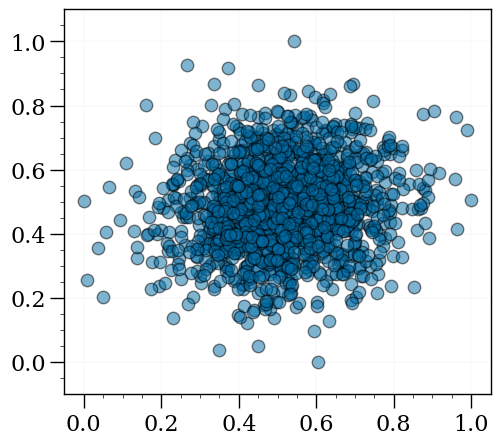

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'gauss_01')

  0%|          | 1/10000 [01:16<211:12:45, 76.04s/it]

Iter 0. Loss [[0.47219905 0.29312822 8.618089  ]]


  0%|          | 11/10000 [02:14<4:26:31,  1.60s/it]

Iter 10. Loss [[0.4021538  0.10488961 2.5372808 ]]


  0%|          | 21/10000 [02:17<49:27,  3.36it/s]

Iter 20. Loss [[0.36919296 0.08251051 2.421687  ]]


  0%|          | 31/10000 [02:21<1:16:09,  2.18it/s]

Iter 30. Loss [[0.32423705 0.07040947 2.3245993 ]]


  0%|          | 41/10000 [02:24<43:14,  3.84it/s]

Iter 40. Loss [[0.27871668 0.06695983 2.1784108 ]]


  1%|          | 51/10000 [02:27<43:27,  3.82it/s]

Iter 50. Loss [[0.19062778 0.06761819 1.901923  ]]


  1%|          | 61/10000 [02:30<47:38,  3.48it/s]

Iter 60. Loss [[0.12010299 0.05276809 1.645326  ]]


  1%|          | 71/10000 [02:33<1:01:20,  2.70it/s]

Iter 70. Loss [[0.16815077 0.04083123 2.0587745 ]]


  1%|          | 81/10000 [02:37<50:40,  3.26it/s]

Iter 80. Loss [[0.08332054 0.08183359 1.5118955 ]]


  1%|          | 91/10000 [02:40<45:28,  3.63it/s]

Iter 90. Loss [[0.15219998 0.03943391 1.6396528 ]]


  1%|          | 101/10000 [02:43<55:03,  3.00it/s]

Iter 100. Loss [[0.12233478 0.04056695 1.4620203 ]]


  1%|          | 111/10000 [02:45<42:15,  3.90it/s]

Iter 110. Loss [[0.09186971 0.05124344 1.2412547 ]]


  1%|          | 121/10000 [02:49<1:08:25,  2.41it/s]

Iter 120. Loss [[0.11670243 0.04094898 1.2311416 ]]


  1%|▏         | 131/10000 [02:52<52:33,  3.13it/s]

Iter 130. Loss [[0.09026208 0.04944475 1.1173893 ]]


  1%|▏         | 141/10000 [02:55<42:29,  3.87it/s]

Iter 140. Loss [[0.13297236 0.03136012 1.2147484 ]]


  2%|▏         | 151/10000 [02:58<43:34,  3.77it/s]

Iter 150. Loss [[0.05673704 0.28930384 6.29544   ]]


  2%|▏         | 161/10000 [03:01<1:03:43,  2.57it/s]

Iter 160. Loss [[0.21202105 0.04058918 1.4344922 ]]


  2%|▏         | 171/10000 [03:05<55:49,  2.93it/s]  

Iter 170. Loss [[0.17310314 0.04767497 1.4295719 ]]


  2%|▏         | 181/10000 [03:08<43:05,  3.80it/s]

Iter 180. Loss [[0.12951267 0.03477056 1.3646914 ]]


  2%|▏         | 191/10000 [03:12<1:08:59,  2.37it/s]

Iter 190. Loss [[0.1069789  0.03755405 1.0738001 ]]


  2%|▏         | 201/10000 [03:16<1:28:57,  1.84it/s]

Iter 200. Loss [[0.10480637 0.04355499 1.119125  ]]


  2%|▏         | 211/10000 [03:20<51:44,  3.15it/s]

Iter 210. Loss [[0.11752298 0.03279212 1.0486403 ]]


  2%|▏         | 221/10000 [03:23<44:52,  3.63it/s]

Iter 220. Loss [[0.11345168 0.0288837  0.9768624 ]]


  2%|▏         | 231/10000 [03:26<56:01,  2.91it/s]  

Iter 230. Loss [[0.11663193 0.02668962 0.9225682 ]]


  2%|▏         | 241/10000 [03:29<41:57,  3.88it/s]

Iter 240. Loss [[0.11232866 0.02483182 0.8643189 ]]


  3%|▎         | 251/10000 [03:33<1:08:00,  2.39it/s]

Iter 250. Loss [[0.10985537 0.02704828 0.9066612 ]]


  3%|▎         | 261/10000 [03:36<49:01,  3.31it/s]

Iter 260. Loss [[0.11313649 0.02180234 0.91841847]]


  3%|▎         | 271/10000 [03:39<41:36,  3.90it/s]

Iter 270. Loss [[0.10314071 0.02605578 0.85288346]]


  3%|▎         | 281/10000 [03:41<42:29,  3.81it/s]

Iter 280. Loss [[0.09443131 0.03226203 0.8851452 ]]


  3%|▎         | 291/10000 [03:45<1:03:47,  2.54it/s]

Iter 290. Loss [[0.12776169 0.02312603 0.82208884]]


  3%|▎         | 301/10000 [03:49<1:13:01,  2.21it/s]

Iter 300. Loss [[0.11093977 0.0216361  0.8275978 ]]


  3%|▎         | 311/10000 [03:52<42:26,  3.80it/s]

Iter 310. Loss [[0.1436464  0.01939318 0.8266081 ]]


  3%|▎         | 321/10000 [03:55<43:07,  3.74it/s]

Iter 320. Loss [[0.0819314  0.03732068 0.90739137]]


  3%|▎         | 331/10000 [03:58<50:17,  3.20it/s]

Iter 330. Loss [[0.14218158 0.01772918 0.9505161 ]]


  3%|▎         | 341/10000 [04:01<1:05:34,  2.46it/s]

Iter 340. Loss [[0.09590659 0.02600806 0.79261106]]


  4%|▎         | 351/10000 [04:05<43:57,  3.66it/s]

Iter 350. Loss [[0.10852347 0.0226609  0.7840844 ]]


  4%|▎         | 361/10000 [04:08<47:00,  3.42it/s]

Iter 360. Loss [[0.10903296 0.02239548 0.81489706]]


  4%|▎         | 371/10000 [04:10<40:47,  3.93it/s]

Iter 370. Loss [[0.10881159 0.02043954 0.84683526]]


  4%|▍         | 381/10000 [04:13<53:05,  3.02it/s]

Iter 380. Loss [[0.05779071 0.15597464 2.3196325 ]]


  4%|▍         | 391/10000 [04:18<58:28,  2.74it/s]  

Iter 390. Loss [[0.16833213 0.02732294 1.1643367 ]]


  4%|▍         | 401/10000 [04:20<59:33,  2.69it/s]

Iter 400. Loss [[0.16381094 0.02492378 1.2451319 ]]


  4%|▍         | 411/10000 [04:23<41:21,  3.86it/s]

Iter 410. Loss [[0.13569517 0.0294518  1.0492492 ]]


  4%|▍         | 421/10000 [04:26<43:23,  3.68it/s]

Iter 420. Loss [[0.11763324 0.02726577 0.9373636 ]]


  4%|▍         | 431/10000 [04:30<1:20:25,  1.98it/s]

Iter 430. Loss [[0.10229394 0.02636386 0.90306187]]


  4%|▍         | 441/10000 [04:33<43:44,  3.64it/s]

Iter 440. Loss [[0.11871335 0.02619272 0.9249985 ]]


  5%|▍         | 451/10000 [04:36<41:00,  3.88it/s]

Iter 450. Loss [[0.09669073 0.02839842 1.0334811 ]]


  5%|▍         | 461/10000 [04:39<47:18,  3.36it/s]

Iter 460. Loss [[0.11193246 0.02063141 1.3117201 ]]


  5%|▍         | 471/10000 [04:41<41:16,  3.85it/s]

Iter 470. Loss [[ 0.07467643  0.30193007 16.044607  ]]


  5%|▍         | 481/10000 [04:46<1:04:58,  2.44it/s]

Iter 480. Loss [[ 0.07437888  0.30071825 10.619935  ]]


  5%|▍         | 491/10000 [04:49<45:41,  3.47it/s]

Iter 490. Loss [[0.21146108 0.08184466 2.2386405 ]]


  5%|▌         | 501/10000 [04:52<1:00:08,  2.63it/s]

Iter 500. Loss [[0.35826063 0.07350504 1.7676513 ]]


  5%|▌         | 511/10000 [04:54<41:23,  3.82it/s]

Iter 510. Loss [[0.33769304 0.05845812 1.7081302 ]]


  5%|▌         | 521/10000 [04:58<1:05:34,  2.41it/s]

Iter 520. Loss [[0.31132826 0.05177885 1.7545856 ]]


  5%|▌         | 531/10000 [05:02<58:55,  2.68it/s]  

Iter 530. Loss [[0.32726878 0.05034261 1.7016745 ]]


  5%|▌         | 541/10000 [05:04<41:03,  3.84it/s]

Iter 540. Loss [[0.30064714 0.04043642 1.5851009 ]]


  6%|▌         | 551/10000 [05:07<41:21,  3.81it/s]

Iter 550. Loss [[0.2747476 0.0371207 1.5619348]]


  6%|▌         | 561/10000 [05:10<48:51,  3.22it/s]

Iter 560. Loss [[0.25993687 0.0371529  1.5422772 ]]


  6%|▌         | 571/10000 [05:14<1:06:26,  2.36it/s]

Iter 570. Loss [[0.23899761 0.04166611 1.6016562 ]]


  6%|▌         | 581/10000 [05:17<40:58,  3.83it/s]

Iter 580. Loss [[0.23712745 0.04168075 1.5924691 ]]


  6%|▌         | 591/10000 [05:20<45:31,  3.44it/s]

Iter 590. Loss [[0.2574749  0.03616907 1.5980415 ]]


  6%|▌         | 601/10000 [05:23<40:22,  3.88it/s]

Iter 600. Loss [[0.27308607 0.03669278 1.5607858 ]]


  6%|▌         | 611/10000 [05:26<56:39,  2.76it/s]

Iter 610. Loss [[0.2535753  0.03932323 1.5523249 ]]


  6%|▌         | 621/10000 [05:30<51:21,  3.04it/s]

Iter 620. Loss [[0.2722075  0.03549258 1.5212393 ]]


  6%|▋         | 631/10000 [05:33<59:18,  2.63it/s]

Iter 630. Loss [[0.2688248  0.03386027 1.4792279 ]]


  6%|▋         | 641/10000 [05:36<40:07,  3.89it/s]

Iter 640. Loss [[0.24492761 0.03187912 1.374758  ]]


  7%|▋         | 651/10000 [05:38<41:40,  3.74it/s]

Iter 650. Loss [[0.20919405 0.0332811  1.3977941 ]]


  7%|▋         | 661/10000 [05:43<1:13:58,  2.10it/s]

Iter 660. Loss [[0.18070441 0.03970963 1.3688588 ]]


  7%|▋         | 671/10000 [05:46<41:50,  3.72it/s]

Iter 670. Loss [[0.19772306 0.03064639 1.3558062 ]]


  7%|▋         | 681/10000 [05:48<41:29,  3.74it/s]

Iter 680. Loss [[0.23726931 0.02698896 1.4162822 ]]


  7%|▋         | 691/10000 [05:51<45:47,  3.39it/s]

Iter 690. Loss [[0.19681689 0.05734843 1.6501406 ]]


  7%|▋         | 701/10000 [05:54<46:17,  3.35it/s]

Iter 700. Loss [[0.30670166 0.03795104 1.4970214 ]]


  7%|▋         | 711/10000 [05:58<55:42,  2.78it/s]  

Iter 710. Loss [[0.2703925  0.03459155 1.4189106 ]]


  7%|▋         | 721/10000 [06:01<42:49,  3.61it/s]

Iter 720. Loss [[0.28116772 0.03312259 1.3932184 ]]


  7%|▋         | 731/10000 [06:04<57:49,  2.67it/s]

Iter 730. Loss [[0.28155884 0.03209134 1.3784876 ]]


  7%|▋         | 741/10000 [06:07<39:15,  3.93it/s]

Iter 740. Loss [[0.26936355 0.03102089 1.3605566 ]]


  8%|▊         | 751/10000 [06:11<1:04:20,  2.40it/s]

Iter 750. Loss [[0.27177805 0.02950224 1.3368963 ]]


  8%|▊         | 761/10000 [06:14<55:48,  2.76it/s]  

Iter 760. Loss [[0.25573105 0.0285664  1.3129945 ]]


  8%|▊         | 771/10000 [06:18<1:02:59,  2.44it/s]

Iter 770. Loss [[0.24926773 0.02690792 1.2908549 ]]


  8%|▊         | 781/10000 [06:21<41:26,  3.71it/s]

Iter 780. Loss [[0.23485784 0.02637383 1.2643502 ]]


  8%|▊         | 791/10000 [06:25<1:10:44,  2.17it/s]

Iter 790. Loss [[0.22125706 0.02602973 1.2374638 ]]


  8%|▊         | 801/10000 [06:28<42:01,  3.65it/s]

Iter 800. Loss [[0.20679305 0.02587959 1.2107455 ]]


  8%|▊         | 811/10000 [06:31<39:52,  3.84it/s]

Iter 810. Loss [[0.18329315 0.02716745 1.1572762 ]]


  8%|▊         | 821/10000 [06:34<43:00,  3.56it/s]

Iter 820. Loss [[0.196941   0.02030163 1.2808766 ]]


  8%|▊         | 831/10000 [06:37<37:24,  4.09it/s]

Iter 830. Loss [[0.17398597 0.04569705 1.3446277 ]]


  8%|▊         | 841/10000 [06:41<1:03:04,  2.42it/s]

Iter 840. Loss [[0.26685607 0.02740856 1.2245677 ]]


  9%|▊         | 851/10000 [06:44<42:50,  3.56it/s]

Iter 850. Loss [[0.2537876  0.03133754 1.2908584 ]]


  9%|▊         | 861/10000 [06:47<50:09,  3.04it/s]

Iter 860. Loss [[0.28953338 0.02992379 1.2430005 ]]


  9%|▊         | 871/10000 [06:49<38:10,  3.99it/s]

Iter 870. Loss [[0.27726278 0.02743873 1.2179992 ]]


  9%|▉         | 881/10000 [06:53<53:43,  2.83it/s]

Iter 880. Loss [[0.25860018 0.02581727 1.1994876 ]]


  9%|▉         | 891/10000 [06:57<57:44,  2.63it/s]  

Iter 890. Loss [[0.2556519  0.02382928 1.1766332 ]]


  9%|▉         | 901/10000 [06:59<38:20,  3.96it/s]

Iter 900. Loss [[0.24295817 0.02248821 1.1539419 ]]


  9%|▉         | 911/10000 [07:02<38:39,  3.92it/s]

Iter 910. Loss [[0.22422957 0.0217351  1.1240289 ]]


  9%|▉         | 921/10000 [07:05<42:14,  3.58it/s]

Iter 920. Loss [[0.1955076  0.02237858 1.1124405 ]]


  9%|▉         | 931/10000 [07:09<1:18:26,  1.93it/s]

Iter 930. Loss [[0.17808555 0.02331384 1.0999975 ]]


  9%|▉         | 941/10000 [07:12<40:45,  3.70it/s]

Iter 940. Loss [[0.16074292 0.02639993 1.065398  ]]


 10%|▉         | 951/10000 [07:15<40:43,  3.70it/s]

Iter 950. Loss [[0.14653344 0.02857719 1.0123692 ]]


 10%|▉         | 961/10000 [07:18<50:31,  2.98it/s]

Iter 960. Loss [[0.13333982 0.03082651 0.99508595]]


 10%|▉         | 971/10000 [07:20<38:06,  3.95it/s]

Iter 970. Loss [[0.13547568 0.02765792 1.0030191 ]]


 10%|▉         | 981/10000 [07:24<1:02:39,  2.40it/s]

Iter 980. Loss [[0.06646745 0.17439422 2.8908656 ]]


 10%|▉         | 991/10000 [07:27<47:08,  3.18it/s]

Iter 990. Loss [[0.30780178 0.04352816 2.177348  ]]


 10%|█         | 1001/10000 [07:30<38:12,  3.93it/s]

Iter 1000. Loss [[0.20285504 0.03908131 1.2775244 ]]


 10%|█         | 1011/10000 [07:33<39:00,  3.84it/s]

Iter 1010. Loss [[0.26344332 0.02362368 1.1230063 ]]


 10%|█         | 1021/10000 [07:36<58:01,  2.58it/s]

Iter 1020. Loss [[0.27355894 0.02334413 1.1312454 ]]


 10%|█         | 1031/10000 [07:40<52:33,  2.84it/s]

Iter 1030. Loss [[0.25167942 0.02257002 1.1221929 ]]


 10%|█         | 1041/10000 [07:43<38:45,  3.85it/s]

Iter 1040. Loss [[0.2548748  0.02103538 1.1058939 ]]


 11%|█         | 1051/10000 [07:46<42:10,  3.54it/s]

Iter 1050. Loss [[0.24753372 0.02024536 1.087632  ]]


 11%|█         | 1061/10000 [07:49<54:35,  2.73it/s]

Iter 1060. Loss [[0.24187256 0.01918381 1.0602193 ]]


 11%|█         | 1071/10000 [07:52<59:54,  2.48it/s]

Iter 1070. Loss [[0.23092723 0.01939184 1.0462492 ]]


 11%|█         | 1081/10000 [07:56<42:11,  3.52it/s]

Iter 1080. Loss [[0.22886732 0.01858286 1.0346495 ]]


 11%|█         | 1091/10000 [07:59<45:14,  3.28it/s]

Iter 1090. Loss [[0.22326957 0.01856792 1.0219538 ]]


 11%|█         | 1101/10000 [08:01<37:40,  3.94it/s]

Iter 1100. Loss [[0.21925406 0.01851746 1.0117209 ]]


 11%|█         | 1111/10000 [08:04<38:22,  3.86it/s]

Iter 1110. Loss [[0.21448356 0.01882176 1.0016711 ]]


 11%|█         | 1121/10000 [08:08<1:07:14,  2.20it/s]

Iter 1120. Loss [[0.21362427 0.01852856 0.9928605 ]]


 11%|█▏        | 1131/10000 [08:11<37:11,  3.98it/s]

Iter 1130. Loss [[0.21302567 0.01827965 0.98414433]]


 11%|█▏        | 1141/10000 [08:14<37:24,  3.95it/s]

Iter 1140. Loss [[0.21271496 0.01802297 0.9753898 ]]


 12%|█▏        | 1151/10000 [08:16<39:07,  3.77it/s]

Iter 1150. Loss [[0.2123298  0.01779863 0.96666974]]


 12%|█▏        | 1161/10000 [08:20<1:11:13,  2.07it/s]

Iter 1160. Loss [[0.2120279  0.01756396 0.9580972 ]]


 12%|█▏        | 1171/10000 [08:23<47:44,  3.08it/s]

Iter 1170. Loss [[0.21174604 0.01732393 0.94799244]]


 12%|█▏        | 1181/10000 [08:26<40:04,  3.67it/s]

Iter 1180. Loss [[0.21164186 0.01704317 0.9372811 ]]


 12%|█▏        | 1191/10000 [08:29<48:29,  3.03it/s]

Iter 1190. Loss [[0.2119223 0.0166973 0.9236528]]


 12%|█▏        | 1201/10000 [08:32<37:08,  3.95it/s]

Iter 1200. Loss [[0.20940621 0.01682524 0.91186833]]


 12%|█▏        | 1211/10000 [08:36<1:01:14,  2.39it/s]

Iter 1210. Loss [[0.20619164 0.0169096  0.90497136]]


 12%|█▏        | 1221/10000 [08:39<47:16,  3.09it/s]

Iter 1220. Loss [[0.20538753 0.01674034 0.8983934 ]]


 12%|█▏        | 1231/10000 [08:42<36:42,  3.98it/s]

Iter 1230. Loss [[0.20534183 0.01660612 0.90109605]]


 12%|█▏        | 1241/10000 [08:45<36:55,  3.95it/s]

Iter 1240. Loss [[0.20633692 0.0162292  0.905216  ]]


 13%|█▎        | 1251/10000 [08:47<40:34,  3.59it/s]

Iter 1250. Loss [[0.20420447 0.0163611  0.89780027]]


 13%|█▎        | 1261/10000 [08:52<1:18:31,  1.85it/s]

Iter 1260. Loss [[0.20266412 0.01641984 0.8914229 ]]


 13%|█▎        | 1271/10000 [08:54<37:25,  3.89it/s]

Iter 1270. Loss [[0.2019405  0.01635018 0.8853408 ]]


 13%|█▎        | 1281/10000 [08:57<39:09,  3.71it/s]

Iter 1280. Loss [[0.20148467 0.01627278 0.89007276]]


 13%|█▎        | 1291/10000 [09:00<48:31,  2.99it/s]

Iter 1290. Loss [[0.20053719 0.01627972 0.88418764]]


 13%|█▎        | 1301/10000 [09:03<53:26,  2.71it/s]

Iter 1300. Loss [[0.20012456 0.01622284 0.87743527]]


 13%|█▎        | 1311/10000 [09:07<44:30,  3.25it/s]

Iter 1310. Loss [[0.20168787 0.01587816 0.87965244]]


 13%|█▎        | 1321/10000 [09:10<44:35,  3.24it/s]

Iter 1320. Loss [[0.19965881 0.01594897 0.8734625 ]]


 13%|█▎        | 1331/10000 [09:12<36:13,  3.99it/s]

Iter 1330. Loss [[0.07845911 0.0994091  1.5657555 ]]


 13%|█▎        | 1341/10000 [09:15<37:01,  3.90it/s]

Iter 1340. Loss [[0.27525362 0.02361879 1.518259  ]]


 14%|█▎        | 1351/10000 [09:19<1:03:53,  2.26it/s]

Iter 1350. Loss [[0.15718056 0.04673985 1.1674993 ]]


 14%|█▎        | 1361/10000 [09:22<38:53,  3.70it/s]

Iter 1360. Loss [[0.27808362 0.02102417 1.0096238 ]]


 14%|█▎        | 1371/10000 [09:25<36:45,  3.91it/s]

Iter 1370. Loss [[0.22700365 0.01898962 0.92780614]]


 14%|█▍        | 1381/10000 [09:29<59:44,  2.40it/s]

Iter 1380. Loss [[0.25748104 0.01599696 0.8889909 ]]


 14%|█▍        | 1391/10000 [09:34<1:19:02,  1.82it/s]

Iter 1390. Loss [[0.2324222  0.01558451 0.87122905]]


 14%|█▍        | 1401/10000 [09:37<38:33,  3.72it/s]

Iter 1400. Loss [[0.23560211 0.01461606 0.8698566 ]]


 14%|█▍        | 1411/10000 [09:40<38:02,  3.76it/s]

Iter 1410. Loss [[0.21868697 0.01579275 0.84988624]]


 14%|█▍        | 1421/10000 [09:42<43:34,  3.28it/s]

Iter 1420. Loss [[0.22501664 0.01466509 0.85768926]]


 14%|█▍        | 1431/10000 [09:45<35:57,  3.97it/s]

Iter 1430. Loss [[0.2116498 0.0163099 0.8342611]]


 14%|█▍        | 1441/10000 [09:49<58:51,  2.42it/s]

Iter 1440. Loss [[0.22179812 0.01498118 0.8519349 ]]


 15%|█▍        | 1451/10000 [09:52<42:10,  3.38it/s]

Iter 1450. Loss [[0.22450687 0.01463229 0.8510513 ]]


 15%|█▍        | 1461/10000 [09:55<35:08,  4.05it/s]

Iter 1460. Loss [[0.21727741 0.01516756 0.83376384]]


 15%|█▍        | 1471/10000 [09:57<35:52,  3.96it/s]

Iter 1470. Loss [[0.21686628 0.01517853 0.82538706]]


 15%|█▍        | 1481/10000 [10:01<53:48,  2.64it/s]

Iter 1480. Loss [[0.21912673 0.01501462 0.81585807]]


 15%|█▍        | 1491/10000 [10:05<1:00:56,  2.33it/s]

Iter 1490. Loss [[0.22245939 0.01491725 0.802415  ]]


 15%|█▌        | 1501/10000 [10:07<35:04,  4.04it/s]

Iter 1500. Loss [[0.21795681 0.01525613 0.79106015]]


 15%|█▌        | 1511/10000 [10:10<37:03,  3.82it/s]

Iter 1510. Loss [[0.21248546 0.01570767 0.7815421 ]]


 15%|█▌        | 1521/10000 [10:13<43:13,  3.27it/s]

Iter 1520. Loss [[0.21108057 0.01587308 0.7758609 ]]


 15%|█▌        | 1531/10000 [10:16<54:48,  2.58it/s]

Iter 1530. Loss [[0.211759   0.01587984 0.76834375]]


 15%|█▌        | 1541/10000 [10:20<39:04,  3.61it/s]

Iter 1540. Loss [[0.2124619  0.01585796 0.762442  ]]


 16%|█▌        | 1551/10000 [10:23<41:20,  3.41it/s]

Iter 1550. Loss [[0.21164486 0.0160032  0.75782746]]


 16%|█▌        | 1561/10000 [10:25<35:31,  3.96it/s]

Iter 1560. Loss [[0.21184191 0.01610824 0.75139856]]


 16%|█▌        | 1571/10000 [10:28<35:42,  3.93it/s]

Iter 1570. Loss [[0.210151   0.01635443 0.74828565]]


 16%|█▌        | 1581/10000 [10:33<1:03:06,  2.22it/s]

Iter 1580. Loss [[0.2106939  0.01623644 0.74101853]]


 16%|█▌        | 1591/10000 [10:36<51:49,  2.70it/s]

Iter 1590. Loss [[0.21264005 0.01605568 0.7446647 ]]


 16%|█▌        | 1601/10000 [10:38<34:30,  4.06it/s]

Iter 1600. Loss [[0.21200122 0.0161715  0.73873925]]


 16%|█▌        | 1611/10000 [10:41<37:42,  3.71it/s]

Iter 1610. Loss [[0.21122798 0.01631452 0.731757  ]]


 16%|█▌        | 1621/10000 [10:44<58:28,  2.39it/s]

Iter 1620. Loss [[0.2105337  0.01646519 0.72599316]]


 16%|█▋        | 1631/10000 [10:48<45:17,  3.08it/s]

Iter 1630. Loss [[0.21210717 0.01638878 0.7205278 ]]


 16%|█▋        | 1641/10000 [10:51<35:10,  3.96it/s]

Iter 1640. Loss [[0.2123743  0.01639537 0.7151727 ]]


 17%|█▋        | 1651/10000 [10:53<40:15,  3.46it/s]

Iter 1650. Loss [[0.21247567 0.01641995 0.7093375 ]]


 17%|█▋        | 1661/10000 [10:56<34:52,  3.99it/s]

Iter 1660. Loss [[0.2133091  0.01638802 0.7149703 ]]


 17%|█▋        | 1671/10000 [11:00<54:07,  2.57it/s]

Iter 1670. Loss [[0.21266693 0.01642769 0.70866495]]


 17%|█▋        | 1681/10000 [11:03<41:53,  3.31it/s]

Iter 1680. Loss [[0.21195342 0.01644608 0.7035371 ]]


 17%|█▋        | 1691/10000 [11:06<50:24,  2.75it/s]

Iter 1690. Loss [[0.21218486 0.01640564 0.6992246 ]]


 17%|█▋        | 1701/10000 [11:08<33:44,  4.10it/s]

Iter 1700. Loss [[0.24012211 0.01663082 0.71508384]]


 17%|█▋        | 1711/10000 [11:11<35:31,  3.89it/s]

Iter 1710. Loss [[0.2240259  0.01576728 0.65102714]]


 17%|█▋        | 1721/10000 [11:15<1:07:01,  2.06it/s]

Iter 1720. Loss [[0.22549234 0.01620501 0.6436805 ]]


 17%|█▋        | 1731/10000 [11:18<36:02,  3.82it/s]

Iter 1730. Loss [[0.22329132 0.01637046 0.6397448 ]]


 17%|█▋        | 1741/10000 [11:21<35:12,  3.91it/s]

Iter 1740. Loss [[0.2221402  0.0163106  0.63490796]]


 18%|█▊        | 1751/10000 [11:24<39:15,  3.50it/s]

Iter 1750. Loss [[0.2211553  0.01609815 0.630021  ]]


 18%|█▊        | 1761/10000 [11:26<38:16,  3.59it/s]

Iter 1760. Loss [[0.22027689 0.01605536 0.6392592 ]]


 18%|█▊        | 1771/10000 [11:31<52:17,  2.62it/s]

Iter 1770. Loss [[0.22117808 0.01596335 0.63500774]]


 18%|█▊        | 1781/10000 [11:34<39:17,  3.49it/s]

Iter 1780. Loss [[0.22177032 0.01592503 0.62944806]]


 18%|█▊        | 1791/10000 [11:36<33:21,  4.10it/s]

Iter 1790. Loss [[0.22171591 0.01588604 0.6588309 ]]


 18%|█▊        | 1801/10000 [11:39<33:44,  4.05it/s]

Iter 1800. Loss [[0.221541   0.01580982 0.66808707]]


 18%|█▊        | 1811/10000 [11:42<54:53,  2.49it/s]

Iter 1810. Loss [[0.22188869 0.0156643  0.6655392 ]]


 18%|█▊        | 1821/10000 [11:46<51:06,  2.67it/s]

Iter 1820. Loss [[0.16785698 0.0362891  1.047925  ]]


 18%|█▊        | 1831/10000 [11:49<34:17,  3.97it/s]

Iter 1830. Loss [[0.2184686  0.02017405 0.70179933]]


 18%|█▊        | 1841/10000 [11:52<34:53,  3.90it/s]

Iter 1840. Loss [[0.10886822 0.29838955 9.433398  ]]


 19%|█▊        | 1851/10000 [11:54<41:42,  3.26it/s]

Iter 1850. Loss [[ 0.1119473   0.30177152 13.0942    ]]


 19%|█▊        | 1861/10000 [11:58<53:18,  2.54it/s]

Iter 1860. Loss [[0.07231381 0.21390413 3.514074  ]]


 19%|█▊        | 1871/10000 [12:01<35:52,  3.78it/s]

Iter 1870. Loss [[0.35232085 0.11793196 2.7213178 ]]


 19%|█▉        | 1881/10000 [12:04<37:02,  3.65it/s]

Iter 1880. Loss [[0.21405806 0.04841637 1.2653015 ]]


 19%|█▉        | 1891/10000 [12:07<34:07,  3.96it/s]

Iter 1890. Loss [[0.27055073 0.02289404 0.9406707 ]]


 19%|█▉        | 1901/10000 [12:09<34:02,  3.97it/s]

Iter 1900. Loss [[0.297482   0.02752114 0.9088137 ]]


 19%|█▉        | 1911/10000 [12:14<55:45,  2.42it/s]

Iter 1910. Loss [[0.27140424 0.02111843 0.91340536]]


 19%|█▉        | 1921/10000 [12:17<44:38,  3.02it/s]

Iter 1920. Loss [[0.28292835 0.02173497 0.8863557 ]]


 19%|█▉        | 1931/10000 [12:19<33:20,  4.03it/s]

Iter 1930. Loss [[0.2853069  0.02195939 0.8782376 ]]


 19%|█▉        | 1941/10000 [12:22<35:26,  3.79it/s]

Iter 1940. Loss [[0.28156012 0.02099195 0.8751625 ]]


 20%|█▉        | 1951/10000 [12:25<55:43,  2.41it/s]

Iter 1950. Loss [[0.28644606 0.0221089  0.86332166]]


 20%|█▉        | 1961/10000 [12:29<40:56,  3.27it/s]

Iter 1960. Loss [[0.28763115 0.02287462 0.8571184 ]]


 20%|█▉        | 1971/10000 [12:32<34:27,  3.88it/s]

Iter 1970. Loss [[0.28543347 0.02207588 0.85687256]]


 20%|█▉        | 1981/10000 [12:35<38:42,  3.45it/s]

Iter 1980. Loss [[0.28440955 0.02156477 0.8523706 ]]


 20%|█▉        | 1991/10000 [12:39<56:10,  2.38it/s]

Iter 1990. Loss [[0.2838497  0.0211891  0.84738183]]


 20%|██        | 2001/10000 [12:43<55:24,  2.41it/s]

Iter 2000. Loss [[0.2826893  0.02070075 0.8428016 ]]


 20%|██        | 2011/10000 [12:46<36:24,  3.66it/s]

Iter 2010. Loss [[0.28208324 0.02036277 0.837451  ]]


 20%|██        | 2021/10000 [12:49<47:54,  2.78it/s]

Iter 2020. Loss [[0.2808786  0.01987436 0.8329005 ]]


 20%|██        | 2031/10000 [12:51<33:05,  4.01it/s]

Iter 2030. Loss [[0.28010547 0.01948761 0.8275719 ]]


 20%|██        | 2041/10000 [12:55<49:16,  2.69it/s]

Iter 2040. Loss [[0.27892235 0.01902064 0.8224443 ]]


 21%|██        | 2051/10000 [12:59<50:44,  2.61it/s]

Iter 2050. Loss [[0.27747834 0.01849049 0.8164541 ]]


 21%|██        | 2061/10000 [13:01<32:50,  4.03it/s]

Iter 2060. Loss [[0.27521476 0.01777362 0.8099356 ]]


 21%|██        | 2071/10000 [13:04<34:02,  3.88it/s]

Iter 2070. Loss [[0.27099216 0.01672861 0.8018641 ]]


 21%|██        | 2081/10000 [13:07<39:46,  3.32it/s]

Iter 2080. Loss [[0.26433524 0.0155857  0.79388344]]


 21%|██        | 2091/10000 [13:10<51:19,  2.57it/s]

Iter 2090. Loss [[0.257278   0.01523196 0.85182256]]


 21%|██        | 2101/10000 [13:14<35:38,  3.69it/s]

Iter 2100. Loss [[0.2545096  0.01567179 0.8569073 ]]


 21%|██        | 2111/10000 [13:16<35:53,  3.66it/s]

Iter 2110. Loss [[0.25938758 0.01624802 0.80255604]]


 21%|██        | 2121/10000 [13:19<47:40,  2.75it/s]

Iter 2120. Loss [[0.26461652 0.01655944 0.7939189 ]]


 21%|██▏       | 2131/10000 [13:22<32:43,  4.01it/s]

Iter 2130. Loss [[0.27027777 0.01669158 0.78277504]]


 21%|██▏       | 2141/10000 [13:26<56:08,  2.33it/s]

Iter 2140. Loss [[0.27278787 0.01668647 0.77512354]]


 22%|██▏       | 2151/10000 [13:29<48:13,  2.71it/s]

Iter 2150. Loss [[0.2722904  0.01632421 0.7703748 ]]


 22%|██▏       | 2161/10000 [13:32<33:53,  3.85it/s]

Iter 2160. Loss [[0.2709534  0.01591403 0.7654415 ]]


 22%|██▏       | 2171/10000 [13:34<34:21,  3.80it/s]

Iter 2170. Loss [[0.26991    0.01561453 0.76030064]]


 22%|██▏       | 2181/10000 [13:38<55:53,  2.33it/s]

Iter 2180. Loss [[0.26925322 0.01539912 0.7543869 ]]


 22%|██▏       | 2191/10000 [13:41<42:49,  3.04it/s]

Iter 2190. Loss [[0.26880133 0.01522197 0.74863636]]


 22%|██▏       | 2201/10000 [13:44<34:05,  3.81it/s]

Iter 2200. Loss [[0.267773   0.01497336 0.7436497 ]]


 22%|██▏       | 2211/10000 [13:47<38:10,  3.40it/s]

Iter 2210. Loss [[0.26783922 0.01493403 0.74022067]]


 22%|██▏       | 2221/10000 [13:50<32:35,  3.98it/s]

Iter 2220. Loss [[0.26926863 0.01496327 0.7324019 ]]


 22%|██▏       | 2231/10000 [13:53<50:35,  2.56it/s]

Iter 2230. Loss [[0.269105   0.01481701 0.7250454 ]]


 22%|██▏       | 2241/10000 [13:57<38:05,  3.39it/s]

Iter 2240. Loss [[0.26840022 0.01464231 0.7187739 ]]


 23%|██▎       | 2251/10000 [14:00<47:08,  2.74it/s]

Iter 2250. Loss [[0.267767   0.01444934 0.71340835]]


 23%|██▎       | 2261/10000 [14:02<32:17,  3.99it/s]

Iter 2260. Loss [[0.26745957 0.01429422 0.7078755 ]]


 23%|██▎       | 2271/10000 [14:05<33:44,  3.82it/s]

Iter 2270. Loss [[0.2674669  0.01418881 0.70272946]]


 23%|██▎       | 2281/10000 [14:10<1:00:46,  2.12it/s]

Iter 2280. Loss [[0.26719084 0.01403646 0.6981003 ]]


 23%|██▎       | 2291/10000 [14:12<32:16,  3.98it/s]

Iter 2290. Loss [[0.2676619  0.01398917 0.6927506 ]]


 23%|██▎       | 2301/10000 [14:15<32:41,  3.93it/s]

Iter 2300. Loss [[0.26803866 0.01394045 0.6880188 ]]


 23%|██▎       | 2311/10000 [14:18<36:09,  3.54it/s]

Iter 2310. Loss [[0.2685265  0.01391734 0.6812452 ]]


 23%|██▎       | 2321/10000 [14:20<37:17,  3.43it/s]

Iter 2320. Loss [[0.2684608  0.01385881 0.67561173]]


 23%|██▎       | 2331/10000 [14:24<45:11,  2.83it/s]

Iter 2330. Loss [[0.26784247 0.01374851 0.670232  ]]


 23%|██▎       | 2341/10000 [14:27<36:05,  3.54it/s]

Iter 2340. Loss [[0.26755095 0.0136802  0.66566676]]


 24%|██▎       | 2351/10000 [14:30<45:40,  2.79it/s]

Iter 2350. Loss [[0.26759034 0.01363952 0.6608413 ]]


 24%|██▎       | 2361/10000 [14:33<31:13,  4.08it/s]

Iter 2360. Loss [[0.26755002 0.01358413 0.6562913 ]]


 24%|██▎       | 2371/10000 [14:36<48:20,  2.63it/s]

Iter 2370. Loss [[0.2676665  0.01354413 0.6518177 ]]


 24%|██▍       | 2381/10000 [14:40<47:11,  2.69it/s]

Iter 2380. Loss [[0.26769477 0.01348103 0.6485454 ]]


 24%|██▍       | 2391/10000 [14:42<30:49,  4.12it/s]

Iter 2390. Loss [[0.26804677 0.01344178 0.64611787]]


 24%|██▍       | 2401/10000 [14:45<32:24,  3.91it/s]

Iter 2400. Loss [[0.2680447  0.01339346 0.6418272 ]]


 24%|██▍       | 2411/10000 [14:48<36:53,  3.43it/s]

Iter 2410. Loss [[0.26761827 0.01336772 0.6371089 ]]


 24%|██▍       | 2421/10000 [14:51<48:43,  2.59it/s]

Iter 2420. Loss [[0.26593018 0.01336972 0.6323466 ]]


 24%|██▍       | 2431/10000 [14:55<32:58,  3.83it/s]

Iter 2430. Loss [[0.2686242  0.01325818 0.6300445 ]]


 24%|██▍       | 2441/10000 [14:57<35:21,  3.56it/s]

Iter 2440. Loss [[0.27040505 0.01315491 0.6300136 ]]


 25%|██▍       | 2451/10000 [15:00<30:34,  4.12it/s]

Iter 2450. Loss [[0.26510966 0.0131313  0.6453645 ]]


 25%|██▍       | 2461/10000 [15:03<31:34,  3.98it/s]

Iter 2460. Loss [[0.25092003 0.02276608 0.81781036]]


 25%|██▍       | 2471/10000 [15:07<52:46,  2.38it/s]

Iter 2470. Loss [[0.25157014 0.0250179  0.86437434]]


 25%|██▍       | 2481/10000 [15:10<45:06,  2.78it/s]

Iter 2480. Loss [[0.31329787 0.03287662 0.66286385]]


 25%|██▍       | 2491/10000 [15:12<31:29,  3.97it/s]

Iter 2490. Loss [[0.27037883 0.01356377 0.682265  ]]


 25%|██▌       | 2501/10000 [15:15<32:31,  3.84it/s]

Iter 2500. Loss [[0.2815792  0.01459872 0.64900035]]


 25%|██▌       | 2511/10000 [15:18<47:20,  2.64it/s]

Iter 2510. Loss [[0.28194058 0.01453071 0.6427283 ]]


 25%|██▌       | 2521/10000 [15:22<47:32,  2.62it/s]

Iter 2520. Loss [[0.277251   0.01355825 0.64256537]]


 25%|██▌       | 2531/10000 [15:25<32:39,  3.81it/s]

Iter 2530. Loss [[0.27817628 0.01391632 0.6343094 ]]


 25%|██▌       | 2541/10000 [15:28<35:54,  3.46it/s]

Iter 2540. Loss [[0.27815777 0.01422517 0.6283463 ]]


 26%|██▌       | 2551/10000 [15:30<31:50,  3.90it/s]

Iter 2550. Loss [[0.2743558  0.01372908 0.62848735]]


 26%|██▌       | 2561/10000 [15:34<47:56,  2.59it/s]

Iter 2560. Loss [[0.27437988 0.01391679 0.62449896]]


 26%|██▌       | 2571/10000 [15:38<36:22,  3.40it/s]

Iter 2570. Loss [[0.27323195 0.01377969 0.62345093]]


 26%|██▌       | 2581/10000 [15:40<45:14,  2.73it/s]

Iter 2580. Loss [[0.27334693 0.01379092 0.6213067 ]]


 26%|██▌       | 2591/10000 [15:43<31:39,  3.90it/s]

Iter 2590. Loss [[0.27386    0.01383944 0.6184438 ]]


 26%|██▌       | 2601/10000 [15:46<32:32,  3.79it/s]

Iter 2600. Loss [[0.27412143 0.01383923 0.61598605]]


 26%|██▌       | 2611/10000 [15:50<59:49,  2.06it/s]  

Iter 2610. Loss [[0.27449518 0.01386922 0.6135323 ]]


 26%|██▌       | 2621/10000 [15:54<49:41,  2.47it/s]

Iter 2620. Loss [[0.27472794 0.01388089 0.6114105 ]]


 26%|██▋       | 2631/10000 [15:57<32:04,  3.83it/s]

Iter 2630. Loss [[0.27498004 0.01390257 0.60883033]]


 26%|██▋       | 2641/10000 [16:00<34:28,  3.56it/s]

Iter 2640. Loss [[0.27520138 0.01392217 0.6066091 ]]


 27%|██▋       | 2651/10000 [16:04<48:34,  2.52it/s]

Iter 2650. Loss [[0.27544567 0.01394023 0.60429966]]


 27%|██▋       | 2661/10000 [16:07<32:13,  3.80it/s]

Iter 2660. Loss [[0.27580845 0.01397071 0.6015513 ]]


 27%|██▋       | 2671/10000 [16:10<32:13,  3.79it/s]

Iter 2670. Loss [[0.27624866 0.01398845 0.59880686]]


 27%|██▋       | 2681/10000 [16:12<39:04,  3.12it/s]

Iter 2680. Loss [[0.27706993 0.01399027 0.5953129 ]]


 27%|██▋       | 2691/10000 [16:15<29:31,  4.13it/s]

Iter 2690. Loss [[0.27911043 0.01382119 0.59096175]]


 27%|██▋       | 2701/10000 [16:19<49:18,  2.47it/s]

Iter 2700. Loss [[0.28272083 0.01361944 0.5842853 ]]


 27%|██▋       | 2711/10000 [16:22<36:40,  3.31it/s]

Iter 2710. Loss [[0.28239414 0.01344949 0.5817852 ]]


 27%|██▋       | 2721/10000 [16:24<30:16,  4.01it/s]

Iter 2720. Loss [[0.2820068  0.01325909 0.580189  ]]


 27%|██▋       | 2731/10000 [16:27<30:15,  4.00it/s]

Iter 2730. Loss [[0.2830819  0.01332627 0.57655406]]


 27%|██▋       | 2741/10000 [16:30<43:56,  2.75it/s]

Iter 2740. Loss [[0.28257748 0.01317203 0.5748031 ]]


 28%|██▊       | 2751/10000 [16:34<42:57,  2.81it/s]

Iter 2750. Loss [[0.28299463 0.01312784 0.5724902 ]]


 28%|██▊       | 2761/10000 [16:37<30:07,  4.01it/s]

Iter 2760. Loss [[0.28305677 0.01303679 0.57005095]]


 28%|██▊       | 2771/10000 [16:40<33:37,  3.58it/s]

Iter 2770. Loss [[0.28341746 0.01297372 0.56771106]]


 28%|██▊       | 2781/10000 [16:42<42:56,  2.80it/s]

Iter 2780. Loss [[0.28385556 0.01293273 0.56487566]]


 28%|██▊       | 2791/10000 [16:46<43:58,  2.73it/s]

Iter 2790. Loss [[0.28417262 0.01285591 0.56315   ]]


 28%|██▊       | 2801/10000 [16:49<34:26,  3.48it/s]

Iter 2800. Loss [[0.28456712 0.01278889 0.5611583 ]]


 28%|██▊       | 2811/10000 [16:52<35:40,  3.36it/s]

Iter 2810. Loss [[0.2849821  0.01272085 0.5584954 ]]


 28%|██▊       | 2821/10000 [16:54<29:01,  4.12it/s]

Iter 2820. Loss [[0.2854808  0.01266079 0.5561563 ]]


 28%|██▊       | 2831/10000 [16:57<29:27,  4.06it/s]

Iter 2830. Loss [[0.285972   0.01258956 0.554308  ]]


 28%|██▊       | 2841/10000 [17:01<50:56,  2.34it/s]

Iter 2840. Loss [[0.28644228 0.0125027  0.55263585]]


 29%|██▊       | 2851/10000 [17:04<31:22,  3.80it/s]

Iter 2850. Loss [[0.286931   0.01240227 0.5502194 ]]


 29%|██▊       | 2861/10000 [17:07<29:18,  4.06it/s]

Iter 2860. Loss [[0.28763512 0.01232647 0.54798895]]


 29%|██▊       | 2871/10000 [17:09<31:24,  3.78it/s]

Iter 2870. Loss [[0.28825483 0.01223356 0.5456451 ]]


 29%|██▉       | 2881/10000 [17:12<42:59,  2.76it/s]

Iter 2880. Loss [[0.2889618  0.01213803 0.54283947]]


 29%|██▉       | 2891/10000 [17:16<46:11,  2.56it/s]

Iter 2890. Loss [[0.2896456  0.01202905 0.5407478 ]]


 29%|██▉       | 2901/10000 [17:19<32:15,  3.67it/s]

Iter 2900. Loss [[0.29048887 0.01192716 0.5378893 ]]


 29%|██▉       | 2911/10000 [17:22<36:19,  3.25it/s]

Iter 2910. Loss [[0.2915445  0.01179021 0.5351294 ]]


 29%|██▉       | 2921/10000 [17:25<30:02,  3.93it/s]

Iter 2920. Loss [[0.29279578 0.01174655 0.53247094]]


 29%|██▉       | 2931/10000 [17:28<38:11,  3.09it/s]

Iter 2930. Loss [[0.29346415 0.0116662  0.5307158 ]]


 29%|██▉       | 2941/10000 [17:32<44:10,  2.66it/s]

Iter 2940. Loss [[0.29370522 0.01140367 0.52913564]]


 30%|██▉       | 2951/10000 [17:34<29:12,  4.02it/s]

Iter 2950. Loss [[0.29445094 0.01120138 0.5281564 ]]


 30%|██▉       | 2961/10000 [17:37<29:00,  4.04it/s]

Iter 2960. Loss [[0.2972592 0.0113326 0.5230125]]


 30%|██▉       | 2971/10000 [17:40<31:15,  3.75it/s]

Iter 2970. Loss [[0.29780656 0.01116412 0.52128214]]


 30%|██▉       | 2981/10000 [17:43<54:34,  2.14it/s]

Iter 2980. Loss [[0.29798305 0.01087809 0.5195433 ]]


 30%|██▉       | 2991/10000 [17:47<33:04,  3.53it/s]

Iter 2990. Loss [[0.2987043  0.01071999 0.51655704]]


 30%|███       | 3001/10000 [17:50<30:37,  3.81it/s]

Iter 3000. Loss [[0.29953346 0.01058159 0.514672  ]]


 30%|███       | 3011/10000 [17:52<35:44,  3.26it/s]

Iter 3010. Loss [[0.30028656 0.01045397 0.5133415 ]]


 30%|███       | 3021/10000 [17:55<28:28,  4.08it/s]

Iter 3020. Loss [[0.30185157 0.01052771 0.50981534]]


 30%|███       | 3031/10000 [17:59<47:12,  2.46it/s]

Iter 3030. Loss [[0.3030587  0.01055202 0.5061839 ]]


 30%|███       | 3041/10000 [18:02<33:52,  3.42it/s]

Iter 3040. Loss [[0.30283266 0.01027625 0.50677556]]


 31%|███       | 3051/10000 [18:05<28:48,  4.02it/s]

Iter 3050. Loss [[0.30410978 0.01033757 0.5038118 ]]


 31%|███       | 3061/10000 [18:08<29:03,  3.98it/s]

Iter 3060. Loss [[0.30527985 0.01039295 0.49993986]]


 31%|███       | 3071/10000 [18:10<31:20,  3.68it/s]

Iter 3070. Loss [[0.30535078 0.01021485 0.49796513]]


 31%|███       | 3081/10000 [18:15<53:34,  2.15it/s]  

Iter 3080. Loss [[0.30599588 0.01018094 0.49522346]]


 31%|███       | 3091/10000 [18:17<29:04,  3.96it/s]

Iter 3090. Loss [[0.3068056  0.01020709 0.4922071 ]]


 31%|███       | 3101/10000 [18:20<29:45,  3.86it/s]

Iter 3100. Loss [[0.30686834 0.01029322 0.49050394]]


 31%|███       | 3111/10000 [18:23<34:18,  3.35it/s]

Iter 3110. Loss [[0.30347934 0.01001599 0.49622327]]


 31%|███       | 3121/10000 [18:26<38:38,  2.97it/s]

Iter 3120. Loss [[0.30609173 0.0103516  0.48992345]]


 31%|███▏      | 3131/10000 [18:29<35:30,  3.22it/s]

Iter 3130. Loss [[0.30626446 0.01033593 0.48745516]]


 31%|███▏      | 3141/10000 [18:32<32:18,  3.54it/s]

Iter 3140. Loss [[0.30622748 0.01028919 0.48560393]]


 32%|███▏      | 3151/10000 [18:35<28:08,  4.06it/s]

Iter 3150. Loss [[0.30687663 0.0103349  0.48271123]]


 32%|███▏      | 3161/10000 [18:37<28:22,  4.02it/s]

Iter 3160. Loss [[0.3072197  0.01027627 0.4811687 ]]


 32%|███▏      | 3171/10000 [18:41<47:04,  2.42it/s]

Iter 3170. Loss [[0.30793196 0.01027232 0.4780814 ]]


 32%|███▏      | 3181/10000 [18:45<43:53,  2.59it/s]

Iter 3180. Loss [[0.3078599  0.01013145 0.4776962 ]]


 32%|███▏      | 3191/10000 [18:47<27:43,  4.09it/s]

Iter 3190. Loss [[0.30830422 0.01012948 0.47591072]]


 32%|███▏      | 3201/10000 [18:50<31:00,  3.65it/s]

Iter 3200. Loss [[0.3088596  0.01014843 0.47360066]]


 32%|███▏      | 3211/10000 [18:53<36:32,  3.10it/s]

Iter 3210. Loss [[0.30919722 0.01015068 0.4710005 ]]


 32%|███▏      | 3221/10000 [18:56<44:55,  2.52it/s]

Iter 3220. Loss [[0.30947912 0.01014972 0.47003743]]


 32%|███▏      | 3231/10000 [19:00<30:41,  3.67it/s]

Iter 3230. Loss [[0.30970797 0.01013529 0.46777627]]


 32%|███▏      | 3241/10000 [19:03<48:26,  2.33it/s]

Iter 3240. Loss [[0.30990234 0.01011152 0.46647602]]


 33%|███▎      | 3251/10000 [19:07<32:23,  3.47it/s]

Iter 3250. Loss [[0.3101791  0.01013193 0.4651126 ]]


 33%|███▎      | 3261/10000 [19:11<45:12,  2.48it/s]

Iter 3260. Loss [[0.31043762 0.01015205 0.4634559 ]]


 33%|███▎      | 3271/10000 [19:14<33:28,  3.35it/s]

Iter 3270. Loss [[0.31057957 0.01015644 0.46204358]]


 33%|███▎      | 3281/10000 [19:16<27:00,  4.15it/s]

Iter 3280. Loss [[0.3107118  0.01016619 0.4608663 ]]


 33%|███▎      | 3291/10000 [19:19<27:59,  3.99it/s]

Iter 3290. Loss [[0.31074312 0.01015585 0.46013418]]


 33%|███▎      | 3301/10000 [19:22<31:12,  3.58it/s]

Iter 3300. Loss [[0.3107136  0.01014836 0.45904344]]


 33%|███▎      | 3311/10000 [19:26<1:00:05,  1.86it/s]

Iter 3310. Loss [[0.31120357 0.0102153  0.45723367]]


 33%|███▎      | 3321/10000 [19:29<28:40,  3.88it/s]

Iter 3320. Loss [[0.31112805 0.01020322 0.45639306]]


 33%|███▎      | 3331/10000 [19:32<30:16,  3.67it/s]

Iter 3330. Loss [[0.31148735 0.01023144 0.4547558 ]]


 33%|███▎      | 3341/10000 [19:35<36:14,  3.06it/s]

Iter 3340. Loss [[0.31138664 0.01019358 0.45398933]]


 34%|███▎      | 3351/10000 [19:38<39:20,  2.82it/s]

Iter 3350. Loss [[0.3117532  0.01023534 0.45179638]]


 34%|███▎      | 3361/10000 [19:42<34:00,  3.25it/s]

Iter 3360. Loss [[0.31236407 0.01028739 0.4495258 ]]


 34%|███▎      | 3371/10000 [19:44<31:29,  3.51it/s]

Iter 3370. Loss [[0.3122027  0.01027422 0.45081204]]


 34%|███▍      | 3381/10000 [19:47<27:41,  3.98it/s]

Iter 3380. Loss [[0.31235656 0.01025701 0.44850296]]


 34%|███▍      | 3391/10000 [19:50<28:37,  3.85it/s]

Iter 3390. Loss [[0.31236762 0.0102675  0.44777694]]


 34%|███▍      | 3401/10000 [19:53<45:56,  2.39it/s]

Iter 3400. Loss [[0.31242266 0.0102784  0.4467853 ]]


 34%|███▍      | 3411/10000 [19:57<41:47,  2.63it/s]

Iter 3410. Loss [[0.31244457 0.0102647  0.44522345]]


 34%|███▍      | 3421/10000 [20:00<27:30,  3.99it/s]

Iter 3420. Loss [[0.3126665  0.01032985 0.44522607]]


 34%|███▍      | 3431/10000 [20:02<29:23,  3.73it/s]

Iter 3430. Loss [[0.31249574 0.01028544 0.44444898]]


 34%|███▍      | 3441/10000 [20:05<36:18,  3.01it/s]

Iter 3440. Loss [[0.3127889  0.01033871 0.4437336 ]]


 35%|███▍      | 3451/10000 [20:09<44:28,  2.45it/s]

Iter 3450. Loss [[0.31263122 0.01028364 0.44260237]]


 35%|███▍      | 3461/10000 [20:12<28:38,  3.80it/s]

Iter 3460. Loss [[0.3130668  0.01036737 0.44175714]]


 35%|███▍      | 3471/10000 [20:15<31:24,  3.46it/s]

Iter 3470. Loss [[0.31316116 0.01036654 0.44085118]]


 35%|███▍      | 3481/10000 [20:18<26:55,  4.04it/s]

Iter 3480. Loss [[0.3132502  0.01035959 0.43931025]]


 35%|███▍      | 3491/10000 [20:21<38:37,  2.81it/s]

Iter 3490. Loss [[0.31349844 0.01039745 0.43900853]]


 35%|███▌      | 3501/10000 [20:25<37:40,  2.87it/s]

Iter 3500. Loss [[0.31342563 0.01036334 0.43785933]]


 35%|███▌      | 3511/10000 [20:28<39:26,  2.74it/s]

Iter 3510. Loss [[0.3136076  0.01038163 0.43677342]]


 35%|███▌      | 3521/10000 [20:30<27:12,  3.97it/s]

Iter 3520. Loss [[0.31367156 0.01038626 0.4358798 ]]


 35%|███▌      | 3531/10000 [20:33<29:18,  3.68it/s]

Iter 3530. Loss [[0.31360835 0.01036546 0.43613663]]


 35%|███▌      | 3541/10000 [20:37<51:59,  2.07it/s]

Iter 3540. Loss [[0.31400272 0.01040729 0.43426904]]


 36%|███▌      | 3551/10000 [20:40<29:07,  3.69it/s]

Iter 3550. Loss [[0.3140714  0.01039414 0.43364233]]


 36%|███▌      | 3561/10000 [20:43<28:29,  3.77it/s]

Iter 3560. Loss [[0.31428117 0.0104396  0.4332568 ]]


 36%|███▌      | 3571/10000 [20:46<33:10,  3.23it/s]

Iter 3570. Loss [[0.31437355 0.01047487 0.43296558]]


 36%|███▌      | 3581/10000 [20:48<26:26,  4.05it/s]

Iter 3580. Loss [[0.31446862 0.01047974 0.4321803 ]]


 36%|███▌      | 3591/10000 [20:53<44:36,  2.39it/s]

Iter 3590. Loss [[0.3145101  0.01042545 0.43098363]]


 36%|███▌      | 3601/10000 [20:56<30:49,  3.46it/s]

Iter 3600. Loss [[0.31463617 0.01043183 0.43031055]]


 36%|███▌      | 3611/10000 [20:58<26:51,  3.96it/s]

Iter 3610. Loss [[0.31467396 0.01042479 0.42995524]]


 36%|███▌      | 3621/10000 [21:01<26:34,  4.00it/s]

Iter 3620. Loss [[0.31446344 0.01038041 0.42915282]]


 36%|███▋      | 3631/10000 [21:04<38:42,  2.74it/s]

Iter 3630. Loss [[0.3149218  0.01055238 0.42855182]]


 36%|███▋      | 3641/10000 [21:08<47:31,  2.23it/s]

Iter 3640. Loss [[0.31477097 0.0104713  0.4271333 ]]


 37%|███▋      | 3651/10000 [21:11<27:04,  3.91it/s]

Iter 3650. Loss [[0.31485528 0.01047701 0.4270345 ]]


 37%|███▋      | 3661/10000 [21:14<28:08,  3.75it/s]

Iter 3660. Loss [[0.3150338  0.01048004 0.42629096]]


 37%|███▋      | 3671/10000 [21:16<34:30,  3.06it/s]

Iter 3670. Loss [[0.31513795 0.01044742 0.42510545]]


 37%|███▋      | 3681/10000 [21:20<42:42,  2.47it/s]

Iter 3680. Loss [[0.31532335 0.01046477 0.4238348 ]]


 37%|███▋      | 3691/10000 [21:23<30:01,  3.50it/s]

Iter 3690. Loss [[0.31521383 0.01045565 0.42489624]]


 37%|███▋      | 3701/10000 [21:26<33:29,  3.13it/s]

Iter 3700. Loss [[0.31535718 0.01044736 0.42319003]]


 37%|███▋      | 3711/10000 [21:29<26:09,  4.01it/s]

Iter 3710. Loss [[0.31548274 0.01044302 0.4223819 ]]


 37%|███▋      | 3721/10000 [21:32<26:27,  3.95it/s]

Iter 3720. Loss [[0.31556958 0.01044376 0.42181283]]


 37%|███▋      | 3731/10000 [21:36<49:19,  2.12it/s]

Iter 3730. Loss [[0.3156459  0.01046031 0.4218134 ]]


 37%|███▋      | 3741/10000 [21:39<26:44,  3.90it/s]

Iter 3740. Loss [[0.31577834 0.01046424 0.4202009 ]]


 38%|███▊      | 3751/10000 [21:42<26:38,  3.91it/s]

Iter 3750. Loss [[0.3158334  0.01044882 0.41909188]]


 38%|███▊      | 3761/10000 [21:44<28:21,  3.67it/s]

Iter 3760. Loss [[0.31595746 0.0104624  0.41859528]]


 38%|███▊      | 3771/10000 [21:47<47:43,  2.17it/s]

Iter 3770. Loss [[0.3159447  0.01044625 0.4181931 ]]


 38%|███▊      | 3781/10000 [21:51<32:49,  3.16it/s]

Iter 3780. Loss [[0.31624812 0.01048396 0.41708428]]


 38%|███▊      | 3791/10000 [21:54<26:58,  3.84it/s]

Iter 3790. Loss [[0.316059   0.01042446 0.41691577]]


 38%|███▊      | 3801/10000 [21:57<34:32,  2.99it/s]

Iter 3800. Loss [[0.3163168  0.01047014 0.4161521 ]]


 38%|███▊      | 3811/10000 [21:59<26:31,  3.89it/s]

Iter 3810. Loss [[0.31629065 0.01044882 0.41522253]]


 38%|███▊      | 3821/10000 [22:03<40:15,  2.56it/s]

Iter 3820. Loss [[0.31627995 0.01043383 0.41461703]]


 38%|███▊      | 3831/10000 [22:07<31:16,  3.29it/s]

Iter 3830. Loss [[0.31622902 0.01040332 0.41412923]]


 38%|███▊      | 3841/10000 [22:09<25:17,  4.06it/s]

Iter 3840. Loss [[0.31627673 0.01039762 0.41338012]]


 39%|███▊      | 3851/10000 [22:12<25:34,  4.01it/s]

Iter 3850. Loss [[0.31639045 0.01040892 0.41342613]]


 39%|███▊      | 3861/10000 [22:15<28:00,  3.65it/s]

Iter 3860. Loss [[0.31639042 0.01039712 0.41313198]]


 39%|███▊      | 3871/10000 [22:19<53:50,  1.90it/s]

Iter 3870. Loss [[0.31650907 0.01039609 0.41187292]]


 39%|███▉      | 3881/10000 [22:21<26:22,  3.87it/s]

Iter 3880. Loss [[0.31688714 0.01045139 0.41147238]]


 39%|███▉      | 3891/10000 [22:25<40:24,  2.52it/s]

Iter 3890. Loss [[0.31692424 0.01043372 0.41123265]]


 39%|███▉      | 3901/10000 [22:29<31:47,  3.20it/s]

Iter 3900. Loss [[0.31683895 0.01039996 0.41103885]]


 39%|███▉      | 3911/10000 [22:32<39:51,  2.55it/s]

Iter 3910. Loss [[0.31699246 0.01040632 0.4103331 ]]


 39%|███▉      | 3921/10000 [22:35<26:39,  3.80it/s]

Iter 3920. Loss [[0.3171017  0.01040709 0.40934068]]


 39%|███▉      | 3931/10000 [22:38<28:24,  3.56it/s]

Iter 3930. Loss [[0.31696433 0.01038234 0.4105578 ]]


 39%|███▉      | 3941/10000 [22:41<24:48,  4.07it/s]

Iter 3940. Loss [[0.31708795 0.01037401 0.40941373]]


 40%|███▉      | 3951/10000 [22:43<25:17,  3.99it/s]

Iter 3950. Loss [[0.3171401  0.01034643 0.4081422 ]]


 40%|███▉      | 3961/10000 [22:48<43:08,  2.33it/s]

Iter 3960. Loss [[0.3172589  0.01034085 0.40757644]]


 40%|███▉      | 3971/10000 [22:50<35:34,  2.82it/s]

Iter 3970. Loss [[0.31742755 0.01058093 0.4112367 ]]


 40%|███▉      | 3981/10000 [22:53<24:20,  4.12it/s]

Iter 3980. Loss [[0.31789044 0.01131884 0.4201001 ]]


 40%|███▉      | 3991/10000 [22:56<26:16,  3.81it/s]

Iter 3990. Loss [[0.32207665 0.01419643 0.466101  ]]


 40%|████      | 4001/10000 [22:59<41:39,  2.40it/s]

Iter 4000. Loss [[0.321433   0.01234199 0.44480193]]


 40%|████      | 4011/10000 [23:03<33:11,  3.01it/s]

Iter 4010. Loss [[0.31953228 0.02732318 0.67514426]]


 40%|████      | 4021/10000 [23:05<26:30,  3.76it/s]

Iter 4020. Loss [[0.30792004 0.02197992 0.55179954]]


 40%|████      | 4031/10000 [23:08<30:21,  3.28it/s]

Iter 4030. Loss [[0.29909882 0.02081652 0.5257099 ]]


 40%|████      | 4041/10000 [23:11<24:42,  4.02it/s]

Iter 4040. Loss [[0.29651406 0.02143358 0.51231885]]


 41%|████      | 4051/10000 [23:15<39:11,  2.53it/s]

Iter 4050. Loss [[0.29560268 0.02172909 0.50636345]]


 41%|████      | 4061/10000 [23:18<30:00,  3.30it/s]

Iter 4060. Loss [[0.2942517  0.02118793 0.5063899 ]]


 41%|████      | 4071/10000 [23:21<35:22,  2.79it/s]

Iter 4070. Loss [[0.2934262  0.02063663 0.5067242 ]]


 41%|████      | 4081/10000 [23:23<24:37,  4.01it/s]

Iter 4080. Loss [[0.29347047 0.02038465 0.50595325]]


 41%|████      | 4091/10000 [23:26<26:12,  3.76it/s]

Iter 4090. Loss [[0.2938029  0.02023668 0.50496495]]


 41%|████      | 4101/10000 [23:31<49:01,  2.01it/s]

Iter 4100. Loss [[0.2940376 0.0200518 0.5041049]]


 41%|████      | 4111/10000 [23:33<24:51,  3.95it/s]

Iter 4110. Loss [[0.2942026  0.01985669 0.50394577]]


 41%|████      | 4121/10000 [23:36<24:45,  3.96it/s]

Iter 4120. Loss [[0.29441565 0.01970911 0.50357485]]


 41%|████▏     | 4131/10000 [23:39<29:39,  3.30it/s]

Iter 4130. Loss [[0.2946376  0.01958885 0.5031533 ]]


 41%|████▏     | 4141/10000 [23:41<27:44,  3.52it/s]

Iter 4140. Loss [[0.2948278  0.01947367 0.5027354 ]]


 42%|████▏     | 4151/10000 [23:46<33:49,  2.88it/s]

Iter 4150. Loss [[0.29499438 0.01936354 0.50225013]]


 42%|████▏     | 4161/10000 [23:48<28:05,  3.46it/s]

Iter 4160. Loss [[0.2951677  0.01926923 0.5017048 ]]


 42%|████▏     | 4171/10000 [23:51<24:45,  3.92it/s]

Iter 4170. Loss [[0.29533452 0.01918266 0.5013239 ]]


 42%|████▏     | 4181/10000 [23:54<24:11,  4.01it/s]

Iter 4180. Loss [[0.29550177 0.01910484 0.50091445]]


 42%|████▏     | 4191/10000 [23:57<39:17,  2.46it/s]

Iter 4190. Loss [[0.29567116 0.01903535 0.50031203]]


 42%|████▏     | 4201/10000 [24:01<37:58,  2.54it/s]

Iter 4200. Loss [[0.29584444 0.01897561 0.49961197]]


 42%|████▏     | 4211/10000 [24:04<24:24,  3.95it/s]

Iter 4210. Loss [[0.2960084  0.01892153 0.4992976 ]]


 42%|████▏     | 4221/10000 [24:06<25:27,  3.78it/s]

Iter 4220. Loss [[0.29618117 0.01888401 0.49859196]]


 42%|████▏     | 4231/10000 [24:09<30:45,  3.13it/s]

Iter 4230. Loss [[0.29624674 0.01883322 0.4976827 ]]


 42%|████▏     | 4241/10000 [24:13<37:11,  2.58it/s]

Iter 4240. Loss [[0.29750264 0.01885184 0.49696973]]


 43%|████▎     | 4251/10000 [24:16<25:22,  3.78it/s]

Iter 4250. Loss [[0.29654485 0.01820897 0.4989985 ]]


 43%|████▎     | 4261/10000 [24:19<28:47,  3.32it/s]

Iter 4260. Loss [[0.29692113 0.01790158 0.49828735]]


 43%|████▎     | 4271/10000 [24:21<22:59,  4.15it/s]

Iter 4270. Loss [[0.2978214  0.01783748 0.49819148]]


 43%|████▎     | 4281/10000 [24:24<23:50,  4.00it/s]

Iter 4280. Loss [[0.29847306 0.01792651 0.49632332]]


 43%|████▎     | 4291/10000 [24:28<41:44,  2.28it/s]

Iter 4290. Loss [[0.29879105 0.01799833 0.49425977]]


 43%|████▎     | 4301/10000 [24:31<22:53,  4.15it/s]

Iter 4300. Loss [[0.29925138 0.01795044 0.49330753]]


 43%|████▎     | 4311/10000 [24:33<23:25,  4.05it/s]

Iter 4310. Loss [[0.29947987 0.01790112 0.49254516]]


 43%|████▎     | 4321/10000 [24:36<24:16,  3.90it/s]

Iter 4320. Loss [[0.29975703 0.01781769 0.49192291]]


 43%|████▎     | 4331/10000 [24:39<37:27,  2.52it/s]

Iter 4330. Loss [[0.2999864  0.01774283 0.49114966]]


 43%|████▎     | 4341/10000 [24:43<32:05,  2.94it/s]

Iter 4340. Loss [[0.30027044 0.01766094 0.49032375]]


 44%|████▎     | 4351/10000 [24:46<24:29,  3.85it/s]

Iter 4350. Loss [[0.3005676  0.01758851 0.48925048]]


 44%|████▎     | 4361/10000 [24:48<28:09,  3.34it/s]

Iter 4360. Loss [[0.3008914  0.01750838 0.48840722]]


 44%|████▎     | 4371/10000 [24:51<24:07,  3.89it/s]

Iter 4370. Loss [[0.3012151  0.0174199  0.48753262]]


 44%|████▍     | 4381/10000 [24:54<36:00,  2.60it/s]

Iter 4380. Loss [[0.30156934 0.01732956 0.48648918]]


 44%|████▍     | 4391/10000 [24:58<31:00,  3.01it/s]

Iter 4390. Loss [[0.30193713 0.01723496 0.48530483]]


 44%|████▍     | 4401/10000 [25:01<23:13,  4.02it/s]

Iter 4400. Loss [[0.30232146 0.01713101 0.4844483 ]]


 44%|████▍     | 4411/10000 [25:04<23:02,  4.04it/s]

Iter 4410. Loss [[0.3027216  0.01702297 0.4833369 ]]


 44%|████▍     | 4421/10000 [25:06<24:58,  3.72it/s]

Iter 4420. Loss [[0.30313984 0.01690652 0.48212397]]


 44%|████▍     | 4431/10000 [25:10<48:37,  1.91it/s]

Iter 4430. Loss [[0.30358523 0.01678    0.4810642 ]]


 44%|████▍     | 4441/10000 [25:13<24:04,  3.85it/s]

Iter 4440. Loss [[0.3040373  0.01664428 0.48005927]]


 45%|████▍     | 4451/10000 [25:16<23:51,  3.88it/s]

Iter 4450. Loss [[0.30452013 0.01650098 0.47903156]]


 45%|████▍     | 4461/10000 [25:19<28:34,  3.23it/s]

Iter 4460. Loss [[0.30504763 0.01634976 0.477596  ]]


 45%|████▍     | 4471/10000 [25:21<23:26,  3.93it/s]

Iter 4470. Loss [[0.30560046 0.01618988 0.4762981 ]]


 45%|████▍     | 4481/10000 [25:26<38:38,  2.38it/s]

Iter 4480. Loss [[0.30618423 0.01602324 0.47469273]]


 45%|████▍     | 4491/10000 [25:29<27:16,  3.37it/s]

Iter 4490. Loss [[0.30679142 0.0158471  0.4732596 ]]


 45%|████▌     | 4501/10000 [25:31<23:34,  3.89it/s]

Iter 4500. Loss [[0.30744112 0.01565648 0.47151765]]


 45%|████▌     | 4511/10000 [25:34<23:25,  3.90it/s]

Iter 4510. Loss [[0.30810764 0.01545445 0.4700267 ]]


 45%|████▌     | 4521/10000 [25:38<36:37,  2.49it/s]

Iter 4520. Loss [[0.3088471  0.01523726 0.4681475 ]]


 45%|████▌     | 4531/10000 [25:42<38:47,  2.35it/s]

Iter 4530. Loss [[0.30960336 0.01501348 0.46621248]]


 45%|████▌     | 4541/10000 [25:44<24:22,  3.73it/s]

Iter 4540. Loss [[0.31041378 0.01477756 0.46409172]]


 46%|████▌     | 4551/10000 [25:49<34:27,  2.64it/s]

Iter 4550. Loss [[0.31125522 0.01453053 0.46212414]]


 46%|████▌     | 4561/10000 [25:52<40:02,  2.26it/s]

Iter 4560. Loss [[0.31219193 0.01425948 0.45975578]]


 46%|████▌     | 4571/10000 [25:56<28:29,  3.18it/s]

Iter 4570. Loss [[0.31314507 0.01397985 0.45761698]]


 46%|████▌     | 4581/10000 [25:59<23:54,  3.78it/s]

Iter 4580. Loss [[0.31423336 0.01368086 0.45509854]]


 46%|████▌     | 4591/10000 [26:01<27:17,  3.30it/s]

Iter 4590. Loss [[0.31543306 0.01339818 0.4523348 ]]


 46%|████▌     | 4601/10000 [26:04<22:20,  4.03it/s]

Iter 4600. Loss [[0.31671566 0.01309915 0.4497241 ]]


 46%|████▌     | 4611/10000 [26:08<35:24,  2.54it/s]

Iter 4610. Loss [[0.31829712 0.0128773  0.446351  ]]


 46%|████▌     | 4621/10000 [26:11<26:11,  3.42it/s]

Iter 4620. Loss [[0.31781486 0.01282272 0.44534546]]


 46%|████▋     | 4631/10000 [26:14<21:50,  4.10it/s]

Iter 4630. Loss [[0.3068622  0.01429631 0.45647663]]


 46%|████▋     | 4641/10000 [26:16<21:47,  4.10it/s]

Iter 4640. Loss [[0.30777428 0.01274181 0.45462108]]


 47%|████▋     | 4651/10000 [26:19<23:35,  3.78it/s]

Iter 4650. Loss [[0.31779343 0.01416068 0.43710917]]


 47%|████▋     | 4661/10000 [26:24<43:47,  2.03it/s]

Iter 4660. Loss [[0.3164893  0.0129089  0.43737352]]


 47%|████▋     | 4671/10000 [26:26<22:32,  3.94it/s]

Iter 4670. Loss [[0.3168043  0.01213094 0.4361215 ]]


 47%|████▋     | 4681/10000 [26:29<22:38,  3.91it/s]

Iter 4680. Loss [[0.3196388  0.01197044 0.43111897]]


 47%|████▋     | 4691/10000 [26:32<27:26,  3.22it/s]

Iter 4690. Loss [[0.319475   0.0118131  0.42816716]]


 47%|████▋     | 4701/10000 [26:34<27:19,  3.23it/s]

Iter 4700. Loss [[0.317407   0.01223469 0.4284884 ]]


 47%|████▋     | 4711/10000 [26:39<29:49,  2.96it/s]

Iter 4710. Loss [[0.31915697 0.01224369 0.4176473 ]]


 47%|████▋     | 4721/10000 [26:42<25:46,  3.41it/s]

Iter 4720. Loss [[0.31865847 0.01147993 0.41591907]]


 47%|████▋     | 4731/10000 [26:44<21:53,  4.01it/s]

Iter 4730. Loss [[0.32216418 0.01161624 0.41614372]]


 47%|████▋     | 4741/10000 [26:47<21:38,  4.05it/s]

Iter 4740. Loss [[0.32298478 0.01105933 0.4119321 ]]


 48%|████▊     | 4751/10000 [26:50<34:41,  2.52it/s]

Iter 4750. Loss [[0.324606   0.01065707 0.41066423]]


 48%|████▊     | 4761/10000 [26:54<33:33,  2.60it/s]

Iter 4760. Loss [[0.32637098 0.01086087 0.40647745]]


 48%|████▊     | 4771/10000 [26:56<21:52,  3.99it/s]

Iter 4770. Loss [[0.32005396 0.01168242 0.41869324]]


 48%|████▊     | 4781/10000 [26:59<22:37,  3.84it/s]

Iter 4780. Loss [[0.31793073 0.01055151 0.43660766]]


 48%|████▊     | 4791/10000 [27:02<26:16,  3.30it/s]

Iter 4790. Loss [[0.31772837 0.01179518 0.41527888]]


 48%|████▊     | 4801/10000 [27:06<34:43,  2.50it/s]

Iter 4800. Loss [[0.31558177 0.01173621 0.4285081 ]]


 48%|████▊     | 4811/10000 [27:09<22:49,  3.79it/s]

Iter 4810. Loss [[0.3154593  0.01226945 0.42357206]]


 48%|████▊     | 4821/10000 [27:12<24:17,  3.55it/s]

Iter 4820. Loss [[0.3149909  0.01213204 0.4193795 ]]


 48%|████▊     | 4831/10000 [27:14<21:12,  4.06it/s]

Iter 4830. Loss [[0.31624612 0.0120113  0.47052294]]


 48%|████▊     | 4841/10000 [27:17<23:35,  3.65it/s]

Iter 4840. Loss [[0.29942945 0.01463132 0.4918132 ]]


 49%|████▊     | 4851/10000 [27:22<33:55,  2.53it/s]

Iter 4850. Loss [[0.31759486 0.02459182 0.46222493]]


 49%|████▊     | 4861/10000 [27:24<31:14,  2.74it/s]

Iter 4860. Loss [[0.31565544 0.01947202 0.45608106]]


 49%|████▊     | 4871/10000 [27:27<21:36,  3.96it/s]

Iter 4870. Loss [[0.3080489  0.01479103 0.46843556]]


 49%|████▉     | 4881/10000 [27:30<22:00,  3.88it/s]

Iter 4880. Loss [[0.3076822  0.01426493 0.46878254]]


 49%|████▉     | 4891/10000 [27:33<35:24,  2.40it/s]

Iter 4890. Loss [[0.31071094 0.0147988  0.46019605]]


 49%|████▉     | 4901/10000 [27:37<24:28,  3.47it/s]

Iter 4900. Loss [[0.3124396 0.0149417 0.4562771]]


 49%|████▉     | 4911/10000 [27:39<21:52,  3.88it/s]

Iter 4910. Loss [[0.3130241  0.01450407 0.45492736]]


 49%|████▉     | 4921/10000 [27:42<24:00,  3.53it/s]

Iter 4920. Loss [[0.31352377 0.01394891 0.45450675]]


 49%|████▉     | 4931/10000 [27:45<21:09,  3.99it/s]

Iter 4930. Loss [[0.31434128 0.01348319 0.4535744 ]]


 49%|████▉     | 4941/10000 [27:49<33:22,  2.53it/s]

Iter 4940. Loss [[0.31546727 0.01311158 0.4517366 ]]


 50%|████▉     | 4951/10000 [27:52<24:43,  3.40it/s]

Iter 4950. Loss [[0.31665966 0.01275123 0.45012313]]


 50%|████▉     | 4961/10000 [27:54<20:22,  4.12it/s]

Iter 4960. Loss [[0.31795093 0.01239279 0.4484567 ]]


 50%|████▉     | 4971/10000 [27:57<21:25,  3.91it/s]

Iter 4970. Loss [[0.31931144 0.01200175 0.446738  ]]


 50%|████▉     | 4981/10000 [28:00<22:38,  3.69it/s]

Iter 4980. Loss [[0.32083666 0.01158014 0.44520068]]


 50%|████▉     | 4991/10000 [28:05<39:55,  2.09it/s]

Iter 4990. Loss [[0.3228008  0.01121518 0.44358456]]


 50%|█████     | 5001/10000 [28:07<21:01,  3.96it/s]

Iter 5000. Loss [[0.32473695 0.01088128 0.44041243]]


 50%|█████     | 5011/10000 [28:10<21:31,  3.86it/s]

Iter 5010. Loss [[0.32636234 0.0105687  0.43185735]]


 50%|█████     | 5021/10000 [28:13<24:49,  3.34it/s]

Iter 5020. Loss [[0.3295368  0.01039723 0.40660042]]


 50%|█████     | 5031/10000 [28:15<26:45,  3.09it/s]

Iter 5030. Loss [[0.3255312  0.00957707 0.43050104]]


 50%|█████     | 5041/10000 [28:19<27:21,  3.02it/s]

Iter 5040. Loss [[0.31755915 0.01028568 0.5048667 ]]


 51%|█████     | 5051/10000 [28:22<22:38,  3.64it/s]

Iter 5050. Loss [[0.3295704  0.01070439 0.43395126]]


 51%|█████     | 5061/10000 [28:25<20:53,  3.94it/s]

Iter 5060. Loss [[0.32933882 0.00927096 0.43338206]]


 51%|█████     | 5071/10000 [28:28<20:30,  4.01it/s]

Iter 5070. Loss [[0.32815373 0.00950412 0.47316846]]


 51%|█████     | 5081/10000 [28:31<32:33,  2.52it/s]

Iter 5080. Loss [[0.32693815 0.00989588 0.46371484]]


 51%|█████     | 5091/10000 [28:35<31:17,  2.61it/s]

Iter 5090. Loss [[0.3313518  0.00854998 0.4160597 ]]


 51%|█████     | 5101/10000 [28:37<20:39,  3.95it/s]

Iter 5100. Loss [[0.33659557 0.01436786 0.5362193 ]]


 51%|█████     | 5111/10000 [28:40<21:08,  3.85it/s]

Iter 5110. Loss [[0.32635224 0.01189223 0.45277002]]


 51%|█████     | 5121/10000 [28:43<24:44,  3.29it/s]

Iter 5120. Loss [[0.3212576  0.01322541 0.44413355]]


 51%|█████▏    | 5131/10000 [28:47<33:05,  2.45it/s]

Iter 5130. Loss [[0.32969975 0.01582321 0.43491268]]


 51%|█████▏    | 5141/10000 [28:50<21:26,  3.78it/s]

Iter 5140. Loss [[0.32985568 0.01367778 0.43488577]]


 52%|█████▏    | 5151/10000 [28:53<22:56,  3.52it/s]

Iter 5150. Loss [[0.32768407 0.0117751  0.43660623]]


 52%|█████▏    | 5161/10000 [28:55<19:55,  4.05it/s]

Iter 5160. Loss [[0.32718998 0.01084197 0.43746194]]


 52%|█████▏    | 5171/10000 [28:58<22:48,  3.53it/s]

Iter 5170. Loss [[0.32842773 0.01051418 0.43665186]]


 52%|█████▏    | 5181/10000 [29:02<31:14,  2.57it/s]

Iter 5180. Loss [[0.3298315  0.01040188 0.4343882 ]]


 52%|█████▏    | 5191/10000 [29:05<29:03,  2.76it/s]

Iter 5190. Loss [[0.33116958 0.01027778 0.4322002 ]]


 52%|█████▏    | 5201/10000 [29:08<20:32,  3.89it/s]

Iter 5200. Loss [[0.33241278 0.01005385 0.43137887]]


 52%|█████▏    | 5211/10000 [29:11<21:12,  3.76it/s]

Iter 5210. Loss [[0.3334508  0.00979047 0.43060172]]


 52%|█████▏    | 5221/10000 [29:14<35:30,  2.24it/s]

Iter 5220. Loss [[0.33454904 0.00960949 0.42953834]]


 52%|█████▏    | 5231/10000 [29:18<35:10,  2.26it/s]

Iter 5230. Loss [[0.33555916 0.00943172 0.42855403]]


 52%|█████▏    | 5241/10000 [29:22<23:02,  3.44it/s]

Iter 5240. Loss [[0.33653954 0.00926682 0.42728734]]


 53%|█████▎    | 5251/10000 [29:25<24:18,  3.26it/s]

Iter 5250. Loss [[0.33747122 0.00911469 0.42592272]]


 53%|█████▎    | 5261/10000 [29:27<20:00,  3.95it/s]

Iter 5260. Loss [[0.33836043 0.00896757 0.4246215 ]]


 53%|█████▎    | 5271/10000 [29:32<33:17,  2.37it/s]

Iter 5270. Loss [[0.33929312 0.00884807 0.42321643]]


 53%|█████▎    | 5281/10000 [29:35<21:52,  3.60it/s]

Iter 5280. Loss [[0.3400976  0.00872099 0.4218622 ]]


 53%|█████▎    | 5291/10000 [29:37<27:34,  2.85it/s]

Iter 5290. Loss [[0.34088102 0.00860521 0.42043945]]


 53%|█████▎    | 5301/10000 [29:40<18:40,  4.19it/s]

Iter 5300. Loss [[0.3416472  0.00849559 0.4189536 ]]


 53%|█████▎    | 5311/10000 [29:43<25:27,  3.07it/s]

Iter 5310. Loss [[0.34237447 0.00840105 0.41694796]]


 53%|█████▎    | 5321/10000 [29:47<32:55,  2.37it/s]

Iter 5320. Loss [[0.34313473 0.00830278 0.4147822 ]]


 53%|█████▎    | 5331/10000 [29:49<19:10,  4.06it/s]

Iter 5330. Loss [[0.3438192  0.00812279 0.41146904]]


 53%|█████▎    | 5341/10000 [29:52<19:45,  3.93it/s]

Iter 5340. Loss [[0.35397035 0.01511382 0.4841269 ]]


 54%|█████▎    | 5351/10000 [29:55<22:54,  3.38it/s]

Iter 5350. Loss [[0.3626641  0.02951616 0.5651871 ]]


 54%|█████▎    | 5361/10000 [29:58<26:45,  2.89it/s]

Iter 5360. Loss [[0.3275083  0.01701225 0.5879777 ]]


 54%|█████▎    | 5371/10000 [30:02<23:01,  3.35it/s]

Iter 5370. Loss [[0.32010806 0.01088342 0.48605862]]


 54%|█████▍    | 5381/10000 [30:05<21:07,  3.64it/s]

Iter 5380. Loss [[0.30476412 0.02602511 0.66301775]]


 54%|█████▍    | 5391/10000 [30:07<18:41,  4.11it/s]

Iter 5390. Loss [[0.3211765  0.01294487 0.52572954]]


 54%|█████▍    | 5401/10000 [30:10<19:29,  3.93it/s]

Iter 5400. Loss [[0.32327068 0.01023971 0.46802217]]


 54%|█████▍    | 5411/10000 [30:13<30:15,  2.53it/s]

Iter 5410. Loss [[0.32710117 0.0100416  0.44121087]]


 54%|█████▍    | 5421/10000 [30:17<29:01,  2.63it/s]

Iter 5420. Loss [[0.32982948 0.01028509 0.42839706]]


 54%|█████▍    | 5431/10000 [30:19<18:51,  4.04it/s]

Iter 5430. Loss [[0.33171943 0.01025409 0.42414144]]


 54%|█████▍    | 5441/10000 [30:22<19:22,  3.92it/s]

Iter 5440. Loss [[0.33330667 0.01004521 0.42318717]]


 55%|█████▍    | 5451/10000 [30:25<22:32,  3.36it/s]

Iter 5450. Loss [[0.33408913 0.00969429 0.4225261 ]]


 55%|█████▍    | 5461/10000 [30:29<29:09,  2.59it/s]

Iter 5460. Loss [[0.33479935 0.00939723 0.42219254]]


 55%|█████▍    | 5471/10000 [30:32<19:59,  3.78it/s]

Iter 5470. Loss [[0.33585623 0.00919589 0.4213059 ]]


 55%|█████▍    | 5481/10000 [30:35<20:57,  3.60it/s]

Iter 5480. Loss [[0.33667096 0.00902774 0.41948047]]


 55%|█████▍    | 5491/10000 [30:37<18:10,  4.13it/s]

Iter 5490. Loss [[0.33725038 0.00887672 0.4188641 ]]


 55%|█████▌    | 5501/10000 [30:40<19:55,  3.76it/s]

Iter 5500. Loss [[0.33865783 0.00898258 0.41589013]]


 55%|█████▌    | 5511/10000 [30:44<27:34,  2.71it/s]

Iter 5510. Loss [[0.33885816 0.00876999 0.41824946]]


 55%|█████▌    | 5521/10000 [30:47<26:32,  2.81it/s]

Iter 5520. Loss [[0.340347   0.00876839 0.41626355]]


 55%|█████▌    | 5531/10000 [30:49<18:33,  4.01it/s]

Iter 5530. Loss [[0.34045827 0.00854312 0.4125374 ]]


 55%|█████▌    | 5541/10000 [30:52<18:44,  3.97it/s]

Iter 5540. Loss [[0.340696   0.00841779 0.41414157]]


 56%|█████▌    | 5551/10000 [30:55<31:22,  2.36it/s]

Iter 5550. Loss [[0.3424064  0.00858273 0.4095494 ]]


 56%|█████▌    | 5561/10000 [30:59<21:34,  3.43it/s]

Iter 5560. Loss [[0.34089938 0.00805883 0.41361824]]


 56%|█████▌    | 5571/10000 [31:01<18:36,  3.97it/s]

Iter 5570. Loss [[0.34306163 0.00835316 0.40807262]]


 56%|█████▌    | 5581/10000 [31:04<21:00,  3.50it/s]

Iter 5580. Loss [[0.342977   0.00820604 0.40930232]]


 56%|█████▌    | 5591/10000 [31:07<17:36,  4.17it/s]

Iter 5590. Loss [[0.33935547 0.00858574 0.43808666]]


 56%|█████▌    | 5601/10000 [31:10<28:03,  2.61it/s]

Iter 5600. Loss [[0.3488955  0.01171413 0.44283935]]


 56%|█████▌    | 5611/10000 [31:14<21:38,  3.38it/s]

Iter 5610. Loss [[0.32720926 0.01721042 0.55006284]]


 56%|█████▌    | 5621/10000 [31:17<25:53,  2.82it/s]

Iter 5620. Loss [[0.3532487  0.01514166 0.41812807]]


 56%|█████▋    | 5631/10000 [31:19<17:40,  4.12it/s]

Iter 5630. Loss [[0.34169814 0.01082011 0.45573452]]


 56%|█████▋    | 5641/10000 [31:22<18:51,  3.85it/s]

Iter 5640. Loss [[0.3397969  0.00909644 0.4136818 ]]


 57%|█████▋    | 5651/10000 [31:26<35:52,  2.02it/s]

Iter 5650. Loss [[0.33555228 0.00947135 0.44122225]]


 57%|█████▋    | 5661/10000 [31:29<18:46,  3.85it/s]

Iter 5660. Loss [[0.33600056 0.00899414 0.41334626]]


 57%|█████▋    | 5671/10000 [31:32<18:05,  3.99it/s]

Iter 5670. Loss [[0.33882123 0.00995531 0.41766226]]


 57%|█████▋    | 5681/10000 [31:34<21:11,  3.40it/s]

Iter 5680. Loss [[0.33719411 0.00922392 0.41184422]]


 57%|█████▋    | 5691/10000 [31:37<17:13,  4.17it/s]

Iter 5690. Loss [[0.3389383  0.01004576 0.40636453]]


 57%|█████▋    | 5701/10000 [31:41<21:36,  3.32it/s]

Iter 5700. Loss [[0.3506301  0.01821681 0.4129232 ]]


 57%|█████▋    | 5711/10000 [31:43<18:43,  3.82it/s]

Iter 5710. Loss [[0.3317359  0.00879233 0.42651623]]


 57%|█████▋    | 5721/10000 [31:46<16:55,  4.21it/s]

Iter 5720. Loss [[0.33127156 0.00895586 0.4277727 ]]


 57%|█████▋    | 5731/10000 [31:48<17:11,  4.14it/s]

Iter 5730. Loss [[0.33594003 0.0101474  0.43091688]]


 57%|█████▋    | 5741/10000 [31:52<27:20,  2.60it/s]

Iter 5740. Loss [[0.3398914  0.01170573 0.40806794]]


 58%|█████▊    | 5751/10000 [31:55<25:30,  2.78it/s]

Iter 5750. Loss [[0.33697563 0.01063695 0.40995932]]


 58%|█████▊    | 5761/10000 [31:58<17:25,  4.06it/s]

Iter 5760. Loss [[0.33253995 0.00994541 0.41747802]]


 58%|█████▊    | 5771/10000 [32:00<18:04,  3.90it/s]

Iter 5770. Loss [[0.34198505 0.01372442 0.40217203]]


 58%|█████▊    | 5781/10000 [32:03<22:02,  3.19it/s]

Iter 5780. Loss [[0.33405736 0.01000298 0.4121062 ]]


 58%|█████▊    | 5791/10000 [32:07<25:54,  2.71it/s]

Iter 5790. Loss [[0.33456555 0.01048998 0.41065973]]


 58%|█████▊    | 5801/10000 [32:09<17:34,  3.98it/s]

Iter 5800. Loss [[0.33669555 0.01085055 0.40203694]]


 58%|█████▊    | 5811/10000 [32:12<19:25,  3.59it/s]

Iter 5810. Loss [[0.3353383  0.01052462 0.40265778]]


 58%|█████▊    | 5821/10000 [32:14<16:37,  4.19it/s]

Iter 5820. Loss [[0.34812686 0.01720954 0.42016935]]


 58%|█████▊    | 5831/10000 [32:17<22:40,  3.06it/s]

Iter 5830. Loss [[0.3313046  0.01026799 0.45489752]]


 58%|█████▊    | 5841/10000 [32:21<20:22,  3.40it/s]

Iter 5840. Loss [[0.3243344  0.00968745 0.44206792]]


 59%|█████▊    | 5851/10000 [32:24<24:13,  2.85it/s]

Iter 5850. Loss [[0.33733505 0.01137982 0.40882584]]


 59%|█████▊    | 5861/10000 [32:26<16:23,  4.21it/s]

Iter 5860. Loss [[0.34058908 0.01295501 0.40723753]]


 59%|█████▊    | 5871/10000 [32:29<18:10,  3.79it/s]

Iter 5870. Loss [[0.3340829  0.00969985 0.41535473]]


 59%|█████▉    | 5881/10000 [32:33<32:16,  2.13it/s]

Iter 5880. Loss [[0.33682966 0.00986416 0.4107    ]]


 59%|█████▉    | 5891/10000 [32:35<17:10,  3.99it/s]

Iter 5890. Loss [[0.33898038 0.01022248 0.40587988]]


 59%|█████▉    | 5901/10000 [32:38<16:48,  4.07it/s]

Iter 5900. Loss [[0.33822063 0.0096935  0.40527654]]


 59%|█████▉    | 5911/10000 [32:41<20:07,  3.39it/s]

Iter 5910. Loss [[0.33929333 0.00997013 0.40052882]]


 59%|█████▉    | 5921/10000 [32:43<16:30,  4.12it/s]

Iter 5920. Loss [[0.33914858 0.00996327 0.3975112 ]]


 59%|█████▉    | 5931/10000 [32:47<21:31,  3.15it/s]

Iter 5930. Loss [[0.33933303 0.01002477 0.39469707]]


 59%|█████▉    | 5941/10000 [32:51<28:17,  2.39it/s]

Iter 5940. Loss [[0.34055936 0.00995396 0.39295608]]


 60%|█████▉    | 5951/10000 [32:53<16:23,  4.12it/s]

Iter 5950. Loss [[0.34116814 0.0096946  0.3929398 ]]


 60%|█████▉    | 5961/10000 [32:56<17:03,  3.95it/s]

Iter 5960. Loss [[0.34166652 0.00953452 0.3916958 ]]


 60%|█████▉    | 5971/10000 [33:00<25:25,  2.64it/s]

Iter 5970. Loss [[0.34252962 0.00940628 0.39081705]]


 60%|█████▉    | 5981/10000 [33:02<16:21,  4.10it/s]

Iter 5980. Loss [[0.34338206 0.00927924 0.38921463]]


 60%|█████▉    | 5991/10000 [33:05<15:55,  4.20it/s]

Iter 5990. Loss [[0.3436859  0.00903437 0.39054948]]


 60%|██████    | 6001/10000 [33:08<17:21,  3.84it/s]

Iter 6000. Loss [[0.34537563 0.0090405  0.3876062 ]]


 60%|██████    | 6011/10000 [33:11<29:47,  2.23it/s]

Iter 6010. Loss [[0.3458317  0.00886425 0.3865985 ]]


 60%|██████    | 6021/10000 [33:14<18:18,  3.62it/s]

Iter 6020. Loss [[0.34614596 0.00867556 0.3860184 ]]


 60%|██████    | 6031/10000 [33:17<16:41,  3.96it/s]

Iter 6030. Loss [[0.3467834  0.00865069 0.38356087]]


 60%|██████    | 6041/10000 [33:20<19:20,  3.41it/s]

Iter 6040. Loss [[0.34698913 0.00831808 0.38559476]]


 61%|██████    | 6051/10000 [33:22<15:52,  4.15it/s]

Iter 6050. Loss [[0.347896   0.00845644 0.39432898]]


 61%|██████    | 6061/10000 [33:26<25:37,  2.56it/s]

Iter 6060. Loss [[0.3483713  0.00846538 0.39370415]]


 61%|██████    | 6071/10000 [33:29<18:32,  3.53it/s]

Iter 6070. Loss [[0.34908754 0.00827977 0.40439948]]


 61%|██████    | 6081/10000 [33:31<15:58,  4.09it/s]

Iter 6080. Loss [[0.34969118 0.00841583 0.3947871 ]]


 61%|██████    | 6091/10000 [33:34<15:48,  4.12it/s]

Iter 6090. Loss [[0.34698096 0.00760379 0.3980795 ]]


 61%|██████    | 6101/10000 [33:37<17:26,  3.72it/s]

Iter 6100. Loss [[0.3482299  0.00827029 0.39598444]]


 61%|██████    | 6111/10000 [33:41<28:31,  2.27it/s]

Iter 6110. Loss [[0.35104674 0.00913712 0.3946893 ]]


 61%|██████    | 6121/10000 [33:43<16:07,  4.01it/s]

Iter 6120. Loss [[0.34547555 0.00965359 0.4370059 ]]


 61%|██████▏   | 6131/10000 [33:46<16:17,  3.96it/s]

Iter 6130. Loss [[0.34664184 0.00765858 0.4073294 ]]


 61%|██████▏   | 6141/10000 [33:48<20:00,  3.22it/s]

Iter 6140. Loss [[0.3422694  0.01131028 0.48855823]]


 62%|██████▏   | 6151/10000 [33:51<23:09,  2.77it/s]

Iter 6150. Loss [[0.3398221  0.00984448 0.47388208]]


 62%|██████▏   | 6161/10000 [33:55<17:14,  3.71it/s]

Iter 6160. Loss [[0.3305843 0.0141189 0.5281524]]


 62%|██████▏   | 6171/10000 [33:58<19:16,  3.31it/s]

Iter 6170. Loss [[0.342664  0.0100436 0.3964574]]


 62%|██████▏   | 6181/10000 [34:00<15:35,  4.08it/s]

Iter 6180. Loss [[0.37049645 0.09320398 0.676525  ]]


 62%|██████▏   | 6191/10000 [34:03<15:59,  3.97it/s]

Iter 6190. Loss [[0.34000573 0.02526825 0.45340338]]


 62%|██████▏   | 6201/10000 [34:07<25:32,  2.48it/s]

Iter 6200. Loss [[0.30459705 0.01434489 0.54105705]]


 62%|██████▏   | 6211/10000 [34:09<15:47,  4.00it/s]

Iter 6210. Loss [[0.32949394 0.01657697 0.43856135]]


 62%|██████▏   | 6221/10000 [34:12<15:44,  4.00it/s]

Iter 6220. Loss [[0.324386   0.01282396 0.44101432]]


 62%|██████▏   | 6231/10000 [34:15<16:43,  3.76it/s]

Iter 6230. Loss [[0.32149056 0.01136965 0.44885883]]


 62%|██████▏   | 6241/10000 [34:18<21:04,  2.97it/s]

Iter 6240. Loss [[0.3281041  0.01297917 0.43422693]]


 63%|██████▎   | 6251/10000 [34:21<17:30,  3.57it/s]

Iter 6250. Loss [[0.32865554 0.01200612 0.4362594 ]]


 63%|██████▎   | 6261/10000 [34:24<16:21,  3.81it/s]

Iter 6260. Loss [[0.32729238 0.01158449 0.43675077]]


 63%|██████▎   | 6271/10000 [34:27<22:26,  2.77it/s]

Iter 6270. Loss [[0.32745725 0.01160574 0.4328433 ]]


 63%|██████▎   | 6281/10000 [34:29<15:22,  4.03it/s]

Iter 6280. Loss [[0.32885498 0.01117573 0.43171617]]


 63%|██████▎   | 6291/10000 [34:33<24:54,  2.48it/s]

Iter 6290. Loss [[0.33066377 0.01075014 0.4300388 ]]


 63%|██████▎   | 6301/10000 [34:36<19:56,  3.09it/s]

Iter 6300. Loss [[0.33167905 0.01041086 0.4307385 ]]


 63%|██████▎   | 6311/10000 [34:39<15:20,  4.01it/s]

Iter 6310. Loss [[0.3317373  0.01023381 0.43128464]]


 63%|██████▎   | 6321/10000 [34:41<15:10,  4.04it/s]

Iter 6320. Loss [[0.33079123 0.01051182 0.42991468]]


 63%|██████▎   | 6331/10000 [34:45<23:39,  2.59it/s]

Iter 6330. Loss [[0.3296053  0.01106608 0.42148823]]


 63%|██████▎   | 6341/10000 [34:48<16:09,  3.77it/s]

Iter 6340. Loss [[0.32906452 0.0107496  0.42587996]]


 64%|██████▎   | 6351/10000 [34:51<15:10,  4.01it/s]

Iter 6350. Loss [[0.33134007 0.01068537 0.42305484]]


 64%|██████▎   | 6361/10000 [34:53<16:18,  3.72it/s]

Iter 6360. Loss [[0.33170566 0.01044839 0.42151663]]


 64%|██████▎   | 6371/10000 [34:56<21:31,  2.81it/s]

Iter 6370. Loss [[0.3331328  0.01024247 0.41961694]]


 64%|██████▍   | 6381/10000 [35:00<23:48,  2.53it/s]

Iter 6380. Loss [[0.33431777 0.00998302 0.41809827]]


 64%|██████▍   | 6391/10000 [35:03<16:16,  3.70it/s]

Iter 6390. Loss [[0.33676502 0.00969581 0.41655907]]


 64%|██████▍   | 6401/10000 [35:05<19:08,  3.13it/s]

Iter 6400. Loss [[0.33400935 0.00925001 0.41921026]]


 64%|██████▍   | 6411/10000 [35:08<14:43,  4.06it/s]

Iter 6410. Loss [[0.33871588 0.00949014 0.4146497 ]]


 64%|██████▍   | 6421/10000 [35:11<21:08,  2.82it/s]

Iter 6420. Loss [[0.33823612 0.00919408 0.41359553]]


 64%|██████▍   | 6431/10000 [35:15<19:46,  3.01it/s]

Iter 6430. Loss [[0.3397659  0.00899552 0.4119757 ]]


 64%|██████▍   | 6441/10000 [35:17<14:19,  4.14it/s]

Iter 6440. Loss [[0.34041852 0.00873985 0.41082457]]


 65%|██████▍   | 6451/10000 [35:20<14:50,  3.99it/s]

Iter 6450. Loss [[0.34171513 0.00864799 0.40927377]]


 65%|██████▍   | 6461/10000 [35:23<16:33,  3.56it/s]

Iter 6460. Loss [[0.3426031  0.00846841 0.40795866]]


 65%|██████▍   | 6471/10000 [35:26<23:28,  2.51it/s]

Iter 6470. Loss [[0.34352452 0.00829243 0.40682748]]


 65%|██████▍   | 6481/10000 [35:29<15:16,  3.84it/s]

Iter 6480. Loss [[0.34460327 0.00816356 0.4051068 ]]


 65%|██████▍   | 6491/10000 [35:32<16:08,  3.62it/s]

Iter 6490. Loss [[0.34556794 0.00803343 0.40371224]]


 65%|██████▌   | 6501/10000 [35:35<15:20,  3.80it/s]

Iter 6500. Loss [[0.3464125  0.00787324 0.40258315]]


 65%|██████▌   | 6511/10000 [35:38<20:58,  2.77it/s]

Iter 6510. Loss [[0.34746727 0.00776372 0.4018499 ]]


 65%|██████▌   | 6521/10000 [35:42<17:07,  3.39it/s]

Iter 6520. Loss [[0.34895205 0.00781999 0.40155467]]


 65%|██████▌   | 6531/10000 [35:45<21:14,  2.72it/s]

Iter 6530. Loss [[0.34950736 0.00770983 0.40144742]]


 65%|██████▌   | 6541/10000 [35:47<14:41,  3.93it/s]

Iter 6540. Loss [[0.35061923 0.00770124 0.40039706]]


 66%|██████▌   | 6551/10000 [35:50<15:14,  3.77it/s]

Iter 6550. Loss [[0.35113084 0.00763083 0.39922124]]


 66%|██████▌   | 6561/10000 [35:54<23:42,  2.42it/s]

Iter 6560. Loss [[0.35170874 0.00756229 0.39775863]]


 66%|██████▌   | 6571/10000 [35:57<14:31,  3.93it/s]

Iter 6570. Loss [[0.3523168  0.0075052  0.39632624]]


 66%|██████▌   | 6581/10000 [36:00<14:42,  3.87it/s]

Iter 6580. Loss [[0.3528514  0.00749203 0.3944106 ]]


 66%|██████▌   | 6591/10000 [36:02<16:39,  3.41it/s]

Iter 6590. Loss [[0.3537581  0.00743745 0.39400086]]


 66%|██████▌   | 6601/10000 [36:06<21:26,  2.64it/s]

Iter 6600. Loss [[0.35411143 0.00768989 0.38842878]]


 66%|██████▌   | 6611/10000 [36:09<15:19,  3.68it/s]

Iter 6610. Loss [[0.35172933 0.00788662 0.37862495]]


 66%|██████▌   | 6621/10000 [36:12<15:44,  3.58it/s]

Iter 6620. Loss [[0.36231473 0.00926228 0.41523954]]


 66%|██████▋   | 6631/10000 [36:15<20:31,  2.74it/s]

Iter 6630. Loss [[0.341622   0.00892516 0.43611023]]


 66%|██████▋   | 6641/10000 [36:17<15:26,  3.63it/s]

Iter 6640. Loss [[0.36806992 0.02715925 0.40837637]]


 67%|██████▋   | 6651/10000 [36:21<18:00,  3.10it/s]

Iter 6650. Loss [[0.35702926 0.00993406 0.39561176]]


 67%|██████▋   | 6661/10000 [36:24<18:31,  3.00it/s]

Iter 6660. Loss [[0.3478548  0.00712749 0.4067689 ]]


 67%|██████▋   | 6671/10000 [36:27<14:01,  3.96it/s]

Iter 6670. Loss [[0.35307932 0.00864078 0.39044055]]


 67%|██████▋   | 6681/10000 [36:31<23:05,  2.40it/s]

Iter 6680. Loss [[0.35178405 0.00788063 0.39278752]]


 67%|██████▋   | 6691/10000 [36:35<21:50,  2.53it/s]

Iter 6690. Loss [[0.35248357 0.00752983 0.3917524 ]]


 67%|██████▋   | 6701/10000 [36:38<14:00,  3.92it/s]

Iter 6700. Loss [[0.35365307 0.00766509 0.38712388]]


 67%|██████▋   | 6711/10000 [36:41<14:27,  3.79it/s]

Iter 6710. Loss [[0.35128817 0.0078035  0.3664398 ]]


 67%|██████▋   | 6721/10000 [36:43<15:52,  3.44it/s]

Iter 6720. Loss [[0.34528196 0.02061229 0.5902972 ]]


 67%|██████▋   | 6731/10000 [36:47<21:06,  2.58it/s]

Iter 6730. Loss [[0.35881543 0.01194899 0.42650637]]


 67%|██████▋   | 6741/10000 [36:50<14:26,  3.76it/s]

Iter 6740. Loss [[0.35435024 0.01162356 0.427526  ]]


 68%|██████▊   | 6751/10000 [36:53<14:57,  3.62it/s]

Iter 6750. Loss [[0.34988323 0.00876691 0.3992996 ]]


 68%|██████▊   | 6761/10000 [36:55<13:29,  4.00it/s]

Iter 6760. Loss [[0.3468639  0.01011766 0.4296306 ]]


 68%|██████▊   | 6771/10000 [36:58<15:18,  3.52it/s]

Iter 6770. Loss [[0.3482165  0.0079865  0.42419803]]


 68%|██████▊   | 6781/10000 [37:02<17:06,  3.13it/s]

Iter 6780. Loss [[0.35162324 0.00720032 0.41776586]]


 68%|██████▊   | 6791/10000 [37:05<19:37,  2.73it/s]

Iter 6790. Loss [[0.34685877 0.00775183 0.43698657]]


 68%|██████▊   | 6801/10000 [37:08<13:45,  3.88it/s]

Iter 6800. Loss [[0.35295948 0.0076876  0.4172956 ]]


 68%|██████▊   | 6811/10000 [37:11<14:00,  3.79it/s]

Iter 6810. Loss [[0.35448512 0.00792538 0.3918195 ]]


 68%|██████▊   | 6821/10000 [37:15<25:36,  2.07it/s]

Iter 6820. Loss [[0.35256863 0.00714021 0.39412487]]


 68%|██████▊   | 6831/10000 [37:17<13:43,  3.85it/s]

Iter 6830. Loss [[0.35600805 0.00829772 0.38593364]]


 68%|██████▊   | 6841/10000 [37:20<13:55,  3.78it/s]

Iter 6840. Loss [[0.3540978  0.00750008 0.38829473]]


 69%|██████▊   | 6851/10000 [37:23<15:16,  3.44it/s]

Iter 6850. Loss [[0.35499954 0.00786467 0.3852266 ]]


 69%|██████▊   | 6861/10000 [37:26<17:19,  3.02it/s]

Iter 6860. Loss [[0.35521963 0.00798388 0.3850725 ]]


 69%|██████▊   | 6871/10000 [37:29<14:45,  3.53it/s]

Iter 6870. Loss [[0.35524306 0.00784603 0.38592678]]


 69%|██████▉   | 6881/10000 [37:32<14:26,  3.60it/s]

Iter 6880. Loss [[0.35612762 0.00826009 0.3830533 ]]


 69%|██████▉   | 6891/10000 [37:35<18:37,  2.78it/s]

Iter 6890. Loss [[0.35561517 0.00821518 0.38335857]]


 69%|██████▉   | 6901/10000 [37:38<12:57,  3.98it/s]

Iter 6900. Loss [[0.3555922  0.00841734 0.38320827]]


 69%|██████▉   | 6911/10000 [37:42<21:40,  2.37it/s]

Iter 6910. Loss [[0.3546109 0.0086953 0.3830839]]


 69%|██████▉   | 6921/10000 [37:45<17:09,  2.99it/s]

Iter 6920. Loss [[0.3541662  0.00889461 0.38791138]]


 69%|██████▉   | 6931/10000 [37:47<12:52,  3.97it/s]

Iter 6930. Loss [[0.35548267 0.00810213 0.38632748]]


 69%|██████▉   | 6941/10000 [37:50<13:20,  3.82it/s]

Iter 6940. Loss [[0.3570079  0.00801274 0.3852095 ]]


 70%|██████▉   | 6951/10000 [37:53<20:55,  2.43it/s]

Iter 6950. Loss [[0.3583445  0.00794698 0.38561815]]


 70%|██████▉   | 6961/10000 [37:56<13:41,  3.70it/s]

Iter 6960. Loss [[0.3601556  0.00802565 0.38306826]]


 70%|██████▉   | 6971/10000 [37:59<13:05,  3.85it/s]

Iter 6970. Loss [[0.36093843 0.00792289 0.38189223]]


 70%|██████▉   | 6981/10000 [38:02<14:25,  3.49it/s]

Iter 6980. Loss [[0.361715   0.00783894 0.38123828]]


 70%|██████▉   | 6991/10000 [38:05<12:39,  3.96it/s]

Iter 6990. Loss [[0.3616785  0.0078106  0.37930685]]


 70%|███████   | 7001/10000 [38:09<18:01,  2.77it/s]

Iter 7000. Loss [[0.36173564 0.00724181 0.41885743]]


 70%|███████   | 7011/10000 [38:12<13:45,  3.62it/s]

Iter 7010. Loss [[0.38060632 0.0280213  0.4607797 ]]


 70%|███████   | 7021/10000 [38:14<12:21,  4.02it/s]

Iter 7020. Loss [[0.3254287 0.0465636 0.8616306]]


 70%|███████   | 7031/10000 [38:17<12:31,  3.95it/s]

Iter 7030. Loss [[0.35514468 0.01533473 0.40661725]]


 70%|███████   | 7041/10000 [38:21<19:45,  2.50it/s]

Iter 7040. Loss [[0.34831846 0.0119488  0.39671224]]


 71%|███████   | 7051/10000 [38:24<18:14,  2.70it/s]

Iter 7050. Loss [[0.355344   0.01636112 0.40166926]]


 71%|███████   | 7061/10000 [38:26<12:14,  4.00it/s]

Iter 7060. Loss [[0.345125   0.00957886 0.40624812]]


 71%|███████   | 7071/10000 [38:29<12:36,  3.87it/s]

Iter 7070. Loss [[0.3350214  0.00833964 0.41565174]]


 71%|███████   | 7081/10000 [38:32<16:30,  2.95it/s]

Iter 7080. Loss [[0.3451278  0.01011293 0.3941232 ]]


 71%|███████   | 7091/10000 [38:36<16:34,  2.93it/s]

Iter 7090. Loss [[0.3453771  0.00939535 0.39431006]]


 71%|███████   | 7101/10000 [38:39<12:31,  3.86it/s]

Iter 7100. Loss [[0.34364063 0.0087931  0.39484915]]


 71%|███████   | 7111/10000 [38:41<14:32,  3.31it/s]

Iter 7110. Loss [[0.34561226 0.00876017 0.3920454 ]]


 71%|███████   | 7121/10000 [38:44<11:52,  4.04it/s]

Iter 7120. Loss [[0.3475189  0.00876536 0.38977545]]


 71%|███████▏  | 7131/10000 [38:48<18:18,  2.61it/s]

Iter 7130. Loss [[0.34835416 0.00852812 0.38810974]]


 71%|███████▏  | 7141/10000 [38:51<14:07,  3.37it/s]

Iter 7140. Loss [[0.3498209  0.00839397 0.3867092 ]]


 72%|███████▏  | 7151/10000 [38:53<11:41,  4.06it/s]

Iter 7150. Loss [[0.35628518 0.01030505 0.38600773]]


 72%|███████▏  | 7161/10000 [38:56<11:53,  3.98it/s]

Iter 7160. Loss [[0.34713224 0.00727963 0.3931268 ]]


 72%|███████▏  | 7171/10000 [38:59<13:43,  3.44it/s]

Iter 7170. Loss [[0.3538446  0.00858158 0.38126066]]


 72%|███████▏  | 7181/10000 [39:03<20:49,  2.26it/s]

Iter 7180. Loss [[0.35229155 0.0077177  0.3837788 ]]


 72%|███████▏  | 7191/10000 [39:06<11:48,  3.97it/s]

Iter 7190. Loss [[0.35390657 0.00773911 0.38134533]]


 72%|███████▏  | 7201/10000 [39:08<12:16,  3.80it/s]

Iter 7200. Loss [[0.35461527 0.00765574 0.380176  ]]


 72%|███████▏  | 7211/10000 [39:11<15:14,  3.05it/s]

Iter 7210. Loss [[0.3556291  0.00760297 0.3794589 ]]


 72%|███████▏  | 7221/10000 [39:15<17:51,  2.59it/s]

Iter 7220. Loss [[0.35630378 0.00749826 0.37877372]]


 72%|███████▏  | 7231/10000 [39:18<12:46,  3.61it/s]

Iter 7230. Loss [[0.35705465 0.00745575 0.37797916]]


 72%|███████▏  | 7241/10000 [39:21<14:21,  3.20it/s]

Iter 7240. Loss [[0.35772422 0.00741053 0.37728858]]


 73%|███████▎  | 7251/10000 [39:23<11:46,  3.89it/s]

Iter 7250. Loss [[0.35841456 0.0073966  0.3774582 ]]


 73%|███████▎  | 7261/10000 [39:26<14:24,  3.17it/s]

Iter 7260. Loss [[0.35895354 0.00736403 0.37707937]]


 73%|███████▎  | 7271/10000 [39:30<15:33,  2.92it/s]

Iter 7270. Loss [[0.35940906 0.00732778 0.37664607]]


 73%|███████▎  | 7281/10000 [39:33<11:29,  3.94it/s]

Iter 7280. Loss [[0.3596529  0.00723343 0.37727872]]


 73%|███████▎  | 7291/10000 [39:36<11:19,  3.99it/s]

Iter 7290. Loss [[0.36057344 0.00744735 0.3766195 ]]


 73%|███████▎  | 7301/10000 [39:38<12:30,  3.60it/s]

Iter 7300. Loss [[0.3605573  0.00734556 0.3766418 ]]


 73%|███████▎  | 7311/10000 [39:42<18:01,  2.49it/s]

Iter 7310. Loss [[0.36082077 0.00740966 0.37591958]]


 73%|███████▎  | 7321/10000 [39:45<11:14,  3.97it/s]

Iter 7320. Loss [[0.3608509 0.007427  0.3748754]]


 73%|███████▎  | 7331/10000 [39:48<11:34,  3.84it/s]

Iter 7330. Loss [[0.36081395 0.00745807 0.37448534]]


 73%|███████▎  | 7341/10000 [39:50<15:58,  2.78it/s]

Iter 7340. Loss [[0.3610264  0.00748572 0.37380022]]


 74%|███████▎  | 7351/10000 [39:53<14:10,  3.12it/s]

Iter 7350. Loss [[0.3611901  0.00747647 0.37306038]]


 74%|███████▎  | 7361/10000 [39:57<12:56,  3.40it/s]

Iter 7360. Loss [[0.36108932 0.00755546 0.37273437]]


 74%|███████▎  | 7371/10000 [40:00<14:15,  3.07it/s]

Iter 7370. Loss [[0.3600549  0.00752774 0.37389213]]


 74%|███████▍  | 7381/10000 [40:02<10:50,  4.02it/s]

Iter 7380. Loss [[0.36058778 0.00736836 0.37255102]]


 74%|███████▍  | 7391/10000 [40:05<11:14,  3.87it/s]

Iter 7390. Loss [[0.36103785 0.00736821 0.3716088 ]]


 74%|███████▍  | 7401/10000 [40:09<21:13,  2.04it/s]

Iter 7400. Loss [[0.36128056 0.00715808 0.37159443]]


 74%|███████▍  | 7411/10000 [40:13<13:03,  3.30it/s]

Iter 7410. Loss [[0.36224952 0.00719386 0.36867586]]


 74%|███████▍  | 7421/10000 [40:16<10:45,  4.00it/s]

Iter 7420. Loss [[0.363631   0.00709877 0.3699877 ]]


 74%|███████▍  | 7431/10000 [40:19<12:10,  3.51it/s]

Iter 7430. Loss [[0.36511916 0.00685575 0.3703707 ]]


 74%|███████▍  | 7441/10000 [40:21<10:36,  4.02it/s]

Iter 7440. Loss [[0.3626185  0.00662448 0.37285724]]


 75%|███████▍  | 7451/10000 [40:26<16:06,  2.64it/s]

Iter 7450. Loss [[0.38456014 0.04076608 0.4684406 ]]


 75%|███████▍  | 7461/10000 [40:28<11:51,  3.57it/s]

Iter 7460. Loss [[0.3629514  0.00661893 0.4100229 ]]


 75%|███████▍  | 7471/10000 [40:31<15:01,  2.80it/s]

Iter 7470. Loss [[0.36279374 0.0079037  0.41011816]]


 75%|███████▍  | 7481/10000 [40:34<10:20,  4.06it/s]

Iter 7480. Loss [[0.37380183 0.02452986 0.39331603]]


 75%|███████▍  | 7491/10000 [40:37<16:12,  2.58it/s]

Iter 7490. Loss [[0.3638415  0.01587024 0.4091311 ]]


 75%|███████▌  | 7501/10000 [40:40<14:09,  2.94it/s]

Iter 7500. Loss [[0.34474993 0.00781208 0.42213768]]


 75%|███████▌  | 7511/10000 [40:43<10:10,  4.07it/s]

Iter 7510. Loss [[0.35659626 0.00882364 0.38245195]]


 75%|███████▌  | 7521/10000 [40:46<10:42,  3.86it/s]

Iter 7520. Loss [[0.35547328 0.0088376  0.38776943]]


 75%|███████▌  | 7531/10000 [40:48<12:15,  3.36it/s]

Iter 7530. Loss [[0.3542468  0.00766763 0.38156193]]


 75%|███████▌  | 7541/10000 [40:52<16:17,  2.52it/s]

Iter 7540. Loss [[0.35526696 0.00752122 0.37932014]]


 76%|███████▌  | 7551/10000 [40:55<10:36,  3.85it/s]

Iter 7550. Loss [[0.35740316 0.00817126 0.37440032]]


 76%|███████▌  | 7561/10000 [40:58<11:29,  3.54it/s]

Iter 7560. Loss [[0.35715288 0.00750101 0.37728468]]


 76%|███████▌  | 7571/10000 [41:00<09:54,  4.09it/s]

Iter 7570. Loss [[0.35869184 0.0078092  0.3746759 ]]


 76%|███████▌  | 7581/10000 [41:04<14:27,  2.79it/s]

Iter 7580. Loss [[0.35897467 0.00747045 0.37586367]]


 76%|███████▌  | 7591/10000 [41:07<12:01,  3.34it/s]

Iter 7590. Loss [[0.36006004 0.00757863 0.3735591 ]]


 76%|███████▌  | 7601/10000 [41:10<09:55,  4.03it/s]

Iter 7600. Loss [[0.36054555 0.00745577 0.37393928]]


 76%|███████▌  | 7611/10000 [41:12<09:42,  4.10it/s]

Iter 7610. Loss [[0.36124778 0.00743829 0.37328783]]


 76%|███████▌  | 7621/10000 [41:15<10:19,  3.84it/s]

Iter 7620. Loss [[0.36182627 0.00741974 0.3726258 ]]


 76%|███████▋  | 7631/10000 [41:19<18:42,  2.11it/s]

Iter 7630. Loss [[0.36227462 0.00738654 0.3712029 ]]


 76%|███████▋  | 7641/10000 [41:22<09:53,  3.97it/s]

Iter 7640. Loss [[0.3627083  0.00734463 0.37166578]]


 77%|███████▋  | 7651/10000 [41:24<10:07,  3.87it/s]

Iter 7650. Loss [[0.3632896  0.00736078 0.3704275 ]]


 77%|███████▋  | 7661/10000 [41:27<11:54,  3.27it/s]

Iter 7660. Loss [[0.36364472 0.00736197 0.3699622 ]]


 77%|███████▋  | 7671/10000 [41:30<14:53,  2.61it/s]

Iter 7670. Loss [[0.3637343  0.00733038 0.36917916]]


 77%|███████▋  | 7681/10000 [41:35<12:51,  3.01it/s]

Iter 7680. Loss [[0.363874   0.00735197 0.36677238]]


 77%|███████▋  | 7691/10000 [41:39<12:59,  2.96it/s]

Iter 7690. Loss [[0.3639383 0.0074533 0.3641595]]


 77%|███████▋  | 7701/10000 [41:41<09:40,  3.96it/s]

Iter 7700. Loss [[0.3630056  0.00764302 0.35881346]]


 77%|███████▋  | 7711/10000 [41:45<12:38,  3.02it/s]

Iter 7710. Loss [[0.36174744 0.00771496 0.36496544]]


 77%|███████▋  | 7721/10000 [41:48<11:51,  3.20it/s]

Iter 7720. Loss [[0.36332005 0.00707093 0.35864526]]


 77%|███████▋  | 7731/10000 [41:51<13:41,  2.76it/s]

Iter 7730. Loss [[0.3649291  0.00788576 0.3528803 ]]


 77%|███████▋  | 7741/10000 [41:54<09:21,  4.02it/s]

Iter 7740. Loss [[0.36467507 0.00738225 0.3588968 ]]


 78%|███████▊  | 7751/10000 [41:56<10:06,  3.71it/s]

Iter 7750. Loss [[0.36533478 0.00736877 0.35613048]]


 78%|███████▊  | 7761/10000 [42:00<18:07,  2.06it/s]

Iter 7760. Loss [[0.36603054 0.00742601 0.34863913]]


 78%|███████▊  | 7771/10000 [42:03<09:19,  3.99it/s]

Iter 7770. Loss [[0.3693855  0.0093134  0.34784973]]


 78%|███████▊  | 7781/10000 [42:06<09:39,  3.83it/s]

Iter 7780. Loss [[0.3684595  0.00805207 0.34573737]]


 78%|███████▊  | 7791/10000 [42:09<11:11,  3.29it/s]

Iter 7790. Loss [[0.36968622 0.0089937  0.34981   ]]


 78%|███████▊  | 7801/10000 [42:11<10:49,  3.39it/s]

Iter 7800. Loss [[0.36196774 0.01915558 0.5699412 ]]


 78%|███████▊  | 7811/10000 [42:15<10:55,  3.34it/s]

Iter 7810. Loss [[0.37611747 0.03048406 0.407257  ]]


 78%|███████▊  | 7821/10000 [42:18<10:33,  3.44it/s]

Iter 7820. Loss [[0.35601434 0.00679337 0.4160522 ]]


 78%|███████▊  | 7831/10000 [42:20<08:47,  4.11it/s]

Iter 7830. Loss [[0.35880718 0.00666017 0.3804262 ]]


 78%|███████▊  | 7841/10000 [42:23<09:10,  3.93it/s]

Iter 7840. Loss [[0.3629283  0.00906909 0.40262043]]


 79%|███████▊  | 7851/10000 [42:27<15:11,  2.36it/s]

Iter 7850. Loss [[0.3646614  0.00923293 0.397729  ]]


 79%|███████▊  | 7861/10000 [42:30<09:00,  3.96it/s]

Iter 7860. Loss [[0.3464014  0.00786307 0.41987655]]


 79%|███████▊  | 7871/10000 [42:33<08:58,  3.96it/s]

Iter 7870. Loss [[0.35975334 0.00915918 0.36981818]]


 79%|███████▉  | 7881/10000 [42:35<09:27,  3.73it/s]

Iter 7880. Loss [[0.36224616 0.01002182 0.3651971 ]]


 79%|███████▉  | 7891/10000 [42:38<14:50,  2.37it/s]

Iter 7890. Loss [[0.35549673 0.00709473 0.37534955]]


 79%|███████▉  | 7901/10000 [42:42<10:07,  3.46it/s]

Iter 7900. Loss [[0.36002254 0.00857365 0.36240843]]


 79%|███████▉  | 7911/10000 [42:45<09:10,  3.79it/s]

Iter 7910. Loss [[0.3575142  0.00763844 0.36484382]]


 79%|███████▉  | 7921/10000 [42:47<11:14,  3.08it/s]

Iter 7920. Loss [[0.35822746 0.00805246 0.35969493]]


 79%|███████▉  | 7931/10000 [42:50<08:38,  3.99it/s]

Iter 7930. Loss [[0.35723156 0.00808237 0.35648078]]


 79%|███████▉  | 7941/10000 [42:54<13:43,  2.50it/s]

Iter 7940. Loss [[0.35662258 0.00814643 0.3541254 ]]


 80%|███████▉  | 7951/10000 [42:57<09:47,  3.49it/s]

Iter 7950. Loss [[0.35622978 0.00795154 0.35457176]]


 80%|███████▉  | 7961/10000 [42:59<08:28,  4.01it/s]

Iter 7960. Loss [[0.3574149 0.0079095 0.3511844]]


 80%|███████▉  | 7971/10000 [43:02<08:30,  3.97it/s]

Iter 7970. Loss [[0.35744283 0.00741412 0.35053614]]


 80%|███████▉  | 7981/10000 [43:05<12:01,  2.80it/s]

Iter 7980. Loss [[0.36026612 0.00728334 0.3471983 ]]


 80%|███████▉  | 7991/10000 [43:09<13:39,  2.45it/s]

Iter 7990. Loss [[0.36146814 0.0068537  0.346107  ]]


 80%|████████  | 8001/10000 [43:12<08:21,  3.98it/s]

Iter 8000. Loss [[0.36270368 0.00640936 0.3450606 ]]


 80%|████████  | 8011/10000 [43:14<08:47,  3.77it/s]

Iter 8010. Loss [[0.34963983 0.03823292 0.7840294 ]]


 80%|████████  | 8021/10000 [43:17<10:46,  3.06it/s]

Iter 8020. Loss [[0.37374946 0.01746507 0.6094846 ]]


 80%|████████  | 8031/10000 [43:21<13:12,  2.49it/s]

Iter 8030. Loss [[0.35046014 0.01354441 0.4975066 ]]


 80%|████████  | 8041/10000 [43:24<08:51,  3.69it/s]

Iter 8040. Loss [[0.3547378  0.00608503 0.3960979 ]]


 81%|████████  | 8051/10000 [43:27<09:47,  3.32it/s]

Iter 8050. Loss [[0.35825562 0.00741568 0.39137897]]


 81%|████████  | 8061/10000 [43:29<08:05,  3.99it/s]

Iter 8060. Loss [[0.36164448 0.00851276 0.3695444 ]]


 81%|████████  | 8071/10000 [43:32<11:22,  2.83it/s]

Iter 8070. Loss [[0.35851508 0.00713391 0.37428823]]


 81%|████████  | 8081/10000 [43:36<10:24,  3.08it/s]

Iter 8080. Loss [[0.36039767 0.00770188 0.36946678]]


 81%|████████  | 8091/10000 [43:39<07:41,  4.14it/s]

Iter 8090. Loss [[0.3603115  0.00737126 0.37011304]]


 81%|████████  | 8101/10000 [43:41<08:07,  3.89it/s]

Iter 8100. Loss [[0.36119136 0.00753149 0.36806887]]


 81%|████████  | 8111/10000 [43:44<08:32,  3.69it/s]

Iter 8110. Loss [[0.36160707 0.00744135 0.36755484]]


 81%|████████  | 8121/10000 [43:48<13:30,  2.32it/s]

Iter 8120. Loss [[0.36214483 0.00745757 0.36696053]]


 81%|████████▏ | 8131/10000 [43:52<09:36,  3.24it/s]

Iter 8130. Loss [[0.36256108 0.00744214 0.36630395]]


 81%|████████▏ | 8141/10000 [43:55<08:12,  3.78it/s]

Iter 8140. Loss [[0.36292943 0.00742082 0.3652762 ]]


 82%|████████▏ | 8151/10000 [43:58<10:53,  2.83it/s]

Iter 8150. Loss [[0.36334607 0.00740863 0.3639565 ]]


 82%|████████▏ | 8161/10000 [44:00<08:13,  3.73it/s]

Iter 8160. Loss [[0.3636023  0.00737454 0.3633191 ]]


 82%|████████▏ | 8171/10000 [44:04<09:28,  3.22it/s]

Iter 8170. Loss [[0.36400828 0.00735524 0.3623613 ]]


 82%|████████▏ | 8181/10000 [44:07<10:00,  3.03it/s]

Iter 8180. Loss [[0.36433032 0.00729202 0.36150965]]


 82%|████████▏ | 8191/10000 [44:09<07:26,  4.05it/s]

Iter 8190. Loss [[0.3648348  0.00725649 0.3609197 ]]


 82%|████████▏ | 8201/10000 [44:12<07:31,  3.98it/s]

Iter 8200. Loss [[0.36539927 0.00716506 0.3601178 ]]


 82%|████████▏ | 8211/10000 [44:16<12:45,  2.34it/s]

Iter 8210. Loss [[0.3664156  0.00701593 0.3584164 ]]


 82%|████████▏ | 8221/10000 [44:19<07:28,  3.97it/s]

Iter 8220. Loss [[0.36688995 0.00774657 0.35715142]]


 82%|████████▏ | 8231/10000 [44:21<07:14,  4.07it/s]

Iter 8230. Loss [[0.36443138 0.00697117 0.35754648]]


 82%|████████▏ | 8241/10000 [44:24<07:54,  3.71it/s]

Iter 8240. Loss [[0.36458153 0.00674875 0.3582207 ]]


 83%|████████▎ | 8251/10000 [44:27<10:59,  2.65it/s]

Iter 8250. Loss [[0.366718   0.00721006 0.35361856]]


 83%|████████▎ | 8261/10000 [44:31<09:46,  2.97it/s]

Iter 8260. Loss [[0.3677265  0.00715034 0.35448763]]


 83%|████████▎ | 8271/10000 [44:34<07:39,  3.76it/s]

Iter 8270. Loss [[0.3677547  0.00674237 0.35440335]]


 83%|████████▎ | 8281/10000 [44:36<09:17,  3.09it/s]

Iter 8280. Loss [[0.3671158  0.00671444 0.35724577]]


 83%|████████▎ | 8291/10000 [44:39<06:58,  4.09it/s]

Iter 8290. Loss [[0.36937255 0.00763929 0.35279906]]


 83%|████████▎ | 8301/10000 [44:42<10:50,  2.61it/s]

Iter 8300. Loss [[0.38122618 0.02245125 0.38435513]]


 83%|████████▎ | 8311/10000 [44:46<08:50,  3.18it/s]

Iter 8310. Loss [[0.35933113 0.00602134 0.40787208]]


 83%|████████▎ | 8321/10000 [44:48<06:49,  4.10it/s]

Iter 8320. Loss [[0.3653875  0.00696309 0.3805707 ]]


 83%|████████▎ | 8331/10000 [44:51<07:03,  3.94it/s]

Iter 8330. Loss [[0.36591965 0.00798505 0.39048478]]


 83%|████████▎ | 8341/10000 [44:54<07:39,  3.61it/s]

Iter 8340. Loss [[0.36306396 0.0063129  0.3952142 ]]


 84%|████████▎ | 8351/10000 [44:57<09:55,  2.77it/s]

Iter 8350. Loss [[0.36899704 0.00754374 0.3519139 ]]


 84%|████████▎ | 8361/10000 [45:00<07:06,  3.84it/s]

Iter 8360. Loss [[0.36688718 0.00632973 0.358014  ]]


 84%|████████▎ | 8371/10000 [45:03<07:27,  3.64it/s]

Iter 8370. Loss [[0.36929697 0.00699128 0.35191333]]


 84%|████████▍ | 8381/10000 [45:05<06:45,  3.99it/s]

Iter 8380. Loss [[0.36860323 0.00650242 0.3535366 ]]


 84%|████████▍ | 8391/10000 [45:09<10:12,  2.63it/s]

Iter 8390. Loss [[0.36836022 0.00632365 0.35410246]]


 84%|████████▍ | 8401/10000 [45:13<07:41,  3.47it/s]

Iter 8400. Loss [[0.3694548  0.00647915 0.35241982]]


 84%|████████▍ | 8411/10000 [45:15<09:49,  2.70it/s]

Iter 8410. Loss [[0.37005705 0.00653239 0.3508281 ]]


 84%|████████▍ | 8421/10000 [45:18<06:42,  3.92it/s]

Iter 8420. Loss [[0.3722061  0.00721301 0.3517845 ]]


 84%|████████▍ | 8431/10000 [45:21<08:35,  3.04it/s]

Iter 8430. Loss [[0.366493   0.00562774 0.384451  ]]


 84%|████████▍ | 8441/10000 [45:25<10:30,  2.47it/s]

Iter 8440. Loss [[0.39824572 0.12283688 1.4172369 ]]


 85%|████████▍ | 8451/10000 [45:28<06:37,  3.90it/s]

Iter 8450. Loss [[0.32831168 0.01321709 0.46114257]]


 85%|████████▍ | 8461/10000 [45:31<06:49,  3.75it/s]

Iter 8460. Loss [[0.3379732  0.00895076 0.42487076]]


 85%|████████▍ | 8471/10000 [45:34<07:35,  3.36it/s]

Iter 8470. Loss [[0.34456924 0.00812585 0.38566235]]


 85%|████████▍ | 8481/10000 [45:37<10:38,  2.38it/s]

Iter 8480. Loss [[0.3462003  0.00811102 0.37349886]]


 85%|████████▍ | 8491/10000 [45:41<06:47,  3.71it/s]

Iter 8490. Loss [[0.34778428 0.00844101 0.3707114 ]]


 85%|████████▌ | 8501/10000 [45:44<07:19,  3.41it/s]

Iter 8500. Loss [[0.35118932 0.00819824 0.3642508 ]]


 85%|████████▌ | 8511/10000 [45:47<09:38,  2.57it/s]

Iter 8510. Loss [[0.35141283 0.00794516 0.36195362]]


 85%|████████▌ | 8521/10000 [45:50<10:02,  2.45it/s]

Iter 8520. Loss [[0.35232997 0.00786114 0.35960677]]


 85%|████████▌ | 8531/10000 [45:54<07:26,  3.29it/s]

Iter 8530. Loss [[0.35316095 0.00780955 0.35525578]]


 85%|████████▌ | 8541/10000 [45:57<08:41,  2.80it/s]

Iter 8540. Loss [[0.35353023 0.00763833 0.35327426]]


 86%|████████▌ | 8551/10000 [45:59<06:43,  3.59it/s]

Iter 8550. Loss [[0.3551177  0.00746787 0.3498686 ]]


 86%|████████▌ | 8561/10000 [46:03<09:50,  2.44it/s]

Iter 8560. Loss [[0.3562701  0.00725571 0.34782487]]


 86%|████████▌ | 8571/10000 [46:07<08:34,  2.78it/s]

Iter 8570. Loss [[0.35748824 0.00699479 0.34525228]]


 86%|████████▌ | 8581/10000 [46:10<06:23,  3.70it/s]

Iter 8580. Loss [[0.35864374 0.00666482 0.34340656]]


 86%|████████▌ | 8591/10000 [46:13<06:25,  3.66it/s]

Iter 8590. Loss [[0.36041784 0.00644614 0.3410822 ]]


 86%|████████▌ | 8601/10000 [46:16<09:24,  2.48it/s]

Iter 8600. Loss [[0.3616642  0.00624724 0.33842766]]


 86%|████████▌ | 8611/10000 [46:20<06:49,  3.39it/s]

Iter 8610. Loss [[0.36260504 0.00605357 0.337649  ]]


 86%|████████▌ | 8621/10000 [46:23<06:08,  3.74it/s]

Iter 8620. Loss [[0.36374894 0.00584224 0.33598158]]


 86%|████████▋ | 8631/10000 [46:26<06:35,  3.47it/s]

Iter 8630. Loss [[0.36492473 0.00565632 0.33469105]]


 86%|████████▋ | 8641/10000 [46:28<05:47,  3.91it/s]

Iter 8640. Loss [[0.3659971  0.0055216  0.33325946]]


 87%|████████▋ | 8651/10000 [46:32<08:05,  2.78it/s]

Iter 8650. Loss [[0.36689916 0.00539561 0.3323929 ]]


 87%|████████▋ | 8661/10000 [46:35<06:10,  3.62it/s]

Iter 8660. Loss [[0.36769179 0.00525754 0.3314924 ]]


 87%|████████▋ | 8671/10000 [46:38<08:09,  2.72it/s]

Iter 8670. Loss [[0.36830795 0.00512266 0.33001122]]


 87%|████████▋ | 8681/10000 [46:41<05:45,  3.82it/s]

Iter 8680. Loss [[0.3687185  0.00554798 0.3272055 ]]


 87%|████████▋ | 8691/10000 [46:45<08:55,  2.45it/s]

Iter 8690. Loss [[0.37087837 0.00553433 0.33002195]]


 87%|████████▋ | 8701/10000 [46:48<06:53,  3.14it/s]

Iter 8700. Loss [[0.3711958  0.0053401  0.32878435]]


 87%|████████▋ | 8711/10000 [46:51<05:25,  3.97it/s]

Iter 8710. Loss [[0.37104216 0.00525119 0.3258763 ]]


 87%|████████▋ | 8721/10000 [46:53<05:26,  3.91it/s]

Iter 8720. Loss [[0.37068814 0.00485029 0.32526344]]


 87%|████████▋ | 8731/10000 [46:57<08:02,  2.63it/s]

Iter 8730. Loss [[0.37211433 0.00470231 0.32338065]]


 87%|████████▋ | 8741/10000 [47:00<06:11,  3.39it/s]

Iter 8740. Loss [[0.3734586  0.00465474 0.3218384 ]]


 88%|████████▊ | 8751/10000 [47:03<05:20,  3.89it/s]

Iter 8750. Loss [[0.37236312 0.00362072 0.33320293]]


 88%|████████▊ | 8761/10000 [47:06<05:41,  3.63it/s]

Iter 8760. Loss [[0.36603513 0.01520693 0.7646242 ]]


 88%|████████▊ | 8771/10000 [47:09<07:24,  2.77it/s]

Iter 8770. Loss [[0.3693922  0.01018439 0.38515404]]


 88%|████████▊ | 8781/10000 [47:13<08:18,  2.44it/s]

Iter 8780. Loss [[0.36108735 0.00502136 0.38528547]]


 88%|████████▊ | 8791/10000 [47:16<05:36,  3.60it/s]

Iter 8790. Loss [[0.39642903 0.1984791  4.1246486 ]]


 88%|████████▊ | 8801/10000 [47:18<06:34,  3.04it/s]

Iter 8800. Loss [[0.29436052 0.04391038 0.8671224 ]]


 88%|████████▊ | 8811/10000 [47:21<04:57,  3.99it/s]

Iter 8810. Loss [[0.33702257 0.0247351  0.43807527]]


 88%|████████▊ | 8821/10000 [47:24<07:23,  2.66it/s]

Iter 8820. Loss [[0.30727038 0.01346215 0.49016878]]


 88%|████████▊ | 8831/10000 [47:28<06:34,  2.96it/s]

Iter 8830. Loss [[0.32631353 0.01934519 0.4369269 ]]


 88%|████████▊ | 8841/10000 [47:32<07:35,  2.54it/s]

Iter 8840. Loss [[0.3133391 0.0126037 0.4585404]]


 89%|████████▊ | 8851/10000 [47:35<05:00,  3.82it/s]

Iter 8850. Loss [[0.32320383 0.01531027 0.4358106 ]]


 89%|████████▊ | 8861/10000 [47:38<07:50,  2.42it/s]

Iter 8860. Loss [[0.31928188 0.01280559 0.44432217]]


 89%|████████▊ | 8871/10000 [47:41<05:00,  3.76it/s]

Iter 8870. Loss [[0.3230537  0.01370109 0.43673176]]


 89%|████████▉ | 8881/10000 [47:44<04:49,  3.87it/s]

Iter 8880. Loss [[0.32254684 0.01293425 0.4387967 ]]


 89%|████████▉ | 8891/10000 [47:47<04:59,  3.70it/s]

Iter 8890. Loss [[0.32391238 0.01305185 0.43653506]]


 89%|████████▉ | 8901/10000 [47:50<07:00,  2.61it/s]

Iter 8900. Loss [[0.324374   0.01283825 0.43618998]]


 89%|████████▉ | 8911/10000 [47:54<06:12,  2.92it/s]

Iter 8910. Loss [[0.32500997 0.01274078 0.4352596 ]]


 89%|████████▉ | 8921/10000 [47:57<05:11,  3.47it/s]

Iter 8920. Loss [[0.3255737  0.01263832 0.43427703]]


 89%|████████▉ | 8931/10000 [48:00<06:08,  2.90it/s]

Iter 8930. Loss [[0.32604498 0.01251156 0.43344888]]


 89%|████████▉ | 8941/10000 [48:02<04:35,  3.84it/s]

Iter 8940. Loss [[0.32656822 0.01241687 0.43250537]]


 90%|████████▉ | 8951/10000 [48:07<07:07,  2.45it/s]

Iter 8950. Loss [[0.32702446 0.01229599 0.4317322 ]]


 90%|████████▉ | 8961/10000 [48:10<05:20,  3.24it/s]

Iter 8960. Loss [[0.32752308 0.01219488 0.43071786]]


 90%|████████▉ | 8971/10000 [48:12<04:29,  3.82it/s]

Iter 8970. Loss [[0.327992   0.01208    0.42983383]]


 90%|████████▉ | 8981/10000 [48:15<04:29,  3.79it/s]

Iter 8980. Loss [[0.32848135 0.0119724  0.4289617 ]]


 90%|████████▉ | 8991/10000 [48:19<07:07,  2.36it/s]

Iter 8990. Loss [[0.32896304 0.01185739 0.4281417 ]]


 90%|█████████ | 9001/10000 [48:23<06:31,  2.55it/s]

Iter 9000. Loss [[0.32946846 0.01174758 0.4272068 ]]


 90%|█████████ | 9011/10000 [48:25<04:21,  3.78it/s]

Iter 9010. Loss [[0.32997403 0.01163337 0.42628756]]


 90%|█████████ | 9021/10000 [48:28<04:28,  3.65it/s]

Iter 9020. Loss [[0.33049545 0.01152214 0.42535985]]


 90%|█████████ | 9031/10000 [48:31<05:49,  2.77it/s]

Iter 9030. Loss [[0.3310206  0.01140731 0.42446274]]


 90%|█████████ | 9041/10000 [48:35<05:41,  2.81it/s]

Iter 9040. Loss [[0.3315647  0.0112957  0.42343944]]


 91%|█████████ | 9051/10000 [48:38<04:19,  3.66it/s]

Iter 9050. Loss [[0.33211005 0.01118177 0.42242357]]


 91%|█████████ | 9061/10000 [48:41<04:58,  3.15it/s]

Iter 9060. Loss [[0.33265918 0.01106586 0.42160377]]


 91%|█████████ | 9071/10000 [48:44<04:00,  3.86it/s]

Iter 9070. Loss [[0.3332193  0.01095098 0.42062208]]


 91%|█████████ | 9081/10000 [48:48<06:12,  2.47it/s]

Iter 9080. Loss [[0.33377892 0.01083462 0.41960737]]


 91%|█████████ | 9091/10000 [48:51<04:34,  3.31it/s]

Iter 9090. Loss [[0.33433652 0.01071644 0.4186092 ]]


 91%|█████████ | 9101/10000 [48:53<03:50,  3.90it/s]

Iter 9100. Loss [[0.33489096 0.01059586 0.4176481 ]]


 91%|█████████ | 9111/10000 [48:56<03:55,  3.78it/s]

Iter 9110. Loss [[0.33544978 0.0104741  0.4167377 ]]


 91%|█████████ | 9121/10000 [49:00<05:43,  2.56it/s]

Iter 9120. Loss [[0.33601612 0.01035161 0.41576058]]


 91%|█████████▏| 9131/10000 [49:04<05:51,  2.47it/s]

Iter 9130. Loss [[0.33658507 0.01022744 0.41480297]]


 91%|█████████▏| 9141/10000 [49:06<03:44,  3.83it/s]

Iter 9140. Loss [[0.33715457 0.01010213 0.41396752]]


 92%|█████████▏| 9151/10000 [49:09<03:49,  3.70it/s]

Iter 9150. Loss [[0.33772823 0.00997645 0.41305175]]


 92%|█████████▏| 9161/10000 [49:12<04:37,  3.02it/s]

Iter 9160. Loss [[0.33830664 0.00985076 0.41215873]]


 92%|█████████▏| 9171/10000 [49:16<05:38,  2.45it/s]

Iter 9170. Loss [[0.33888313 0.00972361 0.41136584]]


 92%|█████████▏| 9181/10000 [49:19<03:40,  3.71it/s]

Iter 9180. Loss [[0.33945602 0.00959619 0.41059947]]


 92%|█████████▏| 9191/10000 [49:22<04:13,  3.19it/s]

Iter 9190. Loss [[0.34001818 0.00946408 0.409816  ]]


 92%|█████████▏| 9201/10000 [49:24<03:28,  3.84it/s]

Iter 9200. Loss [[0.34059322 0.00933618 0.40905187]]


 92%|█████████▏| 9211/10000 [49:28<05:15,  2.50it/s]

Iter 9210. Loss [[0.34118396 0.00921118 0.40817496]]


 92%|█████████▏| 9221/10000 [49:32<04:06,  3.15it/s]

Iter 9220. Loss [[0.3417912  0.00908834 0.4073152 ]]


 92%|█████████▏| 9231/10000 [49:34<03:16,  3.91it/s]

Iter 9230. Loss [[0.34241685 0.00897232 0.40655828]]


 92%|█████████▏| 9241/10000 [49:37<03:18,  3.82it/s]

Iter 9240. Loss [[0.34300494 0.00884366 0.40611565]]


 93%|█████████▎| 9251/10000 [49:40<04:26,  2.81it/s]

Iter 9250. Loss [[0.34361213 0.00872538 0.4054009 ]]


 93%|█████████▎| 9261/10000 [49:44<05:13,  2.36it/s]

Iter 9260. Loss [[0.34422535 0.00861291 0.4046859 ]]


 93%|█████████▎| 9271/10000 [49:47<03:13,  3.77it/s]

Iter 9270. Loss [[0.34484208 0.00850853 0.4039047 ]]


 93%|█████████▎| 9281/10000 [49:50<03:20,  3.59it/s]

Iter 9280. Loss [[0.34543705 0.00840054 0.403281  ]]


 93%|█████████▎| 9291/10000 [49:53<03:54,  3.02it/s]

Iter 9290. Loss [[0.34602952 0.0082971  0.40262678]]


 93%|█████████▎| 9301/10000 [49:56<04:37,  2.52it/s]

Iter 9300. Loss [[0.346618   0.00819771 0.40194392]]


 93%|█████████▎| 9311/10000 [50:00<03:09,  3.63it/s]

Iter 9310. Loss [[0.34719393 0.00809954 0.40135124]]


 93%|█████████▎| 9321/10000 [50:03<03:34,  3.17it/s]

Iter 9320. Loss [[0.34775835 0.00800492 0.40084684]]


 93%|█████████▎| 9331/10000 [50:05<02:51,  3.91it/s]

Iter 9330. Loss [[0.3483085  0.00791557 0.40032494]]


 93%|█████████▎| 9341/10000 [50:09<04:10,  2.63it/s]

Iter 9340. Loss [[0.3488341  0.0078287  0.39975423]]


 94%|█████████▎| 9351/10000 [50:12<03:30,  3.09it/s]

Iter 9350. Loss [[0.34823218 0.00706596 0.40852678]]


 94%|█████████▎| 9361/10000 [50:15<02:48,  3.80it/s]

Iter 9360. Loss [[0.3496156  0.00809533 0.39828992]]


 94%|█████████▎| 9371/10000 [50:18<02:44,  3.82it/s]

Iter 9370. Loss [[0.35029322 0.00803025 0.39765656]]


 94%|█████████▍| 9381/10000 [50:21<03:02,  3.38it/s]

Iter 9380. Loss [[0.34976894 0.00767011 0.39846873]]


 94%|█████████▍| 9391/10000 [50:25<04:49,  2.10it/s]

Iter 9390. Loss [[0.3498975  0.00758126 0.39802015]]


 94%|█████████▍| 9401/10000 [50:28<02:35,  3.86it/s]

Iter 9400. Loss [[0.35053775 0.00758646 0.39721298]]


 94%|█████████▍| 9411/10000 [50:31<02:39,  3.70it/s]

Iter 9410. Loss [[0.35110897 0.00754853 0.39643693]]


 94%|█████████▍| 9421/10000 [50:34<03:14,  2.97it/s]

Iter 9420. Loss [[0.35144666 0.00746261 0.39591792]]


 94%|█████████▍| 9431/10000 [50:37<03:46,  2.52it/s]

Iter 9430. Loss [[0.3517611  0.00739351 0.3951316 ]]


 94%|█████████▍| 9441/10000 [50:40<02:37,  3.54it/s]

Iter 9440. Loss [[0.35213834 0.00735911 0.3942709 ]]


 95%|█████████▍| 9451/10000 [50:43<02:48,  3.25it/s]

Iter 9450. Loss [[0.35248816 0.00733653 0.39312875]]


 95%|█████████▍| 9461/10000 [50:46<02:20,  3.83it/s]

Iter 9460. Loss [[0.35277337 0.00731534 0.39188647]]


 95%|█████████▍| 9471/10000 [50:49<03:04,  2.87it/s]

Iter 9470. Loss [[0.35301977 0.00730226 0.3900925 ]]


 95%|█████████▍| 9481/10000 [50:53<02:58,  2.91it/s]

Iter 9480. Loss [[0.35324937 0.00730855 0.38811523]]


 95%|█████████▍| 9491/10000 [50:56<02:14,  3.79it/s]

Iter 9490. Loss [[0.35343343 0.00733683 0.38578323]]


 95%|█████████▌| 9501/10000 [50:59<02:10,  3.81it/s]

Iter 9500. Loss [[0.35363194 0.00738331 0.38300863]]


 95%|█████████▌| 9511/10000 [51:02<02:18,  3.54it/s]

Iter 9510. Loss [[0.3540234  0.00742263 0.37944117]]


 95%|█████████▌| 9521/10000 [51:06<04:09,  1.92it/s]

Iter 9520. Loss [[0.35613915 0.00736557 0.37583154]]


 95%|█████████▌| 9531/10000 [51:08<02:03,  3.80it/s]

Iter 9530. Loss [[0.37666577 0.00856456 1.0899749 ]]


 95%|█████████▌| 9541/10000 [51:13<03:15,  2.35it/s]

Iter 9540. Loss [[0.35588142 0.00687739 0.39396447]]


 96%|█████████▌| 9551/10000 [51:16<02:34,  2.91it/s]

Iter 9550. Loss [[0.34573478 0.01050162 0.38248217]]


 96%|█████████▌| 9561/10000 [51:20<02:45,  2.66it/s]

Iter 9560. Loss [[0.34317705 0.00895162 0.37411678]]


 96%|█████████▌| 9571/10000 [51:22<01:56,  3.69it/s]

Iter 9570. Loss [[0.34568003 0.00736183 0.37113094]]


 96%|█████████▌| 9581/10000 [51:25<02:09,  3.24it/s]

Iter 9580. Loss [[0.3490363  0.00703723 0.36715767]]


 96%|█████████▌| 9591/10000 [51:28<01:45,  3.86it/s]

Iter 9590. Loss [[0.3513824  0.0069868  0.36533985]]


 96%|█████████▌| 9601/10000 [51:32<02:40,  2.48it/s]

Iter 9600. Loss [[0.35161713 0.00676271 0.36594367]]


 96%|█████████▌| 9611/10000 [51:35<02:00,  3.23it/s]

Iter 9610. Loss [[0.35316458 0.0065151  0.36243168]]


 96%|█████████▌| 9621/10000 [51:38<01:37,  3.87it/s]

Iter 9620. Loss [[0.35364968 0.00603853 0.36064145]]


 96%|█████████▋| 9631/10000 [51:41<01:37,  3.77it/s]

Iter 9630. Loss [[0.3546734  0.00587879 0.35699463]]


 96%|█████████▋| 9641/10000 [51:44<02:07,  2.81it/s]

Iter 9640. Loss [[0.3555398 0.0057702 0.3554134]]


 97%|█████████▋| 9651/10000 [51:48<01:47,  3.23it/s]

Iter 9650. Loss [[0.35717502 0.00562327 0.353998  ]]


 97%|█████████▋| 9661/10000 [51:50<01:26,  3.90it/s]

Iter 9660. Loss [[0.35777944 0.00556276 0.3771453 ]]


 97%|█████████▋| 9671/10000 [51:53<01:29,  3.67it/s]

Iter 9670. Loss [[0.35696894 0.00534986 0.36594698]]


 97%|█████████▋| 9681/10000 [51:56<01:58,  2.68it/s]

Iter 9680. Loss [[0.3560531  0.00521275 0.3544561 ]]


 97%|█████████▋| 9691/10000 [52:00<02:04,  2.48it/s]

Iter 9690. Loss [[0.35615382 0.00527452 0.35235605]]


 97%|█████████▋| 9701/10000 [52:03<01:21,  3.68it/s]

Iter 9700. Loss [[0.35649085 0.00524287 0.3497701 ]]


 97%|█████████▋| 9711/10000 [52:06<01:35,  3.02it/s]

Iter 9710. Loss [[0.35721835 0.00534282 0.34853083]]


 97%|█████████▋| 9721/10000 [52:08<01:12,  3.85it/s]

Iter 9720. Loss [[0.35763016 0.00526726 0.3457134 ]]


 97%|█████████▋| 9731/10000 [52:12<01:42,  2.64it/s]

Iter 9730. Loss [[0.3582406  0.00509638 0.3478943 ]]


 97%|█████████▋| 9741/10000 [52:16<01:23,  3.09it/s]

Iter 9740. Loss [[0.358      0.00449392 0.3522645 ]]


 98%|█████████▊| 9751/10000 [52:18<01:03,  3.94it/s]

Iter 9750. Loss [[0.3592916  0.00469087 0.35218075]]


 98%|█████████▊| 9761/10000 [52:21<01:01,  3.86it/s]

Iter 9760. Loss [[0.36115095 0.00512229 0.34590432]]


 98%|█████████▊| 9771/10000 [52:24<01:04,  3.54it/s]

Iter 9770. Loss [[0.360406   0.0049063  0.34445193]]


 98%|█████████▊| 9781/10000 [52:28<01:51,  1.97it/s]

Iter 9780. Loss [[0.36156777 0.00490085 0.3430948 ]]


 98%|█████████▊| 9791/10000 [52:31<00:55,  3.74it/s]

Iter 9790. Loss [[0.36212116 0.0048547  0.3423356 ]]


 98%|█████████▊| 9801/10000 [52:34<00:54,  3.65it/s]

Iter 9800. Loss [[0.36240417 0.00478055 0.3422666 ]]


 98%|█████████▊| 9811/10000 [52:37<01:03,  2.98it/s]

Iter 9810. Loss [[0.36342388 0.00496324 0.34467286]]


 98%|█████████▊| 9821/10000 [52:40<01:10,  2.53it/s]

Iter 9820. Loss [[0.3634669  0.00524108 0.34001964]]


 98%|█████████▊| 9831/10000 [52:44<00:47,  3.58it/s]

Iter 9830. Loss [[0.36285537 0.00511053 0.33786234]]


 98%|█████████▊| 9841/10000 [52:47<00:49,  3.18it/s]

Iter 9840. Loss [[0.36280927 0.00495312 0.33597127]]


 99%|█████████▊| 9851/10000 [52:49<00:38,  3.87it/s]

Iter 9850. Loss [[0.3641083 0.0046307 0.3346277]]


 99%|█████████▊| 9861/10000 [52:52<00:46,  2.98it/s]

Iter 9860. Loss [[0.36507922 0.00462104 0.33318725]]


 99%|█████████▊| 9871/10000 [52:56<00:44,  2.89it/s]

Iter 9870. Loss [[0.36608317 0.00456163 0.32744715]]


 99%|█████████▉| 9881/10000 [52:59<00:29,  3.98it/s]

Iter 9880. Loss [[0.36679235 0.00436661 0.3251709 ]]


 99%|█████████▉| 9891/10000 [53:02<00:28,  3.84it/s]

Iter 9890. Loss [[0.36760923 0.00419574 0.32200322]]


 99%|█████████▉| 9901/10000 [53:05<00:28,  3.44it/s]

Iter 9900. Loss [[0.36895972 0.00511221 0.67426103]]


 99%|█████████▉| 9911/10000 [53:08<00:36,  2.44it/s]

Iter 9910. Loss [[0.37342507 0.00782967 0.41085446]]


 99%|█████████▉| 9921/10000 [53:12<00:21,  3.69it/s]

Iter 9920. Loss [[0.37873134 0.01046403 0.36708805]]


 99%|█████████▉| 9931/10000 [53:14<00:18,  3.67it/s]

Iter 9930. Loss [[0.36580163 0.00481675 0.37839127]]


 99%|█████████▉| 9941/10000 [53:17<00:21,  2.70it/s]

Iter 9940. Loss [[0.36757827 0.00578212 0.33245575]]


100%|█████████▉| 9951/10000 [53:21<00:18,  2.60it/s]

Iter 9950. Loss [[0.3666521  0.0057339  0.32891375]]


100%|█████████▉| 9961/10000 [53:24<00:11,  3.41it/s]

Iter 9960. Loss [[0.3672229  0.00533816 0.32395285]]


100%|█████████▉| 9971/10000 [53:27<00:09,  2.95it/s]

Iter 9970. Loss [[0.36826473 0.00573972 0.32398486]]


100%|█████████▉| 9981/10000 [53:30<00:04,  3.86it/s]

Iter 9980. Loss [[0.36988768 0.00533042 0.32395935]]


100%|█████████▉| 9991/10000 [53:33<00:02,  3.53it/s]

Iter 9990. Loss [[0.37104067 0.00498985 0.32552886]]


100%|██████████| 10000/10000 [53:36<00:00,  3.11it/s]


## Gauss $\rho=0.5$

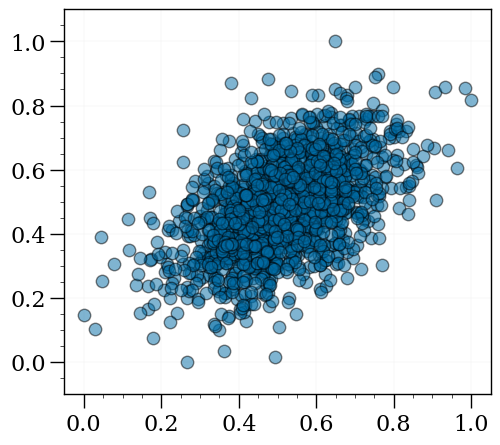

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'gauss_05')

## Gauss $\rho=0.9$

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'gauss_09')

  0%|          | 1/10000 [00:58<163:42:47, 58.94s/it]

Iter 0. Loss [[0.34030595 0.20168763 8.871928  ]]


  0%|          | 11/10000 [01:57<4:04:08,  1.47s/it]

Iter 10. Loss [[0.34732166 0.2043313  1.5814645 ]]


  0%|          | 21/10000 [02:00<1:15:21,  2.21it/s]

Iter 20. Loss [[0.3342388  0.15019098 1.4331986 ]]


  0%|          | 31/10000 [02:04<54:54,  3.03it/s]

Iter 30. Loss [[0.3390497 0.1604905 1.2194448]]


  0%|          | 41/10000 [02:07<53:47,  3.09it/s]

Iter 40. Loss [[0.34000966 0.16347732 1.0898439 ]]


  1%|          | 51/10000 [02:10<44:19,  3.74it/s]

Iter 50. Loss [[0.33714196 0.15449311 1.0006068 ]]


  1%|          | 61/10000 [02:13<46:13,  3.58it/s]

Iter 60. Loss [[0.3317336  0.15998869 1.0084181 ]]


  1%|          | 71/10000 [02:17<1:08:37,  2.41it/s]

Iter 70. Loss [[0.33887655 0.16886172 0.9646108 ]]


  1%|          | 81/10000 [02:20<45:41,  3.62it/s]

Iter 80. Loss [[0.32520688 0.12961067 0.7708685 ]]


  1%|          | 91/10000 [02:23<54:38,  3.02it/s]

Iter 90. Loss [[0.31645423 0.10294481 0.76407754]]


  1%|          | 101/10000 [02:25<42:59,  3.84it/s]

Iter 100. Loss [[0.31206596 0.09717158 0.6328912 ]]


  1%|          | 111/10000 [02:30<1:12:12,  2.28it/s]

Iter 110. Loss [[0.30175894 0.11362074 0.45373935]]


  1%|          | 121/10000 [02:32<43:53,  3.75it/s]

Iter 120. Loss [[0.31460452 0.10813078 0.24736787]]


  1%|▏         | 131/10000 [02:35<44:23,  3.70it/s]

Iter 130. Loss [[0.3550577 0.332903  6.383302 ]]


  1%|▏         | 141/10000 [02:38<59:50,  2.75it/s]  

Iter 140. Loss [[0.15291744 0.09190235 1.2864505 ]]


  2%|▏         | 151/10000 [02:42<1:00:55,  2.69it/s]

Iter 150. Loss [[0.14726551 0.10376121 1.3116946 ]]


  2%|▏         | 161/10000 [02:45<52:41,  3.11it/s]

Iter 160. Loss [[0.2173684  0.07195465 1.2806824 ]]


  2%|▏         | 171/10000 [02:48<43:16,  3.79it/s]

Iter 170. Loss [[0.1843487  0.09190459 1.0543277 ]]


  2%|▏         | 181/10000 [02:51<45:24,  3.60it/s]

Iter 180. Loss [[0.21526809 0.08208814 0.97827977]]


  2%|▏         | 191/10000 [02:54<1:15:51,  2.15it/s]

Iter 190. Loss [[0.22166216 0.09066093 0.8196128 ]]


  2%|▏         | 201/10000 [02:58<49:50,  3.28it/s]

Iter 200. Loss [[0.24094972 0.09592456 0.70422995]]


  2%|▏         | 211/10000 [03:01<51:01,  3.20it/s]

Iter 210. Loss [[0.2747726  0.09528507 0.5778255 ]]


  2%|▏         | 221/10000 [03:04<43:10,  3.77it/s]

Iter 220. Loss [[0.28186712 0.09058854 0.5015513 ]]


  2%|▏         | 231/10000 [03:07<44:58,  3.62it/s]

Iter 230. Loss [[0.29344895 0.09532975 0.37092805]]


  2%|▏         | 241/10000 [03:11<1:04:10,  2.53it/s]

Iter 240. Loss [[0.29866046 0.09134711 0.27515116]]


  3%|▎         | 251/10000 [03:14<43:59,  3.69it/s]

Iter 250. Loss [[0.29545283 0.08162555 0.21407601]]


  3%|▎         | 261/10000 [03:17<53:14,  3.05it/s]

Iter 260. Loss [[0.2935435  0.07858968 0.11708024]]


  3%|▎         | 271/10000 [03:19<43:10,  3.76it/s]

Iter 270. Loss [[ 0.29811442  0.0791982  -0.00227889]]


  3%|▎         | 281/10000 [03:24<1:12:51,  2.22it/s]

Iter 280. Loss [[ 0.30033216  0.07510994 -0.11726731]]


  3%|▎         | 291/10000 [03:26<44:02,  3.67it/s]

Iter 290. Loss [[ 0.29652402  0.06704943 -0.21367557]]


  3%|▎         | 301/10000 [03:29<43:32,  3.71it/s]

Iter 300. Loss [[ 0.29165143  0.05670262 -0.296417  ]]


  3%|▎         | 311/10000 [03:33<52:51,  3.05it/s]

Iter 310. Loss [[ 0.2902771   0.05490408 -0.41852534]]


  3%|▎         | 321/10000 [03:36<1:05:32,  2.46it/s]

Iter 320. Loss [[ 0.2852192   0.0520587  -0.49653214]]


  3%|▎         | 331/10000 [03:40<48:33,  3.32it/s]

Iter 330. Loss [[ 0.28865558  0.05591503 -0.51127297]]


  3%|▎         | 341/10000 [03:43<1:06:25,  2.42it/s]

Iter 340. Loss [[ 0.3036576  0.0650714 -0.5708994]]


  4%|▎         | 351/10000 [03:47<45:26,  3.54it/s]

Iter 350. Loss [[0.21659815 0.09249074 0.80280894]]


  4%|▎         | 361/10000 [03:51<1:22:24,  1.95it/s]

Iter 360. Loss [[0.2526589  0.04641504 0.25531653]]


  4%|▎         | 371/10000 [03:54<44:04,  3.64it/s]

Iter 370. Loss [[ 0.28912613  0.04875568 -0.14194182]]


  4%|▍         | 381/10000 [03:57<47:59,  3.34it/s]

Iter 380. Loss [[ 0.292492    0.06023622 -0.2418414 ]]


  4%|▍         | 391/10000 [03:59<42:06,  3.80it/s]

Iter 390. Loss [[ 0.28708124  0.06213972 -0.34840226]]


  4%|▍         | 401/10000 [04:03<1:06:09,  2.42it/s]

Iter 400. Loss [[ 0.28987616  0.05790247 -0.4373155 ]]


  4%|▍         | 411/10000 [04:07<1:06:15,  2.41it/s]

Iter 410. Loss [[ 0.28508005  0.05581413 -0.4709017 ]]


  4%|▍         | 421/10000 [04:09<42:38,  3.74it/s]

Iter 420. Loss [[ 0.28024155  0.05342823 -0.51738995]]


  4%|▍         | 431/10000 [04:12<49:36,  3.22it/s]

Iter 430. Loss [[ 0.28152153  0.05280131 -0.5437045 ]]


  4%|▍         | 441/10000 [04:15<57:57,  2.75it/s]

Iter 440. Loss [[ 0.28592643  0.05487512 -0.5680951 ]]


  5%|▍         | 451/10000 [04:19<48:43,  3.27it/s]

Iter 450. Loss [[ 0.28861594  0.05930997 -0.6233995 ]]


  5%|▍         | 461/10000 [04:22<42:50,  3.71it/s]

Iter 460. Loss [[ 0.2898471   0.06125179 -0.6496826 ]]


  5%|▍         | 471/10000 [04:25<42:43,  3.72it/s]

Iter 470. Loss [[ 0.2903284   0.06344328 -0.6773496 ]]


  5%|▍         | 481/10000 [04:28<1:00:57,  2.60it/s]

Iter 480. Loss [[ 0.29060617  0.06518335 -0.70444626]]


  5%|▍         | 491/10000 [04:32<51:04,  3.10it/s]

Iter 490. Loss [[ 0.29114023  0.06737266 -0.72915655]]


  5%|▌         | 501/10000 [04:35<44:35,  3.55it/s]

Iter 500. Loss [[ 0.2923791  0.0698833 -0.7548461]]


  5%|▌         | 511/10000 [04:38<40:36,  3.89it/s]

Iter 510. Loss [[ 0.29318944  0.07224153 -0.77690715]]


  5%|▌         | 521/10000 [04:41<44:00,  3.59it/s]

Iter 520. Loss [[ 0.29440066  0.07492616 -0.81142193]]


  5%|▌         | 531/10000 [04:45<1:15:18,  2.10it/s]

Iter 530. Loss [[ 0.29485336  0.07724515 -0.83592194]]


  5%|▌         | 541/10000 [04:48<42:57,  3.67it/s]

Iter 540. Loss [[ 0.2952755   0.08001737 -0.8672071 ]]


  6%|▌         | 551/10000 [04:51<48:01,  3.28it/s]

Iter 550. Loss [[ 0.29612553  0.08175018 -0.8797996 ]]


  6%|▌         | 561/10000 [04:53<41:24,  3.80it/s]

Iter 560. Loss [[ 0.294164   0.0819255 -0.8724387]]


  6%|▌         | 571/10000 [04:58<1:08:04,  2.31it/s]

Iter 570. Loss [[ 0.29745317  0.07873394 -0.84582764]]


  6%|▌         | 581/10000 [05:01<1:04:59,  2.42it/s]

Iter 580. Loss [[ 0.2931322   0.08491098 -0.89680564]]


  6%|▌         | 591/10000 [05:04<41:55,  3.74it/s]

Iter 590. Loss [[ 0.28579172  0.08662304 -0.875131  ]]


  6%|▌         | 601/10000 [05:07<48:48,  3.21it/s]

Iter 600. Loss [[ 0.3170125   0.13766807 -0.558103  ]]


  6%|▌         | 611/10000 [05:10<1:02:11,  2.52it/s]

Iter 610. Loss [[0.33407962 0.14017606 0.02180742]]


  6%|▌         | 621/10000 [05:14<45:55,  3.40it/s]

Iter 620. Loss [[ 0.2704748   0.13744889 -0.22902746]]


  6%|▋         | 631/10000 [05:16<40:41,  3.84it/s]

Iter 630. Loss [[ 0.285637    0.06220939 -0.40483853]]


  6%|▋         | 641/10000 [05:19<42:21,  3.68it/s]

Iter 640. Loss [[ 0.259206    0.05380293 -0.4774594 ]]


  7%|▋         | 651/10000 [05:23<1:07:38,  2.30it/s]

Iter 650. Loss [[ 0.26083562  0.05884212 -0.55194646]]


  7%|▋         | 661/10000 [05:26<45:00,  3.46it/s]

Iter 660. Loss [[ 0.27117574  0.05974165 -0.61807525]]


  7%|▋         | 671/10000 [05:29<44:11,  3.52it/s]

Iter 670. Loss [[ 0.27138227  0.06266486 -0.67641586]]


  7%|▋         | 681/10000 [05:32<40:32,  3.83it/s]

Iter 680. Loss [[ 0.26963663  0.06446379 -0.72194064]]


  7%|▋         | 691/10000 [05:35<41:59,  3.69it/s]

Iter 690. Loss [[ 0.2706098   0.06486216 -0.76536715]]


  7%|▋         | 701/10000 [05:39<1:04:08,  2.42it/s]

Iter 700. Loss [[ 0.27299333  0.06675767 -0.80839336]]


  7%|▋         | 711/10000 [05:42<40:46,  3.80it/s]

Iter 710. Loss [[ 0.27338296  0.06850629 -0.8495043 ]]


  7%|▋         | 721/10000 [05:45<43:45,  3.53it/s]

Iter 720. Loss [[ 0.27381763  0.06957125 -0.87128997]]


  7%|▋         | 731/10000 [05:47<40:05,  3.85it/s]

Iter 730. Loss [[ 0.2765615   0.06970371 -0.8940352 ]]


  7%|▋         | 741/10000 [05:52<1:04:34,  2.39it/s]

Iter 740. Loss [[ 0.28101572  0.07191705 -0.9066514 ]]


  8%|▊         | 751/10000 [05:55<55:43,  2.77it/s]  

Iter 750. Loss [[ 0.28406522  0.07018636 -0.9207283 ]]


  8%|▊         | 761/10000 [05:57<40:30,  3.80it/s]

Iter 760. Loss [[ 0.28418377  0.0724502  -0.96466976]]


  8%|▊         | 771/10000 [06:00<45:51,  3.35it/s]

Iter 770. Loss [[ 0.2862425   0.07238812 -0.99038637]]


  8%|▊         | 781/10000 [06:04<1:00:16,  2.55it/s]

Iter 780. Loss [[ 0.28769115  0.07318413 -1.0202914 ]]


  8%|▊         | 791/10000 [06:07<43:42,  3.51it/s]

Iter 790. Loss [[ 0.28836367  0.07310399 -1.0430529 ]]


  8%|▊         | 801/10000 [06:10<1:03:05,  2.43it/s]

Iter 800. Loss [[ 0.2882877   0.07305264 -1.0527121 ]]


  8%|▊         | 811/10000 [06:13<40:05,  3.82it/s]

Iter 810. Loss [[ 0.28695884  0.07315757 -1.0427912 ]]


  8%|▊         | 821/10000 [06:16<1:00:01,  2.55it/s]

Iter 820. Loss [[ 0.28820232  0.07235215 -1.0556829 ]]


  8%|▊         | 831/10000 [06:20<45:54,  3.33it/s]

Iter 830. Loss [[ 0.28825617  0.07320971 -1.0667964 ]]


  8%|▊         | 841/10000 [06:23<42:02,  3.63it/s]

Iter 840. Loss [[ 0.2893534   0.07460944 -1.0875392 ]]


  9%|▊         | 851/10000 [06:26<39:27,  3.86it/s]

Iter 850. Loss [[ 0.29053104  0.07610878 -1.1233667 ]]


  9%|▊         | 861/10000 [06:29<40:09,  3.79it/s]

Iter 860. Loss [[ 0.28996974  0.0778857  -1.1610973 ]]


  9%|▊         | 871/10000 [06:33<1:06:00,  2.30it/s]

Iter 870. Loss [[ 0.28536296  0.08086441 -1.1580368 ]]


  9%|▉         | 881/10000 [06:35<39:12,  3.88it/s]

Iter 880. Loss [[ 0.28872612  0.07981296 -1.2028028 ]]


  9%|▉         | 891/10000 [06:38<41:43,  3.64it/s]

Iter 890. Loss [[ 0.27920517  0.08887333 -1.1804546 ]]


  9%|▉         | 901/10000 [06:41<38:39,  3.92it/s]

Iter 900. Loss [[ 0.29179454  0.08068108 -1.26132   ]]


  9%|▉         | 911/10000 [06:45<1:02:29,  2.42it/s]

Iter 910. Loss [[ 0.28364912  0.0853608  -1.2277704 ]]


  9%|▉         | 921/10000 [06:48<56:41,  2.67it/s]  

Iter 920. Loss [[ 0.2875241   0.08026936 -1.2434039 ]]


  9%|▉         | 931/10000 [06:51<39:27,  3.83it/s]

Iter 930. Loss [[ 0.30322695  0.08152563 -1.2938346 ]]


  9%|▉         | 941/10000 [06:54<43:48,  3.45it/s]

Iter 940. Loss [[ 0.27870262  0.09031756 -1.215802  ]]


 10%|▉         | 951/10000 [06:56<48:41,  3.10it/s]

Iter 950. Loss [[ 0.2670736  0.0944295 -1.005395 ]]


 10%|▉         | 961/10000 [07:00<44:58,  3.35it/s]

Iter 960. Loss [[ 0.30647415  0.07216994 -1.2527752 ]]


 10%|▉         | 971/10000 [07:03<1:00:45,  2.48it/s]

Iter 970. Loss [[ 0.30646977  0.08047019 -1.3377999 ]]


 10%|▉         | 981/10000 [07:06<38:59,  3.85it/s]

Iter 980. Loss [[ 0.26176855  0.11578862 -0.99209267]]


 10%|▉         | 991/10000 [07:09<45:21,  3.31it/s]

Iter 990. Loss [[ 0.28419977  0.08011366 -1.2674907 ]]


 10%|█         | 1001/10000 [07:13<58:41,  2.56it/s]

Iter 1000. Loss [[ 0.30757722  0.07612127 -1.2678801 ]]


 10%|█         | 1011/10000 [07:16<41:23,  3.62it/s]

Iter 1010. Loss [[ 0.30322573  0.07346524 -1.3623114 ]]


 10%|█         | 1021/10000 [07:18<37:53,  3.95it/s]

Iter 1020. Loss [[ 0.3004356   0.07739154 -1.4137608 ]]


 10%|█         | 1031/10000 [07:21<38:41,  3.86it/s]

Iter 1030. Loss [[ 0.28606364  0.07767104 -1.3184886 ]]


 10%|█         | 1041/10000 [07:25<1:07:32,  2.21it/s]

Iter 1040. Loss [[ 0.29541433  0.06742246 -1.3999648 ]]


 11%|█         | 1051/10000 [07:28<40:52,  3.65it/s]

Iter 1050. Loss [[ 0.28320178  0.077833   -1.3589027 ]]


 11%|█         | 1061/10000 [07:31<41:45,  3.57it/s]

Iter 1060. Loss [[ 0.2848414   0.07565842 -1.3468627 ]]


 11%|█         | 1071/10000 [07:34<38:11,  3.90it/s]

Iter 1070. Loss [[ 0.28030828  0.06885852 -1.2383525 ]]


 11%|█         | 1081/10000 [07:37<46:55,  3.17it/s]

Iter 1080. Loss [[ 0.31110433  0.05070814 -1.0883933 ]]


 11%|█         | 1091/10000 [07:41<59:43,  2.49it/s]  

Iter 1090. Loss [[ 0.3133764   0.06962416 -0.24360685]]


 11%|█         | 1101/10000 [07:43<38:16,  3.88it/s]

Iter 1100. Loss [[ 0.3181983   0.07273294 -0.7113753 ]]


 11%|█         | 1111/10000 [07:46<41:42,  3.55it/s]

Iter 1110. Loss [[ 0.29881784  0.03456673 -1.0120635 ]]


 11%|█         | 1121/10000 [07:49<39:07,  3.78it/s]

Iter 1120. Loss [[ 0.28823313  0.04367344 -1.125302  ]]


 11%|█▏        | 1131/10000 [07:53<1:02:40,  2.36it/s]

Iter 1130. Loss [[ 0.29562992  0.04312636 -1.1789751 ]]


 11%|█▏        | 1141/10000 [07:56<59:28,  2.48it/s]

Iter 1140. Loss [[ 0.30474722  0.05587173 -1.2964938 ]]


 12%|█▏        | 1151/10000 [07:59<38:22,  3.84it/s]

Iter 1150. Loss [[ 0.31009772  0.06855427 -1.3648369 ]]


 12%|█▏        | 1161/10000 [08:02<45:08,  3.26it/s]

Iter 1160. Loss [[ 0.268651    0.1261962  -0.74548817]]


 12%|█▏        | 1171/10000 [08:05<57:14,  2.57it/s]

Iter 1170. Loss [[ 0.3190986   0.09669777 -1.4311247 ]]


 12%|█▏        | 1181/10000 [08:09<42:58,  3.42it/s]

Iter 1180. Loss [[0.37183237 1.0645955  5.268868  ]]


 12%|█▏        | 1191/10000 [08:11<38:29,  3.81it/s]

Iter 1190. Loss [[ 0.35389498  0.3458968  -0.677302  ]]


 12%|█▏        | 1201/10000 [08:14<38:19,  3.83it/s]

Iter 1200. Loss [[0.2603304  0.14560553 0.15560623]]


 12%|█▏        | 1211/10000 [08:18<1:00:19,  2.43it/s]

Iter 1210. Loss [[ 0.2984095   0.04965765 -0.75334823]]


 12%|█▏        | 1221/10000 [08:21<43:21,  3.37it/s]

Iter 1220. Loss [[ 0.30927455  0.05834277 -0.6431627 ]]


 12%|█▏        | 1231/10000 [08:24<41:24,  3.53it/s]

Iter 1230. Loss [[ 0.265284    0.04040593 -0.7355283 ]]


 12%|█▏        | 1241/10000 [08:27<37:36,  3.88it/s]

Iter 1240. Loss [[ 0.2884194   0.02819577 -0.8201326 ]]


 13%|█▎        | 1251/10000 [08:30<38:40,  3.77it/s]

Iter 1250. Loss [[ 0.28108665  0.03488655 -0.92939055]]


 13%|█▎        | 1261/10000 [08:34<1:07:07,  2.17it/s]

Iter 1260. Loss [[ 0.29299948  0.03462043 -1.0136079 ]]


 13%|█▎        | 1271/10000 [08:37<37:56,  3.84it/s]

Iter 1270. Loss [[ 0.2947906   0.03606614 -1.0737305 ]]


 13%|█▎        | 1281/10000 [08:40<40:06,  3.62it/s]

Iter 1280. Loss [[ 0.2950955   0.04208742 -1.1253761 ]]


 13%|█▎        | 1291/10000 [08:42<36:56,  3.93it/s]

Iter 1290. Loss [[ 0.30347973  0.04738096 -1.2047176 ]]


 13%|█▎        | 1301/10000 [08:46<59:36,  2.43it/s]

Iter 1300. Loss [[ 0.30680254  0.05674134 -1.2638398 ]]


 13%|█▎        | 1311/10000 [08:51<1:09:36,  2.08it/s]

Iter 1310. Loss [[ 0.30248386  0.05997058 -1.3021966 ]]


 13%|█▎        | 1321/10000 [08:53<36:46,  3.93it/s]

Iter 1320. Loss [[ 0.30168423  0.06038147 -1.3126231 ]]


 13%|█▎        | 1331/10000 [08:56<41:39,  3.47it/s]

Iter 1330. Loss [[ 0.30647308  0.06611227 -1.3448495 ]]


 13%|█▎        | 1341/10000 [08:59<52:56,  2.73it/s]

Iter 1340. Loss [[ 0.30576    0.0658372 -1.3465884]]


 14%|█▎        | 1351/10000 [09:03<40:41,  3.54it/s]

Iter 1350. Loss [[ 0.3072519   0.06760688 -1.3570155 ]]


 14%|█▎        | 1361/10000 [09:06<56:22,  2.55it/s]

Iter 1360. Loss [[ 0.30800664  0.06918335 -1.3631645 ]]


 14%|█▎        | 1371/10000 [09:08<36:48,  3.91it/s]

Iter 1370. Loss [[ 0.30845326  0.06988497 -1.3657129 ]]


 14%|█▍        | 1381/10000 [09:11<45:10,  3.18it/s]

Iter 1380. Loss [[ 0.30943334  0.07106969 -1.3715138 ]]


 14%|█▍        | 1391/10000 [09:15<48:12,  2.98it/s]

Iter 1390. Loss [[ 0.3098075  0.0713588 -1.3698219]]


 14%|█▍        | 1401/10000 [09:18<38:24,  3.73it/s]

Iter 1400. Loss [[ 0.31015006  0.07157032 -1.3688724 ]]


 14%|█▍        | 1411/10000 [09:21<37:28,  3.82it/s]

Iter 1410. Loss [[ 0.31030145  0.0717307  -1.3650585 ]]


 14%|█▍        | 1421/10000 [09:24<37:20,  3.83it/s]

Iter 1420. Loss [[ 0.39602473  7.508134   17.414383  ]]


 14%|█▍        | 1431/10000 [09:28<1:08:13,  2.09it/s]

Iter 1430. Loss [[ 0.39510512  5.789396   18.297077  ]]


 14%|█▍        | 1441/10000 [09:30<37:06,  3.84it/s]

Iter 1440. Loss [[ 0.38784212  2.4610755  17.17711   ]]


 15%|█▍        | 1451/10000 [09:33<39:24,  3.62it/s]

Iter 1450. Loss [[ 0.35484096  0.5006296  11.9759035 ]]


 15%|█▍        | 1461/10000 [09:36<36:24,  3.91it/s]

Iter 1460. Loss [[0.2821714  0.08423357 0.63586307]]


 15%|█▍        | 1471/10000 [09:39<54:21,  2.61it/s]

Iter 1470. Loss [[0.22805803 0.15986632 1.126283  ]]


 15%|█▍        | 1481/10000 [09:43<49:30,  2.87it/s]

Iter 1480. Loss [[0.2888657  0.0981028  0.32451683]]


 15%|█▍        | 1491/10000 [09:46<36:34,  3.88it/s]

Iter 1490. Loss [[0.2914818  0.09503452 0.40869907]]


 15%|█▌        | 1501/10000 [09:49<39:47,  3.56it/s]

Iter 1500. Loss [[0.27312946 0.0823732  0.40761572]]


 15%|█▌        | 1511/10000 [09:51<36:03,  3.92it/s]

Iter 1510. Loss [[0.27639082 0.08133525 0.39693773]]


 15%|█▌        | 1521/10000 [09:55<46:26,  3.04it/s]

Iter 1520. Loss [[0.28283355 0.08464371 0.4005113 ]]


 15%|█▌        | 1531/10000 [09:59<51:11,  2.76it/s]

Iter 1530. Loss [[0.2863813  0.09072133 0.37960127]]


 15%|█▌        | 1541/10000 [10:01<36:20,  3.88it/s]

Iter 1540. Loss [[0.29075795 0.09603052 0.36230645]]


 16%|█▌        | 1551/10000 [10:04<41:22,  3.40it/s]

Iter 1550. Loss [[0.29359096 0.09802549 0.31425744]]


 16%|█▌        | 1561/10000 [10:08<57:02,  2.47it/s]

Iter 1560. Loss [[0.292115   0.09653085 0.27722004]]


 16%|█▌        | 1571/10000 [10:11<38:41,  3.63it/s]

Iter 1570. Loss [[0.28929326 0.08279067 0.22042291]]


 16%|█▌        | 1581/10000 [10:14<55:46,  2.52it/s]

Iter 1580. Loss [[0.28480557 0.07428811 0.24822314]]


 16%|█▌        | 1591/10000 [10:17<36:33,  3.83it/s]

Iter 1590. Loss [[0.28232288 0.06563983 0.16206476]]


 16%|█▌        | 1601/10000 [10:20<59:51,  2.34it/s]

Iter 1600. Loss [[0.2767851  0.06112733 0.02583764]]


 16%|█▌        | 1611/10000 [10:23<38:15,  3.65it/s]

Iter 1610. Loss [[ 0.26508254  0.04561388 -0.07342452]]


 16%|█▌        | 1621/10000 [10:26<37:51,  3.69it/s]

Iter 1620. Loss [[ 0.24752575  0.0327766  -0.23844515]]


 16%|█▋        | 1631/10000 [10:29<36:06,  3.86it/s]

Iter 1630. Loss [[ 0.25494465  0.0331799  -0.31947157]]


 16%|█▋        | 1641/10000 [10:32<39:54,  3.49it/s]

Iter 1640. Loss [[ 0.24680175  0.03195329 -0.43594196]]


 17%|█▋        | 1651/10000 [10:36<54:29,  2.55it/s]  

Iter 1650. Loss [[ 0.25730273  0.03222599 -0.5850123 ]]


 17%|█▋        | 1661/10000 [10:39<35:53,  3.87it/s]

Iter 1660. Loss [[ 0.26474363  0.03083989 -0.708493  ]]


 17%|█▋        | 1671/10000 [10:42<38:36,  3.59it/s]

Iter 1670. Loss [[ 0.27492782  0.03117232 -0.79494286]]


 17%|█▋        | 1681/10000 [10:44<34:02,  4.07it/s]

Iter 1680. Loss [[ 0.27782285  0.03512361 -0.8946471 ]]


 17%|█▋        | 1691/10000 [10:48<57:19,  2.42it/s]

Iter 1690. Loss [[ 0.27554893  0.04149809 -0.99207777]]


 17%|█▋        | 1701/10000 [10:51<48:58,  2.82it/s]

Iter 1700. Loss [[ 0.26210973  0.05781118 -1.0529923 ]]


 17%|█▋        | 1711/10000 [10:54<34:50,  3.96it/s]

Iter 1710. Loss [[ 0.2765814   0.05569826 -1.0360248 ]]


 17%|█▋        | 1721/10000 [10:57<37:39,  3.66it/s]

Iter 1720. Loss [[ 0.28208444  0.04875528 -1.0601561 ]]


 17%|█▋        | 1731/10000 [11:00<48:01,  2.87it/s]

Iter 1730. Loss [[ 0.28254816  0.06018799 -1.1457543 ]]


 17%|█▋        | 1741/10000 [11:04<38:55,  3.54it/s]

Iter 1740. Loss [[ 0.28770235  0.05572685 -1.1194239 ]]


 18%|█▊        | 1751/10000 [11:07<48:09,  2.85it/s]

Iter 1750. Loss [[ 0.29041213  0.06074043 -1.144767  ]]


 18%|█▊        | 1761/10000 [11:09<35:36,  3.86it/s]

Iter 1760. Loss [[ 0.2889987   0.06317802 -1.1718789 ]]


 18%|█▊        | 1771/10000 [11:12<39:24,  3.48it/s]

Iter 1770. Loss [[ 0.2863794   0.06996392 -1.226294  ]]


 18%|█▊        | 1781/10000 [11:16<47:23,  2.89it/s]

Iter 1780. Loss [[ 0.2780653   0.08703408 -1.2297624 ]]


 18%|█▊        | 1791/10000 [11:19<37:23,  3.66it/s]

Iter 1790. Loss [[ 0.2901089   0.07468176 -1.2568419 ]]


 18%|█▊        | 1801/10000 [11:22<53:41,  2.54it/s]

Iter 1800. Loss [[ 0.2902248   0.08341487 -1.3122656 ]]


 18%|█▊        | 1811/10000 [11:25<35:40,  3.83it/s]

Iter 1810. Loss [[ 0.29908654  0.09328428 -1.3517843 ]]


 18%|█▊        | 1821/10000 [11:28<1:01:17,  2.22it/s]

Iter 1820. Loss [[ 0.29765907  0.06847253 -1.1734583 ]]


 18%|█▊        | 1831/10000 [11:31<35:47,  3.80it/s]

Iter 1830. Loss [[ 0.23941343  0.09972581 -0.94654155]]


 18%|█▊        | 1841/10000 [11:34<36:47,  3.70it/s]

Iter 1840. Loss [[ 0.28332365  0.08481535 -1.2103952 ]]


 19%|█▊        | 1851/10000 [11:37<34:51,  3.90it/s]

Iter 1850. Loss [[ 0.2743398   0.07230081 -1.1913135 ]]


 19%|█▊        | 1861/10000 [11:40<47:54,  2.83it/s]

Iter 1860. Loss [[ 0.28755027  0.06785253 -1.2245712 ]]


 19%|█▊        | 1871/10000 [11:44<48:33,  2.79it/s]

Iter 1870. Loss [[ 0.2885669   0.06674081 -1.2317634 ]]


 19%|█▉        | 1881/10000 [11:47<35:10,  3.85it/s]

Iter 1880. Loss [[ 0.2874671   0.07126926 -1.2699567 ]]


 19%|█▉        | 1891/10000 [11:50<37:43,  3.58it/s]

Iter 1890. Loss [[ 0.28790882  0.07232667 -1.2869774 ]]


 19%|█▉        | 1901/10000 [11:52<34:44,  3.89it/s]

Iter 1900. Loss [[ 0.28768218  0.07557916 -1.3184849 ]]


 19%|█▉        | 1911/10000 [11:56<47:47,  2.82it/s]

Iter 1910. Loss [[ 0.287177    0.07677482 -1.3342553 ]]


 19%|█▉        | 1921/10000 [11:59<44:11,  3.05it/s]

Iter 1920. Loss [[ 0.28639     0.08199687 -1.3934609 ]]


 19%|█▉        | 1931/10000 [12:02<34:30,  3.90it/s]

Iter 1930. Loss [[ 0.28134093  0.08834155 -1.450369  ]]


 19%|█▉        | 1941/10000 [12:05<37:16,  3.60it/s]

Iter 1940. Loss [[ 0.26123926  0.09972345 -1.3828638 ]]


 20%|█▉        | 1951/10000 [12:08<52:10,  2.57it/s]

Iter 1950. Loss [[ 0.28025243  0.09302259 -1.3346953 ]]


 20%|█▉        | 1961/10000 [12:12<36:22,  3.68it/s]

Iter 1960. Loss [[ 0.29086116  0.09647623 -1.3364854 ]]


 20%|█▉        | 1971/10000 [12:15<47:29,  2.82it/s]

Iter 1970. Loss [[ 0.28107092  0.11760498 -1.3082627 ]]


 20%|█▉        | 1981/10000 [12:17<34:09,  3.91it/s]

Iter 1980. Loss [[ 0.31427935  0.10061086 -0.8272532 ]]


 20%|█▉        | 1991/10000 [12:20<50:04,  2.67it/s]

Iter 1990. Loss [[ 0.30689606  0.06493489 -0.86224365]]


 20%|██        | 2001/10000 [12:24<39:17,  3.39it/s]

Iter 2000. Loss [[ 0.29802063  0.06361099 -1.163168  ]]


 20%|██        | 2011/10000 [12:27<34:58,  3.81it/s]

Iter 2010. Loss [[ 0.2996243   0.06081276 -1.1594763 ]]


 20%|██        | 2021/10000 [12:30<51:35,  2.58it/s]

Iter 2020. Loss [[ 0.28582236  0.06442551 -1.1945138 ]]


 20%|██        | 2031/10000 [12:32<33:52,  3.92it/s]

Iter 2030. Loss [[ 0.28594854  0.06770863 -1.1781219 ]]


 20%|██        | 2041/10000 [12:36<1:00:26,  2.19it/s]

Iter 2040. Loss [[ 0.30228433  0.06347132 -1.2018944 ]]


 21%|██        | 2051/10000 [12:39<33:38,  3.94it/s]

Iter 2050. Loss [[ 0.31879184  0.07810499 -1.0080557 ]]


 21%|██        | 2061/10000 [12:42<35:15,  3.75it/s]

Iter 2060. Loss [[ 0.26922402  0.15769486 -0.47038516]]


 21%|██        | 2071/10000 [12:44<33:16,  3.97it/s]

Iter 2070. Loss [[ 0.30862638  0.23087466 -0.44592986]]


 21%|██        | 2081/10000 [12:48<50:02,  2.64it/s]

Iter 2080. Loss [[ 0.3101763   0.15815112 -0.33648896]]


 21%|██        | 2091/10000 [12:52<45:48,  2.88it/s]

Iter 2090. Loss [[ 0.28354183  0.06031443 -0.45279458]]


 21%|██        | 2101/10000 [12:54<34:14,  3.84it/s]

Iter 2100. Loss [[ 0.30508214  0.04782424 -0.49286038]]


 21%|██        | 2111/10000 [12:57<37:05,  3.55it/s]

Iter 2110. Loss [[ 0.2798416   0.03238669 -0.53703994]]


 21%|██        | 2121/10000 [13:00<32:53,  3.99it/s]

Iter 2120. Loss [[ 0.27360266  0.02672311 -0.5894184 ]]


 21%|██▏       | 2131/10000 [13:04<42:53,  3.06it/s]

Iter 2130. Loss [[ 0.2731487   0.02955558 -0.6689019 ]]


 21%|██▏       | 2141/10000 [13:07<45:42,  2.87it/s]

Iter 2140. Loss [[ 0.28306997  0.03017559 -0.7259558 ]]


 22%|██▏       | 2151/10000 [13:09<34:31,  3.79it/s]

Iter 2150. Loss [[ 0.28562608  0.03229105 -0.7799443 ]]


 22%|██▏       | 2161/10000 [13:12<36:48,  3.55it/s]

Iter 2160. Loss [[ 0.28979978  0.03235769 -0.80650115]]


 22%|██▏       | 2171/10000 [13:16<52:06,  2.50it/s]

Iter 2170. Loss [[ 0.27989078  0.03613928 -0.8792612 ]]


 22%|██▏       | 2181/10000 [13:19<34:53,  3.74it/s]

Iter 2180. Loss [[ 0.2811358   0.03938702 -0.94899476]]


 22%|██▏       | 2191/10000 [13:22<45:36,  2.85it/s]

Iter 2190. Loss [[ 0.28165355  0.04465006 -1.0422369 ]]


 22%|██▏       | 2201/10000 [13:25<33:14,  3.91it/s]

Iter 2200. Loss [[ 0.2842665   0.05664583 -1.152919  ]]


 22%|██▏       | 2211/10000 [13:28<51:42,  2.51it/s]

Iter 2210. Loss [[ 0.29918557  0.04111445 -0.9587645 ]]


 22%|██▏       | 2221/10000 [13:32<36:12,  3.58it/s]

Iter 2220. Loss [[ 0.28505814  0.04345038 -1.0496796 ]]


 22%|██▏       | 2231/10000 [13:35<34:53,  3.71it/s]

Iter 2230. Loss [[ 0.28964776  0.04830354 -1.0924042 ]]


 22%|██▏       | 2241/10000 [13:38<50:23,  2.57it/s]

Iter 2240. Loss [[ 0.28810284  0.05352189 -1.1384771 ]]


 23%|██▎       | 2251/10000 [13:40<34:02,  3.79it/s]

Iter 2250. Loss [[ 0.2935829   0.05719008 -1.1323237 ]]


 23%|██▎       | 2261/10000 [13:44<49:39,  2.60it/s]

Iter 2260. Loss [[ 0.28928778  0.064303   -1.132222  ]]


 23%|██▎       | 2271/10000 [13:48<52:39,  2.45it/s]

Iter 2270. Loss [[ 0.29756075  0.05910075 -1.1560011 ]]


 23%|██▎       | 2281/10000 [13:51<35:48,  3.59it/s]

Iter 2280. Loss [[ 0.29679003  0.08849443 -1.139987  ]]


 23%|██▎       | 2291/10000 [13:54<36:31,  3.52it/s]

Iter 2290. Loss [[ 0.29903412  0.07029977 -1.1887379 ]]


 23%|██▎       | 2301/10000 [13:58<38:56,  3.29it/s]

Iter 2300. Loss [[ 0.30434823  0.07254739 -1.1533698 ]]


 23%|██▎       | 2311/10000 [14:01<42:50,  2.99it/s]

Iter 2310. Loss [[ 0.30560687  0.03967356 -1.028269  ]]


 23%|██▎       | 2321/10000 [14:04<33:12,  3.85it/s]

Iter 2320. Loss [[ 0.298134    0.04623408 -1.0933374 ]]


 23%|██▎       | 2331/10000 [14:07<35:45,  3.58it/s]

Iter 2330. Loss [[ 0.30949652  0.04677557 -1.0425488 ]]


 23%|██▎       | 2341/10000 [14:11<54:32,  2.34it/s]

Iter 2340. Loss [[ 0.3070808   0.04887485 -1.066324  ]]


 24%|██▎       | 2351/10000 [14:14<34:45,  3.67it/s]

Iter 2350. Loss [[ 0.2886495  0.0550367 -1.1224818]]


 24%|██▎       | 2361/10000 [14:17<45:37,  2.79it/s]

Iter 2360. Loss [[ 0.3015586   0.05023295 -1.1477985 ]]


 24%|██▎       | 2371/10000 [14:19<33:00,  3.85it/s]

Iter 2370. Loss [[ 0.29947963  0.05011956 -1.1591201 ]]


 24%|██▍       | 2381/10000 [14:23<57:43,  2.20it/s]

Iter 2380. Loss [[ 0.31155956  0.05188473 -1.091486  ]]


 24%|██▍       | 2391/10000 [14:26<34:11,  3.71it/s]

Iter 2390. Loss [[ 0.300469    0.05261128 -1.1824484 ]]


 24%|██▍       | 2401/10000 [14:29<34:26,  3.68it/s]

Iter 2400. Loss [[ 0.3021423   0.05377454 -1.1977041 ]]


 24%|██▍       | 2411/10000 [14:32<50:21,  2.51it/s]

Iter 2410. Loss [[0.25685212 0.5885485  0.54905504]]


 24%|██▍       | 2421/10000 [14:35<46:07,  2.74it/s]

Iter 2420. Loss [[ 0.34178483  0.37914994 -0.14574349]]


 24%|██▍       | 2431/10000 [14:39<42:23,  2.98it/s]

Iter 2430. Loss [[ 0.30622995  0.25621876 -0.26767847]]


 24%|██▍       | 2441/10000 [14:42<32:42,  3.85it/s]

Iter 2440. Loss [[ 0.3233407   0.09342155 -0.5702198 ]]


 25%|██▍       | 2451/10000 [14:45<34:42,  3.62it/s]

Iter 2450. Loss [[ 0.24732645  0.06399339 -0.62634385]]


 25%|██▍       | 2461/10000 [14:47<32:21,  3.88it/s]

Iter 2460. Loss [[ 0.29606727  0.03548657 -0.7522472 ]]


 25%|██▍       | 2471/10000 [14:52<42:46,  2.93it/s]

Iter 2470. Loss [[ 0.2933962   0.04008616 -0.81671363]]


 25%|██▍       | 2481/10000 [14:55<41:52,  2.99it/s]

Iter 2480. Loss [[ 0.29173374  0.04391863 -0.8825903 ]]


 25%|██▍       | 2491/10000 [14:57<33:02,  3.79it/s]

Iter 2490. Loss [[ 0.29683986  0.04324327 -0.89552695]]


 25%|██▌       | 2501/10000 [15:00<34:59,  3.57it/s]

Iter 2500. Loss [[ 0.2952014   0.04488104 -0.90709   ]]


 25%|██▌       | 2511/10000 [15:04<50:30,  2.47it/s]

Iter 2510. Loss [[ 0.2970125   0.04486212 -0.93124235]]


 25%|██▌       | 2521/10000 [15:07<34:11,  3.64it/s]

Iter 2520. Loss [[ 0.2976135   0.04699923 -0.9654873 ]]


 25%|██▌       | 2531/10000 [15:10<43:59,  2.83it/s]

Iter 2530. Loss [[ 0.3004667   0.05098066 -1.0160083 ]]


 25%|██▌       | 2541/10000 [15:13<31:48,  3.91it/s]

Iter 2540. Loss [[ 0.3021157   0.05679498 -1.0768313 ]]


 26%|██▌       | 2551/10000 [15:16<50:49,  2.44it/s]

Iter 2550. Loss [[ 0.30196226  0.0626498  -1.132432  ]]


 26%|██▌       | 2561/10000 [15:20<35:09,  3.53it/s]

Iter 2560. Loss [[ 0.3044469   0.06637633 -1.1667547 ]]


 26%|██▌       | 2571/10000 [15:23<33:27,  3.70it/s]

Iter 2570. Loss [[ 0.3081214  0.0695776 -1.166265 ]]


 26%|██▌       | 2581/10000 [15:26<43:44,  2.83it/s]

Iter 2580. Loss [[ 0.3055531   0.07356751 -1.189004  ]]


 26%|██▌       | 2591/10000 [15:28<35:22,  3.49it/s]

Iter 2590. Loss [[ 0.31238672  0.07463158 -1.1590109 ]]


 26%|██▌       | 2601/10000 [15:32<41:14,  2.99it/s]

Iter 2600. Loss [[ 0.30939385  0.07476689 -1.2017113 ]]


 26%|██▌       | 2611/10000 [15:35<32:00,  3.85it/s]

Iter 2610. Loss [[ 0.30768433  0.07516123 -1.21168   ]]


 26%|██▌       | 2621/10000 [15:38<33:07,  3.71it/s]

Iter 2620. Loss [[ 0.31182334  0.07606427 -1.1947197 ]]


 26%|██▋       | 2631/10000 [15:41<48:01,  2.56it/s]

Iter 2630. Loss [[ 0.31009728  0.07649487 -1.2189473 ]]


 26%|██▋       | 2641/10000 [15:45<53:01,  2.31it/s]

Iter 2640. Loss [[ 0.309567    0.07692329 -1.2179152 ]]


 27%|██▋       | 2651/10000 [15:48<38:14,  3.20it/s]

Iter 2650. Loss [[ 0.38682404  2.8144152  14.083591  ]]


 27%|██▋       | 2661/10000 [15:51<32:02,  3.82it/s]

Iter 2660. Loss [[ 0.38131806  1.8529792  12.67325   ]]


 27%|██▋       | 2671/10000 [15:54<33:44,  3.62it/s]

Iter 2670. Loss [[ 0.20392203  0.31026593 12.054854  ]]


 27%|██▋       | 2681/10000 [15:57<46:22,  2.63it/s]

Iter 2680. Loss [[ 0.13747795  0.31065845 12.333925  ]]


 27%|██▋       | 2691/10000 [16:00<33:42,  3.61it/s]

Iter 2690. Loss [[0.35197607 0.39781225 0.9336274 ]]


 27%|██▋       | 2701/10000 [16:04<39:48,  3.06it/s]

Iter 2700. Loss [[ 0.3242321   0.27563202 -0.6514858 ]]


 27%|██▋       | 2711/10000 [16:06<31:50,  3.81it/s]

Iter 2710. Loss [[ 0.31890035  0.24896598 -0.66458863]]


 27%|██▋       | 2721/10000 [16:10<45:28,  2.67it/s]

Iter 2720. Loss [[ 0.32262415  0.19293642 -0.45510623]]


 27%|██▋       | 2731/10000 [16:13<36:17,  3.34it/s]

Iter 2730. Loss [[ 0.3028078   0.17678794 -0.5522595 ]]


 27%|██▋       | 2741/10000 [16:16<33:00,  3.67it/s]

Iter 2740. Loss [[ 0.3043393   0.12127483 -0.47056234]]


 28%|██▊       | 2751/10000 [16:19<43:24,  2.78it/s]

Iter 2750. Loss [[ 0.2991414  0.0897648 -0.5067475]]


 28%|██▊       | 2761/10000 [16:22<31:48,  3.79it/s]

Iter 2760. Loss [[ 0.2982144   0.0661345  -0.45425162]]


 28%|██▊       | 2771/10000 [16:26<45:49,  2.63it/s]

Iter 2770. Loss [[ 0.2963793   0.04569142 -0.45565656]]


 28%|██▊       | 2781/10000 [16:29<31:57,  3.76it/s]

Iter 2780. Loss [[ 0.29897696  0.03794912 -0.48007104]]


 28%|██▊       | 2791/10000 [16:32<32:52,  3.65it/s]

Iter 2790. Loss [[ 0.29690963  0.03592543 -0.58236766]]


 28%|██▊       | 2801/10000 [16:35<48:21,  2.48it/s]

Iter 2800. Loss [[ 0.30057803  0.0368469  -0.51161   ]]


 28%|██▊       | 2811/10000 [16:38<49:12,  2.43it/s]

Iter 2810. Loss [[ 0.29201     0.02993496 -0.540293  ]]


 28%|██▊       | 2821/10000 [16:42<37:32,  3.19it/s]

Iter 2820. Loss [[ 0.28997886  0.03276193 -0.5751356 ]]


 28%|██▊       | 2831/10000 [16:44<31:48,  3.76it/s]

Iter 2830. Loss [[ 0.29296124  0.03209321 -0.6125279 ]]


 28%|██▊       | 2841/10000 [16:47<33:18,  3.58it/s]

Iter 2840. Loss [[ 0.2961581  0.0319405 -0.646522 ]]


 29%|██▊       | 2851/10000 [16:51<45:06,  2.64it/s]

Iter 2850. Loss [[ 0.2974969   0.03267886 -0.68334967]]


 29%|██▊       | 2861/10000 [16:54<34:13,  3.48it/s]

Iter 2860. Loss [[ 0.29814884  0.03357243 -0.7196967 ]]


 29%|██▊       | 2871/10000 [16:57<39:15,  3.03it/s]

Iter 2870. Loss [[ 0.2991794   0.03402669 -0.75284714]]


 29%|██▉       | 2881/10000 [17:00<30:48,  3.85it/s]

Iter 2880. Loss [[ 0.3001366   0.03457826 -0.78309196]]


 29%|██▉       | 2891/10000 [17:03<42:28,  2.79it/s]

Iter 2890. Loss [[ 0.3003591   0.03573855 -0.8080077 ]]


 29%|██▉       | 2901/10000 [17:07<36:23,  3.25it/s]

Iter 2900. Loss [[ 0.3015552   0.03573003 -0.83930403]]


 29%|██▉       | 2911/10000 [17:10<31:30,  3.75it/s]

Iter 2910. Loss [[ 0.30162394  0.03621855 -0.85096043]]


 29%|██▉       | 2921/10000 [17:13<42:05,  2.80it/s]

Iter 2920. Loss [[ 0.30252618  0.0376543  -0.87843597]]


 29%|██▉       | 2931/10000 [17:16<30:23,  3.88it/s]

Iter 2930. Loss [[ 0.30330157  0.03941515 -0.9072167 ]]


 29%|██▉       | 2941/10000 [17:20<48:14,  2.44it/s]

Iter 2940. Loss [[ 0.3035838   0.04092748 -0.929782  ]]


 30%|██▉       | 2951/10000 [17:22<30:51,  3.81it/s]

Iter 2950. Loss [[ 0.30365396  0.04172066 -0.94666356]]


 30%|██▉       | 2961/10000 [17:25<32:06,  3.65it/s]

Iter 2960. Loss [[ 0.30381322  0.0424945  -0.9633976 ]]


 30%|██▉       | 2971/10000 [17:28<46:46,  2.50it/s]

Iter 2970. Loss [[ 0.30349034  0.04326735 -0.97736996]]


 30%|██▉       | 2981/10000 [17:32<47:18,  2.47it/s]

Iter 2980. Loss [[ 0.3081045   0.04048281 -0.982291  ]]


 30%|██▉       | 2991/10000 [17:35<36:54,  3.16it/s]

Iter 2990. Loss [[ 0.30793718  0.04262845 -1.0060132 ]]


 30%|███       | 3001/10000 [17:38<30:35,  3.81it/s]

Iter 3000. Loss [[ 0.30901757  0.04337318 -1.0217953 ]]


 30%|███       | 3011/10000 [17:41<31:56,  3.65it/s]

Iter 3010. Loss [[ 0.3092925   0.04444931 -1.0392327 ]]


 30%|███       | 3021/10000 [17:44<40:04,  2.90it/s]

Iter 3020. Loss [[ 0.30977994  0.04494031 -1.0528225 ]]


 30%|███       | 3031/10000 [17:48<33:04,  3.51it/s]

Iter 3030. Loss [[ 0.31005144  0.04568242 -1.0640941 ]]


 30%|███       | 3041/10000 [17:51<38:23,  3.02it/s]

Iter 3040. Loss [[ 0.31044894  0.04634706 -1.0709091 ]]


 31%|███       | 3051/10000 [17:53<30:27,  3.80it/s]

Iter 3050. Loss [[ 0.31102267  0.04695662 -1.0742848 ]]


 31%|███       | 3061/10000 [17:56<33:17,  3.47it/s]

Iter 3060. Loss [[ 0.3117014   0.04707927 -1.0697566 ]]


 31%|███       | 3071/10000 [18:00<40:56,  2.82it/s]

Iter 3070. Loss [[ 0.31183276  0.04687596 -1.059989  ]]


 31%|███       | 3081/10000 [18:04<31:48,  3.63it/s]

Iter 3080. Loss [[ 0.31197622  0.0467596  -1.0504844 ]]


 31%|███       | 3091/10000 [18:07<42:00,  2.74it/s]

Iter 3090. Loss [[ 0.31224957  0.04669809 -1.0260531 ]]


 31%|███       | 3101/10000 [18:09<30:17,  3.80it/s]

Iter 3100. Loss [[ 0.32852244  0.07832555 -0.8463828 ]]


 31%|███       | 3111/10000 [18:13<50:26,  2.28it/s]

Iter 3110. Loss [[ 0.33407494  0.12391221 -0.5543195 ]]


 31%|███       | 3121/10000 [18:16<29:59,  3.82it/s]

Iter 3120. Loss [[ 0.30444992  0.06122081 -0.87872964]]


 31%|███▏      | 3131/10000 [18:19<31:13,  3.67it/s]

Iter 3130. Loss [[ 0.3156686   0.04953079 -0.9405249 ]]


 31%|███▏      | 3141/10000 [18:22<46:11,  2.47it/s]

Iter 3140. Loss [[ 0.3085016   0.04799933 -0.94706184]]


 32%|███▏      | 3151/10000 [18:26<45:50,  2.49it/s]

Iter 3150. Loss [[ 0.31462184  0.04688341 -0.998903  ]]


 32%|███▏      | 3161/10000 [18:29<36:33,  3.12it/s]

Iter 3160. Loss [[ 0.31216112  0.04773453 -1.0105164 ]]


 32%|███▏      | 3171/10000 [18:32<29:57,  3.80it/s]

Iter 3170. Loss [[ 0.3128152   0.04906157 -1.028667  ]]


 32%|███▏      | 3181/10000 [18:35<31:10,  3.65it/s]

Iter 3180. Loss [[ 0.3122079   0.05083305 -1.0464543 ]]


 32%|███▏      | 3191/10000 [18:37<35:45,  3.17it/s]

Iter 3190. Loss [[ 0.31500202  0.05465547 -1.0600355 ]]


 32%|███▏      | 3201/10000 [18:43<51:24,  2.20it/s]

Iter 3200. Loss [[ 0.31541434  0.0588395  -1.0874134 ]]


 32%|███▏      | 3211/10000 [18:46<38:21,  2.95it/s]

Iter 3210. Loss [[ 0.31497246  0.05609612 -1.0948428 ]]


 32%|███▏      | 3221/10000 [18:49<29:26,  3.84it/s]

Iter 3220. Loss [[ 0.31786105  0.0528807  -1.0491914 ]]


 32%|███▏      | 3231/10000 [18:52<42:08,  2.68it/s]

Iter 3230. Loss [[ 0.31663525  0.05401762 -1.0602956 ]]


 32%|███▏      | 3241/10000 [18:56<35:05,  3.21it/s]

Iter 3240. Loss [[ 0.3187546   0.05744768 -1.0910994 ]]


 33%|███▎      | 3251/10000 [18:59<30:42,  3.66it/s]

Iter 3250. Loss [[ 0.3194517   0.06110961 -1.0886981 ]]


 33%|███▎      | 3261/10000 [19:02<39:53,  2.82it/s]

Iter 3260. Loss [[ 0.31214803  0.06088025 -1.0309281 ]]


 33%|███▎      | 3271/10000 [19:04<29:45,  3.77it/s]

Iter 3270. Loss [[ 0.32269654  0.06903425 -1.130216  ]]


 33%|███▎      | 3281/10000 [19:09<41:52,  2.67it/s]

Iter 3280. Loss [[ 0.31595796  0.06363966 -1.0939125 ]]


 33%|███▎      | 3291/10000 [19:11<29:25,  3.80it/s]

Iter 3290. Loss [[ 0.31554666  0.06496181 -1.0873715 ]]


 33%|███▎      | 3301/10000 [19:14<30:34,  3.65it/s]

Iter 3300. Loss [[ 0.32151338  0.06759155 -1.1373302 ]]


 33%|███▎      | 3311/10000 [19:17<40:32,  2.75it/s]

Iter 3310. Loss [[ 0.31796262  0.06586508 -1.1378554 ]]


 33%|███▎      | 3321/10000 [19:21<45:39,  2.44it/s]

Iter 3320. Loss [[ 0.31844804  0.06705881 -1.1285073 ]]


 33%|███▎      | 3331/10000 [19:24<34:09,  3.25it/s]

Iter 3330. Loss [[ 0.31443968  0.07007366 -1.0441931 ]]


 33%|███▎      | 3341/10000 [19:27<28:46,  3.86it/s]

Iter 3340. Loss [[ 0.30726755  0.10570546 -0.8030763 ]]


 34%|███▎      | 3351/10000 [19:30<30:21,  3.65it/s]

Iter 3350. Loss [[ 0.32450175  0.06653035 -1.0236741 ]]


 34%|███▎      | 3361/10000 [19:34<1:00:39,  1.82it/s]

Iter 3360. Loss [[ 0.3116635   0.06940027 -0.99127394]]


 34%|███▎      | 3371/10000 [19:37<31:35,  3.50it/s]

Iter 3370. Loss [[ 0.31783557  0.06373727 -1.0567468 ]]


 34%|███▍      | 3381/10000 [19:40<34:15,  3.22it/s]

Iter 3380. Loss [[ 0.3094279   0.05511219 -0.98619425]]


 34%|███▍      | 3391/10000 [19:43<29:55,  3.68it/s]

Iter 3390. Loss [[ 0.3128748   0.06432056 -1.0356472 ]]


 34%|███▍      | 3401/10000 [19:46<40:13,  2.73it/s]

Iter 3400. Loss [[ 0.31644985  0.06684621 -1.1258023 ]]


 34%|███▍      | 3411/10000 [19:50<33:26,  3.28it/s]

Iter 3410. Loss [[ 0.31946087  0.07127848 -1.15477   ]]


 34%|███▍      | 3421/10000 [19:53<30:00,  3.65it/s]

Iter 3420. Loss [[ 0.31802696  0.07137304 -1.1388816 ]]


 34%|███▍      | 3431/10000 [19:56<36:43,  2.98it/s]

Iter 3430. Loss [[ 0.31816688  0.07384549 -1.0637894 ]]


 34%|███▍      | 3441/10000 [19:58<28:42,  3.81it/s]

Iter 3440. Loss [[ 0.31228969  0.06673049 -1.0190992 ]]


 35%|███▍      | 3451/10000 [20:03<39:01,  2.80it/s]

Iter 3450. Loss [[ 0.31008753  0.06769035 -0.977806  ]]


 35%|███▍      | 3461/10000 [20:05<28:38,  3.81it/s]

Iter 3460. Loss [[ 0.33232072  0.09146114 -0.97030103]]


 35%|███▍      | 3471/10000 [20:08<29:07,  3.74it/s]

Iter 3470. Loss [[ 0.323417    0.06082234 -1.0685813 ]]


 35%|███▍      | 3481/10000 [20:11<36:25,  2.98it/s]

Iter 3480. Loss [[ 0.31684816  0.05035256 -1.0498581 ]]


 35%|███▍      | 3491/10000 [20:15<45:11,  2.40it/s]

Iter 3490. Loss [[ 0.31789726  0.0534624  -1.0438001 ]]


 35%|███▌      | 3501/10000 [20:18<31:33,  3.43it/s]

Iter 3500. Loss [[ 0.31105703  0.05591813 -0.97702116]]


 35%|███▌      | 3511/10000 [20:21<28:34,  3.78it/s]

Iter 3510. Loss [[ 0.30817387  0.06575851 -0.9127793 ]]


 35%|███▌      | 3521/10000 [20:24<29:07,  3.71it/s]

Iter 3520. Loss [[ 0.3019839   0.07089629 -0.871456  ]]


 35%|███▌      | 3531/10000 [20:28<52:51,  2.04it/s]

Iter 3530. Loss [[ 0.3126949   0.05942356 -1.0470495 ]]


 35%|███▌      | 3541/10000 [20:31<30:07,  3.57it/s]

Iter 3540. Loss [[ 0.3171849   0.07405711 -1.0080264 ]]


 36%|███▌      | 3551/10000 [20:34<31:27,  3.42it/s]

Iter 3550. Loss [[0.31276152 0.69851935 2.3074563 ]]


 36%|███▌      | 3561/10000 [20:37<28:13,  3.80it/s]

Iter 3560. Loss [[0.3069627 0.7324069 1.0834521]]


 36%|███▌      | 3571/10000 [20:40<35:27,  3.02it/s]

Iter 3570. Loss [[ 0.2375169   0.31070623 19.931568  ]]


 36%|███▌      | 3581/10000 [20:44<49:13,  2.17it/s]

Iter 3580. Loss [[ 0.23704389  0.31070623 19.931568  ]]


 36%|███▌      | 3591/10000 [20:47<28:29,  3.75it/s]

Iter 3590. Loss [[ 0.23687023  0.31070623 19.931568  ]]


 36%|███▌      | 3601/10000 [20:50<33:39,  3.17it/s]

Iter 3600. Loss [[ 0.23680475  0.31070623 19.931568  ]]


 36%|███▌      | 3611/10000 [20:52<27:32,  3.87it/s]

Iter 3610. Loss [[ 0.2367777   0.31070623 19.931568  ]]


 36%|███▌      | 3621/10000 [20:56<41:04,  2.59it/s]

Iter 3620. Loss [[ 0.23676412  0.31070623 19.931568  ]]


 36%|███▋      | 3631/10000 [20:59<28:03,  3.78it/s]

Iter 3630. Loss [[ 0.23675534  0.31070623 19.931568  ]]


 36%|███▋      | 3641/10000 [21:02<27:59,  3.79it/s]

Iter 3640. Loss [[ 0.23674801  0.31070623 19.931568  ]]


 37%|███▋      | 3651/10000 [21:05<34:42,  3.05it/s]

Iter 3650. Loss [[ 0.2367413   0.31070623 19.931568  ]]


 37%|███▋      | 3661/10000 [21:09<42:03,  2.51it/s]

Iter 3660. Loss [[ 0.23673478  0.31070623 19.931568  ]]


 37%|███▋      | 3671/10000 [21:12<31:27,  3.35it/s]

Iter 3670. Loss [[ 0.23672831  0.31070623 19.931568  ]]


 37%|███▋      | 3681/10000 [21:15<27:41,  3.80it/s]

Iter 3680. Loss [[ 0.23672178  0.31070623 19.931568  ]]


 37%|███▋      | 3691/10000 [21:18<28:19,  3.71it/s]

Iter 3690. Loss [[ 0.23671532  0.31070623 19.931568  ]]


 37%|███▋      | 3701/10000 [21:21<47:36,  2.20it/s]

Iter 3700. Loss [[ 0.23670876  0.31070623 19.931568  ]]


 37%|███▋      | 3711/10000 [21:25<29:44,  3.52it/s]

Iter 3710. Loss [[ 0.2367022   0.31070623 19.931568  ]]


 37%|███▋      | 3721/10000 [21:28<29:05,  3.60it/s]

Iter 3720. Loss [[ 0.2366955   0.31070623 19.931568  ]]


 37%|███▋      | 3731/10000 [21:30<26:56,  3.88it/s]

Iter 3730. Loss [[ 0.2366889   0.31070623 19.931568  ]]


 37%|███▋      | 3741/10000 [21:33<27:44,  3.76it/s]

Iter 3740. Loss [[ 0.23668215  0.31070623 19.931568  ]]


 38%|███▊      | 3751/10000 [21:37<47:04,  2.21it/s]

Iter 3750. Loss [[ 0.2366755   0.31070623 19.931568  ]]


 38%|███▊      | 3761/10000 [21:40<27:32,  3.78it/s]

Iter 3760. Loss [[ 0.23666872  0.31070623 19.931568  ]]


 38%|███▊      | 3771/10000 [21:43<30:36,  3.39it/s]

Iter 3770. Loss [[ 0.23666197  0.31070623 19.931568  ]]


 38%|███▊      | 3781/10000 [21:46<26:53,  3.85it/s]

Iter 3780. Loss [[ 0.23665506  0.31070623 19.931568  ]]


 38%|███▊      | 3791/10000 [21:50<43:06,  2.40it/s]

Iter 3790. Loss [[ 0.23664814  0.31070623 19.931568  ]]


 38%|███▊      | 3801/10000 [21:53<42:44,  2.42it/s]

Iter 3800. Loss [[ 0.2366413   0.31070623 19.931568  ]]


 38%|███▊      | 3811/10000 [21:56<27:18,  3.78it/s]

Iter 3810. Loss [[ 0.23663436  0.31070623 19.931568  ]]


 38%|███▊      | 3821/10000 [21:59<32:07,  3.21it/s]

Iter 3820. Loss [[ 0.23662741  0.31070623 19.931568  ]]


 38%|███▊      | 3831/10000 [22:02<38:55,  2.64it/s]

Iter 3830. Loss [[ 0.2366204   0.31070623 19.931568  ]]


 38%|███▊      | 3841/10000 [22:06<29:46,  3.45it/s]

Iter 3840. Loss [[ 0.23661342  0.31070623 19.931568  ]]


 39%|███▊      | 3851/10000 [22:08<27:17,  3.75it/s]

Iter 3850. Loss [[ 0.23660628  0.31070623 19.931568  ]]


 39%|███▊      | 3861/10000 [22:11<27:48,  3.68it/s]

Iter 3860. Loss [[ 0.23659918  0.31070623 19.931568  ]]


 39%|███▊      | 3871/10000 [22:15<41:21,  2.47it/s]

Iter 3870. Loss [[ 0.23659201  0.31070623 19.931568  ]]


 39%|███▉      | 3881/10000 [22:18<29:33,  3.45it/s]

Iter 3880. Loss [[ 0.23658481  0.31070623 19.931568  ]]


 39%|███▉      | 3891/10000 [22:21<28:41,  3.55it/s]

Iter 3890. Loss [[ 0.23657756  0.31070623 19.931568  ]]


 39%|███▉      | 3901/10000 [22:24<26:07,  3.89it/s]

Iter 3900. Loss [[ 0.23657036  0.31070623 19.931568  ]]


 39%|███▉      | 3911/10000 [22:27<26:42,  3.80it/s]

Iter 3910. Loss [[ 0.23656312  0.31070623 19.931568  ]]


 39%|███▉      | 3921/10000 [22:31<43:46,  2.31it/s]

Iter 3920. Loss [[ 0.23655573  0.31070623 19.931568  ]]


 39%|███▉      | 3931/10000 [22:33<26:21,  3.84it/s]

Iter 3930. Loss [[ 0.2365483   0.31070623 19.931568  ]]


 39%|███▉      | 3941/10000 [22:36<28:03,  3.60it/s]

Iter 3940. Loss [[ 0.23654081  0.31070623 19.931568  ]]


 40%|███▉      | 3951/10000 [22:39<25:50,  3.90it/s]

Iter 3950. Loss [[ 0.23653342  0.31070623 19.931568  ]]


 40%|███▉      | 3961/10000 [22:43<40:41,  2.47it/s]

Iter 3960. Loss [[ 0.23652595  0.31070623 19.931568  ]]


 40%|███▉      | 3971/10000 [22:46<36:33,  2.75it/s]

Iter 3970. Loss [[ 0.23651834  0.31070623 19.931568  ]]


 40%|███▉      | 3981/10000 [22:49<26:12,  3.83it/s]

Iter 3980. Loss [[ 0.23651081  0.31070623 19.931568  ]]


 40%|███▉      | 3991/10000 [22:52<28:53,  3.47it/s]

Iter 3990. Loss [[ 0.23650329  0.31070623 19.931568  ]]


 40%|████      | 4001/10000 [22:55<33:45,  2.96it/s]

Iter 4000. Loss [[ 0.23649558  0.31070623 19.931568  ]]


 40%|████      | 4011/10000 [22:59<29:20,  3.40it/s]

Iter 4010. Loss [[ 0.2364879   0.31070623 19.931568  ]]


 40%|████      | 4021/10000 [23:02<39:49,  2.50it/s]

Iter 4020. Loss [[ 0.23648009  0.31070623 19.931568  ]]


 40%|████      | 4031/10000 [23:04<26:11,  3.80it/s]

Iter 4030. Loss [[ 0.23647237  0.31070623 19.931568  ]]


 40%|████      | 4041/10000 [23:07<29:48,  3.33it/s]

Iter 4040. Loss [[ 0.2364645   0.31070623 19.931568  ]]


 41%|████      | 4051/10000 [23:11<36:13,  2.74it/s]

Iter 4050. Loss [[ 0.23645669  0.31070623 19.931568  ]]


 41%|████      | 4061/10000 [23:14<27:14,  3.63it/s]

Iter 4060. Loss [[ 0.23644884  0.31070623 19.931568  ]]


 41%|████      | 4071/10000 [23:17<25:19,  3.90it/s]

Iter 4070. Loss [[ 0.2364409   0.31070623 19.931568  ]]


 41%|████      | 4081/10000 [23:20<30:26,  3.24it/s]

Iter 4080. Loss [[ 0.23643287  0.31070623 19.931568  ]]


 41%|████      | 4091/10000 [23:25<51:58,  1.89it/s]

Iter 4090. Loss [[ 0.23642483  0.31070623 19.931568  ]]


 41%|████      | 4101/10000 [23:28<26:31,  3.71it/s]

Iter 4100. Loss [[ 0.23641676  0.31070623 19.931568  ]]


 41%|████      | 4111/10000 [23:31<27:31,  3.57it/s]

Iter 4110. Loss [[ 0.23640873  0.31070623 19.931568  ]]


 41%|████      | 4121/10000 [23:33<25:43,  3.81it/s]

Iter 4120. Loss [[ 0.23640059  0.31070623 19.931568  ]]


 41%|████▏     | 4131/10000 [23:37<33:13,  2.94it/s]

Iter 4130. Loss [[ 0.2363924   0.31070623 19.931568  ]]


 41%|████▏     | 4141/10000 [23:41<39:33,  2.47it/s]

Iter 4140. Loss [[ 0.23638423  0.31070623 19.931568  ]]


 42%|████▏     | 4151/10000 [23:43<26:04,  3.74it/s]

Iter 4150. Loss [[ 0.23637587  0.31070623 19.931568  ]]


 42%|████▏     | 4161/10000 [23:46<28:12,  3.45it/s]

Iter 4160. Loss [[ 0.23636758  0.31070623 19.931568  ]]


 42%|████▏     | 4171/10000 [23:49<25:42,  3.78it/s]

Iter 4170. Loss [[ 0.2363592   0.31070623 19.931568  ]]


 42%|████▏     | 4181/10000 [23:53<33:31,  2.89it/s]

Iter 4180. Loss [[ 0.23635083  0.31070623 19.931568  ]]


 42%|████▏     | 4191/10000 [23:56<34:14,  2.83it/s]

Iter 4190. Loss [[ 0.2363424   0.31070623 19.931568  ]]


 42%|████▏     | 4201/10000 [23:59<25:28,  3.79it/s]

Iter 4200. Loss [[ 0.23633383  0.31070623 19.931568  ]]


 42%|████▏     | 4211/10000 [24:02<28:45,  3.35it/s]

Iter 4210. Loss [[ 0.2363254   0.31070623 19.931568  ]]


 42%|████▏     | 4221/10000 [24:05<38:40,  2.49it/s]

Iter 4220. Loss [[ 0.23631684  0.31070623 19.931568  ]]


 42%|████▏     | 4231/10000 [24:09<27:02,  3.56it/s]

Iter 4230. Loss [[ 0.23630811  0.31070623 19.931568  ]]


 42%|████▏     | 4241/10000 [24:12<38:25,  2.50it/s]

Iter 4240. Loss [[ 0.23629956  0.31070623 19.931568  ]]


 43%|████▎     | 4251/10000 [24:15<25:40,  3.73it/s]

Iter 4250. Loss [[ 0.23629084  0.31070623 19.931568  ]]


 43%|████▎     | 4261/10000 [24:18<40:35,  2.36it/s]

Iter 4260. Loss [[ 0.23628207  0.31070623 19.931568  ]]


 43%|████▎     | 4271/10000 [24:21<26:46,  3.57it/s]

Iter 4270. Loss [[ 0.23627326  0.31070623 19.931568  ]]


 43%|████▎     | 4281/10000 [24:24<26:14,  3.63it/s]

Iter 4280. Loss [[ 0.23626442  0.31070623 19.931568  ]]


 43%|████▎     | 4291/10000 [24:27<25:05,  3.79it/s]

Iter 4290. Loss [[ 0.23625551  0.31070623 19.931568  ]]


 43%|████▎     | 4301/10000 [24:30<27:36,  3.44it/s]

Iter 4300. Loss [[ 0.23624662  0.31070623 19.931568  ]]


 43%|████▎     | 4311/10000 [24:34<36:53,  2.57it/s]

Iter 4310. Loss [[ 0.23623759  0.31070623 19.931568  ]]


 43%|████▎     | 4321/10000 [24:37<24:30,  3.86it/s]

Iter 4320. Loss [[ 0.23622864  0.31070623 19.931568  ]]


 43%|████▎     | 4331/10000 [24:40<26:19,  3.59it/s]

Iter 4330. Loss [[ 0.23621953  0.31070623 19.931568  ]]


 43%|████▎     | 4341/10000 [24:42<24:15,  3.89it/s]

Iter 4340. Loss [[ 0.23621039  0.31070623 19.931568  ]]


 44%|████▎     | 4351/10000 [24:47<39:56,  2.36it/s]

Iter 4350. Loss [[ 0.23620129  0.31070623 19.931568  ]]


 44%|████▎     | 4361/10000 [24:50<33:52,  2.77it/s]

Iter 4360. Loss [[ 0.23619197  0.31070623 19.931568  ]]


 44%|████▎     | 4371/10000 [24:52<24:17,  3.86it/s]

Iter 4370. Loss [[ 0.23618275  0.31070623 19.931568  ]]


 44%|████▍     | 4381/10000 [24:55<27:32,  3.40it/s]

Iter 4380. Loss [[ 0.23617348  0.31070623 19.931568  ]]


 44%|████▍     | 4391/10000 [24:59<35:57,  2.60it/s]

Iter 4390. Loss [[ 0.2361641   0.31070623 19.931568  ]]


 44%|████▍     | 4401/10000 [25:02<26:14,  3.56it/s]

Iter 4400. Loss [[ 0.2361547   0.31070623 19.931568  ]]


 44%|████▍     | 4411/10000 [25:05<36:40,  2.54it/s]

Iter 4410. Loss [[ 0.2361453   0.31070623 19.931568  ]]


 44%|████▍     | 4421/10000 [25:08<24:23,  3.81it/s]

Iter 4420. Loss [[ 0.23613572  0.31070623 19.931568  ]]


 44%|████▍     | 4431/10000 [25:11<34:07,  2.72it/s]

Iter 4430. Loss [[ 0.23612623  0.31070623 19.931568  ]]


 44%|████▍     | 4441/10000 [25:15<28:23,  3.26it/s]

Iter 4440. Loss [[ 0.23611662  0.31070623 19.931568  ]]


 45%|████▍     | 4451/10000 [25:18<25:13,  3.67it/s]

Iter 4450. Loss [[ 0.23610689  0.31070623 19.931568  ]]


 45%|████▍     | 4461/10000 [25:20<24:11,  3.82it/s]

Iter 4460. Loss [[ 0.23609728  0.31070623 19.931568  ]]


 45%|████▍     | 4471/10000 [25:23<24:31,  3.76it/s]

Iter 4470. Loss [[ 0.2360875   0.31070623 19.931568  ]]


 45%|████▍     | 4481/10000 [25:28<40:36,  2.26it/s]

Iter 4480. Loss [[ 0.23607767  0.31070623 19.931568  ]]


 45%|████▍     | 4491/10000 [25:30<24:06,  3.81it/s]

Iter 4490. Loss [[ 0.23606783  0.31070623 19.931568  ]]


 45%|████▌     | 4501/10000 [25:33<25:35,  3.58it/s]

Iter 4500. Loss [[ 0.23605798  0.31070623 19.931568  ]]


 45%|████▌     | 4511/10000 [25:36<23:34,  3.88it/s]

Iter 4510. Loss [[ 0.23604803  0.31070623 19.931568  ]]


 45%|████▌     | 4521/10000 [25:40<37:20,  2.45it/s]

Iter 4520. Loss [[ 0.236038    0.31070623 19.931568  ]]


 45%|████▌     | 4531/10000 [25:43<33:03,  2.76it/s]

Iter 4530. Loss [[ 0.2360279   0.31070623 19.931568  ]]


 45%|████▌     | 4541/10000 [25:46<23:37,  3.85it/s]

Iter 4540. Loss [[ 0.23601784  0.31070623 19.931568  ]]


 46%|████▌     | 4551/10000 [25:49<26:30,  3.42it/s]

Iter 4550. Loss [[ 0.23600768  0.31070623 19.931568  ]]


 46%|████▌     | 4561/10000 [25:51<28:23,  3.19it/s]

Iter 4560. Loss [[ 0.23599736  0.31070623 19.931568  ]]


 46%|████▌     | 4571/10000 [25:55<27:24,  3.30it/s]

Iter 4570. Loss [[ 0.23598711  0.31070623 19.931568  ]]


 46%|████▌     | 4581/10000 [25:58<36:04,  2.50it/s]

Iter 4580. Loss [[ 0.23597679  0.31070623 19.931568  ]]


 46%|████▌     | 4591/10000 [26:01<23:30,  3.84it/s]

Iter 4590. Loss [[ 0.23596644  0.31070623 19.931568  ]]


 46%|████▌     | 4601/10000 [26:04<27:10,  3.31it/s]

Iter 4600. Loss [[ 0.235956    0.31070623 19.931568  ]]


 46%|████▌     | 4611/10000 [26:08<36:33,  2.46it/s]

Iter 4610. Loss [[ 0.23594551  0.31070623 19.931568  ]]


 46%|████▌     | 4621/10000 [26:11<25:32,  3.51it/s]

Iter 4620. Loss [[ 0.23593503  0.31070623 19.931568  ]]


 46%|████▋     | 4631/10000 [26:13<23:02,  3.88it/s]

Iter 4630. Loss [[ 0.2359244   0.31070623 19.931568  ]]


 46%|████▋     | 4641/10000 [26:16<22:55,  3.90it/s]

Iter 4640. Loss [[ 0.23591381  0.31070623 19.931568  ]]


 47%|████▋     | 4651/10000 [26:20<41:10,  2.17it/s]

Iter 4650. Loss [[ 0.23590301  0.31070623 19.931568  ]]


 47%|████▋     | 4661/10000 [26:23<24:38,  3.61it/s]

Iter 4660. Loss [[ 0.23589231  0.31070623 19.931568  ]]


 47%|████▋     | 4671/10000 [26:26<25:32,  3.48it/s]

Iter 4670. Loss [[ 0.23588142  0.31070623 19.931568  ]]


 47%|████▋     | 4681/10000 [26:29<22:48,  3.89it/s]

Iter 4680. Loss [[ 0.23587061  0.31070623 19.931568  ]]


 47%|████▋     | 4691/10000 [26:32<27:55,  3.17it/s]

Iter 4690. Loss [[ 0.23585962  0.31070623 19.931568  ]]


 47%|████▋     | 4701/10000 [26:36<33:03,  2.67it/s]

Iter 4700. Loss [[ 0.23584872  0.31070623 19.931568  ]]


 47%|████▋     | 4711/10000 [26:38<22:45,  3.87it/s]

Iter 4710. Loss [[ 0.2358376   0.31070623 19.931568  ]]


 47%|████▋     | 4721/10000 [26:41<24:41,  3.56it/s]

Iter 4720. Loss [[ 0.2358265   0.31070623 19.931568  ]]


 47%|████▋     | 4731/10000 [26:44<22:21,  3.93it/s]

Iter 4730. Loss [[ 0.23581533  0.31070623 19.931568  ]]


 47%|████▋     | 4741/10000 [26:48<36:32,  2.40it/s]

Iter 4740. Loss [[ 0.23580426  0.31070623 19.931568  ]]


 48%|████▊     | 4751/10000 [26:51<31:34,  2.77it/s]

Iter 4750. Loss [[ 0.23579292  0.31070623 19.931568  ]]


 48%|████▊     | 4761/10000 [26:54<22:59,  3.80it/s]

Iter 4760. Loss [[ 0.2357816   0.31070623 19.931568  ]]


 48%|████▊     | 4771/10000 [26:57<25:16,  3.45it/s]

Iter 4770. Loss [[ 0.23577023  0.31070623 19.931568  ]]


 48%|████▊     | 4781/10000 [27:00<33:37,  2.59it/s]

Iter 4780. Loss [[ 0.23575881  0.31070623 19.931568  ]]


 48%|████▊     | 4791/10000 [27:04<23:47,  3.65it/s]

Iter 4790. Loss [[ 0.23574731  0.31070623 19.931568  ]]


 48%|████▊     | 4801/10000 [27:07<33:53,  2.56it/s]

Iter 4800. Loss [[ 0.23573573  0.31070623 19.931568  ]]


 48%|████▊     | 4811/10000 [27:09<21:52,  3.95it/s]

Iter 4810. Loss [[ 0.23572414  0.31070623 19.931568  ]]


 48%|████▊     | 4821/10000 [27:12<31:27,  2.74it/s]

Iter 4820. Loss [[ 0.23571248  0.31070623 19.931568  ]]


 48%|████▊     | 4831/10000 [27:16<25:35,  3.37it/s]

Iter 4830. Loss [[ 0.23570062  0.31070623 19.931568  ]]


 48%|████▊     | 4841/10000 [27:19<23:12,  3.70it/s]

Iter 4840. Loss [[ 0.23568887  0.31070623 19.931568  ]]


 49%|████▊     | 4851/10000 [27:21<21:33,  3.98it/s]

Iter 4850. Loss [[ 0.23567703  0.31070623 19.931568  ]]


 49%|████▊     | 4861/10000 [27:24<22:12,  3.86it/s]

Iter 4860. Loss [[ 0.23566505  0.31070623 19.931568  ]]


 49%|████▊     | 4871/10000 [27:28<40:03,  2.13it/s]

Iter 4870. Loss [[ 0.23565306  0.31070623 19.931568  ]]


 49%|████▉     | 4881/10000 [27:31<22:20,  3.82it/s]

Iter 4880. Loss [[ 0.23564112  0.31070623 19.931568  ]]


 49%|████▉     | 4891/10000 [27:34<23:09,  3.68it/s]

Iter 4890. Loss [[ 0.23562892  0.31070623 19.931568  ]]


 49%|████▉     | 4901/10000 [27:36<21:44,  3.91it/s]

Iter 4900. Loss [[ 0.23561686  0.31070623 19.931568  ]]


 49%|████▉     | 4911/10000 [27:40<32:43,  2.59it/s]

Iter 4910. Loss [[ 0.23560454  0.31070623 19.931568  ]]


 49%|████▉     | 4921/10000 [27:45<46:30,  1.82it/s]

Iter 4920. Loss [[ 0.2355923   0.31070623 19.931568  ]]


 49%|████▉     | 4931/10000 [27:48<22:47,  3.71it/s]

Iter 4930. Loss [[ 0.23557986  0.31070623 19.931568  ]]


 49%|████▉     | 4941/10000 [27:51<23:50,  3.54it/s]

Iter 4940. Loss [[ 0.23556751  0.31070623 19.931568  ]]


 50%|████▉     | 4951/10000 [27:53<21:24,  3.93it/s]

Iter 4950. Loss [[ 0.23555498  0.31070623 19.931568  ]]


 50%|████▉     | 4961/10000 [27:57<28:20,  2.96it/s]

Iter 4960. Loss [[ 0.23554242  0.31070623 19.931568  ]]


 50%|████▉     | 4971/10000 [28:00<29:43,  2.82it/s]

Iter 4970. Loss [[ 0.23552978  0.31070623 19.931568  ]]


 50%|████▉     | 4981/10000 [28:03<21:49,  3.83it/s]

Iter 4980. Loss [[ 0.23551705  0.31070623 19.931568  ]]


 50%|████▉     | 4991/10000 [28:06<23:59,  3.48it/s]

Iter 4990. Loss [[ 0.23550439  0.31070623 19.931568  ]]


 50%|█████     | 5001/10000 [28:09<33:46,  2.47it/s]

Iter 5000. Loss [[ 0.23549159  0.31070623 19.931568  ]]


 50%|█████     | 5011/10000 [28:13<23:22,  3.56it/s]

Iter 5010. Loss [[ 0.23547867  0.31070623 19.931568  ]]


 50%|█████     | 5021/10000 [28:16<33:08,  2.50it/s]

Iter 5020. Loss [[ 0.23546578  0.31070623 19.931568  ]]


 50%|█████     | 5031/10000 [28:18<21:59,  3.77it/s]

Iter 5030. Loss [[ 0.23545267  0.31070623 19.931568  ]]


 50%|█████     | 5041/10000 [28:22<34:52,  2.37it/s]

Iter 5040. Loss [[ 0.2354397   0.31070623 19.931568  ]]


 51%|█████     | 5051/10000 [28:25<22:41,  3.64it/s]

Iter 5050. Loss [[ 0.2354265   0.31070623 19.931568  ]]


 51%|█████     | 5061/10000 [28:28<22:41,  3.63it/s]

Iter 5060. Loss [[ 0.23541331  0.31070623 19.931568  ]]


 51%|█████     | 5071/10000 [28:31<21:25,  3.83it/s]

Iter 5070. Loss [[ 0.23540008  0.31070623 19.931568  ]]


 51%|█████     | 5081/10000 [28:34<23:39,  3.46it/s]

Iter 5080. Loss [[ 0.23538664  0.31070623 19.931568  ]]


 51%|█████     | 5091/10000 [28:38<31:30,  2.60it/s]

Iter 5090. Loss [[ 0.23537326  0.31070623 19.931568  ]]


 51%|█████     | 5101/10000 [28:41<21:23,  3.82it/s]

Iter 5100. Loss [[ 0.2353597   0.31070623 19.931568  ]]


 51%|█████     | 5111/10000 [28:44<22:51,  3.56it/s]

Iter 5110. Loss [[ 0.23534629  0.31070623 19.931568  ]]


 51%|█████     | 5121/10000 [28:46<20:57,  3.88it/s]

Iter 5120. Loss [[ 0.23533261  0.31070623 19.931568  ]]


 51%|█████▏    | 5131/10000 [28:50<33:57,  2.39it/s]

Iter 5130. Loss [[ 0.2353189   0.31070623 19.931568  ]]


 51%|█████▏    | 5141/10000 [28:54<27:00,  3.00it/s]

Iter 5140. Loss [[ 0.23530515  0.31070623 19.931568  ]]


 52%|█████▏    | 5151/10000 [28:56<21:10,  3.82it/s]

Iter 5150. Loss [[ 0.23529123  0.31070623 19.931568  ]]


 52%|█████▏    | 5161/10000 [28:59<22:38,  3.56it/s]

Iter 5160. Loss [[ 0.23527731  0.31070623 19.931568  ]]


 52%|█████▏    | 5171/10000 [29:02<29:48,  2.70it/s]

Iter 5170. Loss [[ 0.23526333  0.31070623 19.931568  ]]


 52%|█████▏    | 5181/10000 [29:06<22:30,  3.57it/s]

Iter 5180. Loss [[ 0.23524925  0.31070623 19.931568  ]]


 52%|█████▏    | 5191/10000 [29:09<27:59,  2.86it/s]

Iter 5190. Loss [[ 0.23523511  0.31070623 19.931568  ]]


 52%|█████▏    | 5201/10000 [29:11<20:29,  3.90it/s]

Iter 5200. Loss [[ 0.2352209   0.31070623 19.931568  ]]


 52%|█████▏    | 5211/10000 [29:14<25:40,  3.11it/s]

Iter 5210. Loss [[ 0.23520668  0.31070623 19.931568  ]]


 52%|█████▏    | 5221/10000 [29:18<25:47,  3.09it/s]

Iter 5220. Loss [[ 0.23519231  0.31070623 19.931568  ]]


 52%|█████▏    | 5231/10000 [29:21<21:06,  3.76it/s]

Iter 5230. Loss [[ 0.23517792  0.31070623 19.931568  ]]


 52%|█████▏    | 5241/10000 [29:24<31:31,  2.52it/s]

Iter 5240. Loss [[ 0.23516339  0.31070623 19.931568  ]]


 53%|█████▎    | 5251/10000 [29:27<20:45,  3.81it/s]

Iter 5250. Loss [[ 0.23514883  0.31070623 19.931568  ]]


 53%|█████▎    | 5261/10000 [29:31<35:33,  2.22it/s]

Iter 5260. Loss [[ 0.23513417  0.31070623 19.931568  ]]


 53%|█████▎    | 5271/10000 [29:33<21:17,  3.70it/s]

Iter 5270. Loss [[ 0.23511939  0.31070623 19.931568  ]]


 53%|█████▎    | 5281/10000 [29:36<21:34,  3.65it/s]

Iter 5280. Loss [[ 0.23510467  0.31070623 19.931568  ]]


 53%|█████▎    | 5291/10000 [29:39<20:07,  3.90it/s]

Iter 5290. Loss [[ 0.23508978  0.31070623 19.931568  ]]


 53%|█████▎    | 5301/10000 [29:43<30:14,  2.59it/s]

Iter 5300. Loss [[ 0.23507479  0.31070623 19.931568  ]]


 53%|█████▎    | 5311/10000 [29:46<27:13,  2.87it/s]

Iter 5310. Loss [[ 0.23505972  0.31070623 19.931568  ]]


 53%|█████▎    | 5321/10000 [29:49<20:37,  3.78it/s]

Iter 5320. Loss [[ 0.23504455  0.31070623 19.931568  ]]


 53%|█████▎    | 5331/10000 [29:52<22:35,  3.44it/s]

Iter 5330. Loss [[ 0.23502934  0.31070623 19.931568  ]]


 53%|█████▎    | 5341/10000 [29:55<20:30,  3.79it/s]

Iter 5340. Loss [[ 0.2350142   0.31070623 19.931568  ]]


 54%|█████▎    | 5351/10000 [29:59<23:59,  3.23it/s]

Iter 5350. Loss [[ 0.23499887  0.31070623 19.931568  ]]


 54%|█████▎    | 5361/10000 [30:02<25:37,  3.02it/s]

Iter 5360. Loss [[ 0.23498334  0.31070623 19.931568  ]]


 54%|█████▎    | 5371/10000 [30:05<20:25,  3.78it/s]

Iter 5370. Loss [[ 0.23496789  0.31070623 19.931568  ]]


 54%|█████▍    | 5381/10000 [30:08<21:56,  3.51it/s]

Iter 5380. Loss [[ 0.23495229  0.31070623 19.931568  ]]


 54%|█████▍    | 5391/10000 [30:11<30:56,  2.48it/s]

Iter 5390. Loss [[ 0.23493661  0.31070623 19.931568  ]]


 54%|█████▍    | 5401/10000 [30:14<20:57,  3.66it/s]

Iter 5400. Loss [[ 0.23492089  0.31070623 19.931568  ]]


 54%|█████▍    | 5411/10000 [30:18<27:01,  2.83it/s]

Iter 5410. Loss [[ 0.2349051   0.31070623 19.931568  ]]


 54%|█████▍    | 5421/10000 [30:20<20:19,  3.75it/s]

Iter 5420. Loss [[ 0.23488912  0.31070623 19.931568  ]]


 54%|█████▍    | 5431/10000 [30:24<32:21,  2.35it/s]

Iter 5430. Loss [[ 0.23487312  0.31070623 19.931568  ]]


 54%|█████▍    | 5441/10000 [30:27<20:38,  3.68it/s]

Iter 5440. Loss [[ 0.23485705  0.31070623 19.931568  ]]


 55%|█████▍    | 5451/10000 [30:30<21:01,  3.61it/s]

Iter 5450. Loss [[ 0.23484091  0.31070623 19.931568  ]]


 55%|█████▍    | 5461/10000 [30:33<31:09,  2.43it/s]

Iter 5460. Loss [[ 0.2348247   0.31070623 19.931568  ]]


 55%|█████▍    | 5471/10000 [30:36<27:56,  2.70it/s]

Iter 5470. Loss [[ 0.23480831  0.31070623 19.931568  ]]


 55%|█████▍    | 5481/10000 [30:40<26:15,  2.87it/s]

Iter 5480. Loss [[ 0.23479195  0.31070623 19.931568  ]]


 55%|█████▍    | 5491/10000 [30:43<20:13,  3.72it/s]

Iter 5490. Loss [[ 0.23477559  0.31070623 19.931568  ]]


 55%|█████▌    | 5501/10000 [30:46<21:08,  3.55it/s]

Iter 5500. Loss [[ 0.2347589   0.31070623 19.931568  ]]


 55%|█████▌    | 5511/10000 [30:49<19:55,  3.75it/s]

Iter 5510. Loss [[ 0.23474216  0.31070623 19.931568  ]]


 55%|█████▌    | 5521/10000 [30:53<23:57,  3.12it/s]

Iter 5520. Loss [[ 0.23472545  0.31070623 19.931568  ]]


 55%|█████▌    | 5531/10000 [30:56<26:08,  2.85it/s]

Iter 5530. Loss [[ 0.23470862  0.31070623 19.931568  ]]


 55%|█████▌    | 5541/10000 [30:59<20:28,  3.63it/s]

Iter 5540. Loss [[ 0.23469165  0.31070623 19.931568  ]]


 56%|█████▌    | 5551/10000 [31:02<21:41,  3.42it/s]

Iter 5550. Loss [[ 0.23467468  0.31070623 19.931568  ]]


 56%|█████▌    | 5561/10000 [31:06<27:51,  2.65it/s]

Iter 5560. Loss [[ 0.23465756  0.31070623 19.931568  ]]


 56%|█████▌    | 5571/10000 [31:09<20:34,  3.59it/s]

Iter 5570. Loss [[ 0.23464042  0.31070623 19.931568  ]]


 56%|█████▌    | 5581/10000 [31:12<24:46,  2.97it/s]

Iter 5580. Loss [[ 0.23462306  0.31070623 19.931568  ]]


 56%|█████▌    | 5591/10000 [31:15<19:35,  3.75it/s]

Iter 5590. Loss [[ 0.23460579  0.31070623 19.931568  ]]


 56%|█████▌    | 5601/10000 [31:19<31:29,  2.33it/s]

Iter 5600. Loss [[ 0.23458831  0.31070623 19.931568  ]]


 56%|█████▌    | 5611/10000 [31:22<19:40,  3.72it/s]

Iter 5610. Loss [[ 0.23457073  0.31070623 19.931568  ]]


 56%|█████▌    | 5621/10000 [31:25<20:07,  3.63it/s]

Iter 5620. Loss [[ 0.23455311  0.31070623 19.931568  ]]


 56%|█████▋    | 5631/10000 [31:28<26:44,  2.72it/s]

Iter 5630. Loss [[ 0.2345354   0.31070623 19.931568  ]]


 56%|█████▋    | 5641/10000 [31:32<29:32,  2.46it/s]

Iter 5640. Loss [[ 0.23451762  0.31070623 19.931568  ]]


 57%|█████▋    | 5651/10000 [31:35<22:02,  3.29it/s]

Iter 5650. Loss [[ 0.23449962  0.31070623 19.931568  ]]


 57%|█████▋    | 5661/10000 [31:38<19:13,  3.76it/s]

Iter 5660. Loss [[ 0.23448162  0.31070623 19.931568  ]]


 57%|█████▋    | 5671/10000 [31:41<19:55,  3.62it/s]

Iter 5670. Loss [[ 0.23446356  0.31070623 19.931568  ]]


 57%|█████▋    | 5681/10000 [31:45<37:58,  1.90it/s]

Iter 5680. Loss [[ 0.2344453   0.31070623 19.931568  ]]


 57%|█████▋    | 5691/10000 [31:48<20:46,  3.46it/s]

Iter 5690. Loss [[ 0.23442703  0.31070623 19.931568  ]]


 57%|█████▋    | 5701/10000 [31:51<22:20,  3.21it/s]

Iter 5700. Loss [[ 0.23440865  0.31070623 19.931568  ]]


 57%|█████▋    | 5711/10000 [31:54<28:28,  2.51it/s]

Iter 5710. Loss [[ 0.2343902   0.31070623 19.931568  ]]


 57%|█████▋    | 5721/10000 [31:59<30:27,  2.34it/s]

Iter 5720. Loss [[ 0.23437165  0.31070623 19.931568  ]]


 57%|█████▋    | 5731/10000 [32:02<19:16,  3.69it/s]

Iter 5730. Loss [[ 0.23435295  0.31070623 19.931568  ]]


 57%|█████▋    | 5741/10000 [32:05<19:09,  3.70it/s]

Iter 5740. Loss [[ 0.23433417  0.31070623 19.931568  ]]


 58%|█████▊    | 5751/10000 [32:08<23:26,  3.02it/s]

Iter 5750. Loss [[ 0.23431537  0.31070623 19.931568  ]]


 58%|█████▊    | 5761/10000 [32:11<25:33,  2.76it/s]

Iter 5760. Loss [[ 0.23429637  0.31070623 19.931568  ]]


 58%|█████▊    | 5771/10000 [32:15<22:09,  3.18it/s]

Iter 5770. Loss [[ 0.23427728  0.31070623 19.931568  ]]


 58%|█████▊    | 5781/10000 [32:18<18:28,  3.80it/s]

Iter 5780. Loss [[ 0.23425812  0.31070623 19.931568  ]]


 58%|█████▊    | 5791/10000 [32:21<18:58,  3.70it/s]

Iter 5790. Loss [[ 0.23423892  0.31070623 19.931568  ]]


 58%|█████▊    | 5801/10000 [32:24<26:49,  2.61it/s]

Iter 5800. Loss [[ 0.23421954  0.31070623 19.931568  ]]


 58%|█████▊    | 5811/10000 [32:28<23:59,  2.91it/s]

Iter 5810. Loss [[ 0.23420009  0.31070623 19.931568  ]]


 58%|█████▊    | 5821/10000 [32:31<19:52,  3.51it/s]

Iter 5820. Loss [[ 0.23418052  0.31070623 19.931568  ]]


 58%|█████▊    | 5831/10000 [32:33<18:05,  3.84it/s]

Iter 5830. Loss [[ 0.23416087  0.31070623 19.931568  ]]


 58%|█████▊    | 5841/10000 [32:36<18:44,  3.70it/s]

Iter 5840. Loss [[ 0.23414114  0.31070623 19.931568  ]]


 59%|█████▊    | 5851/10000 [32:41<36:07,  1.91it/s]

Iter 5850. Loss [[ 0.23412125  0.31070623 19.931568  ]]


 59%|█████▊    | 5861/10000 [32:43<18:03,  3.82it/s]

Iter 5860. Loss [[ 0.23410128  0.31070623 19.931568  ]]


 59%|█████▊    | 5871/10000 [32:46<20:05,  3.43it/s]

Iter 5870. Loss [[ 0.23408125  0.31070623 19.931568  ]]


 59%|█████▉    | 5881/10000 [32:49<18:18,  3.75it/s]

Iter 5880. Loss [[ 0.23406106  0.31070623 19.931568  ]]


 59%|█████▉    | 5891/10000 [32:53<26:50,  2.55it/s]

Iter 5890. Loss [[ 0.23404078  0.31070623 19.931568  ]]


 59%|█████▉    | 5901/10000 [32:56<28:11,  2.42it/s]

Iter 5900. Loss [[ 0.23402037  0.31070623 19.931568  ]]


 59%|█████▉    | 5911/10000 [32:59<17:51,  3.82it/s]

Iter 5910. Loss [[ 0.23399995  0.31070623 19.931568  ]]


 59%|█████▉    | 5921/10000 [33:02<20:47,  3.27it/s]

Iter 5920. Loss [[ 0.23397939  0.31070623 19.931568  ]]


 59%|█████▉    | 5931/10000 [33:04<19:12,  3.53it/s]

Iter 5930. Loss [[ 0.23395868  0.31070623 19.931568  ]]


 59%|█████▉    | 5941/10000 [33:09<21:36,  3.13it/s]

Iter 5940. Loss [[ 0.23393781  0.31070623 19.931568  ]]


 60%|█████▉    | 5951/10000 [33:11<17:36,  3.83it/s]

Iter 5950. Loss [[ 0.2339169   0.31070623 19.931568  ]]


 60%|█████▉    | 5961/10000 [33:14<17:30,  3.84it/s]

Iter 5960. Loss [[ 0.2338959   0.31070623 19.931568  ]]


 60%|█████▉    | 5971/10000 [33:17<21:52,  3.07it/s]

Iter 5970. Loss [[ 0.23387478  0.31070623 19.931568  ]]


 60%|█████▉    | 5981/10000 [33:21<27:52,  2.40it/s]

Iter 5980. Loss [[ 0.23385353  0.31070623 19.931568  ]]


 60%|█████▉    | 5991/10000 [33:24<19:16,  3.47it/s]

Iter 5990. Loss [[ 0.23383223  0.31070623 19.931568  ]]


 60%|██████    | 6001/10000 [33:27<17:26,  3.82it/s]

Iter 6000. Loss [[ 0.2338107   0.31070623 19.931568  ]]


 60%|██████    | 6011/10000 [33:30<17:17,  3.84it/s]

Iter 6010. Loss [[ 0.23378918  0.31070623 19.931568  ]]


 60%|██████    | 6021/10000 [33:33<30:24,  2.18it/s]

Iter 6020. Loss [[ 0.23376751  0.31070623 19.931568  ]]


 60%|██████    | 6031/10000 [33:36<18:10,  3.64it/s]

Iter 6030. Loss [[ 0.23374566  0.31070623 19.931568  ]]


 60%|██████    | 6041/10000 [33:39<18:43,  3.52it/s]

Iter 6040. Loss [[ 0.23372379  0.31070623 19.931568  ]]


 61%|██████    | 6051/10000 [33:42<17:07,  3.84it/s]

Iter 6050. Loss [[ 0.23370178  0.31070623 19.931568  ]]


 61%|██████    | 6061/10000 [33:45<22:59,  2.86it/s]

Iter 6060. Loss [[ 0.23367962  0.31070623 19.931568  ]]


 61%|██████    | 6071/10000 [33:49<26:14,  2.50it/s]

Iter 6070. Loss [[ 0.23365736  0.31070623 19.931568  ]]


 61%|██████    | 6081/10000 [33:52<17:16,  3.78it/s]

Iter 6080. Loss [[ 0.23363498  0.31070623 19.931568  ]]


 61%|██████    | 6091/10000 [33:55<19:31,  3.34it/s]

Iter 6090. Loss [[ 0.23361245  0.31070623 19.931568  ]]


 61%|██████    | 6101/10000 [33:58<17:18,  3.75it/s]

Iter 6100. Loss [[ 0.23358989  0.31070623 19.931568  ]]


 61%|██████    | 6111/10000 [34:02<22:58,  2.82it/s]

Iter 6110. Loss [[ 0.23356718  0.31070623 19.931568  ]]


 61%|██████    | 6121/10000 [34:05<26:20,  2.46it/s]

Iter 6120. Loss [[ 0.2335444   0.31070623 19.931568  ]]


 61%|██████▏   | 6131/10000 [34:08<17:18,  3.73it/s]

Iter 6130. Loss [[ 0.23352139  0.31070623 19.931568  ]]


 61%|██████▏   | 6141/10000 [34:11<19:43,  3.26it/s]

Iter 6140. Loss [[ 0.23349836  0.31070623 19.931568  ]]


 62%|██████▏   | 6151/10000 [34:15<26:51,  2.39it/s]

Iter 6150. Loss [[ 0.23347522  0.31070623 19.931568  ]]


 62%|██████▏   | 6161/10000 [34:18<18:03,  3.54it/s]

Iter 6160. Loss [[ 0.23345184  0.31070623 19.931568  ]]


 62%|██████▏   | 6171/10000 [34:20<16:33,  3.85it/s]

Iter 6170. Loss [[ 0.23342845  0.31070623 19.931568  ]]


 62%|██████▏   | 6181/10000 [34:23<16:49,  3.78it/s]

Iter 6180. Loss [[ 0.23340486  0.31070623 19.931568  ]]


 62%|██████▏   | 6191/10000 [34:27<28:50,  2.20it/s]

Iter 6190. Loss [[ 0.2333812   0.31070623 19.931568  ]]


 62%|██████▏   | 6201/10000 [34:30<17:23,  3.64it/s]

Iter 6200. Loss [[ 0.2333574   0.31070623 19.931568  ]]


 62%|██████▏   | 6211/10000 [34:33<17:45,  3.56it/s]

Iter 6210. Loss [[ 0.23333348  0.31070623 19.931568  ]]


 62%|██████▏   | 6221/10000 [34:36<16:31,  3.81it/s]

Iter 6220. Loss [[ 0.23330942  0.31070623 19.931568  ]]


 62%|██████▏   | 6231/10000 [34:39<20:36,  3.05it/s]

Iter 6230. Loss [[ 0.23328523  0.31070623 19.931568  ]]


 62%|██████▏   | 6241/10000 [34:43<25:56,  2.41it/s]

Iter 6240. Loss [[ 0.23326097  0.31070623 19.931568  ]]


 63%|██████▎   | 6251/10000 [34:46<16:28,  3.79it/s]

Iter 6250. Loss [[ 0.23323664  0.31070623 19.931568  ]]


 63%|██████▎   | 6261/10000 [34:49<18:25,  3.38it/s]

Iter 6260. Loss [[ 0.23321204  0.31070623 19.931568  ]]


 63%|██████▎   | 6271/10000 [34:52<16:21,  3.80it/s]

Iter 6270. Loss [[ 0.23318733  0.31070623 19.931568  ]]


 63%|██████▎   | 6281/10000 [34:56<22:49,  2.72it/s]

Iter 6280. Loss [[ 0.23316257  0.31070623 19.931568  ]]


 63%|██████▎   | 6291/10000 [34:59<24:41,  2.50it/s]

Iter 6290. Loss [[ 0.23313764  0.31070623 19.931568  ]]


 63%|██████▎   | 6301/10000 [35:01<16:12,  3.80it/s]

Iter 6300. Loss [[ 0.23311265  0.31070623 19.931568  ]]


 63%|██████▎   | 6311/10000 [35:04<18:48,  3.27it/s]

Iter 6310. Loss [[ 0.23308739  0.31070623 19.931568  ]]


 63%|██████▎   | 6321/10000 [35:08<24:58,  2.45it/s]

Iter 6320. Loss [[ 0.23306218  0.31070623 19.931568  ]]


 63%|██████▎   | 6331/10000 [35:11<17:37,  3.47it/s]

Iter 6330. Loss [[ 0.23303667  0.31070623 19.931568  ]]


 63%|██████▎   | 6341/10000 [35:14<15:40,  3.89it/s]

Iter 6340. Loss [[ 0.23301105  0.31070623 19.931568  ]]


 64%|██████▎   | 6351/10000 [35:17<16:01,  3.79it/s]

Iter 6350. Loss [[ 0.23298536  0.31070623 19.931568  ]]


 64%|██████▎   | 6361/10000 [35:21<27:14,  2.23it/s]

Iter 6360. Loss [[ 0.23295951  0.31070623 19.931568  ]]


 64%|██████▎   | 6371/10000 [35:24<17:33,  3.44it/s]

Iter 6370. Loss [[ 0.23293354  0.31070623 19.931568  ]]


 64%|██████▍   | 6381/10000 [35:27<17:18,  3.49it/s]

Iter 6380. Loss [[ 0.23290743  0.31070623 19.931568  ]]


 64%|██████▍   | 6391/10000 [35:30<15:40,  3.84it/s]

Iter 6390. Loss [[ 0.23288123  0.31070623 19.931568  ]]


 64%|██████▍   | 6401/10000 [35:33<17:06,  3.51it/s]

Iter 6400. Loss [[ 0.2328548   0.31070623 19.931568  ]]


 64%|██████▍   | 6411/10000 [35:37<23:43,  2.52it/s]

Iter 6410. Loss [[ 0.2328283   0.31070623 19.931568  ]]


 64%|██████▍   | 6421/10000 [35:39<15:25,  3.87it/s]

Iter 6420. Loss [[ 0.23280162  0.31070623 19.931568  ]]


 64%|██████▍   | 6431/10000 [35:43<16:51,  3.53it/s]

Iter 6430. Loss [[ 0.23277485  0.31070623 19.931568  ]]


 64%|██████▍   | 6441/10000 [35:45<15:13,  3.90it/s]

Iter 6440. Loss [[ 0.23274793  0.31070623 19.931568  ]]


 65%|██████▍   | 6451/10000 [35:49<24:57,  2.37it/s]

Iter 6450. Loss [[ 0.2327208   0.31070623 19.931568  ]]


 65%|██████▍   | 6461/10000 [35:53<21:47,  2.71it/s]

Iter 6460. Loss [[ 0.23269355  0.31070623 19.931568  ]]


 65%|██████▍   | 6471/10000 [35:55<15:26,  3.81it/s]

Iter 6470. Loss [[ 0.23266625  0.31070623 19.931568  ]]


 65%|██████▍   | 6481/10000 [35:59<25:20,  2.31it/s]

Iter 6480. Loss [[ 0.23263876  0.31070623 19.931568  ]]


 65%|██████▍   | 6491/10000 [36:03<25:01,  2.34it/s]

Iter 6490. Loss [[ 0.23261112  0.31070623 19.931568  ]]


 65%|██████▌   | 6501/10000 [36:07<16:20,  3.57it/s]

Iter 6500. Loss [[ 0.23258336  0.31070623 19.931568  ]]


 65%|██████▌   | 6511/10000 [36:10<23:32,  2.47it/s]

Iter 6510. Loss [[ 0.23255539  0.31070623 19.931568  ]]


 65%|██████▌   | 6521/10000 [36:12<15:18,  3.79it/s]

Iter 6520. Loss [[ 0.23252733  0.31070623 19.931568  ]]


 65%|██████▌   | 6531/10000 [36:16<26:26,  2.19it/s]

Iter 6530. Loss [[ 0.23249912  0.31070623 19.931568  ]]


 65%|██████▌   | 6541/10000 [36:19<15:44,  3.66it/s]

Iter 6540. Loss [[ 0.23247077  0.31070623 19.931568  ]]


 66%|██████▌   | 6551/10000 [36:22<16:00,  3.59it/s]

Iter 6550. Loss [[ 0.23244226  0.31070623 19.931568  ]]


 66%|██████▌   | 6561/10000 [36:25<14:51,  3.86it/s]

Iter 6560. Loss [[ 0.23241365  0.31070623 19.931568  ]]


 66%|██████▌   | 6571/10000 [36:28<20:37,  2.77it/s]

Iter 6570. Loss [[ 0.2323848   0.31070623 19.931568  ]]


 66%|██████▌   | 6581/10000 [36:32<20:46,  2.74it/s]

Iter 6580. Loss [[ 0.23235583  0.31070623 19.931568  ]]


 66%|██████▌   | 6591/10000 [36:35<15:16,  3.72it/s]

Iter 6590. Loss [[ 0.23232678  0.31070623 19.931568  ]]


 66%|██████▌   | 6601/10000 [36:38<16:31,  3.43it/s]

Iter 6600. Loss [[ 0.2322975   0.31070623 19.931568  ]]


 66%|██████▌   | 6611/10000 [36:41<14:51,  3.80it/s]

Iter 6610. Loss [[ 0.23226812  0.31070623 19.931568  ]]


 66%|██████▌   | 6621/10000 [36:45<18:46,  3.00it/s]

Iter 6620. Loss [[ 0.2322385   0.31070623 19.931568  ]]


 66%|██████▋   | 6631/10000 [36:48<20:24,  2.75it/s]

Iter 6630. Loss [[ 0.23220883  0.31070623 19.931568  ]]


 66%|██████▋   | 6641/10000 [36:51<14:51,  3.77it/s]

Iter 6640. Loss [[ 0.23217893  0.31070623 19.931568  ]]


 67%|██████▋   | 6651/10000 [36:54<15:54,  3.51it/s]

Iter 6650. Loss [[ 0.23214896  0.31070623 19.931568  ]]


 67%|██████▋   | 6661/10000 [36:58<22:34,  2.47it/s]

Iter 6660. Loss [[ 0.23211879  0.31070623 19.931568  ]]


 67%|██████▋   | 6671/10000 [37:01<15:12,  3.65it/s]

Iter 6670. Loss [[ 0.23208843  0.31070623 19.931568  ]]


 67%|██████▋   | 6681/10000 [37:04<19:55,  2.78it/s]

Iter 6680. Loss [[ 0.23205788  0.31070623 19.931568  ]]


 67%|██████▋   | 6691/10000 [37:06<14:48,  3.73it/s]

Iter 6690. Loss [[ 0.23202729  0.31070623 19.931568  ]]


 67%|██████▋   | 6701/10000 [37:10<23:28,  2.34it/s]

Iter 6700. Loss [[ 0.23199655  0.31070623 19.931568  ]]


 67%|██████▋   | 6711/10000 [37:13<14:54,  3.68it/s]

Iter 6710. Loss [[ 0.23196556  0.31070623 19.931568  ]]


 67%|██████▋   | 6721/10000 [37:16<14:46,  3.70it/s]

Iter 6720. Loss [[ 0.23193438  0.31070623 19.931568  ]]


 67%|██████▋   | 6731/10000 [37:19<21:52,  2.49it/s]

Iter 6730. Loss [[ 0.23190309  0.31070623 19.931568  ]]


 67%|██████▋   | 6741/10000 [37:22<19:17,  2.81it/s]

Iter 6740. Loss [[ 0.23187168  0.31070623 19.931568  ]]


 68%|██████▊   | 6751/10000 [37:26<18:55,  2.86it/s]

Iter 6750. Loss [[ 0.23184004  0.31070623 19.931568  ]]


 68%|██████▊   | 6761/10000 [37:29<14:12,  3.80it/s]

Iter 6760. Loss [[ 0.23180827  0.31070623 19.931568  ]]


 68%|██████▊   | 6771/10000 [37:32<15:02,  3.58it/s]

Iter 6770. Loss [[ 0.23177631  0.31070623 19.931568  ]]


 68%|██████▊   | 6781/10000 [37:35<13:58,  3.84it/s]

Iter 6780. Loss [[ 0.2317442   0.31070623 19.931568  ]]


 68%|██████▊   | 6791/10000 [37:39<19:14,  2.78it/s]

Iter 6790. Loss [[ 0.23171188  0.31070623 19.931568  ]]


 68%|██████▊   | 6801/10000 [37:42<17:48,  2.99it/s]

Iter 6800. Loss [[ 0.23167948  0.31070623 19.931568  ]]


 68%|██████▊   | 6811/10000 [37:45<14:06,  3.77it/s]

Iter 6810. Loss [[ 0.23164693  0.31070623 19.931568  ]]


 68%|██████▊   | 6821/10000 [37:48<15:11,  3.49it/s]

Iter 6820. Loss [[ 0.23161413  0.31070623 19.931568  ]]


 68%|██████▊   | 6831/10000 [37:51<21:59,  2.40it/s]

Iter 6830. Loss [[ 0.23158117  0.31070623 19.931568  ]]


 68%|██████▊   | 6841/10000 [37:55<14:39,  3.59it/s]

Iter 6840. Loss [[ 0.23154804  0.31070623 19.931568  ]]


 69%|██████▊   | 6851/10000 [37:58<17:37,  2.98it/s]

Iter 6850. Loss [[ 0.23151478  0.31070623 19.931568  ]]


 69%|██████▊   | 6861/10000 [38:00<13:46,  3.80it/s]

Iter 6860. Loss [[ 0.23148134  0.31070623 19.931568  ]]


 69%|██████▊   | 6871/10000 [38:04<22:25,  2.33it/s]

Iter 6870. Loss [[ 0.23144779  0.31070623 19.931568  ]]


 69%|██████▉   | 6881/10000 [38:08<14:25,  3.60it/s]

Iter 6880. Loss [[ 0.23141395  0.31070623 19.931568  ]]


 69%|██████▉   | 6891/10000 [38:11<14:24,  3.60it/s]

Iter 6890. Loss [[ 0.23137991  0.31070623 19.931568  ]]


 69%|██████▉   | 6901/10000 [38:14<18:35,  2.78it/s]

Iter 6900. Loss [[ 0.23134585  0.31070623 19.931568  ]]


 69%|██████▉   | 6911/10000 [38:17<18:23,  2.80it/s]

Iter 6910. Loss [[ 0.23131147  0.31070623 19.931568  ]]


 69%|██████▉   | 6921/10000 [38:21<17:14,  2.98it/s]

Iter 6920. Loss [[ 0.23127693  0.31070623 19.931568  ]]


 69%|██████▉   | 6931/10000 [38:23<13:38,  3.75it/s]

Iter 6930. Loss [[ 0.23124222  0.31070623 19.931568  ]]


 69%|██████▉   | 6941/10000 [38:27<13:59,  3.64it/s]

Iter 6940. Loss [[ 0.23120734  0.31070623 19.931568  ]]


 70%|██████▉   | 6951/10000 [38:30<22:36,  2.25it/s]

Iter 6950. Loss [[ 0.23117231  0.31070623 19.931568  ]]


 70%|██████▉   | 6961/10000 [38:33<16:32,  3.06it/s]

Iter 6960. Loss [[ 0.23113711  0.31070623 19.931568  ]]


 70%|██████▉   | 6971/10000 [38:37<15:35,  3.24it/s]

Iter 6970. Loss [[ 0.23110169  0.31070623 19.931568  ]]


 70%|██████▉   | 6981/10000 [38:39<13:15,  3.79it/s]

Iter 6980. Loss [[ 0.23106606  0.31070623 19.931568  ]]


 70%|██████▉   | 6991/10000 [38:42<14:11,  3.53it/s]

Iter 6990. Loss [[ 0.2310303   0.31070623 19.931568  ]]


 70%|███████   | 7001/10000 [38:46<20:26,  2.45it/s]

Iter 7000. Loss [[ 0.23099436  0.31070623 19.931568  ]]


 70%|███████   | 7011/10000 [38:49<13:58,  3.56it/s]

Iter 7010. Loss [[ 0.23095824  0.31070623 19.931568  ]]


 70%|███████   | 7021/10000 [38:52<16:44,  2.97it/s]

Iter 7020. Loss [[ 0.23092191  0.31070623 19.931568  ]]


 70%|███████   | 7031/10000 [38:55<13:07,  3.77it/s]

Iter 7030. Loss [[ 0.23088528  0.31070623 19.931568  ]]


 70%|███████   | 7041/10000 [38:59<20:50,  2.37it/s]

Iter 7040. Loss [[ 0.23084866  0.31070623 19.931568  ]]


 71%|███████   | 7051/10000 [39:02<13:27,  3.65it/s]

Iter 7050. Loss [[ 0.23081176  0.31070623 19.931568  ]]


 71%|███████   | 7061/10000 [39:05<13:23,  3.66it/s]

Iter 7060. Loss [[ 0.23077469  0.31070623 19.931568  ]]


 71%|███████   | 7071/10000 [39:08<17:54,  2.73it/s]

Iter 7070. Loss [[ 0.23073743  0.31070623 19.931568  ]]


 71%|███████   | 7081/10000 [39:11<17:41,  2.75it/s]

Iter 7080. Loss [[ 0.23069993  0.31070623 19.931568  ]]


 71%|███████   | 7091/10000 [39:15<15:40,  3.09it/s]

Iter 7090. Loss [[ 0.23066232  0.31070623 19.931568  ]]


 71%|███████   | 7101/10000 [39:18<12:47,  3.78it/s]

Iter 7100. Loss [[ 0.2306244   0.31070623 19.931568  ]]


 71%|███████   | 7111/10000 [39:21<12:57,  3.72it/s]

Iter 7110. Loss [[ 0.23058628  0.31070623 19.931568  ]]


 71%|███████   | 7121/10000 [39:24<21:20,  2.25it/s]

Iter 7120. Loss [[ 0.23054804  0.31070623 19.931568  ]]


 71%|███████▏  | 7131/10000 [39:28<15:26,  3.10it/s]

Iter 7130. Loss [[ 0.23050964  0.31070623 19.931568  ]]


 71%|███████▏  | 7141/10000 [39:31<15:01,  3.17it/s]

Iter 7140. Loss [[ 0.23047093  0.31070623 19.931568  ]]


 72%|███████▏  | 7151/10000 [39:34<12:33,  3.78it/s]

Iter 7150. Loss [[ 0.23043211  0.31070623 19.931568  ]]


 72%|███████▏  | 7161/10000 [39:37<13:34,  3.49it/s]

Iter 7160. Loss [[ 0.23039308  0.31070623 19.931568  ]]


 72%|███████▏  | 7171/10000 [39:41<19:28,  2.42it/s]

Iter 7170. Loss [[ 0.23035376  0.31070623 19.931568  ]]


 72%|███████▏  | 7181/10000 [39:44<12:44,  3.69it/s]

Iter 7180. Loss [[ 0.23031439  0.31070623 19.931568  ]]


 72%|███████▏  | 7191/10000 [39:47<15:31,  3.02it/s]

Iter 7190. Loss [[ 0.23027468  0.31070623 19.931568  ]]


 72%|███████▏  | 7201/10000 [39:50<12:32,  3.72it/s]

Iter 7200. Loss [[ 0.23023486  0.31070623 19.931568  ]]


 72%|███████▏  | 7211/10000 [39:54<19:57,  2.33it/s]

Iter 7210. Loss [[ 0.23019473  0.31070623 19.931568  ]]


 72%|███████▏  | 7221/10000 [39:56<12:17,  3.77it/s]

Iter 7220. Loss [[ 0.23015448  0.31070623 19.931568  ]]


 72%|███████▏  | 7231/10000 [39:59<12:21,  3.74it/s]

Iter 7230. Loss [[ 0.23011398  0.31070623 19.931568  ]]


 72%|███████▏  | 7241/10000 [40:03<15:31,  2.96it/s]

Iter 7240. Loss [[ 0.23007333  0.31070623 19.931568  ]]


 73%|███████▎  | 7251/10000 [40:06<17:56,  2.55it/s]

Iter 7250. Loss [[ 0.23003241  0.31070623 19.931568  ]]


 73%|███████▎  | 7261/10000 [40:10<14:02,  3.25it/s]

Iter 7260. Loss [[ 0.22999132  0.31070623 19.931568  ]]


 73%|███████▎  | 7271/10000 [40:12<12:02,  3.78it/s]

Iter 7270. Loss [[ 0.22994997  0.31070623 19.931568  ]]


 73%|███████▎  | 7281/10000 [40:16<17:01,  2.66it/s]

Iter 7280. Loss [[ 0.22990842  0.31070623 19.931568  ]]


 73%|███████▎  | 7291/10000 [40:21<24:48,  1.82it/s]

Iter 7290. Loss [[ 0.2298667   0.31070623 19.931568  ]]


 73%|███████▎  | 7301/10000 [40:24<12:20,  3.64it/s]

Iter 7300. Loss [[ 0.22982465  0.31070623 19.931568  ]]


 73%|███████▎  | 7311/10000 [40:27<13:11,  3.40it/s]

Iter 7310. Loss [[ 0.22978258  0.31070623 19.931568  ]]


 73%|███████▎  | 7321/10000 [40:29<11:46,  3.79it/s]

Iter 7320. Loss [[ 0.22974013  0.31070623 19.931568  ]]


 73%|███████▎  | 7331/10000 [40:33<17:19,  2.57it/s]

Iter 7330. Loss [[ 0.22969751  0.31070623 19.931568  ]]


 73%|███████▎  | 7341/10000 [40:37<19:07,  2.32it/s]

Iter 7340. Loss [[ 0.2296547   0.31070623 19.931568  ]]


 74%|███████▎  | 7351/10000 [40:39<12:02,  3.66it/s]

Iter 7350. Loss [[ 0.22961162  0.31070623 19.931568  ]]


 74%|███████▎  | 7361/10000 [40:42<13:43,  3.20it/s]

Iter 7360. Loss [[ 0.22956838  0.31070623 19.931568  ]]


 74%|███████▎  | 7371/10000 [40:45<13:04,  3.35it/s]

Iter 7370. Loss [[ 0.2295248   0.31070623 19.931568  ]]


 74%|███████▍  | 7381/10000 [40:49<14:04,  3.10it/s]

Iter 7380. Loss [[ 0.22948109  0.31070623 19.931568  ]]


 74%|███████▍  | 7391/10000 [40:52<11:37,  3.74it/s]

Iter 7390. Loss [[ 0.22943714  0.31070623 19.931568  ]]


 74%|███████▍  | 7401/10000 [40:55<11:46,  3.68it/s]

Iter 7400. Loss [[ 0.22939304  0.31070623 19.931568  ]]


 74%|███████▍  | 7411/10000 [40:58<14:27,  2.98it/s]

Iter 7410. Loss [[ 0.22934853  0.31070623 19.931568  ]]


 74%|███████▍  | 7421/10000 [41:02<15:37,  2.75it/s]

Iter 7420. Loss [[ 0.2293039   0.31070623 19.931568  ]]


 74%|███████▍  | 7431/10000 [41:05<12:23,  3.46it/s]

Iter 7430. Loss [[ 0.22925903  0.31070623 19.931568  ]]


 74%|███████▍  | 7441/10000 [41:08<11:22,  3.75it/s]

Iter 7440. Loss [[ 0.22921392  0.31070623 19.931568  ]]


 75%|███████▍  | 7451/10000 [41:11<11:35,  3.67it/s]

Iter 7450. Loss [[ 0.22916867  0.31070623 19.931568  ]]


 75%|███████▍  | 7461/10000 [41:15<22:16,  1.90it/s]

Iter 7460. Loss [[ 0.22912303  0.31070623 19.931568  ]]


 75%|███████▍  | 7471/10000 [41:18<11:22,  3.71it/s]

Iter 7470. Loss [[ 0.22907731  0.31070623 19.931568  ]]


 75%|███████▍  | 7481/10000 [41:21<12:01,  3.49it/s]

Iter 7480. Loss [[ 0.22903122  0.31070623 19.931568  ]]


 75%|███████▍  | 7491/10000 [41:24<11:07,  3.76it/s]

Iter 7490. Loss [[ 0.22898504  0.31070623 19.931568  ]]


 75%|███████▌  | 7501/10000 [41:28<16:36,  2.51it/s]

Iter 7500. Loss [[ 0.2289385   0.31070623 19.931568  ]]


 75%|███████▌  | 7511/10000 [41:31<15:19,  2.71it/s]

Iter 7510. Loss [[ 0.22889185  0.31070623 19.931568  ]]


 75%|███████▌  | 7521/10000 [41:34<11:03,  3.73it/s]

Iter 7520. Loss [[ 0.22884485  0.31070623 19.931568  ]]


 75%|███████▌  | 7531/10000 [41:37<12:14,  3.36it/s]

Iter 7530. Loss [[ 0.22879766  0.31070623 19.931568  ]]


 75%|███████▌  | 7541/10000 [41:40<13:53,  2.95it/s]

Iter 7540. Loss [[ 0.2287502   0.31070623 19.931568  ]]


 76%|███████▌  | 7551/10000 [41:44<12:15,  3.33it/s]

Iter 7550. Loss [[ 0.22870246  0.31070623 19.931568  ]]


 76%|███████▌  | 7561/10000 [41:47<16:20,  2.49it/s]

Iter 7560. Loss [[ 0.22865453  0.31070623 19.931568  ]]


 76%|███████▌  | 7571/10000 [41:49<10:57,  3.69it/s]

Iter 7570. Loss [[ 0.2286063   0.31070623 19.931568  ]]


 76%|███████▌  | 7581/10000 [41:53<13:22,  3.01it/s]

Iter 7580. Loss [[ 0.22855785  0.31070623 19.931568  ]]


 76%|███████▌  | 7591/10000 [41:56<14:06,  2.85it/s]

Iter 7590. Loss [[ 0.22850916  0.31070623 19.931568  ]]


 76%|███████▌  | 7601/10000 [42:00<11:32,  3.47it/s]

Iter 7600. Loss [[ 0.22846031  0.31070623 19.931568  ]]


 76%|███████▌  | 7611/10000 [42:02<10:34,  3.77it/s]

Iter 7610. Loss [[ 0.22841111  0.31070623 19.931568  ]]


 76%|███████▌  | 7621/10000 [42:05<10:34,  3.75it/s]

Iter 7620. Loss [[ 0.22836173  0.31070623 19.931568  ]]


 76%|███████▋  | 7631/10000 [42:10<19:06,  2.07it/s]

Iter 7630. Loss [[ 0.22831197  0.31070623 19.931568  ]]


 76%|███████▋  | 7641/10000 [42:12<10:41,  3.68it/s]

Iter 7640. Loss [[ 0.22826205  0.31070623 19.931568  ]]


 77%|███████▋  | 7651/10000 [42:15<11:11,  3.50it/s]

Iter 7650. Loss [[ 0.2282118   0.31070623 19.931568  ]]


 77%|███████▋  | 7661/10000 [42:18<10:14,  3.81it/s]

Iter 7660. Loss [[ 0.22816136  0.31070623 19.931568  ]]


 77%|███████▋  | 7671/10000 [42:22<15:35,  2.49it/s]

Iter 7670. Loss [[ 0.2281106   0.31070623 19.931568  ]]


 77%|███████▋  | 7681/10000 [42:25<13:18,  2.91it/s]

Iter 7680. Loss [[ 0.2280597   0.31070623 19.931568  ]]


 77%|███████▋  | 7691/10000 [42:28<10:03,  3.83it/s]

Iter 7690. Loss [[ 0.22800845  0.31070623 19.931568  ]]


 77%|███████▋  | 7701/10000 [42:31<11:06,  3.45it/s]

Iter 7700. Loss [[ 0.22795688  0.31070623 19.931568  ]]


 77%|███████▋  | 7711/10000 [42:34<13:15,  2.88it/s]

Iter 7710. Loss [[ 0.22790518  0.31070623 19.931568  ]]


 77%|███████▋  | 7721/10000 [42:38<11:22,  3.34it/s]

Iter 7720. Loss [[ 0.22785316  0.31070623 19.931568  ]]


 77%|███████▋  | 7731/10000 [42:41<13:43,  2.75it/s]

Iter 7730. Loss [[ 0.22780088  0.31070623 19.931568  ]]


 77%|███████▋  | 7741/10000 [42:44<10:05,  3.73it/s]

Iter 7740. Loss [[ 0.22774838  0.31070623 19.931568  ]]


 78%|███████▊  | 7751/10000 [42:47<12:23,  3.02it/s]

Iter 7750. Loss [[ 0.22769554  0.31070623 19.931568  ]]


 78%|███████▊  | 7761/10000 [42:51<12:44,  2.93it/s]

Iter 7760. Loss [[ 0.22764239  0.31070623 19.931568  ]]


 78%|███████▊  | 7771/10000 [42:54<10:13,  3.63it/s]

Iter 7770. Loss [[ 0.22758909  0.31070623 19.931568  ]]


 78%|███████▊  | 7781/10000 [42:57<15:00,  2.46it/s]

Iter 7780. Loss [[ 0.2275354   0.31070623 19.931568  ]]


 78%|███████▊  | 7791/10000 [43:00<09:49,  3.75it/s]

Iter 7790. Loss [[ 0.22748147  0.31070623 19.931568  ]]


 78%|███████▊  | 7801/10000 [43:04<16:51,  2.18it/s]

Iter 7800. Loss [[ 0.22742736  0.31070623 19.931568  ]]


 78%|███████▊  | 7811/10000 [43:06<09:42,  3.76it/s]

Iter 7810. Loss [[ 0.22737283  0.31070623 19.931568  ]]


 78%|███████▊  | 7821/10000 [43:10<10:12,  3.56it/s]

Iter 7820. Loss [[ 0.22731814  0.31070623 19.931568  ]]


 78%|███████▊  | 7831/10000 [43:12<09:39,  3.74it/s]

Iter 7830. Loss [[ 0.22726314  0.31070623 19.931568  ]]


 78%|███████▊  | 7841/10000 [43:16<14:38,  2.46it/s]

Iter 7840. Loss [[ 0.22720784  0.31070623 19.931568  ]]


 79%|███████▊  | 7851/10000 [43:20<12:30,  2.86it/s]

Iter 7850. Loss [[ 0.2271523   0.31070623 19.931568  ]]


 79%|███████▊  | 7861/10000 [43:22<09:32,  3.74it/s]

Iter 7860. Loss [[ 0.2270964   0.31070623 19.931568  ]]


 79%|███████▊  | 7871/10000 [43:25<10:08,  3.50it/s]

Iter 7870. Loss [[ 0.2270403   0.31070623 19.931568  ]]


 79%|███████▉  | 7881/10000 [43:28<12:16,  2.88it/s]

Iter 7880. Loss [[ 0.22698382  0.31070623 19.931568  ]]


 79%|███████▉  | 7891/10000 [43:32<10:25,  3.37it/s]

Iter 7890. Loss [[ 0.22692709  0.31070623 19.931568  ]]


 79%|███████▉  | 7901/10000 [43:35<12:31,  2.79it/s]

Iter 7900. Loss [[ 0.2268701   0.31070623 19.931568  ]]


 79%|███████▉  | 7911/10000 [43:38<09:12,  3.78it/s]

Iter 7910. Loss [[ 0.22681287  0.31070623 19.931568  ]]


 79%|███████▉  | 7921/10000 [43:41<10:27,  3.31it/s]

Iter 7920. Loss [[ 0.2267553   0.31070623 19.931568  ]]


 79%|███████▉  | 7931/10000 [43:45<12:00,  2.87it/s]

Iter 7930. Loss [[ 0.22669744  0.31070623 19.931568  ]]


 79%|███████▉  | 7941/10000 [43:48<09:24,  3.65it/s]

Iter 7940. Loss [[ 0.22663929  0.31070623 19.931568  ]]


 80%|███████▉  | 7951/10000 [43:51<12:13,  2.79it/s]

Iter 7950. Loss [[ 0.22658078  0.31070623 19.931568  ]]


 80%|███████▉  | 7961/10000 [43:54<08:53,  3.83it/s]

Iter 7960. Loss [[ 0.22652204  0.31070623 19.931568  ]]


 80%|███████▉  | 7971/10000 [43:58<15:16,  2.21it/s]

Iter 7970. Loss [[ 0.226463    0.31070623 19.931568  ]]


 80%|███████▉  | 7981/10000 [44:01<09:00,  3.74it/s]

Iter 7980. Loss [[ 0.22640362  0.31070623 19.931568  ]]


 80%|███████▉  | 7991/10000 [44:04<09:15,  3.62it/s]

Iter 7990. Loss [[ 0.22634394  0.31070623 19.931568  ]]


 80%|████████  | 8001/10000 [44:07<13:34,  2.45it/s]

Iter 8000. Loss [[ 0.22628406  0.31070623 19.931568  ]]


 80%|████████  | 8011/10000 [44:10<13:55,  2.38it/s]

Iter 8010. Loss [[ 0.22622384  0.31070623 19.931568  ]]


 80%|████████  | 8021/10000 [44:14<10:38,  3.10it/s]

Iter 8020. Loss [[ 0.22616327  0.31070623 19.931568  ]]


 80%|████████  | 8031/10000 [44:16<08:37,  3.81it/s]

Iter 8030. Loss [[ 0.2261024   0.31070623 19.931568  ]]


 80%|████████  | 8041/10000 [44:20<09:12,  3.55it/s]

Iter 8040. Loss [[ 0.22604117  0.31070623 19.931568  ]]


 81%|████████  | 8051/10000 [44:23<12:46,  2.54it/s]

Iter 8050. Loss [[ 0.22597972  0.31070623 19.931568  ]]


 81%|████████  | 8061/10000 [44:28<13:45,  2.35it/s]

Iter 8060. Loss [[ 0.22591798  0.31070623 19.931568  ]]


 81%|████████  | 8071/10000 [44:31<10:41,  3.01it/s]

Iter 8070. Loss [[ 0.22585581  0.31070623 19.931568  ]]


 81%|████████  | 8081/10000 [44:34<08:46,  3.64it/s]

Iter 8080. Loss [[ 0.22579345  0.31070623 19.931568  ]]


 81%|████████  | 8091/10000 [44:37<09:24,  3.38it/s]

Iter 8090. Loss [[ 0.22573076  0.31070623 19.931568  ]]


 81%|████████  | 8101/10000 [44:41<13:32,  2.34it/s]

Iter 8100. Loss [[ 0.22566767  0.31070623 19.931568  ]]


 81%|████████  | 8111/10000 [44:44<08:55,  3.53it/s]

Iter 8110. Loss [[ 0.2256043   0.31070623 19.931568  ]]


 81%|████████  | 8121/10000 [44:47<11:27,  2.73it/s]

Iter 8120. Loss [[ 0.22554064  0.31070623 19.931568  ]]


 81%|████████▏ | 8131/10000 [44:50<08:27,  3.68it/s]

Iter 8130. Loss [[ 0.2254767   0.31070623 19.931568  ]]


 81%|████████▏ | 8141/10000 [44:54<13:27,  2.30it/s]

Iter 8140. Loss [[ 0.22541237  0.31070623 19.931568  ]]


 82%|████████▏ | 8151/10000 [44:57<08:36,  3.58it/s]

Iter 8150. Loss [[ 0.22534767  0.31070623 19.931568  ]]


 82%|████████▏ | 8161/10000 [45:00<08:31,  3.59it/s]

Iter 8160. Loss [[ 0.22528279  0.31070623 19.931568  ]]


 82%|████████▏ | 8171/10000 [45:03<12:23,  2.46it/s]

Iter 8170. Loss [[ 0.2252175   0.31070623 19.931568  ]]


 82%|████████▏ | 8181/10000 [45:06<11:32,  2.63it/s]

Iter 8180. Loss [[ 0.22515188  0.31070623 19.931568  ]]


 82%|████████▏ | 8191/10000 [45:10<10:32,  2.86it/s]

Iter 8190. Loss [[ 0.22508591  0.31070623 19.931568  ]]


 82%|████████▏ | 8201/10000 [45:13<07:56,  3.77it/s]

Iter 8200. Loss [[ 0.22501963  0.31070623 19.931568  ]]


 82%|████████▏ | 8211/10000 [45:16<08:29,  3.51it/s]

Iter 8210. Loss [[ 0.22495309  0.31070623 19.931568  ]]


 82%|████████▏ | 8221/10000 [45:19<07:52,  3.77it/s]

Iter 8220. Loss [[ 0.2248861   0.31070623 19.931568  ]]


 82%|████████▏ | 8231/10000 [45:23<09:29,  3.10it/s]

Iter 8230. Loss [[ 0.22481886  0.31070623 19.931568  ]]


 82%|████████▏ | 8241/10000 [45:26<09:37,  3.05it/s]

Iter 8240. Loss [[ 0.22475122  0.31070623 19.931568  ]]


 83%|████████▎ | 8251/10000 [45:29<07:46,  3.75it/s]

Iter 8250. Loss [[ 0.22468328  0.31070623 19.931568  ]]


 83%|████████▎ | 8261/10000 [45:32<08:14,  3.51it/s]

Iter 8260. Loss [[ 0.224615    0.31070623 19.931568  ]]


 83%|████████▎ | 8271/10000 [45:35<12:08,  2.37it/s]

Iter 8270. Loss [[ 0.22454642  0.31070623 19.931568  ]]


 83%|████████▎ | 8281/10000 [45:39<07:59,  3.59it/s]

Iter 8280. Loss [[ 0.22447747  0.31070623 19.931568  ]]


 83%|████████▎ | 8291/10000 [45:42<10:11,  2.79it/s]

Iter 8290. Loss [[ 0.22440812  0.31070623 19.931568  ]]


 83%|████████▎ | 8301/10000 [45:44<07:31,  3.76it/s]

Iter 8300. Loss [[ 0.22433847  0.31070623 19.931568  ]]


 83%|████████▎ | 8311/10000 [45:48<12:01,  2.34it/s]

Iter 8310. Loss [[ 0.22426844  0.31070623 19.931568  ]]


 83%|████████▎ | 8321/10000 [45:51<07:36,  3.68it/s]

Iter 8320. Loss [[ 0.22419801  0.31070623 19.931568  ]]


 83%|████████▎ | 8331/10000 [45:54<07:29,  3.71it/s]

Iter 8330. Loss [[ 0.22412741  0.31070623 19.931568  ]]


 83%|████████▎ | 8341/10000 [45:57<09:52,  2.80it/s]

Iter 8340. Loss [[ 0.22405636  0.31070623 19.931568  ]]


 84%|████████▎ | 8351/10000 [46:00<10:17,  2.67it/s]

Iter 8350. Loss [[ 0.22398494  0.31070623 19.931568  ]]


 84%|████████▎ | 8361/10000 [46:04<08:57,  3.05it/s]

Iter 8360. Loss [[ 0.22391322  0.31070623 19.931568  ]]


 84%|████████▎ | 8371/10000 [46:07<07:05,  3.83it/s]

Iter 8370. Loss [[ 0.22384113  0.31070623 19.931568  ]]


 84%|████████▍ | 8381/10000 [46:10<07:24,  3.65it/s]

Iter 8380. Loss [[ 0.22376862  0.31070623 19.931568  ]]


 84%|████████▍ | 8391/10000 [46:13<11:18,  2.37it/s]

Iter 8390. Loss [[ 0.2236958   0.31070623 19.931568  ]]


 84%|████████▍ | 8401/10000 [46:17<08:30,  3.13it/s]

Iter 8400. Loss [[ 0.22362258  0.31070623 19.931568  ]]


 84%|████████▍ | 8411/10000 [46:20<08:18,  3.19it/s]

Iter 8410. Loss [[ 0.22354905  0.31070623 19.931568  ]]


 84%|████████▍ | 8421/10000 [46:23<06:55,  3.80it/s]

Iter 8420. Loss [[ 0.2234751   0.31070623 19.931568  ]]


 84%|████████▍ | 8431/10000 [46:26<07:15,  3.60it/s]

Iter 8430. Loss [[ 0.22340086  0.31070623 19.931568  ]]


 84%|████████▍ | 8441/10000 [46:30<10:22,  2.50it/s]

Iter 8440. Loss [[ 0.22332628  0.31070623 19.931568  ]]


 85%|████████▍ | 8451/10000 [46:33<07:09,  3.61it/s]

Iter 8450. Loss [[ 0.22325121  0.31070623 19.931568  ]]


 85%|████████▍ | 8461/10000 [46:36<08:30,  3.01it/s]

Iter 8460. Loss [[ 0.22317584  0.31070623 19.931568  ]]


 85%|████████▍ | 8471/10000 [46:38<06:50,  3.72it/s]

Iter 8470. Loss [[ 0.22310007  0.31070623 19.931568  ]]


 85%|████████▍ | 8481/10000 [46:42<10:43,  2.36it/s]

Iter 8480. Loss [[ 0.22302395  0.31070623 19.931568  ]]


 85%|████████▍ | 8491/10000 [46:45<06:53,  3.65it/s]

Iter 8490. Loss [[ 0.22294746  0.31070623 19.931568  ]]


 85%|████████▌ | 8501/10000 [46:49<06:46,  3.69it/s]

Iter 8500. Loss [[ 0.22287051  0.31070623 19.931568  ]]


 85%|████████▌ | 8511/10000 [46:52<09:12,  2.70it/s]

Iter 8510. Loss [[ 0.22279333  0.31070623 19.931568  ]]


 85%|████████▌ | 8521/10000 [46:55<09:18,  2.65it/s]

Iter 8520. Loss [[ 0.22271568  0.31070623 19.931568  ]]


 85%|████████▌ | 8531/10000 [46:59<08:08,  3.01it/s]

Iter 8530. Loss [[ 0.22263768  0.31070623 19.931568  ]]


 85%|████████▌ | 8541/10000 [47:01<06:28,  3.75it/s]

Iter 8540. Loss [[ 0.22255926  0.31070623 19.931568  ]]


 86%|████████▌ | 8551/10000 [47:04<06:36,  3.65it/s]

Iter 8550. Loss [[ 0.2224805   0.31070623 19.931568  ]]


 86%|████████▌ | 8561/10000 [47:08<10:31,  2.28it/s]

Iter 8560. Loss [[ 0.22240135  0.31070623 19.931568  ]]


 86%|████████▌ | 8571/10000 [47:11<07:53,  3.02it/s]

Iter 8570. Loss [[ 0.22232178  0.31070623 19.931568  ]]


 86%|████████▌ | 8581/10000 [47:15<07:26,  3.17it/s]

Iter 8580. Loss [[ 0.22224191  0.31070623 19.931568  ]]


 86%|████████▌ | 8591/10000 [47:17<06:14,  3.76it/s]

Iter 8590. Loss [[ 0.22216164  0.31070623 19.931568  ]]


 86%|████████▌ | 8601/10000 [47:20<06:28,  3.60it/s]

Iter 8600. Loss [[ 0.2220808   0.31070623 19.931568  ]]


 86%|████████▌ | 8611/10000 [47:24<09:37,  2.41it/s]

Iter 8610. Loss [[ 0.22199973  0.31070623 19.931568  ]]


 86%|████████▌ | 8621/10000 [47:27<06:17,  3.66it/s]

Iter 8620. Loss [[ 0.22191828  0.31070623 19.931568  ]]


 86%|████████▋ | 8631/10000 [47:30<07:30,  3.04it/s]

Iter 8630. Loss [[ 0.22183631  0.31070623 19.931568  ]]


 86%|████████▋ | 8641/10000 [47:33<05:55,  3.83it/s]

Iter 8640. Loss [[ 0.22175403  0.31070623 19.931568  ]]


 87%|████████▋ | 8651/10000 [47:37<09:32,  2.36it/s]

Iter 8650. Loss [[ 0.22167134  0.31070623 19.931568  ]]


 87%|████████▋ | 8661/10000 [47:40<06:12,  3.59it/s]

Iter 8660. Loss [[ 0.2215882   0.31070623 19.931568  ]]


 87%|████████▋ | 8671/10000 [47:43<05:55,  3.74it/s]

Iter 8670. Loss [[ 0.22150472  0.31070623 19.931568  ]]


 87%|████████▋ | 8681/10000 [47:46<07:47,  2.82it/s]

Iter 8680. Loss [[ 0.22142082  0.31070623 19.931568  ]]


 87%|████████▋ | 8691/10000 [47:49<07:38,  2.86it/s]

Iter 8690. Loss [[ 0.2213365   0.31070623 19.931568  ]]


 87%|████████▋ | 8701/10000 [47:53<07:03,  3.07it/s]

Iter 8700. Loss [[ 0.22125167  0.31070623 19.931568  ]]


 87%|████████▋ | 8711/10000 [47:55<05:34,  3.85it/s]

Iter 8710. Loss [[ 0.22116661  0.31070623 19.931568  ]]


 87%|████████▋ | 8721/10000 [47:58<05:43,  3.72it/s]

Iter 8720. Loss [[ 0.22108105  0.31070623 19.931568  ]]


 87%|████████▋ | 8731/10000 [48:02<08:31,  2.48it/s]

Iter 8730. Loss [[ 0.22099511  0.31070623 19.931568  ]]


 87%|████████▋ | 8741/10000 [48:05<07:25,  2.83it/s]

Iter 8740. Loss [[ 0.22090876  0.31070623 19.931568  ]]


 88%|████████▊ | 8751/10000 [48:08<06:25,  3.24it/s]

Iter 8750. Loss [[ 0.22082189  0.31070623 19.931568  ]]


 88%|████████▊ | 8761/10000 [48:11<05:24,  3.82it/s]

Iter 8760. Loss [[ 0.22073475  0.31070623 19.931568  ]]


 88%|████████▊ | 8771/10000 [48:14<05:34,  3.67it/s]

Iter 8770. Loss [[ 0.22064705  0.31070623 19.931568  ]]


 88%|████████▊ | 8781/10000 [48:18<08:26,  2.41it/s]

Iter 8780. Loss [[ 0.22055906  0.31070623 19.931568  ]]


 88%|████████▊ | 8791/10000 [48:22<08:38,  2.33it/s]

Iter 8790. Loss [[ 0.2204706   0.31070623 19.931568  ]]


 88%|████████▊ | 8801/10000 [48:25<06:38,  3.01it/s]

Iter 8800. Loss [[ 0.22038175  0.31070623 19.931568  ]]


 88%|████████▊ | 8811/10000 [48:28<05:08,  3.86it/s]

Iter 8810. Loss [[ 0.22029239  0.31070623 19.931568  ]]


 88%|████████▊ | 8821/10000 [48:32<07:58,  2.47it/s]

Iter 8820. Loss [[ 0.22020255  0.31070623 19.931568  ]]


 88%|████████▊ | 8831/10000 [48:35<05:05,  3.82it/s]

Iter 8830. Loss [[ 0.22011244  0.31070623 19.931568  ]]


 88%|████████▊ | 8841/10000 [48:38<05:06,  3.79it/s]

Iter 8840. Loss [[ 0.22002193  0.31070623 19.931568  ]]


 89%|████████▊ | 8851/10000 [48:41<06:47,  2.82it/s]

Iter 8850. Loss [[ 0.2199308   0.31070623 19.931568  ]]


 89%|████████▊ | 8861/10000 [48:44<07:33,  2.51it/s]

Iter 8860. Loss [[ 0.2198394   0.31070623 19.931568  ]]


 89%|████████▊ | 8871/10000 [48:48<05:43,  3.29it/s]

Iter 8870. Loss [[ 0.21974747  0.31070623 19.931568  ]]


 89%|████████▉ | 8881/10000 [48:50<04:53,  3.81it/s]

Iter 8880. Loss [[ 0.21965505  0.31070623 19.931568  ]]


 89%|████████▉ | 8891/10000 [48:53<04:55,  3.75it/s]

Iter 8890. Loss [[ 0.21956229  0.31070623 19.931568  ]]


 89%|████████▉ | 8901/10000 [48:57<08:39,  2.12it/s]

Iter 8900. Loss [[ 0.21946914  0.31070623 19.931568  ]]


 89%|████████▉ | 8911/10000 [49:00<05:24,  3.36it/s]

Iter 8910. Loss [[ 0.21937542  0.31070623 19.931568  ]]


 89%|████████▉ | 8921/10000 [49:03<05:31,  3.25it/s]

Iter 8920. Loss [[ 0.2192813   0.31070623 19.931568  ]]


 89%|████████▉ | 8931/10000 [49:06<04:34,  3.90it/s]

Iter 8930. Loss [[ 0.21918681  0.31070623 19.931568  ]]


 89%|████████▉ | 8941/10000 [49:09<04:51,  3.63it/s]

Iter 8940. Loss [[ 0.21909176  0.31070623 19.931568  ]]


 90%|████████▉ | 8951/10000 [49:13<06:40,  2.62it/s]

Iter 8950. Loss [[ 0.21899635  0.31070623 19.931568  ]]


 90%|████████▉ | 8961/10000 [49:16<04:45,  3.64it/s]

Iter 8960. Loss [[ 0.2189004   0.31070623 19.931568  ]]


 90%|████████▉ | 8971/10000 [49:19<05:49,  2.95it/s]

Iter 8970. Loss [[ 0.21880406  0.31070623 19.931568  ]]


 90%|████████▉ | 8981/10000 [49:21<04:28,  3.79it/s]

Iter 8980. Loss [[ 0.21870726  0.31070623 19.931568  ]]


 90%|████████▉ | 8991/10000 [49:26<07:17,  2.30it/s]

Iter 8990. Loss [[ 0.2186101   0.31070623 19.931568  ]]


 90%|█████████ | 9001/10000 [49:28<04:28,  3.73it/s]

Iter 9000. Loss [[ 0.21851228  0.31070623 19.931568  ]]


 90%|█████████ | 9011/10000 [49:31<04:31,  3.64it/s]

Iter 9010. Loss [[ 0.21841404  0.31070623 19.931568  ]]


 90%|█████████ | 9021/10000 [49:35<05:55,  2.75it/s]

Iter 9020. Loss [[ 0.21831547  0.31070623 19.931568  ]]


 90%|█████████ | 9031/10000 [49:38<06:30,  2.48it/s]

Iter 9030. Loss [[ 0.21821637  0.31070623 19.931568  ]]


 90%|█████████ | 9041/10000 [49:42<05:02,  3.17it/s]

Iter 9040. Loss [[ 0.21811682  0.31070623 19.931568  ]]


 91%|█████████ | 9051/10000 [49:44<04:15,  3.72it/s]

Iter 9050. Loss [[ 0.21801671  0.31070623 19.931568  ]]


 91%|█████████ | 9061/10000 [49:47<04:17,  3.64it/s]

Iter 9060. Loss [[ 0.21791628  0.31070623 19.931568  ]]


 91%|█████████ | 9071/10000 [49:51<07:31,  2.06it/s]

Iter 9070. Loss [[ 0.21781528  0.31070623 19.931568  ]]


 91%|█████████ | 9081/10000 [49:54<04:39,  3.29it/s]

Iter 9080. Loss [[ 0.21771382  0.31070623 19.931568  ]]


 91%|█████████ | 9091/10000 [49:57<04:46,  3.17it/s]

Iter 9090. Loss [[ 0.2176119   0.31070623 19.931568  ]]


 91%|█████████ | 9101/10000 [50:00<04:03,  3.69it/s]

Iter 9100. Loss [[ 0.21750957  0.31070623 19.931568  ]]


 91%|█████████ | 9111/10000 [50:03<04:09,  3.56it/s]

Iter 9110. Loss [[ 0.21740662  0.31070623 19.931568  ]]


 91%|█████████ | 9121/10000 [50:07<05:24,  2.71it/s]

Iter 9120. Loss [[ 0.21730337  0.31070623 19.931568  ]]


 91%|█████████▏| 9131/10000 [50:10<04:02,  3.58it/s]

Iter 9130. Loss [[ 0.21719953  0.31070623 19.931568  ]]


 91%|█████████▏| 9141/10000 [50:13<04:48,  2.98it/s]

Iter 9140. Loss [[ 0.21709524  0.31070623 19.931568  ]]


 92%|█████████▏| 9151/10000 [50:16<03:44,  3.79it/s]

Iter 9150. Loss [[ 0.2169905   0.31070623 19.931568  ]]


 92%|█████████▏| 9161/10000 [50:20<06:09,  2.27it/s]

Iter 9160. Loss [[ 0.21688516  0.31070623 19.931568  ]]


 92%|█████████▏| 9171/10000 [50:23<03:40,  3.76it/s]

Iter 9170. Loss [[ 0.21677947  0.31070623 19.931568  ]]


 92%|█████████▏| 9181/10000 [50:26<03:45,  3.64it/s]

Iter 9180. Loss [[ 0.21667323  0.31070623 19.931568  ]]


 92%|█████████▏| 9191/10000 [50:29<04:56,  2.73it/s]

Iter 9190. Loss [[ 0.2165665   0.31070623 19.931568  ]]


 92%|█████████▏| 9201/10000 [50:33<05:38,  2.36it/s]

Iter 9200. Loss [[ 0.21645929  0.31070623 19.931568  ]]


 92%|█████████▏| 9211/10000 [50:36<04:04,  3.22it/s]

Iter 9210. Loss [[ 0.21635157  0.31070623 19.931568  ]]


 92%|█████████▏| 9221/10000 [50:39<03:28,  3.73it/s]

Iter 9220. Loss [[ 0.21624339  0.31070623 19.931568  ]]


 92%|█████████▏| 9231/10000 [50:42<03:33,  3.61it/s]

Iter 9230. Loss [[ 0.21613473  0.31070623 19.931568  ]]


 92%|█████████▏| 9241/10000 [50:46<06:45,  1.87it/s]

Iter 9240. Loss [[ 0.21602553  0.31070623 19.931568  ]]


 93%|█████████▎| 9251/10000 [50:49<03:35,  3.48it/s]

Iter 9250. Loss [[ 0.21591581  0.31070623 19.931568  ]]


 93%|█████████▎| 9261/10000 [50:52<03:50,  3.21it/s]

Iter 9260. Loss [[ 0.21580565  0.31070623 19.931568  ]]


 93%|█████████▎| 9271/10000 [50:55<03:12,  3.78it/s]

Iter 9270. Loss [[ 0.21569495  0.31070623 19.931568  ]]


 93%|█████████▎| 9281/10000 [50:58<03:54,  3.07it/s]

Iter 9280. Loss [[ 0.21558379  0.31070623 19.931568  ]]


 93%|█████████▎| 9291/10000 [51:02<03:58,  2.97it/s]

Iter 9290. Loss [[ 0.21547203  0.31070623 19.931568  ]]


 93%|█████████▎| 9301/10000 [51:05<03:14,  3.60it/s]

Iter 9300. Loss [[ 0.21535993  0.31070623 19.931568  ]]


 93%|█████████▎| 9311/10000 [51:08<03:48,  3.02it/s]

Iter 9310. Loss [[ 0.2152472   0.31070623 19.931568  ]]


 93%|█████████▎| 9321/10000 [51:11<02:58,  3.81it/s]

Iter 9320. Loss [[ 0.21513394  0.31070623 19.931568  ]]


 93%|█████████▎| 9331/10000 [51:15<04:28,  2.49it/s]

Iter 9330. Loss [[ 0.21502025  0.31070623 19.931568  ]]


 93%|█████████▎| 9341/10000 [51:18<02:56,  3.74it/s]

Iter 9340. Loss [[ 0.21490602  0.31070623 19.931568  ]]


 94%|█████████▎| 9351/10000 [51:21<03:00,  3.60it/s]

Iter 9350. Loss [[ 0.21479118  0.31070623 19.931568  ]]


 94%|█████████▎| 9361/10000 [51:24<03:52,  2.75it/s]

Iter 9360. Loss [[ 0.21467592  0.31070623 19.931568  ]]


 94%|█████████▎| 9371/10000 [51:28<04:22,  2.39it/s]

Iter 9370. Loss [[ 0.21456017  0.31070623 19.931568  ]]


 94%|█████████▍| 9381/10000 [51:31<03:08,  3.28it/s]

Iter 9380. Loss [[ 0.21444389  0.31070623 19.931568  ]]


 94%|█████████▍| 9391/10000 [51:34<02:42,  3.75it/s]

Iter 9390. Loss [[ 0.21432704  0.31070623 19.931568  ]]


 94%|█████████▍| 9401/10000 [51:37<02:45,  3.62it/s]

Iter 9400. Loss [[ 0.21420963  0.31070623 19.931568  ]]


 94%|█████████▍| 9411/10000 [51:41<05:26,  1.80it/s]

Iter 9410. Loss [[ 0.21409175  0.31070623 19.931568  ]]


 94%|█████████▍| 9421/10000 [51:44<02:41,  3.58it/s]

Iter 9420. Loss [[ 0.21397336  0.31070623 19.931568  ]]


 94%|█████████▍| 9431/10000 [51:47<02:58,  3.19it/s]

Iter 9430. Loss [[ 0.2138544   0.31070623 19.931568  ]]


 94%|█████████▍| 9441/10000 [51:50<02:29,  3.74it/s]

Iter 9440. Loss [[ 0.21373492  0.31070623 19.931568  ]]


 95%|█████████▍| 9451/10000 [51:53<03:23,  2.70it/s]

Iter 9450. Loss [[ 0.21361494  0.31070623 19.931568  ]]


 95%|█████████▍| 9461/10000 [51:57<02:49,  3.19it/s]

Iter 9460. Loss [[ 0.21349443  0.31070623 19.931568  ]]


 95%|█████████▍| 9471/10000 [52:00<02:26,  3.60it/s]

Iter 9470. Loss [[ 0.21337341  0.31070623 19.931568  ]]


 95%|█████████▍| 9481/10000 [52:03<02:52,  3.02it/s]

Iter 9480. Loss [[ 0.21325178  0.31070623 19.931568  ]]


 95%|█████████▍| 9491/10000 [52:05<02:14,  3.79it/s]

Iter 9490. Loss [[ 0.21312962  0.31070623 19.931568  ]]


 95%|█████████▌| 9501/10000 [52:10<03:12,  2.59it/s]

Iter 9500. Loss [[ 0.21300708  0.31070623 19.931568  ]]


 95%|█████████▌| 9511/10000 [52:12<02:13,  3.66it/s]

Iter 9510. Loss [[ 0.21288382  0.31070623 19.931568  ]]


 95%|█████████▌| 9521/10000 [52:16<02:09,  3.71it/s]

Iter 9520. Loss [[ 0.21276002  0.31070623 19.931568  ]]


 95%|█████████▌| 9531/10000 [52:19<03:43,  2.10it/s]

Iter 9530. Loss [[ 0.21263583  0.31070623 19.931568  ]]


 95%|█████████▌| 9541/10000 [52:24<03:19,  2.30it/s]

Iter 9540. Loss [[ 0.21251091  0.31070623 19.931568  ]]


 96%|█████████▌| 9551/10000 [52:27<02:10,  3.44it/s]

Iter 9550. Loss [[ 0.21238552  0.31070623 19.931568  ]]


 96%|█████████▌| 9561/10000 [52:30<01:55,  3.80it/s]

Iter 9560. Loss [[ 0.21225964  0.31070623 19.931568  ]]


 96%|█████████▌| 9571/10000 [52:33<01:54,  3.74it/s]

Iter 9570. Loss [[ 0.21213317  0.31070623 19.931568  ]]


 96%|█████████▌| 9581/10000 [52:37<03:35,  1.95it/s]

Iter 9580. Loss [[ 0.21200609  0.31070623 19.931568  ]]


 96%|█████████▌| 9591/10000 [52:40<01:53,  3.61it/s]

Iter 9590. Loss [[ 0.21187851  0.31070623 19.931568  ]]


 96%|█████████▌| 9601/10000 [52:43<01:59,  3.34it/s]

Iter 9600. Loss [[ 0.21175036  0.31070623 19.931568  ]]


 96%|█████████▌| 9611/10000 [52:45<01:43,  3.77it/s]

Iter 9610. Loss [[ 0.21162167  0.31070623 19.931568  ]]


 96%|█████████▌| 9621/10000 [52:49<02:24,  2.63it/s]

Iter 9620. Loss [[ 0.21149242  0.31070623 19.931568  ]]


 96%|█████████▋| 9631/10000 [52:53<02:43,  2.26it/s]

Iter 9630. Loss [[ 0.21136267  0.31070623 19.931568  ]]


 96%|█████████▋| 9641/10000 [52:56<01:36,  3.73it/s]

Iter 9640. Loss [[ 0.21123223  0.31070623 19.931568  ]]


 97%|█████████▋| 9651/10000 [52:59<01:48,  3.22it/s]

Iter 9650. Loss [[ 0.21110128  0.31070623 19.931568  ]]


 97%|█████████▋| 9661/10000 [53:01<01:30,  3.74it/s]

Iter 9660. Loss [[ 0.2109698   0.31070623 19.931568  ]]


 97%|█████████▋| 9671/10000 [53:06<01:50,  2.97it/s]

Iter 9670. Loss [[ 0.21083774  0.31070623 19.931568  ]]


 97%|█████████▋| 9681/10000 [53:08<01:25,  3.72it/s]

Iter 9680. Loss [[ 0.21070509  0.31070623 19.931568  ]]


 97%|█████████▋| 9691/10000 [53:11<01:23,  3.71it/s]

Iter 9690. Loss [[ 0.21057194  0.31070623 19.931568  ]]


 97%|█████████▋| 9701/10000 [53:14<01:41,  2.94it/s]

Iter 9700. Loss [[ 0.2104381   0.31070623 19.931568  ]]


 97%|█████████▋| 9711/10000 [53:18<02:06,  2.29it/s]

Iter 9710. Loss [[ 0.21030384  0.31070623 19.931568  ]]


 97%|█████████▋| 9721/10000 [53:22<01:20,  3.45it/s]

Iter 9720. Loss [[ 0.2101689   0.31070623 19.931568  ]]


 97%|█████████▋| 9731/10000 [53:24<01:09,  3.85it/s]

Iter 9730. Loss [[ 0.2100334   0.31070623 19.931568  ]]


 97%|█████████▋| 9741/10000 [53:27<01:09,  3.75it/s]

Iter 9740. Loss [[ 0.20989732  0.31070623 19.931568  ]]


 98%|█████████▊| 9751/10000 [53:31<02:08,  1.94it/s]

Iter 9750. Loss [[ 0.20976067  0.31070623 19.931568  ]]


 98%|█████████▊| 9761/10000 [53:34<01:06,  3.61it/s]

Iter 9760. Loss [[ 0.20962349  0.31070623 19.931568  ]]


 98%|█████████▊| 9771/10000 [53:37<01:08,  3.36it/s]

Iter 9770. Loss [[ 0.20948566  0.31070623 19.931568  ]]


 98%|█████████▊| 9781/10000 [53:40<00:56,  3.85it/s]

Iter 9780. Loss [[ 0.20934735  0.31070623 19.931568  ]]


 98%|█████████▊| 9791/10000 [53:43<01:20,  2.59it/s]

Iter 9790. Loss [[ 0.20920834  0.31070623 19.931568  ]]


 98%|█████████▊| 9801/10000 [53:47<01:28,  2.25it/s]

Iter 9800. Loss [[ 0.20906886  0.31070623 19.931568  ]]


 98%|█████████▊| 9811/10000 [53:50<00:50,  3.75it/s]

Iter 9810. Loss [[ 0.20892872  0.31070623 19.931568  ]]


 98%|█████████▊| 9821/10000 [53:53<00:55,  3.22it/s]

Iter 9820. Loss [[ 0.20878798  0.31070623 19.931568  ]]


 98%|█████████▊| 9831/10000 [53:56<00:45,  3.73it/s]

Iter 9830. Loss [[ 0.20864667  0.31070623 19.931568  ]]


 98%|█████████▊| 9841/10000 [54:00<00:55,  2.86it/s]

Iter 9840. Loss [[ 0.2085048   0.31070623 19.931568  ]]


 99%|█████████▊| 9851/10000 [54:03<00:40,  3.71it/s]

Iter 9850. Loss [[ 0.2083622   0.31070623 19.931568  ]]


 99%|█████████▊| 9861/10000 [54:06<00:37,  3.68it/s]

Iter 9860. Loss [[ 0.2082192   0.31070623 19.931568  ]]


 99%|█████████▊| 9871/10000 [54:09<00:42,  3.00it/s]

Iter 9870. Loss [[ 0.20807555  0.31070623 19.931568  ]]


 99%|█████████▉| 9881/10000 [54:13<00:49,  2.38it/s]

Iter 9880. Loss [[ 0.20793127  0.31070623 19.931568  ]]


 99%|█████████▉| 9891/10000 [54:16<00:32,  3.40it/s]

Iter 9890. Loss [[ 0.20778635  0.31070623 19.931568  ]]


 99%|█████████▉| 9901/10000 [54:19<00:26,  3.73it/s]

Iter 9900. Loss [[ 0.20764092  0.31070623 19.931568  ]]


 99%|█████████▉| 9911/10000 [54:22<00:24,  3.62it/s]

Iter 9910. Loss [[ 0.2074949   0.31070623 19.931568  ]]


 99%|█████████▉| 9921/10000 [54:26<00:38,  2.07it/s]

Iter 9920. Loss [[ 0.2073482   0.31070623 19.931568  ]]


 99%|█████████▉| 9931/10000 [54:29<00:19,  3.60it/s]

Iter 9930. Loss [[ 0.20720094  0.31070623 19.931568  ]]


 99%|█████████▉| 9941/10000 [54:32<00:17,  3.39it/s]

Iter 9940. Loss [[ 0.20705308  0.31070623 19.931568  ]]


100%|█████████▉| 9951/10000 [54:35<00:12,  3.78it/s]

Iter 9950. Loss [[ 0.20690456  0.31070623 19.931568  ]]


100%|█████████▉| 9961/10000 [54:39<00:15,  2.50it/s]

Iter 9960. Loss [[ 0.2067555   0.31070623 19.931568  ]]


100%|█████████▉| 9971/10000 [54:42<00:11,  2.56it/s]

Iter 9970. Loss [[ 0.20660578  0.31070623 19.931568  ]]


100%|█████████▉| 9981/10000 [54:45<00:05,  3.73it/s]

Iter 9980. Loss [[ 0.20645547  0.31070623 19.931568  ]]


100%|█████████▉| 9991/10000 [54:48<00:02,  3.35it/s]

Iter 9990. Loss [[ 0.20630457  0.31070623 19.931568  ]]


100%|██████████| 10000/10000 [54:50<00:00,  3.04it/s]


## Clayton $\theta = 1$

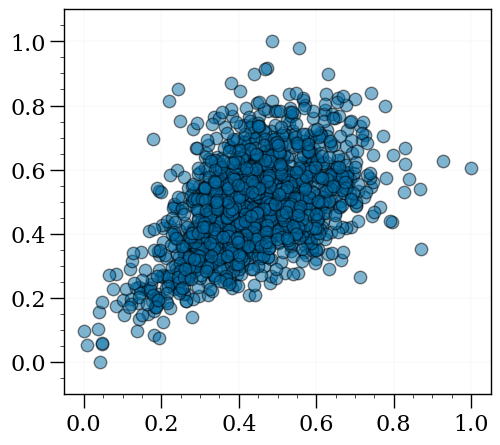

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'clayton_1')

  0%|          | 1/10000 [00:59<164:29:54, 59.23s/it]

Iter 0. Loss [[0.4135515  0.23502201 8.729631  ]]


  0%|          | 11/10000 [01:57<4:02:18,  1.46s/it]

Iter 10. Loss [[0.34169248 0.1188795  3.1233404 ]]


  0%|          | 21/10000 [02:00<1:04:59,  2.56it/s]

Iter 20. Loss [[0.3844057  0.12071422 2.4086869 ]]


  0%|          | 31/10000 [02:04<1:07:57,  2.45it/s]

Iter 30. Loss [[0.37723938 0.10984766 2.3086848 ]]


  0%|          | 41/10000 [02:07<53:12,  3.12it/s]

Iter 40. Loss [[0.36283284 0.09866372 2.2760508 ]]


  1%|          | 51/10000 [02:10<43:44,  3.79it/s]

Iter 50. Loss [[0.36899966 0.10308315 2.2678757 ]]


  1%|          | 61/10000 [02:13<47:16,  3.50it/s]

Iter 60. Loss [[0.3714209 0.1034006 2.2098744]]


  1%|          | 71/10000 [02:16<1:03:12,  2.62it/s]

Iter 70. Loss [[0.3683634  0.10370252 2.2477477 ]]


  1%|          | 81/10000 [02:19<46:53,  3.52it/s]

Iter 80. Loss [[0.3572873  0.09203509 2.2194176 ]]


  1%|          | 91/10000 [02:22<58:20,  2.83it/s]  

Iter 90. Loss [[0.3305417  0.07691738 2.2048633 ]]


  1%|          | 101/10000 [02:25<41:41,  3.96it/s]

Iter 100. Loss [[0.29881382 0.06681967 2.1483705 ]]


  1%|          | 111/10000 [02:28<59:38,  2.76it/s]

Iter 110. Loss [[0.2301386  0.06301446 1.9568571 ]]


  1%|          | 121/10000 [02:32<51:33,  3.19it/s]

Iter 120. Loss [[0.11077238 0.06904908 1.5878011 ]]


  1%|▏         | 131/10000 [02:35<44:33,  3.69it/s]

Iter 130. Loss [[0.05906966 0.19816561 2.882827  ]]


  1%|▏         | 141/10000 [02:37<42:27,  3.87it/s]

Iter 140. Loss [[0.25454423 0.05544944 2.1461117 ]]


  2%|▏         | 151/10000 [02:40<44:03,  3.73it/s]

Iter 150. Loss [[0.17262991 0.09082995 2.0716107 ]]


  2%|▏         | 161/10000 [02:45<1:23:23,  1.97it/s]

Iter 160. Loss [[0.23911701 0.05414828 1.8360324 ]]


  2%|▏         | 171/10000 [02:47<43:37,  3.76it/s]

Iter 170. Loss [[0.18353476 0.05923824 1.6415113 ]]


  2%|▏         | 181/10000 [02:50<50:51,  3.22it/s]

Iter 180. Loss [[0.12802519 0.06141473 1.4190352 ]]


  2%|▏         | 191/10000 [02:53<42:19,  3.86it/s]

Iter 190. Loss [[0.11102423 0.05467814 1.3230311 ]]


  2%|▏         | 201/10000 [02:57<1:04:56,  2.51it/s]

Iter 200. Loss [[0.11104922 0.05165907 1.3419629 ]]


  2%|▏         | 211/10000 [03:00<43:34,  3.74it/s]

Iter 210. Loss [[0.11772196 0.04986502 1.245693  ]]


  2%|▏         | 221/10000 [03:03<44:00,  3.70it/s]

Iter 220. Loss [[0.16503344 0.04406564 1.2536625 ]]


  2%|▏         | 231/10000 [03:06<57:46,  2.82it/s]  

Iter 230. Loss [[0.10131285 0.06069407 1.1681925 ]]


  2%|▏         | 241/10000 [03:08<51:39,  3.15it/s]

Iter 240. Loss [[0.11750686 0.04536466 1.0602583 ]]


  3%|▎         | 251/10000 [03:13<59:32,  2.73it/s]  

Iter 250. Loss [[0.12141787 0.04204407 1.0202883 ]]


  3%|▎         | 261/10000 [03:15<42:16,  3.84it/s]

Iter 260. Loss [[0.126233   0.03956475 0.9810996 ]]


  3%|▎         | 271/10000 [03:18<44:25,  3.65it/s]

Iter 270. Loss [[0.11853155 0.03816094 0.9157446 ]]


  3%|▎         | 281/10000 [03:21<42:16,  3.83it/s]

Iter 280. Loss [[0.11434835 0.03683591 0.84641504]]


  3%|▎         | 291/10000 [03:25<1:00:34,  2.67it/s]

Iter 290. Loss [[0.09436277 0.04112566 0.84593594]]


  3%|▎         | 301/10000 [03:28<57:57,  2.79it/s]  

Iter 300. Loss [[0.1327284  0.03184013 0.86311626]]


  3%|▎         | 311/10000 [03:31<42:27,  3.80it/s]

Iter 310. Loss [[0.07345013 0.10747021 2.2690313 ]]


  3%|▎         | 321/10000 [03:34<48:22,  3.34it/s]

Iter 320. Loss [[0.12117551 0.06024024 2.5118754 ]]


  3%|▎         | 331/10000 [03:37<1:04:06,  2.51it/s]

Iter 330. Loss [[0.09827327 0.0725392  1.2938373 ]]


  3%|▎         | 341/10000 [03:42<57:48,  2.79it/s]  

Iter 340. Loss [[0.10592441 0.0671367  1.2934679 ]]


  4%|▎         | 351/10000 [03:44<40:51,  3.94it/s]

Iter 350. Loss [[0.14584498 0.05294086 1.3214566 ]]


  4%|▎         | 361/10000 [03:47<42:00,  3.82it/s]

Iter 360. Loss [[0.12773642 0.05966184 1.2423612 ]]


  4%|▎         | 371/10000 [03:51<1:13:06,  2.20it/s]

Iter 370. Loss [[0.1276733  0.05962571 1.1972817 ]]


  4%|▍         | 381/10000 [03:54<45:49,  3.50it/s]

Iter 380. Loss [[0.12968664 0.05823248 1.1778797 ]]


  4%|▍         | 391/10000 [03:57<49:13,  3.25it/s]

Iter 390. Loss [[0.12771487 0.05608269 1.1429507 ]]


  4%|▍         | 401/10000 [03:59<40:52,  3.91it/s]

Iter 400. Loss [[0.1298752  0.05073215 1.0926235 ]]


  4%|▍         | 411/10000 [04:02<42:33,  3.76it/s]

Iter 410. Loss [[0.08950998 0.05579255 1.1145461 ]]


  4%|▍         | 421/10000 [04:06<58:11,  2.74it/s]  

Iter 420. Loss [[0.10035034 0.05059808 1.0864811 ]]


  4%|▍         | 431/10000 [04:09<41:38,  3.83it/s]

Iter 430. Loss [[0.13166864 0.04271713 1.0395745 ]]


  4%|▍         | 441/10000 [04:12<56:08,  2.84it/s]  

Iter 440. Loss [[0.11504511 0.04848707 0.99137384]]


  5%|▍         | 451/10000 [04:15<39:57,  3.98it/s]

Iter 450. Loss [[0.12352966 0.0418418  1.0114542 ]]


  5%|▍         | 461/10000 [04:18<1:09:28,  2.29it/s]

Iter 460. Loss [[0.13955334 0.0349004  1.0653856 ]]


  5%|▍         | 471/10000 [04:21<41:36,  3.82it/s]

Iter 470. Loss [[0.11154974 0.04243414 0.9230244 ]]


  5%|▍         | 481/10000 [04:24<42:34,  3.73it/s]

Iter 480. Loss [[0.09930997 0.04713391 0.9416079 ]]


  5%|▍         | 491/10000 [04:27<40:24,  3.92it/s]

Iter 490. Loss [[0.11947609 0.03553549 0.90608233]]


  5%|▌         | 501/10000 [04:30<54:05,  2.93it/s]

Iter 500. Loss [[0.10450087 0.03932732 0.85142773]]


  5%|▌         | 511/10000 [04:34<1:02:53,  2.51it/s]

Iter 510. Loss [[0.13191202 0.03055244 0.90424997]]


  5%|▌         | 521/10000 [04:37<40:54,  3.86it/s]

Iter 520. Loss [[0.10318919 0.04034055 0.91450936]]


  5%|▌         | 531/10000 [04:40<47:31,  3.32it/s]

Iter 530. Loss [[0.12197774 0.03138614 0.83745843]]


  5%|▌         | 541/10000 [04:42<40:22,  3.90it/s]

Iter 540. Loss [[0.11217893 0.03343176 0.77785414]]


  6%|▌         | 551/10000 [04:46<1:01:29,  2.56it/s]

Iter 550. Loss [[0.11962425 0.0311302  0.8291025 ]]


  6%|▌         | 561/10000 [04:49<39:48,  3.95it/s]

Iter 560. Loss [[0.11525775 0.03223919 0.8246945 ]]


  6%|▌         | 571/10000 [04:52<41:02,  3.83it/s]

Iter 570. Loss [[0.10466737 0.03560748 0.85184795]]


  6%|▌         | 581/10000 [04:55<55:27,  2.83it/s]  

Iter 580. Loss [[0.0894133 0.2986633 7.4357123]]


  6%|▌         | 591/10000 [04:58<1:00:24,  2.60it/s]

Iter 590. Loss [[0.08481761 0.2903508  6.14515   ]]


  6%|▌         | 601/10000 [05:02<49:02,  3.19it/s]

Iter 600. Loss [[0.27023917 0.03752823 1.5311913 ]]


  6%|▌         | 611/10000 [05:04<40:00,  3.91it/s]

Iter 610. Loss [[0.22158208 0.05747257 1.8219272 ]]


  6%|▌         | 621/10000 [05:07<42:39,  3.66it/s]

Iter 620. Loss [[0.20948333 0.06023683 1.8045491 ]]


  6%|▋         | 631/10000 [05:10<40:43,  3.83it/s]

Iter 630. Loss [[0.24003933 0.04560545 1.694792  ]]


  6%|▋         | 641/10000 [05:14<47:33,  3.28it/s]

Iter 640. Loss [[0.19676916 0.05329821 1.4718834 ]]


  7%|▋         | 651/10000 [05:17<54:29,  2.86it/s]  

Iter 650. Loss [[0.18929426 0.04917068 1.2372632 ]]


  7%|▋         | 661/10000 [05:19<40:20,  3.86it/s]

Iter 660. Loss [[0.1698767  0.05474635 1.1737505 ]]


  7%|▋         | 671/10000 [05:22<47:32,  3.27it/s]

Iter 670. Loss [[0.13913591 0.06672303 1.5689403 ]]


  7%|▋         | 681/10000 [05:26<1:03:15,  2.46it/s]

Iter 680. Loss [[0.11517496 0.05945046 1.1625184 ]]


  7%|▋         | 691/10000 [05:29<43:26,  3.57it/s]

Iter 690. Loss [[0.11658476 0.04868634 1.0680746 ]]


  7%|▋         | 701/10000 [05:32<39:12,  3.95it/s]

Iter 700. Loss [[0.14664227 0.03909389 1.0520803 ]]


  7%|▋         | 711/10000 [05:35<40:24,  3.83it/s]

Iter 710. Loss [[0.17864744 0.03141548 1.3685606 ]]


  7%|▋         | 721/10000 [05:38<1:15:47,  2.04it/s]

Iter 720. Loss [[0.14504132 0.03604939 1.0786175 ]]


  7%|▋         | 731/10000 [05:41<42:00,  3.68it/s]

Iter 730. Loss [[0.07986207 0.08058495 1.2260947 ]]


  7%|▋         | 741/10000 [05:44<47:17,  3.26it/s]

Iter 740. Loss [[0.073715   0.11401334 1.6312387 ]]


  8%|▊         | 751/10000 [05:47<39:49,  3.87it/s]

Iter 750. Loss [[0.19559008 0.02786948 1.2106189 ]]


  8%|▊         | 761/10000 [05:50<49:31,  3.11it/s]

Iter 760. Loss [[0.1286343  0.04034791 0.9311621 ]]


  8%|▊         | 771/10000 [05:54<50:00,  3.08it/s]

Iter 770. Loss [[0.11930019 0.0397527  0.8570298 ]]


  8%|▊         | 781/10000 [05:57<40:52,  3.76it/s]

Iter 780. Loss [[0.14513198 0.0309125  0.89036   ]]


  8%|▊         | 791/10000 [06:00<54:38,  2.81it/s]  

Iter 790. Loss [[0.12222446 0.03806885 0.870406  ]]


  8%|▊         | 801/10000 [06:02<39:33,  3.88it/s]

Iter 800. Loss [[0.08962809 0.06770404 1.0987477 ]]


  8%|▊         | 811/10000 [06:06<1:11:30,  2.14it/s]

Iter 810. Loss [[0.12351589 0.04049702 1.2452446 ]]


  8%|▊         | 821/10000 [06:09<40:31,  3.77it/s]

Iter 820. Loss [[0.09573745 0.04929633 1.2401893 ]]


  8%|▊         | 831/10000 [06:12<41:34,  3.67it/s]

Iter 830. Loss [[0.08669981 0.07034378 1.0597306 ]]


  8%|▊         | 841/10000 [06:14<38:08,  4.00it/s]

Iter 840. Loss [[0.10677322 0.05962207 1.1057378 ]]


  9%|▊         | 851/10000 [06:18<59:36,  2.56it/s]

Iter 850. Loss [[0.14748973 0.03722968 0.9007093 ]]


  9%|▊         | 861/10000 [06:22<57:08,  2.67it/s]  

Iter 860. Loss [[0.14241368 0.040116   1.0200503 ]]


  9%|▊         | 871/10000 [06:24<39:26,  3.86it/s]

Iter 870. Loss [[0.12614156 0.03725766 0.84922606]]


  9%|▉         | 881/10000 [06:27<46:32,  3.27it/s]

Iter 880. Loss [[0.1028441 0.0681335 1.0783358]]


  9%|▉         | 891/10000 [06:30<39:44,  3.82it/s]

Iter 890. Loss [[0.10816428 0.05874981 1.0866896 ]]


  9%|▉         | 901/10000 [06:34<48:38,  3.12it/s]

Iter 900. Loss [[0.1369069  0.03578361 1.1802957 ]]


  9%|▉         | 911/10000 [06:37<38:41,  3.91it/s]

Iter 910. Loss [[0.15134248 0.02734362 1.060837  ]]


  9%|▉         | 921/10000 [06:40<38:45,  3.90it/s]

Iter 920. Loss [[0.16236742 0.02622653 1.0322864 ]]


  9%|▉         | 931/10000 [06:43<53:47,  2.81it/s]

Iter 930. Loss [[0.13616043 0.03567723 0.96705335]]


  9%|▉         | 941/10000 [06:46<1:01:40,  2.45it/s]

Iter 940. Loss [[0.11366042 0.04268026 0.86310905]]


 10%|▉         | 951/10000 [06:49<46:15,  3.26it/s]

Iter 950. Loss [[0.11255865 0.04255297 0.81012547]]


 10%|▉         | 961/10000 [06:52<39:39,  3.80it/s]

Iter 960. Loss [[0.11852167 0.03909179 0.8353089 ]]


 10%|▉         | 971/10000 [06:55<41:14,  3.65it/s]

Iter 970. Loss [[0.11900514 0.04242646 0.7883898 ]]


 10%|▉         | 981/10000 [06:58<53:19,  2.82it/s]

Iter 980. Loss [[0.17297064 0.02678757 1.0791123 ]]


 10%|▉         | 991/10000 [07:02<42:07,  3.56it/s]

Iter 990. Loss [[0.16220024 0.02881736 0.8505555 ]]


 10%|█         | 1001/10000 [07:05<53:39,  2.80it/s]

Iter 1000. Loss [[0.08434892 0.15157542 2.195033  ]]


 10%|█         | 1011/10000 [07:07<39:13,  3.82it/s]

Iter 1010. Loss [[0.21168219 0.02871266 1.4244215 ]]


 10%|█         | 1021/10000 [07:10<49:23,  3.03it/s]

Iter 1020. Loss [[0.16156133 0.04014494 0.95384705]]


 10%|█         | 1031/10000 [07:15<1:05:32,  2.28it/s]

Iter 1030. Loss [[0.1479185  0.04390832 0.92435074]]


 10%|█         | 1041/10000 [07:19<44:08,  3.38it/s]

Iter 1040. Loss [[0.21122494 0.02358487 0.8227015 ]]


 11%|█         | 1051/10000 [07:21<37:39,  3.96it/s]

Iter 1050. Loss [[0.20382388 0.03117742 0.6805728 ]]


 11%|█         | 1061/10000 [07:24<38:44,  3.84it/s]

Iter 1060. Loss [[0.2065252  0.03950569 0.71578366]]


 11%|█         | 1071/10000 [07:28<1:16:45,  1.94it/s]

Iter 1070. Loss [[0.23689617 0.03433183 0.580239  ]]


 11%|█         | 1081/10000 [07:31<40:34,  3.66it/s]

Iter 1080. Loss [[0.23919131 0.03215223 0.56453586]]


 11%|█         | 1091/10000 [07:34<45:55,  3.23it/s]

Iter 1090. Loss [[0.24382384 0.02886163 0.5446628 ]]


 11%|█         | 1101/10000 [07:37<38:09,  3.89it/s]

Iter 1100. Loss [[0.24507073 0.0265658  0.5198626 ]]


 11%|█         | 1111/10000 [07:40<55:29,  2.67it/s]

Iter 1110. Loss [[0.25032097 0.02626966 0.4871011 ]]


 11%|█         | 1121/10000 [07:43<43:07,  3.43it/s]

Iter 1120. Loss [[0.26357755 0.02715992 0.45338428]]


 11%|█▏        | 1131/10000 [07:46<39:14,  3.77it/s]

Iter 1130. Loss [[0.26572078 0.02730916 0.4420897 ]]


 11%|█▏        | 1141/10000 [07:49<52:35,  2.81it/s]

Iter 1140. Loss [[0.26115376 0.02538049 0.43528116]]


 12%|█▏        | 1151/10000 [07:52<37:38,  3.92it/s]

Iter 1150. Loss [[0.25915015 0.02393811 0.4304629 ]]


 12%|█▏        | 1161/10000 [07:56<57:22,  2.57it/s]  

Iter 1160. Loss [[0.25964507 0.02343623 0.42364484]]


 12%|█▏        | 1171/10000 [07:59<38:38,  3.81it/s]

Iter 1170. Loss [[0.26047522 0.02280189 0.41987246]]


 12%|█▏        | 1181/10000 [08:02<40:46,  3.60it/s]

Iter 1180. Loss [[0.26201504 0.02241161 0.4113862 ]]


 12%|█▏        | 1191/10000 [08:04<37:37,  3.90it/s]

Iter 1190. Loss [[0.26406568 0.02193209 0.42722383]]


 12%|█▏        | 1201/10000 [08:09<1:01:28,  2.39it/s]

Iter 1200. Loss [[0.2675072  0.02221895 0.42004696]]


 12%|█▏        | 1211/10000 [08:12<54:24,  2.69it/s]  

Iter 1210. Loss [[0.28279656 0.02422738 0.43879756]]


 12%|█▏        | 1221/10000 [08:14<38:16,  3.82it/s]

Iter 1220. Loss [[0.08069278 0.250008   9.221056  ]]


 12%|█▏        | 1231/10000 [08:17<44:36,  3.28it/s]

Iter 1230. Loss [[0.30536544 0.05529379 0.6611948 ]]


 12%|█▏        | 1241/10000 [08:21<54:21,  2.69it/s]

Iter 1240. Loss [[0.288961   0.02957689 0.48427945]]


 13%|█▎        | 1251/10000 [08:24<43:22,  3.36it/s]

Iter 1250. Loss [[0.3034636  0.03228151 0.54465955]]


 13%|█▎        | 1261/10000 [08:27<37:44,  3.86it/s]

Iter 1260. Loss [[0.28603795 0.02602245 0.47295442]]


 13%|█▎        | 1271/10000 [08:30<38:36,  3.77it/s]

Iter 1270. Loss [[0.2630536  0.02706361 0.47458366]]


 13%|█▎        | 1281/10000 [08:33<59:11,  2.46it/s]

Iter 1280. Loss [[0.26891562 0.02422585 0.4806816 ]]


 13%|█▎        | 1291/10000 [08:37<45:41,  3.18it/s]

Iter 1290. Loss [[0.29455388 0.02746571 0.45043465]]


 13%|█▎        | 1301/10000 [08:40<44:48,  3.24it/s]

Iter 1300. Loss [[0.290503   0.03081222 0.39640442]]


 13%|█▎        | 1311/10000 [08:42<36:44,  3.94it/s]

Iter 1310. Loss [[0.2863051  0.02407953 0.4497067 ]]


 13%|█▎        | 1321/10000 [08:45<39:59,  3.62it/s]

Iter 1320. Loss [[0.28904796 0.02336989 0.47501165]]


 13%|█▎        | 1331/10000 [08:49<58:28,  2.47it/s]

Iter 1330. Loss [[0.2865111  0.0261182  0.40598574]]


 13%|█▎        | 1341/10000 [08:52<38:50,  3.71it/s]

Iter 1340. Loss [[0.27562383 0.02740018 0.4352805 ]]


 14%|█▎        | 1351/10000 [08:55<51:13,  2.81it/s]

Iter 1350. Loss [[0.21872765 0.0703136  1.0404072 ]]


 14%|█▎        | 1361/10000 [08:58<37:01,  3.89it/s]

Iter 1360. Loss [[0.28964493 0.02265989 0.4806854 ]]


 14%|█▎        | 1371/10000 [09:01<1:00:32,  2.38it/s]

Iter 1370. Loss [[0.30341497 0.03560663 0.45461383]]


 14%|█▍        | 1381/10000 [09:04<38:31,  3.73it/s]

Iter 1380. Loss [[0.2934776  0.03338489 0.41156378]]


 14%|█▍        | 1391/10000 [09:08<41:02,  3.50it/s]

Iter 1390. Loss [[0.2849731  0.02782597 0.4127133 ]]


 14%|█▍        | 1401/10000 [09:10<36:26,  3.93it/s]

Iter 1400. Loss [[0.2834744  0.02724558 0.40375438]]


 14%|█▍        | 1411/10000 [09:13<42:32,  3.37it/s]

Iter 1410. Loss [[0.2834221  0.02688204 0.39518586]]


 14%|█▍        | 1421/10000 [09:17<59:53,  2.39it/s]  

Iter 1420. Loss [[0.2821374  0.02544479 0.3950804 ]]


 14%|█▍        | 1431/10000 [09:20<37:06,  3.85it/s]

Iter 1430. Loss [[0.28331447 0.02546678 0.3899342 ]]


 14%|█▍        | 1441/10000 [09:23<43:20,  3.29it/s]

Iter 1440. Loss [[0.28266686 0.02520617 0.3866427 ]]


 15%|█▍        | 1451/10000 [09:25<35:58,  3.96it/s]

Iter 1450. Loss [[0.2801646  0.0247855  0.38902584]]


 15%|█▍        | 1461/10000 [09:29<58:33,  2.43it/s]

Iter 1460. Loss [[0.27978933 0.02414151 0.39100733]]


 15%|█▍        | 1471/10000 [09:32<36:23,  3.91it/s]

Iter 1470. Loss [[0.2975351  0.02931197 0.55251044]]


 15%|█▍        | 1481/10000 [09:35<36:41,  3.87it/s]

Iter 1480. Loss [[0.29882535 0.02689627 0.44196504]]


 15%|█▍        | 1491/10000 [09:38<49:23,  2.87it/s]

Iter 1490. Loss [[0.29301053 0.03144933 0.38949478]]


 15%|█▌        | 1501/10000 [09:41<51:11,  2.77it/s]

Iter 1500. Loss [[0.2879374  0.027677   0.37742394]]


 15%|█▌        | 1511/10000 [09:45<46:54,  3.02it/s]

Iter 1510. Loss [[0.28398085 0.02584933 0.3797082 ]]


 15%|█▌        | 1521/10000 [09:47<36:13,  3.90it/s]

Iter 1520. Loss [[0.27955073 0.02508817 0.38768163]]


 15%|█▌        | 1531/10000 [09:50<38:34,  3.66it/s]

Iter 1530. Loss [[0.28172868 0.02322615 0.40224242]]


 15%|█▌        | 1541/10000 [09:53<36:39,  3.85it/s]

Iter 1540. Loss [[0.2858304  0.02730104 0.3875065 ]]


 16%|█▌        | 1551/10000 [09:57<48:00,  2.93it/s]

Iter 1550. Loss [[0.27471104 0.02270724 0.47261825]]


 16%|█▌        | 1561/10000 [10:00<50:33,  2.78it/s]

Iter 1560. Loss [[0.2825101  0.02529692 0.4070484 ]]


 16%|█▌        | 1571/10000 [10:03<36:47,  3.82it/s]

Iter 1570. Loss [[0.29057366 0.02813429 0.3695651 ]]


 16%|█▌        | 1581/10000 [10:06<42:27,  3.31it/s]

Iter 1580. Loss [[0.2838141  0.02406154 0.3898019 ]]


 16%|█▌        | 1591/10000 [10:09<56:33,  2.48it/s]

Iter 1590. Loss [[0.28776133 0.02574712 0.3745865 ]]


 16%|█▌        | 1601/10000 [10:12<39:16,  3.56it/s]

Iter 1600. Loss [[0.28861496 0.0253285  0.37173876]]


 16%|█▌        | 1611/10000 [10:15<34:39,  4.03it/s]

Iter 1610. Loss [[0.29010922 0.02542542 0.36730465]]


 16%|█▌        | 1621/10000 [10:18<36:15,  3.85it/s]

Iter 1620. Loss [[0.2906074  0.02541066 0.36621293]]


 16%|█▋        | 1631/10000 [10:21<1:01:10,  2.28it/s]

Iter 1630. Loss [[0.2903994  0.02520955 0.36398453]]


 16%|█▋        | 1641/10000 [10:25<42:34,  3.27it/s]

Iter 1640. Loss [[0.2903663  0.02513961 0.36067113]]


 17%|█▋        | 1651/10000 [10:29<48:53,  2.85it/s]

Iter 1650. Loss [[0.29064983 0.02513733 0.35739672]]


 17%|█▋        | 1661/10000 [10:31<35:40,  3.90it/s]

Iter 1660. Loss [[0.29124352 0.02522703 0.35322875]]


 17%|█▋        | 1671/10000 [10:35<51:20,  2.70it/s]

Iter 1670. Loss [[0.2920449  0.02539589 0.3497596 ]]


 17%|█▋        | 1681/10000 [10:38<38:58,  3.56it/s]

Iter 1680. Loss [[0.292862   0.02555029 0.3458544 ]]


 17%|█▋        | 1691/10000 [10:41<36:19,  3.81it/s]

Iter 1690. Loss [[0.29366302 0.0256897  0.3393824 ]]


 17%|█▋        | 1701/10000 [10:44<49:24,  2.80it/s]

Iter 1700. Loss [[0.29449946 0.02581215 0.33442292]]


 17%|█▋        | 1711/10000 [10:46<35:38,  3.88it/s]

Iter 1710. Loss [[0.2954773  0.02592735 0.33172372]]


 17%|█▋        | 1721/10000 [10:51<52:48,  2.61it/s]  

Iter 1720. Loss [[0.29652512 0.02603402 0.3318482 ]]


 17%|█▋        | 1731/10000 [10:53<35:07,  3.92it/s]

Iter 1730. Loss [[0.29780433 0.02607858 0.32701787]]


 17%|█▋        | 1741/10000 [10:56<36:38,  3.76it/s]

Iter 1740. Loss [[0.29937923 0.02619056 0.3229291 ]]


 18%|█▊        | 1751/10000 [10:59<35:15,  3.90it/s]

Iter 1750. Loss [[0.3008673  0.02614895 0.31616792]]


 18%|█▊        | 1761/10000 [11:02<53:45,  2.55it/s]

Iter 1760. Loss [[0.30229545 0.02598679 0.3080639 ]]


 18%|█▊        | 1771/10000 [11:06<48:51,  2.81it/s]

Iter 1770. Loss [[0.30402595 0.02588267 0.29570925]]


 18%|█▊        | 1781/10000 [11:08<35:09,  3.90it/s]

Iter 1780. Loss [[0.30570954 0.02556662 0.29705566]]


 18%|█▊        | 1791/10000 [11:11<41:04,  3.33it/s]

Iter 1790. Loss [[0.30885184 0.02552463 0.30396923]]


 18%|█▊        | 1801/10000 [11:14<37:05,  3.68it/s]

Iter 1800. Loss [[0.31693178 0.02710127 0.33391246]]


 18%|█▊        | 1811/10000 [11:18<42:55,  3.18it/s]

Iter 1810. Loss [[0.13792716 0.38713127 7.098054  ]]


 18%|█▊        | 1821/10000 [11:20<34:46,  3.92it/s]

Iter 1820. Loss [[0.15147805 0.36753744 6.7519994 ]]


 18%|█▊        | 1831/10000 [11:23<35:58,  3.78it/s]

Iter 1830. Loss [[0.14774798 0.09181248 3.5679226 ]]


 18%|█▊        | 1841/10000 [11:26<47:21,  2.87it/s]

Iter 1840. Loss [[0.09893609 0.12390789 1.9297009 ]]


 19%|█▊        | 1851/10000 [11:30<55:13,  2.46it/s]

Iter 1850. Loss [[0.109125   0.10499592 1.672181  ]]


 19%|█▊        | 1861/10000 [11:33<42:06,  3.22it/s]

Iter 1860. Loss [[0.1251816  0.08469318 1.4158605 ]]


 19%|█▊        | 1871/10000 [11:36<34:30,  3.93it/s]

Iter 1870. Loss [[0.1286557  0.07019547 1.1499497 ]]


 19%|█▉        | 1881/10000 [11:39<36:44,  3.68it/s]

Iter 1880. Loss [[0.21688014 0.02870624 1.211477  ]]


 19%|█▉        | 1891/10000 [11:42<49:01,  2.76it/s]

Iter 1890. Loss [[0.19680107 0.03507503 0.98844254]]


 19%|█▉        | 1901/10000 [11:45<38:03,  3.55it/s]

Iter 1900. Loss [[0.12725508 0.06172876 1.025955  ]]


 19%|█▉        | 1911/10000 [11:48<47:49,  2.82it/s]

Iter 1910. Loss [[0.1730992  0.03395346 1.1198913 ]]


 19%|█▉        | 1921/10000 [11:51<35:05,  3.84it/s]

Iter 1920. Loss [[0.17615348 0.03500763 1.1300765 ]]


 19%|█▉        | 1931/10000 [11:54<47:11,  2.85it/s]

Iter 1930. Loss [[ 0.14100778  0.30312625 14.289555  ]]


 19%|█▉        | 1941/10000 [11:58<43:28,  3.09it/s]

Iter 1940. Loss [[ 0.13983665  0.30260444 10.264363  ]]


 20%|█▉        | 1951/10000 [12:01<37:39,  3.56it/s]

Iter 1950. Loss [[0.13426077 0.29121485 6.071392  ]]


 20%|█▉        | 1961/10000 [12:03<33:33,  3.99it/s]

Iter 1960. Loss [[0.10494394 0.21131885 2.9461374 ]]


 20%|█▉        | 1971/10000 [12:06<35:02,  3.82it/s]

Iter 1970. Loss [[0.09611583 0.10194042 1.5109261 ]]


 20%|█▉        | 1981/10000 [12:11<1:10:11,  1.90it/s]

Iter 1980. Loss [[0.19515292 0.03685321 0.9649605 ]]


 20%|█▉        | 1991/10000 [12:13<36:43,  3.64it/s]

Iter 1990. Loss [[0.14460295 0.05578496 1.3086674 ]]


 20%|██        | 2001/10000 [12:16<41:16,  3.23it/s]

Iter 2000. Loss [[0.14068663 0.04401952 1.1567695 ]]


 20%|██        | 2011/10000 [12:19<34:50,  3.82it/s]

Iter 2010. Loss [[0.12562777 0.05257207 0.972096  ]]


 20%|██        | 2021/10000 [12:23<53:15,  2.50it/s]

Iter 2020. Loss [[0.08882327 0.10846049 2.0788412 ]]


 20%|██        | 2031/10000 [12:26<35:44,  3.72it/s]

Iter 2030. Loss [[0.08550537 0.12350988 1.7173272 ]]


 20%|██        | 2041/10000 [12:29<35:05,  3.78it/s]

Iter 2040. Loss [[0.19245677 0.02905369 1.7471861 ]]


 21%|██        | 2051/10000 [12:32<46:47,  2.83it/s]

Iter 2050. Loss [[0.10062405 0.07306203 1.0964597 ]]


 21%|██        | 2061/10000 [12:34<33:28,  3.95it/s]

Iter 2060. Loss [[0.15414745 0.03425055 0.97796726]]


 21%|██        | 2071/10000 [12:38<49:11,  2.69it/s]

Iter 2070. Loss [[0.14510335 0.03991297 0.9408361 ]]


 21%|██        | 2081/10000 [12:41<33:05,  3.99it/s]

Iter 2080. Loss [[0.14279316 0.04399958 0.8118462 ]]


 21%|██        | 2091/10000 [12:44<34:57,  3.77it/s]

Iter 2090. Loss [[0.10889544 0.24891484 4.039985  ]]


 21%|██        | 2101/10000 [12:46<33:23,  3.94it/s]

Iter 2100. Loss [[0.16573471 0.06445061 1.3165832 ]]


 21%|██        | 2111/10000 [12:50<53:52,  2.44it/s]

Iter 2110. Loss [[0.19140714 0.04685916 1.1732254 ]]


 21%|██        | 2121/10000 [12:54<47:18,  2.78it/s]

Iter 2120. Loss [[0.14785455 0.0347681  1.1750332 ]]


 21%|██▏       | 2131/10000 [12:56<32:45,  4.00it/s]

Iter 2130. Loss [[0.17041917 0.02885462 0.73348683]]


 21%|██▏       | 2141/10000 [12:59<39:09,  3.35it/s]

Iter 2140. Loss [[0.17654851 0.02563916 0.8776457 ]]


 22%|██▏       | 2151/10000 [13:02<42:14,  3.10it/s]

Iter 2150. Loss [[0.14113651 0.03647458 0.8146098 ]]


 22%|██▏       | 2161/10000 [13:06<37:25,  3.49it/s]

Iter 2160. Loss [[0.15122294 0.03626464 0.7342998 ]]


 22%|██▏       | 2171/10000 [13:08<33:03,  3.95it/s]

Iter 2170. Loss [[0.17123435 0.03171143 0.685431  ]]


 22%|██▏       | 2181/10000 [13:11<33:16,  3.92it/s]

Iter 2180. Loss [[0.168589   0.04019807 0.6928497 ]]


 22%|██▏       | 2191/10000 [13:14<45:57,  2.83it/s]

Iter 2190. Loss [[0.12926449 0.28862873 6.14026   ]]


 22%|██▏       | 2201/10000 [13:18<51:32,  2.52it/s]

Iter 2200. Loss [[0.11254453 0.2527195  4.0544395 ]]


 22%|██▏       | 2211/10000 [13:21<39:45,  3.27it/s]

Iter 2210. Loss [[0.13501272 0.085614   1.6836267 ]]


 22%|██▏       | 2221/10000 [13:23<33:10,  3.91it/s]

Iter 2220. Loss [[0.21956542 0.05055368 1.9653556 ]]


 22%|██▏       | 2231/10000 [13:26<34:45,  3.73it/s]

Iter 2230. Loss [[0.19411168 0.05035903 1.3783368 ]]


 22%|██▏       | 2241/10000 [13:29<48:32,  2.66it/s]

Iter 2240. Loss [[0.1671196  0.04984761 1.2088922 ]]


 23%|██▎       | 2251/10000 [13:33<35:50,  3.60it/s]

Iter 2250. Loss [[0.17739734 0.03728321 1.1244802 ]]


 23%|██▎       | 2261/10000 [13:36<45:05,  2.86it/s]

Iter 2260. Loss [[0.14617696 0.04141799 0.9093437 ]]


 23%|██▎       | 2271/10000 [13:40<49:12,  2.62it/s]

Iter 2270. Loss [[0.1424374  0.03987902 0.8100176 ]]


 23%|██▎       | 2281/10000 [13:44<57:06,  2.25it/s]

Iter 2280. Loss [[0.14043602 0.04114479 0.7450053 ]]


 23%|██▎       | 2291/10000 [13:46<33:45,  3.81it/s]

Iter 2290. Loss [[0.15171944 0.03846492 0.8903286 ]]


 23%|██▎       | 2301/10000 [13:49<34:15,  3.74it/s]

Iter 2300. Loss [[0.13550524 0.04742371 0.78691095]]


 23%|██▎       | 2311/10000 [13:52<32:46,  3.91it/s]

Iter 2310. Loss [[0.14919992 0.03970506 0.7482013 ]]


 23%|██▎       | 2321/10000 [13:55<43:47,  2.92it/s]

Iter 2320. Loss [[0.15588012 0.03743336 0.7498675 ]]


 23%|██▎       | 2331/10000 [13:59<50:39,  2.52it/s]

Iter 2330. Loss [[0.15614095 0.03761332 0.7288112 ]]


 23%|██▎       | 2341/10000 [14:02<32:22,  3.94it/s]

Iter 2340. Loss [[0.15331967 0.03821931 0.7335511 ]]


 24%|██▎       | 2351/10000 [14:04<37:39,  3.39it/s]

Iter 2350. Loss [[0.1562105  0.03726952 0.7273702 ]]


 24%|██▎       | 2361/10000 [14:07<32:03,  3.97it/s]

Iter 2360. Loss [[0.15724452 0.03658393 0.71298605]]


 24%|██▎       | 2371/10000 [14:11<50:15,  2.53it/s]

Iter 2370. Loss [[0.15915264 0.03652858 0.7307888 ]]


 24%|██▍       | 2381/10000 [14:14<31:18,  4.05it/s]

Iter 2380. Loss [[0.15998717 0.0362071  0.7327498 ]]


 24%|██▍       | 2391/10000 [14:16<32:23,  3.92it/s]

Iter 2390. Loss [[0.16144547 0.03586028 0.72798216]]


 24%|██▍       | 2401/10000 [14:19<43:37,  2.90it/s]

Iter 2400. Loss [[0.16310671 0.03542513 0.71261066]]


 24%|██▍       | 2411/10000 [14:22<47:02,  2.69it/s]

Iter 2410. Loss [[0.16459535 0.03490093 0.70808023]]


 24%|██▍       | 2421/10000 [14:26<40:22,  3.13it/s]

Iter 2420. Loss [[0.16588393 0.03472629 0.7116131 ]]


 24%|██▍       | 2431/10000 [14:29<31:38,  3.99it/s]

Iter 2430. Loss [[0.15300716 0.04124991 0.7495835 ]]


 24%|██▍       | 2441/10000 [14:31<32:40,  3.86it/s]

Iter 2440. Loss [[0.16256255 0.03641066 0.7262765 ]]


 25%|██▍       | 2451/10000 [14:34<31:24,  4.01it/s]

Iter 2450. Loss [[0.16868772 0.0340196  0.7175825 ]]


 25%|██▍       | 2461/10000 [14:38<40:46,  3.08it/s]

Iter 2460. Loss [[0.14823845 0.04128652 0.7490892 ]]


 25%|██▍       | 2471/10000 [14:41<43:13,  2.90it/s]

Iter 2470. Loss [[0.17211941 0.02921383 0.76519686]]


 25%|██▍       | 2481/10000 [14:43<31:03,  4.04it/s]

Iter 2480. Loss [[0.17898116 0.02780907 0.7814747 ]]


 25%|██▍       | 2491/10000 [14:46<36:24,  3.44it/s]

Iter 2490. Loss [[0.1839901  0.02832187 0.7293196 ]]


 25%|██▌       | 2501/10000 [14:49<47:50,  2.61it/s]

Iter 2500. Loss [[0.1268105 0.2814412 5.313788 ]]


 25%|██▌       | 2511/10000 [14:53<34:25,  3.63it/s]

Iter 2510. Loss [[0.09550335 0.22361064 3.474023  ]]


 25%|██▌       | 2521/10000 [14:55<30:12,  4.13it/s]

Iter 2520. Loss [[0.15644728 0.1143688  2.339276  ]]


 25%|██▌       | 2531/10000 [14:58<31:17,  3.98it/s]

Iter 2530. Loss [[0.23983611 0.09883422 2.528036  ]]


 25%|██▌       | 2541/10000 [15:01<49:33,  2.51it/s]

Iter 2540. Loss [[0.19830996 0.09951359 1.9437118 ]]


 26%|██▌       | 2551/10000 [15:05<37:14,  3.33it/s]

Iter 2550. Loss [[0.15115936 0.06840471 1.3500655 ]]


 26%|██▌       | 2561/10000 [15:08<37:24,  3.31it/s]

Iter 2560. Loss [[0.18024974 0.03813407 1.0897992 ]]


 26%|██▌       | 2571/10000 [15:10<29:52,  4.14it/s]

Iter 2570. Loss [[0.14836176 0.04333044 0.8762329 ]]


 26%|██▌       | 2581/10000 [15:13<32:54,  3.76it/s]

Iter 2580. Loss [[0.11239982 0.23263729 5.441177  ]]


 26%|██▌       | 2591/10000 [15:16<47:12,  2.62it/s]

Iter 2590. Loss [[0.09084779 0.15458943 2.0803952 ]]


 26%|██▌       | 2601/10000 [15:20<32:29,  3.79it/s]

Iter 2600. Loss [[0.20321785 0.05932116 1.4829155 ]]


 26%|██▌       | 2611/10000 [15:23<42:35,  2.89it/s]

Iter 2610. Loss [[0.21401227 0.06320664 1.4220906 ]]


 26%|██▌       | 2621/10000 [15:25<30:33,  4.02it/s]

Iter 2620. Loss [[0.19353685 0.06142968 1.3523976 ]]


 26%|██▋       | 2631/10000 [15:28<47:07,  2.61it/s]

Iter 2630. Loss [[0.18241082 0.05435749 1.2369344 ]]


 26%|██▋       | 2641/10000 [15:32<35:40,  3.44it/s]

Iter 2640. Loss [[0.17477931 0.04692276 1.110868  ]]


 27%|██▋       | 2651/10000 [15:35<32:07,  3.81it/s]

Iter 2650. Loss [[0.16316645 0.04385507 1.062909  ]]


 27%|██▋       | 2661/10000 [15:37<30:39,  3.99it/s]

Iter 2660. Loss [[0.15117705 0.04355587 0.96418434]]


 27%|██▋       | 2671/10000 [15:40<30:55,  3.95it/s]

Iter 2670. Loss [[0.14523529 0.04280724 0.8935899 ]]


 27%|██▋       | 2681/10000 [15:44<1:00:06,  2.03it/s]

Iter 2680. Loss [[0.09666348 0.08390291 1.1846006 ]]


 27%|██▋       | 2691/10000 [15:47<31:11,  3.91it/s]

Iter 2690. Loss [[0.1267362  0.05394369 0.8890998 ]]


 27%|██▋       | 2701/10000 [15:50<36:00,  3.38it/s]

Iter 2700. Loss [[0.18633062 0.02867204 1.0342114 ]]


 27%|██▋       | 2711/10000 [15:52<30:50,  3.94it/s]

Iter 2710. Loss [[0.14151777 0.05114008 0.8875036 ]]


 27%|██▋       | 2721/10000 [15:56<47:24,  2.56it/s]

Iter 2720. Loss [[0.18059179 0.03210852 0.84767014]]


 27%|██▋       | 2731/10000 [15:59<32:47,  3.69it/s]

Iter 2730. Loss [[0.16407648 0.04030883 0.77501935]]


 27%|██▋       | 2741/10000 [16:02<30:52,  3.92it/s]

Iter 2740. Loss [[0.17889181 0.03380458 0.77395815]]


 28%|██▊       | 2751/10000 [16:05<41:42,  2.90it/s]

Iter 2750. Loss [[0.17139363 0.03769984 0.7234261 ]]


 28%|██▊       | 2761/10000 [16:07<29:51,  4.04it/s]

Iter 2760. Loss [[0.15625562 0.04630696 0.8150718 ]]


 28%|██▊       | 2771/10000 [16:11<45:21,  2.66it/s]

Iter 2770. Loss [[0.0902051  0.12532076 2.7938516 ]]


 28%|██▊       | 2781/10000 [16:14<29:57,  4.02it/s]

Iter 2780. Loss [[0.11134572 0.07731007 1.153991  ]]


 28%|██▊       | 2791/10000 [16:17<31:47,  3.78it/s]

Iter 2790. Loss [[0.21280885 0.03428817 1.4186053 ]]


 28%|██▊       | 2801/10000 [16:19<30:00,  4.00it/s]

Iter 2800. Loss [[0.17976461 0.0408072  1.0207021 ]]


 28%|██▊       | 2811/10000 [16:23<46:28,  2.58it/s]

Iter 2810. Loss [[0.15890278 0.04612544 0.98246026]]


 28%|██▊       | 2821/10000 [16:26<43:00,  2.78it/s]

Iter 2820. Loss [[0.18123364 0.03427474 0.93515813]]


 28%|██▊       | 2831/10000 [16:29<29:58,  3.99it/s]

Iter 2830. Loss [[0.15816103 0.04208316 0.85905355]]


 28%|██▊       | 2841/10000 [16:32<34:40,  3.44it/s]

Iter 2840. Loss [[0.16799755 0.03700444 0.7977403 ]]


 29%|██▊       | 2851/10000 [16:34<30:07,  3.96it/s]

Iter 2850. Loss [[0.17066982 0.03624856 0.75236994]]


 29%|██▊       | 2861/10000 [16:38<37:31,  3.17it/s]

Iter 2860. Loss [[0.17531212 0.03537771 0.7265924 ]]


 29%|██▊       | 2871/10000 [16:41<29:36,  4.01it/s]

Iter 2870. Loss [[0.17578237 0.03708559 0.7357171 ]]


 29%|██▉       | 2881/10000 [16:44<30:28,  3.89it/s]

Iter 2880. Loss [[0.16866194 0.0389426  1.1977668 ]]


 29%|██▉       | 2891/10000 [16:46<42:11,  2.81it/s]

Iter 2890. Loss [[0.15806209 0.03907651 0.7384289 ]]


 29%|██▉       | 2901/10000 [16:51<56:03,  2.11it/s]

Iter 2900. Loss [[0.14410351 0.04866031 0.7685265 ]]


 29%|██▉       | 2911/10000 [16:55<39:49,  2.97it/s]

Iter 2910. Loss [[0.18207955 0.03107661 0.7559883 ]]


 29%|██▉       | 2921/10000 [16:57<29:30,  4.00it/s]

Iter 2920. Loss [[0.16850907 0.0383296  0.6992399 ]]


 29%|██▉       | 2931/10000 [17:00<31:04,  3.79it/s]

Iter 2930. Loss [[0.17477514 0.03450736 0.7064011 ]]


 29%|██▉       | 2941/10000 [17:02<28:37,  4.11it/s]

Iter 2940. Loss [[0.17943336 0.03275451 0.69908184]]


 30%|██▉       | 2951/10000 [17:07<46:23,  2.53it/s]

Iter 2950. Loss [[0.1755368  0.03339178 0.6993709 ]]


 30%|██▉       | 2961/10000 [17:10<41:04,  2.86it/s]

Iter 2960. Loss [[0.17222375 0.03426639 0.70729166]]


 30%|██▉       | 2971/10000 [17:12<29:30,  3.97it/s]

Iter 2970. Loss [[0.17127302 0.03498507 0.6940827 ]]


 30%|██▉       | 2981/10000 [17:15<34:31,  3.39it/s]

Iter 2980. Loss [[0.17079553 0.03447642 0.6905297 ]]


 30%|██▉       | 2991/10000 [17:18<41:34,  2.81it/s]

Iter 2990. Loss [[0.16863598 0.03458713 0.68735886]]


 30%|███       | 3001/10000 [17:22<33:12,  3.51it/s]

Iter 3000. Loss [[0.1685025  0.03499728 0.67818415]]


 30%|███       | 3011/10000 [17:24<29:19,  3.97it/s]

Iter 3010. Loss [[0.16977528 0.03430914 0.68152153]]


 30%|███       | 3021/10000 [17:27<29:57,  3.88it/s]

Iter 3020. Loss [[0.17025286 0.03318159 0.6723086 ]]


 30%|███       | 3031/10000 [17:30<43:12,  2.69it/s]

Iter 3030. Loss [[0.17533532 0.03075766 0.7153758 ]]


 30%|███       | 3041/10000 [17:34<36:13,  3.20it/s]

Iter 3040. Loss [[0.16686992 0.03427492 0.64739144]]


 31%|███       | 3051/10000 [17:37<34:50,  3.32it/s]

Iter 3050. Loss [[0.15543514 0.04054241 0.724749  ]]


 31%|███       | 3061/10000 [17:39<29:20,  3.94it/s]

Iter 3060. Loss [[0.15824991 0.0363063  0.66582024]]


 31%|███       | 3071/10000 [17:42<30:32,  3.78it/s]

Iter 3070. Loss [[0.16603583 0.03261613 0.70116323]]


 31%|███       | 3081/10000 [17:45<44:43,  2.58it/s]

Iter 3080. Loss [[0.12723418 0.26026407 4.5893435 ]]


 31%|███       | 3091/10000 [17:49<30:38,  3.76it/s]

Iter 3090. Loss [[0.10385846 0.11680818 1.7605983 ]]


 31%|███       | 3101/10000 [17:52<40:17,  2.85it/s]

Iter 3100. Loss [[0.20449579 0.08649876 1.6083854 ]]


 31%|███       | 3111/10000 [17:54<29:07,  3.94it/s]

Iter 3110. Loss [[0.23202378 0.08147956 1.5524567 ]]


 31%|███       | 3121/10000 [17:58<46:05,  2.49it/s]

Iter 3120. Loss [[0.22070874 0.07183611 1.4781144 ]]


 31%|███▏      | 3131/10000 [18:01<32:16,  3.55it/s]

Iter 3130. Loss [[0.19203909 0.06438319 1.3058475 ]]


 31%|███▏      | 3141/10000 [18:04<30:43,  3.72it/s]

Iter 3140. Loss [[0.17425394 0.05768305 1.183211  ]]


 32%|███▏      | 3151/10000 [18:06<28:28,  4.01it/s]

Iter 3150. Loss [[0.1598812 0.0502688 1.0468543]]


 32%|███▏      | 3161/10000 [18:09<28:57,  3.94it/s]

Iter 3160. Loss [[0.13264516 0.05102833 0.93143195]]


 32%|███▏      | 3171/10000 [18:13<53:57,  2.11it/s]  

Iter 3170. Loss [[0.14713407 0.0381398  0.82373273]]


 32%|███▏      | 3181/10000 [18:16<28:52,  3.94it/s]

Iter 3180. Loss [[0.13390669 0.04194693 0.7782882 ]]


 32%|███▏      | 3191/10000 [18:19<33:35,  3.38it/s]

Iter 3190. Loss [[0.14214547 0.03883892 0.73004735]]


 32%|███▏      | 3201/10000 [18:21<29:21,  3.86it/s]

Iter 3200. Loss [[0.15158272 0.03676324 0.6769119 ]]


 32%|███▏      | 3211/10000 [18:25<44:24,  2.55it/s]

Iter 3210. Loss [[0.16580518 0.03200202 0.6634417 ]]


 32%|███▏      | 3221/10000 [18:28<30:19,  3.73it/s]

Iter 3220. Loss [[0.17019838 0.03043713 0.64112633]]


 32%|███▏      | 3231/10000 [18:31<29:11,  3.86it/s]

Iter 3230. Loss [[0.17229407 0.02920528 0.6494837 ]]


 32%|███▏      | 3241/10000 [18:34<38:48,  2.90it/s]

Iter 3240. Loss [[0.17392287 0.0276367  0.62812024]]


 33%|███▎      | 3251/10000 [18:37<27:51,  4.04it/s]

Iter 3250. Loss [[0.17929646 0.02596238 0.6053427 ]]


 33%|███▎      | 3261/10000 [18:41<39:41,  2.83it/s]

Iter 3260. Loss [[0.1796638  0.02649477 0.6218715 ]]


 33%|███▎      | 3271/10000 [18:43<28:09,  3.98it/s]

Iter 3270. Loss [[0.18447827 0.02587155 0.60071087]]


 33%|███▎      | 3281/10000 [18:46<30:03,  3.72it/s]

Iter 3280. Loss [[0.19191909 0.02518727 0.5922906 ]]


 33%|███▎      | 3291/10000 [18:49<28:47,  3.88it/s]

Iter 3290. Loss [[0.19350642 0.02698881 0.6215141 ]]


 33%|███▎      | 3301/10000 [18:53<47:09,  2.37it/s]

Iter 3300. Loss [[0.21202718 0.02438734 0.5470646 ]]


 33%|███▎      | 3311/10000 [18:56<39:13,  2.84it/s]

Iter 3310. Loss [[0.21494459 0.02353071 0.52403444]]


 33%|███▎      | 3321/10000 [18:58<27:54,  3.99it/s]

Iter 3320. Loss [[0.21627097 0.02363206 0.50460154]]


 33%|███▎      | 3331/10000 [19:01<32:46,  3.39it/s]

Iter 3330. Loss [[0.22013246 0.02309128 0.51154226]]


 33%|███▎      | 3341/10000 [19:04<37:22,  2.97it/s]

Iter 3340. Loss [[0.22468063 0.02246366 0.4922551 ]]


 34%|███▎      | 3351/10000 [19:08<33:17,  3.33it/s]

Iter 3350. Loss [[0.23138729 0.02134137 0.4484457 ]]


 34%|███▎      | 3361/10000 [19:10<27:25,  4.03it/s]

Iter 3360. Loss [[0.22795576 0.0197362  0.50810313]]


 34%|███▎      | 3371/10000 [19:13<28:19,  3.90it/s]

Iter 3370. Loss [[0.22335564 0.02254701 0.6443575 ]]


 34%|███▍      | 3381/10000 [19:16<38:45,  2.85it/s]

Iter 3380. Loss [[0.22850354 0.02017809 0.57053477]]


 34%|███▍      | 3391/10000 [19:20<42:40,  2.58it/s]

Iter 3390. Loss [[0.22615576 0.02251056 0.6995872 ]]


 34%|███▍      | 3401/10000 [19:23<32:50,  3.35it/s]

Iter 3400. Loss [[0.224396   0.01911688 0.5771854 ]]


 34%|███▍      | 3411/10000 [19:25<27:00,  4.07it/s]

Iter 3410. Loss [[0.22884975 0.02238054 0.51357883]]


 34%|███▍      | 3421/10000 [19:28<28:43,  3.82it/s]

Iter 3420. Loss [[0.23857234 0.02289387 0.48019046]]


 34%|███▍      | 3431/10000 [19:31<39:28,  2.77it/s]

Iter 3430. Loss [[0.24005803 0.02103925 0.45241395]]


 34%|███▍      | 3441/10000 [19:35<29:31,  3.70it/s]

Iter 3440. Loss [[0.23894179 0.01968904 0.45697844]]


 35%|███▍      | 3451/10000 [19:38<37:44,  2.89it/s]

Iter 3450. Loss [[0.23700023 0.01879603 0.44541478]]


 35%|███▍      | 3461/10000 [19:40<27:22,  3.98it/s]

Iter 3460. Loss [[0.2534541  0.01911468 0.36158913]]


 35%|███▍      | 3471/10000 [19:43<32:42,  3.33it/s]

Iter 3470. Loss [[0.23747054 0.01888732 0.49458718]]


 35%|███▍      | 3481/10000 [19:47<38:06,  2.85it/s]

Iter 3480. Loss [[0.25289467 0.01809027 0.3457603 ]]


 35%|███▍      | 3491/10000 [19:50<29:08,  3.72it/s]

Iter 3490. Loss [[0.2494001  0.01751449 0.39917696]]


 35%|███▌      | 3501/10000 [19:52<27:14,  3.98it/s]

Iter 3500. Loss [[0.24893856 0.01656526 0.372719  ]]


 35%|███▌      | 3511/10000 [19:55<28:08,  3.84it/s]

Iter 3510. Loss [[0.2597594  0.01886864 0.34868196]]


 35%|███▌      | 3521/10000 [19:59<58:59,  1.83it/s]  

Iter 3520. Loss [[0.25465217 0.01913282 0.45484   ]]


 35%|███▌      | 3531/10000 [20:03<38:17,  2.82it/s]

Iter 3530. Loss [[0.27181378 0.02143746 0.3266879 ]]


 35%|███▌      | 3541/10000 [20:06<32:21,  3.33it/s]

Iter 3540. Loss [[0.25078252 0.02667275 0.5816505 ]]


 36%|███▌      | 3551/10000 [20:09<27:39,  3.89it/s]

Iter 3550. Loss [[0.20140165 0.02249169 0.9962385 ]]


 36%|███▌      | 3561/10000 [20:12<27:58,  3.84it/s]

Iter 3560. Loss [[0.14383513 0.29734477 7.2043176 ]]


 36%|███▌      | 3571/10000 [20:15<41:57,  2.55it/s]

Iter 3570. Loss [[0.12500562 0.26575595 4.4397798 ]]


 36%|███▌      | 3581/10000 [20:18<27:49,  3.84it/s]

Iter 3580. Loss [[0.15347096 0.08710046 1.9294372 ]]


 36%|███▌      | 3591/10000 [20:21<37:28,  2.85it/s]

Iter 3590. Loss [[0.0881158  0.16461815 1.9092525 ]]


 36%|███▌      | 3601/10000 [20:24<26:52,  3.97it/s]

Iter 3600. Loss [[0.08924198 0.15710437 1.5556798 ]]


 36%|███▌      | 3611/10000 [20:27<44:59,  2.37it/s]

Iter 3610. Loss [[0.18896663 0.0749073  2.210637  ]]


 36%|███▌      | 3621/10000 [20:30<27:35,  3.85it/s]

Iter 3620. Loss [[0.09765421 0.10071535 1.4172109 ]]


 36%|███▋      | 3631/10000 [20:33<27:46,  3.82it/s]

Iter 3630. Loss [[0.09923623 0.09276918 1.3715429 ]]


 36%|███▋      | 3641/10000 [20:35<25:42,  4.12it/s]

Iter 3640. Loss [[0.13346161 0.061842   1.2597239 ]]


 37%|███▋      | 3651/10000 [20:38<26:59,  3.92it/s]

Iter 3650. Loss [[0.14979838 0.04062886 0.70464927]]


 37%|███▋      | 3661/10000 [20:43<46:02,  2.29it/s]

Iter 3660. Loss [[0.13296321 0.04914793 0.8800075 ]]


 37%|███▋      | 3671/10000 [20:45<26:50,  3.93it/s]

Iter 3670. Loss [[0.1755555  0.03334435 0.80527425]]


 37%|███▋      | 3681/10000 [20:48<30:59,  3.40it/s]

Iter 3680. Loss [[0.13769542 0.04665394 0.8411286 ]]


 37%|███▋      | 3691/10000 [20:50<25:40,  4.09it/s]

Iter 3690. Loss [[0.1326269  0.04567203 0.8260688 ]]


 37%|███▋      | 3701/10000 [20:54<42:24,  2.48it/s]

Iter 3700. Loss [[0.12248418 0.0527635  0.94862473]]


 37%|███▋      | 3711/10000 [20:57<27:15,  3.85it/s]

Iter 3710. Loss [[0.1732973  0.03134044 0.7645834 ]]


 37%|███▋      | 3721/10000 [21:00<27:16,  3.84it/s]

Iter 3720. Loss [[0.16338517 0.03144881 0.6997512 ]]


 37%|███▋      | 3731/10000 [21:03<35:53,  2.91it/s]

Iter 3730. Loss [[0.15176314 0.03563884 0.71784854]]


 37%|███▋      | 3741/10000 [21:05<31:41,  3.29it/s]

Iter 3740. Loss [[0.16500847 0.03012486 0.704111  ]]


 38%|███▊      | 3751/10000 [21:09<35:28,  2.94it/s]

Iter 3750. Loss [[0.16370215 0.03077992 0.6939182 ]]


 38%|███▊      | 3761/10000 [21:12<25:48,  4.03it/s]

Iter 3760. Loss [[0.1651561  0.03047276 0.6908035 ]]


 38%|███▊      | 3771/10000 [21:15<26:58,  3.85it/s]

Iter 3770. Loss [[0.1637715  0.03070675 0.68505174]]


 38%|███▊      | 3781/10000 [21:17<25:27,  4.07it/s]

Iter 3780. Loss [[0.15626654 0.03322231 0.71035093]]


 38%|███▊      | 3791/10000 [21:21<41:20,  2.50it/s]

Iter 3790. Loss [[0.15972814 0.03179022 0.6911831 ]]


 38%|███▊      | 3801/10000 [21:24<36:26,  2.84it/s]

Iter 3800. Loss [[0.16183272 0.03161354 0.6787246 ]]


 38%|███▊      | 3811/10000 [21:27<26:13,  3.93it/s]

Iter 3810. Loss [[0.18103127 0.02673576 0.73559505]]


 38%|███▊      | 3821/10000 [21:30<30:31,  3.37it/s]

Iter 3820. Loss [[0.17748539 0.02876046 0.8358934 ]]


 38%|███▊      | 3831/10000 [21:32<33:24,  3.08it/s]

Iter 3830. Loss [[0.16322486 0.03380456 0.8999676 ]]


 38%|███▊      | 3841/10000 [21:36<29:51,  3.44it/s]

Iter 3840. Loss [[0.17043789 0.03063979 0.82687026]]


 39%|███▊      | 3851/10000 [21:39<25:31,  4.02it/s]

Iter 3850. Loss [[0.17455688 0.02915378 0.8177858 ]]


 39%|███▊      | 3861/10000 [21:42<25:33,  4.00it/s]

Iter 3860. Loss [[0.18246306 0.02656331 0.6851413 ]]


 39%|███▊      | 3871/10000 [21:45<35:41,  2.86it/s]

Iter 3870. Loss [[0.18999477 0.02521479 0.6725507 ]]


 39%|███▉      | 3881/10000 [21:48<41:13,  2.47it/s]

Iter 3880. Loss [[0.17976712 0.02854677 0.7743247 ]]


 39%|███▉      | 3891/10000 [21:51<31:14,  3.26it/s]

Iter 3890. Loss [[0.1816914  0.02803838 0.752186  ]]


 39%|███▉      | 3901/10000 [21:54<25:37,  3.97it/s]

Iter 3900. Loss [[0.18193887 0.02791228 0.7403553 ]]


 39%|███▉      | 3911/10000 [21:57<27:19,  3.71it/s]

Iter 3910. Loss [[0.18669386 0.02645791 0.6689768 ]]


 39%|███▉      | 3921/10000 [22:00<37:22,  2.71it/s]

Iter 3920. Loss [[0.21158537 0.02334364 0.9505235 ]]


 39%|███▉      | 3931/10000 [22:03<27:18,  3.70it/s]

Iter 3930. Loss [[0.18744788 0.02560534 0.62551725]]


 39%|███▉      | 3941/10000 [22:06<35:16,  2.86it/s]

Iter 3940. Loss [[0.18353075 0.02479022 0.7586265 ]]


 40%|███▉      | 3951/10000 [22:09<25:18,  3.98it/s]

Iter 3950. Loss [[0.17262784 0.02667251 0.6814488 ]]


 40%|███▉      | 3961/10000 [22:12<31:46,  3.17it/s]

Iter 3960. Loss [[ 0.14088072  0.29746422 12.71299   ]]


 40%|███▉      | 3971/10000 [22:15<31:23,  3.20it/s]

Iter 3970. Loss [[0.140513   0.29802963 7.265228  ]]


 40%|███▉      | 3981/10000 [22:18<25:55,  3.87it/s]

Iter 3980. Loss [[0.10311077 0.08332733 1.1245145 ]]


 40%|███▉      | 3991/10000 [22:21<25:07,  3.99it/s]

Iter 3990. Loss [[0.23973337 0.0391026  2.4848576 ]]


 40%|████      | 4001/10000 [22:24<24:55,  4.01it/s]

Iter 4000. Loss [[0.1429151  0.04245101 1.0647712 ]]


 40%|████      | 4011/10000 [22:28<50:22,  1.98it/s]

Iter 4010. Loss [[0.09186493 0.0925528  1.2061669 ]]


 40%|████      | 4021/10000 [22:30<26:11,  3.80it/s]

Iter 4020. Loss [[0.2146086  0.02659851 1.141861  ]]


 40%|████      | 4031/10000 [22:33<29:42,  3.35it/s]

Iter 4030. Loss [[0.13116911 0.05659016 1.0232596 ]]


 40%|████      | 4041/10000 [22:36<24:16,  4.09it/s]

Iter 4040. Loss [[0.09078525 0.15119399 2.0923834 ]]


 41%|████      | 4051/10000 [22:39<31:05,  3.19it/s]

Iter 4050. Loss [[0.2765216 0.0478152 1.4017923]]


 41%|████      | 4061/10000 [22:42<29:34,  3.35it/s]

Iter 4060. Loss [[0.14706439 0.05091696 0.92335635]]


 41%|████      | 4071/10000 [22:45<25:41,  3.85it/s]

Iter 4070. Loss [[0.17023778 0.0406559  0.78563213]]


 41%|████      | 4081/10000 [22:48<34:16,  2.88it/s]

Iter 4080. Loss [[0.0935561  0.10580204 1.436944  ]]


 41%|████      | 4091/10000 [22:51<25:09,  3.92it/s]

Iter 4090. Loss [[0.16388707 0.09301405 1.9533554 ]]


 41%|████      | 4101/10000 [22:55<45:43,  2.15it/s]

Iter 4100. Loss [[0.09595545 0.09640149 1.3169899 ]]


 41%|████      | 4111/10000 [22:57<24:34,  3.99it/s]

Iter 4110. Loss [[0.12216996 0.07775732 1.2953564 ]]


 41%|████      | 4121/10000 [23:00<25:40,  3.82it/s]

Iter 4120. Loss [[0.10886306 0.07213574 1.0558519 ]]


 41%|████▏     | 4131/10000 [23:03<23:57,  4.08it/s]

Iter 4130. Loss [[0.13886662 0.05624587 1.5299379 ]]


 41%|████▏     | 4141/10000 [23:06<33:40,  2.90it/s]

Iter 4140. Loss [[0.09484665 0.07764966 1.0440457 ]]


 42%|████▏     | 4151/10000 [23:10<45:06,  2.16it/s]

Iter 4150. Loss [[0.1406257  0.04556648 1.271215  ]]


 42%|████▏     | 4161/10000 [23:13<26:21,  3.69it/s]

Iter 4160. Loss [[0.09972949 0.06539985 0.9158838 ]]


 42%|████▏     | 4171/10000 [23:16<28:44,  3.38it/s]

Iter 4170. Loss [[0.13452935 0.04756506 1.0041283 ]]


 42%|████▏     | 4181/10000 [23:19<30:55,  3.14it/s]

Iter 4180. Loss [[0.13431929 0.04366598 0.94613117]]


 42%|████▏     | 4191/10000 [23:23<28:58,  3.34it/s]

Iter 4190. Loss [[0.09371172 0.07538752 1.0396582 ]]


 42%|████▏     | 4201/10000 [23:25<24:10,  4.00it/s]

Iter 4200. Loss [[0.189948   0.03171292 1.1530615 ]]


 42%|████▏     | 4211/10000 [23:28<25:02,  3.85it/s]

Iter 4210. Loss [[0.12103878 0.04254995 0.7212099 ]]


 42%|████▏     | 4221/10000 [23:31<33:38,  2.86it/s]

Iter 4220. Loss [[0.1665985  0.02964768 0.73983717]]


 42%|████▏     | 4231/10000 [23:35<36:10,  2.66it/s]

Iter 4230. Loss [[0.13311934 0.03937358 0.69709814]]


 42%|████▏     | 4241/10000 [23:38<28:40,  3.35it/s]

Iter 4240. Loss [[0.11886229 0.04357152 0.7059079 ]]


 43%|████▎     | 4251/10000 [23:40<24:09,  3.97it/s]

Iter 4250. Loss [[0.17480189 0.0256249  0.7987129 ]]


 43%|████▎     | 4261/10000 [23:43<25:16,  3.78it/s]

Iter 4260. Loss [[0.13672498 0.04519972 1.0190023 ]]


 43%|████▎     | 4271/10000 [23:46<34:48,  2.74it/s]

Iter 4270. Loss [[0.20067595 0.02484748 0.80675864]]


 43%|████▎     | 4281/10000 [23:50<25:42,  3.71it/s]

Iter 4280. Loss [[0.20333093 0.02144761 0.742535  ]]


 43%|████▎     | 4291/10000 [23:53<33:18,  2.86it/s]

Iter 4290. Loss [[0.18201284 0.03047167 0.77251107]]


 43%|████▎     | 4301/10000 [23:55<23:56,  3.97it/s]

Iter 4300. Loss [[0.19529888 0.02862653 0.7142185 ]]


 43%|████▎     | 4311/10000 [23:58<28:28,  3.33it/s]

Iter 4310. Loss [[0.23044948 0.02208945 0.5313477 ]]


 43%|████▎     | 4321/10000 [24:02<31:58,  2.96it/s]

Iter 4320. Loss [[0.25362417 0.02118844 0.44329077]]


 43%|████▎     | 4331/10000 [24:05<25:08,  3.76it/s]

Iter 4330. Loss [[0.26552406 0.02110922 0.43558675]]


 43%|████▎     | 4341/10000 [24:07<23:52,  3.95it/s]

Iter 4340. Loss [[0.31294623 0.03230939 1.250142  ]]


 44%|████▎     | 4351/10000 [24:10<23:50,  3.95it/s]

Iter 4350. Loss [[0.20941298 0.03624369 0.6406482 ]]


 44%|████▎     | 4361/10000 [24:14<46:32,  2.02it/s]

Iter 4360. Loss [[0.13876861 0.06179169 1.8603809 ]]


 44%|████▎     | 4371/10000 [24:17<24:15,  3.87it/s]

Iter 4370. Loss [[0.19606653 0.02827632 0.81817603]]


 44%|████▍     | 4381/10000 [24:20<27:57,  3.35it/s]

Iter 4380. Loss [[0.2700713  0.02428276 0.44923916]]


 44%|████▍     | 4391/10000 [24:22<23:10,  4.03it/s]

Iter 4390. Loss [[0.24883784 0.0240672  0.51836   ]]


 44%|████▍     | 4401/10000 [24:25<29:30,  3.16it/s]

Iter 4400. Loss [[0.26903242 0.01881627 0.4374419 ]]


 44%|████▍     | 4411/10000 [24:29<28:03,  3.32it/s]

Iter 4410. Loss [[0.26433155 0.0173572  0.4055121 ]]


 44%|████▍     | 4421/10000 [24:32<23:57,  3.88it/s]

Iter 4420. Loss [[0.22639675 0.01669967 0.584385  ]]


 44%|████▍     | 4431/10000 [24:35<32:33,  2.85it/s]

Iter 4430. Loss [[0.24928612 0.01662725 0.44693744]]


 44%|████▍     | 4441/10000 [24:37<23:31,  3.94it/s]

Iter 4440. Loss [[0.2720088  0.02179258 0.45493832]]


 45%|████▍     | 4451/10000 [24:41<41:43,  2.22it/s]

Iter 4450. Loss [[0.24298984 0.02513446 0.5835653 ]]


 45%|████▍     | 4461/10000 [24:44<23:27,  3.93it/s]

Iter 4460. Loss [[0.25296494 0.0220781  0.5010006 ]]


 45%|████▍     | 4471/10000 [24:47<24:12,  3.81it/s]

Iter 4470. Loss [[0.26615706 0.01732113 0.3744174 ]]


 45%|████▍     | 4481/10000 [24:49<22:41,  4.05it/s]

Iter 4480. Loss [[0.26490596 0.01505147 0.3665167 ]]


 45%|████▍     | 4491/10000 [24:52<32:51,  2.79it/s]

Iter 4490. Loss [[0.25010273 0.01375032 0.42386898]]


 45%|████▌     | 4501/10000 [24:56<34:41,  2.64it/s]

Iter 4500. Loss [[0.2698184  0.01961181 0.38997966]]


 45%|████▌     | 4511/10000 [24:59<23:13,  3.94it/s]

Iter 4510. Loss [[0.27640018 0.02030121 0.3883903 ]]


 45%|████▌     | 4521/10000 [25:02<27:23,  3.33it/s]

Iter 4520. Loss [[0.38670322 0.2725609  5.1692586 ]]


 45%|████▌     | 4531/10000 [25:04<22:49,  3.99it/s]

Iter 4530. Loss [[0.4563162 1.3581479 6.19731  ]]


 45%|████▌     | 4541/10000 [25:08<32:53,  2.77it/s]

Iter 4540. Loss [[0.40580556 0.6108289  7.896499  ]]


 46%|████▌     | 4551/10000 [25:11<22:49,  3.98it/s]

Iter 4550. Loss [[0.4280881 0.5575148 4.1259565]]


 46%|████▌     | 4561/10000 [25:14<23:04,  3.93it/s]

Iter 4560. Loss [[0.41830802 0.43964782 4.1078296 ]]


 46%|████▌     | 4571/10000 [25:17<31:19,  2.89it/s]

Iter 4570. Loss [[0.38063318 0.21235506 3.567985  ]]


 46%|████▌     | 4581/10000 [25:20<33:20,  2.71it/s]

Iter 4580. Loss [[0.35994893 0.13035367 2.6325922 ]]


 46%|████▌     | 4591/10000 [25:23<28:17,  3.19it/s]

Iter 4590. Loss [[0.40527073 0.28683788 3.1578887 ]]


 46%|████▌     | 4601/10000 [25:26<22:48,  3.94it/s]

Iter 4600. Loss [[0.43050647 0.59597796 3.3924465 ]]


 46%|████▌     | 4611/10000 [25:29<23:40,  3.79it/s]

Iter 4610. Loss [[0.41865242 0.4204397  2.945872  ]]


 46%|████▌     | 4621/10000 [25:31<22:00,  4.07it/s]

Iter 4620. Loss [[0.39502275 0.22577173 2.7863884 ]]


 46%|████▋     | 4631/10000 [25:35<29:11,  3.07it/s]

Iter 4630. Loss [[0.37254894 0.13597345 2.2982018 ]]


 46%|████▋     | 4641/10000 [25:38<31:25,  2.84it/s]

Iter 4640. Loss [[0.36313283 0.11722049 1.8878129 ]]


 47%|████▋     | 4651/10000 [25:41<22:33,  3.95it/s]

Iter 4650. Loss [[0.35466045 0.09746716 1.418222  ]]


 47%|████▋     | 4661/10000 [25:44<26:28,  3.36it/s]

Iter 4660. Loss [[0.34108585 0.07494611 1.2445923 ]]


 47%|████▋     | 4671/10000 [25:47<34:24,  2.58it/s]

Iter 4670. Loss [[0.32902429 0.06297441 1.2035934 ]]


 47%|████▋     | 4681/10000 [25:50<24:47,  3.58it/s]

Iter 4680. Loss [[0.3271023  0.06053409 1.1937965 ]]


 47%|████▋     | 4691/10000 [25:53<22:14,  3.98it/s]

Iter 4690. Loss [[0.32788783 0.06017941 1.1796292 ]]


 47%|████▋     | 4701/10000 [25:56<22:42,  3.89it/s]

Iter 4700. Loss [[0.32656455 0.05849301 1.1692908 ]]


 47%|████▋     | 4711/10000 [25:59<37:45,  2.33it/s]

Iter 4710. Loss [[0.32359037 0.05571005 1.1586783 ]]


 47%|████▋     | 4721/10000 [26:02<24:38,  3.57it/s]

Iter 4720. Loss [[0.320742   0.05310102 1.1444662 ]]


 47%|████▋     | 4731/10000 [26:05<25:44,  3.41it/s]

Iter 4730. Loss [[0.3185291  0.05065245 1.1217214 ]]


 47%|████▋     | 4741/10000 [26:08<22:14,  3.94it/s]

Iter 4740. Loss [[0.3158274  0.04675923 1.0813823 ]]


 48%|████▊     | 4751/10000 [26:11<24:12,  3.61it/s]

Iter 4750. Loss [[0.30495209 0.03860714 1.0664048 ]]


 48%|████▊     | 4761/10000 [26:15<34:29,  2.53it/s]

Iter 4760. Loss [[0.30011266 0.03543701 1.0847459 ]]


 48%|████▊     | 4771/10000 [26:18<23:06,  3.77it/s]

Iter 4770. Loss [[0.28154638 0.03208989 1.0643212 ]]


 48%|████▊     | 4781/10000 [26:22<44:07,  1.97it/s]

Iter 4780. Loss [[0.28046635 0.02777595 0.873021  ]]


 48%|████▊     | 4791/10000 [26:24<22:56,  3.78it/s]

Iter 4790. Loss [[0.24855919 0.03351547 1.0974793 ]]


 48%|████▊     | 4801/10000 [26:28<35:22,  2.45it/s]

Iter 4800. Loss [[0.2635384  0.02812193 0.9238126 ]]


 48%|████▊     | 4811/10000 [26:31<22:27,  3.85it/s]

Iter 4810. Loss [[0.2522931  0.01834137 2.0230026 ]]


 48%|████▊     | 4821/10000 [26:34<23:19,  3.70it/s]

Iter 4820. Loss [[0.22194779 0.02187868 1.3391765 ]]


 48%|████▊     | 4831/10000 [26:36<21:35,  3.99it/s]

Iter 4830. Loss [[0.2747278  0.03544718 1.2797477 ]]


 48%|████▊     | 4841/10000 [26:40<33:25,  2.57it/s]

Iter 4840. Loss [[0.24337564 0.02855732 0.84723043]]


 49%|████▊     | 4851/10000 [26:44<32:03,  2.68it/s]

Iter 4850. Loss [[0.22395276 0.02475109 0.7686498 ]]


 49%|████▊     | 4861/10000 [26:46<21:48,  3.93it/s]

Iter 4860. Loss [[0.2469804  0.01943233 0.6496322 ]]


 49%|████▊     | 4871/10000 [26:49<26:08,  3.27it/s]

Iter 4870. Loss [[0.23029196 0.02191411 0.54540706]]


 49%|████▉     | 4881/10000 [26:52<23:00,  3.71it/s]

Iter 4880. Loss [[0.22757418 0.02302533 0.58068943]]


 49%|████▉     | 4891/10000 [26:56<27:11,  3.13it/s]

Iter 4890. Loss [[0.3036884  0.04431647 0.6917988 ]]


 49%|████▉     | 4901/10000 [26:59<22:15,  3.82it/s]

Iter 4900. Loss [[ 0.13923913  0.30326578 17.319298  ]]


 49%|████▉     | 4911/10000 [27:02<22:26,  3.78it/s]

Iter 4910. Loss [[ 0.14035715  0.3032778  16.810585  ]]


 49%|████▉     | 4921/10000 [27:05<30:11,  2.80it/s]

Iter 4920. Loss [[0.14029463 0.30202863 9.542252  ]]


 49%|████▉     | 4931/10000 [27:08<34:34,  2.44it/s]

Iter 4930. Loss [[0.11538545 0.07209056 1.5514349 ]]


 49%|████▉     | 4941/10000 [27:11<26:02,  3.24it/s]

Iter 4940. Loss [[0.25449243 0.04699862 1.6736634 ]]


 50%|████▉     | 4951/10000 [27:14<21:18,  3.95it/s]

Iter 4950. Loss [[0.22126922 0.05224295 1.3325481 ]]


 50%|████▉     | 4961/10000 [27:17<22:49,  3.68it/s]

Iter 4960. Loss [[0.23350692 0.04747651 1.2913462 ]]


 50%|████▉     | 4971/10000 [27:20<30:13,  2.77it/s]

Iter 4970. Loss [[0.23718509 0.0457803  1.2868532 ]]


 50%|████▉     | 4981/10000 [27:24<22:54,  3.65it/s]

Iter 4980. Loss [[0.22972614 0.04678155 1.2736567 ]]


 50%|████▉     | 4991/10000 [27:27<29:20,  2.84it/s]

Iter 4990. Loss [[0.23512945 0.04431839 1.2679129 ]]


 50%|█████     | 5001/10000 [27:29<22:13,  3.75it/s]

Iter 5000. Loss [[0.23097368 0.04431478 1.2527196 ]]


 50%|█████     | 5011/10000 [27:32<29:18,  2.84it/s]

Iter 5010. Loss [[0.23142758 0.04302237 1.2422676 ]]


 50%|█████     | 5021/10000 [27:36<26:10,  3.17it/s]

Iter 5020. Loss [[0.2297776  0.04219031 1.2287737 ]]


 50%|█████     | 5031/10000 [27:39<22:27,  3.69it/s]

Iter 5030. Loss [[0.22850418 0.04113229 1.2147124 ]]


 50%|█████     | 5041/10000 [27:42<21:10,  3.90it/s]

Iter 5040. Loss [[0.22712727 0.03995417 1.1979593 ]]


 51%|█████     | 5051/10000 [27:45<22:22,  3.69it/s]

Iter 5050. Loss [[0.2253895  0.03870711 1.1785228 ]]


 51%|█████     | 5061/10000 [27:49<43:09,  1.91it/s]

Iter 5060. Loss [[0.22372523 0.03724537 1.1551524 ]]


 51%|█████     | 5071/10000 [27:51<21:38,  3.80it/s]

Iter 5070. Loss [[0.22179662 0.03566369 1.126479  ]]


 51%|█████     | 5081/10000 [27:55<25:44,  3.19it/s]

Iter 5080. Loss [[0.21998082 0.0339124  1.0907809 ]]


 51%|█████     | 5091/10000 [27:57<21:38,  3.78it/s]

Iter 5090. Loss [[0.21841745 0.03219015 1.0953975 ]]


 51%|█████     | 5101/10000 [28:01<33:18,  2.45it/s]

Iter 5100. Loss [[0.19850098 0.04053324 1.6048998 ]]


 51%|█████     | 5111/10000 [28:04<22:19,  3.65it/s]

Iter 5110. Loss [[0.14761567 0.09081884 1.6640166 ]]


 51%|█████     | 5121/10000 [28:07<22:35,  3.60it/s]

Iter 5120. Loss [[0.20008783 0.04468068 1.1542284 ]]


 51%|█████▏    | 5131/10000 [28:10<29:07,  2.79it/s]

Iter 5130. Loss [[0.18250404 0.0408689  0.98878175]]


 51%|█████▏    | 5141/10000 [28:13<25:32,  3.17it/s]

Iter 5140. Loss [[0.09607824 0.10334954 1.4458365 ]]


 52%|█████▏    | 5151/10000 [28:17<28:56,  2.79it/s]

Iter 5150. Loss [[0.11214104 0.0749367  1.0983063 ]]


 52%|█████▏    | 5161/10000 [28:20<20:52,  3.86it/s]

Iter 5160. Loss [[0.16016172 0.03790657 0.7909827 ]]


 52%|█████▏    | 5171/10000 [28:23<22:14,  3.62it/s]

Iter 5170. Loss [[0.14453179 0.0451076  0.8357115 ]]


 52%|█████▏    | 5181/10000 [28:25<20:41,  3.88it/s]

Iter 5180. Loss [[0.11173914 0.07074116 1.0121953 ]]


 52%|█████▏    | 5191/10000 [28:30<31:26,  2.55it/s]

Iter 5190. Loss [[0.10111323 0.08774207 1.242593  ]]


 52%|█████▏    | 5201/10000 [28:33<28:37,  2.79it/s]

Iter 5200. Loss [[0.20242375 0.02531072 1.3992649 ]]


 52%|█████▏    | 5211/10000 [28:35<20:34,  3.88it/s]

Iter 5210. Loss [[0.184741   0.02707573 0.6943138 ]]


 52%|█████▏    | 5221/10000 [28:38<25:00,  3.18it/s]

Iter 5220. Loss [[0.18483773 0.02941458 0.8239834 ]]


 52%|█████▏    | 5231/10000 [28:42<31:35,  2.52it/s]

Iter 5230. Loss [[0.19804448 0.02568351 0.79377073]]


 52%|█████▏    | 5241/10000 [28:45<22:46,  3.48it/s]

Iter 5240. Loss [[0.19620845 0.02639895 0.7870681 ]]


 53%|█████▎    | 5251/10000 [28:48<20:37,  3.84it/s]

Iter 5250. Loss [[0.19483885 0.02544414 0.74111277]]


 53%|█████▎    | 5261/10000 [28:51<21:21,  3.70it/s]

Iter 5260. Loss [[0.18776526 0.02811646 0.6796747 ]]


 53%|█████▎    | 5271/10000 [28:54<34:23,  2.29it/s]

Iter 5270. Loss [[0.19147578 0.02986221 0.6881139 ]]


 53%|█████▎    | 5281/10000 [28:58<22:09,  3.55it/s]

Iter 5280. Loss [[0.19211447 0.03254557 0.66749316]]


 53%|█████▎    | 5291/10000 [29:00<23:18,  3.37it/s]

Iter 5290. Loss [[0.20813791 0.03077677 0.63121706]]


 53%|█████▎    | 5301/10000 [29:03<20:06,  3.90it/s]

Iter 5300. Loss [[0.2196996  0.03012012 0.60461223]]


 53%|█████▎    | 5311/10000 [29:06<21:14,  3.68it/s]

Iter 5310. Loss [[0.22494498 0.0305954  0.59162647]]


 53%|█████▎    | 5321/10000 [29:10<32:07,  2.43it/s]

Iter 5320. Loss [[0.23349153 0.02996979 0.5652915 ]]


 53%|█████▎    | 5331/10000 [29:13<20:50,  3.73it/s]

Iter 5330. Loss [[0.26097012 0.02595233 0.52505255]]


 53%|█████▎    | 5341/10000 [29:16<28:10,  2.76it/s]

Iter 5340. Loss [[0.26332635 0.03369027 0.4903523 ]]


 54%|█████▎    | 5351/10000 [29:19<20:24,  3.80it/s]

Iter 5350. Loss [[0.24676561 0.03096309 0.44844186]]


 54%|█████▎    | 5361/10000 [29:22<34:17,  2.25it/s]

Iter 5360. Loss [[0.23440807 0.02708904 0.44549218]]


 54%|█████▎    | 5371/10000 [29:25<20:41,  3.73it/s]

Iter 5370. Loss [[0.22756347 0.02529448 0.43829733]]


 54%|█████▍    | 5381/10000 [29:28<21:14,  3.62it/s]

Iter 5380. Loss [[0.21906479 0.025344   0.4612185 ]]


 54%|█████▍    | 5391/10000 [29:32<30:42,  2.50it/s]

Iter 5390. Loss [[0.22079845 0.02443605 0.46153027]]


 54%|█████▍    | 5401/10000 [29:36<31:33,  2.43it/s]

Iter 5400. Loss [[0.2205738  0.02796974 0.46561766]]


 54%|█████▍    | 5411/10000 [29:40<27:23,  2.79it/s]

Iter 5410. Loss [[0.22907825 0.02445346 0.41612694]]


 54%|█████▍    | 5421/10000 [29:42<19:28,  3.92it/s]

Iter 5420. Loss [[0.24142954 0.02864293 0.43291   ]]


 54%|█████▍    | 5431/10000 [29:45<23:17,  3.27it/s]

Iter 5430. Loss [[0.22362202 0.02625925 0.44744882]]


 54%|█████▍    | 5441/10000 [29:48<29:06,  2.61it/s]

Iter 5440. Loss [[0.21053196 0.02288609 0.45700064]]


 55%|█████▍    | 5451/10000 [29:52<22:10,  3.42it/s]

Iter 5450. Loss [[0.22387637 0.02341439 0.4144523 ]]


 55%|█████▍    | 5461/10000 [29:55<19:45,  3.83it/s]

Iter 5460. Loss [[0.23529862 0.024221   0.3815223 ]]


 55%|█████▍    | 5471/10000 [29:58<19:55,  3.79it/s]

Iter 5470. Loss [[0.23531334 0.02314512 0.39340192]]


 55%|█████▍    | 5481/10000 [30:01<29:45,  2.53it/s]

Iter 5480. Loss [[0.23625167 0.02158142 0.40268928]]


 55%|█████▍    | 5491/10000 [30:04<23:12,  3.24it/s]

Iter 5490. Loss [[0.23930275 0.01945617 0.42682707]]


 55%|█████▌    | 5501/10000 [30:07<23:35,  3.18it/s]

Iter 5500. Loss [[0.24966228 0.01931663 0.41063884]]


 55%|█████▌    | 5511/10000 [30:10<19:01,  3.93it/s]

Iter 5510. Loss [[0.25458997 0.01906587 0.39727774]]


 55%|█████▌    | 5521/10000 [30:13<19:55,  3.75it/s]

Iter 5520. Loss [[0.25684425 0.01922851 0.40685204]]


 55%|█████▌    | 5531/10000 [30:17<31:27,  2.37it/s]

Iter 5530. Loss [[0.2522099  0.01913164 0.39456967]]


 55%|█████▌    | 5541/10000 [30:20<20:09,  3.69it/s]

Iter 5540. Loss [[0.24582829 0.01849371 0.3916525 ]]


 56%|█████▌    | 5551/10000 [30:23<26:23,  2.81it/s]

Iter 5550. Loss [[0.24445075 0.01944345 0.38392016]]


 56%|█████▌    | 5561/10000 [30:25<19:03,  3.88it/s]

Iter 5560. Loss [[0.24393839 0.01834202 0.36185807]]


 56%|█████▌    | 5571/10000 [30:29<31:18,  2.36it/s]

Iter 5570. Loss [[0.2558049  0.01671208 0.33819494]]


 56%|█████▌    | 5581/10000 [30:32<19:45,  3.73it/s]

Iter 5580. Loss [[0.25742963 0.01719349 0.3346407 ]]


 56%|█████▌    | 5591/10000 [30:35<19:54,  3.69it/s]

Iter 5590. Loss [[0.24981456 0.01553269 0.37990463]]


 56%|█████▌    | 5601/10000 [30:38<18:45,  3.91it/s]

Iter 5600. Loss [[0.24490464 0.01557068 0.37153527]]


 56%|█████▌    | 5611/10000 [30:41<23:48,  3.07it/s]

Iter 5610. Loss [[0.24625339 0.01604681 0.48035735]]


 56%|█████▌    | 5621/10000 [30:45<30:22,  2.40it/s]

Iter 5620. Loss [[0.24796379 0.02049029 0.47405598]]


 56%|█████▋    | 5631/10000 [30:48<18:48,  3.87it/s]

Iter 5630. Loss [[0.24872014 0.01630332 0.34158212]]


 56%|█████▋    | 5641/10000 [30:51<22:27,  3.24it/s]

Iter 5640. Loss [[0.24690495 0.02080507 0.5928766 ]]


 57%|█████▋    | 5651/10000 [30:53<18:44,  3.87it/s]

Iter 5650. Loss [[0.25260857 0.02190266 0.5195391 ]]


 57%|█████▋    | 5661/10000 [30:57<27:35,  2.62it/s]

Iter 5660. Loss [[0.2563256  0.02297816 0.4234931 ]]


 57%|█████▋    | 5671/10000 [31:00<18:33,  3.89it/s]

Iter 5670. Loss [[0.25690806 0.02273408 0.49483344]]


 57%|█████▋    | 5681/10000 [31:03<19:01,  3.78it/s]

Iter 5680. Loss [[0.27519685 0.02268852 0.3875214 ]]


 57%|█████▋    | 5691/10000 [31:06<25:08,  2.86it/s]

Iter 5690. Loss [[0.26939496 0.0161333  0.35529497]]


 57%|█████▋    | 5701/10000 [31:09<28:18,  2.53it/s]

Iter 5700. Loss [[0.23033679 0.02738424 0.71128833]]


 57%|█████▋    | 5711/10000 [31:13<22:41,  3.15it/s]

Iter 5710. Loss [[0.26310456 0.02123241 0.32700452]]


 57%|█████▋    | 5721/10000 [31:15<18:37,  3.83it/s]

Iter 5720. Loss [[0.27696648 0.01856815 0.2746423 ]]


 57%|█████▋    | 5731/10000 [31:18<19:08,  3.72it/s]

Iter 5730. Loss [[0.26140365 0.02451354 0.42170075]]


 57%|█████▋    | 5741/10000 [31:21<20:58,  3.38it/s]

Iter 5740. Loss [[0.18206628 0.06439854 1.3845078 ]]


 58%|█████▊    | 5751/10000 [31:25<21:39,  3.27it/s]

Iter 5750. Loss [[0.12844698 0.10294548 2.933505  ]]


 58%|█████▊    | 5761/10000 [31:28<25:27,  2.77it/s]

Iter 5760. Loss [[0.17026079 0.04514285 1.3347548 ]]


 58%|█████▊    | 5771/10000 [31:31<18:30,  3.81it/s]

Iter 5770. Loss [[0.20508875 0.02279291 0.7721621 ]]


 58%|█████▊    | 5781/10000 [31:34<21:49,  3.22it/s]

Iter 5780. Loss [[0.26091453 0.01660228 0.36806452]]


 58%|█████▊    | 5791/10000 [31:38<28:44,  2.44it/s]

Iter 5790. Loss [[0.26212922 0.01749901 0.3467364 ]]


 58%|█████▊    | 5801/10000 [31:41<19:28,  3.59it/s]

Iter 5800. Loss [[0.270888   0.01896375 0.34030178]]


 58%|█████▊    | 5811/10000 [31:43<17:56,  3.89it/s]

Iter 5810. Loss [[0.2544336  0.01968706 0.31483552]]


 58%|█████▊    | 5821/10000 [31:46<18:16,  3.81it/s]

Iter 5820. Loss [[0.2538031  0.01979023 0.2837592 ]]


 58%|█████▊    | 5831/10000 [31:50<34:51,  1.99it/s]

Iter 5830. Loss [[0.25890496 0.02079107 0.2777261 ]]


 58%|█████▊    | 5841/10000 [31:53<18:29,  3.75it/s]

Iter 5840. Loss [[0.25554246 0.01861184 0.28499165]]


 59%|█████▊    | 5851/10000 [31:56<20:53,  3.31it/s]

Iter 5850. Loss [[0.25420165 0.01858477 0.28275326]]


 59%|█████▊    | 5861/10000 [31:59<17:48,  3.87it/s]

Iter 5860. Loss [[0.25076583 0.01889564 0.28301615]]


 59%|█████▊    | 5871/10000 [32:02<23:38,  2.91it/s]

Iter 5870. Loss [[0.24809225 0.01822269 0.28530002]]


 59%|█████▉    | 5881/10000 [32:05<20:23,  3.37it/s]

Iter 5880. Loss [[0.24558042 0.01779271 0.28384876]]


 59%|█████▉    | 5891/10000 [32:08<18:02,  3.80it/s]

Iter 5890. Loss [[0.24434295 0.01636142 0.28192165]]


 59%|█████▉    | 5901/10000 [32:11<24:15,  2.82it/s]

Iter 5900. Loss [[0.24837995 0.01611898 0.28144366]]


 59%|█████▉    | 5911/10000 [32:14<18:04,  3.77it/s]

Iter 5910. Loss [[0.25192162 0.0173981  0.27148464]]


 59%|█████▉    | 5921/10000 [32:18<29:05,  2.34it/s]

Iter 5920. Loss [[0.25388005 0.01888803 0.26994368]]


 59%|█████▉    | 5931/10000 [32:21<17:33,  3.86it/s]

Iter 5930. Loss [[0.25333473 0.01982064 0.26999563]]


 59%|█████▉    | 5941/10000 [32:24<18:24,  3.68it/s]

Iter 5940. Loss [[0.25024    0.02046801 0.2696794 ]]


 60%|█████▉    | 5951/10000 [32:26<17:07,  3.94it/s]

Iter 5950. Loss [[0.24621536 0.02048158 0.2688486 ]]


 60%|█████▉    | 5961/10000 [32:30<26:58,  2.50it/s]

Iter 5960. Loss [[0.24351989 0.01833582 0.2662064 ]]


 60%|█████▉    | 5971/10000 [32:34<24:49,  2.70it/s]

Iter 5970. Loss [[0.21000534 0.03342645 1.0327756 ]]


 60%|█████▉    | 5981/10000 [32:36<17:35,  3.81it/s]

Iter 5980. Loss [[0.2282084  0.01425455 0.38192764]]


 60%|█████▉    | 5991/10000 [32:40<27:30,  2.43it/s]

Iter 5990. Loss [[0.2385974  0.01405031 0.25144145]]


 60%|██████    | 6001/10000 [32:44<27:47,  2.40it/s]

Iter 6000. Loss [[0.1990003  0.04474487 0.6162893 ]]


 60%|██████    | 6011/10000 [32:48<19:14,  3.46it/s]

Iter 6010. Loss [[0.19519609 0.04657746 1.0148298 ]]


 60%|██████    | 6021/10000 [32:50<16:55,  3.92it/s]

Iter 6020. Loss [[0.14405634 0.3010597  8.960186  ]]


 60%|██████    | 6031/10000 [32:53<17:16,  3.83it/s]

Iter 6030. Loss [[0.14058538 0.29358926 6.3492713 ]]


 60%|██████    | 6041/10000 [32:56<27:59,  2.36it/s]

Iter 6040. Loss [[0.09401273 0.17588328 2.4612947 ]]


 61%|██████    | 6051/10000 [33:00<19:23,  3.39it/s]

Iter 6050. Loss [[0.21025336 0.05509424 1.2260588 ]]


 61%|██████    | 6061/10000 [33:03<20:15,  3.24it/s]

Iter 6060. Loss [[0.24775456 0.04634527 1.1059828 ]]


 61%|██████    | 6071/10000 [33:05<17:04,  3.83it/s]

Iter 6070. Loss [[0.21687275 0.0477093  1.1629316 ]]


 61%|██████    | 6081/10000 [33:08<18:12,  3.59it/s]

Iter 6080. Loss [[0.20344594 0.0404064  0.9964422 ]]


 61%|██████    | 6091/10000 [33:12<27:07,  2.40it/s]

Iter 6090. Loss [[0.15075913 0.04234872 0.7011324 ]]


 61%|██████    | 6101/10000 [33:15<18:11,  3.57it/s]

Iter 6100. Loss [[0.15276101 0.04183493 0.74565   ]]


 61%|██████    | 6111/10000 [33:19<23:40,  2.74it/s]

Iter 6110. Loss [[0.14392339 0.04854144 0.7242055 ]]


 61%|██████    | 6121/10000 [33:21<17:40,  3.66it/s]

Iter 6120. Loss [[0.14906782 0.0473957  0.76561916]]


 61%|██████▏   | 6131/10000 [33:25<29:36,  2.18it/s]

Iter 6130. Loss [[0.14701022 0.04633042 0.77636945]]


 61%|██████▏   | 6141/10000 [33:28<17:18,  3.72it/s]

Iter 6140. Loss [[0.14835902 0.04520559 0.7752828 ]]


 62%|██████▏   | 6151/10000 [33:31<17:54,  3.58it/s]

Iter 6150. Loss [[0.14908992 0.04491488 0.7675151 ]]


 62%|██████▏   | 6161/10000 [33:34<16:38,  3.84it/s]

Iter 6160. Loss [[0.14966083 0.04496122 0.7566667 ]]


 62%|██████▏   | 6171/10000 [33:37<23:06,  2.76it/s]

Iter 6170. Loss [[0.1507725  0.04479983 0.748459  ]]


 62%|██████▏   | 6181/10000 [33:41<25:04,  2.54it/s]

Iter 6180. Loss [[0.15118025 0.0440789  0.74719745]]


 62%|██████▏   | 6191/10000 [33:44<16:50,  3.77it/s]

Iter 6190. Loss [[0.15199858 0.04327081 0.7456344 ]]


 62%|██████▏   | 6201/10000 [33:47<19:30,  3.25it/s]

Iter 6200. Loss [[0.15250455 0.04260956 0.7433867 ]]


 62%|██████▏   | 6211/10000 [33:49<16:39,  3.79it/s]

Iter 6210. Loss [[0.15226915 0.04204623 0.7400166 ]]


 62%|██████▏   | 6221/10000 [33:54<21:45,  2.89it/s]

Iter 6220. Loss [[0.15153785 0.04143452 0.7399085 ]]


 62%|██████▏   | 6231/10000 [33:56<16:44,  3.75it/s]

Iter 6230. Loss [[0.15033834 0.04085687 0.72737664]]


 62%|██████▏   | 6241/10000 [33:59<16:50,  3.72it/s]

Iter 6240. Loss [[0.14839232 0.04008892 0.73076504]]


 63%|██████▎   | 6251/10000 [34:02<22:33,  2.77it/s]

Iter 6250. Loss [[0.14803225 0.03827034 0.7078548 ]]


 63%|██████▎   | 6261/10000 [34:06<26:05,  2.39it/s]

Iter 6260. Loss [[0.13654369 0.04276093 0.7764242 ]]


 63%|██████▎   | 6271/10000 [34:09<19:27,  3.19it/s]

Iter 6270. Loss [[0.14514212 0.04132187 0.72606593]]


 63%|██████▎   | 6281/10000 [34:12<16:08,  3.84it/s]

Iter 6280. Loss [[0.15184534 0.04587759 0.71924543]]


 63%|██████▎   | 6291/10000 [34:15<17:08,  3.61it/s]

Iter 6290. Loss [[0.17151347 0.03672162 0.74803835]]


 63%|██████▎   | 6301/10000 [34:18<23:26,  2.63it/s]

Iter 6300. Loss [[0.15874627 0.04279727 0.72125113]]


 63%|██████▎   | 6311/10000 [34:22<17:23,  3.53it/s]

Iter 6310. Loss [[0.16838343 0.04157273 0.70599145]]


 63%|██████▎   | 6321/10000 [34:25<22:09,  2.77it/s]

Iter 6320. Loss [[0.1757949  0.04305346 0.66769785]]


 63%|██████▎   | 6331/10000 [34:28<16:04,  3.80it/s]

Iter 6330. Loss [[0.15530136 0.0585848  0.81994647]]


 63%|██████▎   | 6341/10000 [34:31<24:09,  2.52it/s]

Iter 6340. Loss [[0.19264603 0.04186463 0.6465307 ]]


 64%|██████▎   | 6351/10000 [34:35<18:50,  3.23it/s]

Iter 6350. Loss [[0.20212823 0.03950913 0.62988955]]


 64%|██████▎   | 6361/10000 [34:38<17:04,  3.55it/s]

Iter 6360. Loss [[0.20239809 0.04117565 0.617517  ]]


 64%|██████▎   | 6371/10000 [34:40<15:32,  3.89it/s]

Iter 6370. Loss [[0.21236514 0.03941078 0.60098714]]


 64%|██████▍   | 6381/10000 [34:43<16:07,  3.74it/s]

Iter 6380. Loss [[0.21231748 0.0410572  0.5943663 ]]


 64%|██████▍   | 6391/10000 [34:48<28:48,  2.09it/s]

Iter 6390. Loss [[0.21802598 0.04109413 0.58623064]]


 64%|██████▍   | 6401/10000 [34:50<15:55,  3.77it/s]

Iter 6400. Loss [[0.21920636 0.04406359 0.57034636]]


 64%|██████▍   | 6411/10000 [34:53<18:15,  3.28it/s]

Iter 6410. Loss [[0.2253828  0.04258192 0.5675703 ]]


 64%|██████▍   | 6421/10000 [34:56<16:03,  3.71it/s]

Iter 6420. Loss [[0.22849672 0.04009944 0.56909156]]


 64%|██████▍   | 6431/10000 [35:00<25:23,  2.34it/s]

Iter 6430. Loss [[0.23142    0.03847352 0.5696726 ]]


 64%|██████▍   | 6441/10000 [35:03<16:16,  3.65it/s]

Iter 6440. Loss [[0.23355037 0.03784924 0.5655095 ]]


 65%|██████▍   | 6451/10000 [35:06<16:04,  3.68it/s]

Iter 6450. Loss [[0.23536153 0.03766298 0.55917424]]


 65%|██████▍   | 6461/10000 [35:09<21:26,  2.75it/s]

Iter 6460. Loss [[0.23700017 0.03753215 0.55347574]]


 65%|██████▍   | 6471/10000 [35:12<21:39,  2.72it/s]

Iter 6470. Loss [[0.23841234 0.03732379 0.5470995 ]]


 65%|██████▍   | 6481/10000 [35:16<20:16,  2.89it/s]

Iter 6480. Loss [[0.23973611 0.03698771 0.5416458 ]]


 65%|██████▍   | 6491/10000 [35:19<15:36,  3.75it/s]

Iter 6490. Loss [[0.24095528 0.03659172 0.5360196 ]]


 65%|██████▌   | 6501/10000 [35:22<16:27,  3.54it/s]

Iter 6500. Loss [[0.24211304 0.03618343 0.53048646]]


 65%|██████▌   | 6511/10000 [35:25<15:17,  3.80it/s]

Iter 6510. Loss [[0.24317467 0.03579666 0.52585   ]]


 65%|██████▌   | 6521/10000 [35:29<18:58,  3.06it/s]

Iter 6520. Loss [[0.24424198 0.03540654 0.52026576]]


 65%|██████▌   | 6531/10000 [35:32<21:07,  2.74it/s]

Iter 6530. Loss [[0.24525261 0.03502279 0.5153468 ]]


 65%|██████▌   | 6541/10000 [35:35<15:12,  3.79it/s]

Iter 6540. Loss [[0.24624544 0.03463273 0.51061875]]


 66%|██████▌   | 6551/10000 [35:38<17:54,  3.21it/s]

Iter 6550. Loss [[0.24725872 0.0342305  0.5050823 ]]


 66%|██████▌   | 6561/10000 [35:42<24:12,  2.37it/s]

Iter 6560. Loss [[0.24822529 0.03383037 0.49887997]]


 66%|██████▌   | 6571/10000 [35:45<16:17,  3.51it/s]

Iter 6570. Loss [[0.24913879 0.03342736 0.49411392]]


 66%|██████▌   | 6581/10000 [35:48<21:13,  2.68it/s]

Iter 6580. Loss [[0.24990067 0.03302915 0.48854133]]


 66%|██████▌   | 6591/10000 [35:52<16:10,  3.51it/s]

Iter 6590. Loss [[0.25052774 0.03261371 0.4821932 ]]


 66%|██████▌   | 6601/10000 [35:56<26:42,  2.12it/s]

Iter 6600. Loss [[0.25087407 0.03217412 0.47535473]]


 66%|██████▌   | 6611/10000 [35:59<15:03,  3.75it/s]

Iter 6610. Loss [[0.25011587 0.03150501 0.4532378 ]]


 66%|██████▌   | 6621/10000 [36:02<17:27,  3.23it/s]

Iter 6620. Loss [[0.25031522 0.03085042 0.4480298 ]]


 66%|██████▋   | 6631/10000 [36:04<14:25,  3.89it/s]

Iter 6630. Loss [[0.24534273 0.03275893 0.44486663]]


 66%|██████▋   | 6641/10000 [36:09<23:45,  2.36it/s]

Iter 6640. Loss [[0.2478327  0.0305065  0.46672362]]


 67%|██████▋   | 6651/10000 [36:11<14:44,  3.79it/s]

Iter 6650. Loss [[0.24916023 0.03067382 0.46979582]]


 67%|██████▋   | 6661/10000 [36:14<14:52,  3.74it/s]

Iter 6660. Loss [[0.25253332 0.03116615 0.46183228]]


 67%|██████▋   | 6671/10000 [36:17<20:17,  2.73it/s]

Iter 6670. Loss [[0.25605845 0.03092395 0.45331258]]


 67%|██████▋   | 6681/10000 [36:21<21:27,  2.58it/s]

Iter 6680. Loss [[0.25843698 0.03009212 0.44721484]]


 67%|██████▋   | 6691/10000 [36:24<18:18,  3.01it/s]

Iter 6690. Loss [[0.26033    0.02933005 0.44139883]]


 67%|██████▋   | 6701/10000 [36:27<14:28,  3.80it/s]

Iter 6700. Loss [[0.2620674  0.02876327 0.4335479 ]]


 67%|██████▋   | 6711/10000 [36:30<14:44,  3.72it/s]

Iter 6710. Loss [[0.26368293 0.02813009 0.4260087 ]]


 67%|██████▋   | 6721/10000 [36:33<13:51,  3.94it/s]

Iter 6720. Loss [[0.2659512  0.02733076 0.41718557]]


 67%|██████▋   | 6731/10000 [36:37<17:15,  3.16it/s]

Iter 6730. Loss [[0.26881024 0.02676672 0.40824512]]


 67%|██████▋   | 6741/10000 [36:40<19:26,  2.79it/s]

Iter 6740. Loss [[0.2690448  0.02579685 0.40075886]]


 68%|██████▊   | 6751/10000 [36:42<14:01,  3.86it/s]

Iter 6750. Loss [[0.2694984  0.02470168 0.39165357]]


 68%|██████▊   | 6761/10000 [36:45<16:16,  3.32it/s]

Iter 6760. Loss [[0.26974934 0.02199683 0.36380118]]


 68%|██████▊   | 6771/10000 [36:49<21:02,  2.56it/s]

Iter 6770. Loss [[0.2732674  0.02145024 0.38474494]]


 68%|██████▊   | 6781/10000 [36:52<15:01,  3.57it/s]

Iter 6780. Loss [[0.27370223 0.02755618 0.36387178]]


 68%|██████▊   | 6791/10000 [36:55<13:54,  3.84it/s]

Iter 6790. Loss [[0.2750144 0.0255156 0.3553978]]


 68%|██████▊   | 6801/10000 [36:58<14:03,  3.79it/s]

Iter 6800. Loss [[0.28036934 0.02398812 0.34248477]]


 68%|██████▊   | 6811/10000 [37:01<25:19,  2.10it/s]

Iter 6810. Loss [[0.28231105 0.0233569  0.32510254]]


 68%|██████▊   | 6821/10000 [37:04<14:29,  3.66it/s]

Iter 6820. Loss [[0.28259504 0.02169578 0.31705508]]


 68%|██████▊   | 6831/10000 [37:07<16:28,  3.20it/s]

Iter 6830. Loss [[0.2816744  0.02030035 0.32073438]]


 68%|██████▊   | 6841/10000 [37:10<13:31,  3.89it/s]

Iter 6840. Loss [[0.28352132 0.01938174 0.32295093]]


 69%|██████▊   | 6851/10000 [37:13<15:18,  3.43it/s]

Iter 6850. Loss [[0.29775992 0.02439449 0.31462565]]


 69%|██████▊   | 6861/10000 [37:17<16:58,  3.08it/s]

Iter 6860. Loss [[0.29064927 0.01925932 0.3443227 ]]


 69%|██████▊   | 6871/10000 [37:20<13:54,  3.75it/s]

Iter 6870. Loss [[0.2918761  0.02421677 0.3016458 ]]


 69%|██████▉   | 6881/10000 [37:23<18:11,  2.86it/s]

Iter 6880. Loss [[0.27838814 0.0232855  0.3624361 ]]


 69%|██████▉   | 6891/10000 [37:25<13:21,  3.88it/s]

Iter 6890. Loss [[0.28999728 0.02322657 0.3253806 ]]


 69%|██████▉   | 6901/10000 [37:29<24:06,  2.14it/s]

Iter 6900. Loss [[0.28913584 0.02140563 0.35188794]]


 69%|██████▉   | 6911/10000 [37:32<13:30,  3.81it/s]

Iter 6910. Loss [[0.27346668 0.0231588  0.40794554]]


 69%|██████▉   | 6921/10000 [37:35<14:00,  3.66it/s]

Iter 6920. Loss [[0.29751083 0.02129174 0.34199956]]


 69%|██████▉   | 6931/10000 [37:38<13:00,  3.93it/s]

Iter 6930. Loss [[0.26086074 0.0336443  0.5583097 ]]


 69%|██████▉   | 6941/10000 [37:41<19:12,  2.65it/s]

Iter 6940. Loss [[0.29756552 0.02213647 0.4858943 ]]


 70%|██████▉   | 6951/10000 [37:45<19:51,  2.56it/s]

Iter 6950. Loss [[0.27230436 0.02369153 0.49041423]]


 70%|██████▉   | 6961/10000 [37:48<13:43,  3.69it/s]

Iter 6960. Loss [[0.2902047  0.02013901 0.32575822]]


 70%|██████▉   | 6971/10000 [37:51<16:09,  3.12it/s]

Iter 6970. Loss [[0.28314963 0.0185292  0.34159973]]


 70%|██████▉   | 6981/10000 [37:54<15:20,  3.28it/s]

Iter 6980. Loss [[0.28666505 0.01969709 0.32491377]]


 70%|██████▉   | 6991/10000 [37:58<17:05,  2.93it/s]

Iter 6990. Loss [[0.2923476  0.02156253 0.30724669]]


 70%|███████   | 7001/10000 [38:01<13:51,  3.61it/s]

Iter 7000. Loss [[0.29465437 0.02034122 0.30836132]]


 70%|███████   | 7011/10000 [38:04<13:37,  3.66it/s]

Iter 7010. Loss [[0.29325265 0.01991062 0.3068773 ]]


 70%|███████   | 7021/10000 [38:07<18:39,  2.66it/s]

Iter 7020. Loss [[0.29187173 0.01903393 0.3099094 ]]


 70%|███████   | 7031/10000 [38:11<18:57,  2.61it/s]

Iter 7030. Loss [[0.2905641  0.01858823 0.3121997 ]]


 70%|███████   | 7041/10000 [38:14<16:15,  3.03it/s]

Iter 7040. Loss [[0.29035795 0.01831008 0.3108463 ]]


 71%|███████   | 7051/10000 [38:17<13:15,  3.71it/s]

Iter 7050. Loss [[0.28978407 0.01773518 0.30950472]]


 71%|███████   | 7061/10000 [38:20<13:58,  3.50it/s]

Iter 7060. Loss [[0.29224023 0.0184104  0.30640644]]


 71%|███████   | 7071/10000 [38:24<20:30,  2.38it/s]

Iter 7070. Loss [[0.29416713 0.01853915 0.30486396]]


 71%|███████   | 7081/10000 [38:28<13:47,  3.53it/s]

Iter 7080. Loss [[0.2931884  0.01816077 0.30563366]]


 71%|███████   | 7091/10000 [38:31<18:17,  2.65it/s]

Iter 7090. Loss [[0.29355314 0.01809661 0.30473325]]


 71%|███████   | 7101/10000 [38:33<12:52,  3.75it/s]

Iter 7100. Loss [[0.2938494  0.01796803 0.30356103]]


 71%|███████   | 7111/10000 [38:37<21:54,  2.20it/s]

Iter 7110. Loss [[0.29386738 0.01778611 0.30316463]]


 71%|███████   | 7121/10000 [38:40<13:09,  3.65it/s]

Iter 7120. Loss [[0.29422128 0.01767704 0.30207777]]


 71%|███████▏  | 7131/10000 [38:43<13:20,  3.58it/s]

Iter 7130. Loss [[0.294986   0.01776897 0.30063277]]


 71%|███████▏  | 7141/10000 [38:46<12:35,  3.79it/s]

Iter 7140. Loss [[0.29514    0.01786498 0.29579648]]


 72%|███████▏  | 7151/10000 [38:49<17:44,  2.68it/s]

Iter 7150. Loss [[0.29608607 0.01807249 0.29182315]]


 72%|███████▏  | 7161/10000 [38:54<24:33,  1.93it/s]

Iter 7160. Loss [[0.2965399  0.0178345  0.29094738]]


 72%|███████▏  | 7171/10000 [38:57<13:34,  3.48it/s]

Iter 7170. Loss [[0.2963806  0.01752532 0.29202205]]


 72%|███████▏  | 7181/10000 [39:00<14:32,  3.23it/s]

Iter 7180. Loss [[0.29661405 0.01740052 0.2899767 ]]


 72%|███████▏  | 7191/10000 [39:04<18:09,  2.58it/s]

Iter 7190. Loss [[0.29656348 0.01692762 0.29005492]]


 72%|███████▏  | 7201/10000 [39:07<14:14,  3.27it/s]

Iter 7200. Loss [[0.42908618 0.85282046 5.3554425 ]]


 72%|███████▏  | 7211/10000 [39:10<11:50,  3.93it/s]

Iter 7210. Loss [[ 0.4554134  1.5326641 10.00077  ]]


 72%|███████▏  | 7221/10000 [39:13<12:24,  3.73it/s]

Iter 7220. Loss [[0.4492513 1.2561548 8.939022 ]]


 72%|███████▏  | 7231/10000 [39:16<19:13,  2.40it/s]

Iter 7230. Loss [[0.4245028 0.6792485 5.128987 ]]


 72%|███████▏  | 7241/10000 [39:20<13:53,  3.31it/s]

Iter 7240. Loss [[0.3342765  0.11761847 1.5477227 ]]


 73%|███████▎  | 7251/10000 [39:23<14:09,  3.23it/s]

Iter 7250. Loss [[0.18990572 0.11584442 2.268031  ]]


 73%|███████▎  | 7261/10000 [39:25<11:41,  3.91it/s]

Iter 7260. Loss [[0.31783402 0.09244452 1.3950486 ]]


 73%|███████▎  | 7271/10000 [39:28<12:24,  3.67it/s]

Iter 7270. Loss [[0.32834584 0.10158703 1.386127  ]]


 73%|███████▎  | 7281/10000 [39:32<18:46,  2.41it/s]

Iter 7280. Loss [[0.2999783  0.08269373 1.4188335 ]]


 73%|███████▎  | 7291/10000 [39:35<12:14,  3.69it/s]

Iter 7290. Loss [[0.30260506 0.08201507 1.3930817 ]]


 73%|███████▎  | 7301/10000 [39:38<15:55,  2.82it/s]

Iter 7300. Loss [[0.31340644 0.084901   1.3473697 ]]


 73%|███████▎  | 7311/10000 [39:41<11:33,  3.88it/s]

Iter 7310. Loss [[0.3123799  0.08253625 1.3355914 ]]


 73%|███████▎  | 7321/10000 [39:45<19:36,  2.28it/s]

Iter 7320. Loss [[0.309441   0.07949656 1.3293837 ]]


 73%|███████▎  | 7331/10000 [39:48<12:14,  3.64it/s]

Iter 7330. Loss [[0.3110314  0.07877528 1.3120463 ]]


 73%|███████▎  | 7341/10000 [39:51<12:18,  3.60it/s]

Iter 7340. Loss [[0.31267324 0.07830279 1.2946819 ]]


 74%|███████▎  | 7351/10000 [39:53<11:31,  3.83it/s]

Iter 7350. Loss [[0.31279096 0.07723814 1.2797766 ]]


 74%|███████▎  | 7361/10000 [39:57<15:23,  2.86it/s]

Iter 7360. Loss [[0.3133236  0.07663115 1.2654684 ]]


 74%|███████▎  | 7371/10000 [40:01<18:20,  2.39it/s]

Iter 7370. Loss [[0.31428578 0.07653921 1.2512647 ]]


 74%|███████▍  | 7381/10000 [40:03<11:46,  3.71it/s]

Iter 7380. Loss [[0.3147182  0.07603313 1.2410794 ]]


 74%|███████▍  | 7391/10000 [40:06<13:16,  3.27it/s]

Iter 7390. Loss [[0.31406483 0.07434847 1.2294564 ]]


 74%|███████▍  | 7401/10000 [40:09<11:15,  3.85it/s]

Iter 7400. Loss [[0.31329495 0.07237023 1.2175677 ]]


 74%|███████▍  | 7411/10000 [40:13<16:39,  2.59it/s]

Iter 7410. Loss [[0.3127914 0.0705322 1.2055165]]


 74%|███████▍  | 7421/10000 [40:16<11:20,  3.79it/s]

Iter 7420. Loss [[0.3121494  0.06865478 1.1948286 ]]


 74%|███████▍  | 7431/10000 [40:19<11:20,  3.78it/s]

Iter 7430. Loss [[0.31150952 0.06683562 1.1849902 ]]


 74%|███████▍  | 7441/10000 [40:22<15:00,  2.84it/s]

Iter 7440. Loss [[0.3109981  0.06514242 1.1752905 ]]


 75%|███████▍  | 7451/10000 [40:25<16:35,  2.56it/s]

Iter 7450. Loss [[0.31047356 0.06348655 1.1661435 ]]


 75%|███████▍  | 7461/10000 [40:29<13:43,  3.08it/s]

Iter 7460. Loss [[0.30987278 0.06181072 1.1643748 ]]


 75%|███████▍  | 7471/10000 [40:31<10:29,  4.01it/s]

Iter 7470. Loss [[0.30062068 0.05991535 1.4516035 ]]


 75%|███████▍  | 7481/10000 [40:34<11:20,  3.70it/s]

Iter 7480. Loss [[0.2982331  0.06985809 1.2120222 ]]


 75%|███████▍  | 7491/10000 [40:37<12:57,  3.23it/s]

Iter 7490. Loss [[0.29932368 0.07018963 1.1978564 ]]


 75%|███████▌  | 7501/10000 [40:41<12:23,  3.36it/s]

Iter 7500. Loss [[0.29405078 0.067049   1.1998833 ]]


 75%|███████▌  | 7511/10000 [40:44<14:46,  2.81it/s]

Iter 7510. Loss [[0.29462564 0.06648561 1.1900446 ]]


 75%|███████▌  | 7521/10000 [40:47<10:45,  3.84it/s]

Iter 7520. Loss [[0.2961929  0.06629225 1.1783247 ]]


 75%|███████▌  | 7531/10000 [40:50<12:33,  3.28it/s]

Iter 7530. Loss [[0.29564857 0.06504622 1.1712382 ]]


 75%|███████▌  | 7541/10000 [40:54<16:29,  2.49it/s]

Iter 7540. Loss [[0.2953289  0.06406221 1.163911  ]]


 76%|███████▌  | 7551/10000 [40:57<11:09,  3.66it/s]

Iter 7550. Loss [[0.29553017 0.06337983 1.1553843 ]]


 76%|███████▌  | 7561/10000 [40:59<10:33,  3.85it/s]

Iter 7560. Loss [[0.29577863 0.06270786 1.1466668 ]]


 76%|███████▌  | 7571/10000 [41:02<11:01,  3.67it/s]

Iter 7570. Loss [[0.29593927 0.06199016 1.1383086 ]]


 76%|███████▌  | 7581/10000 [41:06<20:19,  1.98it/s]

Iter 7580. Loss [[0.29604262 0.0611391  1.1301186 ]]


 76%|███████▌  | 7591/10000 [41:09<10:36,  3.79it/s]

Iter 7590. Loss [[0.29589215 0.05996208 1.1220019 ]]


 76%|███████▌  | 7601/10000 [41:12<12:17,  3.25it/s]

Iter 7600. Loss [[0.29563665 0.05858659 1.1139551 ]]


 76%|███████▌  | 7611/10000 [41:15<10:10,  3.91it/s]

Iter 7610. Loss [[0.29533696 0.05705281 1.1059918 ]]


 76%|███████▌  | 7621/10000 [41:18<14:14,  2.78it/s]

Iter 7620. Loss [[0.29389828 0.05539554 1.1279284 ]]


 76%|███████▋  | 7631/10000 [41:21<11:48,  3.34it/s]

Iter 7630. Loss [[0.2931501  0.05806589 1.102899  ]]


 76%|███████▋  | 7641/10000 [41:25<10:41,  3.68it/s]

Iter 7640. Loss [[0.29434678 0.05797027 1.0934116 ]]


 77%|███████▋  | 7651/10000 [41:28<14:12,  2.75it/s]

Iter 7650. Loss [[0.29235312 0.05658662 1.0903339 ]]


 77%|███████▋  | 7661/10000 [41:30<10:04,  3.87it/s]

Iter 7660. Loss [[0.29263195 0.05609659 1.0827227 ]]


 77%|███████▋  | 7671/10000 [41:34<15:20,  2.53it/s]

Iter 7670. Loss [[0.29293844 0.05562788 1.0752993 ]]


 77%|███████▋  | 7681/10000 [41:37<09:58,  3.87it/s]

Iter 7680. Loss [[0.29243082 0.05485603 1.069555  ]]


 77%|███████▋  | 7691/10000 [41:40<10:36,  3.63it/s]

Iter 7690. Loss [[0.2923377 0.0542502 1.0631893]]


 77%|███████▋  | 7701/10000 [41:43<09:49,  3.90it/s]

Iter 7700. Loss [[0.2923154  0.05367857 1.0565472 ]]


 77%|███████▋  | 7711/10000 [41:47<15:52,  2.40it/s]

Iter 7710. Loss [[0.29211637 0.05304815 1.0501671 ]]


 77%|███████▋  | 7721/10000 [41:50<14:02,  2.71it/s]

Iter 7720. Loss [[0.29200146 0.05245655 1.0438112 ]]


 77%|███████▋  | 7731/10000 [41:53<09:50,  3.84it/s]

Iter 7730. Loss [[0.29190397 0.05187848 1.0374774 ]]


 77%|███████▋  | 7741/10000 [41:56<11:46,  3.20it/s]

Iter 7740. Loss [[0.29177165 0.05129435 1.0311826 ]]


 78%|███████▊  | 7751/10000 [41:59<14:41,  2.55it/s]

Iter 7750. Loss [[0.29165825 0.05072423 1.0251117 ]]


 78%|███████▊  | 7761/10000 [42:04<18:04,  2.06it/s]

Iter 7760. Loss [[0.29154915 0.05016238 1.0189619 ]]


 78%|███████▊  | 7771/10000 [42:07<09:47,  3.79it/s]

Iter 7770. Loss [[0.29143667 0.04960573 1.0129378 ]]


 78%|███████▊  | 7781/10000 [42:10<10:02,  3.68it/s]

Iter 7780. Loss [[0.29132938 0.04905705 1.0068414 ]]


 78%|███████▊  | 7791/10000 [42:13<13:11,  2.79it/s]

Iter 7790. Loss [[0.2912323  0.04851809 1.0006733 ]]


 78%|███████▊  | 7801/10000 [42:16<14:48,  2.47it/s]

Iter 7800. Loss [[0.29113883 0.04798658 0.9943611 ]]


 78%|███████▊  | 7811/10000 [42:20<11:37,  3.14it/s]

Iter 7810. Loss [[0.29104757 0.04746216 0.98824966]]


 78%|███████▊  | 7821/10000 [42:22<09:06,  3.99it/s]

Iter 7820. Loss [[0.29095533 0.04694368 0.98214346]]


 78%|███████▊  | 7831/10000 [42:25<09:39,  3.75it/s]

Iter 7830. Loss [[0.29086724 0.04643258 0.97607887]]


 78%|███████▊  | 7841/10000 [42:28<11:27,  3.14it/s]

Iter 7840. Loss [[0.29078522 0.04592971 0.9699347 ]]


 79%|███████▊  | 7851/10000 [42:32<10:50,  3.30it/s]

Iter 7850. Loss [[0.29070655 0.04543416 0.96380377]]


 79%|███████▊  | 7861/10000 [42:35<12:37,  2.83it/s]

Iter 7860. Loss [[0.29063535 0.04494771 0.95764387]]


 79%|███████▊  | 7871/10000 [42:38<09:14,  3.84it/s]

Iter 7870. Loss [[0.29056734 0.04446943 0.9514591 ]]


 79%|███████▉  | 7881/10000 [42:41<10:58,  3.22it/s]

Iter 7880. Loss [[0.2905049  0.04400096 0.9453063 ]]


 79%|███████▉  | 7891/10000 [42:45<13:14,  2.66it/s]

Iter 7890. Loss [[0.2904524  0.04354525 0.9388631 ]]


 79%|███████▉  | 7901/10000 [42:48<09:43,  3.60it/s]

Iter 7900. Loss [[0.29042313 0.04311106 0.9319296 ]]


 79%|███████▉  | 7911/10000 [42:50<08:46,  3.97it/s]

Iter 7910. Loss [[0.29042894 0.04271582 0.92430174]]


 79%|███████▉  | 7921/10000 [42:53<09:03,  3.83it/s]

Iter 7920. Loss [[0.29050758 0.04243653 0.91506183]]


 79%|███████▉  | 7931/10000 [42:57<17:44,  1.94it/s]

Iter 7930. Loss [[0.29087237 0.0425535  0.9118287 ]]


 79%|███████▉  | 7941/10000 [43:00<09:08,  3.76it/s]

Iter 7940. Loss [[0.29142132 0.04261167 0.90752035]]


 80%|███████▉  | 7951/10000 [43:03<10:36,  3.22it/s]

Iter 7950. Loss [[0.29167536 0.04234439 0.9025442 ]]


 80%|███████▉  | 7961/10000 [43:06<08:35,  3.95it/s]

Iter 7960. Loss [[0.29164705 0.04187377 0.8971496 ]]


 80%|███████▉  | 7971/10000 [43:09<12:00,  2.82it/s]

Iter 7970. Loss [[0.2915749  0.04137225 0.8912126 ]]


 80%|███████▉  | 7981/10000 [43:13<10:24,  3.23it/s]

Iter 7980. Loss [[0.29148936 0.04087146 0.88545036]]


 80%|███████▉  | 7991/10000 [43:16<08:43,  3.84it/s]

Iter 7990. Loss [[0.29138494 0.04037254 0.8795337 ]]


 80%|████████  | 8001/10000 [43:19<11:50,  2.81it/s]

Iter 8000. Loss [[0.2912934  0.03988818 0.87377954]]


 80%|████████  | 8011/10000 [43:21<08:55,  3.71it/s]

Iter 8010. Loss [[0.29120067 0.03941272 0.8680511 ]]


 80%|████████  | 8021/10000 [43:25<13:26,  2.45it/s]

Iter 8020. Loss [[0.29111296 0.03894801 0.86226743]]


 80%|████████  | 8031/10000 [43:28<08:46,  3.74it/s]

Iter 8030. Loss [[0.29102945 0.03849326 0.85659295]]


 80%|████████  | 8041/10000 [43:31<09:05,  3.59it/s]

Iter 8040. Loss [[0.29094332 0.03804522 0.85124123]]


 81%|████████  | 8051/10000 [43:33<08:13,  3.95it/s]

Iter 8050. Loss [[0.29086334 0.03760666 0.8456764 ]]


 81%|████████  | 8061/10000 [43:37<12:39,  2.55it/s]

Iter 8060. Loss [[0.29079822 0.03718075 0.84026027]]


 81%|████████  | 8071/10000 [43:41<11:57,  2.69it/s]

Iter 8070. Loss [[0.2907329  0.03676157 0.83461636]]


 81%|████████  | 8081/10000 [43:43<08:12,  3.90it/s]

Iter 8080. Loss [[0.29067776 0.03635313 0.8291751 ]]


 81%|████████  | 8091/10000 [43:46<09:45,  3.26it/s]

Iter 8090. Loss [[0.29062235 0.03595128 0.82362676]]


 81%|████████  | 8101/10000 [43:49<10:30,  3.01it/s]

Iter 8100. Loss [[0.29057577 0.03555927 0.8180217 ]]


 81%|████████  | 8111/10000 [43:53<09:36,  3.28it/s]

Iter 8110. Loss [[0.29053423 0.03517559 0.81248313]]


 81%|████████  | 8121/10000 [43:56<08:12,  3.81it/s]

Iter 8120. Loss [[0.29049802 0.03480032 0.80690944]]


 81%|████████▏ | 8131/10000 [43:59<08:33,  3.64it/s]

Iter 8130. Loss [[0.29046634 0.03443318 0.8013274 ]]


 81%|████████▏ | 8141/10000 [44:02<11:26,  2.71it/s]

Iter 8140. Loss [[0.290439  0.0340741 0.7957219]]


 82%|████████▏ | 8151/10000 [44:06<11:00,  2.80it/s]

Iter 8150. Loss [[0.29041627 0.03372298 0.7901827 ]]


 82%|████████▏ | 8161/10000 [44:09<09:28,  3.23it/s]

Iter 8160. Loss [[0.2903946  0.03337849 0.78474313]]


 82%|████████▏ | 8171/10000 [44:12<07:53,  3.86it/s]

Iter 8170. Loss [[0.29037288 0.03303995 0.7794657 ]]


 82%|████████▏ | 8181/10000 [44:14<08:08,  3.73it/s]

Iter 8180. Loss [[0.29035744 0.03270956 0.77388567]]


 82%|████████▏ | 8191/10000 [44:18<11:46,  2.56it/s]

Iter 8190. Loss [[0.290353   0.03238913 0.768457  ]]


 82%|████████▏ | 8201/10000 [44:21<08:31,  3.52it/s]

Iter 8200. Loss [[0.29034907 0.03207475 0.7628592 ]]


 82%|████████▏ | 8211/10000 [44:24<10:38,  2.80it/s]

Iter 8210. Loss [[0.29035228 0.03176913 0.7573445 ]]


 82%|████████▏ | 8221/10000 [44:27<07:55,  3.74it/s]

Iter 8220. Loss [[0.2903546  0.03146908 0.7519443 ]]


 82%|████████▏ | 8231/10000 [44:31<12:55,  2.28it/s]

Iter 8230. Loss [[0.29036063 0.03117622 0.74657077]]


 82%|████████▏ | 8241/10000 [44:34<08:05,  3.62it/s]

Iter 8240. Loss [[0.2903737  0.03089192 0.74105144]]


 83%|████████▎ | 8251/10000 [44:37<07:52,  3.70it/s]

Iter 8250. Loss [[0.2903934  0.03061614 0.7355881 ]]


 83%|████████▎ | 8261/10000 [44:40<07:28,  3.88it/s]

Iter 8260. Loss [[0.29041576 0.03034728 0.7300379 ]]


 83%|████████▎ | 8271/10000 [44:43<07:32,  3.82it/s]

Iter 8270. Loss [[0.2904413  0.03008565 0.72466147]]


 83%|████████▎ | 8281/10000 [44:47<13:06,  2.18it/s]

Iter 8280. Loss [[0.2904667  0.02982985 0.7193424 ]]


 83%|████████▎ | 8291/10000 [44:49<07:25,  3.84it/s]

Iter 8290. Loss [[0.29049835 0.02958246 0.7140379 ]]


 83%|████████▎ | 8301/10000 [44:52<08:40,  3.27it/s]

Iter 8300. Loss [[0.29053095 0.02934121 0.7086826 ]]


 83%|████████▎ | 8311/10000 [44:55<07:19,  3.84it/s]

Iter 8310. Loss [[0.29057014 0.0291086  0.70340276]]


 83%|████████▎ | 8321/10000 [44:59<11:21,  2.46it/s]

Iter 8320. Loss [[0.29061338 0.02888359 0.6980054 ]]


 83%|████████▎ | 8331/10000 [45:02<07:29,  3.71it/s]

Iter 8330. Loss [[0.29066038 0.02866595 0.6926837 ]]


 83%|████████▎ | 8341/10000 [45:06<10:27,  2.64it/s]

Iter 8340. Loss [[0.29070905 0.02845489 0.6873771 ]]


 84%|████████▎ | 8351/10000 [45:09<10:04,  2.73it/s]

Iter 8350. Loss [[0.29076383 0.02825212 0.6820784 ]]


 84%|████████▎ | 8361/10000 [45:13<11:12,  2.44it/s]

Iter 8360. Loss [[0.2908182  0.02805506 0.67692465]]


 84%|████████▎ | 8371/10000 [45:16<08:23,  3.24it/s]

Iter 8370. Loss [[0.29087773 0.02786604 0.67173195]]


 84%|████████▍ | 8381/10000 [45:19<07:02,  3.83it/s]

Iter 8380. Loss [[0.29093963 0.02768408 0.6666248 ]]


 84%|████████▍ | 8391/10000 [45:22<07:21,  3.65it/s]

Iter 8390. Loss [[0.2910052  0.02750952 0.6614764 ]]


 84%|████████▍ | 8401/10000 [45:25<10:05,  2.64it/s]

Iter 8400. Loss [[0.2910758  0.02734281 0.65635896]]


 84%|████████▍ | 8411/10000 [45:28<07:25,  3.57it/s]

Iter 8410. Loss [[0.2911488  0.02718282 0.6512433 ]]


 84%|████████▍ | 8421/10000 [45:32<09:28,  2.78it/s]

Iter 8420. Loss [[0.29122847 0.02703129 0.6461189 ]]


 84%|████████▍ | 8431/10000 [45:34<06:54,  3.79it/s]

Iter 8430. Loss [[0.29130983 0.02688622 0.64107764]]


 84%|████████▍ | 8441/10000 [45:37<10:11,  2.55it/s]

Iter 8440. Loss [[0.29139337 0.02674776 0.63610226]]


 85%|████████▍ | 8451/10000 [45:41<07:58,  3.24it/s]

Iter 8450. Loss [[0.2914816 0.0266169 0.6311604]]


 85%|████████▍ | 8461/10000 [45:44<07:04,  3.63it/s]

Iter 8460. Loss [[0.29157338 0.02649316 0.62625945]]


 85%|████████▍ | 8471/10000 [45:47<06:27,  3.95it/s]

Iter 8470. Loss [[0.2916687  0.02637646 0.62136424]]


 85%|████████▍ | 8481/10000 [45:50<06:45,  3.75it/s]

Iter 8480. Loss [[0.291769   0.02626754 0.61655307]]


 85%|████████▍ | 8491/10000 [45:54<12:14,  2.06it/s]

Iter 8490. Loss [[0.29186907 0.02616387 0.6117913 ]]


 85%|████████▌ | 8501/10000 [45:57<06:36,  3.78it/s]

Iter 8500. Loss [[0.29197744 0.0260693  0.6070918 ]]


 85%|████████▌ | 8511/10000 [46:00<07:40,  3.23it/s]

Iter 8510. Loss [[0.2920826  0.02597882 0.6024755 ]]


 85%|████████▌ | 8521/10000 [46:02<06:18,  3.90it/s]

Iter 8520. Loss [[0.292197   0.02589775 0.5977885 ]]


 85%|████████▌ | 8531/10000 [46:06<09:55,  2.47it/s]

Iter 8530. Loss [[0.29231364 0.02582285 0.59327084]]


 85%|████████▌ | 8541/10000 [46:09<06:36,  3.68it/s]

Iter 8540. Loss [[0.29243368 0.02575448 0.5887089 ]]


 86%|████████▌ | 8551/10000 [46:12<06:31,  3.70it/s]

Iter 8550. Loss [[0.2925593  0.02569356 0.5842967 ]]


 86%|████████▌ | 8561/10000 [46:15<08:28,  2.83it/s]

Iter 8560. Loss [[0.292684   0.02563701 0.5799962 ]]


 86%|████████▌ | 8571/10000 [46:18<07:46,  3.07it/s]

Iter 8570. Loss [[0.29281458 0.02558767 0.57557416]]


 86%|████████▌ | 8581/10000 [46:22<08:26,  2.80it/s]

Iter 8580. Loss [[0.29295436 0.02554718 0.57124287]]


 86%|████████▌ | 8591/10000 [46:25<06:03,  3.87it/s]

Iter 8590. Loss [[0.29309234 0.0255101  0.5670102 ]]


 86%|████████▌ | 8601/10000 [46:28<06:18,  3.70it/s]

Iter 8600. Loss [[0.29323757 0.0254807  0.5627932 ]]


 86%|████████▌ | 8611/10000 [46:30<05:54,  3.92it/s]

Iter 8610. Loss [[0.2933887  0.02545811 0.5585298 ]]


 86%|████████▌ | 8621/10000 [46:34<08:54,  2.58it/s]

Iter 8620. Loss [[0.29354283 0.02544076 0.5543934 ]]


 86%|████████▋ | 8631/10000 [46:37<08:11,  2.78it/s]

Iter 8630. Loss [[0.29370105 0.02542906 0.5503257 ]]


 86%|████████▋ | 8641/10000 [46:40<05:48,  3.90it/s]

Iter 8640. Loss [[0.293864   0.02542317 0.546292  ]]


 87%|████████▋ | 8651/10000 [46:43<06:49,  3.30it/s]

Iter 8650. Loss [[0.29403186 0.02542305 0.5422847 ]]


 87%|████████▋ | 8661/10000 [46:46<08:39,  2.58it/s]

Iter 8660. Loss [[0.29420638 0.0254295  0.5383352 ]]


 87%|████████▋ | 8671/10000 [46:50<06:23,  3.47it/s]

Iter 8670. Loss [[0.294381   0.02543904 0.5344871 ]]


 87%|████████▋ | 8681/10000 [46:52<05:40,  3.87it/s]

Iter 8680. Loss [[0.2945624  0.02545484 0.5307392 ]]


 87%|████████▋ | 8691/10000 [46:55<05:48,  3.75it/s]

Iter 8690. Loss [[0.2947457  0.02547415 0.5269452 ]]


 87%|████████▋ | 8701/10000 [46:59<09:11,  2.36it/s]

Iter 8700. Loss [[0.29493707 0.02549999 0.52326006]]


 87%|████████▋ | 8711/10000 [47:02<06:28,  3.32it/s]

Iter 8710. Loss [[0.2951282  0.02552813 0.5196703 ]]


 87%|████████▋ | 8721/10000 [47:05<06:25,  3.32it/s]

Iter 8720. Loss [[0.29532748 0.02556265 0.5160625 ]]


 87%|████████▋ | 8731/10000 [47:08<05:28,  3.86it/s]

Iter 8730. Loss [[0.29553136 0.02560174 0.51253724]]


 87%|████████▋ | 8741/10000 [47:11<05:39,  3.71it/s]

Iter 8740. Loss [[0.29573616 0.02564326 0.50897425]]


 88%|████████▊ | 8751/10000 [47:15<08:29,  2.45it/s]

Iter 8750. Loss [[0.2959458  0.02568875 0.50576925]]


 88%|████████▊ | 8761/10000 [47:18<05:31,  3.74it/s]

Iter 8760. Loss [[0.2961556  0.02573532 0.5025017 ]]


 88%|████████▊ | 8771/10000 [47:21<07:16,  2.82it/s]

Iter 8770. Loss [[0.29637662 0.02578872 0.49922535]]


 88%|████████▊ | 8781/10000 [47:23<05:06,  3.97it/s]

Iter 8780. Loss [[0.29659557 0.0258414  0.49617553]]


 88%|████████▊ | 8791/10000 [47:27<08:46,  2.30it/s]

Iter 8790. Loss [[0.29682916 0.02590241 0.492975  ]]


 88%|████████▊ | 8801/10000 [47:30<05:22,  3.72it/s]

Iter 8800. Loss [[0.29705927 0.02596126 0.48987997]]


 88%|████████▊ | 8811/10000 [47:33<05:28,  3.62it/s]

Iter 8810. Loss [[0.29730114 0.02602666 0.48700297]]


 88%|████████▊ | 8821/10000 [47:35<04:59,  3.94it/s]

Iter 8820. Loss [[0.29754138 0.02609022 0.48415127]]


 88%|████████▊ | 8831/10000 [47:39<06:23,  3.05it/s]

Iter 8830. Loss [[0.29779014 0.02615734 0.48138428]]


 88%|████████▊ | 8841/10000 [47:43<07:47,  2.48it/s]

Iter 8840. Loss [[0.2980473  0.02622769 0.47865754]]


 89%|████████▊ | 8851/10000 [47:45<05:01,  3.81it/s]

Iter 8850. Loss [[0.2982991  0.02629252 0.47638598]]


 89%|████████▊ | 8861/10000 [47:48<05:46,  3.29it/s]

Iter 8860. Loss [[0.29856643 0.02636385 0.4738156 ]]


 89%|████████▊ | 8871/10000 [47:51<05:00,  3.76it/s]

Iter 8870. Loss [[0.29882845 0.02642878 0.47152603]]


 89%|████████▉ | 8881/10000 [47:55<06:52,  2.71it/s]

Iter 8880. Loss [[0.2991035  0.02649864 0.46910498]]


 89%|████████▉ | 8891/10000 [47:58<05:04,  3.65it/s]

Iter 8890. Loss [[0.2993807  0.02656737 0.46648926]]


 89%|████████▉ | 8901/10000 [48:01<04:59,  3.67it/s]

Iter 8900. Loss [[0.29965824 0.02663405 0.4640769 ]]


 89%|████████▉ | 8911/10000 [48:04<06:29,  2.80it/s]

Iter 8910. Loss [[0.2999453  0.02670418 0.4616664 ]]


 89%|████████▉ | 8921/10000 [48:08<07:34,  2.38it/s]

Iter 8920. Loss [[0.30023032 0.02677077 0.45911968]]


 89%|████████▉ | 8931/10000 [48:12<08:17,  2.15it/s]

Iter 8930. Loss [[0.3005234 0.02684   0.4567419]]


 89%|████████▉ | 8941/10000 [48:15<04:41,  3.76it/s]

Iter 8940. Loss [[0.30080792 0.0269022  0.4548613 ]]


 90%|████████▉ | 8951/10000 [48:18<04:42,  3.71it/s]

Iter 8950. Loss [[0.30110213 0.02696933 0.4527413 ]]


 90%|████████▉ | 8961/10000 [48:22<06:56,  2.49it/s]

Iter 8960. Loss [[0.30139408 0.02703414 0.45054147]]


 90%|████████▉ | 8971/10000 [48:25<04:36,  3.72it/s]

Iter 8970. Loss [[0.30168882 0.0270999  0.44847533]]


 90%|████████▉ | 8981/10000 [48:28<06:03,  2.80it/s]

Iter 8980. Loss [[0.3019819  0.0271642  0.44638243]]


 90%|████████▉ | 8991/10000 [48:30<04:23,  3.83it/s]

Iter 8990. Loss [[0.30227625 0.02722906 0.4445879 ]]


 90%|█████████ | 9001/10000 [48:34<07:11,  2.31it/s]

Iter 9000. Loss [[0.30257076 0.02729405 0.44254467]]


 90%|█████████ | 9011/10000 [48:37<04:27,  3.70it/s]

Iter 9010. Loss [[0.30286258 0.0273575  0.44052368]]


 90%|█████████ | 9021/10000 [48:40<04:28,  3.65it/s]

Iter 9020. Loss [[0.30315366 0.02742145 0.4387557 ]]


 90%|█████████ | 9031/10000 [48:43<04:06,  3.93it/s]

Iter 9030. Loss [[0.30344138 0.02748435 0.43695077]]


 90%|█████████ | 9041/10000 [48:46<05:02,  3.17it/s]

Iter 9040. Loss [[0.30372587 0.02754651 0.43518367]]


 91%|█████████ | 9051/10000 [48:50<06:37,  2.39it/s]

Iter 9050. Loss [[0.3040012  0.02760443 0.43376693]]


 91%|█████████ | 9061/10000 [48:53<04:06,  3.81it/s]

Iter 9060. Loss [[0.30427673 0.02766524 0.4321915 ]]


 91%|█████████ | 9071/10000 [48:56<04:43,  3.28it/s]

Iter 9070. Loss [[0.30454713 0.02772534 0.43058977]]


 91%|█████████ | 9081/10000 [48:58<04:02,  3.78it/s]

Iter 9080. Loss [[0.3048078  0.02778165 0.42924055]]


 91%|█████████ | 9091/10000 [49:02<06:08,  2.47it/s]

Iter 9090. Loss [[0.30507094 0.02784254 0.4277631 ]]


 91%|█████████ | 9101/10000 [49:05<03:58,  3.76it/s]

Iter 9100. Loss [[0.30531967 0.027896   0.4264414 ]]


 91%|█████████ | 9111/10000 [49:08<04:01,  3.68it/s]

Iter 9110. Loss [[0.3055631  0.02794891 0.42515397]]


 91%|█████████ | 9121/10000 [49:11<05:15,  2.79it/s]

Iter 9120. Loss [[0.3058008  0.02800193 0.4239676 ]]


 91%|█████████▏| 9131/10000 [49:15<05:38,  2.57it/s]

Iter 9130. Loss [[0.30603313 0.02805511 0.42305338]]


 91%|█████████▏| 9141/10000 [49:18<04:32,  3.15it/s]

Iter 9140. Loss [[0.30624694 0.02809947 0.422161  ]]


 92%|█████████▏| 9151/10000 [49:21<03:38,  3.89it/s]

Iter 9150. Loss [[0.30646622 0.02815158 0.4210297 ]]


 92%|█████████▏| 9161/10000 [49:24<03:56,  3.55it/s]

Iter 9160. Loss [[0.30667382 0.02819961 0.41986373]]


 92%|█████████▏| 9171/10000 [49:26<04:17,  3.22it/s]

Iter 9170. Loss [[0.30687734 0.0282487  0.41874462]]


 92%|█████████▏| 9181/10000 [49:30<04:03,  3.36it/s]

Iter 9180. Loss [[0.30707726 0.02829844 0.41759497]]


 92%|█████████▏| 9191/10000 [49:33<04:54,  2.74it/s]

Iter 9190. Loss [[0.30726206 0.02834037 0.41646758]]


 92%|█████████▏| 9201/10000 [49:36<03:30,  3.80it/s]

Iter 9200. Loss [[0.30744773 0.02838396 0.41590273]]


 92%|█████████▏| 9211/10000 [49:39<03:59,  3.29it/s]

Iter 9210. Loss [[0.30762264 0.02841915 0.41503862]]


 92%|█████████▏| 9221/10000 [49:43<05:15,  2.47it/s]

Iter 9220. Loss [[0.30779493 0.02844751 0.41414663]]


 92%|█████████▏| 9231/10000 [49:46<03:34,  3.58it/s]

Iter 9230. Loss [[0.307984   0.02845915 0.4131395 ]]


 92%|█████████▏| 9241/10000 [49:48<03:17,  3.85it/s]

Iter 9240. Loss [[0.3084889  0.02831081 0.40991637]]


 93%|█████████▎| 9251/10000 [49:52<03:19,  3.75it/s]

Iter 9250. Loss [[0.30870023 0.02890419 0.411795  ]]


 93%|█████████▎| 9261/10000 [49:55<06:21,  1.94it/s]

Iter 9260. Loss [[0.30807897 0.02867382 0.41282877]]


 93%|█████████▎| 9271/10000 [49:58<03:24,  3.57it/s]

Iter 9270. Loss [[0.30798852 0.02860991 0.41264766]]


 93%|█████████▎| 9281/10000 [50:01<03:37,  3.30it/s]

Iter 9280. Loss [[0.30836836 0.02882396 0.4110747 ]]


 93%|█████████▎| 9291/10000 [50:04<03:01,  3.90it/s]

Iter 9290. Loss [[0.30832234 0.02870245 0.4109816 ]]


 93%|█████████▎| 9301/10000 [50:07<04:19,  2.70it/s]

Iter 9300. Loss [[0.30855396 0.02878075 0.41005802]]


 93%|█████████▎| 9311/10000 [50:11<03:28,  3.31it/s]

Iter 9310. Loss [[0.30869573 0.02881265 0.40912232]]


 93%|█████████▎| 9321/10000 [50:14<02:59,  3.78it/s]

Iter 9320. Loss [[0.30872402 0.02878382 0.40869343]]


 93%|█████████▎| 9331/10000 [50:17<03:58,  2.80it/s]

Iter 9330. Loss [[0.3088817  0.02883548 0.40777904]]


 93%|█████████▎| 9341/10000 [50:20<02:48,  3.92it/s]

Iter 9340. Loss [[0.3089444  0.02882881 0.40740836]]


 94%|█████████▎| 9351/10000 [50:24<04:28,  2.42it/s]

Iter 9350. Loss [[0.3090497  0.02884627 0.40653515]]


 94%|█████████▎| 9361/10000 [50:26<02:46,  3.84it/s]

Iter 9360. Loss [[0.30912712 0.028845   0.40606135]]


 94%|█████████▎| 9371/10000 [50:29<02:46,  3.78it/s]

Iter 9370. Loss [[0.30921856 0.0288521  0.40538162]]


 94%|█████████▍| 9381/10000 [50:32<02:38,  3.91it/s]

Iter 9380. Loss [[0.30930316 0.02885219 0.4047093 ]]


 94%|█████████▍| 9391/10000 [50:36<04:07,  2.46it/s]

Iter 9390. Loss [[0.30939052 0.0288517  0.40396377]]


 94%|█████████▍| 9401/10000 [50:39<03:42,  2.69it/s]

Iter 9400. Loss [[0.30948123 0.02885062 0.40329474]]


 94%|█████████▍| 9411/10000 [50:42<02:36,  3.77it/s]

Iter 9410. Loss [[0.3095689  0.02884336 0.40250674]]


 94%|█████████▍| 9421/10000 [50:45<02:53,  3.33it/s]

Iter 9420. Loss [[0.30965367 0.02883017 0.40180388]]


 94%|█████████▍| 9431/10000 [50:47<02:50,  3.34it/s]

Iter 9430. Loss [[0.3097473  0.02881885 0.40110204]]


 94%|█████████▍| 9441/10000 [50:51<02:50,  3.27it/s]

Iter 9440. Loss [[0.3098409  0.02880173 0.40031734]]


 95%|█████████▍| 9451/10000 [50:54<02:17,  4.01it/s]

Iter 9450. Loss [[0.30994067 0.02878036 0.3994536 ]]


 95%|█████████▍| 9461/10000 [50:57<02:23,  3.75it/s]

Iter 9460. Loss [[0.31004488 0.02875219 0.3985917 ]]


 95%|█████████▍| 9471/10000 [51:00<03:11,  2.76it/s]

Iter 9470. Loss [[0.31016555 0.02872075 0.3977569 ]]


 95%|█████████▍| 9481/10000 [51:04<03:25,  2.52it/s]

Iter 9480. Loss [[0.3102914  0.02867692 0.39666963]]


 95%|█████████▍| 9491/10000 [51:07<02:36,  3.26it/s]

Iter 9490. Loss [[0.31046146 0.0286247  0.39569026]]


 95%|█████████▌| 9501/10000 [51:09<02:07,  3.92it/s]

Iter 9500. Loss [[0.31072444 0.02851671 0.39381558]]


 95%|█████████▌| 9511/10000 [51:12<02:14,  3.63it/s]

Iter 9510. Loss [[0.3118956  0.03039309 0.3775058 ]]


 95%|█████████▌| 9521/10000 [51:16<03:12,  2.49it/s]

Iter 9520. Loss [[0.310844   0.02824846 0.38276002]]


 95%|█████████▌| 9531/10000 [51:20<03:03,  2.56it/s]

Iter 9530. Loss [[0.30882213 0.02716511 0.38725883]]


 95%|█████████▌| 9541/10000 [51:23<02:41,  2.84it/s]

Iter 9540. Loss [[0.3104141  0.02759682 0.37933627]]


 96%|█████████▌| 9551/10000 [51:26<01:53,  3.95it/s]

Iter 9550. Loss [[0.30992734 0.02677483 0.3804481 ]]


 96%|█████████▌| 9561/10000 [51:29<02:13,  3.29it/s]

Iter 9560. Loss [[0.3103375  0.02612984 0.37970182]]


 96%|█████████▌| 9571/10000 [51:32<02:47,  2.56it/s]

Iter 9570. Loss [[0.31194744 0.02759418 0.3737732 ]]


 96%|█████████▌| 9581/10000 [51:36<01:58,  3.53it/s]

Iter 9580. Loss [[0.31077763 0.02660616 0.37763107]]


 96%|█████████▌| 9591/10000 [51:38<01:44,  3.90it/s]

Iter 9590. Loss [[0.31346712 0.0270893  0.36892697]]


 96%|█████████▌| 9601/10000 [51:41<01:45,  3.80it/s]

Iter 9600. Loss [[0.310586   0.02653433 0.37752673]]


 96%|█████████▌| 9611/10000 [51:45<03:09,  2.05it/s]

Iter 9610. Loss [[0.31516322 0.02676035 0.36355907]]


 96%|█████████▌| 9621/10000 [51:48<01:50,  3.44it/s]

Iter 9620. Loss [[0.3112405  0.02646607 0.37254882]]


 96%|█████████▋| 9631/10000 [51:51<01:55,  3.20it/s]

Iter 9630. Loss [[0.3122274  0.02589728 0.3705424 ]]


 96%|█████████▋| 9641/10000 [51:54<01:31,  3.93it/s]

Iter 9640. Loss [[0.31606552 0.02610014 0.3594768 ]]


 97%|█████████▋| 9651/10000 [51:57<01:36,  3.61it/s]

Iter 9650. Loss [[0.31320167 0.02625317 0.36283353]]


 97%|█████████▋| 9661/10000 [52:01<02:15,  2.51it/s]

Iter 9660. Loss [[0.31332883 0.02516523 0.36333427]]


 97%|█████████▋| 9671/10000 [52:04<01:29,  3.68it/s]

Iter 9670. Loss [[0.3175244  0.02510729 0.3520485 ]]


 97%|█████████▋| 9681/10000 [52:07<01:54,  2.78it/s]

Iter 9680. Loss [[0.31525338 0.02479815 0.3526486 ]]


 97%|█████████▋| 9691/10000 [52:09<01:21,  3.79it/s]

Iter 9690. Loss [[0.31530938 0.02392486 0.352156  ]]


 97%|█████████▋| 9701/10000 [52:13<02:15,  2.20it/s]

Iter 9700. Loss [[0.3185075  0.02372751 0.34320736]]


 97%|█████████▋| 9711/10000 [52:16<01:18,  3.68it/s]

Iter 9710. Loss [[0.31894296 0.02330637 0.33794135]]


 97%|█████████▋| 9721/10000 [52:19<01:17,  3.62it/s]

Iter 9720. Loss [[0.32174373 0.02204248 0.33207992]]


 97%|█████████▋| 9731/10000 [52:22<01:08,  3.96it/s]

Iter 9730. Loss [[0.3248899  0.02029716 0.32626313]]


 97%|█████████▋| 9741/10000 [52:25<01:31,  2.84it/s]

Iter 9740. Loss [[0.32778338 0.01669707 0.30429235]]


 98%|█████████▊| 9751/10000 [52:29<01:49,  2.28it/s]

Iter 9750. Loss [[0.3317585  0.01480364 0.31940877]]


 98%|█████████▊| 9761/10000 [52:31<01:02,  3.81it/s]

Iter 9760. Loss [[0.32820004 0.01483114 0.3173952 ]]


 98%|█████████▊| 9771/10000 [52:34<01:13,  3.10it/s]

Iter 9770. Loss [[0.33033398 0.01601654 0.29734847]]


 98%|█████████▊| 9781/10000 [52:37<00:57,  3.83it/s]

Iter 9780. Loss [[0.33690745 0.01471071 0.2838985 ]]


 98%|█████████▊| 9791/10000 [52:41<01:18,  2.67it/s]

Iter 9790. Loss [[0.33833808 0.01312075 0.2829702 ]]


 98%|█████████▊| 9801/10000 [52:44<00:49,  4.00it/s]

Iter 9800. Loss [[0.3370437  0.01236424 0.27848434]]


 98%|█████████▊| 9811/10000 [52:47<00:51,  3.68it/s]

Iter 9810. Loss [[0.3390904  0.01172552 0.2830262 ]]


 98%|█████████▊| 9821/10000 [52:50<01:10,  2.52it/s]

Iter 9820. Loss [[0.33108005 0.01218937 0.29423803]]


 98%|█████████▊| 9831/10000 [52:53<01:04,  2.62it/s]

Iter 9830. Loss [[0.33743945 0.01137847 0.2861132 ]]


 98%|█████████▊| 9841/10000 [52:57<00:53,  2.98it/s]

Iter 9840. Loss [[0.34105512 0.01220675 0.28786445]]


 99%|█████████▊| 9851/10000 [52:59<00:39,  3.74it/s]

Iter 9850. Loss [[0.3411855  0.01195485 0.27135476]]


 99%|█████████▊| 9861/10000 [53:02<00:39,  3.52it/s]

Iter 9860. Loss [[0.342319   0.01122952 0.27892396]]


 99%|█████████▊| 9871/10000 [53:05<00:35,  3.59it/s]

Iter 9870. Loss [[0.3261271  0.03471484 0.34567666]]


 99%|█████████▉| 9881/10000 [53:09<00:36,  3.25it/s]

Iter 9880. Loss [[0.30355453 0.02363758 0.42232698]]


 99%|█████████▉| 9891/10000 [53:11<00:28,  3.85it/s]

Iter 9890. Loss [[0.31558654 0.02829228 0.3705373 ]]


 99%|█████████▉| 9901/10000 [53:14<00:26,  3.80it/s]

Iter 9900. Loss [[0.25059772 0.05234147 0.88095564]]


 99%|█████████▉| 9911/10000 [53:17<00:31,  2.80it/s]

Iter 9910. Loss [[0.3233499  0.04500957 0.38330445]]


 99%|█████████▉| 9921/10000 [53:21<00:32,  2.45it/s]

Iter 9920. Loss [[0.30760777 0.02594564 0.3963915 ]]


 99%|█████████▉| 9931/10000 [53:24<00:20,  3.33it/s]

Iter 9930. Loss [[0.31086484 0.024677   0.38865036]]


 99%|█████████▉| 9941/10000 [53:27<00:15,  3.86it/s]

Iter 9940. Loss [[0.32358322 0.02981877 0.3495583 ]]


100%|█████████▉| 9951/10000 [53:30<00:13,  3.64it/s]

Iter 9950. Loss [[0.31780553 0.02234906 0.37706453]]


100%|█████████▉| 9961/10000 [53:33<00:14,  2.66it/s]

Iter 9960. Loss [[0.30983236 0.02001091 0.4149366 ]]


100%|█████████▉| 9971/10000 [53:37<00:08,  3.62it/s]

Iter 9970. Loss [[0.32849634 0.02980477 0.3707887 ]]


100%|█████████▉| 9981/10000 [53:40<00:06,  2.79it/s]

Iter 9980. Loss [[0.31278446 0.02155743 0.39484414]]


100%|█████████▉| 9991/10000 [53:42<00:02,  3.86it/s]

Iter 9990. Loss [[0.32023185 0.02350496 0.3653579 ]]


100%|██████████| 10000/10000 [53:45<00:00,  3.10it/s]


## Clayton $\theta = 5$

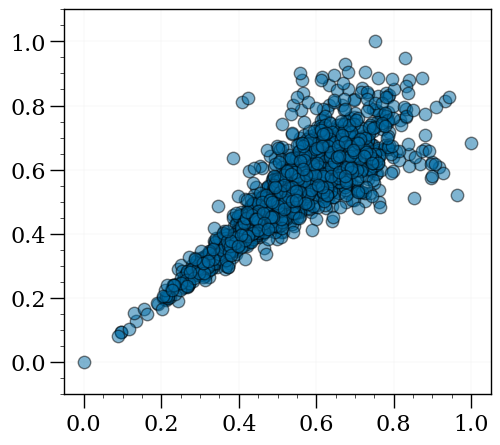

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'clayton_5')

  0%|          | 1/10000 [00:56<156:46:11, 56.44s/it]

Iter 0. Loss [[0.33309978 0.20085602 8.79014   ]]


  0%|          | 11/10000 [01:52<4:10:27,  1.50s/it]

Iter 10. Loss [[0.33454162 0.17121147 1.3800371 ]]


  0%|          | 21/10000 [01:55<50:45,  3.28it/s]

Iter 20. Loss [[0.33326766 0.17191398 1.3409879 ]]


  0%|          | 31/10000 [01:58<42:26,  3.92it/s]

Iter 30. Loss [[0.34009787 0.19298881 1.0571741 ]]


  0%|          | 41/10000 [02:01<44:17,  3.75it/s]

Iter 40. Loss [[0.33868873 0.1930621  0.8532664 ]]


  1%|          | 51/10000 [02:05<1:33:06,  1.78it/s]

Iter 50. Loss [[0.33803806 0.20007253 0.6665457 ]]


  1%|          | 61/10000 [02:07<43:13,  3.83it/s]

Iter 60. Loss [[0.33765224 0.20988582 0.48628426]]


  1%|          | 71/10000 [02:11<1:11:36,  2.31it/s]

Iter 70. Loss [[0.3361009  0.22173907 0.4325138 ]]


  1%|          | 81/10000 [02:14<48:08,  3.43it/s]

Iter 80. Loss [[0.33591956 0.1900459  0.58558804]]


  1%|          | 91/10000 [02:18<1:14:33,  2.22it/s]

Iter 90. Loss [[0.3317437  0.1833893  0.37908855]]


  1%|          | 101/10000 [02:21<42:35,  3.87it/s]

Iter 100. Loss [[0.33497772 0.20235553 0.1484019 ]]


  1%|          | 111/10000 [02:24<46:17,  3.56it/s]

Iter 110. Loss [[0.32791483 0.23056811 0.11147393]]


  1%|          | 121/10000 [02:26<42:46,  3.85it/s]

Iter 120. Loss [[0.32853678 0.19501851 0.08916008]]


  1%|▏         | 131/10000 [02:30<1:00:11,  2.73it/s]

Iter 130. Loss [[0.32797194 0.18120219 0.07912824]]


  1%|▏         | 141/10000 [02:33<46:13,  3.56it/s]

Iter 140. Loss [[0.3370995 0.1745454 0.6819602]]


  2%|▏         | 151/10000 [02:36<42:52,  3.83it/s]

Iter 150. Loss [[0.31431773 0.20128638 0.32696667]]


  2%|▏         | 161/10000 [02:39<1:05:16,  2.51it/s]

Iter 160. Loss [[0.31873494 0.1497046  0.0940977 ]]


  2%|▏         | 171/10000 [02:41<43:02,  3.81it/s]

Iter 170. Loss [[0.32530445 0.13785675 0.07722881]]


  2%|▏         | 181/10000 [02:46<1:09:40,  2.35it/s]

Iter 180. Loss [[0.30697057 0.1575922  0.07901049]]


  2%|▏         | 191/10000 [02:48<42:49,  3.82it/s]

Iter 190. Loss [[ 0.32508865  0.1425543  -0.11693738]]


  2%|▏         | 201/10000 [02:51<47:36,  3.43it/s]

Iter 200. Loss [[ 0.32570234  0.13918741 -0.14112972]]


  2%|▏         | 211/10000 [02:54<41:53,  3.90it/s]

Iter 210. Loss [[ 0.31725615  0.14556497 -0.2455608 ]]


  2%|▏         | 221/10000 [02:58<1:07:11,  2.43it/s]

Iter 220. Loss [[ 0.31392968  0.13806881 -0.26020744]]


  2%|▏         | 231/10000 [03:01<43:54,  3.71it/s]

Iter 230. Loss [[ 0.30800867  0.122866   -0.2170583 ]]


  2%|▏         | 241/10000 [03:04<43:36,  3.73it/s]

Iter 240. Loss [[ 0.31601503  0.09685775 -0.16510719]]


  3%|▎         | 251/10000 [03:06<41:02,  3.96it/s]

Iter 250. Loss [[ 0.30785295  0.11569637 -0.31090248]]


  3%|▎         | 261/10000 [03:10<58:32,  2.77it/s]

Iter 260. Loss [[ 0.31416038  0.11629498 -0.41984615]]


  3%|▎         | 271/10000 [03:14<1:05:48,  2.46it/s]

Iter 270. Loss [[ 0.31236896  0.10064903 -0.37443355]]


  3%|▎         | 281/10000 [03:16<42:27,  3.82it/s]

Iter 280. Loss [[ 0.30596778  0.09062111 -0.09227976]]


  3%|▎         | 291/10000 [03:19<49:06,  3.30it/s]

Iter 290. Loss [[0.2879979  0.08244449 0.10451753]]


  3%|▎         | 301/10000 [03:22<42:01,  3.85it/s]

Iter 300. Loss [[ 0.30136123  0.08817228 -0.29317963]]


  3%|▎         | 311/10000 [03:26<1:00:02,  2.69it/s]

Iter 310. Loss [[ 0.32708412  0.1130061  -0.5890292 ]]


  3%|▎         | 321/10000 [03:28<42:16,  3.82it/s]

Iter 320. Loss [[ 0.3179526   0.07618222 -0.4962984 ]]


  3%|▎         | 331/10000 [03:31<43:21,  3.72it/s]

Iter 330. Loss [[ 0.3222832   0.08706239 -0.6803911 ]]


  3%|▎         | 341/10000 [03:34<40:47,  3.95it/s]

Iter 340. Loss [[ 0.31978     0.08627979 -0.7832682 ]]


  4%|▎         | 351/10000 [03:38<1:05:53,  2.44it/s]

Iter 350. Loss [[ 0.32158932  0.08431307 -0.8013217 ]]


  4%|▎         | 361/10000 [03:41<1:07:34,  2.38it/s]

Iter 360. Loss [[0.24825528 0.2380077  2.6141887 ]]


  4%|▎         | 371/10000 [03:44<41:48,  3.84it/s]

Iter 370. Loss [[ 0.07172081  0.33126947 11.670716  ]]


  4%|▍         | 381/10000 [03:47<52:25,  3.06it/s]

Iter 380. Loss [[0.37709135 1.277474   0.4845387 ]]


  4%|▍         | 391/10000 [03:50<55:42,  2.87it/s]

Iter 390. Loss [[0.3670634 0.835909  0.6132534]]


  4%|▍         | 401/10000 [03:54<53:43,  2.98it/s]

Iter 400. Loss [[0.36922267 0.7814696  3.4932446 ]]


  4%|▍         | 411/10000 [03:56<41:05,  3.89it/s]

Iter 410. Loss [[0.35234863 0.35464892 0.90513307]]


  4%|▍         | 421/10000 [03:59<43:47,  3.65it/s]

Iter 420. Loss [[0.32884225 0.16483219 1.2375798 ]]


  4%|▍         | 431/10000 [04:02<40:10,  3.97it/s]

Iter 430. Loss [[0.32999173 0.16946626 1.047782  ]]


  4%|▍         | 441/10000 [04:06<58:08,  2.74it/s]  

Iter 440. Loss [[0.33603022 0.18941085 0.6856805 ]]


  5%|▍         | 451/10000 [04:08<41:14,  3.86it/s]

Iter 450. Loss [[0.33634987 0.18526909 0.63668364]]


  5%|▍         | 461/10000 [04:11<41:12,  3.86it/s]

Iter 460. Loss [[0.33451948 0.17145868 0.63754237]]


  5%|▍         | 471/10000 [04:15<57:06,  2.78it/s]  

Iter 470. Loss [[0.33524734 0.16889136 0.586875  ]]


  5%|▍         | 481/10000 [04:18<1:01:43,  2.57it/s]

Iter 480. Loss [[0.33667138 0.16988067 0.51841444]]


  5%|▍         | 491/10000 [04:21<49:27,  3.20it/s]

Iter 490. Loss [[0.3374266 0.1662844 0.4764458]]


  5%|▌         | 501/10000 [04:24<40:37,  3.90it/s]

Iter 500. Loss [[0.33812925 0.15874892 0.4740406 ]]


  5%|▌         | 511/10000 [04:27<45:19,  3.49it/s]

Iter 510. Loss [[0.34352028 0.17077425 0.30442455]]


  5%|▌         | 521/10000 [04:30<52:37,  3.00it/s]

Iter 520. Loss [[0.34737357 0.19129573 0.16261747]]


  5%|▌         | 531/10000 [04:34<46:46,  3.37it/s]

Iter 530. Loss [[0.34900075 0.21643887 0.00180364]]


  5%|▌         | 541/10000 [04:36<41:21,  3.81it/s]

Iter 540. Loss [[ 0.34634247  0.18659167 -0.03266036]]


  6%|▌         | 551/10000 [04:39<42:33,  3.70it/s]

Iter 550. Loss [[0.34097084 0.15136257 0.05117389]]


  6%|▌         | 561/10000 [04:42<1:03:51,  2.46it/s]

Iter 560. Loss [[0.3402395  0.14954394 0.10350582]]


  6%|▌         | 571/10000 [04:46<54:32,  2.88it/s]  

Iter 570. Loss [[0.34180686 0.13020769 0.03484896]]


  6%|▌         | 581/10000 [04:49<51:53,  3.03it/s]

Iter 580. Loss [[ 0.35678953  0.32196432 -0.26769933]]


  6%|▌         | 591/10000 [04:52<40:08,  3.91it/s]

Iter 590. Loss [[0.34377563 0.16682968 0.00618192]]


  6%|▌         | 601/10000 [04:55<46:49,  3.35it/s]

Iter 600. Loss [[0.3335355  0.11951873 0.03275121]]


  6%|▌         | 611/10000 [04:58<1:01:14,  2.56it/s]

Iter 610. Loss [[0.32838815 0.09938957 0.04673021]]


  6%|▌         | 621/10000 [05:02<45:17,  3.45it/s]

Iter 620. Loss [[0.32520443 0.08747776 0.04398701]]


  6%|▋         | 631/10000 [05:04<41:01,  3.81it/s]

Iter 630. Loss [[ 0.3257508   0.08924653 -0.0258606 ]]


  6%|▋         | 641/10000 [05:07<43:05,  3.62it/s]

Iter 640. Loss [[ 0.3264629   0.09170566 -0.10877389]]


  7%|▋         | 651/10000 [05:12<1:11:10,  2.19it/s]

Iter 650. Loss [[ 0.3269978   0.09407829 -0.16075842]]


  7%|▋         | 661/10000 [05:16<44:57,  3.46it/s]

Iter 660. Loss [[ 0.32545477  0.09251221 -0.09226899]]


  7%|▋         | 671/10000 [05:19<55:37,  2.79it/s]  

Iter 670. Loss [[ 0.3245995   0.08532712 -0.16452627]]


  7%|▋         | 681/10000 [05:21<38:54,  3.99it/s]

Iter 680. Loss [[ 0.31936213  0.07266729 -0.20111524]]


  7%|▋         | 691/10000 [05:24<49:05,  3.16it/s]

Iter 690. Loss [[ 0.3218096   0.06422851 -0.19299397]]


  7%|▋         | 701/10000 [05:28<52:04,  2.98it/s]

Iter 700. Loss [[ 0.33131188  0.08458406 -0.37241942]]


  7%|▋         | 711/10000 [05:31<43:57,  3.52it/s]

Iter 710. Loss [[ 0.3237826   0.06660813 -0.28303614]]


  7%|▋         | 721/10000 [05:33<39:16,  3.94it/s]

Iter 720. Loss [[ 0.32995954  0.06650919 -0.26994365]]


  7%|▋         | 731/10000 [05:36<40:42,  3.79it/s]

Iter 730. Loss [[ 0.3322056   0.07390778 -0.4174826 ]]


  7%|▋         | 741/10000 [05:40<1:00:18,  2.56it/s]

Iter 740. Loss [[ 0.32737997  0.06706155 -0.3745786 ]]


  8%|▊         | 751/10000 [05:43<40:38,  3.79it/s]

Iter 750. Loss [[ 0.32731196  0.06385844 -0.40798703]]


  8%|▊         | 761/10000 [05:46<1:01:42,  2.50it/s]

Iter 760. Loss [[ 0.33434048  0.0724795  -0.5238407 ]]


  8%|▊         | 771/10000 [05:48<38:51,  3.96it/s]

Iter 770. Loss [[ 0.3368642   0.06930755 -0.6223061 ]]


  8%|▊         | 781/10000 [05:52<1:05:23,  2.35it/s]

Iter 780. Loss [[ 0.34161487  0.08387699 -0.7300173 ]]


  8%|▊         | 791/10000 [05:55<43:55,  3.49it/s]

Iter 790. Loss [[ 0.33789468  0.06959862 -0.6715891 ]]


  8%|▊         | 801/10000 [05:58<43:33,  3.52it/s]

Iter 800. Loss [[ 0.33537555  0.06759252 -0.53484946]]


  8%|▊         | 811/10000 [06:01<39:11,  3.91it/s]

Iter 810. Loss [[ 0.34007257  0.07723177 -0.781847  ]]


  8%|▊         | 821/10000 [06:04<41:30,  3.69it/s]

Iter 820. Loss [[ 0.33849666  0.07031336 -0.80098534]]


  8%|▊         | 831/10000 [06:07<1:01:31,  2.48it/s]

Iter 830. Loss [[ 0.33394903  0.06205308 -0.64753413]]


  8%|▊         | 841/10000 [06:10<40:21,  3.78it/s]

Iter 840. Loss [[ 0.33443087  0.05738702 -0.77343047]]


  9%|▊         | 851/10000 [06:13<1:00:25,  2.52it/s]

Iter 850. Loss [[ 0.33908594  0.07835068 -0.90653545]]


  9%|▊         | 861/10000 [06:16<40:35,  3.75it/s]

Iter 860. Loss [[ 0.33729792  0.06921749 -0.83500016]]


  9%|▊         | 871/10000 [06:20<1:14:56,  2.03it/s]

Iter 870. Loss [[ 0.3369982   0.07335693 -0.8174751 ]]


  9%|▉         | 881/10000 [06:23<40:10,  3.78it/s]

Iter 880. Loss [[ 0.33643523  0.07824457 -0.5817317 ]]


  9%|▉         | 891/10000 [06:26<45:54,  3.31it/s]

Iter 890. Loss [[ 0.33481273  0.09696978 -0.76582533]]


  9%|▉         | 901/10000 [06:28<38:34,  3.93it/s]

Iter 900. Loss [[ 0.34273276  0.1290402  -0.8003064 ]]


  9%|▉         | 911/10000 [06:31<49:43,  3.05it/s]

Iter 910. Loss [[ 0.34595054  0.1469153  -0.9070107 ]]


  9%|▉         | 921/10000 [06:35<47:15,  3.20it/s]

Iter 920. Loss [[ 0.35789716  0.29588854 -0.8384134 ]]


  9%|▉         | 931/10000 [06:38<39:32,  3.82it/s]

Iter 930. Loss [[ 0.3480191   0.13995212 -0.7138943 ]]


  9%|▉         | 941/10000 [06:40<37:25,  4.03it/s]

Iter 940. Loss [[ 0.34572122  0.13700527 -0.88223666]]


 10%|▉         | 951/10000 [06:43<38:26,  3.92it/s]

Iter 950. Loss [[ 0.3409863   0.10560778 -0.86383134]]


 10%|▉         | 961/10000 [06:47<1:17:47,  1.94it/s]

Iter 960. Loss [[ 0.33189267  0.0662008  -0.7546253 ]]


 10%|▉         | 971/10000 [06:50<40:28,  3.72it/s]

Iter 970. Loss [[ 0.33115485  0.06683113 -0.779196  ]]


 10%|▉         | 981/10000 [06:53<48:59,  3.07it/s]

Iter 980. Loss [[ 0.3339241   0.07815151 -0.7440529 ]]


 10%|▉         | 991/10000 [06:55<38:40,  3.88it/s]

Iter 990. Loss [[ 0.32893562  0.06224491 -0.57361543]]


 10%|█         | 1001/10000 [06:59<1:00:53,  2.46it/s]

Iter 1000. Loss [[ 0.32108644  0.05373025 -0.6616859 ]]


 10%|█         | 1011/10000 [07:02<41:11,  3.64it/s]

Iter 1010. Loss [[ 0.32544363  0.07380863 -0.743347  ]]


 10%|█         | 1021/10000 [07:05<41:00,  3.65it/s]

Iter 1020. Loss [[ 0.32992202  0.07746334 -0.64046896]]


 10%|█         | 1031/10000 [07:08<37:42,  3.96it/s]

Iter 1030. Loss [[ 0.32679105  0.06069718 -0.6413733 ]]


 10%|█         | 1041/10000 [07:11<39:02,  3.82it/s]

Iter 1040. Loss [[ 0.33181277  0.07201529 -0.86084485]]


 11%|█         | 1051/10000 [07:15<1:14:49,  1.99it/s]

Iter 1050. Loss [[ 0.33620232  0.07306477 -0.9119385 ]]


 11%|█         | 1061/10000 [07:18<38:06,  3.91it/s]

Iter 1060. Loss [[ 0.3323751   0.05825997 -0.8966875 ]]


 11%|█         | 1071/10000 [07:21<48:33,  3.06it/s]

Iter 1070. Loss [[ 0.33634248  0.06469114 -0.9661121 ]]


 11%|█         | 1081/10000 [07:23<38:44,  3.84it/s]

Iter 1080. Loss [[ 0.33839682  0.06818869 -1.0064625 ]]


 11%|█         | 1091/10000 [07:27<1:07:19,  2.21it/s]

Iter 1090. Loss [[ 0.33968008  0.06748478 -1.0109347 ]]


 11%|█         | 1101/10000 [07:30<38:33,  3.85it/s]

Iter 1100. Loss [[ 0.3406679  0.0681462 -1.0356019]]


 11%|█         | 1111/10000 [07:33<40:40,  3.64it/s]

Iter 1110. Loss [[ 0.34113124  0.06773103 -1.0147697 ]]


 11%|█         | 1121/10000 [07:35<37:32,  3.94it/s]

Iter 1120. Loss [[ 0.3374353   0.06704745 -0.91035944]]


 11%|█▏        | 1131/10000 [07:38<50:32,  2.92it/s]

Iter 1130. Loss [[ 0.34217706  0.06985956 -1.0394484 ]]


 11%|█▏        | 1141/10000 [07:42<42:31,  3.47it/s]

Iter 1140. Loss [[ 0.3429248   0.07169954 -1.0573788 ]]


 12%|█▏        | 1151/10000 [07:45<37:41,  3.91it/s]

Iter 1150. Loss [[ 0.3443854   0.07554803 -1.0684441 ]]


 12%|█▏        | 1161/10000 [07:48<50:54,  2.89it/s]

Iter 1160. Loss [[ 0.3429726   0.06939517 -0.98488873]]


 12%|█▏        | 1171/10000 [07:50<37:13,  3.95it/s]

Iter 1170. Loss [[ 0.34343693  0.06573702 -0.98018277]]


 12%|█▏        | 1181/10000 [07:54<1:03:44,  2.31it/s]

Iter 1180. Loss [[ 0.34684312  0.08610441 -0.9931817 ]]


 12%|█▏        | 1191/10000 [07:57<38:22,  3.83it/s]

Iter 1190. Loss [[0.34403518 0.0963901  0.59675497]]


 12%|█▏        | 1201/10000 [08:00<42:17,  3.47it/s]

Iter 1200. Loss [[ 0.35084325  0.15088639 -1.013851  ]]


 12%|█▏        | 1211/10000 [08:02<37:12,  3.94it/s]

Iter 1210. Loss [[ 0.342527    0.06903234 -0.93866634]]


 12%|█▏        | 1221/10000 [08:06<1:05:03,  2.25it/s]

Iter 1220. Loss [[ 0.34377775  0.07399915 -1.036407  ]]


 12%|█▏        | 1231/10000 [08:11<56:59,  2.56it/s]  

Iter 1230. Loss [[ 0.34097835  0.06370204 -0.8138907 ]]


 12%|█▏        | 1241/10000 [08:14<38:03,  3.84it/s]

Iter 1240. Loss [[ 0.3372001   0.04977754 -0.77025497]]


 13%|█▎        | 1251/10000 [08:17<59:22,  2.46it/s]

Iter 1250. Loss [[ 0.34281373  0.08106667 -0.98132396]]


 13%|█▎        | 1261/10000 [08:19<37:11,  3.92it/s]

Iter 1260. Loss [[ 0.3371092   0.04892372 -0.85917884]]


 13%|█▎        | 1271/10000 [08:23<1:09:41,  2.09it/s]

Iter 1270. Loss [[ 0.3415593   0.07120825 -1.0195714 ]]


 13%|█▎        | 1281/10000 [08:26<38:59,  3.73it/s]

Iter 1280. Loss [[ 0.3392005   0.05229824 -0.924239  ]]


 13%|█▎        | 1291/10000 [08:29<41:11,  3.52it/s]

Iter 1290. Loss [[ 0.34110683  0.06102324 -0.977121  ]]


 13%|█▎        | 1301/10000 [08:31<35:36,  4.07it/s]

Iter 1300. Loss [[ 0.34273335  0.06331603 -0.99052685]]


 13%|█▎        | 1311/10000 [08:34<50:06,  2.89it/s]

Iter 1310. Loss [[ 0.34308645  0.05760946 -0.97944325]]


 13%|█▎        | 1321/10000 [08:38<42:33,  3.40it/s]

Iter 1320. Loss [[ 0.34364977  0.06866439 -1.0660146 ]]


 13%|█▎        | 1331/10000 [08:41<37:18,  3.87it/s]

Iter 1330. Loss [[ 0.36553502  0.75234455 -0.5232247 ]]


 13%|█▎        | 1341/10000 [08:43<37:02,  3.90it/s]

Iter 1340. Loss [[ 0.33911535  0.12177687 -0.5387175 ]]


 14%|█▎        | 1351/10000 [08:46<37:31,  3.84it/s]

Iter 1350. Loss [[ 0.33052012  0.0619343  -0.46550947]]


 14%|█▎        | 1361/10000 [08:51<1:12:42,  1.98it/s]

Iter 1360. Loss [[ 0.33875114  0.07873406 -0.6742541 ]]


 14%|█▎        | 1371/10000 [08:53<37:17,  3.86it/s]

Iter 1370. Loss [[ 0.34458336  0.08275428 -0.8391455 ]]


 14%|█▍        | 1381/10000 [08:56<43:29,  3.30it/s]

Iter 1380. Loss [[ 0.34677726  0.08791348 -0.85635597]]


 14%|█▍        | 1391/10000 [08:58<36:01,  3.98it/s]

Iter 1390. Loss [[ 0.34652534  0.09328466 -0.99479735]]


 14%|█▍        | 1401/10000 [09:02<57:46,  2.48it/s]

Iter 1400. Loss [[ 0.34306547  0.07131746 -0.96240866]]


 14%|█▍        | 1411/10000 [09:05<38:30,  3.72it/s]

Iter 1410. Loss [[ 0.3395089  0.0572792 -0.8937727]]


 14%|█▍        | 1421/10000 [09:08<37:28,  3.81it/s]

Iter 1420. Loss [[ 0.34130388  0.05573935 -0.9252663 ]]


 14%|█▍        | 1431/10000 [09:11<36:07,  3.95it/s]

Iter 1430. Loss [[ 0.34301904  0.0625773  -1.0008805 ]]


 14%|█▍        | 1441/10000 [09:14<36:38,  3.89it/s]

Iter 1440. Loss [[ 0.34242278  0.05309996 -0.94786996]]


 15%|█▍        | 1451/10000 [09:18<1:08:33,  2.08it/s]

Iter 1450. Loss [[ 0.34439543  0.06749819 -1.0013351 ]]


 15%|█▍        | 1461/10000 [09:20<36:37,  3.89it/s]

Iter 1460. Loss [[ 0.34373268  0.06420249 -0.9866191 ]]


 15%|█▍        | 1471/10000 [09:23<45:57,  3.09it/s]

Iter 1470. Loss [[ 0.3452007   0.06240706 -0.9986807 ]]


 15%|█▍        | 1481/10000 [09:26<36:45,  3.86it/s]

Iter 1480. Loss [[ 0.34140235  0.05372338 -0.9372059 ]]


 15%|█▍        | 1491/10000 [09:30<1:02:19,  2.28it/s]

Iter 1490. Loss [[0.34347156 0.35866618 0.5354928 ]]


 15%|█▌        | 1501/10000 [09:33<35:47,  3.96it/s]

Iter 1500. Loss [[0.27979052 0.12063608 0.42367685]]


 15%|█▌        | 1511/10000 [09:36<38:53,  3.64it/s]

Iter 1510. Loss [[0.3050094  0.08110002 0.09525126]]


 15%|█▌        | 1521/10000 [09:38<35:52,  3.94it/s]

Iter 1520. Loss [[ 0.31117073  0.03998246 -0.21925451]]


 15%|█▌        | 1531/10000 [09:41<49:18,  2.86it/s]

Iter 1530. Loss [[ 0.3257548   0.04827318 -0.5203631 ]]


 15%|█▌        | 1541/10000 [09:45<38:52,  3.63it/s]

Iter 1540. Loss [[ 0.33479804  0.07638906 -0.66801614]]


 16%|█▌        | 1551/10000 [09:48<35:45,  3.94it/s]

Iter 1550. Loss [[ 0.33670124  0.07300144 -0.6733382 ]]


 16%|█▌        | 1561/10000 [09:51<49:06,  2.86it/s]

Iter 1560. Loss [[ 0.33992457  0.08653178 -0.7946154 ]]


 16%|█▌        | 1571/10000 [09:53<35:27,  3.96it/s]

Iter 1570. Loss [[ 0.32559583  0.09703438 -0.14301962]]


 16%|█▌        | 1581/10000 [09:57<1:00:53,  2.30it/s]

Iter 1580. Loss [[ 0.32519215  0.11331762 -0.15155263]]


 16%|█▌        | 1591/10000 [10:00<36:40,  3.82it/s]

Iter 1590. Loss [[ 0.3128866   0.04410773 -0.26182026]]


 16%|█▌        | 1601/10000 [10:03<39:18,  3.56it/s]

Iter 1600. Loss [[ 0.32810488  0.06101581 -0.43647546]]


 16%|█▌        | 1611/10000 [10:05<36:38,  3.82it/s]

Iter 1610. Loss [[ 0.3322074   0.05554354 -0.5966089 ]]


 16%|█▌        | 1621/10000 [10:09<55:57,  2.50it/s]

Iter 1620. Loss [[ 0.3361075   0.06875916 -0.67042094]]


 16%|█▋        | 1631/10000 [10:12<37:11,  3.75it/s]

Iter 1630. Loss [[ 0.3385325   0.07327051 -0.74285865]]


 16%|█▋        | 1641/10000 [10:15<36:15,  3.84it/s]

Iter 1640. Loss [[ 0.3398547   0.07026097 -0.7662928 ]]


 17%|█▋        | 1651/10000 [10:18<55:53,  2.49it/s]

Iter 1650. Loss [[ 0.34426248  0.10784113 -0.90931475]]


 17%|█▋        | 1661/10000 [10:21<42:17,  3.29it/s]

Iter 1660. Loss [[ 0.3411133   0.07411437 -0.7966464 ]]


 17%|█▋        | 1671/10000 [10:25<53:35,  2.59it/s]  

Iter 1670. Loss [[ 0.34720027  0.05934884 -0.9051688 ]]


 17%|█▋        | 1681/10000 [10:28<36:24,  3.81it/s]

Iter 1680. Loss [[ 0.35296655  0.13133408 -1.0333256 ]]


 17%|█▋        | 1691/10000 [10:31<39:39,  3.49it/s]

Iter 1690. Loss [[ 0.341382    0.05625191 -0.8378403 ]]


 17%|█▋        | 1701/10000 [10:33<34:30,  4.01it/s]

Iter 1700. Loss [[ 0.34294745  0.05548977 -0.88805825]]


 17%|█▋        | 1711/10000 [10:37<56:41,  2.44it/s]

Iter 1710. Loss [[ 0.34204212  0.07069609 -0.85540247]]


 17%|█▋        | 1721/10000 [10:40<34:31,  4.00it/s]

Iter 1720. Loss [[ 0.34602037  0.08825149 -1.002794  ]]


 17%|█▋        | 1731/10000 [10:43<35:50,  3.85it/s]

Iter 1730. Loss [[ 0.34641907  0.0702992  -0.9541996 ]]


 17%|█▋        | 1741/10000 [10:46<55:41,  2.47it/s]

Iter 1740. Loss [[ 0.343026    0.04624402 -0.86087555]]


 18%|█▊        | 1751/10000 [10:49<51:50,  2.65it/s]

Iter 1750. Loss [[ 0.34746766  0.06369045 -0.9176023 ]]


 18%|█▊        | 1761/10000 [10:52<47:46,  2.87it/s]

Iter 1760. Loss [[ 0.3460695   0.07215857 -0.90553224]]


 18%|█▊        | 1771/10000 [10:55<35:42,  3.84it/s]

Iter 1770. Loss [[ 0.3468074   0.17870764 -0.10332496]]


 18%|█▊        | 1781/10000 [10:58<39:01,  3.51it/s]

Iter 1780. Loss [[0.32408848 0.1133192  2.9511967 ]]


 18%|█▊        | 1791/10000 [11:01<55:07,  2.48it/s]

Iter 1790. Loss [[ 0.3254376   0.04074236 -0.31503984]]


 18%|█▊        | 1801/10000 [11:06<1:00:40,  2.25it/s]

Iter 1800. Loss [[ 0.35245833  0.24874292 -0.69327897]]


 18%|█▊        | 1811/10000 [11:09<35:25,  3.85it/s]

Iter 1810. Loss [[ 0.34771922  0.15571578 -0.7299655 ]]


 18%|█▊        | 1821/10000 [11:12<35:34,  3.83it/s]

Iter 1820. Loss [[ 0.3352136   0.05930903 -0.63909876]]


 18%|█▊        | 1831/10000 [11:14<34:44,  3.92it/s]

Iter 1830. Loss [[ 0.332256    0.05629618 -0.6068528 ]]


 18%|█▊        | 1841/10000 [11:18<51:42,  2.63it/s]

Iter 1840. Loss [[ 0.33609828  0.06519546 -0.6891179 ]]


 19%|█▊        | 1851/10000 [11:21<50:29,  2.69it/s]

Iter 1850. Loss [[ 0.33943823  0.07585514 -0.75295484]]


 19%|█▊        | 1861/10000 [11:24<33:55,  4.00it/s]

Iter 1860. Loss [[ 0.34088153  0.08017808 -0.7943864 ]]


 19%|█▊        | 1871/10000 [11:27<41:11,  3.29it/s]

Iter 1870. Loss [[ 0.34078848  0.07528634 -0.79917985]]


 19%|█▉        | 1881/10000 [11:29<33:46,  4.01it/s]

Iter 1880. Loss [[ 0.34068033  0.07035783 -0.81027067]]


 19%|█▉        | 1891/10000 [11:33<43:41,  3.09it/s]

Iter 1890. Loss [[ 0.3399239   0.0639519  -0.79058546]]


 19%|█▉        | 1901/10000 [11:36<34:17,  3.94it/s]

Iter 1900. Loss [[ 0.3407857   0.06480507 -0.8146167 ]]


 19%|█▉        | 1911/10000 [11:39<35:18,  3.82it/s]

Iter 1910. Loss [[ 0.34114277  0.06113921 -0.8044882 ]]


 19%|█▉        | 1921/10000 [11:41<33:35,  4.01it/s]

Iter 1920. Loss [[ 0.34459507  0.05710217 -0.84142274]]


 19%|█▉        | 1931/10000 [11:45<54:37,  2.46it/s]

Iter 1930. Loss [[ 0.35172796  0.09573863 -0.91577816]]


 19%|█▉        | 1941/10000 [11:49<54:52,  2.45it/s]

Iter 1940. Loss [[ 0.34925538  0.05430743 -0.8926514 ]]


 20%|█▉        | 1951/10000 [11:51<34:30,  3.89it/s]

Iter 1950. Loss [[ 0.35196757  0.08543156 -0.89777845]]


 20%|█▉        | 1961/10000 [11:54<44:07,  3.04it/s]

Iter 1960. Loss [[ 0.35137185  0.09321358 -0.94198036]]


 20%|█▉        | 1971/10000 [11:57<47:30,  2.82it/s]

Iter 1970. Loss [[ 0.3470956   0.07096437 -0.93643486]]


 20%|█▉        | 1981/10000 [12:01<43:09,  3.10it/s]

Iter 1980. Loss [[ 0.34531295  0.05484993 -0.8859282 ]]


 20%|█▉        | 1991/10000 [12:04<33:39,  3.97it/s]

Iter 1990. Loss [[ 0.34582794  0.05781182 -0.90205616]]


 20%|██        | 2001/10000 [12:07<37:00,  3.60it/s]

Iter 2000. Loss [[ 0.34674773  0.05986844 -0.9150555 ]]


 20%|██        | 2011/10000 [12:09<33:40,  3.95it/s]

Iter 2010. Loss [[ 0.34794173  0.06195024 -0.9257508 ]]


 20%|██        | 2021/10000 [12:13<46:01,  2.89it/s]

Iter 2020. Loss [[ 0.34940308  0.0673452  -0.9501991 ]]


 20%|██        | 2031/10000 [12:16<33:35,  3.95it/s]

Iter 2030. Loss [[ 0.34979054  0.07144154 -0.9723965 ]]


 20%|██        | 2041/10000 [12:19<34:21,  3.86it/s]

Iter 2040. Loss [[ 0.3537093   0.07760121 -0.9860734 ]]


 21%|██        | 2051/10000 [12:22<47:00,  2.82it/s]

Iter 2050. Loss [[ 0.34791335  0.15080556 -0.33384752]]


 21%|██        | 2061/10000 [12:25<52:26,  2.52it/s]

Iter 2060. Loss [[ 0.34296185  0.06438721 -0.52295774]]


 21%|██        | 2071/10000 [12:29<41:22,  3.19it/s]

Iter 2070. Loss [[ 0.35261518  0.10285006 -0.99932647]]


 21%|██        | 2081/10000 [12:31<33:44,  3.91it/s]

Iter 2080. Loss [[ 0.34971228  0.06800005 -0.75611264]]


 21%|██        | 2091/10000 [12:34<36:04,  3.65it/s]

Iter 2090. Loss [[ 0.34673068  0.07973439 -0.6641183 ]]


 21%|██        | 2101/10000 [12:37<40:34,  3.24it/s]

Iter 2100. Loss [[ 0.3393905   0.05130292 -0.73413795]]


 21%|██        | 2111/10000 [12:41<39:36,  3.32it/s]

Iter 2110. Loss [[ 0.33695748  0.08707664 -0.39423835]]


 21%|██        | 2121/10000 [12:43<33:34,  3.91it/s]

Iter 2120. Loss [[0.36450073 0.8190631  1.6279144 ]]


 21%|██▏       | 2131/10000 [12:46<34:41,  3.78it/s]

Iter 2130. Loss [[0.33199757 0.1575009  0.06358925]]


 21%|██▏       | 2141/10000 [12:49<52:12,  2.51it/s]

Iter 2140. Loss [[0.3136255  0.08609691 0.2532682 ]]


 22%|██▏       | 2151/10000 [12:53<51:10,  2.56it/s]

Iter 2150. Loss [[ 0.3424953   0.15411986 -0.5533888 ]]


 22%|██▏       | 2161/10000 [12:56<43:59,  2.97it/s]

Iter 2160. Loss [[ 0.3328313   0.0555656  -0.56430703]]


 22%|██▏       | 2171/10000 [12:59<34:14,  3.81it/s]

Iter 2170. Loss [[ 0.33712432  0.06939622 -0.6677003 ]]


 22%|██▏       | 2181/10000 [13:02<38:00,  3.43it/s]

Iter 2180. Loss [[ 0.34086496  0.0776258  -0.7482027 ]]


 22%|██▏       | 2191/10000 [13:05<53:23,  2.44it/s]

Iter 2190. Loss [[ 0.3459541   0.0866329  -0.84167725]]


 22%|██▏       | 2201/10000 [13:09<36:38,  3.55it/s]

Iter 2200. Loss [[ 0.3494134   0.11289301 -0.9310231 ]]


 22%|██▏       | 2211/10000 [13:11<34:00,  3.82it/s]

Iter 2210. Loss [[ 0.3418169   0.05739537 -0.7943882 ]]


 22%|██▏       | 2221/10000 [13:15<33:43,  3.84it/s]

Iter 2220. Loss [[ 0.34135064  0.04981332 -0.72590494]]


 22%|██▏       | 2231/10000 [13:18<1:08:04,  1.90it/s]

Iter 2230. Loss [[ 0.3443308   0.06513857 -0.8362425 ]]


 22%|██▏       | 2241/10000 [13:21<37:04,  3.49it/s]

Iter 2240. Loss [[ 0.345019    0.067672   -0.85935724]]


 23%|██▎       | 2251/10000 [13:24<42:48,  3.02it/s]

Iter 2250. Loss [[ 0.3461734   0.07133977 -0.81400436]]


 23%|██▎       | 2261/10000 [13:27<32:28,  3.97it/s]

Iter 2260. Loss [[ 0.34313628  0.05073792 -0.77499235]]


 23%|██▎       | 2271/10000 [13:30<41:02,  3.14it/s]

Iter 2270. Loss [[ 0.34943697  0.06091329 -0.89711994]]


 23%|██▎       | 2281/10000 [13:34<43:28,  2.96it/s]

Iter 2280. Loss [[ 0.3548359   0.10956946 -0.8477578 ]]


 23%|██▎       | 2291/10000 [13:37<35:10,  3.65it/s]

Iter 2290. Loss [[ 0.348101    0.06529387 -0.8441225 ]]


 23%|██▎       | 2301/10000 [13:39<31:51,  4.03it/s]

Iter 2300. Loss [[ 0.34603485  0.05427937 -0.8638948 ]]


 23%|██▎       | 2311/10000 [13:42<33:06,  3.87it/s]

Iter 2310. Loss [[ 0.34931302  0.0626441  -0.9265705 ]]


 23%|██▎       | 2321/10000 [13:45<47:58,  2.67it/s]

Iter 2320. Loss [[ 0.34891126  0.05844271 -0.9357259 ]]


 23%|██▎       | 2331/10000 [13:49<34:05,  3.75it/s]

Iter 2330. Loss [[ 0.3494702   0.05794377 -0.9283957 ]]


 23%|██▎       | 2341/10000 [13:52<45:24,  2.81it/s]

Iter 2340. Loss [[ 0.3508355   0.06042818 -0.93793833]]


 24%|██▎       | 2351/10000 [13:54<33:01,  3.86it/s]

Iter 2350. Loss [[ 0.35186347  0.06794097 -0.981401  ]]


 24%|██▎       | 2361/10000 [13:59<1:04:04,  1.99it/s]

Iter 2360. Loss [[ 0.35036713  0.05628046 -0.92192686]]


 24%|██▎       | 2371/10000 [14:02<39:31,  3.22it/s]

Iter 2370. Loss [[ 0.35180938  0.06936971 -0.9750903 ]]


 24%|██▍       | 2381/10000 [14:05<36:13,  3.50it/s]

Iter 2380. Loss [[ 0.34971562  0.08979619 -0.58480126]]


 24%|██▍       | 2391/10000 [14:08<31:30,  4.03it/s]

Iter 2390. Loss [[ 0.34635666  0.0561977  -0.6678921 ]]


 24%|██▍       | 2401/10000 [14:11<34:27,  3.68it/s]

Iter 2400. Loss [[ 0.35379186  0.11146223 -1.0488719 ]]


 24%|██▍       | 2411/10000 [14:15<50:27,  2.51it/s]

Iter 2410. Loss [[ 0.3506407   0.05732485 -0.9038498 ]]


 24%|██▍       | 2421/10000 [14:18<33:58,  3.72it/s]

Iter 2420. Loss [[ 0.3515065   0.06435278 -0.9194575 ]]


 24%|██▍       | 2431/10000 [14:21<50:53,  2.48it/s]

Iter 2430. Loss [[ 0.35013273  0.07026003 -0.9297474 ]]


 24%|██▍       | 2441/10000 [14:23<32:42,  3.85it/s]

Iter 2440. Loss [[ 0.34697062  0.05461614 -0.7544061 ]]


 25%|██▍       | 2451/10000 [14:27<56:33,  2.22it/s]

Iter 2450. Loss [[0.33621317 0.13934936 3.8100045 ]]


 25%|██▍       | 2461/10000 [14:30<34:15,  3.67it/s]

Iter 2460. Loss [[0.35108072 0.20716304 0.09618662]]


 25%|██▍       | 2471/10000 [14:33<36:19,  3.45it/s]

Iter 2470. Loss [[ 0.3421568  0.0698101 -0.3712634]]


 25%|██▍       | 2481/10000 [14:36<31:36,  3.96it/s]

Iter 2480. Loss [[ 0.34587538  0.08164851 -0.7528977 ]]


 25%|██▍       | 2491/10000 [14:39<34:54,  3.59it/s]

Iter 2490. Loss [[ 0.34621158  0.08417889 -0.80589753]]


 25%|██▌       | 2501/10000 [14:42<43:24,  2.88it/s]

Iter 2500. Loss [[ 0.34579733  0.08409099 -0.8039691 ]]


 25%|██▌       | 2511/10000 [14:45<34:08,  3.66it/s]

Iter 2510. Loss [[ 0.34491852  0.0724199  -0.7995964 ]]


 25%|██▌       | 2521/10000 [14:48<32:26,  3.84it/s]

Iter 2520. Loss [[ 0.34440595  0.05967963 -0.7704365 ]]


 25%|██▌       | 2531/10000 [14:51<33:19,  3.74it/s]

Iter 2530. Loss [[ 0.34566152  0.0615837  -0.80941975]]


 25%|██▌       | 2541/10000 [14:55<1:06:02,  1.88it/s]

Iter 2540. Loss [[ 0.34625027  0.0616831  -0.824609  ]]


 26%|██▌       | 2551/10000 [14:58<33:10,  3.74it/s]

Iter 2550. Loss [[ 0.34759942  0.06388783 -0.85687244]]


 26%|██▌       | 2561/10000 [15:01<37:20,  3.32it/s]

Iter 2560. Loss [[ 0.3484629   0.06395107 -0.8716711 ]]


 26%|██▌       | 2571/10000 [15:04<32:10,  3.85it/s]

Iter 2570. Loss [[ 0.3483799   0.06134712 -0.88072443]]


 26%|██▌       | 2581/10000 [15:07<50:05,  2.47it/s]

Iter 2580. Loss [[ 0.34880695  0.06177393 -0.8982692 ]]


 26%|██▌       | 2591/10000 [15:10<33:29,  3.69it/s]

Iter 2590. Loss [[ 0.34864873  0.05675796 -0.8881125 ]]


 26%|██▌       | 2601/10000 [15:13<32:34,  3.78it/s]

Iter 2600. Loss [[ 0.34843338  0.05296167 -0.8747947 ]]


 26%|██▌       | 2611/10000 [15:16<36:14,  3.40it/s]

Iter 2610. Loss [[ 0.3482471   0.05011381 -0.8650275 ]]


 26%|██▌       | 2621/10000 [15:20<41:00,  3.00it/s]

Iter 2620. Loss [[ 0.34880888  0.052358   -0.8675267 ]]


 26%|██▋       | 2631/10000 [15:24<55:49,  2.20it/s]

Iter 2630. Loss [[ 0.35053742  0.06314117 -0.9007907 ]]


 26%|██▋       | 2641/10000 [15:26<31:49,  3.85it/s]

Iter 2640. Loss [[ 0.34990835  0.05415791 -0.8939735 ]]


 27%|██▋       | 2651/10000 [15:29<41:30,  2.95it/s]

Iter 2650. Loss [[ 0.3519848   0.06337067 -0.9315255 ]]


 27%|██▋       | 2661/10000 [15:32<31:25,  3.89it/s]

Iter 2660. Loss [[ 0.35238346  0.06150363 -0.9353716 ]]


 27%|██▋       | 2671/10000 [15:36<47:50,  2.55it/s]

Iter 2670. Loss [[ 0.35265052  0.06031189 -0.9375789 ]]


 27%|██▋       | 2681/10000 [15:39<31:23,  3.89it/s]

Iter 2680. Loss [[ 0.35340905  0.0628161  -0.9337619 ]]


 27%|██▋       | 2691/10000 [15:42<33:14,  3.66it/s]

Iter 2690. Loss [[ 0.3534722   0.06484234 -0.95537955]]


 27%|██▋       | 2701/10000 [15:44<30:22,  4.01it/s]

Iter 2700. Loss [[ 0.35351905  0.06211259 -0.959669  ]]


 27%|██▋       | 2711/10000 [15:48<48:12,  2.52it/s]

Iter 2710. Loss [[ 0.35276517  0.04853341 -0.87827915]]


 27%|██▋       | 2721/10000 [15:51<32:34,  3.72it/s]

Iter 2720. Loss [[ 0.3550698   0.07847095 -1.0112411 ]]


 27%|██▋       | 2731/10000 [15:54<31:30,  3.85it/s]

Iter 2730. Loss [[ 0.35347673  0.06514981 -0.8502013 ]]


 27%|██▋       | 2741/10000 [15:57<43:20,  2.79it/s]

Iter 2740. Loss [[ 0.3539712   0.07463561 -0.86883885]]


 28%|██▊       | 2751/10000 [16:00<35:26,  3.41it/s]

Iter 2750. Loss [[ 0.35197088  0.05902101 -0.9016802 ]]


 28%|██▊       | 2761/10000 [16:04<42:48,  2.82it/s]

Iter 2760. Loss [[0.34657204 0.13453862 0.15029484]]


 28%|██▊       | 2771/10000 [16:06<31:31,  3.82it/s]

Iter 2770. Loss [[ 0.34769306  0.04017112 -0.69972   ]]


 28%|██▊       | 2781/10000 [16:09<34:06,  3.53it/s]

Iter 2780. Loss [[ 0.35505173  0.12257636 -0.9688732 ]]


 28%|██▊       | 2791/10000 [16:12<30:27,  3.95it/s]

Iter 2790. Loss [[ 0.35015598  0.06138736 -0.9022741 ]]


 28%|██▊       | 2801/10000 [16:16<49:03,  2.45it/s]

Iter 2800. Loss [[0.3341091  0.15984607 0.3761838 ]]


 28%|██▊       | 2811/10000 [16:18<31:13,  3.84it/s]

Iter 2810. Loss [[ 0.31864592  0.0637319  -0.09497589]]


 28%|██▊       | 2821/10000 [16:21<31:26,  3.81it/s]

Iter 2820. Loss [[ 0.3405867   0.08561344 -0.63657594]]


 28%|██▊       | 2831/10000 [16:24<48:00,  2.49it/s]

Iter 2830. Loss [[ 0.3443617   0.07471552 -0.6950192 ]]


 28%|██▊       | 2841/10000 [16:28<43:50,  2.72it/s]

Iter 2840. Loss [[ 0.34672046  0.0813197  -0.7626156 ]]


 29%|██▊       | 2851/10000 [16:31<41:32,  2.87it/s]

Iter 2850. Loss [[ 0.3470135   0.08218364 -0.82398874]]


 29%|██▊       | 2861/10000 [16:34<30:21,  3.92it/s]

Iter 2860. Loss [[ 0.34673956  0.07910579 -0.81080747]]


 29%|██▊       | 2871/10000 [16:37<33:32,  3.54it/s]

Iter 2870. Loss [[ 0.34512022  0.06243806 -0.77797556]]


 29%|██▉       | 2881/10000 [16:39<29:46,  3.99it/s]

Iter 2880. Loss [[ 0.3455781   0.05798834 -0.7906556 ]]


 29%|██▉       | 2891/10000 [16:43<41:53,  2.83it/s]

Iter 2890. Loss [[ 0.3464086   0.05641986 -0.7957905 ]]


 29%|██▉       | 2901/10000 [16:46<30:34,  3.87it/s]

Iter 2900. Loss [[ 0.3474978   0.0580059  -0.82711744]]


 29%|██▉       | 2911/10000 [16:50<51:11,  2.31it/s]

Iter 2910. Loss [[ 0.3478066   0.05771504 -0.83572817]]


 29%|██▉       | 2921/10000 [16:53<33:13,  3.55it/s]

Iter 2920. Loss [[ 0.34420592  0.03837486 -0.7025189 ]]


 29%|██▉       | 2931/10000 [16:57<36:34,  3.22it/s]

Iter 2930. Loss [[ 0.346722    0.04264965 -0.7812611 ]]


 29%|██▉       | 2941/10000 [17:00<41:45,  2.82it/s]

Iter 2940. Loss [[ 0.34839246  0.0446535  -0.7934132 ]]


 30%|██▉       | 2951/10000 [17:03<30:14,  3.88it/s]

Iter 2950. Loss [[ 0.35092652  0.05213513 -0.85713774]]


 30%|██▉       | 2961/10000 [17:06<35:18,  3.32it/s]

Iter 2960. Loss [[ 0.35258773  0.06421658 -0.9050688 ]]


 30%|██▉       | 2971/10000 [17:10<48:04,  2.44it/s]

Iter 2970. Loss [[ 0.3541581   0.07679261 -0.6766929 ]]


 30%|██▉       | 2981/10000 [17:13<34:32,  3.39it/s]

Iter 2980. Loss [[ 0.34392205  0.05964573 -0.36745808]]


 30%|██▉       | 2991/10000 [17:15<29:32,  3.96it/s]

Iter 2990. Loss [[ 0.34201857  0.04417295 -0.56465024]]


 30%|███       | 3001/10000 [17:18<31:06,  3.75it/s]

Iter 3000. Loss [[ 0.34950384  0.05100333 -0.8053534 ]]


 30%|███       | 3011/10000 [17:21<41:24,  2.81it/s]

Iter 3010. Loss [[ 0.35327488  0.08097018 -0.9340194 ]]


 30%|███       | 3021/10000 [17:25<32:59,  3.53it/s]

Iter 3020. Loss [[ 0.3523396   0.06927461 -0.88744044]]


 30%|███       | 3031/10000 [17:28<45:58,  2.53it/s]

Iter 3030. Loss [[ 0.35139522  0.05542878 -0.8725431 ]]


 30%|███       | 3041/10000 [17:30<29:42,  3.90it/s]

Iter 3040. Loss [[ 0.35211962  0.05307197 -0.8838205 ]]


 31%|███       | 3051/10000 [17:33<42:32,  2.72it/s]

Iter 3050. Loss [[0.32664633 0.1272936  0.03657757]]


 31%|███       | 3061/10000 [17:37<37:48,  3.06it/s]

Iter 3060. Loss [[ 0.34502062  0.2046079  -0.16996571]]


 31%|███       | 3071/10000 [17:40<35:35,  3.24it/s]

Iter 3070. Loss [[ 0.33039886  0.08167227 -0.10036682]]


 31%|███       | 3081/10000 [17:43<29:30,  3.91it/s]

Iter 3080. Loss [[ 0.3373193   0.09171519 -0.38598302]]


 31%|███       | 3091/10000 [17:46<31:51,  3.61it/s]

Iter 3090. Loss [[ 0.34180582  0.07363965 -0.52414614]]


 31%|███       | 3101/10000 [17:49<44:42,  2.57it/s]

Iter 3100. Loss [[ 0.3482932   0.11551026 -0.6313813 ]]


 31%|███       | 3111/10000 [17:53<31:55,  3.60it/s]

Iter 3110. Loss [[ 0.34539333  0.10251793 -0.6898016 ]]


 31%|███       | 3121/10000 [17:55<28:44,  3.99it/s]

Iter 3120. Loss [[ 0.340271    0.07491542 -0.5998946 ]]


 31%|███▏      | 3131/10000 [17:58<29:28,  3.88it/s]

Iter 3130. Loss [[ 0.34086868  0.0820183  -0.63166904]]


 31%|███▏      | 3141/10000 [18:01<50:48,  2.25it/s]

Iter 3140. Loss [[ 0.3408993   0.07636643 -0.6367629 ]]


 32%|███▏      | 3151/10000 [18:05<32:01,  3.56it/s]

Iter 3150. Loss [[ 0.34174824  0.07524984 -0.6590535 ]]


 32%|███▏      | 3161/10000 [18:08<38:20,  2.97it/s]

Iter 3160. Loss [[ 0.3431865   0.0742742  -0.68842685]]


 32%|███▏      | 3171/10000 [18:10<29:05,  3.91it/s]

Iter 3170. Loss [[ 0.34288684  0.06361005 -0.66880774]]


 32%|███▏      | 3181/10000 [18:13<33:11,  3.42it/s]

Iter 3180. Loss [[ 0.34525716  0.07477955 -0.7306722 ]]


 32%|███▏      | 3191/10000 [18:17<41:24,  2.74it/s]

Iter 3190. Loss [[ 0.3471212   0.07926751 -0.7675278 ]]


 32%|███▏      | 3201/10000 [18:20<32:35,  3.48it/s]

Iter 3200. Loss [[ 0.34766597  0.08018579 -0.78431666]]


 32%|███▏      | 3211/10000 [18:23<29:17,  3.86it/s]

Iter 3210. Loss [[ 0.3473466   0.07650661 -0.7886582 ]]


 32%|███▏      | 3221/10000 [18:26<29:45,  3.80it/s]

Iter 3220. Loss [[ 0.3468688   0.0690259  -0.77244467]]


 32%|███▏      | 3231/10000 [18:30<1:05:45,  1.72it/s]

Iter 3230. Loss [[ 0.34694588  0.06399325 -0.77635807]]


 32%|███▏      | 3241/10000 [18:33<30:26,  3.70it/s]

Iter 3240. Loss [[ 0.3470005  0.0612475 -0.7834632]]


 33%|███▎      | 3251/10000 [18:36<40:50,  2.75it/s]

Iter 3250. Loss [[ 0.34834582  0.06386182 -0.8130485 ]]


 33%|███▎      | 3261/10000 [18:38<28:59,  3.87it/s]

Iter 3260. Loss [[ 0.34840158  0.05787322 -0.8052098 ]]


 33%|███▎      | 3271/10000 [18:42<47:33,  2.36it/s]

Iter 3270. Loss [[ 0.34925425  0.05654862 -0.80640304]]


 33%|███▎      | 3281/10000 [18:45<31:09,  3.59it/s]

Iter 3280. Loss [[ 0.350978    0.05887179 -0.85486424]]


 33%|███▎      | 3291/10000 [18:48<31:35,  3.54it/s]

Iter 3290. Loss [[ 0.3521786   0.05211874 -0.8750003 ]]


 33%|███▎      | 3301/10000 [18:51<29:00,  3.85it/s]

Iter 3300. Loss [[ 0.3476386   0.04445441 -0.6658896 ]]


 33%|███▎      | 3311/10000 [18:54<30:48,  3.62it/s]

Iter 3310. Loss [[ 0.35184675  0.05424424 -0.86968994]]


 33%|███▎      | 3321/10000 [18:58<38:21,  2.90it/s]

Iter 3320. Loss [[ 0.3535202   0.06786233 -0.8900013 ]]


 33%|███▎      | 3331/10000 [19:01<29:18,  3.79it/s]

Iter 3330. Loss [[ 0.35037953  0.05170728 -0.8228746 ]]


 33%|███▎      | 3341/10000 [19:04<39:50,  2.79it/s]

Iter 3340. Loss [[ 0.35205704  0.05464238 -0.86721027]]


 34%|███▎      | 3351/10000 [19:06<29:09,  3.80it/s]

Iter 3350. Loss [[ 0.35458496  0.0690914  -0.9108885 ]]


 34%|███▎      | 3361/10000 [19:11<51:37,  2.14it/s]

Iter 3360. Loss [[ 0.35453975  0.06126907 -0.90142757]]


 34%|███▎      | 3371/10000 [19:13<28:37,  3.86it/s]

Iter 3370. Loss [[ 0.35507387  0.05887683 -0.912522  ]]


 34%|███▍      | 3381/10000 [19:16<30:42,  3.59it/s]

Iter 3380. Loss [[ 0.35571793  0.05856283 -0.91571224]]


 34%|███▍      | 3391/10000 [19:19<28:17,  3.89it/s]

Iter 3390. Loss [[ 0.35623288  0.05986582 -0.92634135]]


 34%|███▍      | 3401/10000 [19:22<40:58,  2.68it/s]

Iter 3400. Loss [[ 0.35737062  0.06649959 -0.951459  ]]


 34%|███▍      | 3411/10000 [19:26<31:09,  3.52it/s]

Iter 3410. Loss [[ 0.35755268  0.0626558  -0.93559504]]


 34%|███▍      | 3421/10000 [19:29<28:50,  3.80it/s]

Iter 3420. Loss [[ 0.35801318  0.06260271 -0.94758904]]


 34%|███▍      | 3431/10000 [19:32<39:49,  2.75it/s]

Iter 3430. Loss [[ 0.3586331   0.06412016 -0.9674652 ]]


 34%|███▍      | 3441/10000 [19:34<29:16,  3.73it/s]

Iter 3440. Loss [[ 0.35913917  0.06332955 -0.9784342 ]]


 35%|███▍      | 3451/10000 [19:38<42:03,  2.60it/s]

Iter 3450. Loss [[ 0.35970956  0.06732991 -0.98739827]]


 35%|███▍      | 3461/10000 [19:42<41:49,  2.61it/s]

Iter 3460. Loss [[ 0.35982198  0.07114277 -0.9436466 ]]


 35%|███▍      | 3471/10000 [19:45<32:14,  3.37it/s]

Iter 3470. Loss [[ 0.35945442  0.07645096 -0.9579673 ]]


 35%|███▍      | 3481/10000 [19:48<27:38,  3.93it/s]

Iter 3480. Loss [[ 0.35736078  0.05449243 -0.9000423 ]]


 35%|███▍      | 3491/10000 [19:52<34:32,  3.14it/s]

Iter 3490. Loss [[ 0.35782072  0.06057023 -0.93286693]]


 35%|███▌      | 3501/10000 [19:54<27:48,  3.90it/s]

Iter 3500. Loss [[ 0.35593182  0.1511823  -0.5219107 ]]


 35%|███▌      | 3511/10000 [19:57<28:13,  3.83it/s]

Iter 3510. Loss [[0.29761672 0.1179424  0.62046164]]


 35%|███▌      | 3521/10000 [20:00<38:01,  2.84it/s]

Iter 3520. Loss [[ 0.3288869   0.08746909 -0.29665613]]


 35%|███▌      | 3531/10000 [20:04<42:56,  2.51it/s]

Iter 3530. Loss [[ 0.3361822   0.06200472 -0.52604115]]


 35%|███▌      | 3541/10000 [20:07<33:22,  3.23it/s]

Iter 3540. Loss [[ 0.3438998   0.07433753 -0.6729764 ]]


 36%|███▌      | 3551/10000 [20:10<27:09,  3.96it/s]

Iter 3550. Loss [[ 0.34777087  0.09250786 -0.7962025 ]]


 36%|███▌      | 3561/10000 [20:13<29:47,  3.60it/s]

Iter 3560. Loss [[ 0.34685355  0.07206373 -0.7373629 ]]


 36%|███▌      | 3571/10000 [20:16<36:45,  2.92it/s]

Iter 3570. Loss [[ 0.34764668  0.07171044 -0.77819604]]


 36%|███▌      | 3581/10000 [20:19<30:57,  3.45it/s]

Iter 3580. Loss [[ 0.34815592  0.07665939 -0.8213047 ]]


 36%|███▌      | 3591/10000 [20:22<27:35,  3.87it/s]

Iter 3590. Loss [[ 0.34810525  0.07090131 -0.8109205 ]]


 36%|███▌      | 3601/10000 [20:25<27:46,  3.84it/s]

Iter 3600. Loss [[ 0.34839612  0.0652495  -0.80663913]]


 36%|███▌      | 3611/10000 [20:28<38:28,  2.77it/s]

Iter 3610. Loss [[ 0.3484418   0.06029697 -0.8140201 ]]


 36%|███▌      | 3621/10000 [20:32<38:09,  2.79it/s]

Iter 3620. Loss [[ 0.3488362   0.05622118 -0.8138252 ]]


 36%|███▋      | 3631/10000 [20:35<32:22,  3.28it/s]

Iter 3630. Loss [[ 0.34893885  0.05311036 -0.81345433]]


 36%|███▋      | 3641/10000 [20:37<26:31,  4.00it/s]

Iter 3640. Loss [[ 0.3491272   0.05069024 -0.82038444]]


 37%|███▋      | 3651/10000 [20:40<29:38,  3.57it/s]

Iter 3650. Loss [[ 0.34852996  0.04493608 -0.79341   ]]


 37%|███▋      | 3661/10000 [20:44<40:02,  2.64it/s]

Iter 3660. Loss [[ 0.34933078  0.04555062 -0.7959947 ]]


 37%|███▋      | 3671/10000 [20:47<29:57,  3.52it/s]

Iter 3670. Loss [[ 0.35131168  0.05188985 -0.8466048 ]]


 37%|███▋      | 3681/10000 [20:50<26:50,  3.92it/s]

Iter 3680. Loss [[ 0.35127905  0.04947025 -0.84632516]]


 37%|███▋      | 3691/10000 [20:53<27:55,  3.77it/s]

Iter 3690. Loss [[ 0.35219443  0.05103905 -0.8514461 ]]


 37%|███▋      | 3701/10000 [20:56<46:20,  2.27it/s]

Iter 3700. Loss [[ 0.3531681  0.0537518 -0.879763 ]]


 37%|███▋      | 3711/10000 [20:59<31:21,  3.34it/s]

Iter 3710. Loss [[ 0.3534978   0.05210612 -0.8810866 ]]


 37%|███▋      | 3721/10000 [21:03<32:30,  3.22it/s]

Iter 3720. Loss [[ 0.3541385   0.05414139 -0.89205956]]


 37%|███▋      | 3731/10000 [21:05<27:01,  3.87it/s]

Iter 3730. Loss [[ 0.35397917  0.04938484 -0.87384653]]


 37%|███▋      | 3741/10000 [21:08<29:31,  3.53it/s]

Iter 3740. Loss [[ 0.3541052   0.04845265 -0.87178206]]


 38%|███▊      | 3751/10000 [21:12<42:25,  2.46it/s]

Iter 3750. Loss [[ 0.35459092  0.05071665 -0.8814893 ]]


 38%|███▊      | 3761/10000 [21:15<28:08,  3.70it/s]

Iter 3760. Loss [[ 0.35451967  0.04890847 -0.8732601 ]]


 38%|███▊      | 3771/10000 [21:17<26:35,  3.90it/s]

Iter 3770. Loss [[ 0.35398048  0.04683898 -0.8469067 ]]


 38%|███▊      | 3781/10000 [21:20<27:02,  3.83it/s]

Iter 3780. Loss [[ 0.35466498  0.05136073 -0.8610689 ]]


 38%|███▊      | 3791/10000 [21:24<53:11,  1.95it/s]

Iter 3790. Loss [[ 0.35589278  0.05857233 -0.90614307]]


 38%|███▊      | 3801/10000 [21:27<27:32,  3.75it/s]

Iter 3800. Loss [[ 0.35645616  0.06402875 -0.93957186]]


 38%|███▊      | 3811/10000 [21:30<31:46,  3.25it/s]

Iter 3810. Loss [[ 0.35670567  0.06219236 -0.93849003]]


 38%|███▊      | 3821/10000 [21:33<26:09,  3.94it/s]

Iter 3820. Loss [[ 0.35654983  0.05756136 -0.920958  ]]


 38%|███▊      | 3831/10000 [21:36<36:24,  2.82it/s]

Iter 3830. Loss [[ 0.35674098  0.05752916 -0.92588687]]


 38%|███▊      | 3841/10000 [21:40<31:15,  3.28it/s]

Iter 3840. Loss [[ 0.3568258   0.05759231 -0.92640805]]


 39%|███▊      | 3851/10000 [21:43<27:40,  3.70it/s]

Iter 3850. Loss [[ 0.35685244  0.05767345 -0.9274204 ]]


 39%|███▊      | 3861/10000 [21:45<26:17,  3.89it/s]

Iter 3860. Loss [[ 0.35691234  0.05851993 -0.93245476]]


 39%|███▊      | 3871/10000 [21:48<27:00,  3.78it/s]

Iter 3870. Loss [[ 0.35693628  0.05889839 -0.93447435]]


 39%|███▉      | 3881/10000 [21:53<48:05,  2.12it/s]

Iter 3880. Loss [[ 0.35695934  0.05911022 -0.9339108 ]]


 39%|███▉      | 3891/10000 [21:55<27:11,  3.74it/s]

Iter 3890. Loss [[ 0.3569928   0.0594539  -0.93058234]]


 39%|███▉      | 3901/10000 [21:58<31:37,  3.21it/s]

Iter 3900. Loss [[ 0.3570137   0.05978755 -0.92901933]]


 39%|███▉      | 3911/10000 [22:01<26:20,  3.85it/s]

Iter 3910. Loss [[ 0.35702807  0.05987493 -0.929612  ]]


 39%|███▉      | 3921/10000 [22:05<42:04,  2.41it/s]

Iter 3920. Loss [[ 0.35702974  0.05973915 -0.9294218 ]]


 39%|███▉      | 3931/10000 [22:08<26:51,  3.77it/s]

Iter 3930. Loss [[ 0.3570336   0.05961416 -0.9289123 ]]


 39%|███▉      | 3941/10000 [22:11<26:55,  3.75it/s]

Iter 3940. Loss [[ 0.35705364  0.05963492 -0.9295125 ]]


 40%|███▉      | 3951/10000 [22:13<25:53,  3.89it/s]

Iter 3950. Loss [[ 0.35704395  0.05941917 -0.92851007]]


 40%|███▉      | 3961/10000 [22:16<31:37,  3.18it/s]

Iter 3960. Loss [[ 0.3570543   0.05935687 -0.9288302 ]]


 40%|███▉      | 3971/10000 [22:20<41:35,  2.42it/s]

Iter 3970. Loss [[ 0.35706356  0.05929048 -0.9291295 ]]


 40%|███▉      | 3981/10000 [22:23<26:26,  3.79it/s]

Iter 3980. Loss [[ 0.3570751   0.05910165 -0.91949785]]


 40%|███▉      | 3991/10000 [22:26<31:03,  3.22it/s]

Iter 3990. Loss [[ 0.35701954  0.05945458 -0.91873616]]


 40%|████      | 4001/10000 [22:28<25:12,  3.97it/s]

Iter 4000. Loss [[ 0.35706523  0.05965827 -0.91958547]]


 40%|████      | 4011/10000 [22:33<43:16,  2.31it/s]

Iter 4010. Loss [[ 0.35708314  0.05931934 -0.91818017]]


 40%|████      | 4021/10000 [22:37<32:23,  3.08it/s]

Iter 4020. Loss [[ 0.3571342   0.05921601 -0.919319  ]]


 40%|████      | 4031/10000 [22:40<26:51,  3.71it/s]

Iter 4030. Loss [[ 0.3571639   0.05918267 -0.91998076]]


 40%|████      | 4041/10000 [22:42<24:47,  4.01it/s]

Iter 4040. Loss [[ 0.35715398  0.05915588 -0.9195436 ]]


 41%|████      | 4051/10000 [22:45<35:10,  2.82it/s]

Iter 4050. Loss [[ 0.35718673  0.05921908 -0.9208627 ]]


 41%|████      | 4061/10000 [22:49<38:57,  2.54it/s]

Iter 4060. Loss [[ 0.35720655  0.05924151 -0.9214183 ]]


 41%|████      | 4071/10000 [22:52<25:50,  3.82it/s]

Iter 4070. Loss [[ 0.35719875  0.05897127 -0.92089486]]


 41%|████      | 4081/10000 [22:55<30:27,  3.24it/s]

Iter 4080. Loss [[ 0.35722652  0.05906395 -0.92124623]]


 41%|████      | 4091/10000 [22:58<25:00,  3.94it/s]

Iter 4090. Loss [[ 0.357297    0.05960979 -0.92508364]]


 41%|████      | 4101/10000 [23:02<35:15,  2.79it/s]

Iter 4100. Loss [[ 0.35725296  0.05890024 -0.9212937 ]]


 41%|████      | 4111/10000 [23:04<25:50,  3.80it/s]

Iter 4110. Loss [[ 0.35731667  0.05932509 -0.9240151 ]]


 41%|████      | 4121/10000 [23:07<26:20,  3.72it/s]

Iter 4120. Loss [[ 0.3573022   0.05892666 -0.9223239 ]]


 41%|████▏     | 4131/10000 [23:10<25:03,  3.90it/s]

Iter 4130. Loss [[ 0.35732898  0.05894068 -0.92368495]]


 41%|████▏     | 4141/10000 [23:14<39:38,  2.46it/s]

Iter 4140. Loss [[ 0.3573479   0.05883168 -0.92282176]]


 42%|████▏     | 4151/10000 [23:17<36:14,  2.69it/s]

Iter 4150. Loss [[ 0.35739285  0.05905891 -0.92511386]]


 42%|████▏     | 4161/10000 [23:20<25:55,  3.75it/s]

Iter 4160. Loss [[ 0.3573639   0.05845069 -0.92240494]]


 42%|████▏     | 4171/10000 [23:23<30:15,  3.21it/s]

Iter 4170. Loss [[ 0.35734913  0.05804294 -0.92035186]]


 42%|████▏     | 4181/10000 [23:26<35:28,  2.73it/s]

Iter 4180. Loss [[ 0.35744345  0.05901403 -0.93035364]]


 42%|████▏     | 4191/10000 [23:30<30:03,  3.22it/s]

Iter 4190. Loss [[ 0.35631904  0.05355906 -0.9002809 ]]


 42%|████▏     | 4201/10000 [23:32<25:21,  3.81it/s]

Iter 4200. Loss [[ 0.3569766   0.06385478 -0.9619791 ]]


 42%|████▏     | 4211/10000 [23:36<26:14,  3.68it/s]

Iter 4210. Loss [[ 0.3572859   0.06136063 -0.9670744 ]]


 42%|████▏     | 4221/10000 [23:38<24:54,  3.87it/s]

Iter 4220. Loss [[ 0.3573791   0.05922648 -0.96633494]]


 42%|████▏     | 4231/10000 [23:42<31:10,  3.08it/s]

Iter 4230. Loss [[ 0.35872743  0.09563279 -0.65118635]]


 42%|████▏     | 4241/10000 [23:45<35:10,  2.73it/s]

Iter 4240. Loss [[ 0.3576548   0.06591249 -0.8615455 ]]


 43%|████▎     | 4251/10000 [23:48<24:38,  3.89it/s]

Iter 4250. Loss [[ 0.357526    0.06776058 -0.92369205]]


 43%|████▎     | 4261/10000 [23:51<29:09,  3.28it/s]

Iter 4260. Loss [[ 0.3566166   0.05169219 -0.8686525 ]]


 43%|████▎     | 4271/10000 [23:55<39:30,  2.42it/s]

Iter 4270. Loss [[ 0.35831022  0.0671005  -0.9495541 ]]


 43%|████▎     | 4281/10000 [23:58<27:13,  3.50it/s]

Iter 4280. Loss [[ 0.35842     0.06345835 -0.9399004 ]]


 43%|████▎     | 4291/10000 [24:00<24:22,  3.90it/s]

Iter 4290. Loss [[ 0.35866752  0.06303515 -0.93949777]]


 43%|████▎     | 4301/10000 [24:04<26:34,  3.57it/s]

Iter 4300. Loss [[ 0.358957    0.06423427 -0.9485674 ]]


 43%|████▎     | 4311/10000 [24:07<35:29,  2.67it/s]

Iter 4310. Loss [[ 0.35909972  0.06395724 -0.950159  ]]


 43%|████▎     | 4321/10000 [24:10<25:38,  3.69it/s]

Iter 4320. Loss [[ 0.3591455   0.06356525 -0.9492791 ]]


 43%|████▎     | 4331/10000 [24:13<33:46,  2.80it/s]

Iter 4330. Loss [[ 0.3591895   0.06330094 -0.94986117]]


 43%|████▎     | 4341/10000 [24:16<24:16,  3.89it/s]

Iter 4340. Loss [[ 0.35923907  0.06321426 -0.95058376]]


 44%|████▎     | 4351/10000 [24:19<32:41,  2.88it/s]

Iter 4350. Loss [[ 0.3592822   0.06299547 -0.9505913 ]]


 44%|████▎     | 4361/10000 [24:23<30:06,  3.12it/s]

Iter 4360. Loss [[ 0.35932338  0.06284396 -0.9511028 ]]


 44%|████▎     | 4371/10000 [24:26<26:32,  3.53it/s]

Iter 4370. Loss [[ 0.35938385  0.06272701 -0.95194703]]


 44%|████▍     | 4381/10000 [24:28<24:36,  3.81it/s]

Iter 4380. Loss [[ 0.35944587  0.06262871 -0.9522554 ]]


 44%|████▍     | 4391/10000 [24:31<25:17,  3.70it/s]

Iter 4390. Loss [[ 0.35951564  0.06250817 -0.9530196 ]]


 44%|████▍     | 4401/10000 [24:35<36:56,  2.53it/s]

Iter 4400. Loss [[ 0.35957968  0.06241802 -0.9537685 ]]


 44%|████▍     | 4411/10000 [24:38<24:36,  3.79it/s]

Iter 4410. Loss [[ 0.3596476   0.06244661 -0.94465154]]


 44%|████▍     | 4421/10000 [24:41<32:44,  2.84it/s]

Iter 4420. Loss [[ 0.35988578  0.06428435 -0.95362425]]


 44%|████▍     | 4431/10000 [24:44<23:52,  3.89it/s]

Iter 4430. Loss [[ 0.35982215  0.06259248 -0.945403  ]]


 44%|████▍     | 4441/10000 [24:47<39:40,  2.34it/s]

Iter 4440. Loss [[ 0.35994026  0.06328926 -0.94894886]]


 45%|████▍     | 4451/10000 [24:50<24:49,  3.72it/s]

Iter 4450. Loss [[ 0.3599954   0.06355051 -0.9385902 ]]


 45%|████▍     | 4461/10000 [24:53<25:48,  3.58it/s]

Iter 4460. Loss [[ 0.36010918  0.06498007 -0.93405026]]


 45%|████▍     | 4471/10000 [24:56<23:24,  3.94it/s]

Iter 4470. Loss [[ 0.36015317  0.06690503 -0.95987564]]


 45%|████▍     | 4481/10000 [24:59<25:09,  3.66it/s]

Iter 4480. Loss [[ 0.35922083  0.05663794 -0.92337775]]


 45%|████▍     | 4491/10000 [25:03<30:45,  2.98it/s]

Iter 4490. Loss [[ 0.3591006   0.05989818 -0.9328008 ]]


 45%|████▌     | 4501/10000 [25:06<23:36,  3.88it/s]

Iter 4500. Loss [[ 0.35945246  0.06090266 -0.9452918 ]]


 45%|████▌     | 4511/10000 [25:09<33:09,  2.76it/s]

Iter 4510. Loss [[ 0.35973603  0.06289288 -0.95850235]]


 45%|████▌     | 4521/10000 [25:11<23:31,  3.88it/s]

Iter 4520. Loss [[ 0.3598857   0.06195603 -0.9721706 ]]


 45%|████▌     | 4531/10000 [25:15<41:00,  2.22it/s]

Iter 4530. Loss [[ 0.3599956   0.06216187 -0.9669355 ]]


 45%|████▌     | 4541/10000 [25:18<23:11,  3.92it/s]

Iter 4540. Loss [[ 0.3600462   0.06115545 -0.96726936]]


 46%|████▌     | 4551/10000 [25:21<24:41,  3.68it/s]

Iter 4550. Loss [[ 0.36011738  0.06108632 -0.9722352 ]]


 46%|████▌     | 4561/10000 [25:23<25:53,  3.50it/s]

Iter 4560. Loss [[ 0.36009905  0.06129226 -0.99141276]]


 46%|████▌     | 4571/10000 [25:28<39:39,  2.28it/s]

Iter 4570. Loss [[ 0.35992202  0.06107473 -0.99578017]]


 46%|████▌     | 4581/10000 [25:31<24:08,  3.74it/s]

Iter 4580. Loss [[ 0.35982662  0.06149189 -1.0027102 ]]


 46%|████▌     | 4591/10000 [25:34<24:02,  3.75it/s]

Iter 4590. Loss [[ 0.3593695   0.05582069 -0.977916  ]]


 46%|████▌     | 4601/10000 [25:37<32:09,  2.80it/s]

Iter 4600. Loss [[ 0.3599469   0.06318467 -1.0232258 ]]


 46%|████▌     | 4611/10000 [25:40<25:38,  3.50it/s]

Iter 4610. Loss [[ 0.35942703  0.0556374  -0.9882993 ]]


 46%|████▌     | 4621/10000 [25:44<31:40,  2.83it/s]

Iter 4620. Loss [[ 0.3568136   0.06271774 -0.7052968 ]]


 46%|████▋     | 4631/10000 [25:46<22:47,  3.93it/s]

Iter 4630. Loss [[ 0.3586079   0.04870224 -0.92451483]]


 46%|████▋     | 4641/10000 [25:49<24:29,  3.65it/s]

Iter 4640. Loss [[ 0.3603104   0.06595263 -0.97063607]]


 47%|████▋     | 4651/10000 [25:52<22:26,  3.97it/s]

Iter 4650. Loss [[ 0.3595151   0.06169248 -0.99695814]]


 47%|████▋     | 4661/10000 [25:56<36:15,  2.45it/s]

Iter 4660. Loss [[ 0.35880843  0.04974451 -0.97843784]]


 47%|████▋     | 4671/10000 [25:59<22:29,  3.95it/s]

Iter 4670. Loss [[ 0.35927725  0.05517953 -0.9885963 ]]


 47%|████▋     | 4681/10000 [26:02<22:25,  3.95it/s]

Iter 4680. Loss [[ 0.35628566  0.06283168 -0.6680883 ]]


 47%|████▋     | 4691/10000 [26:05<31:07,  2.84it/s]

Iter 4690. Loss [[ 0.35865924  0.11123031 -0.71985465]]


 47%|████▋     | 4701/10000 [26:07<29:56,  2.95it/s]

Iter 4700. Loss [[ 0.3555193   0.28456432 -0.09163649]]


 47%|████▋     | 4711/10000 [26:11<29:14,  3.01it/s]

Iter 4710. Loss [[ 0.3438501   0.05377385 -0.512559  ]]


 47%|████▋     | 4721/10000 [26:14<22:08,  3.97it/s]

Iter 4720. Loss [[ 0.3487848   0.04441603 -0.75197124]]


 47%|████▋     | 4731/10000 [26:17<24:08,  3.64it/s]

Iter 4730. Loss [[ 0.35545212  0.0867663  -0.89922214]]


 47%|████▋     | 4741/10000 [26:19<21:34,  4.06it/s]

Iter 4740. Loss [[ 0.35374686  0.05921414 -0.8414485 ]]


 48%|████▊     | 4751/10000 [26:23<30:55,  2.83it/s]

Iter 4750. Loss [[ 0.35325766  0.04573017 -0.84909415]]


 48%|████▊     | 4761/10000 [26:26<22:03,  3.96it/s]

Iter 4760. Loss [[ 0.3559516   0.05569888 -0.89220476]]


 48%|████▊     | 4771/10000 [26:29<22:29,  3.87it/s]

Iter 4770. Loss [[ 0.3570248   0.05886299 -0.9031381 ]]


 48%|████▊     | 4781/10000 [26:32<30:57,  2.81it/s]

Iter 4780. Loss [[ 0.3572118   0.05564928 -0.89637065]]


 48%|████▊     | 4791/10000 [26:35<34:00,  2.55it/s]

Iter 4790. Loss [[ 0.3572618   0.05397609 -0.8919193 ]]


 48%|████▊     | 4801/10000 [26:38<26:47,  3.23it/s]

Iter 4800. Loss [[ 0.3572685   0.05392652 -0.8943509 ]]


 48%|████▊     | 4811/10000 [26:41<21:46,  3.97it/s]

Iter 4810. Loss [[ 0.3572118   0.05347338 -0.893906  ]]


 48%|████▊     | 4821/10000 [26:44<22:55,  3.77it/s]

Iter 4820. Loss [[ 0.35714924  0.0525841  -0.8908556 ]]


 48%|████▊     | 4831/10000 [26:46<21:57,  3.92it/s]

Iter 4830. Loss [[ 0.35721958  0.05284207 -0.88364077]]


 48%|████▊     | 4841/10000 [26:50<26:55,  3.19it/s]

Iter 4840. Loss [[ 0.35717145  0.05285111 -0.88528824]]


 49%|████▊     | 4851/10000 [26:53<21:37,  3.97it/s]

Iter 4850. Loss [[ 0.35711616  0.05269123 -0.88555485]]


 49%|████▊     | 4861/10000 [26:56<22:06,  3.87it/s]

Iter 4860. Loss [[ 0.3570786   0.05234208 -0.884771  ]]


 49%|████▊     | 4871/10000 [26:59<30:24,  2.81it/s]

Iter 4870. Loss [[ 0.35705417  0.05192192 -0.8835253 ]]


 49%|████▉     | 4881/10000 [27:02<33:46,  2.53it/s]

Iter 4880. Loss [[ 0.35704866  0.051629   -0.88283104]]


 49%|████▉     | 4891/10000 [27:05<25:53,  3.29it/s]

Iter 4890. Loss [[ 0.3570518   0.05153101 -0.8831774 ]]


 49%|████▉     | 4901/10000 [27:08<21:09,  4.02it/s]

Iter 4900. Loss [[ 0.3570186   0.05112989 -0.882089  ]]


 49%|████▉     | 4911/10000 [27:11<23:08,  3.66it/s]

Iter 4910. Loss [[ 0.35702354  0.05108519 -0.8826114 ]]


 49%|████▉     | 4921/10000 [27:14<27:37,  3.06it/s]

Iter 4920. Loss [[ 0.3570259   0.05102345 -0.88263917]]


 49%|████▉     | 4931/10000 [27:17<23:53,  3.54it/s]

Iter 4930. Loss [[ 0.35701755  0.0507944  -0.8820104 ]]


 49%|████▉     | 4941/10000 [27:20<20:28,  4.12it/s]

Iter 4940. Loss [[ 0.35700795  0.05055469 -0.8818356 ]]


 50%|████▉     | 4951/10000 [27:23<21:12,  3.97it/s]

Iter 4950. Loss [[ 0.35702658  0.05061825 -0.8825454 ]]


 50%|████▉     | 4961/10000 [27:26<29:00,  2.89it/s]

Iter 4960. Loss [[ 0.3570431   0.05064242 -0.88341224]]


 50%|████▉     | 4971/10000 [27:29<33:46,  2.48it/s]

Iter 4970. Loss [[ 0.35705987  0.0506542  -0.88406706]]


 50%|████▉     | 4981/10000 [27:32<24:47,  3.37it/s]

Iter 4980. Loss [[ 0.3570536   0.05050941 -0.88356316]]


 50%|████▉     | 4991/10000 [27:35<20:18,  4.11it/s]

Iter 4990. Loss [[ 0.35706785  0.05044271 -0.884208  ]]


 50%|█████     | 5001/10000 [27:37<22:21,  3.73it/s]

Iter 5000. Loss [[ 0.3570822   0.05041775 -0.8847063 ]]


 50%|█████     | 5011/10000 [27:40<27:50,  2.99it/s]

Iter 5010. Loss [[ 0.35706353  0.05009488 -0.88390964]]


 50%|█████     | 5021/10000 [27:44<23:18,  3.56it/s]

Iter 5020. Loss [[ 0.3570633   0.04999761 -0.8845863 ]]


 50%|█████     | 5031/10000 [27:46<20:13,  4.09it/s]

Iter 5030. Loss [[ 0.35709938  0.05024361 -0.88672984]]


 50%|█████     | 5041/10000 [27:49<20:32,  4.02it/s]

Iter 5040. Loss [[ 0.35712147  0.0503059  -0.8879424 ]]


 51%|█████     | 5051/10000 [27:52<28:22,  2.91it/s]

Iter 5050. Loss [[ 0.35710832  0.0500313  -0.88762164]]


 51%|█████     | 5061/10000 [27:56<30:08,  2.73it/s]

Iter 5060. Loss [[ 0.35711285  0.04988453 -0.8882173 ]]


 51%|█████     | 5071/10000 [27:59<24:26,  3.36it/s]

Iter 5070. Loss [[ 0.35713544  0.04999897 -0.8899388 ]]


 51%|█████     | 5081/10000 [28:01<20:35,  3.98it/s]

Iter 5080. Loss [[ 0.35714564  0.04993753 -0.8906379 ]]


 51%|█████     | 5091/10000 [28:04<22:02,  3.71it/s]

Iter 5090. Loss [[ 0.35713917  0.04976386 -0.89072144]]


 51%|█████     | 5101/10000 [28:07<29:11,  2.80it/s]

Iter 5100. Loss [[ 0.35715994  0.04995651 -0.89311427]]


 51%|█████     | 5111/10000 [28:11<22:12,  3.67it/s]

Iter 5110. Loss [[ 0.35713828  0.04962072 -0.8930622 ]]


 51%|█████     | 5121/10000 [28:13<19:59,  4.07it/s]

Iter 5120. Loss [[ 0.35714605  0.04953228 -0.89434487]]


 51%|█████▏    | 5131/10000 [28:17<32:07,  2.53it/s]

Iter 5130. Loss [[ 0.35715854  0.0495313  -0.8966592 ]]


 51%|█████▏    | 5141/10000 [28:21<40:49,  1.98it/s]

Iter 5140. Loss [[ 0.35715738  0.04953135 -0.89953333]]


 52%|█████▏    | 5151/10000 [28:24<20:49,  3.88it/s]

Iter 5150. Loss [[ 0.35708392  0.04940869 -0.90184194]]


 52%|█████▏    | 5161/10000 [28:27<23:32,  3.43it/s]

Iter 5160. Loss [[ 0.3562109   0.045396   -0.86473763]]


 52%|█████▏    | 5171/10000 [28:29<20:20,  3.96it/s]

Iter 5170. Loss [[ 0.35832122  0.0623118  -0.94096285]]


 52%|█████▏    | 5181/10000 [28:32<22:14,  3.61it/s]

Iter 5180. Loss [[ 0.35741588  0.05072106 -0.9009872 ]]


 52%|█████▏    | 5191/10000 [28:36<26:47,  2.99it/s]

Iter 5190. Loss [[ 0.35804766  0.05418868 -0.91602945]]


 52%|█████▏    | 5201/10000 [28:39<20:38,  3.87it/s]

Iter 5200. Loss [[ 0.3574795   0.0497347  -0.89227927]]


 52%|█████▏    | 5211/10000 [28:41<19:37,  4.07it/s]

Iter 5210. Loss [[ 0.35902584  0.065147   -0.9702927 ]]


 52%|█████▏    | 5221/10000 [28:44<19:34,  4.07it/s]

Iter 5220. Loss [[ 0.35914218  0.06071951 -0.9616669 ]]


 52%|█████▏    | 5231/10000 [28:48<40:10,  1.98it/s]

Iter 5230. Loss [[ 0.35953155  0.06190565 -0.9776144 ]]


 52%|█████▏    | 5241/10000 [28:51<20:34,  3.86it/s]

Iter 5240. Loss [[ 0.35973436  0.06187562 -0.9820625 ]]


 53%|█████▎    | 5251/10000 [28:54<23:28,  3.37it/s]

Iter 5250. Loss [[ 0.36005205  0.06408148 -0.9896309 ]]


 53%|█████▎    | 5261/10000 [28:56<19:58,  3.96it/s]

Iter 5260. Loss [[ 0.36016107  0.06413191 -0.97321993]]


 53%|█████▎    | 5271/10000 [28:59<23:49,  3.31it/s]

Iter 5270. Loss [[ 0.36006507  0.06338364 -0.959117  ]]


 53%|█████▎    | 5281/10000 [29:03<25:19,  3.11it/s]

Iter 5280. Loss [[ 0.35951927  0.0577126  -0.9185288 ]]


 53%|█████▎    | 5291/10000 [29:06<20:27,  3.84it/s]

Iter 5290. Loss [[ 0.35836735  0.05084855 -0.87600505]]


 53%|█████▎    | 5301/10000 [29:08<19:58,  3.92it/s]

Iter 5300. Loss [[ 0.35989046  0.06624826 -0.9499307 ]]


 53%|█████▎    | 5311/10000 [29:11<19:59,  3.91it/s]

Iter 5310. Loss [[ 0.3590875   0.05269238 -0.92124504]]


 53%|█████▎    | 5321/10000 [29:15<39:05,  1.99it/s]

Iter 5320. Loss [[ 0.35874635  0.04819095 -0.87959796]]


 53%|█████▎    | 5331/10000 [29:18<20:03,  3.88it/s]

Iter 5330. Loss [[ 0.3601106   0.06042408 -0.9419554 ]]


 53%|█████▎    | 5341/10000 [29:21<23:29,  3.31it/s]

Iter 5340. Loss [[ 0.35980505  0.05647271 -0.95146334]]


 54%|█████▎    | 5351/10000 [29:23<19:46,  3.92it/s]

Iter 5350. Loss [[ 0.36027494  0.05998765 -0.97896045]]


 54%|█████▎    | 5361/10000 [29:27<29:12,  2.65it/s]

Iter 5360. Loss [[ 0.36045     0.06321002 -0.9838963 ]]


 54%|█████▎    | 5371/10000 [29:30<22:04,  3.49it/s]

Iter 5370. Loss [[ 0.3604307   0.06151539 -0.97918576]]


 54%|█████▍    | 5381/10000 [29:33<20:55,  3.68it/s]

Iter 5380. Loss [[ 0.36065227  0.06058281 -0.97427577]]


 54%|█████▍    | 5391/10000 [29:36<19:02,  4.04it/s]

Iter 5390. Loss [[ 0.36104307  0.0698488  -1.0049275 ]]


 54%|█████▍    | 5401/10000 [29:39<19:34,  3.92it/s]

Iter 5400. Loss [[ 0.36090565  0.06453396 -0.9958904 ]]


 54%|█████▍    | 5411/10000 [29:43<34:16,  2.23it/s]

Iter 5410. Loss [[ 0.3606142   0.06186007 -0.98828053]]


 54%|█████▍    | 5421/10000 [29:45<20:21,  3.75it/s]

Iter 5420. Loss [[ 0.36076474  0.05842083 -0.96441215]]


 54%|█████▍    | 5431/10000 [29:48<23:21,  3.26it/s]

Iter 5430. Loss [[ 0.3599935   0.05381231 -0.96353626]]


 54%|█████▍    | 5441/10000 [29:51<19:16,  3.94it/s]

Iter 5440. Loss [[ 0.3599228   0.05127911 -0.9484066 ]]


 55%|█████▍    | 5451/10000 [29:55<31:46,  2.39it/s]

Iter 5450. Loss [[ 0.36093763  0.06132099 -1.01737   ]]


 55%|█████▍    | 5461/10000 [29:58<19:52,  3.80it/s]

Iter 5460. Loss [[ 0.3608146   0.06386179 -0.98627394]]


 55%|█████▍    | 5471/10000 [30:01<19:56,  3.78it/s]

Iter 5470. Loss [[ 0.36063832  0.05749672 -0.9602085 ]]


 55%|█████▍    | 5481/10000 [30:03<19:06,  3.94it/s]

Iter 5480. Loss [[ 0.36139107  0.07192135 -1.0378377 ]]


 55%|█████▍    | 5491/10000 [30:06<23:55,  3.14it/s]

Iter 5490. Loss [[ 0.3613429   0.07302089 -0.9919007 ]]


 55%|█████▌    | 5501/10000 [30:10<30:17,  2.48it/s]

Iter 5500. Loss [[ 0.3596748   0.09019317 -0.6137934 ]]


 55%|█████▌    | 5511/10000 [30:13<19:09,  3.91it/s]

Iter 5510. Loss [[ 0.35057917  0.11933011 -0.27685255]]


 55%|█████▌    | 5521/10000 [30:16<22:15,  3.35it/s]

Iter 5520. Loss [[ 0.3285682   0.0964404  -0.02453428]]


 55%|█████▌    | 5531/10000 [30:18<19:20,  3.85it/s]

Iter 5530. Loss [[ 0.3375287   0.04645777 -0.5128568 ]]


 55%|█████▌    | 5541/10000 [30:23<31:12,  2.38it/s]

Iter 5540. Loss [[ 0.3526934   0.09790001 -0.8623452 ]]


 56%|█████▌    | 5551/10000 [30:25<19:05,  3.88it/s]

Iter 5550. Loss [[ 0.35805258  0.1008727  -0.9801549 ]]


 56%|█████▌    | 5561/10000 [30:28<19:59,  3.70it/s]

Iter 5560. Loss [[ 0.35405335  0.05865986 -0.8130163 ]]


 56%|█████▌    | 5571/10000 [30:31<18:38,  3.96it/s]

Iter 5570. Loss [[ 0.34713566  0.03768937 -0.6897694 ]]


 56%|█████▌    | 5581/10000 [30:34<28:11,  2.61it/s]

Iter 5580. Loss [[ 0.35605356  0.06176436 -0.8753522 ]]


 56%|█████▌    | 5591/10000 [30:38<27:46,  2.65it/s]

Iter 5590. Loss [[ 0.3554073   0.04659238 -0.83610386]]


 56%|█████▌    | 5601/10000 [30:41<18:46,  3.90it/s]

Iter 5600. Loss [[ 0.35767865  0.05645759 -0.90355104]]


 56%|█████▌    | 5611/10000 [30:44<22:27,  3.26it/s]

Iter 5610. Loss [[ 0.35916504  0.0609529  -0.94069874]]


 56%|█████▌    | 5621/10000 [30:46<19:45,  3.69it/s]

Iter 5620. Loss [[ 0.36005735  0.07300423 -1.0362982 ]]


 56%|█████▋    | 5631/10000 [30:50<23:57,  3.04it/s]

Iter 5630. Loss [[ 0.35955605  0.05625127 -0.97108054]]


 56%|█████▋    | 5641/10000 [30:53<19:07,  3.80it/s]

Iter 5640. Loss [[ 0.36037305  0.06043397 -1.0236311 ]]


 57%|█████▋    | 5651/10000 [30:56<19:27,  3.73it/s]

Iter 5650. Loss [[ 0.36041227  0.05867214 -1.0250704 ]]


 57%|█████▋    | 5661/10000 [30:58<18:15,  3.96it/s]

Iter 5660. Loss [[ 0.3611527   0.06490237 -1.0297364 ]]


 57%|█████▋    | 5671/10000 [31:03<29:28,  2.45it/s]

Iter 5670. Loss [[ 0.36159045  0.06533615 -1.0461334 ]]


 57%|█████▋    | 5681/10000 [31:07<37:49,  1.90it/s]

Iter 5680. Loss [[ 0.36168438  0.06673523 -1.0383745 ]]


 57%|█████▋    | 5691/10000 [31:09<18:37,  3.86it/s]

Iter 5690. Loss [[ 0.36184055  0.06353294 -0.9980324 ]]


 57%|█████▋    | 5701/10000 [31:12<21:28,  3.34it/s]

Iter 5700. Loss [[ 0.3615407   0.07494586 -0.9745708 ]]


 57%|█████▋    | 5711/10000 [31:16<29:08,  2.45it/s]

Iter 5710. Loss [[ 0.36012396  0.05350321 -0.9664314 ]]


 57%|█████▋    | 5721/10000 [31:19<20:09,  3.54it/s]

Iter 5720. Loss [[ 0.361195    0.06404077 -1.0214177 ]]


 57%|█████▋    | 5731/10000 [31:22<17:57,  3.96it/s]

Iter 5730. Loss [[ 0.36161372  0.06617802 -1.0467469 ]]


 57%|█████▋    | 5741/10000 [31:25<18:59,  3.74it/s]

Iter 5740. Loss [[ 0.361892    0.06615632 -1.0598692 ]]


 58%|█████▊    | 5751/10000 [31:28<26:20,  2.69it/s]

Iter 5750. Loss [[ 0.36216018  0.06783021 -1.0556312 ]]


 58%|█████▊    | 5761/10000 [31:32<19:34,  3.61it/s]

Iter 5760. Loss [[ 0.36132333  0.05935856 -1.0079409 ]]


 58%|█████▊    | 5771/10000 [31:35<25:11,  2.80it/s]

Iter 5770. Loss [[ 0.3620093   0.07693118 -1.0239658 ]]


 58%|█████▊    | 5781/10000 [31:37<17:56,  3.92it/s]

Iter 5780. Loss [[ 0.35981923  0.05732888 -0.9666789 ]]


 58%|█████▊    | 5791/10000 [31:40<24:51,  2.82it/s]

Iter 5790. Loss [[ 0.36124384  0.06013468 -0.9967088 ]]


 58%|█████▊    | 5801/10000 [31:44<22:47,  3.07it/s]

Iter 5800. Loss [[ 0.36214763  0.06335264 -0.99552524]]


 58%|█████▊    | 5811/10000 [31:47<19:50,  3.52it/s]

Iter 5810. Loss [[ 0.3625605   0.06674714 -1.0413586 ]]


 58%|█████▊    | 5821/10000 [31:49<17:50,  3.90it/s]

Iter 5820. Loss [[ 0.36187473  0.06774571 -1.0305486 ]]


 58%|█████▊    | 5831/10000 [31:53<19:21,  3.59it/s]

Iter 5830. Loss [[ 0.3597229   0.04764174 -0.9242131 ]]


 58%|█████▊    | 5841/10000 [31:56<27:49,  2.49it/s]

Iter 5840. Loss [[ 0.36211902  0.06764948 -1.0464563 ]]


 59%|█████▊    | 5851/10000 [31:59<18:11,  3.80it/s]

Iter 5850. Loss [[ 0.36223775  0.06560513 -1.0411114 ]]


 59%|█████▊    | 5861/10000 [32:02<24:06,  2.86it/s]

Iter 5860. Loss [[ 0.36207834  0.06154956 -1.0252366 ]]


 59%|█████▊    | 5871/10000 [32:05<17:29,  3.93it/s]

Iter 5870. Loss [[ 0.36218467  0.06125965 -1.0284615 ]]


 59%|█████▉    | 5881/10000 [32:08<28:12,  2.43it/s]

Iter 5880. Loss [[ 0.3624212  0.0628074 -1.0400236]]


 59%|█████▉    | 5891/10000 [32:12<18:44,  3.65it/s]

Iter 5890. Loss [[ 0.36245134  0.06223714 -1.0398686 ]]


 59%|█████▉    | 5901/10000 [32:15<18:47,  3.64it/s]

Iter 5900. Loss [[ 0.36251605  0.06160924 -1.038771  ]]


 59%|█████▉    | 5911/10000 [32:17<17:14,  3.95it/s]

Iter 5910. Loss [[ 0.36258274  0.06165042 -1.0412215 ]]


 59%|█████▉    | 5921/10000 [32:20<18:18,  3.71it/s]

Iter 5920. Loss [[ 0.36264554  0.06136189 -1.0406989 ]]


 59%|█████▉    | 5931/10000 [32:24<27:00,  2.51it/s]

Iter 5930. Loss [[ 0.36268282  0.06130159 -1.041014  ]]


 59%|█████▉    | 5941/10000 [32:27<17:56,  3.77it/s]

Iter 5940. Loss [[ 0.3627392   0.06107185 -1.0438052 ]]


 60%|█████▉    | 5951/10000 [32:30<23:49,  2.83it/s]

Iter 5950. Loss [[ 0.3626776   0.05955675 -1.040351  ]]


 60%|█████▉    | 5961/10000 [32:32<17:32,  3.84it/s]

Iter 5960. Loss [[ 0.36339277  0.06542572 -1.0322975 ]]


 60%|█████▉    | 5971/10000 [32:36<28:52,  2.33it/s]

Iter 5970. Loss [[ 0.3636754   0.08367979 -0.95486623]]


 60%|█████▉    | 5981/10000 [32:39<17:53,  3.74it/s]

Iter 5980. Loss [[ 0.36396298  0.09944998 -0.7425922 ]]


 60%|█████▉    | 5991/10000 [32:42<18:42,  3.57it/s]

Iter 5990. Loss [[ 0.3616177   0.07380006 -0.9667181 ]]


 60%|██████    | 6001/10000 [32:45<17:05,  3.90it/s]

Iter 6000. Loss [[ 0.35941523  0.0510952  -0.89827865]]


 60%|██████    | 6011/10000 [32:48<22:22,  2.97it/s]

Iter 6010. Loss [[ 0.3605234   0.06331794 -0.95225024]]


 60%|██████    | 6021/10000 [32:52<20:29,  3.24it/s]

Iter 6020. Loss [[ 0.3588138   0.05917729 -0.9265177 ]]


 60%|██████    | 6031/10000 [32:55<17:34,  3.76it/s]

Iter 6030. Loss [[ 0.36178172  0.07352664 -1.0356449 ]]


 60%|██████    | 6041/10000 [32:58<23:47,  2.77it/s]

Iter 6040. Loss [[ 0.3604286   0.05113269 -0.9277817 ]]


 61%|██████    | 6051/10000 [33:00<16:40,  3.95it/s]

Iter 6050. Loss [[ 0.3622538   0.06782089 -1.0145936 ]]


 61%|██████    | 6061/10000 [33:04<27:29,  2.39it/s]

Iter 6060. Loss [[ 0.36136335  0.05367745 -0.97782093]]


 61%|██████    | 6071/10000 [33:07<17:00,  3.85it/s]

Iter 6070. Loss [[ 0.36172643  0.0629046  -1.0151865 ]]


 61%|██████    | 6081/10000 [33:10<18:19,  3.56it/s]

Iter 6080. Loss [[ 0.3615669   0.05345444 -0.99841356]]


 61%|██████    | 6091/10000 [33:12<16:20,  3.99it/s]

Iter 6090. Loss [[ 0.36220714  0.05959131 -1.0163667 ]]


 61%|██████    | 6101/10000 [33:16<25:46,  2.52it/s]

Iter 6100. Loss [[ 0.36242172  0.06009995 -1.0214547 ]]


 61%|██████    | 6111/10000 [33:19<17:30,  3.70it/s]

Iter 6110. Loss [[ 0.36333302  0.06367272 -1.0406235 ]]


 61%|██████    | 6121/10000 [33:22<17:06,  3.78it/s]

Iter 6120. Loss [[ 0.36320028  0.06279268 -1.0369825 ]]


 61%|██████▏   | 6131/10000 [33:25<22:39,  2.85it/s]

Iter 6130. Loss [[ 0.3631866   0.06099487 -1.037915  ]]


 61%|██████▏   | 6141/10000 [33:28<19:53,  3.23it/s]

Iter 6140. Loss [[ 0.363489    0.06170345 -1.0467182 ]]


 62%|██████▏   | 6151/10000 [33:32<22:43,  2.82it/s]

Iter 6150. Loss [[ 0.36364394  0.0615148  -1.0536845 ]]


 62%|██████▏   | 6161/10000 [33:35<16:31,  3.87it/s]

Iter 6160. Loss [[ 0.3637643  0.0603448 -1.0628211]]


 62%|██████▏   | 6171/10000 [33:38<17:34,  3.63it/s]

Iter 6170. Loss [[ 0.36382025  0.06016456 -1.0547752 ]]


 62%|██████▏   | 6181/10000 [33:40<16:27,  3.87it/s]

Iter 6180. Loss [[ 0.36395228  0.05999458 -1.0566466 ]]


 62%|██████▏   | 6191/10000 [33:44<25:38,  2.48it/s]

Iter 6190. Loss [[ 0.3640213   0.05904404 -1.0521209 ]]


 62%|██████▏   | 6201/10000 [33:47<16:36,  3.81it/s]

Iter 6200. Loss [[ 0.36365962  0.05567219 -1.0074594 ]]


 62%|██████▏   | 6211/10000 [33:50<16:14,  3.89it/s]

Iter 6210. Loss [[0.35808942 0.5145313  4.7811346 ]]


 62%|██████▏   | 6221/10000 [33:53<22:20,  2.82it/s]

Iter 6220. Loss [[0.27309307 0.1212453  0.8433636 ]]


 62%|██████▏   | 6231/10000 [33:57<26:43,  2.35it/s]

Iter 6230. Loss [[ 0.3402197   0.18865186 -0.36159286]]


 62%|██████▏   | 6241/10000 [34:01<22:06,  2.83it/s]

Iter 6240. Loss [[ 0.32501006  0.05761492 -0.18200722]]


 63%|██████▎   | 6251/10000 [34:03<15:39,  3.99it/s]

Iter 6250. Loss [[ 0.34375194  0.09877905 -0.6141079 ]]


 63%|██████▎   | 6261/10000 [34:06<17:14,  3.61it/s]

Iter 6260. Loss [[ 0.3503148   0.08194455 -0.67111415]]


 63%|██████▎   | 6271/10000 [34:09<15:46,  3.94it/s]

Iter 6270. Loss [[ 0.3527286   0.10013375 -0.69711554]]


 63%|██████▎   | 6281/10000 [34:13<25:45,  2.41it/s]

Iter 6280. Loss [[ 0.3511911   0.09533408 -0.74656063]]


 63%|██████▎   | 6291/10000 [34:16<15:56,  3.88it/s]

Iter 6290. Loss [[ 0.3490376   0.08632143 -0.6754198 ]]


 63%|██████▎   | 6301/10000 [34:19<15:55,  3.87it/s]

Iter 6300. Loss [[ 0.34977806  0.09744363 -0.72706723]]


 63%|██████▎   | 6311/10000 [34:22<22:11,  2.77it/s]

Iter 6310. Loss [[ 0.34337905  0.06776079 -0.6421899 ]]


 63%|██████▎   | 6321/10000 [34:25<23:34,  2.60it/s]

Iter 6320. Loss [[ 0.34623048  0.07419217 -0.6763569 ]]


 63%|██████▎   | 6331/10000 [34:29<19:43,  3.10it/s]

Iter 6330. Loss [[ 0.34978294  0.08843917 -0.7623463 ]]


 63%|██████▎   | 6341/10000 [34:31<15:50,  3.85it/s]

Iter 6340. Loss [[ 0.349672    0.08220864 -0.7724433 ]]


 64%|██████▎   | 6351/10000 [34:34<16:45,  3.63it/s]

Iter 6350. Loss [[ 0.35071066  0.078298   -0.78603333]]


 64%|██████▎   | 6361/10000 [34:37<15:16,  3.97it/s]

Iter 6360. Loss [[ 0.35190395  0.07638907 -0.8176791 ]]


 64%|██████▎   | 6371/10000 [34:41<19:44,  3.06it/s]

Iter 6370. Loss [[ 0.35233685  0.07044026 -0.82812464]]


 64%|██████▍   | 6381/10000 [34:43<15:13,  3.96it/s]

Iter 6380. Loss [[ 0.3526212   0.0638039  -0.82960564]]


 64%|██████▍   | 6391/10000 [34:46<15:44,  3.82it/s]

Iter 6390. Loss [[ 0.35272756  0.05788476 -0.83865553]]


 64%|██████▍   | 6401/10000 [34:49<21:20,  2.81it/s]

Iter 6400. Loss [[ 0.3499778   0.04042062 -0.7181337 ]]


 64%|██████▍   | 6411/10000 [34:53<24:05,  2.48it/s]

Iter 6410. Loss [[ 0.3506133   0.05186906 -0.7791356 ]]


 64%|██████▍   | 6421/10000 [34:56<18:39,  3.20it/s]

Iter 6420. Loss [[ 0.35662803  0.0743399  -0.9324129 ]]


 64%|██████▍   | 6431/10000 [34:59<15:22,  3.87it/s]

Iter 6430. Loss [[ 0.35629466  0.05971237 -0.90379196]]


 64%|██████▍   | 6441/10000 [35:02<16:51,  3.52it/s]

Iter 6440. Loss [[ 0.35668966  0.05456617 -0.8973122 ]]


 65%|██████▍   | 6451/10000 [35:05<21:04,  2.81it/s]

Iter 6450. Loss [[ 0.35575023  0.04876758 -0.81512696]]


 65%|██████▍   | 6461/10000 [35:08<16:52,  3.49it/s]

Iter 6460. Loss [[ 0.35914534  0.06390401 -0.95131606]]


 65%|██████▍   | 6471/10000 [35:11<14:58,  3.93it/s]

Iter 6470. Loss [[ 0.3588204   0.05268219 -0.93192464]]


 65%|██████▍   | 6481/10000 [35:14<15:12,  3.86it/s]

Iter 6480. Loss [[ 0.3593896   0.05329968 -0.9402161 ]]


 65%|██████▍   | 6491/10000 [35:17<20:47,  2.81it/s]

Iter 6490. Loss [[ 0.3573551   0.03898583 -0.8540708 ]]


 65%|██████▌   | 6501/10000 [35:21<20:39,  2.82it/s]

Iter 6500. Loss [[ 0.35828522  0.04955569 -0.87960076]]


 65%|██████▌   | 6511/10000 [35:24<17:58,  3.23it/s]

Iter 6510. Loss [[ 0.36003348  0.06141927 -0.95993555]]


 65%|██████▌   | 6521/10000 [35:26<14:39,  3.96it/s]

Iter 6520. Loss [[ 0.36034092  0.05866998 -0.9399966 ]]


 65%|██████▌   | 6531/10000 [35:29<16:17,  3.55it/s]

Iter 6530. Loss [[ 0.35853606  0.04385884 -0.8725778 ]]


 65%|██████▌   | 6541/10000 [35:33<22:21,  2.58it/s]

Iter 6540. Loss [[ 0.35954818  0.04819127 -0.89374316]]


 66%|██████▌   | 6551/10000 [35:36<16:17,  3.53it/s]

Iter 6550. Loss [[ 0.35980827  0.05442774 -0.923251  ]]


 66%|██████▌   | 6561/10000 [35:39<14:27,  3.97it/s]

Iter 6560. Loss [[ 0.36084917  0.06606396 -0.9613255 ]]


 66%|██████▌   | 6571/10000 [35:42<14:29,  3.95it/s]

Iter 6570. Loss [[ 0.3615875   0.06645358 -0.98983365]]


 66%|██████▌   | 6581/10000 [35:45<24:39,  2.31it/s]

Iter 6580. Loss [[ 0.3609838   0.05491555 -0.9408189 ]]


 66%|██████▌   | 6591/10000 [35:48<17:44,  3.20it/s]

Iter 6590. Loss [[ 0.36165762  0.06059748 -0.9751857 ]]


 66%|██████▌   | 6601/10000 [35:51<16:52,  3.36it/s]

Iter 6600. Loss [[ 0.36174312  0.05976848 -0.96766895]]


 66%|██████▌   | 6611/10000 [35:54<14:36,  3.87it/s]

Iter 6610. Loss [[ 0.3618638  0.0596638 -0.9706815]]


 66%|██████▌   | 6621/10000 [35:57<15:22,  3.66it/s]

Iter 6620. Loss [[ 0.36195496  0.05973324 -0.9741039 ]]


 66%|██████▋   | 6631/10000 [36:00<22:22,  2.51it/s]

Iter 6630. Loss [[ 0.36190113  0.05813311 -0.9688561 ]]


 66%|██████▋   | 6641/10000 [36:04<15:21,  3.64it/s]

Iter 6640. Loss [[ 0.36190903  0.05749548 -0.96728027]]


 67%|██████▋   | 6651/10000 [36:06<14:09,  3.94it/s]

Iter 6650. Loss [[ 0.36183733  0.05623404 -0.9617965 ]]


 67%|██████▋   | 6661/10000 [36:09<14:36,  3.81it/s]

Iter 6660. Loss [[ 0.36199945  0.05820718 -0.9690236 ]]


 67%|██████▋   | 6671/10000 [36:13<26:53,  2.06it/s]

Iter 6670. Loss [[ 0.36204255  0.05779426 -0.96743226]]


 67%|██████▋   | 6681/10000 [36:16<15:05,  3.67it/s]

Iter 6680. Loss [[ 0.3621512   0.05805692 -0.97076243]]


 67%|██████▋   | 6691/10000 [36:19<16:59,  3.24it/s]

Iter 6690. Loss [[ 0.36221382  0.05751214 -0.96972674]]


 67%|██████▋   | 6701/10000 [36:22<14:00,  3.93it/s]

Iter 6700. Loss [[ 0.3622546   0.05737265 -0.96905094]]


 67%|██████▋   | 6711/10000 [36:25<17:38,  3.11it/s]

Iter 6710. Loss [[ 0.36228418  0.05696973 -0.96724606]]


 67%|██████▋   | 6721/10000 [36:29<17:25,  3.14it/s]

Iter 6720. Loss [[ 0.36238596  0.05734391 -0.97054166]]


 67%|██████▋   | 6731/10000 [36:32<14:39,  3.71it/s]

Iter 6730. Loss [[ 0.3623132   0.05567566 -0.9581869 ]]


 67%|██████▋   | 6741/10000 [36:34<14:02,  3.87it/s]

Iter 6740. Loss [[ 0.36243698  0.0562916  -0.96184665]]


 68%|██████▊   | 6751/10000 [36:37<14:09,  3.82it/s]

Iter 6750. Loss [[ 0.36262769  0.05815664 -0.9726672 ]]


 68%|██████▊   | 6761/10000 [36:41<27:11,  1.98it/s]

Iter 6760. Loss [[ 0.3626759   0.05762193 -0.97137874]]


 68%|██████▊   | 6771/10000 [36:45<21:14,  2.53it/s]

Iter 6770. Loss [[ 0.36271423  0.05705308 -0.9705381 ]]


 68%|██████▊   | 6781/10000 [36:49<17:28,  3.07it/s]

Iter 6780. Loss [[ 0.3628074   0.05725086 -0.97289926]]


 68%|██████▊   | 6791/10000 [36:51<14:02,  3.81it/s]

Iter 6790. Loss [[ 0.36287254  0.05703925 -0.9732361 ]]


 68%|██████▊   | 6801/10000 [36:55<19:24,  2.75it/s]

Iter 6800. Loss [[ 0.3629536   0.05704099 -0.97518396]]


 68%|██████▊   | 6811/10000 [36:58<14:03,  3.78it/s]

Iter 6810. Loss [[ 0.36299083  0.0565625  -0.9736577 ]]


 68%|██████▊   | 6821/10000 [37:01<14:11,  3.73it/s]

Iter 6820. Loss [[ 0.363085    0.05664455 -0.98833424]]


 68%|██████▊   | 6831/10000 [37:04<13:44,  3.84it/s]

Iter 6830. Loss [[ 0.3631611   0.05652176 -0.9781321 ]]


 68%|██████▊   | 6841/10000 [37:08<21:06,  2.49it/s]

Iter 6840. Loss [[ 0.36323765  0.05637607 -0.9910817 ]]


 69%|██████▊   | 6851/10000 [37:11<19:48,  2.65it/s]

Iter 6850. Loss [[ 0.363337    0.05643298 -0.99369997]]


 69%|██████▊   | 6861/10000 [37:14<13:46,  3.80it/s]

Iter 6860. Loss [[ 0.3633887   0.05591653 -0.98101413]]


 69%|██████▊   | 6871/10000 [37:17<16:28,  3.16it/s]

Iter 6870. Loss [[ 0.3634845   0.0559622  -0.98368424]]


 69%|██████▉   | 6881/10000 [37:20<18:38,  2.79it/s]

Iter 6880. Loss [[ 0.36357012  0.05577737 -0.97454673]]


 69%|██████▉   | 6891/10000 [37:23<15:33,  3.33it/s]

Iter 6890. Loss [[ 0.36376128  0.0573785  -0.9856496 ]]


 69%|██████▉   | 6901/10000 [37:26<13:04,  3.95it/s]

Iter 6900. Loss [[ 0.36377183  0.05634483 -0.98280245]]


 69%|██████▉   | 6911/10000 [37:29<13:48,  3.73it/s]

Iter 6910. Loss [[ 0.3638641  0.05645   -0.9856585]]


 69%|██████▉   | 6921/10000 [37:32<12:57,  3.96it/s]

Iter 6920. Loss [[ 0.36393538  0.05590036 -0.9852373 ]]


 69%|██████▉   | 6931/10000 [37:36<17:26,  2.93it/s]

Iter 6930. Loss [[ 0.3640398   0.05575686 -0.98722315]]


 69%|██████▉   | 6941/10000 [37:39<18:13,  2.80it/s]

Iter 6940. Loss [[ 0.36414844  0.05576944 -0.9892959 ]]


 70%|██████▉   | 6951/10000 [37:41<12:59,  3.91it/s]

Iter 6950. Loss [[ 0.36423868  0.05547561 -0.99079555]]


 70%|██████▉   | 6961/10000 [37:44<15:13,  3.33it/s]

Iter 6960. Loss [[ 0.36433825  0.0551542  -1.0050904 ]]


 70%|██████▉   | 6971/10000 [37:48<19:20,  2.61it/s]

Iter 6970. Loss [[ 0.36445677  0.05517022 -1.0105113 ]]


 70%|██████▉   | 6981/10000 [37:51<14:28,  3.47it/s]

Iter 6980. Loss [[ 0.36460838  0.05421546 -1.0151088 ]]


 70%|██████▉   | 6991/10000 [37:54<12:46,  3.93it/s]

Iter 6990. Loss [[ 0.3648333   0.05420434 -1.0234628 ]]


 70%|███████   | 7001/10000 [37:56<13:02,  3.83it/s]

Iter 7000. Loss [[ 0.36493403  0.05448411 -1.0130911 ]]


 70%|███████   | 7011/10000 [37:59<13:28,  3.70it/s]

Iter 7010. Loss [[ 0.36524138  0.05383138 -1.0092462 ]]


 70%|███████   | 7021/10000 [38:03<15:06,  3.29it/s]

Iter 7020. Loss [[ 0.36544707  0.05382361 -1.0052373 ]]


 70%|███████   | 7031/10000 [38:06<17:36,  2.81it/s]

Iter 7030. Loss [[ 0.36384314  0.08862297 -0.99808365]]


 70%|███████   | 7041/10000 [38:09<12:43,  3.88it/s]

Iter 7040. Loss [[ 0.36521378  0.05887483 -1.0156617 ]]


 71%|███████   | 7051/10000 [38:12<14:53,  3.30it/s]

Iter 7050. Loss [[ 0.36406252  0.04413309 -0.9378356 ]]


 71%|███████   | 7061/10000 [38:15<19:50,  2.47it/s]

Iter 7060. Loss [[ 0.36566707  0.07789353 -1.0567443 ]]


 71%|███████   | 7071/10000 [38:18<14:00,  3.48it/s]

Iter 7070. Loss [[ 0.3644852   0.05330781 -0.9805986 ]]


 71%|███████   | 7081/10000 [38:21<12:28,  3.90it/s]

Iter 7080. Loss [[ 0.36484078  0.06342871 -1.0013251 ]]


 71%|███████   | 7091/10000 [38:24<12:49,  3.78it/s]

Iter 7090. Loss [[0.25938264 0.24361332 4.2568374 ]]


 71%|███████   | 7101/10000 [38:27<16:52,  2.86it/s]

Iter 7100. Loss [[0.21250749 0.30868873 6.1023088 ]]


 71%|███████   | 7111/10000 [38:31<13:07,  3.67it/s]

Iter 7110. Loss [[0.19119453 0.29555956 4.9911394 ]]


 71%|███████   | 7121/10000 [38:34<17:08,  2.80it/s]

Iter 7120. Loss [[0.17308563 0.1880843  2.1874146 ]]


 71%|███████▏  | 7131/10000 [38:36<12:12,  3.92it/s]

Iter 7130. Loss [[0.24565066 0.13464706 1.418617  ]]


 71%|███████▏  | 7141/10000 [38:39<14:57,  3.19it/s]

Iter 7140. Loss [[0.23553342 0.12681486 0.8809007 ]]


 72%|███████▏  | 7151/10000 [38:43<16:13,  2.93it/s]

Iter 7150. Loss [[0.22868752 0.12529364 0.9416548 ]]


 72%|███████▏  | 7161/10000 [38:46<13:22,  3.54it/s]

Iter 7160. Loss [[0.24541473 0.12244006 0.8085848 ]]


 72%|███████▏  | 7171/10000 [38:49<12:08,  3.88it/s]

Iter 7170. Loss [[0.24583545 0.11923613 0.7664702 ]]


 72%|███████▏  | 7181/10000 [38:52<12:20,  3.81it/s]

Iter 7180. Loss [[0.25107676 0.11443437 0.69869924]]


 72%|███████▏  | 7191/10000 [38:55<18:49,  2.49it/s]

Iter 7190. Loss [[0.26089957 0.1108572  0.6239854 ]]


 72%|███████▏  | 7201/10000 [38:58<12:22,  3.77it/s]

Iter 7200. Loss [[0.26429716 0.10580976 0.54537195]]


 72%|███████▏  | 7211/10000 [39:01<16:48,  2.76it/s]

Iter 7210. Loss [[0.26895154 0.09926283 0.45260724]]


 72%|███████▏  | 7221/10000 [39:04<11:57,  3.87it/s]

Iter 7220. Loss [[0.27917674 0.09556777 0.3271072 ]]


 72%|███████▏  | 7231/10000 [39:07<18:39,  2.47it/s]

Iter 7230. Loss [[0.28725168 0.08829791 0.18179838]]


 72%|███████▏  | 7241/10000 [39:11<13:06,  3.51it/s]

Iter 7240. Loss [[ 0.2979866   0.0845567  -0.00519261]]


 73%|███████▎  | 7251/10000 [39:14<12:40,  3.61it/s]

Iter 7250. Loss [[ 0.30531093  0.09200576 -0.05434071]]


 73%|███████▎  | 7261/10000 [39:16<11:17,  4.04it/s]

Iter 7260. Loss [[ 0.3131314   0.08400482 -0.17997062]]


 73%|███████▎  | 7271/10000 [39:19<12:02,  3.78it/s]

Iter 7270. Loss [[ 0.32074448  0.08673824 -0.2788163 ]]


 73%|███████▎  | 7281/10000 [39:23<18:20,  2.47it/s]

Iter 7280. Loss [[ 0.3241168  0.1054638 -0.3216492]]


 73%|███████▎  | 7291/10000 [39:26<11:59,  3.76it/s]

Iter 7290. Loss [[ 0.3257814   0.10408825 -0.33104998]]


 73%|███████▎  | 7301/10000 [39:29<16:11,  2.78it/s]

Iter 7300. Loss [[ 0.32894507  0.08953604 -0.36814612]]


 73%|███████▎  | 7311/10000 [39:32<11:24,  3.93it/s]

Iter 7310. Loss [[ 0.3310237   0.07492826 -0.3770221 ]]


 73%|███████▎  | 7321/10000 [39:36<23:13,  1.92it/s]

Iter 7320. Loss [[ 0.3378554  0.0831807 -0.4748243]]


 73%|███████▎  | 7331/10000 [39:40<13:25,  3.31it/s]

Iter 7330. Loss [[ 0.3434173   0.09037797 -0.5705711 ]]


 73%|███████▎  | 7341/10000 [39:43<12:09,  3.65it/s]

Iter 7340. Loss [[ 0.34472483  0.08279312 -0.5908451 ]]


 74%|███████▎  | 7351/10000 [39:45<10:58,  4.02it/s]

Iter 7350. Loss [[ 0.34805617  0.08136856 -0.6420275 ]]


 74%|███████▎  | 7361/10000 [39:48<11:40,  3.76it/s]

Iter 7360. Loss [[ 0.35223958  0.08541872 -0.6966852 ]]


 74%|███████▎  | 7371/10000 [39:52<16:53,  2.59it/s]

Iter 7370. Loss [[ 0.35511968  0.08637845 -0.76915705]]


 74%|███████▍  | 7381/10000 [39:55<11:49,  3.69it/s]

Iter 7380. Loss [[ 0.3560933   0.08976913 -0.82298064]]


 74%|███████▍  | 7391/10000 [39:58<15:31,  2.80it/s]

Iter 7390. Loss [[ 0.35568938  0.0913317  -0.80266976]]


 74%|███████▍  | 7401/10000 [40:00<11:03,  3.92it/s]

Iter 7400. Loss [[ 0.35355735  0.07813356 -0.76417285]]


 74%|███████▍  | 7411/10000 [40:04<18:01,  2.39it/s]

Iter 7410. Loss [[ 0.35078904  0.06304812 -0.7047614 ]]


 74%|███████▍  | 7421/10000 [40:07<11:31,  3.73it/s]

Iter 7420. Loss [[ 0.34486154  0.0428593  -0.5919885 ]]


 74%|███████▍  | 7431/10000 [40:10<12:01,  3.56it/s]

Iter 7430. Loss [[ 0.34692627  0.05655427 -0.6305323 ]]


 74%|███████▍  | 7441/10000 [40:13<11:01,  3.87it/s]

Iter 7440. Loss [[ 0.34971857  0.05215393 -0.66785955]]


 75%|███████▍  | 7451/10000 [40:16<12:08,  3.50it/s]

Iter 7450. Loss [[ 0.35451758  0.07911927 -0.81859803]]


 75%|███████▍  | 7461/10000 [40:19<14:06,  3.00it/s]

Iter 7460. Loss [[ 0.3554259   0.08431128 -0.800638  ]]


 75%|███████▍  | 7471/10000 [40:23<10:56,  3.85it/s]

Iter 7470. Loss [[ 0.3550305   0.07854431 -0.7996867 ]]


 75%|███████▍  | 7481/10000 [40:25<14:41,  2.86it/s]

Iter 7480. Loss [[ 0.35444707  0.07361609 -0.79431194]]


 75%|███████▍  | 7491/10000 [40:28<10:41,  3.91it/s]

Iter 7490. Loss [[ 0.3544301   0.07345728 -0.7747244 ]]


 75%|███████▌  | 7501/10000 [40:32<18:19,  2.27it/s]

Iter 7500. Loss [[ 0.3536725   0.07140709 -0.7892036 ]]


 75%|███████▌  | 7511/10000 [40:35<10:53,  3.81it/s]

Iter 7510. Loss [[ 0.35235676  0.06521737 -0.8099658 ]]


 75%|███████▌  | 7521/10000 [40:38<11:24,  3.62it/s]

Iter 7520. Loss [[ 0.35220474  0.07489028 -0.808989  ]]


 75%|███████▌  | 7531/10000 [40:40<10:29,  3.92it/s]

Iter 7530. Loss [[ 0.35126427  0.08361533 -0.76871353]]


 75%|███████▌  | 7541/10000 [40:44<15:22,  2.67it/s]

Iter 7540. Loss [[ 0.35065052  0.08900689 -0.77268666]]


 76%|███████▌  | 7551/10000 [40:47<11:54,  3.43it/s]

Iter 7550. Loss [[ 0.3454412  0.0696326 -0.7183767]]


 76%|███████▌  | 7561/10000 [40:50<10:35,  3.84it/s]

Iter 7560. Loss [[ 0.3447777   0.07465192 -0.6660186 ]]


 76%|███████▌  | 7571/10000 [40:53<14:36,  2.77it/s]

Iter 7570. Loss [[ 0.34587705  0.08008848 -0.68889385]]


 76%|███████▌  | 7581/10000 [40:56<10:18,  3.91it/s]

Iter 7580. Loss [[ 0.348336    0.09793267 -0.7735081 ]]


 76%|███████▌  | 7591/10000 [41:00<16:00,  2.51it/s]

Iter 7590. Loss [[ 0.34795427  0.09189558 -0.7219426 ]]


 76%|███████▌  | 7601/10000 [41:02<10:27,  3.82it/s]

Iter 7600. Loss [[ 0.34839422  0.0955044  -0.73893267]]


 76%|███████▌  | 7611/10000 [41:05<11:12,  3.55it/s]

Iter 7610. Loss [[ 0.34810263  0.0906665  -0.73127866]]


 76%|███████▌  | 7621/10000 [41:08<10:11,  3.89it/s]

Iter 7620. Loss [[ 0.34816673  0.08849412 -0.71016324]]


 76%|███████▋  | 7631/10000 [41:12<16:16,  2.43it/s]

Iter 7630. Loss [[ 0.34825468  0.08634436 -0.7184803 ]]


 76%|███████▋  | 7641/10000 [41:15<10:39,  3.69it/s]

Iter 7640. Loss [[ 0.34854442  0.0856078  -0.7214728 ]]


 77%|███████▋  | 7651/10000 [41:18<10:19,  3.79it/s]

Iter 7650. Loss [[ 0.3482194   0.08064874 -0.7210609 ]]


 77%|███████▋  | 7661/10000 [41:21<13:41,  2.85it/s]

Iter 7660. Loss [[ 0.3479247   0.07258946 -0.7000039 ]]


 77%|███████▋  | 7671/10000 [41:24<13:32,  2.87it/s]

Iter 7670. Loss [[ 0.34946823  0.07864781 -0.74293596]]


 77%|███████▋  | 7681/10000 [41:28<13:40,  2.83it/s]

Iter 7680. Loss [[ 0.34961247  0.07299662 -0.7145646 ]]


 77%|███████▋  | 7691/10000 [41:31<10:11,  3.77it/s]

Iter 7690. Loss [[ 0.3505648   0.07483978 -0.7296719 ]]


 77%|███████▋  | 7701/10000 [41:34<10:57,  3.49it/s]

Iter 7700. Loss [[ 0.35053623  0.06936704 -0.7241768 ]]


 77%|███████▋  | 7711/10000 [41:36<10:06,  3.77it/s]

Iter 7710. Loss [[ 0.3509153   0.07008728 -0.7530659 ]]


 77%|███████▋  | 7721/10000 [41:41<13:15,  2.87it/s]

Iter 7720. Loss [[ 0.35097882  0.06741127 -0.7393833 ]]


 77%|███████▋  | 7731/10000 [41:43<09:52,  3.83it/s]

Iter 7730. Loss [[ 0.3511634   0.06502861 -0.73728913]]


 77%|███████▋  | 7741/10000 [41:46<09:47,  3.85it/s]

Iter 7740. Loss [[ 0.3515317   0.06680099 -0.74832827]]


 78%|███████▊  | 7751/10000 [41:49<13:29,  2.78it/s]

Iter 7750. Loss [[ 0.34728596  0.05638231 -0.67782557]]


 78%|███████▊  | 7761/10000 [41:53<15:17,  2.44it/s]

Iter 7760. Loss [[ 0.3480414   0.06012636 -0.6895796 ]]


 78%|███████▊  | 7771/10000 [41:56<11:38,  3.19it/s]

Iter 7770. Loss [[ 0.3497385   0.06388666 -0.7129488 ]]


 78%|███████▊  | 7781/10000 [41:59<09:32,  3.87it/s]

Iter 7780. Loss [[ 0.34992197  0.06056155 -0.7231485 ]]


 78%|███████▊  | 7791/10000 [42:02<10:22,  3.55it/s]

Iter 7790. Loss [[ 0.35152683  0.06981587 -0.777577  ]]


 78%|███████▊  | 7801/10000 [42:05<13:07,  2.79it/s]

Iter 7800. Loss [[ 0.3524321   0.06609561 -0.7899963 ]]


 78%|███████▊  | 7811/10000 [42:08<10:15,  3.56it/s]

Iter 7810. Loss [[ 0.3544739   0.07589981 -0.82383156]]


 78%|███████▊  | 7821/10000 [42:11<09:00,  4.03it/s]

Iter 7820. Loss [[ 0.35481408  0.07081791 -0.79077995]]


 78%|███████▊  | 7831/10000 [42:14<09:19,  3.88it/s]

Iter 7830. Loss [[ 0.35468867  0.07009714 -0.7983007 ]]


 78%|███████▊  | 7841/10000 [42:17<12:41,  2.84it/s]

Iter 7840. Loss [[ 0.35398015  0.06224623 -0.78897315]]


 79%|███████▊  | 7851/10000 [42:21<12:53,  2.78it/s]

Iter 7850. Loss [[ 0.34812713  0.0384496  -0.59979135]]


 79%|███████▊  | 7861/10000 [42:25<15:57,  2.23it/s]

Iter 7860. Loss [[ 0.3532761   0.07326329 -0.79831046]]


 79%|███████▊  | 7871/10000 [42:28<09:42,  3.65it/s]

Iter 7870. Loss [[ 0.35283944  0.05426083 -0.7758517 ]]


 79%|███████▉  | 7881/10000 [42:31<11:02,  3.20it/s]

Iter 7880. Loss [[ 0.3557636   0.08452164 -0.89956   ]]


 79%|███████▉  | 7891/10000 [42:35<11:38,  3.02it/s]

Iter 7890. Loss [[ 0.3539888   0.07033995 -0.8754037 ]]


 79%|███████▉  | 7901/10000 [42:38<09:26,  3.70it/s]

Iter 7900. Loss [[ 0.35418984  0.08057254 -0.8732462 ]]


 79%|███████▉  | 7911/10000 [42:40<08:57,  3.88it/s]

Iter 7910. Loss [[ 0.3533634   0.07994994 -0.820704  ]]


 79%|███████▉  | 7921/10000 [42:43<09:00,  3.85it/s]

Iter 7920. Loss [[ 0.35262728  0.07767113 -0.7917114 ]]


 79%|███████▉  | 7931/10000 [42:47<17:57,  1.92it/s]

Iter 7930. Loss [[ 0.35278487  0.0862421  -0.81781095]]


 79%|███████▉  | 7941/10000 [42:50<09:16,  3.70it/s]

Iter 7940. Loss [[ 0.35001716  0.06707048 -0.7280605 ]]


 80%|███████▉  | 7951/10000 [42:53<10:35,  3.22it/s]

Iter 7950. Loss [[ 0.35158902  0.08239973 -0.8012225 ]]


 80%|███████▉  | 7961/10000 [42:56<08:53,  3.82it/s]

Iter 7960. Loss [[ 0.35097557  0.07692668 -0.73479086]]


 80%|███████▉  | 7971/10000 [42:59<13:25,  2.52it/s]

Iter 7970. Loss [[ 0.35204035  0.08788462 -0.79172957]]


 80%|███████▉  | 7981/10000 [43:02<09:23,  3.58it/s]

Iter 7980. Loss [[ 0.34970993  0.07054904 -0.7212466 ]]


 80%|███████▉  | 7991/10000 [43:05<08:56,  3.74it/s]

Iter 7990. Loss [[ 0.35109413  0.08307751 -0.7931479 ]]


 80%|████████  | 8001/10000 [43:08<08:35,  3.88it/s]

Iter 8000. Loss [[ 0.34990078  0.07268646 -0.7449159 ]]


 80%|████████  | 8011/10000 [43:11<08:47,  3.77it/s]

Iter 8010. Loss [[ 0.35116985  0.08537608 -0.7966131 ]]


 80%|████████  | 8021/10000 [43:15<15:14,  2.17it/s]

Iter 8020. Loss [[ 0.35101372  0.08515579 -0.7932288 ]]


 80%|████████  | 8031/10000 [43:18<08:53,  3.69it/s]

Iter 8030. Loss [[ 0.35069838  0.08335116 -0.781732  ]]


 80%|████████  | 8041/10000 [43:21<10:00,  3.26it/s]

Iter 8040. Loss [[ 0.35052338  0.08421918 -0.783676  ]]


 81%|████████  | 8051/10000 [43:24<08:31,  3.81it/s]

Iter 8050. Loss [[ 0.34876555  0.07386406 -0.7441095 ]]


 81%|████████  | 8061/10000 [43:28<13:27,  2.40it/s]

Iter 8060. Loss [[ 0.3490353   0.07635286 -0.72769004]]


 81%|████████  | 8071/10000 [43:30<08:28,  3.79it/s]

Iter 8070. Loss [[ 0.3492025   0.07610308 -0.7380977 ]]


 81%|████████  | 8081/10000 [43:33<08:44,  3.66it/s]

Iter 8080. Loss [[ 0.349117    0.07585083 -0.738748  ]]


 81%|████████  | 8091/10000 [43:36<08:11,  3.88it/s]

Iter 8090. Loss [[0.31765696 0.06681951 0.0933646 ]]


 81%|████████  | 8101/10000 [43:40<11:50,  2.67it/s]

Iter 8100. Loss [[ 0.34725094  0.1251442  -0.6513094 ]]


 81%|████████  | 8111/10000 [43:43<12:07,  2.60it/s]

Iter 8110. Loss [[ 0.3399865  0.0566166 -0.5580769]]


 81%|████████  | 8121/10000 [43:46<08:15,  3.79it/s]

Iter 8120. Loss [[ 0.34561956  0.06820716 -0.678937  ]]


 81%|████████▏ | 8131/10000 [43:49<09:40,  3.22it/s]

Iter 8130. Loss [[ 0.34874707  0.0810571  -0.7539784 ]]


 81%|████████▏ | 8141/10000 [43:52<08:07,  3.82it/s]

Iter 8140. Loss [[ 0.34791848  0.069488   -0.71920335]]


 82%|████████▏ | 8151/10000 [43:56<10:34,  2.91it/s]

Iter 8150. Loss [[ 0.34874046  0.08688055 -0.7512387 ]]


 82%|████████▏ | 8161/10000 [43:58<07:47,  3.93it/s]

Iter 8160. Loss [[ 0.34526142  0.0585331  -0.651813  ]]


 82%|████████▏ | 8171/10000 [44:01<08:14,  3.70it/s]

Iter 8170. Loss [[ 0.35000518  0.0891315  -0.7868198 ]]


 82%|████████▏ | 8181/10000 [44:04<08:05,  3.75it/s]

Iter 8180. Loss [[ 0.34815535  0.06907667 -0.71471614]]


 82%|████████▏ | 8191/10000 [44:08<12:11,  2.47it/s]

Iter 8190. Loss [[ 0.3479297   0.06810452 -0.7124191 ]]


 82%|████████▏ | 8201/10000 [44:11<11:00,  2.72it/s]

Iter 8200. Loss [[ 0.34916908  0.07747857 -0.75487214]]


 82%|████████▏ | 8211/10000 [44:14<07:47,  3.83it/s]

Iter 8210. Loss [[ 0.34950992  0.07885562 -0.7647363 ]]


 82%|████████▏ | 8221/10000 [44:17<09:09,  3.24it/s]

Iter 8220. Loss [[ 0.34919536  0.07563734 -0.7538265 ]]


 82%|████████▏ | 8231/10000 [44:20<11:12,  2.63it/s]

Iter 8230. Loss [[ 0.3495659   0.07713539 -0.7743577 ]]


 82%|████████▏ | 8241/10000 [44:24<09:01,  3.25it/s]

Iter 8240. Loss [[ 0.3490939   0.09005493 -0.7796331 ]]


 83%|████████▎ | 8251/10000 [44:27<07:44,  3.76it/s]

Iter 8250. Loss [[ 0.33765832  0.04188103 -0.4478494 ]]


 83%|████████▎ | 8261/10000 [44:30<07:51,  3.69it/s]

Iter 8260. Loss [[ 0.35049456  0.10594331 -0.7877764 ]]


 83%|████████▎ | 8271/10000 [44:32<07:21,  3.92it/s]

Iter 8270. Loss [[ 0.3446683  0.0479758 -0.6267184]]


 83%|████████▎ | 8281/10000 [44:37<09:04,  3.16it/s]

Iter 8280. Loss [[ 0.35089585  0.08144443 -0.8064486 ]]


 83%|████████▎ | 8291/10000 [44:40<10:29,  2.71it/s]

Iter 8290. Loss [[ 0.34288588  0.04455518 -0.55700934]]


 83%|████████▎ | 8301/10000 [44:42<07:22,  3.84it/s]

Iter 8300. Loss [[ 0.34988835  0.08595943 -0.78617364]]


 83%|████████▎ | 8311/10000 [44:45<08:46,  3.21it/s]

Iter 8310. Loss [[ 0.34165323  0.04858068 -0.59404826]]


 83%|████████▎ | 8321/10000 [44:49<11:25,  2.45it/s]

Iter 8320. Loss [[ 0.34674847  0.06362101 -0.71737295]]


 83%|████████▎ | 8331/10000 [44:52<08:19,  3.34it/s]

Iter 8330. Loss [[ 0.3502055   0.07548168 -0.7925353 ]]


 83%|████████▎ | 8341/10000 [44:55<07:23,  3.74it/s]

Iter 8340. Loss [[ 0.34933344  0.06108965 -0.73265755]]


 84%|████████▎ | 8351/10000 [44:58<07:37,  3.61it/s]

Iter 8350. Loss [[ 0.34926972  0.05913037 -0.7453675 ]]


 84%|████████▎ | 8361/10000 [45:01<10:25,  2.62it/s]

Iter 8360. Loss [[ 0.35064867  0.06737511 -0.7835672 ]]


 84%|████████▎ | 8371/10000 [45:05<07:38,  3.55it/s]

Iter 8370. Loss [[ 0.35155353  0.06759045 -0.79758227]]


 84%|████████▍ | 8381/10000 [45:08<09:57,  2.71it/s]

Iter 8380. Loss [[ 0.35225385  0.07083656 -0.8122696 ]]


 84%|████████▍ | 8391/10000 [45:12<11:29,  2.33it/s]

Iter 8390. Loss [[ 0.35236165  0.07107697 -0.8165509 ]]


 84%|████████▍ | 8401/10000 [45:16<12:34,  2.12it/s]

Iter 8400. Loss [[ 0.35317516  0.06494825 -0.8092177 ]]


 84%|████████▍ | 8411/10000 [45:19<07:08,  3.70it/s]

Iter 8410. Loss [[ 0.36413005  0.22520073 -0.5686766 ]]


 84%|████████▍ | 8421/10000 [45:22<07:37,  3.45it/s]

Iter 8420. Loss [[ 0.35349756  0.11049885 -0.7348058 ]]


 84%|████████▍ | 8431/10000 [45:25<06:54,  3.79it/s]

Iter 8430. Loss [[ 0.3376398   0.04432485 -0.5170399 ]]


 84%|████████▍ | 8441/10000 [45:29<10:32,  2.47it/s]

Iter 8440. Loss [[ 0.34005678  0.06344254 -0.5678301 ]]


 85%|████████▍ | 8451/10000 [45:32<07:16,  3.55it/s]

Iter 8450. Loss [[ 0.34576455  0.07998312 -0.6721796 ]]


 85%|████████▍ | 8461/10000 [45:35<06:57,  3.69it/s]

Iter 8460. Loss [[ 0.34869134  0.09872066 -0.7518228 ]]


 85%|████████▍ | 8471/10000 [45:38<09:21,  2.72it/s]

Iter 8470. Loss [[ 0.34716296  0.08503285 -0.68527865]]


 85%|████████▍ | 8481/10000 [45:41<08:13,  3.08it/s]

Iter 8480. Loss [[ 0.3446054  0.0747951 -0.6799731]]


 85%|████████▍ | 8491/10000 [45:45<09:03,  2.77it/s]

Iter 8490. Loss [[ 0.3410379   0.05000901 -0.57652515]]


 85%|████████▌ | 8501/10000 [45:48<06:33,  3.81it/s]

Iter 8500. Loss [[ 0.34472793  0.0525866  -0.66891617]]


 85%|████████▌ | 8511/10000 [45:51<07:10,  3.46it/s]

Iter 8510. Loss [[ 0.34919602  0.10362443 -0.715443  ]]


 85%|████████▌ | 8521/10000 [45:53<06:27,  3.82it/s]

Iter 8520. Loss [[ 0.34793127  0.06214    -0.7247048 ]]


 85%|████████▌ | 8531/10000 [45:57<09:11,  2.66it/s]

Iter 8530. Loss [[ 0.35115594  0.08023333 -0.7975516 ]]


 85%|████████▌ | 8541/10000 [46:00<06:29,  3.75it/s]

Iter 8540. Loss [[ 0.3512342   0.0695184  -0.78943783]]


 86%|████████▌ | 8551/10000 [46:03<06:40,  3.62it/s]

Iter 8550. Loss [[ 0.35174516  0.0675231  -0.8149779 ]]


 86%|████████▌ | 8561/10000 [46:06<08:50,  2.71it/s]

Iter 8560. Loss [[ 0.35174835  0.05646248 -0.79132646]]


 86%|████████▌ | 8571/10000 [46:10<09:44,  2.44it/s]

Iter 8570. Loss [[ 0.3501003   0.04524674 -0.7755558 ]]


 86%|████████▌ | 8581/10000 [46:13<07:36,  3.11it/s]

Iter 8580. Loss [[ 0.35353944  0.0658159  -0.8670073 ]]


 86%|████████▌ | 8591/10000 [46:16<06:07,  3.84it/s]

Iter 8590. Loss [[ 0.35487542  0.06520145 -0.87037355]]


 86%|████████▌ | 8601/10000 [46:19<06:44,  3.46it/s]

Iter 8600. Loss [[ 0.3544609   0.05222109 -0.8535608 ]]


 86%|████████▌ | 8611/10000 [46:22<08:33,  2.70it/s]

Iter 8610. Loss [[ 0.35450006  0.04534784 -0.8424619 ]]


 86%|████████▌ | 8621/10000 [46:26<06:44,  3.41it/s]

Iter 8620. Loss [[ 0.35569102  0.06309874 -0.85967267]]


 86%|████████▋ | 8631/10000 [46:29<06:03,  3.76it/s]

Iter 8630. Loss [[ 0.35726997  0.06632291 -0.8998442 ]]


 86%|████████▋ | 8641/10000 [46:32<05:57,  3.80it/s]

Iter 8640. Loss [[ 0.356635    0.05176777 -0.8514491 ]]


 87%|████████▋ | 8651/10000 [46:35<09:58,  2.25it/s]

Iter 8650. Loss [[ 0.35736287  0.05357549 -0.8819878 ]]


 87%|████████▋ | 8661/10000 [46:39<06:49,  3.27it/s]

Iter 8660. Loss [[ 0.35820723  0.05806664 -0.9062293 ]]


 87%|████████▋ | 8671/10000 [46:42<06:53,  3.21it/s]

Iter 8670. Loss [[ 0.35878468  0.06195224 -0.9296643 ]]


 87%|████████▋ | 8681/10000 [46:44<05:44,  3.83it/s]

Iter 8680. Loss [[ 0.3589764   0.06216897 -0.93349123]]


 87%|████████▋ | 8691/10000 [46:47<06:19,  3.45it/s]

Iter 8690. Loss [[ 0.35907435  0.06204378 -0.9365599 ]]


 87%|████████▋ | 8701/10000 [46:51<08:56,  2.42it/s]

Iter 8700. Loss [[ 0.35907754  0.06121621 -0.93582153]]


 87%|████████▋ | 8711/10000 [46:55<06:10,  3.48it/s]

Iter 8710. Loss [[ 0.35910642  0.06089257 -0.9373893 ]]


 87%|████████▋ | 8721/10000 [46:57<05:44,  3.72it/s]

Iter 8720. Loss [[ 0.3591378   0.06047177 -0.9381618 ]]


 87%|████████▋ | 8731/10000 [47:00<05:36,  3.78it/s]

Iter 8730. Loss [[ 0.35919994  0.06040248 -0.940322  ]]


 87%|████████▋ | 8741/10000 [47:04<10:53,  1.93it/s]

Iter 8740. Loss [[ 0.35924557  0.06016717 -0.9417819 ]]


 88%|████████▊ | 8751/10000 [47:07<05:41,  3.66it/s]

Iter 8750. Loss [[ 0.35930252  0.06018745 -0.94419   ]]


 88%|████████▊ | 8761/10000 [47:10<06:27,  3.20it/s]

Iter 8760. Loss [[ 0.35929173  0.05942459 -0.9430003 ]]


 88%|████████▊ | 8771/10000 [47:13<05:17,  3.87it/s]

Iter 8770. Loss [[ 0.35930485  0.05884875 -0.942826  ]]


 88%|████████▊ | 8781/10000 [47:16<07:42,  2.63it/s]

Iter 8780. Loss [[ 0.35934505  0.05859978 -0.94281346]]


 88%|████████▊ | 8791/10000 [47:20<05:54,  3.41it/s]

Iter 8790. Loss [[ 0.35939872  0.05851406 -0.9441079 ]]


 88%|████████▊ | 8801/10000 [47:23<05:22,  3.71it/s]

Iter 8800. Loss [[ 0.35941216  0.05800094 -0.9433518 ]]


 88%|████████▊ | 8811/10000 [47:25<05:09,  3.84it/s]

Iter 8810. Loss [[ 0.35942334  0.05757307 -0.9427402 ]]


 88%|████████▊ | 8821/10000 [47:28<05:09,  3.81it/s]

Iter 8820. Loss [[ 0.3594926   0.05786806 -0.94765866]]


 88%|████████▊ | 8831/10000 [47:33<09:02,  2.16it/s]

Iter 8830. Loss [[ 0.35950533  0.05832973 -0.94718665]]


 88%|████████▊ | 8841/10000 [47:35<05:05,  3.79it/s]

Iter 8840. Loss [[ 0.35963774  0.0585508  -0.94682264]]


 89%|████████▊ | 8851/10000 [47:38<05:52,  3.26it/s]

Iter 8850. Loss [[ 0.35933405  0.05484203 -0.9295031 ]]


 89%|████████▊ | 8861/10000 [47:41<04:56,  3.84it/s]

Iter 8860. Loss [[ 0.35967228  0.05861792 -0.95311606]]


 89%|████████▊ | 8871/10000 [47:45<07:56,  2.37it/s]

Iter 8870. Loss [[ 0.3595812   0.05697957 -0.9470041 ]]


 89%|████████▉ | 8881/10000 [47:48<04:52,  3.83it/s]

Iter 8880. Loss [[ 0.3596435   0.05692657 -0.9482453 ]]


 89%|████████▉ | 8891/10000 [47:51<04:57,  3.72it/s]

Iter 8890. Loss [[ 0.35965845  0.05643567 -0.9473906 ]]


 89%|████████▉ | 8901/10000 [47:53<04:47,  3.82it/s]

Iter 8900. Loss [[ 0.35970956  0.05642989 -0.94925064]]


 89%|████████▉ | 8911/10000 [47:57<07:07,  2.55it/s]

Iter 8910. Loss [[ 0.359749    0.05636112 -0.9509122 ]]


 89%|████████▉ | 8921/10000 [48:02<09:56,  1.81it/s]

Iter 8920. Loss [[ 0.3597894   0.05625628 -0.9518978 ]]


 89%|████████▉ | 8931/10000 [48:05<04:53,  3.65it/s]

Iter 8930. Loss [[ 0.35984522  0.05635888 -0.9537399 ]]


 89%|████████▉ | 8941/10000 [48:08<05:25,  3.26it/s]

Iter 8940. Loss [[ 0.3598827   0.05628598 -0.9548369 ]]


 90%|████████▉ | 8951/10000 [48:10<04:30,  3.88it/s]

Iter 8950. Loss [[ 0.3599147   0.05621065 -0.95539063]]


 90%|████████▉ | 8961/10000 [48:14<07:18,  2.37it/s]

Iter 8960. Loss [[ 0.3599253   0.05599269 -0.95571595]]


 90%|████████▉ | 8971/10000 [48:17<04:41,  3.65it/s]

Iter 8970. Loss [[ 0.3599632   0.05607633 -0.957739  ]]


 90%|████████▉ | 8981/10000 [48:20<04:47,  3.55it/s]

Iter 8980. Loss [[ 0.35999143  0.05600304 -0.958802  ]]


 90%|████████▉ | 8991/10000 [48:23<04:23,  3.83it/s]

Iter 8990. Loss [[ 0.36001578  0.05584191 -0.96029115]]


 90%|█████████ | 9001/10000 [48:27<06:20,  2.62it/s]

Iter 9000. Loss [[ 0.36006188  0.05593461 -0.9619261 ]]


 90%|█████████ | 9011/10000 [48:31<06:37,  2.49it/s]

Iter 9010. Loss [[ 0.36007988  0.05564979 -0.9623561 ]]


 90%|█████████ | 9021/10000 [48:33<04:18,  3.79it/s]

Iter 9020. Loss [[ 0.36013734  0.05574613 -0.96403056]]


 90%|█████████ | 9031/10000 [48:36<04:59,  3.23it/s]

Iter 9030. Loss [[ 0.3601541   0.05548426 -0.9645923 ]]


 90%|█████████ | 9041/10000 [48:39<04:08,  3.85it/s]

Iter 9040. Loss [[ 0.36020944  0.05572371 -0.9676307 ]]


 91%|█████████ | 9051/10000 [48:43<05:34,  2.84it/s]

Iter 9050. Loss [[ 0.36023277  0.05557626 -0.9686997 ]]


 91%|█████████ | 9061/10000 [48:46<04:06,  3.80it/s]

Iter 9060. Loss [[ 0.36027846  0.05577511 -0.9714621 ]]


 91%|█████████ | 9071/10000 [48:49<04:10,  3.71it/s]

Iter 9070. Loss [[ 0.36027464  0.05543153 -0.9724097 ]]


 91%|█████████ | 9081/10000 [48:51<03:58,  3.85it/s]

Iter 9080. Loss [[ 0.36025208  0.05483535 -0.9666659 ]]


 91%|█████████ | 9091/10000 [48:55<06:13,  2.43it/s]

Iter 9090. Loss [[ 0.36052486  0.05919983 -0.9682134 ]]


 91%|█████████ | 9101/10000 [48:59<05:32,  2.70it/s]

Iter 9100. Loss [[ 0.3605692   0.05954524 -0.969925  ]]


 91%|█████████ | 9111/10000 [49:01<03:56,  3.76it/s]

Iter 9110. Loss [[ 0.36072007  0.0602452  -0.9765687 ]]


 91%|█████████ | 9121/10000 [49:04<04:33,  3.21it/s]

Iter 9120. Loss [[ 0.36061904  0.05812041 -0.96873224]]


 91%|█████████▏| 9131/10000 [49:08<05:14,  2.76it/s]

Iter 9130. Loss [[ 0.36061168  0.05732125 -0.9660467 ]]


 91%|█████████▏| 9141/10000 [49:11<04:17,  3.34it/s]

Iter 9140. Loss [[ 0.36072993  0.05791769 -0.97158283]]


 92%|█████████▏| 9151/10000 [49:14<03:38,  3.88it/s]

Iter 9150. Loss [[ 0.3608319   0.05877919 -0.9782251 ]]


 92%|█████████▏| 9161/10000 [49:17<03:45,  3.72it/s]

Iter 9160. Loss [[ 0.36084113  0.05839593 -0.9779042 ]]


 92%|█████████▏| 9171/10000 [49:19<03:29,  3.95it/s]

Iter 9170. Loss [[ 0.36085692  0.05804665 -0.9759085 ]]


 92%|█████████▏| 9181/10000 [49:24<04:46,  2.86it/s]

Iter 9180. Loss [[ 0.36086673  0.05762848 -0.97494805]]


 92%|█████████▏| 9191/10000 [49:27<04:55,  2.73it/s]

Iter 9190. Loss [[ 0.36089772  0.05770345 -0.97674054]]


 92%|█████████▏| 9201/10000 [49:29<03:31,  3.77it/s]

Iter 9200. Loss [[ 0.36092985  0.05776737 -0.97875905]]


 92%|█████████▏| 9211/10000 [49:32<04:01,  3.27it/s]

Iter 9210. Loss [[ 0.3609317  0.0573558 -0.9787952]]


 92%|█████████▏| 9221/10000 [49:36<05:10,  2.51it/s]

Iter 9220. Loss [[ 0.36094403  0.05712384 -0.9793385 ]]


 92%|█████████▏| 9231/10000 [49:39<03:42,  3.45it/s]

Iter 9230. Loss [[ 0.3609762   0.05720868 -0.9815877 ]]


 92%|█████████▏| 9241/10000 [49:42<03:26,  3.67it/s]

Iter 9240. Loss [[ 0.3609996   0.05721508 -0.98301554]]


 93%|█████████▎| 9251/10000 [49:45<03:22,  3.69it/s]

Iter 9250. Loss [[ 0.36101097  0.05699323 -0.9827409 ]]


 93%|█████████▎| 9261/10000 [49:48<04:27,  2.77it/s]

Iter 9260. Loss [[ 0.3610082   0.05653952 -0.981685  ]]


 93%|█████████▎| 9271/10000 [49:52<03:26,  3.53it/s]

Iter 9270. Loss [[ 0.3610412   0.05666896 -0.9829256 ]]


 93%|█████████▎| 9281/10000 [49:55<04:27,  2.69it/s]

Iter 9280. Loss [[ 0.36104786  0.05653652 -0.9816133 ]]


 93%|█████████▎| 9291/10000 [49:58<03:03,  3.87it/s]

Iter 9290. Loss [[ 0.36104372  0.05632877 -0.9807938 ]]


 93%|█████████▎| 9301/10000 [50:01<04:01,  2.90it/s]

Iter 9300. Loss [[ 0.36108124  0.05634635 -0.98288816]]


 93%|█████████▎| 9311/10000 [50:04<03:50,  2.99it/s]

Iter 9310. Loss [[0.33252633 0.12194297 1.3786016 ]]


 93%|█████████▎| 9321/10000 [50:08<03:13,  3.51it/s]

Iter 9320. Loss [[0.35427684 0.23827323 2.2661123 ]]


 93%|█████████▎| 9331/10000 [50:10<02:54,  3.84it/s]

Iter 9330. Loss [[ 0.35244405  0.10386583 -0.7588932 ]]


 93%|█████████▎| 9341/10000 [50:13<03:01,  3.63it/s]

Iter 9340. Loss [[ 0.34283668  0.05026329 -0.45494124]]


 94%|█████████▎| 9351/10000 [50:17<04:25,  2.45it/s]

Iter 9350. Loss [[ 0.34781283  0.07320839 -0.7333954 ]]


 94%|█████████▎| 9361/10000 [50:20<02:56,  3.61it/s]

Iter 9360. Loss [[ 0.34906855  0.07841147 -0.7550522 ]]


 94%|█████████▎| 9371/10000 [50:23<03:47,  2.77it/s]

Iter 9370. Loss [[ 0.35040608  0.07097726 -0.76535386]]


 94%|█████████▍| 9381/10000 [50:26<02:42,  3.81it/s]

Iter 9380. Loss [[ 0.3515881   0.06860241 -0.7729151 ]]


 94%|█████████▍| 9391/10000 [50:29<04:21,  2.33it/s]

Iter 9390. Loss [[ 0.35170573  0.06262944 -0.7698856 ]]


 94%|█████████▍| 9401/10000 [50:33<02:45,  3.62it/s]

Iter 9400. Loss [[ 0.35168368  0.05723543 -0.7782738 ]]


 94%|█████████▍| 9411/10000 [50:36<02:47,  3.52it/s]

Iter 9410. Loss [[ 0.35265207  0.05648997 -0.8038493 ]]


 94%|█████████▍| 9421/10000 [50:38<02:29,  3.88it/s]

Iter 9420. Loss [[ 0.354054    0.06257688 -0.84316343]]


 94%|█████████▍| 9431/10000 [50:42<03:18,  2.86it/s]

Iter 9430. Loss [[ 0.35288504  0.07079338 -0.80809176]]


 94%|█████████▍| 9441/10000 [50:46<04:19,  2.15it/s]

Iter 9440. Loss [[ 0.3552246   0.07016795 -0.88676757]]


 95%|█████████▍| 9451/10000 [50:50<02:31,  3.62it/s]

Iter 9450. Loss [[ 0.35481352  0.05062068 -0.8221111 ]]


 95%|█████████▍| 9461/10000 [50:53<03:14,  2.77it/s]

Iter 9460. Loss [[ 0.35442972  0.04490533 -0.82201463]]


 95%|█████████▍| 9471/10000 [50:55<02:20,  3.78it/s]

Iter 9470. Loss [[ 0.35133627  0.02943369 -0.70481753]]


 95%|█████████▍| 9481/10000 [50:59<03:37,  2.39it/s]

Iter 9480. Loss [[ 0.3533011   0.03226514 -0.746217  ]]


 95%|█████████▍| 9491/10000 [51:02<02:24,  3.51it/s]

Iter 9490. Loss [[ 0.3556196   0.04012925 -0.82339674]]


 95%|█████████▌| 9501/10000 [51:06<02:22,  3.50it/s]

Iter 9500. Loss [[ 0.3573706   0.04992425 -0.8541715 ]]


 95%|█████████▌| 9511/10000 [51:08<02:04,  3.92it/s]

Iter 9510. Loss [[ 0.35812455  0.05269016 -0.8837762 ]]


 95%|█████████▌| 9521/10000 [51:11<02:08,  3.72it/s]

Iter 9520. Loss [[ 0.3586807   0.05420709 -0.90211684]]


 95%|█████████▌| 9531/10000 [51:15<02:58,  2.63it/s]

Iter 9530. Loss [[ 0.35908917  0.05678124 -0.9165318 ]]


 95%|█████████▌| 9541/10000 [51:18<02:05,  3.67it/s]

Iter 9540. Loss [[ 0.35886744  0.0527264  -0.8991272 ]]


 96%|█████████▌| 9551/10000 [51:21<02:42,  2.76it/s]

Iter 9550. Loss [[ 0.3589927   0.05358757 -0.90529215]]


 96%|█████████▌| 9561/10000 [51:24<01:54,  3.83it/s]

Iter 9560. Loss [[ 0.35894224  0.05280196 -0.90312874]]


 96%|█████████▌| 9571/10000 [51:28<03:17,  2.17it/s]

Iter 9570. Loss [[ 0.35893133  0.05251282 -0.90500504]]


 96%|█████████▌| 9581/10000 [51:31<01:50,  3.80it/s]

Iter 9580. Loss [[ 0.3589654   0.05271035 -0.90795887]]


 96%|█████████▌| 9591/10000 [51:34<01:55,  3.53it/s]

Iter 9590. Loss [[ 0.35896355  0.05240119 -0.9065264 ]]


 96%|█████████▌| 9601/10000 [51:36<01:44,  3.84it/s]

Iter 9600. Loss [[ 0.35896862  0.05217217 -0.90851253]]


 96%|█████████▌| 9611/10000 [51:40<02:34,  2.52it/s]

Iter 9610. Loss [[ 0.35899907  0.05207789 -0.90870655]]


 96%|█████████▌| 9621/10000 [51:43<01:48,  3.48it/s]

Iter 9620. Loss [[ 0.35901365  0.05182953 -0.90957355]]


 96%|█████████▋| 9631/10000 [51:47<01:40,  3.67it/s]

Iter 9630. Loss [[ 0.3590419   0.0517196  -0.91063523]]


 96%|█████████▋| 9641/10000 [51:50<02:13,  2.70it/s]

Iter 9640. Loss [[ 0.35905197  0.05138421 -0.91053957]]


 97%|█████████▋| 9651/10000 [51:53<01:53,  3.07it/s]

Iter 9650. Loss [[ 0.35908222  0.05130309 -0.911741  ]]


 97%|█████████▋| 9661/10000 [51:57<02:06,  2.68it/s]

Iter 9660. Loss [[ 0.35911366  0.05125887 -0.91332257]]


 97%|█████████▋| 9671/10000 [51:59<01:29,  3.68it/s]

Iter 9670. Loss [[ 0.35913822  0.05110113 -0.91411066]]


 97%|█████████▋| 9681/10000 [52:03<01:33,  3.40it/s]

Iter 9680. Loss [[ 0.3591682   0.05099674 -0.9152672 ]]


 97%|█████████▋| 9691/10000 [52:05<01:24,  3.65it/s]

Iter 9690. Loss [[ 0.35919973  0.05087846 -0.91627276]]


 97%|█████████▋| 9701/10000 [52:10<01:47,  2.77it/s]

Iter 9700. Loss [[ 0.35921055  0.05056047 -0.9162858 ]]


 97%|█████████▋| 9711/10000 [52:12<01:16,  3.76it/s]

Iter 9710. Loss [[ 0.35924095  0.05046544 -0.9171528 ]]


 97%|█████████▋| 9721/10000 [52:16<01:17,  3.62it/s]

Iter 9720. Loss [[ 0.35927185  0.05038965 -0.918625  ]]


 97%|█████████▋| 9731/10000 [52:19<01:40,  2.67it/s]

Iter 9730. Loss [[ 0.35930127  0.05029757 -0.9192757 ]]


 97%|█████████▋| 9741/10000 [52:23<01:51,  2.33it/s]

Iter 9740. Loss [[ 0.35929295  0.04976054 -0.91727644]]


 98%|█████████▊| 9751/10000 [52:26<01:20,  3.10it/s]

Iter 9750. Loss [[ 0.35932097  0.04966588 -0.9180439 ]]


 98%|█████████▊| 9761/10000 [52:29<01:04,  3.71it/s]

Iter 9760. Loss [[ 0.35936278  0.04978611 -0.9196483 ]]


 98%|█████████▊| 9771/10000 [52:32<01:06,  3.44it/s]

Iter 9770. Loss [[ 0.35938758  0.04965064 -0.9201297 ]]


 98%|█████████▊| 9781/10000 [52:35<01:25,  2.55it/s]

Iter 9780. Loss [[ 0.3593967   0.04921657 -0.91840196]]


 98%|█████████▊| 9791/10000 [52:39<01:00,  3.46it/s]

Iter 9790. Loss [[ 0.35943875  0.04930736 -0.9201572 ]]


 98%|█████████▊| 9801/10000 [52:41<00:52,  3.79it/s]

Iter 9800. Loss [[ 0.35942772  0.04889036 -0.9191478 ]]


 98%|█████████▊| 9811/10000 [52:44<00:51,  3.66it/s]

Iter 9810. Loss [[ 0.3594927  0.0492805 -0.9217556]]


 98%|█████████▊| 9821/10000 [52:48<01:26,  2.07it/s]

Iter 9820. Loss [[ 0.35956076  0.04958471 -0.92509913]]


 98%|█████████▊| 9831/10000 [52:51<00:49,  3.44it/s]

Iter 9830. Loss [[ 0.3595676   0.04931752 -0.924911  ]]


 98%|█████████▊| 9841/10000 [52:55<00:50,  3.17it/s]

Iter 9840. Loss [[ 0.35959402  0.04930165 -0.92616713]]


 99%|█████████▊| 9851/10000 [52:57<00:39,  3.81it/s]

Iter 9850. Loss [[ 0.35962948  0.04941208 -0.9275626 ]]


 99%|█████████▊| 9861/10000 [53:00<00:43,  3.17it/s]

Iter 9860. Loss [[ 0.35962433  0.04918071 -0.9174528 ]]


 99%|█████████▊| 9871/10000 [53:04<00:44,  2.91it/s]

Iter 9870. Loss [[ 0.35964188  0.04959448 -0.9208992 ]]


 99%|█████████▉| 9881/10000 [53:07<00:33,  3.59it/s]

Iter 9880. Loss [[ 0.35977867  0.05113036 -0.93018275]]


 99%|█████████▉| 9891/10000 [53:10<00:28,  3.77it/s]

Iter 9890. Loss [[ 0.3600388  0.0531705 -0.9344953]]


 99%|█████████▉| 9901/10000 [53:13<00:26,  3.73it/s]

Iter 9900. Loss [[ 0.3606417   0.0560707  -0.95958257]]


 99%|█████████▉| 9911/10000 [53:17<00:45,  1.94it/s]

Iter 9910. Loss [[ 0.36076975  0.05387241 -0.95565593]]


 99%|█████████▉| 9921/10000 [53:20<00:21,  3.71it/s]

Iter 9920. Loss [[ 0.36139026  0.05628668 -0.984306  ]]


 99%|█████████▉| 9931/10000 [53:23<00:21,  3.16it/s]

Iter 9930. Loss [[ 0.3559761   0.05720514 -0.78402734]]


 99%|█████████▉| 9941/10000 [53:26<00:15,  3.73it/s]

Iter 9940. Loss [[ 0.35932586  0.10490984 -0.9265293 ]]


100%|█████████▉| 9951/10000 [53:30<00:20,  2.39it/s]

Iter 9950. Loss [[ 0.35606995  0.0610681  -0.88923043]]


100%|█████████▉| 9961/10000 [53:33<00:10,  3.62it/s]

Iter 9960. Loss [[ 0.35647577  0.05156007 -0.8736387 ]]


100%|█████████▉| 9971/10000 [53:36<00:08,  3.58it/s]

Iter 9970. Loss [[ 0.35794875  0.05496945 -0.8987895 ]]


100%|█████████▉| 9981/10000 [53:38<00:05,  3.75it/s]

Iter 9980. Loss [[ 0.35603625  0.03337585 -0.7877668 ]]


100%|█████████▉| 9991/10000 [53:42<00:03,  2.67it/s]

Iter 9990. Loss [[ 0.35857108  0.04321117 -0.8807794 ]]


100%|██████████| 10000/10000 [53:46<00:00,  3.10it/s]


## Clayton $\theta = 10$

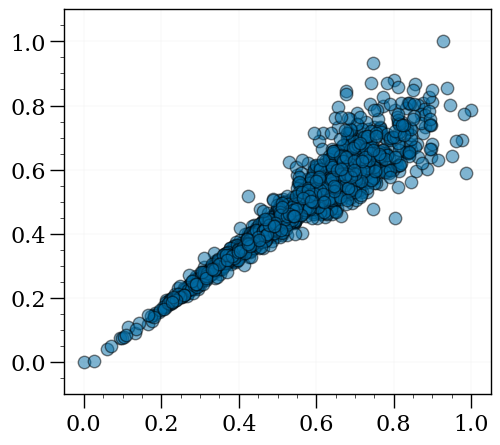

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'clayton_10')

  0%|          | 1/10000 [00:59<165:12:05, 59.48s/it]

Iter 0. Loss [[0.31033158 0.19748946 8.997762  ]]


  0%|          | 11/10000 [01:56<3:59:50,  1.44s/it]

Iter 10. Loss [[0.3111755  0.16781755 1.1907977 ]]


  0%|          | 21/10000 [01:59<1:12:20,  2.30it/s]

Iter 20. Loss [[0.31196132 0.17710961 1.0018026 ]]


  0%|          | 31/10000 [02:03<51:29,  3.23it/s]

Iter 30. Loss [[0.32042298 0.21470146 0.79728675]]


  0%|          | 41/10000 [02:06<50:51,  3.26it/s]

Iter 40. Loss [[0.31533778 0.20732133 0.32151538]]


  1%|          | 51/10000 [02:09<43:39,  3.80it/s]

Iter 50. Loss [[ 0.31428325  0.23571321 -0.10215285]]


  1%|          | 61/10000 [02:12<47:10,  3.51it/s]

Iter 60. Loss [[ 0.31611344  0.25512308 -0.45205107]]


  1%|          | 71/10000 [02:16<1:02:37,  2.64it/s]

Iter 70. Loss [[ 0.31568974  0.29567403 -0.7005108 ]]


  1%|          | 81/10000 [02:19<46:21,  3.57it/s]

Iter 80. Loss [[ 0.3177774   0.29220402 -0.6463651 ]]


  1%|          | 91/10000 [02:21<43:46,  3.77it/s]

Iter 90. Loss [[ 0.31687728  0.27222207 -0.66288894]]


  1%|          | 101/10000 [02:24<45:18,  3.64it/s]

Iter 100. Loss [[ 0.3180854   0.2825252  -0.75331753]]


  1%|          | 111/10000 [02:28<1:05:55,  2.50it/s]

Iter 110. Loss [[ 0.31863698  0.28590754 -0.8184901 ]]


  1%|          | 121/10000 [02:31<45:15,  3.64it/s]

Iter 120. Loss [[ 0.31788155  0.28436562 -0.8392758 ]]


  1%|▏         | 131/10000 [02:34<43:01,  3.82it/s]

Iter 130. Loss [[ 0.32061815  0.24196252 -0.48270768]]


  1%|▏         | 141/10000 [02:37<43:22,  3.79it/s]

Iter 140. Loss [[ 0.31533465  0.2631642  -0.8346823 ]]


  2%|▏         | 151/10000 [02:41<1:21:14,  2.02it/s]

Iter 150. Loss [[ 0.31674954  0.25493893 -0.82468146]]


  2%|▏         | 161/10000 [02:44<46:15,  3.55it/s]

Iter 160. Loss [[ 0.3161164   0.25077355 -0.85816586]]


  2%|▏         | 171/10000 [02:47<56:09,  2.92it/s]

Iter 170. Loss [[ 0.315562    0.23495775 -0.7822477 ]]


  2%|▏         | 181/10000 [02:49<42:12,  3.88it/s]

Iter 180. Loss [[ 0.31291005  0.23488146 -0.8463734 ]]


  2%|▏         | 191/10000 [02:53<59:47,  2.73it/s]

Iter 190. Loss [[ 0.31287104  0.22573665 -0.82114875]]


  2%|▏         | 201/10000 [02:56<52:13,  3.13it/s]

Iter 200. Loss [[ 0.3116985   0.22243302 -0.81064665]]


  2%|▏         | 211/10000 [03:00<48:59,  3.33it/s]

Iter 210. Loss [[ 0.30954424  0.22463657 -0.8056141 ]]


  2%|▏         | 221/10000 [03:02<41:25,  3.93it/s]

Iter 220. Loss [[ 0.30209184  0.1653138  -0.5337526 ]]


  2%|▏         | 231/10000 [03:05<46:26,  3.51it/s]

Iter 230. Loss [[ 0.30352002  0.17672724 -0.5775591 ]]


  2%|▏         | 241/10000 [03:09<1:05:28,  2.48it/s]

Iter 240. Loss [[ 0.3069977   0.20057422 -0.8097724 ]]


  3%|▎         | 251/10000 [03:12<46:14,  3.51it/s]

Iter 250. Loss [[ 0.30546653  0.2500168  -1.0428919 ]]


  3%|▎         | 261/10000 [03:15<43:45,  3.71it/s]

Iter 260. Loss [[ 0.30903018  0.2176688  -0.96292233]]


  3%|▎         | 271/10000 [03:18<44:32,  3.64it/s]

Iter 270. Loss [[ 0.31155983  0.16783018 -0.48629963]]


  3%|▎         | 281/10000 [03:21<1:02:43,  2.58it/s]

Iter 280. Loss [[ 0.30198967  0.17908433 -0.79586846]]


  3%|▎         | 291/10000 [03:25<44:50,  3.61it/s]

Iter 290. Loss [[ 0.30184257  0.19948412 -0.920152  ]]


  3%|▎         | 301/10000 [03:28<1:07:08,  2.41it/s]

Iter 300. Loss [[ 0.30469322  0.17878573 -0.8428164 ]]


  3%|▎         | 311/10000 [03:30<42:56,  3.76it/s]

Iter 310. Loss [[ 0.3041829   0.18650386 -0.91766536]]


  3%|▎         | 321/10000 [03:34<1:14:24,  2.17it/s]

Iter 320. Loss [[ 0.3051951   0.19416109 -0.98434377]]


  3%|▎         | 331/10000 [03:37<46:28,  3.47it/s]

Iter 330. Loss [[ 0.30126956  0.19196838 -1.0027311 ]]


  3%|▎         | 341/10000 [03:40<54:08,  2.97it/s]

Iter 340. Loss [[ 0.29904222  0.1851783  -0.99595565]]


  4%|▎         | 351/10000 [03:43<41:57,  3.83it/s]

Iter 350. Loss [[ 0.2991996   0.17862931 -0.9879752 ]]


  4%|▎         | 361/10000 [03:46<49:35,  3.24it/s]

Iter 360. Loss [[ 0.29761738  0.17259352 -0.9786834 ]]


  4%|▎         | 371/10000 [03:50<59:16,  2.71it/s]  

Iter 370. Loss [[ 0.29597065  0.16428767 -0.96068144]]


  4%|▍         | 381/10000 [03:53<47:51,  3.35it/s]

Iter 380. Loss [[ 0.29505363  0.15531957 -0.9401259 ]]


  4%|▍         | 391/10000 [03:55<42:20,  3.78it/s]

Iter 390. Loss [[ 0.29492176  0.14835699 -0.9332822 ]]


  4%|▍         | 401/10000 [03:59<45:47,  3.49it/s]

Iter 400. Loss [[ 0.2961393   0.14846912 -0.9768846 ]]


  4%|▍         | 411/10000 [04:02<1:03:12,  2.53it/s]

Iter 410. Loss [[ 0.2969881   0.14367908 -0.9722715 ]]


  4%|▍         | 421/10000 [04:05<44:53,  3.56it/s]

Iter 420. Loss [[ 0.29212    0.1388932 -0.9923787]]


  4%|▍         | 431/10000 [04:08<41:47,  3.82it/s]

Iter 430. Loss [[ 0.29483446  0.11576396 -0.93780917]]


  4%|▍         | 441/10000 [04:11<42:28,  3.75it/s]

Iter 440. Loss [[ 0.28611174  0.1511717  -1.0875437 ]]


  5%|▍         | 451/10000 [04:14<58:12,  2.73it/s]

Iter 450. Loss [[ 0.29131338  0.11310165 -1.0798684 ]]


  5%|▍         | 461/10000 [04:18<44:16,  3.59it/s]

Iter 460. Loss [[ 0.28981462  0.11081671 -1.1389841 ]]


  5%|▍         | 471/10000 [04:21<1:06:39,  2.38it/s]

Iter 470. Loss [[ 0.30110383  0.07906701 -1.0549245 ]]


  5%|▍         | 481/10000 [04:24<41:46,  3.80it/s]

Iter 480. Loss [[ 0.2762167   0.17577836 -1.1649891 ]]


  5%|▍         | 491/10000 [04:27<1:09:41,  2.27it/s]

Iter 490. Loss [[ 0.29468077  0.06665363 -1.3004053 ]]


  5%|▌         | 501/10000 [04:31<49:12,  3.22it/s]

Iter 500. Loss [[ 0.3022679   0.08010241 -1.3937076 ]]


  5%|▌         | 511/10000 [04:34<50:49,  3.11it/s]

Iter 510. Loss [[ 0.2903919   0.09270457 -1.43775   ]]


  5%|▌         | 521/10000 [04:36<41:13,  3.83it/s]

Iter 520. Loss [[ 0.30556008  0.07486772 -1.5191902 ]]


  5%|▌         | 531/10000 [04:39<46:27,  3.40it/s]

Iter 530. Loss [[ 0.29464713  0.10359666 -1.66229   ]]


  5%|▌         | 541/10000 [04:43<1:03:54,  2.47it/s]

Iter 540. Loss [[ 0.30003774  0.08139278 -1.7084854 ]]


  6%|▌         | 551/10000 [04:46<46:42,  3.37it/s]

Iter 550. Loss [[ 0.28020984  0.15375859 -1.5098321 ]]


  6%|▌         | 561/10000 [04:49<40:52,  3.85it/s]

Iter 560. Loss [[ 0.29905954  0.11194845 -1.8488929 ]]


  6%|▌         | 571/10000 [04:52<43:33,  3.61it/s]

Iter 570. Loss [[ 0.28609866  0.1287996  -1.6623702 ]]


  6%|▌         | 581/10000 [04:55<1:02:03,  2.53it/s]

Iter 580. Loss [[ 0.29978973  0.11276919 -1.895545  ]]


  6%|▌         | 591/10000 [04:59<44:50,  3.50it/s]

Iter 590. Loss [[ 0.31226152  0.08411153 -1.7187685 ]]


  6%|▌         | 601/10000 [05:02<40:42,  3.85it/s]

Iter 600. Loss [[ 0.28273377  0.17348    -1.5567867 ]]


  6%|▌         | 611/10000 [05:05<41:56,  3.73it/s]

Iter 610. Loss [[ 0.2988887   0.10151461 -1.9306976 ]]


  6%|▌         | 621/10000 [05:08<52:53,  2.96it/s]

Iter 620. Loss [[ 0.29739133  0.1036108  -1.9272858 ]]


  6%|▋         | 631/10000 [05:12<45:29,  3.43it/s]

Iter 630. Loss [[ 0.30201676  0.07061916 -1.8317051 ]]


  6%|▋         | 641/10000 [05:15<1:05:21,  2.39it/s]

Iter 640. Loss [[ 0.3119313   0.06240596 -1.7400918 ]]


  7%|▋         | 651/10000 [05:17<40:58,  3.80it/s]

Iter 650. Loss [[ 0.299731    0.09892008 -1.910929  ]]


  7%|▋         | 661/10000 [05:20<56:36,  2.75it/s]

Iter 660. Loss [[ 0.3102173   0.06392063 -1.9625303 ]]


  7%|▋         | 671/10000 [05:24<51:40,  3.01it/s]

Iter 670. Loss [[ 0.31120345  0.29689345 -1.0350782 ]]


  7%|▋         | 681/10000 [05:27<49:13,  3.16it/s]

Iter 680. Loss [[0.28068072 0.08574007 0.31263292]]


  7%|▋         | 691/10000 [05:30<40:16,  3.85it/s]

Iter 690. Loss [[ 0.31025916  0.20593056 -1.5702529 ]]


  7%|▋         | 701/10000 [05:33<45:30,  3.41it/s]

Iter 700. Loss [[ 0.30257705  0.03664888 -1.0880868 ]]


  7%|▋         | 711/10000 [05:37<1:03:37,  2.43it/s]

Iter 710. Loss [[ 0.31051233  0.11648246 -1.6763817 ]]


  7%|▋         | 721/10000 [05:40<45:18,  3.41it/s]

Iter 720. Loss [[ 0.3057689   0.07566489 -1.606172  ]]


  7%|▋         | 731/10000 [05:42<40:31,  3.81it/s]

Iter 730. Loss [[ 0.30608436  0.06103348 -1.6431543 ]]


  7%|▋         | 741/10000 [05:46<43:23,  3.56it/s]

Iter 740. Loss [[ 0.30434144  0.06753533 -1.692675  ]]


  8%|▊         | 751/10000 [05:49<58:58,  2.61it/s]

Iter 750. Loss [[ 0.3045461   0.05128045 -1.6469265 ]]


  8%|▊         | 761/10000 [05:52<43:47,  3.52it/s]

Iter 760. Loss [[ 0.30613604  0.0593646  -1.7483121 ]]


  8%|▊         | 771/10000 [05:55<39:42,  3.87it/s]

Iter 770. Loss [[ 0.3085004   0.06048284 -1.8116579 ]]


  8%|▊         | 781/10000 [05:58<40:52,  3.76it/s]

Iter 780. Loss [[ 0.3096706   0.06128863 -1.8690494 ]]


  8%|▊         | 791/10000 [06:00<39:26,  3.89it/s]

Iter 790. Loss [[ 0.3114845  0.0630043 -1.8982617]]


  8%|▊         | 801/10000 [06:05<47:01,  3.26it/s]

Iter 800. Loss [[ 0.31153825  0.07035482 -1.9380561 ]]


  8%|▊         | 811/10000 [06:08<55:05,  2.78it/s]  

Iter 810. Loss [[ 0.3146029   0.07071332 -1.9597243 ]]


  8%|▊         | 821/10000 [06:10<39:39,  3.86it/s]

Iter 820. Loss [[ 0.3088432   0.13344519 -1.9326804 ]]


  8%|▊         | 831/10000 [06:13<51:20,  2.98it/s]

Iter 830. Loss [[ 0.3200614  0.5341894 -1.6437708]]


  8%|▊         | 841/10000 [06:17<1:03:46,  2.39it/s]

Iter 840. Loss [[0.2865288  0.32894778 0.3843568 ]]


  9%|▊         | 851/10000 [06:20<48:14,  3.16it/s]

Iter 850. Loss [[ 0.32720685  0.7106316  -0.38177845]]


  9%|▊         | 861/10000 [06:23<39:22,  3.87it/s]

Iter 860. Loss [[ 0.24675964  0.08846498 -0.6596234 ]]


  9%|▊         | 871/10000 [06:26<44:49,  3.39it/s]

Iter 870. Loss [[ 0.26089856  0.09446771 -0.93695265]]


  9%|▉         | 881/10000 [06:29<58:56,  2.58it/s]

Iter 880. Loss [[ 0.29679647  0.07122493 -1.2497829 ]]


  9%|▉         | 891/10000 [06:33<46:31,  3.26it/s]

Iter 890. Loss [[ 0.30909216  0.08387636 -1.3231179 ]]


  9%|▉         | 901/10000 [06:35<38:51,  3.90it/s]

Iter 900. Loss [[ 0.30760163  0.0964632  -1.4415977 ]]


  9%|▉         | 911/10000 [06:39<41:03,  3.69it/s]

Iter 910. Loss [[ 0.3082566   0.08286451 -1.4212321 ]]


  9%|▉         | 921/10000 [06:41<47:16,  3.20it/s]

Iter 920. Loss [[ 0.30840537  0.07733539 -1.4477088 ]]


  9%|▉         | 931/10000 [06:45<45:05,  3.35it/s]

Iter 930. Loss [[ 0.30997807  0.07175449 -1.4739885 ]]


  9%|▉         | 941/10000 [06:48<39:27,  3.83it/s]

Iter 940. Loss [[ 0.31257617  0.07337055 -1.5553461 ]]


 10%|▉         | 951/10000 [06:51<40:00,  3.77it/s]

Iter 950. Loss [[ 0.3176094  0.0776911 -1.664379 ]]


 10%|▉         | 961/10000 [06:54<1:03:39,  2.37it/s]

Iter 960. Loss [[ 0.31985018  0.08104581 -1.7327579 ]]


 10%|▉         | 971/10000 [06:58<53:34,  2.81it/s]

Iter 970. Loss [[ 0.31861717  0.06884756 -1.721129  ]]


 10%|▉         | 981/10000 [07:01<54:59,  2.73it/s]  

Iter 980. Loss [[ 0.31914946  0.07207093 -1.7761647 ]]


 10%|▉         | 991/10000 [07:04<39:45,  3.78it/s]

Iter 990. Loss [[ 0.31902224  0.07534596 -1.8172936 ]]


 10%|█         | 1001/10000 [07:07<50:00,  3.00it/s]

Iter 1000. Loss [[ 0.3187551   0.07872044 -1.8913317 ]]


 10%|█         | 1011/10000 [07:11<1:01:34,  2.43it/s]

Iter 1010. Loss [[ 0.31652674  0.07211509 -1.9271637 ]]


 10%|█         | 1021/10000 [07:14<45:06,  3.32it/s]

Iter 1020. Loss [[ 0.31752193  0.07406065 -1.9592443 ]]


 10%|█         | 1031/10000 [07:17<39:32,  3.78it/s]

Iter 1030. Loss [[ 0.3190386  0.0781582 -2.0041347]]


 10%|█         | 1041/10000 [07:20<43:01,  3.47it/s]

Iter 1040. Loss [[ 0.31971386  0.07952382 -2.0312793 ]]


 11%|█         | 1051/10000 [07:23<56:31,  2.64it/s]

Iter 1050. Loss [[ 0.3207194  0.0831373 -2.0668645]]


 11%|█         | 1061/10000 [07:27<44:24,  3.35it/s]

Iter 1060. Loss [[ 0.32108796  0.08422334 -2.0834775 ]]


 11%|█         | 1071/10000 [07:29<38:27,  3.87it/s]

Iter 1070. Loss [[ 0.3216186   0.08548007 -2.101791  ]]


 11%|█         | 1081/10000 [07:32<40:06,  3.71it/s]

Iter 1080. Loss [[ 0.32212788  0.08617804 -2.113717  ]]


 11%|█         | 1091/10000 [07:35<41:46,  3.55it/s]

Iter 1090. Loss [[ 0.322573    0.08639938 -2.1216908 ]]


 11%|█         | 1101/10000 [07:39<45:39,  3.25it/s]

Iter 1100. Loss [[ 0.32292923  0.08644773 -2.1324947 ]]


 11%|█         | 1111/10000 [07:42<39:02,  3.79it/s]

Iter 1110. Loss [[ 0.3233382   0.08638811 -2.1416981 ]]


 11%|█         | 1121/10000 [07:45<39:10,  3.78it/s]

Iter 1120. Loss [[ 0.3236455   0.08633222 -2.1504073 ]]


 11%|█▏        | 1131/10000 [07:48<1:01:43,  2.39it/s]

Iter 1130. Loss [[ 0.32396603  0.08596056 -2.154394  ]]


 11%|█▏        | 1141/10000 [07:52<56:36,  2.61it/s]  

Iter 1140. Loss [[ 0.32400173  0.08672828 -2.1651564 ]]


 12%|█▏        | 1151/10000 [07:55<54:14,  2.72it/s]  

Iter 1150. Loss [[ 0.3242297   0.08630839 -2.1675937 ]]


 12%|█▏        | 1161/10000 [07:57<37:57,  3.88it/s]

Iter 1160. Loss [[ 0.32464397  0.08508012 -2.1656966 ]]


 12%|█▏        | 1171/10000 [08:00<46:21,  3.17it/s]

Iter 1170. Loss [[ 0.32072762  0.12208115 -2.0821571 ]]


 12%|█▏        | 1181/10000 [08:04<59:05,  2.49it/s]

Iter 1180. Loss [[ 0.32533076  0.07934473 -2.1249566 ]]


 12%|█▏        | 1191/10000 [08:07<45:30,  3.23it/s]

Iter 1190. Loss [[ 0.33012223  0.32079983 -1.5127482 ]]


 12%|█▏        | 1201/10000 [08:10<38:33,  3.80it/s]

Iter 1200. Loss [[ 0.32372472  0.11396854 -2.0333126 ]]


 12%|█▏        | 1211/10000 [08:13<42:10,  3.47it/s]

Iter 1210. Loss [[ 0.31753367  0.06777469 -1.8391331 ]]


 12%|█▏        | 1221/10000 [08:16<53:34,  2.73it/s]

Iter 1220. Loss [[ 0.32078108  0.08534268 -2.01605   ]]


 12%|█▏        | 1231/10000 [08:20<44:07,  3.31it/s]

Iter 1230. Loss [[ 0.32180732  0.07255483 -2.0038197 ]]


 12%|█▏        | 1241/10000 [08:23<37:52,  3.85it/s]

Iter 1240. Loss [[ 0.32402217  0.07706946 -2.0591977 ]]


 13%|█▎        | 1251/10000 [08:26<39:24,  3.70it/s]

Iter 1250. Loss [[0.28354454 0.32397023 2.2618287 ]]


 13%|█▎        | 1261/10000 [08:28<38:12,  3.81it/s]

Iter 1260. Loss [[ 0.32313266  0.21608286 -0.04227468]]


 13%|█▎        | 1271/10000 [08:33<49:36,  2.93it/s]

Iter 1270. Loss [[ 0.31093675  0.10846049 -1.6694108 ]]


 13%|█▎        | 1281/10000 [08:36<1:00:52,  2.39it/s]

Iter 1280. Loss [[ 0.31238052  0.07321889 -1.8001931 ]]


 13%|█▎        | 1291/10000 [08:38<38:27,  3.77it/s]

Iter 1290. Loss [[ 0.32216156  0.1218802  -1.5013833 ]]


 13%|█▎        | 1301/10000 [08:41<53:44,  2.70it/s]  

Iter 1300. Loss [[ 0.31345284  0.08864201 -1.824708  ]]


 13%|█▎        | 1311/10000 [08:45<59:13,  2.45it/s]

Iter 1310. Loss [[ 0.3185639   0.08672362 -1.9316803 ]]


 13%|█▎        | 1321/10000 [08:48<49:07,  2.94it/s]

Iter 1320. Loss [[ 0.322403    0.06490102 -1.8759627 ]]


 13%|█▎        | 1331/10000 [08:51<37:11,  3.88it/s]

Iter 1330. Loss [[ 0.32378924  0.07275683 -1.9673561 ]]


 13%|█▎        | 1341/10000 [08:54<44:56,  3.21it/s]

Iter 1340. Loss [[ 0.32399136  0.07290622 -1.9981667 ]]


 14%|█▎        | 1351/10000 [08:57<55:35,  2.59it/s]

Iter 1350. Loss [[ 0.324525    0.07692548 -2.0534828 ]]


 14%|█▎        | 1361/10000 [09:01<45:53,  3.14it/s]

Iter 1360. Loss [[ 0.32422617  0.09227285 -2.0722668 ]]


 14%|█▎        | 1371/10000 [09:04<37:17,  3.86it/s]

Iter 1370. Loss [[ 0.3274475   0.07944398 -1.8930143 ]]


 14%|█▍        | 1381/10000 [09:07<41:02,  3.50it/s]

Iter 1380. Loss [[ 0.32903534  0.1780727  -1.8955973 ]]


 14%|█▍        | 1391/10000 [09:09<43:53,  3.27it/s]

Iter 1390. Loss [[0.33962667 0.9908797  5.370253  ]]


 14%|█▍        | 1401/10000 [09:14<44:31,  3.22it/s]

Iter 1400. Loss [[ 0.32170135  0.49673384 -0.67554635]]


 14%|█▍        | 1411/10000 [09:16<37:01,  3.87it/s]

Iter 1410. Loss [[ 0.2990985  0.0609329 -1.4379563]]


 14%|█▍        | 1421/10000 [09:19<39:35,  3.61it/s]

Iter 1420. Loss [[ 0.31095967  0.06832335 -1.545564  ]]


 14%|█▍        | 1431/10000 [09:22<37:37,  3.80it/s]

Iter 1430. Loss [[ 0.3139156  0.0745775 -1.4963585]]


 14%|█▍        | 1441/10000 [09:26<51:14,  2.78it/s]

Iter 1440. Loss [[ 0.31445754  0.06935378 -1.50397   ]]


 15%|█▍        | 1451/10000 [09:29<58:56,  2.42it/s]

Iter 1450. Loss [[ 0.31493434  0.06857447 -1.6062018 ]]


 15%|█▍        | 1461/10000 [09:32<37:43,  3.77it/s]

Iter 1460. Loss [[ 0.32193252  0.09958008 -1.3193798 ]]


 15%|█▍        | 1471/10000 [09:35<52:48,  2.69it/s]

Iter 1470. Loss [[ 0.31696612  0.05776263 -1.6453322 ]]


 15%|█▍        | 1481/10000 [09:39<59:59,  2.37it/s]

Iter 1480. Loss [[ 0.316216    0.07696027 -1.7686055 ]]


 15%|█▍        | 1491/10000 [09:42<48:44,  2.91it/s]

Iter 1490. Loss [[ 0.32165155  0.07419409 -1.8351092 ]]


 15%|█▌        | 1501/10000 [09:45<36:58,  3.83it/s]

Iter 1500. Loss [[ 0.32242203  0.07258529 -1.8695471 ]]


 15%|█▌        | 1511/10000 [09:48<44:24,  3.19it/s]

Iter 1510. Loss [[ 0.32245693  0.07005369 -1.8924726 ]]


 15%|█▌        | 1521/10000 [09:51<53:16,  2.65it/s]

Iter 1520. Loss [[ 0.32325795  0.07153251 -1.9394157 ]]


 15%|█▌        | 1531/10000 [09:55<45:16,  3.12it/s]

Iter 1530. Loss [[ 0.3233051   0.06812601 -1.9596767 ]]


 15%|█▌        | 1541/10000 [09:57<36:45,  3.84it/s]

Iter 1540. Loss [[ 0.32454672  0.0727274  -2.0082493 ]]


 16%|█▌        | 1551/10000 [10:00<39:37,  3.55it/s]

Iter 1550. Loss [[ 0.3257275   0.07394519 -2.048756  ]]


 16%|█▌        | 1561/10000 [10:03<38:05,  3.69it/s]

Iter 1560. Loss [[ 0.32687855  0.07738686 -2.088087  ]]


 16%|█▌        | 1571/10000 [10:07<43:36,  3.22it/s]

Iter 1570. Loss [[ 0.32754698  0.07840672 -2.112091  ]]


 16%|█▌        | 1581/10000 [10:10<36:46,  3.82it/s]

Iter 1580. Loss [[ 0.32833996  0.08024839 -2.1363025 ]]


 16%|█▌        | 1591/10000 [10:13<38:18,  3.66it/s]

Iter 1590. Loss [[ 0.32880569  0.07971054 -2.1437373 ]]


 16%|█▌        | 1601/10000 [10:16<36:00,  3.89it/s]

Iter 1600. Loss [[ 0.32935172  0.08011134 -2.159718  ]]


 16%|█▌        | 1611/10000 [10:20<53:27,  2.62it/s]

Iter 1610. Loss [[ 0.32991064  0.08067679 -2.1757982 ]]


 16%|█▌        | 1621/10000 [10:23<58:42,  2.38it/s]

Iter 1620. Loss [[ 0.3305185   0.08046201 -2.1888072 ]]


 16%|█▋        | 1631/10000 [10:26<36:36,  3.81it/s]

Iter 1630. Loss [[ 0.3312747  0.080173  -2.2025476]]


 16%|█▋        | 1641/10000 [10:29<51:05,  2.73it/s]

Iter 1640. Loss [[ 0.332463    0.07992132 -2.222219  ]]


 17%|█▋        | 1651/10000 [10:32<56:45,  2.45it/s]

Iter 1650. Loss [[ 0.3346339   0.08127778 -2.2663734 ]]


 17%|█▋        | 1661/10000 [10:36<48:54,  2.84it/s]

Iter 1660. Loss [[ 0.33500984  0.07688752 -2.2645419 ]]


 17%|█▋        | 1671/10000 [10:38<36:33,  3.80it/s]

Iter 1670. Loss [[ 0.3355218   0.07613277 -2.2740116 ]]


 17%|█▋        | 1681/10000 [10:41<43:46,  3.17it/s]

Iter 1680. Loss [[ 0.33596125  0.07532994 -2.2808974 ]]


 17%|█▋        | 1691/10000 [10:45<51:27,  2.69it/s]

Iter 1690. Loss [[ 0.3363865   0.07396668 -2.2858534 ]]


 17%|█▋        | 1701/10000 [10:48<43:27,  3.18it/s]

Iter 1700. Loss [[ 0.3368092   0.07285532 -2.2924457 ]]


 17%|█▋        | 1711/10000 [10:51<36:38,  3.77it/s]

Iter 1710. Loss [[ 0.3372883   0.07182299 -2.2988472 ]]


 17%|█▋        | 1721/10000 [10:54<38:35,  3.58it/s]

Iter 1720. Loss [[ 0.33781946  0.07053468 -2.3033688 ]]


 17%|█▋        | 1731/10000 [10:57<36:23,  3.79it/s]

Iter 1730. Loss [[ 0.33807382  0.07040091 -2.3001764 ]]


 17%|█▋        | 1741/10000 [11:01<43:58,  3.13it/s]

Iter 1740. Loss [[ 0.33656475  0.08696318 -2.2200842 ]]


 18%|█▊        | 1751/10000 [11:04<35:31,  3.87it/s]

Iter 1750. Loss [[ 0.3355214  0.2924708 -1.5500795]]


 18%|█▊        | 1761/10000 [11:07<37:27,  3.67it/s]

Iter 1760. Loss [[ 0.3213692   0.03856736 -1.7067826 ]]


 18%|█▊        | 1771/10000 [11:09<35:32,  3.86it/s]

Iter 1770. Loss [[ 0.33091074  0.1294828  -1.893136  ]]


 18%|█▊        | 1781/10000 [11:14<52:39,  2.60it/s]

Iter 1780. Loss [[ 0.33429402  0.05832805 -2.0286307 ]]


 18%|█▊        | 1791/10000 [11:17<1:01:29,  2.23it/s]

Iter 1790. Loss [[ 0.33748996  0.05900226 -2.1258502 ]]


 18%|█▊        | 1801/10000 [11:20<36:18,  3.76it/s]

Iter 1800. Loss [[ 0.33911684  0.06791173 -2.1617408 ]]


 18%|█▊        | 1811/10000 [11:23<50:17,  2.71it/s]

Iter 1810. Loss [[ 0.33951822  0.06719906 -2.17684   ]]


 18%|█▊        | 1821/10000 [11:26<55:26,  2.46it/s]

Iter 1820. Loss [[ 0.33954626  0.06508526 -2.2017999 ]]


 18%|█▊        | 1831/10000 [11:30<47:31,  2.86it/s]

Iter 1830. Loss [[ 0.33990166  0.06412158 -2.1960278 ]]


 18%|█▊        | 1841/10000 [11:32<36:05,  3.77it/s]

Iter 1840. Loss [[ 0.33966783  0.06542527 -2.2283056 ]]


 19%|█▊        | 1851/10000 [11:35<41:36,  3.26it/s]

Iter 1850. Loss [[ 0.34033012  0.06431362 -2.231665  ]]


 19%|█▊        | 1861/10000 [11:39<50:46,  2.67it/s]

Iter 1860. Loss [[ 0.34034613  0.06504674 -2.2481976 ]]


 19%|█▊        | 1871/10000 [11:42<41:25,  3.27it/s]

Iter 1870. Loss [[ 0.34136996  0.06459522 -2.2667875 ]]


 19%|█▉        | 1881/10000 [11:45<35:22,  3.82it/s]

Iter 1880. Loss [[ 0.36162317 10.962623   17.969946  ]]


 19%|█▉        | 1891/10000 [11:48<38:00,  3.56it/s]

Iter 1890. Loss [[ 0.3608518  8.142976  17.747282 ]]


 19%|█▉        | 1901/10000 [11:51<37:46,  3.57it/s]

Iter 1900. Loss [[ 0.3568051  3.8295608 16.234135 ]]


 19%|█▉        | 1911/10000 [11:55<42:08,  3.20it/s]

Iter 1910. Loss [[0.32856917 0.6700546  5.561828  ]]


 19%|█▉        | 1921/10000 [11:58<35:22,  3.81it/s]

Iter 1920. Loss [[0.16862094 0.26298583 4.2566185 ]]


 19%|█▉        | 1931/10000 [12:01<36:15,  3.71it/s]

Iter 1930. Loss [[0.248107   0.13143115 3.4361205 ]]


 19%|█▉        | 1941/10000 [12:03<35:22,  3.80it/s]

Iter 1940. Loss [[0.1848135  0.13219005 1.4986198 ]]


 20%|█▉        | 1951/10000 [12:08<49:52,  2.69it/s]

Iter 1950. Loss [[0.22420101 0.10851584 1.1156132 ]]


 20%|█▉        | 1961/10000 [12:11<50:32,  2.65it/s]

Iter 1960. Loss [[0.24546026 0.10577872 1.008622  ]]


 20%|█▉        | 1971/10000 [12:13<35:22,  3.78it/s]

Iter 1970. Loss [[0.25117198 0.09760629 0.82925993]]


 20%|█▉        | 1981/10000 [12:17<44:59,  2.97it/s]

Iter 1980. Loss [[0.25979963 0.09049716 0.6017005 ]]


 20%|█▉        | 1991/10000 [12:20<54:58,  2.43it/s]

Iter 1990. Loss [[0.2708077  0.08445168 0.34343326]]


 20%|██        | 2001/10000 [12:24<43:10,  3.09it/s]

Iter 2000. Loss [[0.27992707 0.07767586 0.05736535]]


 20%|██        | 2011/10000 [12:26<35:06,  3.79it/s]

Iter 2010. Loss [[ 0.290077    0.07897142 -0.26174954]]


 20%|██        | 2021/10000 [12:29<40:10,  3.31it/s]

Iter 2020. Loss [[ 0.29749912  0.0866465  -0.56856   ]]


 20%|██        | 2031/10000 [12:33<49:26,  2.69it/s]

Iter 2030. Loss [[ 0.30380613  0.10324644 -0.8566862 ]]


 20%|██        | 2041/10000 [12:36<41:27,  3.20it/s]

Iter 2040. Loss [[ 0.30214435  0.09509666 -0.6172289 ]]


 21%|██        | 2051/10000 [12:39<34:34,  3.83it/s]

Iter 2050. Loss [[ 0.3123764   0.19371188 -0.18297136]]


 21%|██        | 2061/10000 [12:42<35:58,  3.68it/s]

Iter 2060. Loss [[ 0.301025    0.0933491  -0.53312075]]


 21%|██        | 2071/10000 [12:45<38:05,  3.47it/s]

Iter 2070. Loss [[ 0.30061144  0.09214583 -0.60166997]]


 21%|██        | 2081/10000 [12:49<40:47,  3.24it/s]

Iter 2080. Loss [[ 0.30575618  0.11279539 -0.9181986 ]]


 21%|██        | 2091/10000 [12:52<35:12,  3.74it/s]

Iter 2090. Loss [[ 0.3089845  0.125544  -1.0478139]]


 21%|██        | 2101/10000 [12:55<35:08,  3.75it/s]

Iter 2100. Loss [[ 0.31177402  0.14074622 -1.0546112 ]]


 21%|██        | 2111/10000 [12:58<56:05,  2.34it/s]

Iter 2110. Loss [[ 0.30870494  0.12756656 -1.0408621 ]]


 21%|██        | 2121/10000 [13:02<49:27,  2.66it/s]

Iter 2120. Loss [[ 0.30605695  0.11451391 -0.9537516 ]]


 21%|██▏       | 2131/10000 [13:05<48:50,  2.68it/s]

Iter 2130. Loss [[ 0.30749682  0.11984739 -1.0121553 ]]


 21%|██▏       | 2141/10000 [13:07<34:49,  3.76it/s]

Iter 2140. Loss [[ 0.30883917  0.12636755 -1.0349207 ]]


 22%|██▏       | 2151/10000 [13:11<44:23,  2.95it/s]

Iter 2150. Loss [[ 0.30857795  0.12574008 -0.94923866]]


 22%|██▏       | 2161/10000 [13:14<53:29,  2.44it/s]

Iter 2160. Loss [[ 0.3073648   0.10430014 -0.71485007]]


 22%|██▏       | 2171/10000 [13:18<42:19,  3.08it/s]

Iter 2170. Loss [[ 0.30924097  0.10980456 -0.72449243]]


 22%|██▏       | 2181/10000 [13:20<33:43,  3.86it/s]

Iter 2180. Loss [[ 0.31097117  0.12638554 -0.93785536]]


 22%|██▏       | 2191/10000 [13:23<38:27,  3.38it/s]

Iter 2190. Loss [[ 0.31143072  0.12870987 -0.99485976]]


 22%|██▏       | 2201/10000 [13:26<48:04,  2.70it/s]

Iter 2200. Loss [[ 0.31123903  0.12132626 -0.982069  ]]


 22%|██▏       | 2211/10000 [13:30<40:00,  3.24it/s]

Iter 2210. Loss [[ 0.31120223  0.11381016 -0.9614831 ]]


 22%|██▏       | 2221/10000 [13:33<33:50,  3.83it/s]

Iter 2220. Loss [[ 0.31143084  0.11147983 -0.967681  ]]


 22%|██▏       | 2231/10000 [13:36<35:56,  3.60it/s]

Iter 2230. Loss [[ 0.3115582   0.11166254 -0.97818345]]


 22%|██▏       | 2241/10000 [13:39<33:45,  3.83it/s]

Iter 2240. Loss [[ 0.31162933  0.11145724 -1.0050212 ]]


 23%|██▎       | 2251/10000 [13:43<40:43,  3.17it/s]

Iter 2250. Loss [[ 0.31165305  0.11002291 -1.0372105 ]]


 23%|██▎       | 2261/10000 [13:45<33:42,  3.83it/s]

Iter 2260. Loss [[ 0.31173617  0.10819139 -1.0548568 ]]


 23%|██▎       | 2271/10000 [13:49<34:28,  3.74it/s]

Iter 2270. Loss [[ 0.31212655  0.10243487 -1.0231229 ]]


 23%|██▎       | 2281/10000 [13:52<54:50,  2.35it/s]

Iter 2280. Loss [[ 0.3127724   0.10663739 -1.0932003 ]]


 23%|██▎       | 2291/10000 [13:56<50:43,  2.53it/s]

Iter 2290. Loss [[ 0.3128651   0.10891557 -1.1323024 ]]


 23%|██▎       | 2301/10000 [13:59<48:15,  2.66it/s]

Iter 2300. Loss [[ 0.3127557   0.10698091 -1.1376847 ]]


 23%|██▎       | 2311/10000 [14:01<33:50,  3.79it/s]

Iter 2310. Loss [[ 0.31291562  0.10483414 -1.1392803 ]]


 23%|██▎       | 2321/10000 [14:05<40:58,  3.12it/s]

Iter 2320. Loss [[ 0.31317726  0.10359911 -1.1617848 ]]


 23%|██▎       | 2331/10000 [14:08<52:39,  2.43it/s]

Iter 2330. Loss [[ 0.31328726  0.10256636 -1.1822248 ]]


 23%|██▎       | 2341/10000 [14:12<39:33,  3.23it/s]

Iter 2340. Loss [[ 0.31344962  0.10174945 -1.2144156 ]]


 24%|██▎       | 2351/10000 [14:14<33:33,  3.80it/s]

Iter 2350. Loss [[ 0.31351483  0.10051085 -1.2325761 ]]


 24%|██▎       | 2361/10000 [14:17<36:27,  3.49it/s]

Iter 2360. Loss [[ 0.31364176  0.09948751 -1.2542974 ]]


 24%|██▎       | 2371/10000 [14:20<48:01,  2.65it/s]

Iter 2370. Loss [[ 0.31370816  0.09817763 -1.2708946 ]]


 24%|██▍       | 2381/10000 [14:24<38:05,  3.33it/s]

Iter 2380. Loss [[ 0.31384626  0.09704651 -1.2794563 ]]


 24%|██▍       | 2391/10000 [14:27<33:26,  3.79it/s]

Iter 2390. Loss [[ 0.31419963  0.09626257 -1.3061136 ]]


 24%|██▍       | 2401/10000 [14:30<35:26,  3.57it/s]

Iter 2400. Loss [[ 0.31451946  0.09460051 -1.3400851 ]]


 24%|██▍       | 2411/10000 [14:33<36:05,  3.51it/s]

Iter 2410. Loss [[ 0.3146904  0.0918402 -1.3648534]]


 24%|██▍       | 2421/10000 [14:37<39:20,  3.21it/s]

Iter 2420. Loss [[ 0.31491038  0.08931805 -1.3818983 ]]


 24%|██▍       | 2431/10000 [14:40<52:41,  2.39it/s]

Iter 2430. Loss [[ 0.31531525  0.08766644 -1.4119228 ]]


 24%|██▍       | 2441/10000 [14:43<32:57,  3.82it/s]

Iter 2440. Loss [[ 0.31579584  0.08587012 -1.4442304 ]]


 25%|██▍       | 2451/10000 [14:46<45:46,  2.75it/s]

Iter 2450. Loss [[ 0.31627604  0.08358731 -1.4690742 ]]


 25%|██▍       | 2461/10000 [14:50<51:45,  2.43it/s]

Iter 2460. Loss [[ 0.31682178  0.08120183 -1.492822  ]]


 25%|██▍       | 2471/10000 [14:53<43:17,  2.90it/s]

Iter 2470. Loss [[ 0.31742302  0.07922588 -1.5226959 ]]


 25%|██▍       | 2481/10000 [14:55<33:00,  3.80it/s]

Iter 2480. Loss [[ 0.31744736  0.0799899  -1.535412  ]]


 25%|██▍       | 2491/10000 [14:58<38:43,  3.23it/s]

Iter 2490. Loss [[ 0.31823602  0.06513587 -1.5188239 ]]


 25%|██▌       | 2501/10000 [15:02<49:20,  2.53it/s]

Iter 2500. Loss [[ 0.31875762  0.06909325 -1.6190268 ]]


 25%|██▌       | 2511/10000 [15:05<39:46,  3.14it/s]

Iter 2510. Loss [[ 0.31951225  0.06765982 -1.6589713 ]]


 25%|██▌       | 2521/10000 [15:08<32:08,  3.88it/s]

Iter 2520. Loss [[ 0.32054502  0.0673473  -1.7097435 ]]


 25%|██▌       | 2531/10000 [15:11<34:46,  3.58it/s]

Iter 2530. Loss [[ 0.3213037   0.06608481 -1.7187444 ]]


 25%|██▌       | 2541/10000 [15:14<44:03,  2.82it/s]

Iter 2540. Loss [[ 0.32091716  0.07343771 -1.8059698 ]]


 26%|██▌       | 2551/10000 [15:18<40:09,  3.09it/s]

Iter 2550. Loss [[ 0.32219413  0.07532239 -1.8169134 ]]


 26%|██▌       | 2561/10000 [15:21<32:09,  3.85it/s]

Iter 2560. Loss [[ 0.32174084  0.06938645 -1.7838318 ]]


 26%|██▌       | 2571/10000 [15:24<33:06,  3.74it/s]

Iter 2570. Loss [[ 0.32257625  0.06898586 -1.8115653 ]]


 26%|██▌       | 2581/10000 [15:26<32:08,  3.85it/s]

Iter 2580. Loss [[ 0.32442275  0.06896392 -1.7432106 ]]


 26%|██▌       | 2591/10000 [15:31<38:23,  3.22it/s]

Iter 2590. Loss [[ 0.32386318  0.06691257 -1.8222511 ]]


 26%|██▌       | 2601/10000 [15:34<51:36,  2.39it/s]

Iter 2600. Loss [[ 0.32315624  0.07043397 -1.8653685 ]]


 26%|██▌       | 2611/10000 [15:36<33:08,  3.72it/s]

Iter 2610. Loss [[ 0.3230247   0.07190418 -1.8804314 ]]


 26%|██▌       | 2621/10000 [15:39<45:01,  2.73it/s]

Iter 2620. Loss [[ 0.3242199   0.06984416 -1.8949221 ]]


 26%|██▋       | 2631/10000 [15:43<51:45,  2.37it/s]

Iter 2630. Loss [[ 0.3256674   0.06880914 -1.8852272 ]]


 26%|██▋       | 2641/10000 [15:46<41:40,  2.94it/s]

Iter 2640. Loss [[ 0.32394105  0.08553752 -1.937596  ]]


 27%|██▋       | 2651/10000 [15:49<32:06,  3.81it/s]

Iter 2650. Loss [[ 0.32564712  0.07067081 -1.9384147 ]]


 27%|██▋       | 2661/10000 [15:52<38:24,  3.18it/s]

Iter 2660. Loss [[ 0.32450345  0.08970554 -1.968918  ]]


 27%|██▋       | 2671/10000 [15:56<49:31,  2.47it/s]

Iter 2670. Loss [[ 0.32793683  0.08042658 -1.8572874 ]]


 27%|██▋       | 2681/10000 [15:59<35:53,  3.40it/s]

Iter 2680. Loss [[ 0.3269066   0.07194863 -1.9427526 ]]


 27%|██▋       | 2691/10000 [16:02<31:54,  3.82it/s]

Iter 2690. Loss [[ 0.3274592   0.07483122 -1.961821  ]]


 27%|██▋       | 2701/10000 [16:05<33:20,  3.65it/s]

Iter 2700. Loss [[ 0.32672533  0.07688265 -2.0059242 ]]


 27%|██▋       | 2711/10000 [16:08<41:01,  2.96it/s]

Iter 2710. Loss [[ 0.32651016  0.0809038  -2.026159  ]]


 27%|██▋       | 2721/10000 [16:12<35:41,  3.40it/s]

Iter 2720. Loss [[ 0.32467148  0.11287618 -1.9122101 ]]


 27%|██▋       | 2731/10000 [16:14<31:03,  3.90it/s]

Iter 2730. Loss [[ 0.32682756  0.07878051 -2.0298913 ]]


 27%|██▋       | 2741/10000 [16:17<32:16,  3.75it/s]

Iter 2740. Loss [[ 0.3287904   0.08090937 -1.9591188 ]]


 28%|██▊       | 2751/10000 [16:20<31:06,  3.88it/s]

Iter 2750. Loss [[ 0.32613277  0.09511817 -2.0076735 ]]


 28%|██▊       | 2761/10000 [16:24<41:49,  2.88it/s]

Iter 2760. Loss [[ 0.32593602  0.10507403 -1.9542402 ]]


 28%|██▊       | 2771/10000 [16:27<49:48,  2.42it/s]

Iter 2770. Loss [[ 0.3268654   0.13607888 -1.7346057 ]]


 28%|██▊       | 2781/10000 [16:30<31:14,  3.85it/s]

Iter 2780. Loss [[ 0.325899    0.09975118 -1.8975781 ]]


 28%|██▊       | 2791/10000 [16:33<40:23,  2.97it/s]

Iter 2790. Loss [[ 0.32809114  0.07427477 -1.8640004 ]]


 28%|██▊       | 2801/10000 [16:36<48:47,  2.46it/s]

Iter 2800. Loss [[ 0.32542244  0.09449815 -1.8509336 ]]


 28%|██▊       | 2811/10000 [16:40<38:16,  3.13it/s]

Iter 2810. Loss [[ 0.32574502  0.09731317 -1.9363488 ]]


 28%|██▊       | 2821/10000 [16:42<31:04,  3.85it/s]

Iter 2820. Loss [[ 0.3225884   0.17171669 -0.7771068 ]]


 28%|██▊       | 2831/10000 [16:45<36:32,  3.27it/s]

Iter 2830. Loss [[ 0.32970247  0.1237127  -1.9866997 ]]


 28%|██▊       | 2841/10000 [16:49<45:54,  2.60it/s]

Iter 2840. Loss [[ 0.32616454  0.08506502 -1.7694203 ]]


 29%|██▊       | 2851/10000 [16:53<37:07,  3.21it/s]

Iter 2850. Loss [[ 0.32447782  0.07362726 -1.8074489 ]]


 29%|██▊       | 2861/10000 [16:55<31:54,  3.73it/s]

Iter 2860. Loss [[ 0.32475406  0.0701088  -1.941875  ]]


 29%|██▊       | 2871/10000 [16:58<33:36,  3.53it/s]

Iter 2870. Loss [[ 0.32573053  0.07108614 -1.9954609 ]]


 29%|██▉       | 2881/10000 [17:01<38:57,  3.05it/s]

Iter 2880. Loss [[ 0.32634944  0.07636295 -2.0516703 ]]


 29%|██▉       | 2891/10000 [17:05<35:58,  3.29it/s]

Iter 2890. Loss [[ 0.32686147  0.07881635 -2.0921338 ]]


 29%|██▉       | 2901/10000 [17:08<32:04,  3.69it/s]

Iter 2900. Loss [[ 0.32707852  0.09015283 -2.187926  ]]


 29%|██▉       | 2911/10000 [17:11<32:09,  3.67it/s]

Iter 2910. Loss [[ 0.32791767  0.1015142  -2.232206  ]]


 29%|██▉       | 2921/10000 [17:14<54:30,  2.16it/s]

Iter 2920. Loss [[ 0.32839975  0.10477889 -2.2473745 ]]


 29%|██▉       | 2931/10000 [17:18<38:53,  3.03it/s]

Iter 2930. Loss [[ 0.32825455  0.10442556 -2.2517302 ]]


 29%|██▉       | 2941/10000 [17:21<45:34,  2.58it/s]

Iter 2940. Loss [[ 0.32797363  0.10813171 -2.116318  ]]


 30%|██▉       | 2951/10000 [17:24<31:56,  3.68it/s]

Iter 2950. Loss [[ 0.32886645  0.07313319 -1.9370615 ]]


 30%|██▉       | 2961/10000 [17:27<41:27,  2.83it/s]

Iter 2960. Loss [[ 0.3290171   0.07148502 -1.95093   ]]


 30%|██▉       | 2971/10000 [17:31<44:10,  2.65it/s]

Iter 2970. Loss [[ 0.32896513  0.07404958 -1.9052467 ]]


 30%|██▉       | 2981/10000 [17:35<38:03,  3.07it/s]

Iter 2980. Loss [[ 0.328538    0.08136187 -2.1006303 ]]


 30%|██▉       | 2991/10000 [17:37<30:31,  3.83it/s]

Iter 2990. Loss [[ 0.3293353   0.06922163 -1.8556371 ]]


 30%|███       | 3001/10000 [17:40<35:03,  3.33it/s]

Iter 3000. Loss [[ 0.32758015  0.0808609  -1.9843024 ]]


 30%|███       | 3011/10000 [17:44<46:07,  2.53it/s]

Iter 3010. Loss [[ 0.32800922  0.07796653 -2.0094457 ]]


 30%|███       | 3021/10000 [17:47<33:13,  3.50it/s]

Iter 3020. Loss [[ 0.3282883   0.07667325 -2.0088432 ]]


 30%|███       | 3031/10000 [17:50<31:04,  3.74it/s]

Iter 3030. Loss [[ 0.33328214  0.19117977 -1.9136884 ]]


 30%|███       | 3041/10000 [17:53<31:46,  3.65it/s]

Iter 3040. Loss [[ 0.3229839   0.12289245 -1.3226124 ]]


 31%|███       | 3051/10000 [17:56<42:53,  2.70it/s]

Iter 3050. Loss [[0.2526366  0.11761686 1.409757  ]]


 31%|███       | 3061/10000 [18:00<32:57,  3.51it/s]

Iter 3060. Loss [[ 0.3266456   0.13493201 -0.5143782 ]]


 31%|███       | 3071/10000 [18:02<30:38,  3.77it/s]

Iter 3070. Loss [[ 0.32986745  0.24116023 -1.2953256 ]]


 31%|███       | 3081/10000 [18:06<31:29,  3.66it/s]

Iter 3080. Loss [[ 0.32395673  0.09081224 -1.2439207 ]]


 31%|███       | 3091/10000 [18:09<52:49,  2.18it/s]

Iter 3090. Loss [[ 0.32346582  0.05302745 -1.620831  ]]


 31%|███       | 3101/10000 [18:13<35:22,  3.25it/s]

Iter 3100. Loss [[ 0.32436106  0.05995893 -1.5613714 ]]


 31%|███       | 3111/10000 [18:16<39:12,  2.93it/s]

Iter 3110. Loss [[ 0.3224472   0.10665371 -1.5048847 ]]


 31%|███       | 3121/10000 [18:18<31:10,  3.68it/s]

Iter 3120. Loss [[ 0.33029345  0.1352267  -1.6380517 ]]


 31%|███▏      | 3131/10000 [18:22<37:12,  3.08it/s]

Iter 3130. Loss [[ 0.3260921   0.06497351 -1.7875575 ]]


 31%|███▏      | 3141/10000 [18:26<40:06,  2.85it/s]

Iter 3140. Loss [[ 0.3245967   0.06168887 -1.8101321 ]]


 32%|███▏      | 3151/10000 [18:29<34:41,  3.29it/s]

Iter 3150. Loss [[ 0.32585746  0.06897929 -1.8803365 ]]


 32%|███▏      | 3161/10000 [18:31<29:51,  3.82it/s]

Iter 3160. Loss [[ 0.32709122  0.06443495 -1.8958238 ]]


 32%|███▏      | 3171/10000 [18:34<33:15,  3.42it/s]

Iter 3170. Loss [[ 0.32737955  0.06217401 -1.896402  ]]


 32%|███▏      | 3181/10000 [18:38<47:16,  2.40it/s]

Iter 3180. Loss [[ 0.32760447  0.06474354 -1.9261131 ]]


 32%|███▏      | 3191/10000 [18:42<33:06,  3.43it/s]

Iter 3190. Loss [[ 0.3280128   0.06635483 -1.9461142 ]]


 32%|███▏      | 3201/10000 [18:44<29:52,  3.79it/s]

Iter 3200. Loss [[ 0.32806093  0.06700252 -1.9583486 ]]


 32%|███▏      | 3211/10000 [18:47<31:26,  3.60it/s]

Iter 3210. Loss [[ 0.3302453   0.07705453 -1.8081336 ]]


 32%|███▏      | 3221/10000 [18:51<44:25,  2.54it/s]

Iter 3220. Loss [[ 0.32670194  0.09065732 -1.8518646 ]]


 32%|███▏      | 3231/10000 [18:54<31:49,  3.55it/s]

Iter 3230. Loss [[ 0.33005673  0.07344744 -1.8306733 ]]


 32%|███▏      | 3241/10000 [18:57<47:01,  2.40it/s]

Iter 3240. Loss [[ 0.3276206   0.08290569 -1.9634898 ]]


 33%|███▎      | 3251/10000 [19:00<30:48,  3.65it/s]

Iter 3250. Loss [[ 0.32936138  0.0733536  -2.008261  ]]


 33%|███▎      | 3261/10000 [19:04<52:46,  2.13it/s]

Iter 3260. Loss [[ 0.32929328  0.07519118 -2.0254595 ]]


 33%|███▎      | 3271/10000 [19:07<32:57,  3.40it/s]

Iter 3270. Loss [[ 0.33007565  0.07223391 -1.977085  ]]


 33%|███▎      | 3281/10000 [19:10<37:59,  2.95it/s]

Iter 3280. Loss [[ 0.33005932  0.0744838  -2.0257368 ]]


 33%|███▎      | 3291/10000 [19:13<30:05,  3.72it/s]

Iter 3290. Loss [[ 0.33021128  0.07625152 -2.047719  ]]


 33%|███▎      | 3301/10000 [19:16<40:26,  2.76it/s]

Iter 3300. Loss [[ 0.32957405  0.07890056 -2.060023  ]]


 33%|███▎      | 3311/10000 [19:20<37:40,  2.96it/s]

Iter 3310. Loss [[ 0.3302703  0.0806774 -2.064297 ]]


 33%|███▎      | 3321/10000 [19:23<33:34,  3.31it/s]

Iter 3320. Loss [[ 0.33059844  0.07750228 -2.0699456 ]]


 33%|███▎      | 3331/10000 [19:26<29:29,  3.77it/s]

Iter 3330. Loss [[ 0.33103746  0.07653073 -2.0377214 ]]


 33%|███▎      | 3341/10000 [19:29<31:48,  3.49it/s]

Iter 3340. Loss [[ 0.3325234   0.12455814 -1.8835369 ]]


 34%|███▎      | 3351/10000 [19:33<46:46,  2.37it/s]

Iter 3350. Loss [[ 0.32753012  0.13525401 -1.3744181 ]]


 34%|███▎      | 3361/10000 [19:36<31:11,  3.55it/s]

Iter 3360. Loss [[ 0.3358064   0.20632023 -1.1536156 ]]


 34%|███▎      | 3371/10000 [19:39<28:46,  3.84it/s]

Iter 3370. Loss [[ 0.3318377   0.10337091 -1.9598411 ]]


 34%|███▍      | 3381/10000 [19:42<29:40,  3.72it/s]

Iter 3380. Loss [[ 0.35704473  4.2776103  17.955154  ]]


 34%|███▍      | 3391/10000 [19:45<44:23,  2.48it/s]

Iter 3390. Loss [[ 0.3559152  3.4965768 17.663591 ]]


 34%|███▍      | 3401/10000 [19:49<30:06,  3.65it/s]

Iter 3400. Loss [[ 0.35059738  1.9959707  16.603409  ]]


 34%|███▍      | 3411/10000 [19:52<42:02,  2.61it/s]

Iter 3410. Loss [[ 0.34016633  1.0081702  14.544848  ]]


 34%|███▍      | 3421/10000 [19:55<29:34,  3.71it/s]

Iter 3420. Loss [[0.30534044 0.27785242 1.2204012 ]]


 34%|███▍      | 3431/10000 [19:58<51:02,  2.14it/s]

Iter 3430. Loss [[ 0.28356314  0.15411708 -0.08605851]]


 34%|███▍      | 3441/10000 [20:02<31:16,  3.49it/s]

Iter 3440. Loss [[ 0.27747935  0.10632016 -0.1273004 ]]


 35%|███▍      | 3451/10000 [20:05<35:56,  3.04it/s]

Iter 3450. Loss [[ 0.26901668  0.08654553 -0.02180686]]


 35%|███▍      | 3461/10000 [20:07<30:35,  3.56it/s]

Iter 3460. Loss [[ 0.28762263  0.0822215  -0.15648678]]


 35%|███▍      | 3471/10000 [20:11<48:20,  2.25it/s]

Iter 3470. Loss [[ 0.2790106   0.05634988 -0.22957544]]


 35%|███▍      | 3481/10000 [20:15<31:37,  3.43it/s]

Iter 3480. Loss [[ 0.28941274  0.05437365 -0.4251328 ]]


 35%|███▍      | 3491/10000 [20:18<32:48,  3.31it/s]

Iter 3490. Loss [[ 0.29060623  0.05671986 -0.58534336]]


 35%|███▌      | 3501/10000 [20:21<28:56,  3.74it/s]

Iter 3500. Loss [[ 0.29532686  0.06308702 -0.7153457 ]]


 35%|███▌      | 3511/10000 [20:26<51:47,  2.09it/s]

Iter 3510. Loss [[ 0.29900604  0.07031889 -0.8245867 ]]


 35%|███▌      | 3521/10000 [20:29<30:52,  3.50it/s]

Iter 3520. Loss [[ 0.3015684   0.07831459 -0.92054534]]


 35%|███▌      | 3531/10000 [20:32<30:26,  3.54it/s]

Iter 3530. Loss [[ 0.30423415  0.08441713 -0.9949385 ]]


 35%|███▌      | 3541/10000 [20:35<28:33,  3.77it/s]

Iter 3540. Loss [[ 0.306337   0.0900094 -1.0569838]]


 36%|███▌      | 3551/10000 [20:39<41:13,  2.61it/s]

Iter 3550. Loss [[ 0.30792633  0.09526082 -1.1099993 ]]


 36%|███▌      | 3561/10000 [20:43<48:32,  2.21it/s]

Iter 3560. Loss [[ 0.3092184   0.09952103 -1.1546284 ]]


 36%|███▌      | 3571/10000 [20:45<29:14,  3.67it/s]

Iter 3570. Loss [[ 0.31024134  0.10279063 -1.1891996 ]]


 36%|███▌      | 3581/10000 [20:48<39:18,  2.72it/s]

Iter 3580. Loss [[ 0.31101322  0.10526343 -1.2166954 ]]


 36%|███▌      | 3591/10000 [20:51<30:20,  3.52it/s]

Iter 3590. Loss [[ 0.31157485  0.10724326 -1.2411733 ]]


 36%|███▌      | 3601/10000 [20:55<43:46,  2.44it/s]

Iter 3600. Loss [[ 0.3120555   0.10871444 -1.2635316 ]]


 36%|███▌      | 3611/10000 [20:58<28:18,  3.76it/s]

Iter 3610. Loss [[ 0.31252158  0.10951456 -1.2812604 ]]


 36%|███▌      | 3621/10000 [21:01<33:16,  3.19it/s]

Iter 3620. Loss [[ 0.31291497  0.11013873 -1.2999429 ]]


 36%|███▋      | 3631/10000 [21:04<28:11,  3.76it/s]

Iter 3630. Loss [[ 0.31325364  0.11065639 -1.3171816 ]]


 36%|███▋      | 3641/10000 [21:08<46:01,  2.30it/s]

Iter 3640. Loss [[ 0.31356326  0.11098227 -1.3322251 ]]


 37%|███▋      | 3651/10000 [21:10<27:56,  3.79it/s]

Iter 3650. Loss [[ 0.3138412   0.11099076 -1.3430506 ]]


 37%|███▋      | 3661/10000 [21:14<30:19,  3.48it/s]

Iter 3660. Loss [[ 0.3140542   0.11082345 -1.3537407 ]]


 37%|███▋      | 3671/10000 [21:16<27:33,  3.83it/s]

Iter 3670. Loss [[ 0.31421524  0.11037942 -1.3626713 ]]


 37%|███▋      | 3681/10000 [21:20<43:45,  2.41it/s]

Iter 3680. Loss [[ 0.31433144  0.10964876 -1.3692244 ]]


 37%|███▋      | 3691/10000 [21:23<28:36,  3.67it/s]

Iter 3690. Loss [[ 0.3143969   0.10877299 -1.3747337 ]]


 37%|███▋      | 3701/10000 [21:26<28:29,  3.69it/s]

Iter 3700. Loss [[ 0.31443852  0.10762238 -1.3790838 ]]


 37%|███▋      | 3711/10000 [21:29<27:21,  3.83it/s]

Iter 3710. Loss [[ 0.3144634   0.10635107 -1.3834399 ]]


 37%|███▋      | 3721/10000 [21:33<39:43,  2.63it/s]

Iter 3720. Loss [[ 0.3144836   0.10503116 -1.3879    ]]


 37%|███▋      | 3731/10000 [21:37<42:18,  2.47it/s]

Iter 3730. Loss [[ 0.31451285  0.10367609 -1.3920205 ]]


 37%|███▋      | 3741/10000 [21:39<27:22,  3.81it/s]

Iter 3740. Loss [[ 0.31454673  0.10234109 -1.3963401 ]]


 38%|███▊      | 3751/10000 [21:42<34:39,  3.00it/s]

Iter 3750. Loss [[ 0.31459305  0.10092659 -1.4004567 ]]


 38%|███▊      | 3761/10000 [21:45<28:29,  3.65it/s]

Iter 3760. Loss [[ 0.31465408  0.09947196 -1.405265  ]]


 38%|███▊      | 3771/10000 [21:49<38:28,  2.70it/s]

Iter 3770. Loss [[ 0.31472737  0.09803925 -1.4098418 ]]


 38%|███▊      | 3781/10000 [21:52<27:46,  3.73it/s]

Iter 3780. Loss [[ 0.31481412  0.09665313 -1.414653  ]]


 38%|███▊      | 3791/10000 [21:55<31:10,  3.32it/s]

Iter 3790. Loss [[ 0.3149143  0.095292  -1.4204179]]


 38%|███▊      | 3801/10000 [21:58<27:01,  3.82it/s]

Iter 3800. Loss [[ 0.31502798  0.09393759 -1.426253  ]]


 38%|███▊      | 3811/10000 [22:02<44:08,  2.34it/s]

Iter 3810. Loss [[ 0.31515944  0.0925754  -1.4322513 ]]


 38%|███▊      | 3821/10000 [22:04<27:41,  3.72it/s]

Iter 3820. Loss [[ 0.31530294  0.09123205 -1.438698  ]]


 38%|███▊      | 3831/10000 [22:08<29:17,  3.51it/s]

Iter 3830. Loss [[ 0.31546628  0.08983903 -1.4454912 ]]


 38%|███▊      | 3841/10000 [22:10<27:34,  3.72it/s]

Iter 3840. Loss [[ 0.31566018  0.08843178 -1.4530439 ]]


 39%|███▊      | 3851/10000 [22:15<43:18,  2.37it/s]

Iter 3850. Loss [[ 0.3159103   0.08709036 -1.4615808 ]]


 39%|███▊      | 3861/10000 [22:17<28:15,  3.62it/s]

Iter 3860. Loss [[ 0.31626427  0.0859399  -1.4726465 ]]


 39%|███▊      | 3871/10000 [22:21<28:21,  3.60it/s]

Iter 3870. Loss [[ 0.3167154   0.08533904 -1.4863735 ]]


 39%|███▉      | 3881/10000 [22:24<43:44,  2.33it/s]

Iter 3880. Loss [[ 0.31711593  0.08477726 -1.5003778 ]]


 39%|███▉      | 3891/10000 [22:27<40:59,  2.48it/s]

Iter 3890. Loss [[ 0.3174001   0.08341075 -1.5108896 ]]


 39%|███▉      | 3901/10000 [22:31<39:48,  2.55it/s]

Iter 3900. Loss [[ 0.31768036  0.08156942 -1.5200075 ]]


 39%|███▉      | 3911/10000 [22:34<27:20,  3.71it/s]

Iter 3910. Loss [[ 0.31807092  0.08014902 -1.5301803 ]]


 39%|███▉      | 3921/10000 [22:37<35:14,  2.87it/s]

Iter 3920. Loss [[ 0.31860265  0.07924256 -1.5451784 ]]


 39%|███▉      | 3931/10000 [22:40<34:21,  2.94it/s]

Iter 3930. Loss [[ 0.31919307  0.07872511 -1.5568272 ]]


 39%|███▉      | 3941/10000 [22:44<36:29,  2.77it/s]

Iter 3940. Loss [[ 0.3199268   0.07889983 -1.5752047 ]]


 40%|███▉      | 3951/10000 [22:46<26:53,  3.75it/s]

Iter 3950. Loss [[ 0.32053262  0.0781494  -1.5928541 ]]


 40%|███▉      | 3961/10000 [22:50<30:09,  3.34it/s]

Iter 3960. Loss [[ 0.3209953   0.07637518 -1.6021383 ]]


 40%|███▉      | 3971/10000 [22:52<26:57,  3.73it/s]

Iter 3970. Loss [[ 0.32153988  0.07567777 -1.6154809 ]]


 40%|███▉      | 3981/10000 [22:57<35:11,  2.85it/s]

Iter 3980. Loss [[ 0.3220252   0.07496211 -1.6277012 ]]


 40%|███▉      | 3991/10000 [22:59<27:11,  3.68it/s]

Iter 3990. Loss [[ 0.32246676  0.07509335 -1.6396734 ]]


 40%|████      | 4001/10000 [23:02<27:44,  3.60it/s]

Iter 4000. Loss [[ 0.3227405   0.07527854 -1.6498893 ]]


 40%|████      | 4011/10000 [23:05<26:20,  3.79it/s]

Iter 4010. Loss [[ 0.32284316  0.07677051 -1.6628525 ]]


 40%|████      | 4021/10000 [23:10<42:40,  2.34it/s]

Iter 4020. Loss [[ 0.32242906  0.07628854 -1.656304  ]]


 40%|████      | 4031/10000 [23:12<26:48,  3.71it/s]

Iter 4030. Loss [[ 0.3214123   0.07583156 -1.6530603 ]]


 40%|████      | 4041/10000 [23:15<27:19,  3.63it/s]

Iter 4040. Loss [[ 0.32094905  0.07906163 -1.6750934 ]]


 41%|████      | 4051/10000 [23:19<42:24,  2.34it/s]

Iter 4050. Loss [[ 0.32117516  0.0674111  -1.6392858 ]]


 41%|████      | 4061/10000 [23:22<40:43,  2.43it/s]

Iter 4060. Loss [[ 0.3213713  0.0650586 -1.6602864]]


 41%|████      | 4071/10000 [23:26<34:45,  2.84it/s]

Iter 4070. Loss [[ 0.322815    0.06769314 -1.7111251 ]]


 41%|████      | 4081/10000 [23:28<26:44,  3.69it/s]

Iter 4080. Loss [[ 0.3229396   0.07081098 -1.7424314 ]]


 41%|████      | 4091/10000 [23:32<31:42,  3.11it/s]

Iter 4090. Loss [[ 0.3243363   0.07253465 -1.7827985 ]]


 41%|████      | 4101/10000 [23:35<38:39,  2.54it/s]

Iter 4100. Loss [[ 0.32486984  0.07314596 -1.8077071 ]]


 41%|████      | 4111/10000 [23:39<31:40,  3.10it/s]

Iter 4110. Loss [[ 0.3260295   0.06923285 -1.8235649 ]]


 41%|████      | 4121/10000 [23:41<25:42,  3.81it/s]

Iter 4120. Loss [[ 0.32609528  0.07554014 -1.8503894 ]]


 41%|████▏     | 4131/10000 [23:45<29:02,  3.37it/s]

Iter 4130. Loss [[ 0.32693172  0.07356315 -1.8592542 ]]


 41%|████▏     | 4141/10000 [23:47<31:41,  3.08it/s]

Iter 4140. Loss [[ 0.32727724  0.07686915 -1.8826253 ]]


 42%|████▏     | 4151/10000 [23:51<30:57,  3.15it/s]

Iter 4150. Loss [[ 0.3275687   0.07891743 -1.9004977 ]]


 42%|████▏     | 4161/10000 [23:54<26:16,  3.70it/s]

Iter 4160. Loss [[ 0.32797477  0.08035152 -1.9152645 ]]


 42%|████▏     | 4171/10000 [23:57<27:10,  3.57it/s]

Iter 4170. Loss [[ 0.32821974  0.08208848 -1.9295954 ]]


 42%|████▏     | 4181/10000 [24:00<26:08,  3.71it/s]

Iter 4180. Loss [[ 0.32845074  0.08353619 -1.9433692 ]]


 42%|████▏     | 4191/10000 [24:04<33:26,  2.90it/s]

Iter 4190. Loss [[ 0.32865956  0.08453653 -1.9544922 ]]


 42%|████▏     | 4201/10000 [24:07<41:32,  2.33it/s]

Iter 4200. Loss [[ 0.3288338   0.08575896 -1.9660325 ]]


 42%|████▏     | 4211/10000 [24:10<26:20,  3.66it/s]

Iter 4210. Loss [[ 0.32896987  0.08671848 -1.9767841 ]]


 42%|████▏     | 4221/10000 [24:13<36:57,  2.61it/s]

Iter 4220. Loss [[ 0.32910857  0.08761971 -1.9907315 ]]


 42%|████▏     | 4231/10000 [24:17<40:49,  2.36it/s]

Iter 4230. Loss [[ 0.3290554   0.08892556 -1.985854  ]]


 42%|████▏     | 4241/10000 [24:21<33:17,  2.88it/s]

Iter 4240. Loss [[ 0.32949728  0.08746447 -1.9928242 ]]


 43%|████▎     | 4251/10000 [24:23<26:12,  3.66it/s]

Iter 4250. Loss [[ 0.32966185  0.08601716 -1.9911456 ]]


 43%|████▎     | 4261/10000 [24:26<30:17,  3.16it/s]

Iter 4260. Loss [[ 0.32969245  0.08604047 -1.9856337 ]]


 43%|████▎     | 4271/10000 [24:30<39:22,  2.43it/s]

Iter 4270. Loss [[ 0.32938206  0.09321828 -2.0064049 ]]


 43%|████▎     | 4281/10000 [24:33<29:33,  3.23it/s]

Iter 4280. Loss [[ 0.33556557  0.32471892 -1.6912601 ]]


 43%|████▎     | 4291/10000 [24:36<25:03,  3.80it/s]

Iter 4290. Loss [[ 0.32858533  0.08864053 -1.8835768 ]]


 43%|████▎     | 4301/10000 [24:39<27:02,  3.51it/s]

Iter 4300. Loss [[ 0.33091682  0.09171218 -1.8785845 ]]


 43%|████▎     | 4311/10000 [24:42<36:39,  2.59it/s]

Iter 4310. Loss [[ 0.32836252  0.08522841 -1.8539776 ]]


 43%|████▎     | 4321/10000 [24:46<27:40,  3.42it/s]

Iter 4320. Loss [[ 0.32793358  0.07757319 -1.8470824 ]]


 43%|████▎     | 4331/10000 [24:49<24:49,  3.81it/s]

Iter 4330. Loss [[ 0.33357725  0.17339559 -1.7004092 ]]


 43%|████▎     | 4341/10000 [24:52<25:23,  3.72it/s]

Iter 4340. Loss [[ 0.32933718  0.0899331  -1.9192764 ]]


 44%|████▎     | 4351/10000 [24:55<28:14,  3.33it/s]

Iter 4350. Loss [[ 0.32856897  0.07588313 -1.8765693 ]]


 44%|████▎     | 4361/10000 [24:59<28:28,  3.30it/s]

Iter 4360. Loss [[ 0.3294535   0.07740092 -1.8993304 ]]


 44%|████▎     | 4371/10000 [25:02<40:02,  2.34it/s]

Iter 4370. Loss [[ 0.32963994  0.07977208 -1.9256709 ]]


 44%|████▍     | 4381/10000 [25:05<24:39,  3.80it/s]

Iter 4380. Loss [[ 0.3291354   0.08425449 -1.9279312 ]]


 44%|████▍     | 4391/10000 [25:08<34:51,  2.68it/s]

Iter 4390. Loss [[ 0.3299206   0.08154572 -1.9474502 ]]


 44%|████▍     | 4401/10000 [25:12<34:47,  2.68it/s]

Iter 4400. Loss [[ 0.32982147  0.08134512 -1.9425313 ]]


 44%|████▍     | 4411/10000 [25:15<32:07,  2.90it/s]

Iter 4410. Loss [[ 0.3298198   0.08069906 -1.9211494 ]]


 44%|████▍     | 4421/10000 [25:17<24:20,  3.82it/s]

Iter 4420. Loss [[ 0.3299233  0.0812757 -1.9272057]]


 44%|████▍     | 4431/10000 [25:21<29:09,  3.18it/s]

Iter 4430. Loss [[ 0.33019555  0.08234863 -1.938234  ]]


 44%|████▍     | 4441/10000 [25:24<37:23,  2.48it/s]

Iter 4440. Loss [[ 0.33033434  0.08300828 -1.9459224 ]]


 45%|████▍     | 4451/10000 [25:28<28:29,  3.25it/s]

Iter 4450. Loss [[ 0.3304536   0.08364623 -1.9536892 ]]


 45%|████▍     | 4461/10000 [25:30<24:48,  3.72it/s]

Iter 4460. Loss [[ 0.33058435  0.08439996 -1.961068  ]]


 45%|████▍     | 4471/10000 [25:33<26:17,  3.50it/s]

Iter 4470. Loss [[ 0.33066338  0.08518801 -1.9665987 ]]


 45%|████▍     | 4481/10000 [25:37<35:04,  2.62it/s]

Iter 4480. Loss [[ 0.3307397   0.08603058 -1.9603052 ]]


 45%|████▍     | 4491/10000 [25:40<26:37,  3.45it/s]

Iter 4490. Loss [[ 0.3308787   0.08736809 -1.9706043 ]]


 45%|████▌     | 4501/10000 [25:43<24:27,  3.75it/s]

Iter 4500. Loss [[ 0.3310138   0.08848453 -1.978525  ]]


 45%|████▌     | 4511/10000 [25:46<25:16,  3.62it/s]

Iter 4510. Loss [[ 0.33096322  0.0888176  -1.9539309 ]]


 45%|████▌     | 4521/10000 [25:49<28:48,  3.17it/s]

Iter 4520. Loss [[ 0.33105507  0.08919653 -1.9564993 ]]


 45%|████▌     | 4531/10000 [25:53<27:46,  3.28it/s]

Iter 4530. Loss [[ 0.33111528  0.08965408 -1.9602126 ]]


 45%|████▌     | 4541/10000 [25:56<37:59,  2.39it/s]

Iter 4540. Loss [[ 0.33125022  0.09025814 -1.9546453 ]]


 46%|████▌     | 4551/10000 [25:59<23:47,  3.82it/s]

Iter 4550. Loss [[ 0.33124474  0.09081836 -1.9462807 ]]


 46%|████▌     | 4561/10000 [26:02<33:17,  2.72it/s]

Iter 4560. Loss [[ 0.33112934  0.09239313 -1.9486673 ]]


 46%|████▌     | 4571/10000 [26:06<33:57,  2.66it/s]

Iter 4570. Loss [[ 0.33144918  0.09212767 -1.9601512 ]]


 46%|████▌     | 4581/10000 [26:09<28:58,  3.12it/s]

Iter 4580. Loss [[ 0.3314064   0.09229811 -1.9594566 ]]


 46%|████▌     | 4591/10000 [26:11<23:27,  3.84it/s]

Iter 4590. Loss [[ 0.3315104   0.09258193 -1.962662  ]]


 46%|████▌     | 4601/10000 [26:15<26:57,  3.34it/s]

Iter 4600. Loss [[ 0.3314938   0.09307895 -1.9650108 ]]


 46%|████▌     | 4611/10000 [26:18<35:55,  2.50it/s]

Iter 4610. Loss [[ 0.33156395  0.09342688 -1.9699948 ]]


 46%|████▌     | 4621/10000 [26:21<26:22,  3.40it/s]

Iter 4620. Loss [[ 0.33158812  0.09383471 -1.9734712 ]]


 46%|████▋     | 4631/10000 [26:24<23:19,  3.84it/s]

Iter 4630. Loss [[ 0.33161926  0.09420378 -1.976265  ]]


 46%|████▋     | 4641/10000 [26:27<24:45,  3.61it/s]

Iter 4640. Loss [[ 0.3316394   0.09450348 -1.9788696 ]]


 47%|████▋     | 4651/10000 [26:30<32:44,  2.72it/s]

Iter 4650. Loss [[ 0.33166102  0.09482846 -1.981419  ]]


 47%|████▋     | 4661/10000 [26:34<26:09,  3.40it/s]

Iter 4660. Loss [[ 0.33167863  0.09514443 -1.9841318 ]]


 47%|████▋     | 4671/10000 [26:37<22:53,  3.88it/s]

Iter 4670. Loss [[ 0.33168766  0.09545074 -1.9868214 ]]


 47%|████▋     | 4681/10000 [26:40<23:43,  3.74it/s]

Iter 4680. Loss [[ 0.3317059   0.09571583 -1.9894627 ]]


 47%|████▋     | 4691/10000 [26:43<39:54,  2.22it/s]

Iter 4690. Loss [[ 0.33166718  0.09579515 -1.9894971 ]]


 47%|████▋     | 4701/10000 [26:47<28:27,  3.10it/s]

Iter 4700. Loss [[ 0.33168757  0.09599972 -1.9896303 ]]


 47%|████▋     | 4711/10000 [26:50<32:41,  2.70it/s]

Iter 4710. Loss [[ 0.3316773   0.09591168 -1.9915292 ]]


 47%|████▋     | 4721/10000 [26:52<22:36,  3.89it/s]

Iter 4720. Loss [[ 0.33171856  0.09615802 -1.9943252 ]]


 47%|████▋     | 4731/10000 [26:55<30:07,  2.91it/s]

Iter 4730. Loss [[ 0.33172363  0.09646804 -1.9961679 ]]


 47%|████▋     | 4741/10000 [26:59<36:29,  2.40it/s]

Iter 4740. Loss [[ 0.33172724  0.09684175 -1.9982816 ]]


 48%|████▊     | 4751/10000 [27:02<27:56,  3.13it/s]

Iter 4750. Loss [[ 0.33183834  0.09734353 -2.0033817 ]]


 48%|████▊     | 4761/10000 [27:05<23:13,  3.76it/s]

Iter 4760. Loss [[ 0.33216405  0.09936336 -2.0145576 ]]


 48%|████▊     | 4771/10000 [27:08<26:38,  3.27it/s]

Iter 4770. Loss [[ 0.3322226   0.09850016 -2.0132282 ]]


 48%|████▊     | 4781/10000 [27:12<34:56,  2.49it/s]

Iter 4780. Loss [[ 0.33263332  0.09942076 -2.0229745 ]]


 48%|████▊     | 4791/10000 [27:15<25:24,  3.42it/s]

Iter 4790. Loss [[ 0.33330733  0.09988476 -2.0368178 ]]


 48%|████▊     | 4801/10000 [27:18<23:18,  3.72it/s]

Iter 4800. Loss [[ 0.33483908  0.10476308 -2.0748672 ]]


 48%|████▊     | 4811/10000 [27:21<24:59,  3.46it/s]

Iter 4810. Loss [[ 0.3369952  0.2326575 -0.660692 ]]


 48%|████▊     | 4821/10000 [27:25<35:17,  2.45it/s]

Iter 4820. Loss [[ 0.3359576  0.2223097 -2.0915766]]


 48%|████▊     | 4831/10000 [27:28<24:04,  3.58it/s]

Iter 4830. Loss [[ 0.3309028   0.16189128 -1.5032349 ]]


 48%|████▊     | 4841/10000 [27:31<22:39,  3.80it/s]

Iter 4840. Loss [[ 0.33286938  0.1502308  -1.7230377 ]]


 49%|████▊     | 4851/10000 [27:34<23:05,  3.72it/s]

Iter 4850. Loss [[ 0.33228773  0.12747172 -1.7843133 ]]


 49%|████▊     | 4861/10000 [27:38<44:46,  1.91it/s]

Iter 4860. Loss [[ 0.33240616  0.11925264 -2.1607094 ]]


 49%|████▊     | 4871/10000 [27:41<25:14,  3.39it/s]

Iter 4870. Loss [[ 0.33007368  0.09652922 -2.0183434 ]]


 49%|████▉     | 4881/10000 [27:44<32:00,  2.67it/s]

Iter 4880. Loss [[ 0.33084035  0.1101094  -2.055904  ]]


 49%|████▉     | 4891/10000 [27:47<22:29,  3.79it/s]

Iter 4890. Loss [[ 0.33155745  0.11152388 -2.0505557 ]]


 49%|████▉     | 4901/10000 [27:50<28:19,  3.00it/s]

Iter 4900. Loss [[ 0.33158112  0.1100872  -1.9981214 ]]


 49%|████▉     | 4911/10000 [27:54<29:16,  2.90it/s]

Iter 4910. Loss [[0.1762022  0.28651416 6.119447  ]]


 49%|████▉     | 4921/10000 [27:57<25:29,  3.32it/s]

Iter 4920. Loss [[0.25069734 0.1537678  3.7890246 ]]


 49%|████▉     | 4931/10000 [28:00<22:25,  3.77it/s]

Iter 4930. Loss [[0.26108    0.15529217 0.49993074]]


 49%|████▉     | 4941/10000 [28:03<24:31,  3.44it/s]

Iter 4940. Loss [[0.26485142 0.13410765 0.35286573]]


 50%|████▉     | 4951/10000 [28:07<35:42,  2.36it/s]

Iter 4950. Loss [[0.2656845 0.1065885 0.1748234]]


 50%|████▉     | 4961/10000 [28:10<24:07,  3.48it/s]

Iter 4960. Loss [[ 0.2723134   0.08316024 -0.06579199]]


 50%|████▉     | 4971/10000 [28:13<22:09,  3.78it/s]

Iter 4970. Loss [[ 0.280215    0.06655733 -0.24650067]]


 50%|████▉     | 4981/10000 [28:16<23:00,  3.63it/s]

Iter 4980. Loss [[ 0.28824463  0.05626585 -0.46482003]]


 50%|████▉     | 4991/10000 [28:19<33:31,  2.49it/s]

Iter 4990. Loss [[ 0.29657614  0.05170581 -0.70223504]]


 50%|█████     | 5001/10000 [28:23<23:18,  3.57it/s]

Iter 5000. Loss [[ 0.30416855  0.05336161 -0.9152803 ]]


 50%|█████     | 5011/10000 [28:26<35:00,  2.38it/s]

Iter 5010. Loss [[ 0.31081653  0.0610894  -1.0998154 ]]


 50%|█████     | 5021/10000 [28:28<22:18,  3.72it/s]

Iter 5020. Loss [[ 0.31583     0.07162369 -1.1600775 ]]


 50%|█████     | 5031/10000 [28:32<42:40,  1.94it/s]

Iter 5030. Loss [[ 0.32040972  0.08516493 -1.2971393 ]]


 50%|█████     | 5041/10000 [28:36<23:39,  3.49it/s]

Iter 5040. Loss [[ 0.32333663  0.09699996 -1.3125374 ]]


 51%|█████     | 5051/10000 [28:39<28:36,  2.88it/s]

Iter 5050. Loss [[ 0.32670277  0.10092075 -1.1855232 ]]


 51%|█████     | 5061/10000 [28:41<21:48,  3.78it/s]

Iter 5060. Loss [[ 0.33282268  0.09933616 -0.5023481 ]]


 51%|█████     | 5071/10000 [28:45<33:27,  2.46it/s]

Iter 5070. Loss [[0.3337452  0.14536732 1.8682747 ]]


 51%|█████     | 5081/10000 [28:48<25:12,  3.25it/s]

Iter 5080. Loss [[ 0.33115494  0.206718   -1.0646014 ]]


 51%|█████     | 5091/10000 [28:52<25:00,  3.27it/s]

Iter 5090. Loss [[ 0.32661316  0.0780694  -1.0959778 ]]


 51%|█████     | 5101/10000 [28:54<21:30,  3.80it/s]

Iter 5100. Loss [[ 0.33344138  0.1996704  -1.7471839 ]]


 51%|█████     | 5111/10000 [28:57<24:00,  3.39it/s]

Iter 5110. Loss [[ 0.33045036  0.15251148 -1.6696643 ]]


 51%|█████     | 5121/10000 [29:01<30:24,  2.67it/s]

Iter 5120. Loss [[ 0.3292222   0.12791157 -1.5823368 ]]


 51%|█████▏    | 5131/10000 [29:05<23:17,  3.48it/s]

Iter 5130. Loss [[ 0.3279532   0.10071445 -1.415244  ]]


 51%|█████▏    | 5141/10000 [29:07<21:44,  3.72it/s]

Iter 5140. Loss [[ 0.33011264  0.1243386  -1.6274565 ]]


 52%|█████▏    | 5151/10000 [29:10<22:04,  3.66it/s]

Iter 5150. Loss [[ 0.33101496  0.11970837 -1.7521698 ]]


 52%|█████▏    | 5161/10000 [29:14<33:43,  2.39it/s]

Iter 5160. Loss [[ 0.33118466  0.10733838 -1.7012966 ]]


 52%|█████▏    | 5171/10000 [29:18<22:24,  3.59it/s]

Iter 5170. Loss [[ 0.33534056  0.08829827 -1.7476242 ]]


 52%|█████▏    | 5181/10000 [29:21<34:18,  2.34it/s]

Iter 5180. Loss [[ 0.34362406  0.15833661 -2.0867236 ]]


 52%|█████▏    | 5191/10000 [29:23<21:42,  3.69it/s]

Iter 5190. Loss [[ 0.34146127  0.10803301 -2.0130413 ]]


 52%|█████▏    | 5201/10000 [29:27<43:05,  1.86it/s]

Iter 5200. Loss [[ 0.3420625   0.14255063 -2.1605973 ]]


 52%|█████▏    | 5211/10000 [29:30<22:04,  3.61it/s]

Iter 5210. Loss [[ 0.3410768   0.13074838 -2.1255515 ]]


 52%|█████▏    | 5221/10000 [29:33<27:25,  2.90it/s]

Iter 5220. Loss [[ 0.341173    0.14906992 -2.167362  ]]


 52%|█████▏    | 5231/10000 [29:36<21:13,  3.74it/s]

Iter 5230. Loss [[ 0.34072205  0.11653808 -2.1381216 ]]


 52%|█████▏    | 5241/10000 [29:40<36:01,  2.20it/s]

Iter 5240. Loss [[ 0.33978     0.08768469 -2.0792608 ]]


 53%|█████▎    | 5251/10000 [29:43<22:19,  3.55it/s]

Iter 5250. Loss [[ 0.33949035  0.08937691 -2.0694132 ]]


 53%|█████▎    | 5261/10000 [29:46<23:03,  3.42it/s]

Iter 5260. Loss [[ 0.33951792  0.08915557 -2.1029603 ]]


 53%|█████▎    | 5271/10000 [29:49<20:51,  3.78it/s]

Iter 5270. Loss [[ 0.3389379   0.08355221 -2.057845  ]]


 53%|█████▎    | 5281/10000 [29:53<29:23,  2.68it/s]

Iter 5280. Loss [[ 0.34003174  0.10546638 -2.1534154 ]]


 53%|█████▎    | 5291/10000 [29:56<23:35,  3.33it/s]

Iter 5290. Loss [[ 0.3383697   0.08249075 -2.0419152 ]]


 53%|█████▎    | 5301/10000 [29:59<21:47,  3.59it/s]

Iter 5300. Loss [[ 0.33904445  0.0887818  -2.1101346 ]]


 53%|█████▎    | 5311/10000 [30:02<21:04,  3.71it/s]

Iter 5310. Loss [[ 0.33924088  0.08974324 -2.092292  ]]


 53%|█████▎    | 5321/10000 [30:05<21:21,  3.65it/s]

Iter 5320. Loss [[ 0.3385726  0.0817958 -2.092901 ]]


 53%|█████▎    | 5331/10000 [30:09<26:55,  2.89it/s]

Iter 5330. Loss [[ 0.33892328  0.09024964 -2.1170523 ]]


 53%|█████▎    | 5341/10000 [30:12<20:56,  3.71it/s]

Iter 5340. Loss [[ 0.3386389   0.08073593 -2.117055  ]]


 54%|█████▎    | 5351/10000 [30:15<28:28,  2.72it/s]

Iter 5350. Loss [[ 0.33869138  0.08693996 -2.1165261 ]]


 54%|█████▎    | 5361/10000 [30:18<20:15,  3.82it/s]

Iter 5360. Loss [[ 0.3384523   0.08114637 -2.1180172 ]]


 54%|█████▎    | 5371/10000 [30:22<36:59,  2.09it/s]

Iter 5370. Loss [[ 0.33844104  0.08166264 -2.1260273 ]]


 54%|█████▍    | 5381/10000 [30:25<20:38,  3.73it/s]

Iter 5380. Loss [[ 0.33849043  0.08052073 -2.1306307 ]]


 54%|█████▍    | 5391/10000 [30:28<24:28,  3.14it/s]

Iter 5390. Loss [[ 0.3384789   0.08027764 -2.1381729 ]]


 54%|█████▍    | 5401/10000 [30:31<20:29,  3.74it/s]

Iter 5400. Loss [[ 0.3384834   0.07922026 -2.1388838 ]]


 54%|█████▍    | 5411/10000 [30:35<34:01,  2.25it/s]

Iter 5410. Loss [[ 0.33843562  0.0790645  -2.139489  ]]


 54%|█████▍    | 5421/10000 [30:38<21:03,  3.62it/s]

Iter 5420. Loss [[ 0.338381    0.07647674 -2.1360137 ]]


 54%|█████▍    | 5431/10000 [30:41<22:41,  3.36it/s]

Iter 5430. Loss [[ 0.3384359   0.07712463 -2.144476  ]]


 54%|█████▍    | 5441/10000 [30:44<20:09,  3.77it/s]

Iter 5440. Loss [[ 0.3385365   0.07640931 -2.1449218 ]]


 55%|█████▍    | 5451/10000 [30:47<30:27,  2.49it/s]

Iter 5450. Loss [[ 0.33810744  0.07124569 -2.079235  ]]


 55%|█████▍    | 5461/10000 [30:51<21:20,  3.54it/s]

Iter 5460. Loss [[ 0.33832368  0.07397219 -2.1274314 ]]


 55%|█████▍    | 5471/10000 [30:54<20:37,  3.66it/s]

Iter 5470. Loss [[ 0.33906138  0.08194164 -2.1483545 ]]


 55%|█████▍    | 5481/10000 [30:56<19:45,  3.81it/s]

Iter 5480. Loss [[ 0.33839425  0.07157218 -2.1134005 ]]


 55%|█████▍    | 5491/10000 [31:00<24:23,  3.08it/s]

Iter 5490. Loss [[ 0.3382048   0.09314453 -1.9651442 ]]


 55%|█████▌    | 5501/10000 [31:04<36:03,  2.08it/s]

Iter 5500. Loss [[ 0.33908385  0.08672834 -2.152365  ]]


 55%|█████▌    | 5511/10000 [31:07<20:14,  3.70it/s]

Iter 5510. Loss [[ 0.33976373  0.0745931  -2.1617842 ]]


 55%|█████▌    | 5521/10000 [31:10<28:19,  2.63it/s]

Iter 5520. Loss [[ 0.33965787  0.07247906 -2.1755779 ]]


 55%|█████▌    | 5531/10000 [31:12<19:49,  3.76it/s]

Iter 5530. Loss [[ 0.33973673  0.07620969 -2.1851227 ]]


 55%|█████▌    | 5541/10000 [31:17<31:28,  2.36it/s]

Iter 5540. Loss [[ 0.34055433  0.07637634 -2.1792138 ]]


 56%|█████▌    | 5551/10000 [31:19<19:48,  3.74it/s]

Iter 5550. Loss [[ 0.340508    0.08753503 -2.1980536 ]]


 56%|█████▌    | 5561/10000 [31:22<23:33,  3.14it/s]

Iter 5560. Loss [[ 0.34116885  0.07426317 -2.2102356 ]]


 56%|█████▌    | 5571/10000 [31:25<19:34,  3.77it/s]

Iter 5570. Loss [[ 0.3425827   0.12254584 -1.9865218 ]]


 56%|█████▌    | 5581/10000 [31:29<31:23,  2.35it/s]

Iter 5580. Loss [[ 0.3411611   0.07884561 -2.0036893 ]]


 56%|█████▌    | 5591/10000 [31:32<19:56,  3.69it/s]

Iter 5590. Loss [[ 0.34038022  0.0720217  -1.9937923 ]]


 56%|█████▌    | 5601/10000 [31:35<20:18,  3.61it/s]

Iter 5600. Loss [[ 0.34121904  0.08590212 -2.0701914 ]]


 56%|█████▌    | 5611/10000 [31:38<19:03,  3.84it/s]

Iter 5610. Loss [[ 0.34178856  0.08190252 -2.1588845 ]]


 56%|█████▌    | 5621/10000 [31:42<29:36,  2.46it/s]

Iter 5620. Loss [[ 0.3427825   0.07389746 -2.1507034 ]]


 56%|█████▋    | 5631/10000 [31:45<20:36,  3.53it/s]

Iter 5630. Loss [[ 0.34265622  0.08523222 -2.187784  ]]


 56%|█████▋    | 5641/10000 [31:48<19:57,  3.64it/s]

Iter 5640. Loss [[ 0.34318417  0.07554978 -2.20315   ]]


 57%|█████▋    | 5651/10000 [31:51<18:47,  3.86it/s]

Iter 5650. Loss [[ 0.34354362  0.07387844 -2.1983454 ]]


 57%|█████▋    | 5661/10000 [31:54<25:26,  2.84it/s]

Iter 5660. Loss [[ 0.34364313  0.08150899 -2.1931124 ]]


 57%|█████▋    | 5671/10000 [31:58<30:38,  2.35it/s]

Iter 5670. Loss [[ 0.34441888  0.07747755 -2.1978588 ]]


 57%|█████▋    | 5681/10000 [32:01<19:04,  3.77it/s]

Iter 5680. Loss [[ 0.34446073  0.08031416 -2.2112782 ]]


 57%|█████▋    | 5691/10000 [32:04<24:32,  2.93it/s]

Iter 5690. Loss [[ 0.34505558  0.07793818 -2.230646  ]]


 57%|█████▋    | 5701/10000 [32:07<19:04,  3.76it/s]

Iter 5700. Loss [[ 0.34560803  0.07765172 -2.2273734 ]]


 57%|█████▋    | 5711/10000 [32:11<27:42,  2.58it/s]

Iter 5710. Loss [[ 0.34578094  0.08216699 -2.2300982 ]]


 57%|█████▋    | 5721/10000 [32:14<19:06,  3.73it/s]

Iter 5720. Loss [[ 0.34626305  0.08155103 -2.2515912 ]]


 57%|█████▋    | 5731/10000 [32:17<21:17,  3.34it/s]

Iter 5730. Loss [[ 0.34619954  0.08768185 -2.300074  ]]


 57%|█████▋    | 5741/10000 [32:19<18:38,  3.81it/s]

Iter 5740. Loss [[ 0.34645972  0.07520092 -2.1832826 ]]


 58%|█████▊    | 5751/10000 [32:24<31:46,  2.23it/s]

Iter 5750. Loss [[ 0.34698558  0.09035376 -2.2709262 ]]


 58%|█████▊    | 5761/10000 [32:26<19:31,  3.62it/s]

Iter 5760. Loss [[ 0.34705418  0.08760525 -2.3184233 ]]


 58%|█████▊    | 5771/10000 [32:29<19:48,  3.56it/s]

Iter 5770. Loss [[ 0.3471933   0.11232668 -2.4666648 ]]


 58%|█████▊    | 5781/10000 [32:32<18:44,  3.75it/s]

Iter 5780. Loss [[ 0.34715515  0.09283795 -2.1668355 ]]


 58%|█████▊    | 5791/10000 [32:36<29:20,  2.39it/s]

Iter 5790. Loss [[ 0.34748596  0.09847319 -2.1219618 ]]


 58%|█████▊    | 5801/10000 [32:39<19:21,  3.62it/s]

Iter 5800. Loss [[ 0.34819037  0.14439313 -2.262534  ]]


 58%|█████▊    | 5811/10000 [32:42<18:57,  3.68it/s]

Iter 5810. Loss [[ 0.34722623  0.09439488 -2.161689  ]]


 58%|█████▊    | 5821/10000 [32:46<29:44,  2.34it/s]

Iter 5820. Loss [[0.3427847 0.2371296 1.8602651]]


 58%|█████▊    | 5831/10000 [32:49<26:57,  2.58it/s]

Iter 5830. Loss [[ 0.33785257  0.0912831  -1.7325007 ]]


 58%|█████▊    | 5841/10000 [32:53<27:30,  2.52it/s]

Iter 5840. Loss [[ 0.3335377   0.10097339 -1.5284035 ]]


 59%|█████▊    | 5851/10000 [32:55<18:32,  3.73it/s]

Iter 5850. Loss [[ 0.33703408  0.15250783 -1.7909303 ]]


 59%|█████▊    | 5861/10000 [32:59<23:24,  2.95it/s]

Iter 5860. Loss [[ 0.33578545  0.11124963 -1.8643742 ]]


 59%|█████▊    | 5871/10000 [33:01<20:18,  3.39it/s]

Iter 5870. Loss [[ 0.33708993  0.12736042 -1.9807708 ]]


 59%|█████▉    | 5881/10000 [33:05<25:22,  2.70it/s]

Iter 5880. Loss [[ 0.3351905  0.0841009 -1.8708758]]


 59%|█████▉    | 5891/10000 [33:08<17:59,  3.81it/s]

Iter 5890. Loss [[ 0.33496106  0.07736544 -1.7883794 ]]


 59%|█████▉    | 5901/10000 [33:11<19:46,  3.45it/s]

Iter 5900. Loss [[ 0.33535284  0.08537728 -1.8008294 ]]


 59%|█████▉    | 5911/10000 [33:14<18:06,  3.76it/s]

Iter 5910. Loss [[ 0.33546847  0.08645883 -1.83051   ]]


 59%|█████▉    | 5921/10000 [33:18<26:04,  2.61it/s]

Iter 5920. Loss [[ 0.3358885   0.08716807 -1.8570026 ]]


 59%|█████▉    | 5931/10000 [33:21<18:08,  3.74it/s]

Iter 5930. Loss [[ 0.33607802  0.08662029 -1.8654635 ]]


 59%|█████▉    | 5941/10000 [33:24<18:44,  3.61it/s]

Iter 5940. Loss [[ 0.33608833  0.09387043 -1.8378447 ]]


 60%|█████▉    | 5951/10000 [33:27<18:02,  3.74it/s]

Iter 5950. Loss [[ 0.33631736  0.09238905 -1.8758786 ]]


 60%|█████▉    | 5961/10000 [33:31<28:14,  2.38it/s]

Iter 5960. Loss [[ 0.3365229   0.08590671 -1.8660614 ]]


 60%|█████▉    | 5971/10000 [33:34<18:30,  3.63it/s]

Iter 5970. Loss [[ 0.33702847  0.0900342  -1.8621823 ]]


 60%|█████▉    | 5981/10000 [33:37<18:13,  3.68it/s]

Iter 5980. Loss [[ 0.33624455  0.08579703 -1.8483522 ]]


 60%|█████▉    | 5991/10000 [33:40<24:53,  2.68it/s]

Iter 5990. Loss [[ 0.3367861   0.08583495 -1.8527071 ]]


 60%|██████    | 6001/10000 [33:43<25:46,  2.59it/s]

Iter 6000. Loss [[ 0.33705416  0.0908642  -1.8968474 ]]


 60%|██████    | 6011/10000 [33:47<24:04,  2.76it/s]

Iter 6010. Loss [[ 0.33625796  0.12997188 -1.7654548 ]]


 60%|██████    | 6021/10000 [33:50<18:02,  3.67it/s]

Iter 6020. Loss [[ 0.3367221   0.09668032 -1.8681738 ]]


 60%|██████    | 6031/10000 [33:53<21:13,  3.12it/s]

Iter 6030. Loss [[ 0.3370083   0.08802158 -1.8800249 ]]


 60%|██████    | 6041/10000 [33:56<22:01,  3.00it/s]

Iter 6040. Loss [[ 0.33726546  0.08613625 -1.8768864 ]]


 61%|██████    | 6051/10000 [34:00<22:29,  2.93it/s]

Iter 6050. Loss [[ 0.33816913  0.09949518 -1.8787389 ]]


 61%|██████    | 6061/10000 [34:03<17:39,  3.72it/s]

Iter 6060. Loss [[ 0.33753943  0.08729775 -1.8832898 ]]


 61%|██████    | 6071/10000 [34:06<19:19,  3.39it/s]

Iter 6070. Loss [[ 0.3372426   0.08415316 -1.8599017 ]]


 61%|██████    | 6081/10000 [34:08<17:23,  3.75it/s]

Iter 6080. Loss [[ 0.3370034   0.09428228 -1.876187  ]]


 61%|██████    | 6091/10000 [34:13<22:40,  2.87it/s]

Iter 6090. Loss [[ 0.33751675  0.09609034 -1.9209116 ]]


 61%|██████    | 6101/10000 [34:15<17:07,  3.79it/s]

Iter 6100. Loss [[ 0.33750737  0.09139784 -1.9117411 ]]


 61%|██████    | 6111/10000 [34:19<18:20,  3.53it/s]

Iter 6110. Loss [[ 0.33758852  0.08922882 -1.9083399 ]]


 61%|██████    | 6121/10000 [34:21<17:07,  3.78it/s]

Iter 6120. Loss [[ 0.33791268  0.08710115 -1.8972471 ]]


 61%|██████▏   | 6131/10000 [34:26<26:31,  2.43it/s]

Iter 6130. Loss [[ 0.33786905  0.09743004 -1.9157923 ]]


 61%|██████▏   | 6141/10000 [34:29<27:57,  2.30it/s]

Iter 6140. Loss [[ 0.33836997  0.09911241 -1.9521049 ]]


 62%|██████▏   | 6151/10000 [34:32<17:08,  3.74it/s]

Iter 6150. Loss [[ 0.3381728   0.08590598 -1.8901021 ]]


 62%|██████▏   | 6161/10000 [34:35<23:50,  2.68it/s]

Iter 6160. Loss [[ 0.3383224   0.09426123 -1.9322155 ]]


 62%|██████▏   | 6171/10000 [34:38<25:50,  2.47it/s]

Iter 6170. Loss [[ 0.33732828  0.08642887 -1.858974  ]]


 62%|██████▏   | 6181/10000 [34:42<22:10,  2.87it/s]

Iter 6180. Loss [[ 0.33750224  0.09393021 -1.8979928 ]]


 62%|██████▏   | 6191/10000 [34:45<17:04,  3.72it/s]

Iter 6190. Loss [[ 0.33466473  0.17713195 -0.92372185]]


 62%|██████▏   | 6201/10000 [34:48<20:16,  3.12it/s]

Iter 6200. Loss [[ 0.33828753  0.19366862 -1.9129235 ]]


 62%|██████▏   | 6211/10000 [34:51<24:01,  2.63it/s]

Iter 6210. Loss [[ 0.335588   0.1183135 -1.8812314]]


 62%|██████▏   | 6221/10000 [34:55<19:49,  3.18it/s]

Iter 6220. Loss [[ 0.3365703   0.09275121 -1.8081635 ]]


 62%|██████▏   | 6231/10000 [34:57<16:48,  3.74it/s]

Iter 6230. Loss [[ 0.335515    0.08720122 -1.9056206 ]]


 62%|██████▏   | 6241/10000 [35:01<17:57,  3.49it/s]

Iter 6240. Loss [[0.2545657  0.24512109 3.9082158 ]]


 63%|██████▎   | 6251/10000 [35:04<20:34,  3.04it/s]

Iter 6250. Loss [[ 0.34450817  0.5597431  -0.20882657]]


 63%|██████▎   | 6261/10000 [35:08<19:06,  3.26it/s]

Iter 6260. Loss [[ 0.3432906  0.3641936 -1.8080553]]


 63%|██████▎   | 6271/10000 [35:10<16:35,  3.74it/s]

Iter 6270. Loss [[ 0.34157002  0.25886235 -1.7106857 ]]


 63%|██████▎   | 6281/10000 [35:13<17:13,  3.60it/s]

Iter 6280. Loss [[ 0.33829495  0.16950761 -1.7064949 ]]


 63%|██████▎   | 6291/10000 [35:16<16:32,  3.74it/s]

Iter 6290. Loss [[ 0.33515942  0.16012095 -1.8300382 ]]


 63%|██████▎   | 6301/10000 [35:21<22:40,  2.72it/s]

Iter 6300. Loss [[ 0.33187705  0.12067113 -1.7210792 ]]


 63%|██████▎   | 6311/10000 [35:24<23:48,  2.58it/s]

Iter 6310. Loss [[ 0.3317588   0.11798183 -1.7796239 ]]


 63%|██████▎   | 6321/10000 [35:27<16:10,  3.79it/s]

Iter 6320. Loss [[ 0.33156884  0.10547082 -1.7988704 ]]


 63%|██████▎   | 6331/10000 [35:30<20:57,  2.92it/s]

Iter 6330. Loss [[ 0.33133185  0.08828783 -1.7550263 ]]


 63%|██████▎   | 6341/10000 [35:34<25:14,  2.42it/s]

Iter 6340. Loss [[ 0.33213305  0.08504949 -1.7853274 ]]


 64%|██████▎   | 6351/10000 [35:37<19:37,  3.10it/s]

Iter 6350. Loss [[ 0.3332585   0.08699345 -1.8383813 ]]


 64%|██████▎   | 6361/10000 [35:40<16:26,  3.69it/s]

Iter 6360. Loss [[ 0.3351943   0.08468067 -1.88118   ]]


 64%|██████▎   | 6371/10000 [35:43<18:20,  3.30it/s]

Iter 6370. Loss [[ 0.33802408  0.08228503 -1.9359993 ]]


 64%|██████▍   | 6381/10000 [35:46<25:07,  2.40it/s]

Iter 6380. Loss [[ 0.3386223   0.11326542 -2.0147953 ]]


 64%|██████▍   | 6391/10000 [35:50<18:30,  3.25it/s]

Iter 6390. Loss [[ 0.33872044  0.08263554 -1.9520698 ]]


 64%|██████▍   | 6401/10000 [35:53<16:05,  3.73it/s]

Iter 6400. Loss [[ 0.3394513   0.09266262 -2.0217123 ]]


 64%|██████▍   | 6411/10000 [35:56<17:09,  3.49it/s]

Iter 6410. Loss [[ 0.33971518  0.0903153  -2.030149  ]]


 64%|██████▍   | 6421/10000 [35:59<23:00,  2.59it/s]

Iter 6420. Loss [[ 0.3400114   0.09079775 -2.0518339 ]]


 64%|██████▍   | 6431/10000 [36:03<16:59,  3.50it/s]

Iter 6430. Loss [[ 0.34027418  0.09512661 -2.0737848 ]]


 64%|██████▍   | 6441/10000 [36:05<15:34,  3.81it/s]

Iter 6440. Loss [[ 0.34026745  0.09503055 -2.0738916 ]]


 65%|██████▍   | 6451/10000 [36:08<15:51,  3.73it/s]

Iter 6450. Loss [[ 0.34019     0.09407919 -2.0586991 ]]


 65%|██████▍   | 6461/10000 [36:12<30:20,  1.94it/s]

Iter 6460. Loss [[ 0.34121427  0.1214352  -1.9994107 ]]


 65%|██████▍   | 6471/10000 [36:15<17:21,  3.39it/s]

Iter 6470. Loss [[ 0.33831394  0.10459237 -1.8834589 ]]


 65%|██████▍   | 6481/10000 [36:19<22:11,  2.64it/s]

Iter 6480. Loss [[ 0.33896506  0.0988135  -2.0339987 ]]


 65%|██████▍   | 6491/10000 [36:21<15:33,  3.76it/s]

Iter 6490. Loss [[ 0.3402798   0.14241979 -2.0412076 ]]


 65%|██████▌   | 6501/10000 [36:24<22:15,  2.62it/s]

Iter 6500. Loss [[ 0.3399666   0.32824785 -2.1360214 ]]


 65%|██████▌   | 6511/10000 [36:28<19:22,  3.00it/s]

Iter 6510. Loss [[ 0.33243278  0.09482878 -1.614887  ]]


 65%|██████▌   | 6521/10000 [36:31<18:35,  3.12it/s]

Iter 6520. Loss [[ 0.33474946  0.1302548  -1.5611117 ]]


 65%|██████▌   | 6531/10000 [36:34<15:25,  3.75it/s]

Iter 6530. Loss [[ 0.33359918  0.11363298 -1.8570361 ]]


 65%|██████▌   | 6541/10000 [36:37<17:16,  3.34it/s]

Iter 6540. Loss [[ 0.33238775  0.09569141 -1.7764261 ]]


 66%|██████▌   | 6551/10000 [36:41<23:35,  2.44it/s]

Iter 6550. Loss [[ 0.33262122  0.07767855 -1.7660823 ]]


 66%|██████▌   | 6561/10000 [36:44<17:10,  3.34it/s]

Iter 6560. Loss [[ 0.33393872  0.08256789 -1.8324518 ]]


 66%|██████▌   | 6571/10000 [36:47<15:02,  3.80it/s]

Iter 6570. Loss [[ 0.33454165  0.08418996 -1.8611184 ]]


 66%|██████▌   | 6581/10000 [36:50<15:28,  3.68it/s]

Iter 6580. Loss [[ 0.33494306  0.08127119 -1.8580384 ]]


 66%|██████▌   | 6591/10000 [36:54<22:30,  2.52it/s]

Iter 6590. Loss [[ 0.33509615  0.08831405 -1.886859  ]]


 66%|██████▌   | 6601/10000 [36:57<16:04,  3.52it/s]

Iter 6600. Loss [[ 0.33541846  0.09086587 -1.9010398 ]]


 66%|██████▌   | 6611/10000 [37:00<15:15,  3.70it/s]

Iter 6610. Loss [[ 0.33615297  0.08665793 -1.9054637 ]]


 66%|██████▌   | 6621/10000 [37:03<15:36,  3.61it/s]

Iter 6620. Loss [[ 0.33692256  0.09065637 -1.7879297 ]]


 66%|██████▋   | 6631/10000 [37:07<31:41,  1.77it/s]

Iter 6630. Loss [[ 0.3363519   0.09546238 -1.9463665 ]]


 66%|██████▋   | 6641/10000 [37:10<15:48,  3.54it/s]

Iter 6640. Loss [[ 0.3370088   0.09133553 -1.8168103 ]]


 67%|██████▋   | 6651/10000 [37:13<21:06,  2.64it/s]

Iter 6650. Loss [[ 0.33678353  0.10998983 -1.9605414 ]]


 67%|██████▋   | 6661/10000 [37:16<14:55,  3.73it/s]

Iter 6660. Loss [[ 0.33795783  0.09214825 -1.9156842 ]]


 67%|██████▋   | 6671/10000 [37:19<23:24,  2.37it/s]

Iter 6670. Loss [[ 0.33792427  0.10324943 -1.9768541 ]]


 67%|██████▋   | 6681/10000 [37:23<17:11,  3.22it/s]

Iter 6680. Loss [[ 0.33976486  0.09170461 -2.0208254 ]]


 67%|██████▋   | 6691/10000 [37:26<16:50,  3.27it/s]

Iter 6690. Loss [[ 0.34088856  0.08972929 -2.015527  ]]


 67%|██████▋   | 6701/10000 [37:29<14:44,  3.73it/s]

Iter 6700. Loss [[0.3328075  0.22656856 2.8557706 ]]


 67%|██████▋   | 6711/10000 [37:32<15:50,  3.46it/s]

Iter 6710. Loss [[ 0.3400328   0.18828398 -0.362603  ]]


 67%|██████▋   | 6721/10000 [37:36<20:36,  2.65it/s]

Iter 6720. Loss [[ 0.3370194   0.15249015 -0.6338872 ]]


 67%|██████▋   | 6731/10000 [37:39<15:38,  3.48it/s]

Iter 6730. Loss [[ 0.3372269   0.18376382 -1.4589335 ]]


 67%|██████▋   | 6741/10000 [37:42<14:42,  3.69it/s]

Iter 6740. Loss [[ 0.3329826   0.09835514 -1.5326613 ]]


 68%|██████▊   | 6751/10000 [37:45<15:09,  3.57it/s]

Iter 6750. Loss [[ 0.32881492  0.0628176  -1.506446  ]]


 68%|██████▊   | 6761/10000 [37:48<22:29,  2.40it/s]

Iter 6760. Loss [[ 0.32925913  0.06130654 -1.532967  ]]


 68%|██████▊   | 6771/10000 [37:52<15:30,  3.47it/s]

Iter 6770. Loss [[ 0.3314654   0.08334838 -1.6733408 ]]


 68%|██████▊   | 6781/10000 [37:55<22:40,  2.37it/s]

Iter 6780. Loss [[ 0.33246404  0.09608122 -1.7528684 ]]


 68%|██████▊   | 6791/10000 [37:58<14:21,  3.72it/s]

Iter 6790. Loss [[ 0.33311296  0.07780484 -1.6835096 ]]


 68%|██████▊   | 6801/10000 [38:02<28:01,  1.90it/s]

Iter 6800. Loss [[ 0.33324024  0.06763511 -1.6978499 ]]


 68%|██████▊   | 6811/10000 [38:05<14:57,  3.55it/s]

Iter 6810. Loss [[ 0.33389536  0.08946407 -1.8169252 ]]


 68%|██████▊   | 6821/10000 [38:08<18:03,  2.93it/s]

Iter 6820. Loss [[ 0.3342965   0.11415356 -1.8735319 ]]


 68%|██████▊   | 6831/10000 [38:10<14:11,  3.72it/s]

Iter 6830. Loss [[ 0.3342595   0.09883124 -1.8012129 ]]


 68%|██████▊   | 6841/10000 [38:14<22:55,  2.30it/s]

Iter 6840. Loss [[ 0.33390862  0.0788561  -1.7355907 ]]


 69%|██████▊   | 6851/10000 [38:18<15:18,  3.43it/s]

Iter 6850. Loss [[ 0.33489227  0.08311793 -1.7687337 ]]


 69%|██████▊   | 6861/10000 [38:21<15:57,  3.28it/s]

Iter 6860. Loss [[ 0.33533695  0.0892373  -1.8043174 ]]


 69%|██████▊   | 6871/10000 [38:23<13:46,  3.79it/s]

Iter 6870. Loss [[ 0.33536395  0.08667853 -1.8000854 ]]


 69%|██████▉   | 6881/10000 [38:27<17:12,  3.02it/s]

Iter 6880. Loss [[ 0.33912542  0.20521604 -1.0355729 ]]


 69%|██████▉   | 6891/10000 [38:30<17:23,  2.98it/s]

Iter 6890. Loss [[ 0.33612907  0.10968356 -1.8982873 ]]


 69%|██████▉   | 6901/10000 [38:34<14:51,  3.48it/s]

Iter 6900. Loss [[ 0.33466178  0.09528995 -1.7728318 ]]


 69%|██████▉   | 6911/10000 [38:36<13:44,  3.75it/s]

Iter 6910. Loss [[ 0.3359685   0.08034255 -1.8019977 ]]


 69%|██████▉   | 6921/10000 [38:40<14:24,  3.56it/s]

Iter 6920. Loss [[ 0.33537066  0.10477754 -1.8047714 ]]


 69%|██████▉   | 6931/10000 [38:44<21:40,  2.36it/s]

Iter 6930. Loss [[ 0.3358998   0.09304964 -1.8105947 ]]


 69%|██████▉   | 6941/10000 [38:47<13:59,  3.64it/s]

Iter 6940. Loss [[ 0.33563635  0.09898104 -1.7945833 ]]


 70%|██████▉   | 6951/10000 [38:50<21:57,  2.31it/s]

Iter 6950. Loss [[ 0.33656722  0.13076748 -1.4948865 ]]


 70%|██████▉   | 6961/10000 [38:53<14:02,  3.61it/s]

Iter 6960. Loss [[ 0.33628753  0.19921696 -1.6997681 ]]


 70%|██████▉   | 6971/10000 [38:57<27:20,  1.85it/s]

Iter 6970. Loss [[ 0.33743873  0.16830584 -1.7013894 ]]


 70%|██████▉   | 6981/10000 [38:59<13:45,  3.66it/s]

Iter 6980. Loss [[ 0.33609378  0.08011809 -1.8629633 ]]


 70%|██████▉   | 6991/10000 [39:03<17:14,  2.91it/s]

Iter 6990. Loss [[ 0.3359642   0.08083396 -1.70383   ]]


 70%|███████   | 7001/10000 [39:05<13:27,  3.72it/s]

Iter 7000. Loss [[0.23704562 0.20501933 3.7614536 ]]


 70%|███████   | 7011/10000 [39:09<22:48,  2.18it/s]

Iter 7010. Loss [[0.23208523 0.15770985 1.0277916 ]]


 70%|███████   | 7021/10000 [39:12<14:00,  3.55it/s]

Iter 7020. Loss [[0.24854323 0.13296668 0.6209014 ]]


 70%|███████   | 7031/10000 [39:16<15:10,  3.26it/s]

Iter 7030. Loss [[0.26336595 0.11641407 0.36544812]]


 70%|███████   | 7041/10000 [39:18<13:11,  3.74it/s]

Iter 7040. Loss [[0.2634085  0.10976258 0.28577697]]


 71%|███████   | 7051/10000 [39:22<20:12,  2.43it/s]

Iter 7050. Loss [[0.27736837 0.09810578 0.12797163]]


 71%|███████   | 7061/10000 [39:26<14:36,  3.35it/s]

Iter 7060. Loss [[ 0.27988064  0.09104221 -0.00515181]]


 71%|███████   | 7071/10000 [39:29<13:49,  3.53it/s]

Iter 7070. Loss [[ 0.2868315   0.08453805 -0.13843544]]


 71%|███████   | 7081/10000 [39:31<12:55,  3.76it/s]

Iter 7080. Loss [[ 0.29247135  0.07888161 -0.27927604]]


 71%|███████   | 7091/10000 [39:35<17:11,  2.82it/s]

Iter 7090. Loss [[ 0.29752132  0.07390416 -0.43814546]]


 71%|███████   | 7101/10000 [39:39<15:05,  3.20it/s]

Iter 7100. Loss [[ 0.30439627  0.07064825 -0.589694  ]]


 71%|███████   | 7111/10000 [39:42<13:13,  3.64it/s]

Iter 7110. Loss [[ 0.30945748  0.06952368 -0.75606024]]


 71%|███████   | 7121/10000 [39:45<20:31,  2.34it/s]

Iter 7120. Loss [[ 0.31485358  0.07253145 -0.9298764 ]]


 71%|███████▏  | 7131/10000 [39:48<13:01,  3.67it/s]

Iter 7130. Loss [[ 0.3194939   0.07978888 -1.0903548 ]]


 71%|███████▏  | 7141/10000 [39:52<22:53,  2.08it/s]

Iter 7140. Loss [[ 0.3230465   0.09027999 -1.225822  ]]


 72%|███████▏  | 7151/10000 [39:55<13:08,  3.61it/s]

Iter 7150. Loss [[ 0.32548693  0.10086503 -1.3207505 ]]


 72%|███████▏  | 7161/10000 [39:58<16:18,  2.90it/s]

Iter 7160. Loss [[ 0.32687283  0.10751884 -1.3795192 ]]


 72%|███████▏  | 7171/10000 [40:01<12:48,  3.68it/s]

Iter 7170. Loss [[ 0.3272284   0.11110485 -1.4184481 ]]


 72%|███████▏  | 7181/10000 [40:05<21:41,  2.17it/s]

Iter 7180. Loss [[ 0.32754058  0.11360425 -1.4578007 ]]


 72%|███████▏  | 7191/10000 [40:08<12:42,  3.68it/s]

Iter 7190. Loss [[ 0.3278924   0.11434268 -1.4818242 ]]


 72%|███████▏  | 7201/10000 [40:11<13:33,  3.44it/s]

Iter 7200. Loss [[ 0.32808635  0.11477026 -1.5034752 ]]


 72%|███████▏  | 7211/10000 [40:13<12:23,  3.75it/s]

Iter 7210. Loss [[ 0.3281763   0.11517462 -1.519019  ]]


 72%|███████▏  | 7221/10000 [40:18<19:23,  2.39it/s]

Iter 7220. Loss [[ 0.32823655  0.11514299 -1.5260836 ]]


 72%|███████▏  | 7231/10000 [40:21<12:46,  3.61it/s]

Iter 7230. Loss [[ 0.32824978  0.11406783 -1.5253193 ]]


 72%|███████▏  | 7241/10000 [40:24<12:57,  3.55it/s]

Iter 7240. Loss [[ 0.3281562   0.11256812 -1.526985  ]]


 73%|███████▎  | 7251/10000 [40:26<12:00,  3.81it/s]

Iter 7250. Loss [[ 0.32813007  0.11083823 -1.5252699 ]]


 73%|███████▎  | 7261/10000 [40:30<17:32,  2.60it/s]

Iter 7260. Loss [[ 0.32824513  0.10920078 -1.5263155 ]]


 73%|███████▎  | 7271/10000 [40:33<13:02,  3.49it/s]

Iter 7270. Loss [[ 0.3287334   0.10775797 -1.5340195 ]]


 73%|███████▎  | 7281/10000 [40:37<11:57,  3.79it/s]

Iter 7280. Loss [[ 0.33006364  0.10489384 -1.5682495 ]]


 73%|███████▎  | 7291/10000 [40:40<17:01,  2.65it/s]

Iter 7290. Loss [[ 0.33212683  0.1188014  -1.6548134 ]]


 73%|███████▎  | 7301/10000 [40:43<13:36,  3.31it/s]

Iter 7300. Loss [[ 0.3347735   0.12982266 -1.6727897 ]]


 73%|███████▎  | 7311/10000 [40:47<18:07,  2.47it/s]

Iter 7310. Loss [[ 0.35115883  0.36601478 -1.9112223 ]]


 73%|███████▎  | 7321/10000 [40:50<11:57,  3.73it/s]

Iter 7320. Loss [[ 0.3468398   0.10241585 -1.4452506 ]]


 73%|███████▎  | 7331/10000 [40:53<14:03,  3.16it/s]

Iter 7330. Loss [[ 0.34866667  0.2022874  -1.9053769 ]]


 73%|███████▎  | 7341/10000 [40:55<12:07,  3.65it/s]

Iter 7340. Loss [[ 0.3463056   0.11129791 -1.815151  ]]


 74%|███████▎  | 7351/10000 [41:00<17:24,  2.54it/s]

Iter 7350. Loss [[ 0.34543556  0.12911268 -1.8241704 ]]


 74%|███████▎  | 7361/10000 [41:02<11:46,  3.73it/s]

Iter 7360. Loss [[ 0.34435058  0.12370947 -1.8654617 ]]


 74%|███████▎  | 7371/10000 [41:05<12:17,  3.57it/s]

Iter 7370. Loss [[ 0.342468    0.11125311 -1.8171614 ]]


 74%|███████▍  | 7381/10000 [41:08<11:42,  3.73it/s]

Iter 7380. Loss [[ 0.34050733  0.12642892 -1.8401883 ]]


 74%|███████▍  | 7391/10000 [41:12<18:30,  2.35it/s]

Iter 7390. Loss [[ 0.33904645  0.09580337 -1.7742417 ]]


 74%|███████▍  | 7401/10000 [41:15<11:41,  3.70it/s]

Iter 7400. Loss [[ 0.3381765   0.10064228 -1.8316054 ]]


 74%|███████▍  | 7411/10000 [41:18<11:46,  3.66it/s]

Iter 7410. Loss [[ 0.33632383  0.09929194 -1.7291155 ]]


 74%|███████▍  | 7421/10000 [41:21<11:29,  3.74it/s]

Iter 7420. Loss [[ 0.33923626  0.10846421 -1.7741423 ]]


 74%|███████▍  | 7431/10000 [41:25<17:01,  2.52it/s]

Iter 7430. Loss [[ 0.339634    0.08997699 -1.8521872 ]]


 74%|███████▍  | 7441/10000 [41:29<18:34,  2.30it/s]

Iter 7440. Loss [[ 0.33903596  0.08017272 -1.7896296 ]]


 75%|███████▍  | 7451/10000 [41:31<11:42,  3.63it/s]

Iter 7450. Loss [[ 0.34038174  0.09556355 -1.8431005 ]]


 75%|███████▍  | 7461/10000 [41:34<15:44,  2.69it/s]

Iter 7460. Loss [[ 0.33893824  0.08410236 -1.7966287 ]]


 75%|███████▍  | 7471/10000 [41:37<14:17,  2.95it/s]

Iter 7470. Loss [[ 0.33808172  0.08872452 -1.7619343 ]]


 75%|███████▍  | 7481/10000 [41:42<15:06,  2.78it/s]

Iter 7480. Loss [[ 0.3377044   0.11910813 -1.7330469 ]]


 75%|███████▍  | 7491/10000 [41:44<11:19,  3.69it/s]

Iter 7490. Loss [[ 0.33688903  0.11155879 -1.7115059 ]]


 75%|███████▌  | 7501/10000 [41:47<12:32,  3.32it/s]

Iter 7500. Loss [[ 0.33413178  0.09472162 -1.6046647 ]]


 75%|███████▌  | 7511/10000 [41:50<11:05,  3.74it/s]

Iter 7510. Loss [[ 0.3362592   0.09544549 -1.7073098 ]]


 75%|███████▌  | 7521/10000 [41:54<15:07,  2.73it/s]

Iter 7520. Loss [[ 0.3359365   0.08588273 -1.7165616 ]]


 75%|███████▌  | 7531/10000 [41:57<10:55,  3.77it/s]

Iter 7530. Loss [[ 0.33649135  0.07672285 -1.718097  ]]


 75%|███████▌  | 7541/10000 [42:00<11:30,  3.56it/s]

Iter 7540. Loss [[ 0.33795154  0.0844049  -1.793917  ]]


 76%|███████▌  | 7551/10000 [42:03<10:47,  3.78it/s]

Iter 7550. Loss [[ 0.33895978  0.08249916 -1.8092867 ]]


 76%|███████▌  | 7561/10000 [42:07<17:15,  2.35it/s]

Iter 7560. Loss [[ 0.33940095  0.07743942 -1.8132569 ]]


 76%|███████▌  | 7571/10000 [42:10<10:34,  3.83it/s]

Iter 7570. Loss [[ 0.34000623  0.07878806 -1.8452357 ]]


 76%|███████▌  | 7581/10000 [42:13<10:39,  3.78it/s]

Iter 7580. Loss [[ 0.34042138  0.07833379 -1.8547453 ]]


 76%|███████▌  | 7591/10000 [42:16<17:08,  2.34it/s]

Iter 7590. Loss [[ 0.3410531  0.0792416 -1.8740773]]


 76%|███████▌  | 7601/10000 [42:19<16:05,  2.48it/s]

Iter 7600. Loss [[ 0.34146276  0.07820227 -1.8829893 ]]


 76%|███████▌  | 7611/10000 [42:23<15:23,  2.59it/s]

Iter 7610. Loss [[ 0.34189114  0.07791211 -1.9098203 ]]


 76%|███████▌  | 7621/10000 [42:26<10:28,  3.79it/s]

Iter 7620. Loss [[ 0.3422954   0.07781045 -1.9217103 ]]


 76%|███████▋  | 7631/10000 [42:29<13:24,  2.94it/s]

Iter 7630. Loss [[ 0.34266052  0.07706929 -1.9301851 ]]


 76%|███████▋  | 7641/10000 [42:32<13:36,  2.89it/s]

Iter 7640. Loss [[ 0.34301502  0.07662574 -1.9415784 ]]


 77%|███████▋  | 7651/10000 [42:36<14:00,  2.80it/s]

Iter 7650. Loss [[ 0.34334537  0.07594372 -1.9496099 ]]


 77%|███████▋  | 7661/10000 [42:38<10:06,  3.86it/s]

Iter 7660. Loss [[ 0.34366924  0.07545257 -1.9596572 ]]


 77%|███████▋  | 7671/10000 [42:41<11:32,  3.37it/s]

Iter 7670. Loss [[ 0.34398216  0.07501226 -1.9677998 ]]


 77%|███████▋  | 7681/10000 [42:44<10:11,  3.79it/s]

Iter 7680. Loss [[ 0.34426945  0.07429504 -1.9721739 ]]


 77%|███████▋  | 7691/10000 [42:48<13:50,  2.78it/s]

Iter 7690. Loss [[ 0.34454167  0.07364353 -1.9783525 ]]


 77%|███████▋  | 7701/10000 [42:51<10:00,  3.83it/s]

Iter 7700. Loss [[ 0.34486046  0.07326753 -1.9866542 ]]


 77%|███████▋  | 7711/10000 [42:54<10:43,  3.56it/s]

Iter 7710. Loss [[ 0.34507394  0.07195885 -1.98624   ]]


 77%|███████▋  | 7721/10000 [42:56<09:56,  3.82it/s]

Iter 7720. Loss [[ 0.34517258  0.07142655 -1.9714782 ]]


 77%|███████▋  | 7731/10000 [43:01<15:51,  2.39it/s]

Iter 7730. Loss [[ 0.34568524  0.07614155 -1.9919981 ]]


 77%|███████▋  | 7741/10000 [43:04<10:15,  3.67it/s]

Iter 7740. Loss [[ 0.34581894  0.07820465 -1.9900775 ]]


 78%|███████▊  | 7751/10000 [43:07<10:00,  3.75it/s]

Iter 7750. Loss [[ 0.3482092   0.13744286 -2.1043468 ]]


 78%|███████▊  | 7761/10000 [43:10<15:44,  2.37it/s]

Iter 7760. Loss [[ 0.34714895  0.06308625 -2.03168   ]]


 78%|███████▊  | 7771/10000 [43:13<14:53,  2.50it/s]

Iter 7770. Loss [[ 0.34714663  0.05574054 -1.9967675 ]]


 78%|███████▊  | 7781/10000 [43:17<14:21,  2.58it/s]

Iter 7780. Loss [[ 0.34788308  0.06066056 -2.0350523 ]]


 78%|███████▊  | 7791/10000 [43:19<09:38,  3.82it/s]

Iter 7790. Loss [[ 0.34835932  0.07160084 -2.0472753 ]]


 78%|███████▊  | 7801/10000 [43:23<12:28,  2.94it/s]

Iter 7800. Loss [[ 0.34861907  0.07685181 -2.0678675 ]]


 78%|███████▊  | 7811/10000 [43:26<12:51,  2.84it/s]

Iter 7810. Loss [[ 0.34852806  0.08221909 -2.053572  ]]


 78%|███████▊  | 7821/10000 [43:30<12:45,  2.85it/s]

Iter 7820. Loss [[ 0.34816378  0.07800935 -1.9996578 ]]


 78%|███████▊  | 7831/10000 [43:32<09:23,  3.85it/s]

Iter 7830. Loss [[ 0.34751683  0.07302915 -1.9640796 ]]


 78%|███████▊  | 7841/10000 [43:35<10:05,  3.56it/s]

Iter 7840. Loss [[ 0.34650812  0.06692416 -1.8785827 ]]


 79%|███████▊  | 7851/10000 [43:38<09:21,  3.83it/s]

Iter 7850. Loss [[ 0.34586596  0.0898397  -1.8710808 ]]


 79%|███████▊  | 7861/10000 [43:42<12:18,  2.90it/s]

Iter 7860. Loss [[ 0.3444741   0.09328642 -1.8410827 ]]


 79%|███████▊  | 7871/10000 [43:45<09:22,  3.78it/s]

Iter 7870. Loss [[ 0.343048    0.08608419 -1.7348695 ]]


 79%|███████▉  | 7881/10000 [43:48<09:42,  3.64it/s]

Iter 7880. Loss [[ 0.3432511   0.08184227 -1.8139893 ]]


 79%|███████▉  | 7891/10000 [43:50<09:12,  3.82it/s]

Iter 7890. Loss [[ 0.3436441   0.08539025 -1.85445   ]]


 79%|███████▉  | 7901/10000 [43:55<15:01,  2.33it/s]

Iter 7900. Loss [[ 0.34375355  0.08203345 -1.8450054 ]]


 79%|███████▉  | 7911/10000 [43:58<09:07,  3.81it/s]

Iter 7910. Loss [[ 0.34407857  0.08350471 -1.864554  ]]


 79%|███████▉  | 7921/10000 [44:01<09:23,  3.69it/s]

Iter 7920. Loss [[ 0.3442959   0.08326282 -1.8782506 ]]


 79%|███████▉  | 7931/10000 [44:04<13:02,  2.65it/s]

Iter 7930. Loss [[ 0.34447488  0.08138447 -1.8827645 ]]


 79%|███████▉  | 7941/10000 [44:07<13:34,  2.53it/s]

Iter 7940. Loss [[ 0.3447423   0.08078212 -1.8957855 ]]


 80%|███████▉  | 7951/10000 [44:11<12:08,  2.81it/s]

Iter 7950. Loss [[ 0.34494877  0.07971048 -1.911961  ]]


 80%|███████▉  | 7961/10000 [44:13<08:59,  3.78it/s]

Iter 7960. Loss [[ 0.3451408   0.07963623 -1.9176813 ]]


 80%|███████▉  | 7971/10000 [44:17<10:32,  3.21it/s]

Iter 7970. Loss [[ 0.34529993  0.07933298 -1.9225136 ]]


 80%|███████▉  | 7981/10000 [44:19<11:49,  2.84it/s]

Iter 7980. Loss [[ 0.34464824  0.06616282 -1.7581226 ]]


 80%|███████▉  | 7991/10000 [44:24<11:09,  3.00it/s]

Iter 7990. Loss [[ 0.345193   0.0718614 -1.8944463]]


 80%|████████  | 8001/10000 [44:26<08:43,  3.82it/s]

Iter 8000. Loss [[ 0.34580395  0.06516101 -1.9013273 ]]


 80%|████████  | 8011/10000 [44:29<09:36,  3.45it/s]

Iter 8010. Loss [[ 0.3464258   0.07926796 -1.9738047 ]]


 80%|████████  | 8021/10000 [44:32<08:42,  3.79it/s]

Iter 8020. Loss [[ 0.34657463  0.07611687 -1.9800826 ]]


 80%|████████  | 8031/10000 [44:36<11:05,  2.96it/s]

Iter 8030. Loss [[ 0.34680727  0.07298986 -1.987089  ]]


 80%|████████  | 8041/10000 [44:39<08:29,  3.84it/s]

Iter 8040. Loss [[ 0.34708318  0.07170388 -2.0025854 ]]


 81%|████████  | 8051/10000 [44:42<09:02,  3.59it/s]

Iter 8050. Loss [[ 0.34724566  0.07061105 -1.9910876 ]]


 81%|████████  | 8061/10000 [44:44<08:18,  3.89it/s]

Iter 8060. Loss [[ 0.34754074  0.07295152 -2.0174987 ]]


 81%|████████  | 8071/10000 [44:49<13:29,  2.38it/s]

Iter 8070. Loss [[ 0.34778073  0.07355334 -2.0318844 ]]


 81%|████████  | 8081/10000 [44:52<13:33,  2.36it/s]

Iter 8080. Loss [[ 0.34797382  0.07227889 -2.0359852 ]]


 81%|████████  | 8091/10000 [44:54<08:20,  3.82it/s]

Iter 8090. Loss [[ 0.3482125   0.07205398 -2.0505958 ]]


 81%|████████  | 8101/10000 [44:58<11:44,  2.69it/s]

Iter 8100. Loss [[ 0.34843287  0.07188237 -2.0605721 ]]


 81%|████████  | 8111/10000 [45:01<12:21,  2.55it/s]

Iter 8110. Loss [[ 0.34864935  0.07228927 -2.074263  ]]


 81%|████████  | 8121/10000 [45:05<11:03,  2.83it/s]

Iter 8120. Loss [[ 0.34883618  0.07493896 -2.0947385 ]]


 81%|████████▏ | 8131/10000 [45:07<08:08,  3.83it/s]

Iter 8130. Loss [[ 0.3490127   0.07284167 -2.0698442 ]]


 81%|████████▏ | 8141/10000 [45:10<09:32,  3.24it/s]

Iter 8140. Loss [[ 0.34910282  0.07113813 -2.0820093 ]]


 82%|████████▏ | 8151/10000 [45:13<09:50,  3.13it/s]

Iter 8150. Loss [[ 0.34927377  0.07149322 -2.0840743 ]]


 82%|████████▏ | 8161/10000 [45:17<10:11,  3.01it/s]

Iter 8160. Loss [[ 0.3494536   0.07257895 -2.0982618 ]]


 82%|████████▏ | 8171/10000 [45:20<07:57,  3.83it/s]

Iter 8170. Loss [[ 0.34955838  0.07102039 -2.0942626 ]]


 82%|████████▏ | 8181/10000 [45:23<08:35,  3.53it/s]

Iter 8180. Loss [[ 0.3496978   0.07008363 -2.099103  ]]


 82%|████████▏ | 8191/10000 [45:25<07:52,  3.83it/s]

Iter 8190. Loss [[ 0.3498446   0.07056524 -2.1055999 ]]


 82%|████████▏ | 8201/10000 [45:30<10:54,  2.75it/s]

Iter 8200. Loss [[ 0.3499867   0.07040499 -2.1125329 ]]


 82%|████████▏ | 8211/10000 [45:32<07:51,  3.79it/s]

Iter 8210. Loss [[ 0.35012183  0.06985738 -2.1163151 ]]


 82%|████████▏ | 8221/10000 [45:35<08:02,  3.69it/s]

Iter 8220. Loss [[ 0.35027122  0.06967667 -2.123224  ]]


 82%|████████▏ | 8231/10000 [45:38<07:42,  3.82it/s]

Iter 8230. Loss [[ 0.3504153   0.06916998 -2.1297688 ]]


 82%|████████▏ | 8241/10000 [45:42<12:13,  2.40it/s]

Iter 8240. Loss [[ 0.35056716  0.06859251 -2.1365478 ]]


 83%|████████▎ | 8251/10000 [45:46<12:31,  2.33it/s]

Iter 8250. Loss [[ 0.3507219   0.06799548 -2.1425958 ]]


 83%|████████▎ | 8261/10000 [45:48<07:36,  3.81it/s]

Iter 8260. Loss [[ 0.3508858   0.06753954 -2.1494067 ]]


 83%|████████▎ | 8271/10000 [45:51<10:46,  2.68it/s]

Iter 8270. Loss [[ 0.35106307  0.06785955 -2.1596138 ]]


 83%|████████▎ | 8281/10000 [45:54<11:04,  2.59it/s]

Iter 8280. Loss [[ 0.35121423  0.06643608 -2.1631062 ]]


 83%|████████▎ | 8291/10000 [45:58<10:07,  2.81it/s]

Iter 8290. Loss [[ 0.35138822  0.06682479 -2.171533  ]]


 83%|████████▎ | 8301/10000 [46:01<07:26,  3.80it/s]

Iter 8300. Loss [[ 0.35148183  0.06507669 -2.1655962 ]]


 83%|████████▎ | 8311/10000 [46:04<08:18,  3.39it/s]

Iter 8310. Loss [[ 0.3516143  0.0662387 -2.1731205]]


 83%|████████▎ | 8321/10000 [46:07<08:50,  3.16it/s]

Iter 8320. Loss [[ 0.35161096  0.06000547 -2.1498435 ]]


 83%|████████▎ | 8331/10000 [46:11<08:58,  3.10it/s]

Iter 8330. Loss [[ 0.3519434   0.08672155 -2.2428226 ]]


 83%|████████▎ | 8341/10000 [46:13<07:28,  3.70it/s]

Iter 8340. Loss [[ 0.35199592  0.07973047 -2.2017295 ]]


 84%|████████▎ | 8351/10000 [46:16<07:48,  3.52it/s]

Iter 8350. Loss [[ 0.3514903   0.05101326 -1.9314486 ]]


 84%|████████▎ | 8361/10000 [46:19<07:04,  3.86it/s]

Iter 8360. Loss [[ 0.35181448  0.04377644 -2.0662239 ]]


 84%|████████▎ | 8371/10000 [46:23<09:53,  2.74it/s]

Iter 8370. Loss [[ 0.35184693  0.05556584 -2.067641  ]]


 84%|████████▍ | 8381/10000 [46:26<07:10,  3.76it/s]

Iter 8380. Loss [[ 0.35001078  0.04808851 -1.4893187 ]]


 84%|████████▍ | 8391/10000 [46:29<07:14,  3.71it/s]

Iter 8390. Loss [[ 0.35158998  0.09012858 -2.1369088 ]]


 84%|████████▍ | 8401/10000 [46:32<11:03,  2.41it/s]

Iter 8400. Loss [[ 0.35073394  0.09617684 -2.0546625 ]]


 84%|████████▍ | 8411/10000 [46:36<10:49,  2.45it/s]

Iter 8410. Loss [[ 0.3492331   0.08359068 -1.8919972 ]]


 84%|████████▍ | 8421/10000 [46:39<09:57,  2.64it/s]

Iter 8420. Loss [[ 0.34885967  0.09747133 -1.9536783 ]]


 84%|████████▍ | 8431/10000 [46:42<06:53,  3.79it/s]

Iter 8430. Loss [[ 0.3484172   0.11301731 -2.0640163 ]]


 84%|████████▍ | 8441/10000 [46:45<08:50,  2.94it/s]

Iter 8440. Loss [[ 0.34700274  0.05628824 -1.8679075 ]]


 85%|████████▍ | 8451/10000 [46:48<09:32,  2.71it/s]

Iter 8450. Loss [[ 0.34760228  0.06141676 -1.9225098 ]]


 85%|████████▍ | 8461/10000 [46:52<08:47,  2.92it/s]

Iter 8460. Loss [[ 0.3484785   0.07600506 -2.0312014 ]]


 85%|████████▍ | 8471/10000 [46:54<06:35,  3.87it/s]

Iter 8470. Loss [[ 0.34924442  0.06777955 -2.0445807 ]]


 85%|████████▍ | 8481/10000 [46:57<07:26,  3.40it/s]

Iter 8480. Loss [[ 0.3501167   0.06644896 -2.0746732 ]]


 85%|████████▍ | 8491/10000 [47:00<06:41,  3.76it/s]

Iter 8490. Loss [[ 0.3501024   0.06858937 -2.0797274 ]]


 85%|████████▌ | 8501/10000 [47:04<08:29,  2.94it/s]

Iter 8500. Loss [[ 0.34989917  0.08616499 -2.1221926 ]]


 85%|████████▌ | 8511/10000 [47:07<06:28,  3.84it/s]

Iter 8510. Loss [[ 0.35055223  0.09244557 -2.150763  ]]


 85%|████████▌ | 8521/10000 [47:10<06:41,  3.68it/s]

Iter 8520. Loss [[ 0.35078013  0.08444113 -2.1772773 ]]


 85%|████████▌ | 8531/10000 [47:13<06:25,  3.81it/s]

Iter 8530. Loss [[ 0.35076421  0.06631853 -2.1160285 ]]


 85%|████████▌ | 8541/10000 [47:17<10:31,  2.31it/s]

Iter 8540. Loss [[ 0.35111147  0.07198634 -2.1476507 ]]


 86%|████████▌ | 8551/10000 [47:20<06:25,  3.76it/s]

Iter 8550. Loss [[ 0.35100645  0.05406329 -2.0156858 ]]


 86%|████████▌ | 8561/10000 [47:23<07:03,  3.40it/s]

Iter 8560. Loss [[ 0.35127035  0.05597586 -2.064521  ]]


 86%|████████▌ | 8571/10000 [47:26<09:57,  2.39it/s]

Iter 8570. Loss [[ 0.3515319   0.06133017 -2.1075768 ]]


 86%|████████▌ | 8581/10000 [47:29<09:41,  2.44it/s]

Iter 8580. Loss [[ 0.35176662  0.06977182 -2.1595716 ]]


 86%|████████▌ | 8591/10000 [47:33<09:00,  2.61it/s]

Iter 8590. Loss [[ 0.35193825  0.06344917 -2.153521  ]]


 86%|████████▌ | 8601/10000 [47:36<06:13,  3.75it/s]

Iter 8600. Loss [[ 0.35183668  0.05592527 -1.9270381 ]]


 86%|████████▌ | 8611/10000 [47:39<07:49,  2.96it/s]

Iter 8610. Loss [[ 0.35217535  0.06145805 -2.1548378 ]]


 86%|████████▌ | 8621/10000 [47:42<08:30,  2.70it/s]

Iter 8620. Loss [[ 0.35234505  0.06944907 -2.1946824 ]]


 86%|████████▋ | 8631/10000 [47:46<07:56,  2.87it/s]

Iter 8630. Loss [[ 0.35254672  0.07529889 -2.2158914 ]]


 86%|████████▋ | 8641/10000 [47:48<05:58,  3.79it/s]

Iter 8640. Loss [[ 0.35258994  0.05999312 -2.1639612 ]]


 87%|████████▋ | 8651/10000 [47:51<06:45,  3.33it/s]

Iter 8650. Loss [[ 0.35287383  0.07675394 -2.2363164 ]]


 87%|████████▋ | 8661/10000 [47:54<05:45,  3.88it/s]

Iter 8660. Loss [[ 0.35288164  0.06402018 -2.198876  ]]


 87%|████████▋ | 8671/10000 [47:58<07:15,  3.06it/s]

Iter 8670. Loss [[ 0.3530499   0.08128853 -2.2532654 ]]


 87%|████████▋ | 8681/10000 [48:01<05:49,  3.77it/s]

Iter 8680. Loss [[ 0.35296687  0.05668711 -2.1184268 ]]


 87%|████████▋ | 8691/10000 [48:04<06:06,  3.57it/s]

Iter 8690. Loss [[ 0.353217    0.07498872 -2.2257512 ]]


 87%|████████▋ | 8701/10000 [48:07<05:39,  3.83it/s]

Iter 8700. Loss [[ 0.35328656  0.06804162 -2.1968803 ]]


 87%|████████▋ | 8711/10000 [48:11<08:29,  2.53it/s]

Iter 8710. Loss [[ 0.35350984  0.09190553 -2.1100445 ]]


 87%|████████▋ | 8721/10000 [48:14<05:39,  3.77it/s]

Iter 8720. Loss [[ 0.3530254   0.11815865 -2.1858096 ]]


 87%|████████▋ | 8731/10000 [48:17<05:39,  3.74it/s]

Iter 8730. Loss [[ 0.3514005   0.22465523 -1.5462554 ]]


 87%|████████▋ | 8741/10000 [48:20<08:46,  2.39it/s]

Iter 8740. Loss [[ 0.3509574   0.15010832 -2.0587676 ]]


 88%|████████▊ | 8751/10000 [48:23<08:33,  2.43it/s]

Iter 8750. Loss [[ 0.3503962   0.14475386 -2.233974  ]]


 88%|████████▊ | 8761/10000 [48:27<07:55,  2.60it/s]

Iter 8760. Loss [[ 0.34901157  0.08929089 -2.012673  ]]


 88%|████████▊ | 8771/10000 [48:30<05:26,  3.77it/s]

Iter 8770. Loss [[ 0.34905988  0.08250589 -1.8955908 ]]


 88%|████████▊ | 8781/10000 [48:33<06:51,  2.96it/s]

Iter 8780. Loss [[ 0.34972635  0.09124238 -2.031585  ]]


 88%|████████▊ | 8791/10000 [48:36<07:40,  2.63it/s]

Iter 8790. Loss [[ 0.3503305   0.07489765 -2.0207362 ]]


 88%|████████▊ | 8801/10000 [48:40<06:53,  2.90it/s]

Iter 8800. Loss [[ 0.35053024  0.07413489 -2.0682213 ]]


 88%|████████▊ | 8811/10000 [48:42<05:14,  3.78it/s]

Iter 8810. Loss [[ 0.35064605  0.06667586 -2.034645  ]]


 88%|████████▊ | 8821/10000 [48:46<05:40,  3.47it/s]

Iter 8820. Loss [[ 0.3510339   0.07954731 -2.1116478 ]]


 88%|████████▊ | 8831/10000 [48:48<05:25,  3.59it/s]

Iter 8830. Loss [[ 0.3510904   0.08169597 -2.1195428 ]]


 88%|████████▊ | 8841/10000 [48:52<06:14,  3.09it/s]

Iter 8840. Loss [[ 0.35090813  0.08051482 -2.0538154 ]]


 89%|████████▊ | 8851/10000 [48:55<05:03,  3.79it/s]

Iter 8850. Loss [[ 0.35077178  0.09163994 -2.0381815 ]]


 89%|████████▊ | 8861/10000 [48:58<05:19,  3.57it/s]

Iter 8860. Loss [[ 0.34994888  0.10177729 -2.05512   ]]


 89%|████████▊ | 8871/10000 [49:01<04:57,  3.80it/s]

Iter 8870. Loss [[ 0.3467715   0.06857788 -1.75682   ]]


 89%|████████▉ | 8881/10000 [49:05<06:51,  2.72it/s]

Iter 8880. Loss [[ 0.34855056  0.08620892 -2.0198982 ]]


 89%|████████▉ | 8891/10000 [49:08<04:53,  3.78it/s]

Iter 8890. Loss [[ 0.3494557   0.05212315 -1.958632  ]]


 89%|████████▉ | 8901/10000 [49:11<04:50,  3.79it/s]

Iter 8900. Loss [[ 0.35042343  0.0717027  -2.1035602 ]]


 89%|████████▉ | 8911/10000 [49:14<06:47,  2.67it/s]

Iter 8910. Loss [[ 0.3501577   0.06318469 -2.0143096 ]]


 89%|████████▉ | 8921/10000 [49:18<07:19,  2.45it/s]

Iter 8920. Loss [[ 0.3503928   0.09614742 -2.133093  ]]


 89%|████████▉ | 8931/10000 [49:21<06:09,  2.89it/s]

Iter 8930. Loss [[ 0.35048872  0.0744836  -2.1089382 ]]


 89%|████████▉ | 8941/10000 [49:24<04:37,  3.82it/s]

Iter 8940. Loss [[ 0.35095212  0.11981038 -2.1067708 ]]


 90%|████████▉ | 8951/10000 [49:27<05:26,  3.21it/s]

Iter 8950. Loss [[ 0.35060495  0.06676161 -2.086836  ]]


 90%|████████▉ | 8961/10000 [49:30<06:35,  2.63it/s]

Iter 8960. Loss [[ 0.3506526   0.06198584 -2.0527244 ]]


 90%|████████▉ | 8971/10000 [49:34<05:36,  3.06it/s]

Iter 8970. Loss [[ 0.35106522  0.07504882 -2.145354  ]]


 90%|████████▉ | 8981/10000 [49:36<04:27,  3.81it/s]

Iter 8980. Loss [[ 0.351246    0.07425743 -2.1517813 ]]


 90%|████████▉ | 8991/10000 [49:39<04:41,  3.59it/s]

Iter 8990. Loss [[ 0.3514023   0.07321014 -2.145531  ]]


 90%|█████████ | 9001/10000 [49:42<04:42,  3.54it/s]

Iter 9000. Loss [[ 0.3514646   0.06940253 -2.1309428 ]]


 90%|█████████ | 9011/10000 [49:46<05:19,  3.10it/s]

Iter 9010. Loss [[ 0.35126433  0.06445335 -1.9630735 ]]


 90%|█████████ | 9021/10000 [49:49<04:14,  3.84it/s]

Iter 9020. Loss [[ 0.35175657  0.10880133 -2.177298  ]]


 90%|█████████ | 9031/10000 [49:52<04:20,  3.71it/s]

Iter 9030. Loss [[ 0.3516961   0.08800229 -2.1725953 ]]


 90%|█████████ | 9041/10000 [49:55<04:12,  3.80it/s]

Iter 9040. Loss [[ 0.35170913  0.06943889 -2.139496  ]]


 91%|█████████ | 9051/10000 [49:59<06:00,  2.63it/s]

Iter 9050. Loss [[ 0.35181865  0.06215283 -2.1099007 ]]


 91%|█████████ | 9061/10000 [50:02<06:38,  2.36it/s]

Iter 9060. Loss [[ 0.3519727   0.06087691 -2.1056607 ]]


 91%|█████████ | 9071/10000 [50:05<04:10,  3.71it/s]

Iter 9070. Loss [[ 0.35189518  0.05490661 -1.9931738 ]]


 91%|█████████ | 9081/10000 [50:08<05:38,  2.72it/s]

Iter 9080. Loss [[ 0.3523633  0.0901871 -2.186907 ]]


 91%|█████████ | 9091/10000 [50:12<06:14,  2.42it/s]

Iter 9090. Loss [[ 0.3522074   0.05612779 -2.0948699 ]]


 91%|█████████ | 9101/10000 [50:15<04:48,  3.11it/s]

Iter 9100. Loss [[ 0.35252205  0.0751299  -2.1962426 ]]


 91%|█████████ | 9111/10000 [50:18<03:49,  3.88it/s]

Iter 9110. Loss [[ 0.3524767   0.05613558 -2.0840821 ]]


 91%|█████████ | 9121/10000 [50:21<04:20,  3.37it/s]

Iter 9120. Loss [[ 0.35272142  0.06340344 -2.1752436 ]]


 91%|█████████▏| 9131/10000 [50:24<05:26,  2.66it/s]

Iter 9130. Loss [[ 0.35295635  0.08857159 -2.2265298 ]]


 91%|█████████▏| 9141/10000 [50:28<04:24,  3.24it/s]

Iter 9140. Loss [[ 0.35277507  0.05177331 -2.05501   ]]


 92%|█████████▏| 9151/10000 [50:30<03:42,  3.82it/s]

Iter 9150. Loss [[ 0.35304517  0.05958492 -2.180698  ]]


 92%|█████████▏| 9161/10000 [50:33<03:53,  3.59it/s]

Iter 9160. Loss [[ 0.35328004  0.06959645 -2.2380779 ]]


 92%|█████████▏| 9171/10000 [50:36<03:44,  3.69it/s]

Iter 9170. Loss [[ 0.3530222   0.05106152 -1.9433545 ]]


 92%|█████████▏| 9181/10000 [50:40<04:20,  3.15it/s]

Iter 9180. Loss [[ 0.35320607  0.05105057 -2.1319811 ]]


 92%|█████████▏| 9191/10000 [50:43<03:35,  3.76it/s]

Iter 9190. Loss [[ 0.3534652  0.0723435 -2.2470295]]


 92%|█████████▏| 9201/10000 [50:46<03:37,  3.68it/s]

Iter 9200. Loss [[ 0.35358304  0.06707598 -2.2417343 ]]


 92%|█████████▏| 9211/10000 [50:49<05:31,  2.38it/s]

Iter 9210. Loss [[ 0.3537168   0.06294198 -2.2346015 ]]


 92%|█████████▏| 9221/10000 [50:53<04:55,  2.64it/s]

Iter 9220. Loss [[ 0.35365552  0.05247605 -2.0238636 ]]


 92%|█████████▏| 9231/10000 [50:56<04:44,  2.70it/s]

Iter 9230. Loss [[ 0.35416585  0.13122848 -2.325291  ]]


 92%|█████████▏| 9241/10000 [50:59<03:21,  3.76it/s]

Iter 9240. Loss [[ 0.3540311   0.07786509 -2.325485  ]]


 93%|█████████▎| 9251/10000 [51:02<04:14,  2.94it/s]

Iter 9250. Loss [[ 0.3543368   0.15969257 -2.3439791 ]]


 93%|█████████▎| 9261/10000 [51:06<05:03,  2.43it/s]

Iter 9260. Loss [[ 0.3539014   0.08107356 -2.2333114 ]]


 93%|█████████▎| 9271/10000 [51:09<03:57,  3.07it/s]

Iter 9270. Loss [[ 0.35199636  0.13023828 -1.1548684 ]]


 93%|█████████▎| 9281/10000 [51:12<03:09,  3.79it/s]

Iter 9280. Loss [[ 0.35152155  0.07334121 -1.5297829 ]]


 93%|█████████▎| 9291/10000 [51:15<03:29,  3.39it/s]

Iter 9290. Loss [[ 0.35163465  0.04529717 -1.928721  ]]


 93%|█████████▎| 9301/10000 [51:18<04:29,  2.60it/s]

Iter 9300. Loss [[ 0.35177442  0.05560284 -2.0825708 ]]


 93%|█████████▎| 9311/10000 [51:22<03:35,  3.20it/s]

Iter 9310. Loss [[ 0.3519035   0.06917922 -2.175522  ]]


 93%|█████████▎| 9321/10000 [51:25<03:12,  3.53it/s]

Iter 9320. Loss [[ 0.35206276  0.06790098 -2.1430094 ]]


 93%|█████████▎| 9331/10000 [51:28<03:09,  3.52it/s]

Iter 9330. Loss [[ 0.35218596  0.05137263 -2.0982416 ]]


 93%|█████████▎| 9341/10000 [51:31<03:57,  2.78it/s]

Iter 9340. Loss [[ 0.35262185  0.0547193  -2.1372197 ]]


 94%|█████████▎| 9351/10000 [51:35<03:07,  3.46it/s]

Iter 9350. Loss [[ 0.3529865   0.05809908 -2.1816804 ]]


 94%|█████████▎| 9361/10000 [51:37<02:44,  3.88it/s]

Iter 9360. Loss [[ 0.35326013  0.06378243 -2.1983294 ]]


 94%|█████████▎| 9371/10000 [51:40<02:46,  3.78it/s]

Iter 9370. Loss [[ 0.35344824  0.06397913 -2.249256  ]]


 94%|█████████▍| 9381/10000 [51:44<04:43,  2.18it/s]

Iter 9380. Loss [[ 0.35363874  0.06801119 -2.2704241 ]]


 94%|█████████▍| 9391/10000 [51:47<03:22,  3.01it/s]

Iter 9390. Loss [[ 0.3536906  0.0512935 -2.1717956]]


 94%|█████████▍| 9401/10000 [51:51<03:42,  2.69it/s]

Iter 9400. Loss [[ 0.3539109   0.05676199 -2.2177432 ]]


 94%|█████████▍| 9411/10000 [51:53<02:34,  3.80it/s]

Iter 9410. Loss [[ 0.35403544  0.05697899 -2.2391536 ]]


 94%|█████████▍| 9421/10000 [51:56<03:14,  2.97it/s]

Iter 9420. Loss [[ 0.35406786  0.06009395 -2.2512262 ]]


 94%|█████████▍| 9431/10000 [52:00<04:04,  2.33it/s]

Iter 9430. Loss [[ 0.35401607  0.05436058 -2.1663113 ]]


 94%|█████████▍| 9441/10000 [52:03<02:59,  3.11it/s]

Iter 9440. Loss [[ 0.35397488  0.04865704 -2.1016703 ]]


 95%|█████████▍| 9451/10000 [52:06<02:24,  3.79it/s]

Iter 9450. Loss [[ 0.35410148  0.05227221 -2.192396  ]]


 95%|█████████▍| 9461/10000 [52:09<02:41,  3.33it/s]

Iter 9460. Loss [[ 0.3541199   0.04945428 -2.1517966 ]]


 95%|█████████▍| 9471/10000 [52:12<03:32,  2.49it/s]

Iter 9470. Loss [[ 0.3543141   0.06336732 -2.256574  ]]


 95%|█████████▍| 9481/10000 [52:16<02:35,  3.33it/s]

Iter 9480. Loss [[ 0.35442677  0.06166612 -2.25807   ]]


 95%|█████████▍| 9491/10000 [52:19<02:12,  3.85it/s]

Iter 9490. Loss [[ 0.35465002  0.10429972 -2.3300712 ]]


 95%|█████████▌| 9501/10000 [52:22<02:16,  3.66it/s]

Iter 9500. Loss [[ 0.35443088  0.04985364 -2.109261  ]]


 95%|█████████▌| 9511/10000 [52:25<02:45,  2.95it/s]

Iter 9510. Loss [[ 0.35472852  0.10244696 -2.3397381 ]]


 95%|█████████▌| 9521/10000 [52:29<02:21,  3.38it/s]

Iter 9520. Loss [[ 0.3546369   0.11832122 -2.3391452 ]]


 95%|█████████▌| 9531/10000 [52:31<02:00,  3.90it/s]

Iter 9530. Loss [[ 0.35436544  0.07460789 -2.2688847 ]]


 95%|█████████▌| 9541/10000 [52:34<02:00,  3.81it/s]

Iter 9540. Loss [[ 0.35445124  0.05673279 -2.2090087 ]]


 96%|█████████▌| 9551/10000 [52:38<03:14,  2.31it/s]

Iter 9550. Loss [[ 0.35457194  0.05395417 -2.1901512 ]]


 96%|█████████▌| 9561/10000 [52:41<02:28,  2.95it/s]

Iter 9560. Loss [[ 0.35470995  0.06194143 -2.234278  ]]


 96%|█████████▌| 9571/10000 [52:44<02:25,  2.96it/s]

Iter 9570. Loss [[ 0.35470665  0.05758905 -1.9612774 ]]


 96%|█████████▌| 9581/10000 [52:47<01:48,  3.88it/s]

Iter 9580. Loss [[ 0.3541209   0.03195684 -1.3409607 ]]


 96%|█████████▌| 9591/10000 [52:50<02:08,  3.18it/s]

Iter 9590. Loss [[ 0.35421094  0.14375502 -1.7368222 ]]


 96%|█████████▌| 9601/10000 [52:54<02:43,  2.43it/s]

Iter 9600. Loss [[ 0.35293606  0.0662325  -1.9992207 ]]


 96%|█████████▌| 9611/10000 [52:57<01:56,  3.34it/s]

Iter 9610. Loss [[ 0.3513976   0.06368835 -1.9911673 ]]


 96%|█████████▌| 9621/10000 [53:00<01:38,  3.83it/s]

Iter 9620. Loss [[ 0.35192508  0.06212112 -1.9806168 ]]


 96%|█████████▋| 9631/10000 [53:03<01:45,  3.49it/s]

Iter 9630. Loss [[ 0.3523164   0.05313244 -1.9618906 ]]


 96%|█████████▋| 9641/10000 [53:06<02:17,  2.62it/s]

Iter 9640. Loss [[ 0.35268122  0.07203479 -2.0905378 ]]


 97%|█████████▋| 9651/10000 [53:10<01:43,  3.37it/s]

Iter 9650. Loss [[ 0.35222697  0.06677464 -2.062643  ]]


 97%|█████████▋| 9661/10000 [53:12<01:28,  3.81it/s]

Iter 9660. Loss [[ 0.35249802  0.06799288 -2.121832  ]]


 97%|█████████▋| 9671/10000 [53:16<01:29,  3.68it/s]

Iter 9670. Loss [[ 0.35300753  0.05104657 -2.1157017 ]]


 97%|█████████▋| 9681/10000 [53:18<01:36,  3.31it/s]

Iter 9680. Loss [[ 0.3534067  0.0737799 -2.2521982]]


 97%|█████████▋| 9691/10000 [53:22<01:36,  3.21it/s]

Iter 9690. Loss [[ 0.35360444  0.10122361 -2.2318814 ]]


 97%|█████████▋| 9701/10000 [53:25<01:22,  3.64it/s]

Iter 9700. Loss [[ 0.35340053  0.05484197 -2.1099622 ]]


 97%|█████████▋| 9711/10000 [53:28<01:17,  3.71it/s]

Iter 9710. Loss [[ 0.3535944   0.06988457 -2.2271585 ]]


 97%|█████████▋| 9721/10000 [53:31<02:02,  2.28it/s]

Iter 9720. Loss [[ 0.3536276   0.06603634 -2.2125874 ]]


 97%|█████████▋| 9731/10000 [53:35<01:33,  2.88it/s]

Iter 9730. Loss [[ 0.35363704  0.0529765  -2.1415987 ]]


 97%|█████████▋| 9741/10000 [53:39<01:38,  2.64it/s]

Iter 9740. Loss [[ 0.35399732  0.09103483 -2.2880301 ]]


 98%|█████████▊| 9751/10000 [53:41<01:07,  3.71it/s]

Iter 9750. Loss [[ 0.3539576   0.06345581 -2.2357333 ]]


 98%|█████████▊| 9761/10000 [53:44<01:21,  2.94it/s]

Iter 9760. Loss [[ 0.35373157  0.05908518 -1.9052312 ]]


 98%|█████████▊| 9771/10000 [53:48<01:34,  2.42it/s]

Iter 9770. Loss [[ 0.35416782  0.08693093 -2.3002992 ]]


 98%|█████████▊| 9781/10000 [53:51<01:12,  3.03it/s]

Iter 9780. Loss [[ 0.35413888  0.0712738  -2.2739468 ]]


 98%|█████████▊| 9791/10000 [53:54<00:55,  3.76it/s]

Iter 9790. Loss [[ 0.35411492  0.05334186 -2.194072  ]]


 98%|█████████▊| 9801/10000 [53:57<00:58,  3.40it/s]

Iter 9800. Loss [[ 0.35414252  0.04917077 -2.1090527 ]]


 98%|█████████▊| 9811/10000 [54:01<01:16,  2.48it/s]

Iter 9810. Loss [[ 0.3542578   0.05048488 -2.149369  ]]


 98%|█████████▊| 9821/10000 [54:04<00:53,  3.32it/s]

Iter 9820. Loss [[ 0.35427696  0.04913631 -2.103453  ]]


 98%|█████████▊| 9831/10000 [54:07<00:45,  3.75it/s]

Iter 9830. Loss [[ 0.3544388   0.05453109 -2.2224436 ]]


 98%|█████████▊| 9841/10000 [54:10<00:43,  3.64it/s]

Iter 9840. Loss [[ 0.35437357  0.05059195 -2.0364106 ]]


 99%|█████████▊| 9851/10000 [54:13<00:52,  2.84it/s]

Iter 9850. Loss [[ 0.35479715  0.12796883 -2.3394775 ]]


 99%|█████████▊| 9861/10000 [54:17<00:41,  3.37it/s]

Iter 9860. Loss [[ 0.3545584   0.05734324 -2.2543242 ]]


 99%|█████████▊| 9871/10000 [54:20<00:34,  3.75it/s]

Iter 9870. Loss [[ 0.3545907   0.05449434 -2.240497  ]]


 99%|█████████▉| 9881/10000 [54:23<00:32,  3.70it/s]

Iter 9880. Loss [[ 0.354528    0.04578723 -2.0784469 ]]


 99%|█████████▉| 9891/10000 [54:26<00:50,  2.16it/s]

Iter 9890. Loss [[ 0.3548055   0.06445482 -2.2973928 ]]


 99%|█████████▉| 9901/10000 [54:30<00:31,  3.15it/s]

Iter 9900. Loss [[ 0.3547369   0.08284122 -2.2900758 ]]


 99%|█████████▉| 9911/10000 [54:33<00:33,  2.67it/s]

Iter 9910. Loss [[ 0.35473818  0.10090047 -2.327603  ]]


 99%|█████████▉| 9921/10000 [54:36<00:20,  3.76it/s]

Iter 9920. Loss [[ 0.35461292  0.04934068 -2.1904912 ]]


 99%|█████████▉| 9931/10000 [54:39<00:23,  2.93it/s]

Iter 9930. Loss [[ 0.35484752  0.07068106 -2.3137572 ]]


 99%|█████████▉| 9941/10000 [54:43<00:24,  2.40it/s]

Iter 9940. Loss [[ 0.35492948  0.05522799 -2.2672677 ]]


100%|█████████▉| 9951/10000 [54:46<00:15,  3.09it/s]

Iter 9950. Loss [[ 0.35483694  0.04076195 -2.1196473 ]]


100%|█████████▉| 9961/10000 [54:49<00:10,  3.87it/s]

Iter 9960. Loss [[ 0.3548905   0.04435979 -2.2085667 ]]


100%|█████████▉| 9971/10000 [54:52<00:08,  3.46it/s]

Iter 9970. Loss [[ 0.35514808  0.0855247  -2.3566525 ]]


100%|█████████▉| 9981/10000 [54:55<00:07,  2.54it/s]

Iter 9980. Loss [[ 0.35510495  0.04987317 -2.206982  ]]


100%|█████████▉| 9991/10000 [54:59<00:02,  3.39it/s]

Iter 9990. Loss [[ 0.35554823  0.06209055 -2.3538835 ]]


100%|██████████| 10000/10000 [55:01<00:00,  3.03it/s]


## Frank $\theta = 1$

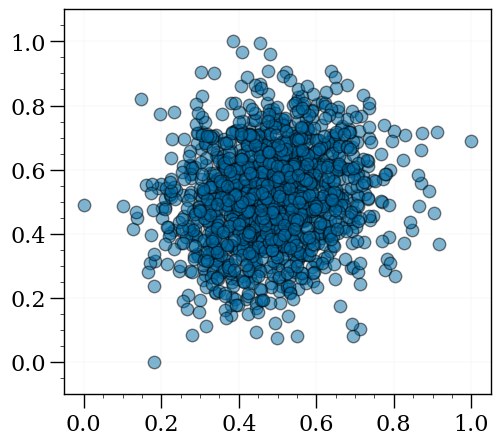

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'frank_1')

  0%|          | 1/10000 [00:59<166:18:26, 59.88s/it]

Iter 0. Loss [[0.46498707 0.289324   8.489582  ]]


  0%|          | 11/10000 [01:57<4:13:26,  1.52s/it]

Iter 10. Loss [[0.39255473 0.10649329 2.5381892 ]]


  0%|          | 21/10000 [01:59<47:38,  3.49it/s]

Iter 20. Loss [[0.38380128 0.09428529 2.5110312 ]]


  0%|          | 31/10000 [02:02<43:40,  3.80it/s]

Iter 30. Loss [[0.3414314  0.07826451 2.473138  ]]


  0%|          | 41/10000 [02:05<42:02,  3.95it/s]

Iter 40. Loss [[0.3328055  0.07227036 2.4005272 ]]


  1%|          | 51/10000 [02:09<1:06:21,  2.50it/s]

Iter 50. Loss [[0.309554   0.06887706 2.312888  ]]


  1%|          | 61/10000 [02:12<43:19,  3.82it/s]

Iter 60. Loss [[0.28639564 0.06434525 2.20005   ]]


  1%|          | 71/10000 [02:15<42:30,  3.89it/s]

Iter 70. Loss [[0.22760473 0.06125899 1.975548  ]]


  1%|          | 81/10000 [02:17<41:27,  3.99it/s]

Iter 80. Loss [[0.1178335  0.06182063 1.5095772 ]]


  1%|          | 91/10000 [02:20<53:11,  3.10it/s]

Iter 90. Loss [[0.0563281  0.19729124 2.7720726 ]]


  1%|          | 101/10000 [02:24<50:35,  3.26it/s]

Iter 100. Loss [[0.05695241 0.21220678 3.2308455 ]]


  1%|          | 111/10000 [02:27<42:19,  3.89it/s]

Iter 110. Loss [[0.05898181 0.29504642 7.6459284 ]]


  1%|          | 121/10000 [02:29<42:35,  3.87it/s]

Iter 120. Loss [[0.05694895 0.26802263 4.7518964 ]]


  1%|▏         | 131/10000 [02:33<42:39,  3.86it/s]

Iter 130. Loss [[0.19889025 0.07034915 1.955554  ]]


  1%|▏         | 141/10000 [02:37<1:36:42,  1.70it/s]

Iter 140. Loss [[0.25819716 0.05187963 1.9430898 ]]


  2%|▏         | 151/10000 [02:39<43:56,  3.74it/s]

Iter 150. Loss [[0.17294946 0.06037721 1.7254479 ]]


  2%|▏         | 161/10000 [02:42<1:08:37,  2.39it/s]

Iter 160. Loss [[0.12095919 0.06149752 1.50268   ]]


  2%|▏         | 171/10000 [02:45<42:12,  3.88it/s]

Iter 170. Loss [[0.148708   0.04664872 1.487278  ]]


  2%|▏         | 181/10000 [02:49<1:21:46,  2.00it/s]

Iter 180. Loss [[0.12278799 0.0488946  1.385988  ]]


  2%|▏         | 191/10000 [02:52<44:33,  3.67it/s]

Iter 190. Loss [[0.12911427 0.04693924 1.3712623 ]]


  2%|▏         | 201/10000 [02:55<1:00:20,  2.71it/s]

Iter 200. Loss [[0.12587608 0.04495445 1.3146033 ]]


  2%|▏         | 211/10000 [02:57<42:08,  3.87it/s]

Iter 210. Loss [[0.12083186 0.04379863 1.2408559 ]]


  2%|▏         | 221/10000 [03:00<1:03:29,  2.57it/s]

Iter 220. Loss [[0.1627057  0.03656356 1.3083096 ]]


  2%|▏         | 231/10000 [03:04<50:13,  3.24it/s]

Iter 230. Loss [[0.11699922 0.03719887 1.1436526 ]]


  2%|▏         | 241/10000 [03:07<50:26,  3.22it/s]

Iter 240. Loss [[0.16132692 0.03548526 1.1877071 ]]


  3%|▎         | 251/10000 [03:10<40:46,  3.98it/s]

Iter 250. Loss [[0.12711304 0.02969461 1.0684079 ]]


  3%|▎         | 261/10000 [03:13<49:32,  3.28it/s]

Iter 260. Loss [[0.10581116 0.03617207 0.96725845]]


  3%|▎         | 271/10000 [03:16<1:07:30,  2.40it/s]

Iter 270. Loss [[0.12200478 0.02763934 0.9261074 ]]


  3%|▎         | 281/10000 [03:20<51:12,  3.16it/s]

Iter 280. Loss [[0.12234895 0.02732861 0.89332795]]


  3%|▎         | 291/10000 [03:22<41:27,  3.90it/s]

Iter 290. Loss [[0.11866318 0.0259459  0.8672272 ]]


  3%|▎         | 301/10000 [03:25<47:16,  3.42it/s]

Iter 300. Loss [[0.12554175 0.02509687 0.8658234 ]]


  3%|▎         | 311/10000 [03:28<59:55,  2.69it/s]

Iter 310. Loss [[0.1251219  0.02464989 0.8533586 ]]


  3%|▎         | 321/10000 [03:32<50:12,  3.21it/s]

Iter 320. Loss [[0.12320806 0.02422358 0.83549803]]


  3%|▎         | 331/10000 [03:35<40:16,  4.00it/s]

Iter 330. Loss [[0.12337398 0.02393378 0.82843554]]


  3%|▎         | 341/10000 [03:38<44:31,  3.62it/s]

Iter 340. Loss [[0.11111301 0.02628814 0.8368896 ]]


  4%|▎         | 351/10000 [03:40<41:56,  3.83it/s]

Iter 350. Loss [[0.07087277 0.05998953 1.1106572 ]]


  4%|▎         | 361/10000 [03:44<54:42,  2.94it/s]

Iter 360. Loss [[0.17728639 0.02150816 1.0112665 ]]


  4%|▎         | 371/10000 [03:47<40:36,  3.95it/s]

Iter 370. Loss [[0.0915696  0.03521483 0.88082665]]


  4%|▍         | 381/10000 [03:50<43:11,  3.71it/s]

Iter 380. Loss [[0.12365789 0.02149629 0.87228775]]


  4%|▍         | 391/10000 [03:52<40:27,  3.96it/s]

Iter 390. Loss [[0.11324968 0.02574547 0.8276079 ]]


  4%|▍         | 401/10000 [03:56<1:08:21,  2.34it/s]

Iter 400. Loss [[0.11216882 0.02579683 0.83749866]]


  4%|▍         | 411/10000 [03:59<41:19,  3.87it/s]

Iter 410. Loss [[0.1012426  0.02946261 0.84919256]]


  4%|▍         | 421/10000 [04:02<43:02,  3.71it/s]

Iter 420. Loss [[0.11160441 0.02376753 0.86679393]]


  4%|▍         | 431/10000 [04:05<40:27,  3.94it/s]

Iter 430. Loss [[0.12295517 0.02161197 0.9550164 ]]


  4%|▍         | 441/10000 [04:08<1:01:30,  2.59it/s]

Iter 440. Loss [[0.06154969 0.08578517 1.3395972 ]]


  5%|▍         | 451/10000 [04:12<44:23,  3.59it/s]

Iter 450. Loss [[0.09440816 0.04771645 1.0729141 ]]


  5%|▍         | 461/10000 [04:15<43:10,  3.68it/s]

Iter 460. Loss [[0.09552257 0.0556585  1.1698699 ]]


  5%|▍         | 471/10000 [04:17<40:28,  3.92it/s]

Iter 470. Loss [[0.09785695 0.05244968 1.1251835 ]]


  5%|▍         | 481/10000 [04:21<45:07,  3.52it/s]

Iter 480. Loss [[0.0936871  0.03832421 0.96494263]]


  5%|▍         | 491/10000 [04:24<54:02,  2.93it/s]

Iter 490. Loss [[0.12961024 0.02833236 0.93805796]]


  5%|▌         | 501/10000 [04:28<42:21,  3.74it/s]

Iter 500. Loss [[0.10256243 0.03215794 0.96855205]]


  5%|▌         | 511/10000 [04:30<41:14,  3.84it/s]

Iter 510. Loss [[0.06676921 0.29000142 5.9530873 ]]


  5%|▌         | 521/10000 [04:33<42:46,  3.69it/s]

Iter 520. Loss [[0.08219192 0.12642917 1.9936516 ]]


  5%|▌         | 531/10000 [04:38<1:31:54,  1.72it/s]

Iter 530. Loss [[0.3139149  0.04867546 1.8092184 ]]


  5%|▌         | 541/10000 [04:40<42:05,  3.75it/s]

Iter 540. Loss [[0.12316255 0.09420235 1.8340634 ]]


  6%|▌         | 551/10000 [04:43<58:35,  2.69it/s]  

Iter 550. Loss [[0.1835968  0.04252352 1.5100837 ]]


  6%|▌         | 561/10000 [04:46<40:39,  3.87it/s]

Iter 560. Loss [[0.13207848 0.03915436 1.392154  ]]


  6%|▌         | 571/10000 [04:49<1:19:31,  1.98it/s]

Iter 570. Loss [[0.13138187 0.0347536  1.2120922 ]]


  6%|▌         | 581/10000 [04:53<42:52,  3.66it/s]

Iter 580. Loss [[0.15459427 0.03079177 1.1948166 ]]


  6%|▌         | 591/10000 [04:56<53:20,  2.94it/s]

Iter 590. Loss [[0.15233648 0.02758379 1.1717066 ]]


  6%|▌         | 601/10000 [04:58<41:39,  3.76it/s]

Iter 600. Loss [[0.1336366  0.03016371 1.0608121 ]]


  6%|▌         | 611/10000 [05:02<1:06:21,  2.36it/s]

Iter 610. Loss [[0.17099172 0.02702824 1.1832747 ]]


  6%|▌         | 621/10000 [05:05<47:13,  3.31it/s]

Iter 620. Loss [[0.14149812 0.02287434 1.0295861 ]]


  6%|▋         | 631/10000 [05:08<49:29,  3.16it/s]

Iter 630. Loss [[0.08954764 0.03754341 0.9161931 ]]


  6%|▋         | 641/10000 [05:11<40:16,  3.87it/s]

Iter 640. Loss [[0.11726929 0.02481062 0.9683925 ]]


  7%|▋         | 651/10000 [05:14<48:52,  3.19it/s]

Iter 650. Loss [[0.08479044 0.04119617 0.9417809 ]]


  7%|▋         | 661/10000 [05:18<1:01:52,  2.52it/s]

Iter 660. Loss [[0.11288486 0.02516404 0.937055  ]]


  7%|▋         | 671/10000 [05:21<47:31,  3.27it/s]

Iter 670. Loss [[0.13459739 0.0251461  0.8980693 ]]


  7%|▋         | 681/10000 [05:24<40:44,  3.81it/s]

Iter 680. Loss [[0.13704394 0.02438091 0.9585322 ]]


  7%|▋         | 691/10000 [05:27<43:35,  3.56it/s]

Iter 690. Loss [[0.12739651 0.02851075 1.0460078 ]]


  7%|▋         | 701/10000 [05:30<1:02:34,  2.48it/s]

Iter 700. Loss [[0.14884456 0.02072273 1.1839097 ]]


  7%|▋         | 711/10000 [05:34<45:58,  3.37it/s]

Iter 710. Loss [[0.06676683 0.06493109 1.1454067 ]]


  7%|▋         | 721/10000 [05:36<39:21,  3.93it/s]

Iter 720. Loss [[0.14584395 0.02575828 1.1620679 ]]


  7%|▋         | 731/10000 [05:39<42:51,  3.61it/s]

Iter 730. Loss [[0.11771577 0.02374566 1.0765797 ]]


  7%|▋         | 741/10000 [05:42<53:21,  2.89it/s]

Iter 740. Loss [[0.1501418  0.02032122 1.0451128 ]]


  8%|▊         | 751/10000 [05:46<46:16,  3.33it/s]

Iter 750. Loss [[0.08827446 0.05586122 1.553935  ]]


  8%|▊         | 761/10000 [05:49<38:56,  3.95it/s]

Iter 760. Loss [[0.18861331 0.01874286 1.5435661 ]]


  8%|▊         | 771/10000 [05:52<40:41,  3.78it/s]

Iter 770. Loss [[0.21285683 0.02210893 1.3575411 ]]


  8%|▊         | 781/10000 [05:54<40:02,  3.84it/s]

Iter 780. Loss [[0.06376327 0.11235103 1.7741785 ]]


  8%|▊         | 791/10000 [05:58<52:34,  2.92it/s]

Iter 790. Loss [[0.35579863 0.08545151 2.7943861 ]]


  8%|▊         | 801/10000 [06:01<39:32,  3.88it/s]

Iter 800. Loss [[0.07179893 0.1260223  2.1387115 ]]


  8%|▊         | 811/10000 [06:04<41:12,  3.72it/s]

Iter 810. Loss [[0.21439292 0.02591327 1.5327667 ]]


  8%|▊         | 821/10000 [06:07<39:29,  3.87it/s]

Iter 820. Loss [[0.14445104 0.03242451 1.1059389 ]]


  8%|▊         | 831/10000 [06:11<1:03:33,  2.40it/s]

Iter 830. Loss [[0.14866315 0.02708257 1.1462088 ]]


  8%|▊         | 841/10000 [06:14<40:06,  3.81it/s]

Iter 840. Loss [[0.12054984 0.02990338 1.0319802 ]]


  9%|▊         | 851/10000 [06:17<39:53,  3.82it/s]

Iter 850. Loss [[0.10752406 0.03267046 0.9091542 ]]


  9%|▊         | 861/10000 [06:20<1:03:10,  2.41it/s]

Iter 860. Loss [[0.11151317 0.02493372 0.85533684]]


  9%|▊         | 871/10000 [06:23<56:13,  2.71it/s]

Iter 870. Loss [[0.10945743 0.02448324 0.925194  ]]


  9%|▉         | 881/10000 [06:27<1:00:23,  2.52it/s]

Iter 880. Loss [[0.06573597 0.11650918 2.0072973 ]]


  9%|▉         | 891/10000 [06:29<40:15,  3.77it/s]

Iter 890. Loss [[0.06671671 0.13345753 2.008811  ]]


  9%|▉         | 901/10000 [06:32<56:44,  2.67it/s]  

Iter 900. Loss [[0.09555555 0.06616196 1.2618583 ]]


  9%|▉         | 911/10000 [06:35<39:23,  3.85it/s]

Iter 910. Loss [[0.24001312 0.02965958 1.2548839 ]]


  9%|▉         | 921/10000 [06:39<1:03:08,  2.40it/s]

Iter 920. Loss [[0.12787025 0.04183923 1.1300731 ]]


  9%|▉         | 931/10000 [06:42<39:37,  3.81it/s]

Iter 930. Loss [[0.08904521 0.04323203 1.0211158 ]]


  9%|▉         | 941/10000 [06:45<50:34,  2.99it/s]

Iter 940. Loss [[0.10063679 0.03392405 0.999528  ]]


 10%|▉         | 951/10000 [06:47<38:26,  3.92it/s]

Iter 950. Loss [[0.12787978 0.02647515 0.9976516 ]]


 10%|▉         | 961/10000 [06:52<1:11:23,  2.11it/s]

Iter 960. Loss [[0.16272359 0.01982743 1.0939676 ]]


 10%|▉         | 971/10000 [06:54<39:41,  3.79it/s]

Iter 970. Loss [[0.18747525 0.05304829 1.4058675 ]]


 10%|▉         | 981/10000 [06:57<46:47,  3.21it/s]

Iter 980. Loss [[0.237922   0.03332413 1.4467243 ]]


 10%|▉         | 991/10000 [07:00<38:17,  3.92it/s]

Iter 990. Loss [[0.14085661 0.04800741 1.219278  ]]


 10%|█         | 1001/10000 [07:04<1:12:59,  2.05it/s]

Iter 1000. Loss [[0.1463688  0.03029117 1.2425838 ]]


 10%|█         | 1011/10000 [07:07<41:08,  3.64it/s]

Iter 1010. Loss [[0.11825799 0.03098398 1.0913146 ]]


 10%|█         | 1021/10000 [07:10<41:49,  3.58it/s]

Iter 1020. Loss [[0.12010884 0.02852946 0.95108104]]


 10%|█         | 1031/10000 [07:13<37:49,  3.95it/s]

Iter 1030. Loss [[0.11234247 0.02599354 0.86674744]]


 10%|█         | 1041/10000 [07:16<49:32,  3.01it/s]

Iter 1040. Loss [[0.09761999 0.02891918 0.8397509 ]]


 11%|█         | 1051/10000 [07:20<46:59,  3.17it/s]

Iter 1050. Loss [[0.1337879  0.02341228 1.0086368 ]]


 11%|█         | 1061/10000 [07:23<41:42,  3.57it/s]

Iter 1060. Loss [[0.13169368 0.02599322 0.8762397 ]]


 11%|█         | 1071/10000 [07:25<38:24,  3.87it/s]

Iter 1070. Loss [[0.11596841 0.02116744 0.8346381 ]]


 11%|█         | 1081/10000 [07:28<40:56,  3.63it/s]

Iter 1080. Loss [[0.0796703  0.04362374 1.3426522 ]]


 11%|█         | 1091/10000 [07:32<1:02:07,  2.39it/s]

Iter 1090. Loss [[0.08744239 0.03610152 1.1260167 ]]


 11%|█         | 1101/10000 [07:36<40:40,  3.65it/s]

Iter 1100. Loss [[0.13600275 0.0208775  0.96310323]]


 11%|█         | 1111/10000 [07:38<38:23,  3.86it/s]

Iter 1110. Loss [[0.13777141 0.01731173 0.70906466]]


 11%|█         | 1121/10000 [07:41<40:08,  3.69it/s]

Iter 1120. Loss [[0.11735769 0.01970612 0.84658056]]


 11%|█▏        | 1131/10000 [07:45<58:52,  2.51it/s]

Iter 1130. Loss [[0.11677316 0.01938003 0.94643617]]


 11%|█▏        | 1141/10000 [07:48<40:21,  3.66it/s]

Iter 1140. Loss [[0.11941675 0.0212076  0.8914817 ]]


 12%|█▏        | 1151/10000 [07:51<37:10,  3.97it/s]

Iter 1150. Loss [[0.13192853 0.01997874 0.8461062 ]]


 12%|█▏        | 1161/10000 [07:54<38:34,  3.82it/s]

Iter 1160. Loss [[0.12911911 0.02282473 0.9589949 ]]


 12%|█▏        | 1171/10000 [07:56<44:25,  3.31it/s]

Iter 1170. Loss [[0.1300051 0.0235879 0.9862842]]


 12%|█▏        | 1181/10000 [08:00<43:07,  3.41it/s]

Iter 1180. Loss [[0.12883724 0.02405071 1.0494206 ]]


 12%|█▏        | 1191/10000 [08:04<1:01:55,  2.37it/s]

Iter 1190. Loss [[0.12981538 0.02617507 1.1171536 ]]


 12%|█▏        | 1201/10000 [08:06<38:23,  3.82it/s]

Iter 1200. Loss [[0.12958741 0.02738949 1.1873108 ]]


 12%|█▏        | 1211/10000 [08:09<54:32,  2.69it/s]  

Iter 1210. Loss [[0.13091676 0.02810215 1.218811  ]]


 12%|█▏        | 1221/10000 [08:13<52:43,  2.77it/s]

Iter 1220. Loss [[0.1315691 0.0295764 1.2299645]]


 12%|█▏        | 1231/10000 [08:16<53:59,  2.71it/s]  

Iter 1230. Loss [[0.13154975 0.03051375 1.2503864 ]]


 12%|█▏        | 1241/10000 [08:19<38:15,  3.82it/s]

Iter 1240. Loss [[0.13097909 0.03129753 1.2962736 ]]


 13%|█▎        | 1251/10000 [08:22<49:13,  2.96it/s]

Iter 1250. Loss [[0.12330225 0.03224051 1.4309394 ]]


 13%|█▎        | 1261/10000 [08:25<58:30,  2.49it/s]

Iter 1260. Loss [[0.13085686 0.03195866 1.2583566 ]]


 13%|█▎        | 1271/10000 [08:29<49:49,  2.92it/s]

Iter 1270. Loss [[0.13199167 0.03266918 1.2589848 ]]


 13%|█▎        | 1281/10000 [08:31<38:00,  3.82it/s]

Iter 1280. Loss [[0.13258442 0.032178   1.2523667 ]]


 13%|█▎        | 1291/10000 [08:34<45:44,  3.17it/s]

Iter 1290. Loss [[0.13048905 0.03161394 1.279982  ]]


 13%|█▎        | 1301/10000 [08:37<51:38,  2.81it/s]

Iter 1300. Loss [[0.13386793 0.03093672 1.2236879 ]]


 13%|█▎        | 1311/10000 [08:41<50:22,  2.88it/s]

Iter 1310. Loss [[0.13364534 0.03034708 1.2283937 ]]


 13%|█▎        | 1321/10000 [08:44<38:09,  3.79it/s]

Iter 1320. Loss [[0.13225189 0.02967444 1.2450987 ]]


 13%|█▎        | 1331/10000 [08:47<42:46,  3.38it/s]

Iter 1330. Loss [[0.13443118 0.0320613  1.2981738 ]]


 13%|█▎        | 1341/10000 [08:49<37:03,  3.89it/s]

Iter 1340. Loss [[0.13777906 0.03266519 1.2610239 ]]


 14%|█▎        | 1351/10000 [08:54<49:31,  2.91it/s]

Iter 1350. Loss [[0.12515797 0.03230252 1.6027199 ]]


 14%|█▎        | 1361/10000 [08:56<36:23,  3.96it/s]

Iter 1360. Loss [[0.163353  0.0307861 1.2276082]]


 14%|█▎        | 1371/10000 [08:59<39:54,  3.60it/s]

Iter 1370. Loss [[0.06921735 0.11107782 4.400151  ]]


 14%|█▍        | 1381/10000 [09:01<35:55,  4.00it/s]

Iter 1380. Loss [[0.06865636 0.08237375 3.4942122 ]]


 14%|█▍        | 1391/10000 [09:06<59:09,  2.43it/s]

Iter 1390. Loss [[0.08995873 0.04583314 2.1690485 ]]


 14%|█▍        | 1401/10000 [09:08<37:39,  3.81it/s]

Iter 1400. Loss [[ 0.08974332  0.3021152  11.703367  ]]


 14%|█▍        | 1411/10000 [09:11<39:12,  3.65it/s]

Iter 1410. Loss [[0.26849994 0.0299039  1.3601451 ]]


 14%|█▍        | 1421/10000 [09:14<36:25,  3.93it/s]

Iter 1420. Loss [[0.21084596 0.0459442  1.3859419 ]]


 14%|█▍        | 1431/10000 [09:17<52:27,  2.72it/s]

Iter 1430. Loss [[0.22494057 0.03112084 1.2756886 ]]


 14%|█▍        | 1441/10000 [09:21<40:59,  3.48it/s]

Iter 1440. Loss [[0.21337168 0.03026753 1.2339348 ]]


 15%|█▍        | 1451/10000 [09:24<39:04,  3.65it/s]

Iter 1450. Loss [[0.24020612 0.02337033 1.1895996 ]]


 15%|█▍        | 1461/10000 [09:26<36:10,  3.93it/s]

Iter 1460. Loss [[0.19577655 0.02469003 1.0893595 ]]


 15%|█▍        | 1471/10000 [09:30<37:50,  3.76it/s]

Iter 1470. Loss [[0.17710823 0.02192406 1.0038221 ]]


 15%|█▍        | 1481/10000 [09:33<49:52,  2.85it/s]

Iter 1480. Loss [[0.12998928 0.02374638 0.89633006]]


 15%|█▍        | 1491/10000 [09:37<38:13,  3.71it/s]

Iter 1490. Loss [[0.12806483 0.01914623 0.8427652 ]]


 15%|█▌        | 1501/10000 [09:39<36:43,  3.86it/s]

Iter 1500. Loss [[0.12866417 0.0178407  0.7172429 ]]


 15%|█▌        | 1511/10000 [09:42<37:00,  3.82it/s]

Iter 1510. Loss [[0.12426389 0.01553436 0.7325241 ]]


 15%|█▌        | 1521/10000 [09:46<1:24:20,  1.68it/s]

Iter 1520. Loss [[0.14059472 0.01468642 0.6628117 ]]


 15%|█▌        | 1531/10000 [09:49<36:50,  3.83it/s]

Iter 1530. Loss [[0.13286953 0.01664395 0.7876509 ]]


 15%|█▌        | 1541/10000 [09:52<51:26,  2.74it/s]

Iter 1540. Loss [[0.13258079 0.01906324 0.82207346]]


 16%|█▌        | 1551/10000 [09:54<36:19,  3.88it/s]

Iter 1550. Loss [[0.12842174 0.01603106 0.72968763]]


 16%|█▌        | 1561/10000 [09:58<1:07:44,  2.08it/s]

Iter 1560. Loss [[0.07485636 0.11023289 2.4794114 ]]


 16%|█▌        | 1571/10000 [10:01<38:17,  3.67it/s]

Iter 1570. Loss [[0.07534432 0.11339775 1.6521794 ]]


 16%|█▌        | 1581/10000 [10:04<47:45,  2.94it/s]

Iter 1580. Loss [[0.08539911 0.04307404 0.9407973 ]]


 16%|█▌        | 1591/10000 [10:07<35:33,  3.94it/s]

Iter 1590. Loss [[0.19066994 0.01799235 1.3652109 ]]


 16%|█▌        | 1601/10000 [10:10<46:42,  3.00it/s]

Iter 1600. Loss [[0.16004217 0.02686513 1.0169915 ]]


 16%|█▌        | 1611/10000 [10:13<45:22,  3.08it/s]

Iter 1610. Loss [[0.14797688 0.02893866 0.98504215]]


 16%|█▌        | 1621/10000 [10:16<42:50,  3.26it/s]

Iter 1620. Loss [[0.16129006 0.02072318 0.9461011 ]]


 16%|█▋        | 1631/10000 [10:19<34:38,  4.03it/s]

Iter 1630. Loss [[0.14423798 0.02042732 0.89015704]]


 16%|█▋        | 1641/10000 [10:22<41:37,  3.35it/s]

Iter 1640. Loss [[0.1350089  0.02172257 0.87513524]]


 17%|█▋        | 1651/10000 [10:25<54:19,  2.56it/s]

Iter 1650. Loss [[0.12997903 0.02230676 0.80908364]]


 17%|█▋        | 1661/10000 [10:29<42:07,  3.30it/s]

Iter 1660. Loss [[0.12882021 0.02008946 0.77638686]]


 17%|█▋        | 1671/10000 [10:31<34:51,  3.98it/s]

Iter 1670. Loss [[0.1400192  0.01650294 0.749278  ]]


 17%|█▋        | 1681/10000 [10:34<38:21,  3.61it/s]

Iter 1680. Loss [[0.13324036 0.01614013 0.71775067]]


 17%|█▋        | 1691/10000 [10:37<43:26,  3.19it/s]

Iter 1690. Loss [[0.12730353 0.01640864 0.6787367 ]]


 17%|█▋        | 1701/10000 [10:41<42:28,  3.26it/s]

Iter 1700. Loss [[0.12872872 0.01657859 0.6556864 ]]


 17%|█▋        | 1711/10000 [10:43<34:41,  3.98it/s]

Iter 1710. Loss [[0.12788495 0.01677482 0.6301621 ]]


 17%|█▋        | 1721/10000 [10:46<37:09,  3.71it/s]

Iter 1720. Loss [[0.128877   0.01685483 0.6251714 ]]


 17%|█▋        | 1731/10000 [10:49<34:02,  4.05it/s]

Iter 1730. Loss [[0.13082936 0.01710896 0.62223613]]


 17%|█▋        | 1741/10000 [10:53<54:35,  2.52it/s]

Iter 1740. Loss [[0.12318773 0.01895928 0.62237436]]


 18%|█▊        | 1751/10000 [10:55<35:21,  3.89it/s]

Iter 1750. Loss [[0.1331681  0.01782954 0.60891217]]


 18%|█▊        | 1761/10000 [10:58<36:24,  3.77it/s]

Iter 1760. Loss [[0.12958567 0.01899889 0.59179527]]


 18%|█▊        | 1771/10000 [11:01<34:18,  4.00it/s]

Iter 1770. Loss [[0.13023627 0.01905952 0.5923496 ]]


 18%|█▊        | 1781/10000 [11:05<58:41,  2.33it/s]

Iter 1780. Loss [[0.12944657 0.01834604 0.6060004 ]]


 18%|█▊        | 1791/10000 [11:08<37:08,  3.68it/s]

Iter 1790. Loss [[0.13253184 0.01748299 0.58823615]]


 18%|█▊        | 1801/10000 [11:11<35:13,  3.88it/s]

Iter 1800. Loss [[0.13469848 0.01767168 0.57815796]]


 18%|█▊        | 1811/10000 [11:13<33:37,  4.06it/s]

Iter 1810. Loss [[0.13325623 0.01768183 0.5990928 ]]


 18%|█▊        | 1821/10000 [11:17<36:53,  3.69it/s]

Iter 1820. Loss [[0.1403822 0.0186085 0.6414507]]


 18%|█▊        | 1831/10000 [11:20<43:22,  3.14it/s]

Iter 1830. Loss [[0.13126227 0.01957583 0.76362026]]


 18%|█▊        | 1841/10000 [11:23<35:11,  3.86it/s]

Iter 1840. Loss [[0.1517461  0.02213124 0.7134017 ]]


 19%|█▊        | 1851/10000 [11:26<34:32,  3.93it/s]

Iter 1850. Loss [[0.12389755 0.02194527 0.9328929 ]]


 19%|█▊        | 1861/10000 [11:29<34:35,  3.92it/s]

Iter 1860. Loss [[0.1603039  0.02056592 0.6349694 ]]


 19%|█▊        | 1871/10000 [11:33<1:20:44,  1.68it/s]

Iter 1870. Loss [[0.13719383 0.02390097 0.77055126]]


 19%|█▉        | 1881/10000 [11:35<34:17,  3.95it/s]

Iter 1880. Loss [[0.12868144 0.02154423 0.86750764]]


 19%|█▉        | 1891/10000 [11:38<55:56,  2.42it/s]

Iter 1890. Loss [[0.14320731 0.02220926 0.7006598 ]]


 19%|█▉        | 1901/10000 [11:41<34:41,  3.89it/s]

Iter 1900. Loss [[0.13304469 0.02260922 0.85969555]]


 19%|█▉        | 1911/10000 [11:44<1:03:18,  2.13it/s]

Iter 1910. Loss [[0.13099234 0.02275988 0.9285581 ]]


 19%|█▉        | 1921/10000 [11:48<36:33,  3.68it/s]

Iter 1920. Loss [[0.14472906 0.02412531 0.78092575]]


 19%|█▉        | 1931/10000 [11:51<47:55,  2.81it/s]

Iter 1930. Loss [[0.13290429 0.0252565  1.0266433 ]]


 19%|█▉        | 1941/10000 [11:53<33:17,  4.04it/s]

Iter 1940. Loss [[0.13148633 0.02328235 1.0365951 ]]


 20%|█▉        | 1951/10000 [11:56<44:04,  3.04it/s]

Iter 1950. Loss [[0.14468001 0.02061725 0.7193895 ]]


 20%|█▉        | 1961/10000 [12:00<48:26,  2.77it/s]

Iter 1960. Loss [[0.13081393 0.02106478 0.9938859 ]]


 20%|█▉        | 1971/10000 [12:03<44:35,  3.00it/s]

Iter 1970. Loss [[0.14057152 0.02242341 0.8012509 ]]


 20%|█▉        | 1981/10000 [12:05<33:21,  4.01it/s]

Iter 1980. Loss [[0.12573388 0.02284516 1.1470593 ]]


 20%|█▉        | 1991/10000 [12:08<41:26,  3.22it/s]

Iter 1990. Loss [[0.1443881  0.02205662 0.7697045 ]]


 20%|██        | 2001/10000 [12:12<51:47,  2.57it/s]

Iter 2000. Loss [[0.13422045 0.02315899 1.0484749 ]]


 20%|██        | 2011/10000 [12:15<42:45,  3.11it/s]

Iter 2010. Loss [[0.13601652 0.02427396 1.0515013 ]]


 20%|██        | 2021/10000 [12:18<33:27,  3.98it/s]

Iter 2020. Loss [[0.13777271 0.02363868 1.0547986 ]]


 20%|██        | 2031/10000 [12:21<38:18,  3.47it/s]

Iter 2030. Loss [[0.13720839 0.02322459 1.085297  ]]


 20%|██        | 2041/10000 [12:23<38:17,  3.46it/s]

Iter 2040. Loss [[0.13547546 0.02332107 1.1219548 ]]


 21%|██        | 2051/10000 [12:27<44:24,  2.98it/s]

Iter 2050. Loss [[0.13802558 0.02299603 1.0719653 ]]


 21%|██        | 2061/10000 [12:30<33:24,  3.96it/s]

Iter 2060. Loss [[0.13918428 0.0238823  0.93219626]]


 21%|██        | 2071/10000 [12:33<36:54,  3.58it/s]

Iter 2070. Loss [[0.1395063  0.02387821 0.889909  ]]


 21%|██        | 2081/10000 [12:35<33:57,  3.89it/s]

Iter 2080. Loss [[0.14737111 0.02451834 0.80863523]]


 21%|██        | 2091/10000 [12:40<53:00,  2.49it/s]

Iter 2090. Loss [[0.13963108 0.02251763 0.8805672 ]]


 21%|██        | 2101/10000 [12:42<34:07,  3.86it/s]

Iter 2100. Loss [[0.14036992 0.02266773 0.9297347 ]]


 21%|██        | 2111/10000 [12:45<35:37,  3.69it/s]

Iter 2110. Loss [[0.14018916 0.02240473 0.96918714]]


 21%|██        | 2121/10000 [12:48<33:13,  3.95it/s]

Iter 2120. Loss [[0.14231496 0.02301521 0.95805216]]


 21%|██▏       | 2131/10000 [12:52<53:16,  2.46it/s]

Iter 2130. Loss [[0.14044672 0.02109705 0.8615278 ]]


 21%|██▏       | 2141/10000 [12:55<35:26,  3.70it/s]

Iter 2140. Loss [[0.11693236 0.04881665 2.7423134 ]]


 22%|██▏       | 2151/10000 [12:58<35:00,  3.74it/s]

Iter 2150. Loss [[0.09130595 0.14390112 2.2681859 ]]


 22%|██▏       | 2161/10000 [13:00<33:32,  3.90it/s]

Iter 2160. Loss [[0.1847073  0.01728196 1.5780462 ]]


 22%|██▏       | 2171/10000 [13:03<42:43,  3.05it/s]

Iter 2170. Loss [[0.24080767 0.01884701 0.9850245 ]]


 22%|██▏       | 2181/10000 [13:07<39:23,  3.31it/s]

Iter 2180. Loss [[0.20880584 0.01413612 0.83630157]]


 22%|██▏       | 2191/10000 [13:10<33:57,  3.83it/s]

Iter 2190. Loss [[0.13949853 0.01835094 0.698406  ]]


 22%|██▏       | 2201/10000 [13:13<32:22,  4.01it/s]

Iter 2200. Loss [[0.11647274 0.01885946 0.7019829 ]]


 22%|██▏       | 2211/10000 [13:16<33:01,  3.93it/s]

Iter 2210. Loss [[0.12169334 0.01910854 0.6656397 ]]


 22%|██▏       | 2221/10000 [13:19<53:30,  2.42it/s]

Iter 2220. Loss [[0.25275996 0.03034062 0.8658229 ]]


 22%|██▏       | 2231/10000 [13:22<33:53,  3.82it/s]

Iter 2230. Loss [[0.17105542 0.01580124 0.71132094]]


 22%|██▏       | 2241/10000 [13:25<53:42,  2.41it/s]

Iter 2240. Loss [[0.10620582 0.03175011 1.0717328 ]]


 23%|██▎       | 2251/10000 [13:28<33:02,  3.91it/s]

Iter 2250. Loss [[0.12783825 0.02043526 0.78449446]]


 23%|██▎       | 2261/10000 [13:32<1:11:19,  1.81it/s]

Iter 2260. Loss [[0.13046247 0.01578805 0.7205947 ]]


 23%|██▎       | 2271/10000 [13:35<34:54,  3.69it/s]

Iter 2270. Loss [[0.13765925 0.01283238 0.60687524]]


 23%|██▎       | 2281/10000 [13:38<47:33,  2.71it/s]

Iter 2280. Loss [[0.13583486 0.0125449  0.65711045]]


 23%|██▎       | 2291/10000 [13:40<33:23,  3.85it/s]

Iter 2290. Loss [[0.13828754 0.01359847 0.669642  ]]


 23%|██▎       | 2301/10000 [13:43<53:54,  2.38it/s]

Iter 2300. Loss [[0.13704786 0.01668875 0.7597169 ]]


 23%|██▎       | 2311/10000 [13:47<38:56,  3.29it/s]

Iter 2310. Loss [[0.14177373 0.01791845 0.7455382 ]]


 23%|██▎       | 2321/10000 [13:50<42:00,  3.05it/s]

Iter 2320. Loss [[0.13925348 0.01846262 0.7838841 ]]


 23%|██▎       | 2331/10000 [13:52<32:16,  3.96it/s]

Iter 2330. Loss [[0.14155403 0.01905702 0.7986561 ]]


 23%|██▎       | 2341/10000 [13:55<41:57,  3.04it/s]

Iter 2340. Loss [[0.12454252 0.0184349  0.989534  ]]


 24%|██▎       | 2351/10000 [13:59<50:56,  2.50it/s]

Iter 2350. Loss [[0.13325822 0.0181839  0.9026178 ]]


 24%|██▎       | 2361/10000 [14:02<39:24,  3.23it/s]

Iter 2360. Loss [[0.14736433 0.01754357 0.6829229 ]]


 24%|██▎       | 2371/10000 [14:05<32:05,  3.96it/s]

Iter 2370. Loss [[0.13692714 0.01868199 0.8345922 ]]


 24%|██▍       | 2381/10000 [14:08<36:44,  3.46it/s]

Iter 2380. Loss [[0.13883662 0.01878126 0.7933328 ]]


 24%|██▍       | 2391/10000 [14:11<45:20,  2.80it/s]

Iter 2390. Loss [[0.14152594 0.02002421 0.87308836]]


 24%|██▍       | 2401/10000 [14:15<40:50,  3.10it/s]

Iter 2400. Loss [[0.1358192  0.02075084 1.0483593 ]]


 24%|██▍       | 2411/10000 [14:17<31:54,  3.96it/s]

Iter 2410. Loss [[0.13875546 0.02113149 1.0047878 ]]


 24%|██▍       | 2421/10000 [14:20<34:59,  3.61it/s]

Iter 2420. Loss [[0.14556144 0.02000185 0.81412506]]


 24%|██▍       | 2431/10000 [14:23<31:51,  3.96it/s]

Iter 2430. Loss [[0.14061658 0.02089879 0.98171985]]


 24%|██▍       | 2441/10000 [14:27<43:32,  2.89it/s]

Iter 2440. Loss [[0.14359689 0.02208147 1.0072606 ]]


 25%|██▍       | 2451/10000 [14:29<32:15,  3.90it/s]

Iter 2450. Loss [[0.14154415 0.02234936 1.0777535 ]]


 25%|██▍       | 2461/10000 [14:32<33:01,  3.81it/s]

Iter 2460. Loss [[0.13956743 0.02302994 1.1427484 ]]


 25%|██▍       | 2471/10000 [14:35<31:21,  4.00it/s]

Iter 2470. Loss [[0.14281951 0.02554282 1.1313941 ]]


 25%|██▍       | 2481/10000 [14:39<53:58,  2.32it/s]

Iter 2480. Loss [[0.13994958 0.02191277 1.0413043 ]]


 25%|██▍       | 2491/10000 [14:42<32:06,  3.90it/s]

Iter 2490. Loss [[0.14144517 0.0229517  1.0908303 ]]


 25%|██▌       | 2501/10000 [14:45<32:59,  3.79it/s]

Iter 2500. Loss [[0.146757   0.02369368 0.9679223 ]]


 25%|██▌       | 2511/10000 [14:47<31:26,  3.97it/s]

Iter 2510. Loss [[0.14191398 0.02231717 1.0440625 ]]


 25%|██▌       | 2521/10000 [14:50<43:09,  2.89it/s]

Iter 2520. Loss [[0.14323579 0.02232952 1.049495  ]]


 25%|██▌       | 2531/10000 [14:54<35:33,  3.50it/s]

Iter 2530. Loss [[0.14324784 0.0224588  1.0714055 ]]


 25%|██▌       | 2541/10000 [14:57<32:15,  3.85it/s]

Iter 2540. Loss [[0.14699848 0.02296107 1.0424013 ]]


 26%|██▌       | 2551/10000 [14:59<30:59,  4.01it/s]

Iter 2550. Loss [[0.14220197 0.02250065 1.0887234 ]]


 26%|██▌       | 2561/10000 [15:02<31:31,  3.93it/s]

Iter 2560. Loss [[0.14412801 0.02212308 1.0603942 ]]


 26%|██▌       | 2571/10000 [15:07<1:11:32,  1.73it/s]

Iter 2570. Loss [[0.14364283 0.02152107 1.0577015 ]]


 26%|██▌       | 2581/10000 [15:10<31:53,  3.88it/s]

Iter 2580. Loss [[0.14577834 0.02115136 0.9836379 ]]


 26%|██▌       | 2591/10000 [15:13<50:40,  2.44it/s]

Iter 2590. Loss [[0.14384314 0.02006219 0.99135554]]


 26%|██▌       | 2601/10000 [15:15<31:11,  3.95it/s]

Iter 2600. Loss [[0.14349142 0.02023472 1.0457164 ]]


 26%|██▌       | 2611/10000 [15:19<1:02:50,  1.96it/s]

Iter 2610. Loss [[0.1445462  0.02089345 1.1075261 ]]


 26%|██▌       | 2621/10000 [15:22<32:50,  3.74it/s]

Iter 2620. Loss [[0.1426284  0.02123891 1.1489686 ]]


 26%|██▋       | 2631/10000 [15:25<44:34,  2.76it/s]

Iter 2630. Loss [[0.14227678 0.02122949 1.1578435 ]]


 26%|██▋       | 2641/10000 [15:27<31:06,  3.94it/s]

Iter 2640. Loss [[0.14313594 0.02122434 1.1445365 ]]


 27%|██▋       | 2651/10000 [15:30<50:21,  2.43it/s]

Iter 2650. Loss [[0.14505138 0.0217593  1.1073391 ]]


 27%|██▋       | 2661/10000 [15:34<34:58,  3.50it/s]

Iter 2660. Loss [[0.14287268 0.02230973 1.1459082 ]]


 27%|██▋       | 2671/10000 [15:37<36:50,  3.32it/s]

Iter 2670. Loss [[0.14116311 0.02242171 1.1548355 ]]


 27%|██▋       | 2681/10000 [15:39<30:18,  4.02it/s]

Iter 2680. Loss [[0.14584756 0.02260982 1.0977259 ]]


 27%|██▋       | 2691/10000 [15:42<36:47,  3.31it/s]

Iter 2690. Loss [[0.1442132  0.02209118 1.1215862 ]]


 27%|██▋       | 2701/10000 [15:46<47:12,  2.58it/s]

Iter 2700. Loss [[0.14339472 0.02118658 1.1155112 ]]


 27%|██▋       | 2711/10000 [15:49<35:11,  3.45it/s]

Iter 2710. Loss [[0.1707045  0.02255024 0.7871188 ]]


 27%|██▋       | 2721/10000 [15:51<30:23,  3.99it/s]

Iter 2720. Loss [[0.10932152 0.04184124 1.9328578 ]]


 27%|██▋       | 2731/10000 [15:54<34:53,  3.47it/s]

Iter 2730. Loss [[0.13579743 0.02010082 1.1007864 ]]


 27%|██▋       | 2741/10000 [15:57<41:21,  2.93it/s]

Iter 2740. Loss [[0.11043065 0.02751797 1.627708  ]]


 28%|██▊       | 2751/10000 [16:01<36:13,  3.34it/s]

Iter 2750. Loss [[0.11566034 0.02068915 1.3564677 ]]


 28%|██▊       | 2761/10000 [16:04<30:04,  4.01it/s]

Iter 2760. Loss [[0.13812597 0.02606367 2.083234  ]]


 28%|██▊       | 2771/10000 [16:07<33:26,  3.60it/s]

Iter 2770. Loss [[0.1290523  0.01851362 0.68328756]]


 28%|██▊       | 2781/10000 [16:09<29:44,  4.05it/s]

Iter 2780. Loss [[0.17011178 0.0183381  0.7049191 ]]


 28%|██▊       | 2791/10000 [16:13<43:12,  2.78it/s]

Iter 2790. Loss [[0.12300806 0.01365915 0.7680099 ]]


 28%|██▊       | 2801/10000 [16:16<29:47,  4.03it/s]

Iter 2800. Loss [[0.14901397 0.0137275  0.6331594 ]]


 28%|██▊       | 2811/10000 [16:19<31:25,  3.81it/s]

Iter 2810. Loss [[0.13522328 0.01427722 0.79477215]]


 28%|██▊       | 2821/10000 [16:21<30:00,  3.99it/s]

Iter 2820. Loss [[0.13376886 0.01295692 0.60167456]]


 28%|██▊       | 2831/10000 [16:25<48:25,  2.47it/s]

Iter 2830. Loss [[0.13404723 0.0150975  0.89211816]]


 28%|██▊       | 2841/10000 [16:28<30:52,  3.86it/s]

Iter 2840. Loss [[0.12241028 0.01450066 0.70039386]]


 29%|██▊       | 2851/10000 [16:31<30:57,  3.85it/s]

Iter 2850. Loss [[0.1383175  0.01587754 0.87142986]]


 29%|██▊       | 2861/10000 [16:33<29:16,  4.06it/s]

Iter 2860. Loss [[0.1340624  0.01433523 0.77103204]]


 29%|██▊       | 2871/10000 [16:36<32:25,  3.66it/s]

Iter 2870. Loss [[0.13523759 0.01492216 0.768859  ]]


 29%|██▉       | 2881/10000 [16:40<37:20,  3.18it/s]

Iter 2880. Loss [[0.14588703 0.0161864  0.7277937 ]]


 29%|██▉       | 2891/10000 [16:43<30:28,  3.89it/s]

Iter 2890. Loss [[0.1349092  0.01575992 0.775905  ]]


 29%|██▉       | 2901/10000 [16:45<29:20,  4.03it/s]

Iter 2900. Loss [[0.09153897 0.02646853 0.8146128 ]]


 29%|██▉       | 2911/10000 [16:48<30:17,  3.90it/s]

Iter 2910. Loss [[0.24331445 0.04178281 0.8051375 ]]


 29%|██▉       | 2921/10000 [16:53<1:11:21,  1.65it/s]

Iter 2920. Loss [[0.09843639 0.03795825 1.3387047 ]]


 29%|██▉       | 2931/10000 [16:55<31:03,  3.79it/s]

Iter 2930. Loss [[0.1893877  0.01900947 0.6173373 ]]


 29%|██▉       | 2941/10000 [16:58<48:33,  2.42it/s]

Iter 2940. Loss [[0.1196776  0.01704829 0.8735644 ]]


 30%|██▉       | 2951/10000 [17:01<29:58,  3.92it/s]

Iter 2950. Loss [[0.15639208 0.01561649 0.5482963 ]]


 30%|██▉       | 2961/10000 [17:04<53:36,  2.19it/s]

Iter 2960. Loss [[0.13416421 0.01644055 0.79117876]]


 30%|██▉       | 2971/10000 [17:07<31:37,  3.70it/s]

Iter 2970. Loss [[0.14154187 0.01698638 0.7027343 ]]


 30%|██▉       | 2981/10000 [17:10<42:43,  2.74it/s]

Iter 2980. Loss [[0.13959116 0.01755295 0.7042903 ]]


 30%|██▉       | 2991/10000 [17:13<29:14,  4.00it/s]

Iter 2990. Loss [[0.1404136  0.0169717  0.70154214]]


 30%|███       | 3001/10000 [17:16<38:16,  3.05it/s]

Iter 3000. Loss [[0.140158   0.01769651 0.7955192 ]]


 30%|███       | 3011/10000 [17:19<43:05,  2.70it/s]

Iter 3010. Loss [[0.13854529 0.01714041 0.73477644]]


 30%|███       | 3021/10000 [17:22<38:30,  3.02it/s]

Iter 3020. Loss [[0.13994212 0.01774459 0.7890817 ]]


 30%|███       | 3031/10000 [17:25<29:37,  3.92it/s]

Iter 3030. Loss [[0.09871341 0.02542638 0.92566925]]


 30%|███       | 3041/10000 [17:28<35:29,  3.27it/s]

Iter 3040. Loss [[ 0.10907886  0.30236837 17.817122  ]]


 31%|███       | 3051/10000 [17:31<45:01,  2.57it/s]

Iter 3050. Loss [[0.0905195  0.17120084 2.9253314 ]]


 31%|███       | 3061/10000 [17:35<36:31,  3.17it/s]

Iter 3060. Loss [[0.36826527 0.10759159 1.3376474 ]]


 31%|███       | 3071/10000 [17:37<29:27,  3.92it/s]

Iter 3070. Loss [[0.27270424 0.03542191 1.3245432 ]]


 31%|███       | 3081/10000 [17:40<33:33,  3.44it/s]

Iter 3080. Loss [[0.30990824 0.03246167 1.128177  ]]


 31%|███       | 3091/10000 [17:43<33:31,  3.43it/s]

Iter 3090. Loss [[0.3073664  0.02997697 1.0930778 ]]


 31%|███       | 3101/10000 [17:47<37:06,  3.10it/s]

Iter 3100. Loss [[0.2897806  0.02410465 1.0606775 ]]


 31%|███       | 3111/10000 [17:49<28:33,  4.02it/s]

Iter 3110. Loss [[0.2980505  0.02408158 0.9992373 ]]


 31%|███       | 3121/10000 [17:52<31:42,  3.61it/s]

Iter 3120. Loss [[0.28769207 0.02027175 0.96154004]]


 31%|███▏      | 3131/10000 [17:55<28:54,  3.96it/s]

Iter 3130. Loss [[0.28775287 0.01895757 0.9190696 ]]


 31%|███▏      | 3141/10000 [17:59<48:53,  2.34it/s]

Iter 3140. Loss [[0.2843713  0.01720024 0.884044  ]]


 32%|███▏      | 3151/10000 [18:01<28:47,  3.96it/s]

Iter 3150. Loss [[0.28291062 0.01597342 0.85016966]]


 32%|███▏      | 3161/10000 [18:04<31:12,  3.65it/s]

Iter 3160. Loss [[0.28179067 0.01498503 0.8168418 ]]


 32%|███▏      | 3171/10000 [18:07<28:33,  3.99it/s]

Iter 3170. Loss [[0.27983204 0.01406074 0.7813857 ]]


 32%|███▏      | 3181/10000 [18:11<44:08,  2.57it/s]

Iter 3180. Loss [[0.27645516 0.01301406 0.7679226 ]]


 32%|███▏      | 3191/10000 [18:14<30:42,  3.69it/s]

Iter 3190. Loss [[0.2795114  0.01288184 0.7386862 ]]


 32%|███▏      | 3201/10000 [18:17<29:30,  3.84it/s]

Iter 3200. Loss [[0.281262   0.01288093 0.7027928 ]]


 32%|███▏      | 3211/10000 [18:19<27:43,  4.08it/s]

Iter 3210. Loss [[0.28097713 0.01274372 0.67370874]]


 32%|███▏      | 3221/10000 [18:22<28:59,  3.90it/s]

Iter 3220. Loss [[0.28085846 0.01251035 0.6596561 ]]


 32%|███▏      | 3231/10000 [18:26<38:28,  2.93it/s]

Iter 3230. Loss [[0.282247   0.01264158 0.6379827 ]]


 32%|███▏      | 3241/10000 [18:29<29:24,  3.83it/s]

Iter 3240. Loss [[0.28296557 0.01268814 0.6190091 ]]


 33%|███▎      | 3251/10000 [18:32<28:14,  3.98it/s]

Iter 3250. Loss [[0.28427452 0.01292012 0.6012526 ]]


 33%|███▎      | 3261/10000 [18:35<28:24,  3.95it/s]

Iter 3260. Loss [[0.28543848 0.01316317 0.5859942 ]]


 33%|███▎      | 3271/10000 [18:39<1:05:56,  1.70it/s]

Iter 3270. Loss [[0.28648928 0.01341546 0.5722211 ]]


 33%|███▎      | 3281/10000 [18:41<29:38,  3.78it/s]

Iter 3280. Loss [[0.28756914 0.01371808 0.5598434 ]]


 33%|███▎      | 3291/10000 [18:44<46:09,  2.42it/s]

Iter 3290. Loss [[0.28859156 0.01402217 0.5489578 ]]


 33%|███▎      | 3301/10000 [18:47<28:10,  3.96it/s]

Iter 3300. Loss [[0.28958142 0.01432045 0.5393528 ]]


 33%|███▎      | 3311/10000 [18:50<49:33,  2.25it/s]

Iter 3310. Loss [[0.290587   0.01461788 0.53080654]]


 33%|███▎      | 3321/10000 [18:53<31:42,  3.51it/s]

Iter 3320. Loss [[0.2915854  0.01489866 0.52316   ]]


 33%|███▎      | 3331/10000 [18:56<40:55,  2.72it/s]

Iter 3330. Loss [[0.2925822 0.015155  0.5162826]]


 33%|███▎      | 3341/10000 [18:59<27:42,  4.01it/s]

Iter 3340. Loss [[0.2936008  0.01537199 0.5099129 ]]


 34%|███▎      | 3351/10000 [19:02<37:49,  2.93it/s]

Iter 3350. Loss [[0.29469955 0.01560054 0.5043809 ]]


 34%|███▎      | 3361/10000 [19:06<41:25,  2.67it/s]

Iter 3360. Loss [[0.29548797 0.0158513  0.49872217]]


 34%|███▎      | 3371/10000 [19:09<34:58,  3.16it/s]

Iter 3370. Loss [[0.29903618 0.01561184 0.49834004]]


 34%|███▍      | 3381/10000 [19:11<27:31,  4.01it/s]

Iter 3380. Loss [[0.29945692 0.01527662 0.4949618 ]]


 34%|███▍      | 3391/10000 [19:14<33:35,  3.28it/s]

Iter 3390. Loss [[0.30079502 0.01545138 0.4902444 ]]


 34%|███▍      | 3401/10000 [19:18<42:20,  2.60it/s]

Iter 3400. Loss [[0.3016709  0.01551493 0.48681378]]


 34%|███▍      | 3411/10000 [19:21<33:05,  3.32it/s]

Iter 3410. Loss [[0.30238461 0.01546422 0.48395866]]


 34%|███▍      | 3421/10000 [19:24<27:37,  3.97it/s]

Iter 3420. Loss [[0.30310768 0.01539744 0.48120052]]


 34%|███▍      | 3431/10000 [19:27<32:09,  3.40it/s]

Iter 3430. Loss [[0.3039599  0.01535215 0.4784039 ]]


 34%|███▍      | 3441/10000 [19:29<33:17,  3.28it/s]

Iter 3440. Loss [[0.30486742 0.01528231 0.47591886]]


 35%|███▍      | 3451/10000 [19:33<34:16,  3.19it/s]

Iter 3450. Loss [[0.30579296 0.01517473 0.47339356]]


 35%|███▍      | 3461/10000 [19:36<27:53,  3.91it/s]

Iter 3460. Loss [[0.30670387 0.01503049 0.47101203]]


 35%|███▍      | 3471/10000 [19:39<31:03,  3.50it/s]

Iter 3470. Loss [[0.30758944 0.01488583 0.4689332 ]]


 35%|███▍      | 3481/10000 [19:41<26:51,  4.05it/s]

Iter 3480. Loss [[0.30831763 0.01469459 0.46680436]]


 35%|███▍      | 3491/10000 [19:46<45:00,  2.41it/s]

Iter 3490. Loss [[0.309187   0.01451634 0.4644348 ]]


 35%|███▌      | 3501/10000 [19:48<27:44,  3.90it/s]

Iter 3500. Loss [[0.30981717 0.01431861 0.46250963]]


 35%|███▌      | 3511/10000 [19:51<28:55,  3.74it/s]

Iter 3510. Loss [[0.310678   0.01412552 0.46037003]]


 35%|███▌      | 3521/10000 [19:54<27:18,  3.95it/s]

Iter 3520. Loss [[0.3113176  0.01392678 0.45944336]]


 35%|███▌      | 3531/10000 [19:57<43:14,  2.49it/s]

Iter 3530. Loss [[0.31194133 0.0137906  0.45781484]]


 35%|███▌      | 3541/10000 [20:01<29:18,  3.67it/s]

Iter 3540. Loss [[0.31213233 0.01367942 0.45669076]]


 36%|███▌      | 3551/10000 [20:04<28:45,  3.74it/s]

Iter 3550. Loss [[0.31221795 0.01350099 0.45408902]]


 36%|███▌      | 3561/10000 [20:06<27:36,  3.89it/s]

Iter 3560. Loss [[0.3112199  0.01384327 0.4555782 ]]


 36%|███▌      | 3571/10000 [20:09<32:09,  3.33it/s]

Iter 3570. Loss [[0.3113921  0.01451913 0.4563064 ]]


 36%|███▌      | 3581/10000 [20:13<33:37,  3.18it/s]

Iter 3580. Loss [[0.31172147 0.01526646 0.45570466]]


 36%|███▌      | 3591/10000 [20:16<27:51,  3.83it/s]

Iter 3590. Loss [[0.3111232  0.01484582 0.4564666 ]]


 36%|███▌      | 3601/10000 [20:19<26:29,  4.03it/s]

Iter 3600. Loss [[0.31184313 0.01467982 0.45249063]]


 36%|███▌      | 3611/10000 [20:22<27:18,  3.90it/s]

Iter 3610. Loss [[0.31272653 0.01494697 0.4542145 ]]


 36%|███▌      | 3621/10000 [20:26<1:01:22,  1.73it/s]

Iter 3620. Loss [[0.31330165 0.01567512 0.45417237]]


 36%|███▋      | 3631/10000 [20:28<28:25,  3.73it/s]

Iter 3630. Loss [[0.3127211  0.01547803 0.45678174]]


 36%|███▋      | 3641/10000 [20:31<39:24,  2.69it/s]

Iter 3640. Loss [[0.31376094 0.01497502 0.45425683]]


 37%|███▋      | 3651/10000 [20:34<27:06,  3.90it/s]

Iter 3650. Loss [[0.31518272 0.01462032 0.45172298]]


 37%|███▋      | 3661/10000 [20:38<53:22,  1.98it/s]

Iter 3660. Loss [[0.316184  0.0142431 0.4498396]]


 37%|███▋      | 3671/10000 [20:41<28:23,  3.71it/s]

Iter 3670. Loss [[0.31744894 0.01369531 0.44677448]]


 37%|███▋      | 3681/10000 [20:44<35:14,  2.99it/s]

Iter 3680. Loss [[0.3187229  0.01325659 0.444275  ]]


 37%|███▋      | 3691/10000 [20:46<26:40,  3.94it/s]

Iter 3690. Loss [[0.31908834 0.01285143 0.44266602]]


 37%|███▋      | 3701/10000 [20:49<39:06,  2.68it/s]

Iter 3700. Loss [[0.32039762 0.01236691 0.43979305]]


 37%|███▋      | 3711/10000 [20:53<32:25,  3.23it/s]

Iter 3710. Loss [[0.32143188 0.01197954 0.43794465]]


 37%|███▋      | 3721/10000 [20:56<32:15,  3.24it/s]

Iter 3720. Loss [[0.323207   0.01126836 0.43440673]]


 37%|███▋      | 3731/10000 [20:58<26:31,  3.94it/s]

Iter 3730. Loss [[0.32469523 0.01090539 0.43199614]]


 37%|███▋      | 3741/10000 [21:02<32:18,  3.23it/s]

Iter 3740. Loss [[0.32607323 0.01042818 0.4294994 ]]


 38%|███▊      | 3751/10000 [21:05<41:26,  2.51it/s]

Iter 3750. Loss [[0.32687283 0.01034936 0.42801687]]


 38%|███▊      | 3761/10000 [21:08<31:14,  3.33it/s]

Iter 3760. Loss [[0.3269459  0.01078229 0.42441997]]


 38%|███▊      | 3771/10000 [21:11<25:54,  4.01it/s]

Iter 3770. Loss [[0.32782972 0.01027217 0.42225215]]


 38%|███▊      | 3781/10000 [21:14<28:28,  3.64it/s]

Iter 3780. Loss [[0.33181006 0.0101343  0.41690046]]


 38%|███▊      | 3791/10000 [21:17<35:30,  2.91it/s]

Iter 3790. Loss [[0.33248872 0.00935292 0.41777033]]


 38%|███▊      | 3801/10000 [21:21<31:36,  3.27it/s]

Iter 3800. Loss [[0.33176783 0.00972162 0.41937414]]


 38%|███▊      | 3811/10000 [21:23<26:13,  3.93it/s]

Iter 3810. Loss [[0.3380934  0.00843526 0.4110671 ]]


 38%|███▊      | 3821/10000 [21:26<28:27,  3.62it/s]

Iter 3820. Loss [[0.33983546 0.00737146 0.40953118]]


 38%|███▊      | 3831/10000 [21:29<26:16,  3.91it/s]

Iter 3830. Loss [[0.34048346 0.00766747 0.40733984]]


 38%|███▊      | 3841/10000 [21:33<35:41,  2.88it/s]

Iter 3840. Loss [[0.3428016  0.0072268  0.40379447]]


 39%|███▊      | 3851/10000 [21:35<27:07,  3.78it/s]

Iter 3850. Loss [[0.34445646 0.00681904 0.40168566]]


 39%|███▊      | 3861/10000 [21:38<27:29,  3.72it/s]

Iter 3860. Loss [[0.34568995 0.00654378 0.40013826]]


 39%|███▊      | 3871/10000 [21:41<25:32,  4.00it/s]

Iter 3870. Loss [[0.34641606 0.00683121 0.3977072 ]]


 39%|███▉      | 3881/10000 [21:45<41:36,  2.45it/s]

Iter 3880. Loss [[0.34897646 0.0074584  0.3918661 ]]


 39%|███▉      | 3891/10000 [21:48<26:17,  3.87it/s]

Iter 3890. Loss [[0.34841245 0.00583831 0.396106  ]]


 39%|███▉      | 3901/10000 [21:51<26:06,  3.89it/s]

Iter 3900. Loss [[0.35092166 0.00647235 0.38930988]]


 39%|███▉      | 3911/10000 [21:53<24:47,  4.09it/s]

Iter 3910. Loss [[0.34990546 0.00528276 0.40053263]]


 39%|███▉      | 3921/10000 [21:56<32:31,  3.11it/s]

Iter 3920. Loss [[0.3548987  0.00757934 0.38176924]]


 39%|███▉      | 3931/10000 [22:00<30:18,  3.34it/s]

Iter 3930. Loss [[0.35270438 0.00535853 0.38935316]]


 39%|███▉      | 3941/10000 [22:03<25:41,  3.93it/s]

Iter 3940. Loss [[0.35538352 0.00663032 0.37166968]]


 40%|███▉      | 3951/10000 [22:05<25:26,  3.96it/s]

Iter 3950. Loss [[0.35725135 0.00736586 0.36567408]]


 40%|███▉      | 3961/10000 [22:08<25:56,  3.88it/s]

Iter 3960. Loss [[0.35504773 0.00544919 0.37831566]]


 40%|███▉      | 3971/10000 [22:13<58:28,  1.72it/s]

Iter 3970. Loss [[0.36031294 0.00802344 0.3554222 ]]


 40%|███▉      | 3981/10000 [22:15<25:44,  3.90it/s]

Iter 3980. Loss [[0.3447912  0.01084244 0.4789605 ]]


 40%|███▉      | 3991/10000 [22:18<41:14,  2.43it/s]

Iter 3990. Loss [[0.35132724 0.00617814 0.42109132]]


 40%|████      | 4001/10000 [22:21<25:46,  3.88it/s]

Iter 4000. Loss [[0.35231805 0.00547455 0.39531356]]


 40%|████      | 4011/10000 [22:24<48:10,  2.07it/s]

Iter 4010. Loss [[0.35760033 0.01002039 0.39975592]]


 40%|████      | 4021/10000 [22:27<27:08,  3.67it/s]

Iter 4020. Loss [[0.34666267 0.00879279 0.38287812]]


 40%|████      | 4031/10000 [22:30<35:53,  2.77it/s]

Iter 4030. Loss [[0.34885734 0.00962126 0.37158996]]


 40%|████      | 4041/10000 [22:33<25:21,  3.92it/s]

Iter 4040. Loss [[0.3530352  0.00685222 0.3554469 ]]


 41%|████      | 4051/10000 [22:36<33:23,  2.97it/s]

Iter 4050. Loss [[0.35479155 0.0058675  0.33824423]]


 41%|████      | 4061/10000 [22:40<33:33,  2.95it/s]

Iter 4060. Loss [[0.3560002  0.00563782 0.32411364]]


 41%|████      | 4071/10000 [22:43<32:54,  3.00it/s]

Iter 4070. Loss [[0.42222866 0.54818887 6.889488  ]]


 41%|████      | 4081/10000 [22:45<25:01,  3.94it/s]

Iter 4080. Loss [[0.28806755 0.03406224 1.6710107 ]]


 41%|████      | 4091/10000 [22:48<30:04,  3.28it/s]

Iter 4090. Loss [[0.27992567 0.01825498 0.5360935 ]]


 41%|████      | 4101/10000 [22:52<39:34,  2.48it/s]

Iter 4100. Loss [[0.29850122 0.01496678 0.47887507]]


 41%|████      | 4111/10000 [22:55<30:47,  3.19it/s]

Iter 4110. Loss [[0.30483374 0.01431442 0.4650536 ]]


 41%|████      | 4121/10000 [22:57<24:35,  3.98it/s]

Iter 4120. Loss [[0.30761668 0.01393563 0.460587  ]]


 41%|████▏     | 4131/10000 [23:00<28:43,  3.40it/s]

Iter 4130. Loss [[0.30992395 0.01396725 0.45684233]]


 41%|████▏     | 4141/10000 [23:03<31:57,  3.06it/s]

Iter 4140. Loss [[0.31103817 0.01383395 0.45489672]]


 42%|████▏     | 4151/10000 [23:07<29:49,  3.27it/s]

Iter 4150. Loss [[0.3121599  0.01393984 0.4527207 ]]


 42%|████▏     | 4161/10000 [23:10<24:32,  3.97it/s]

Iter 4160. Loss [[0.31258708 0.013989   0.45142424]]


 42%|████▏     | 4171/10000 [23:13<26:59,  3.60it/s]

Iter 4170. Loss [[0.31279287 0.01428402 0.4510936 ]]


 42%|████▏     | 4181/10000 [23:15<24:24,  3.97it/s]

Iter 4180. Loss [[0.3122569  0.01383456 0.45113492]]


 42%|████▏     | 4191/10000 [23:19<36:17,  2.67it/s]

Iter 4190. Loss [[0.31351873 0.0138772  0.44830087]]


 42%|████▏     | 4201/10000 [23:22<24:11,  4.00it/s]

Iter 4200. Loss [[0.31431293 0.01364617 0.4470243 ]]


 42%|████▏     | 4211/10000 [23:25<26:46,  3.60it/s]

Iter 4210. Loss [[0.31553885 0.01358003 0.44500065]]


 42%|████▏     | 4221/10000 [23:27<24:22,  3.95it/s]

Iter 4220. Loss [[0.31647563 0.01340737 0.44352058]]


 42%|████▏     | 4231/10000 [23:31<38:38,  2.49it/s]

Iter 4230. Loss [[0.31748325 0.01327245 0.44174397]]


 42%|████▏     | 4241/10000 [23:34<25:11,  3.81it/s]

Iter 4240. Loss [[0.3183374  0.01306417 0.44027084]]


 43%|████▎     | 4251/10000 [23:37<25:05,  3.82it/s]

Iter 4250. Loss [[0.31913778 0.01277422 0.43868932]]


 43%|████▎     | 4261/10000 [23:40<23:55,  4.00it/s]

Iter 4260. Loss [[0.32081196 0.01281049 0.43505305]]


 43%|████▎     | 4271/10000 [23:43<28:39,  3.33it/s]

Iter 4270. Loss [[0.32173112 0.01244526 0.43328947]]


 43%|████▎     | 4281/10000 [23:46<29:59,  3.18it/s]

Iter 4280. Loss [[0.32288525 0.01209181 0.4308345 ]]


 43%|████▎     | 4291/10000 [23:49<24:09,  3.94it/s]

Iter 4290. Loss [[0.32412228 0.01169306 0.42741275]]


 43%|████▎     | 4301/10000 [23:52<23:40,  4.01it/s]

Iter 4300. Loss [[0.32541218 0.01120573 0.42206794]]


 43%|████▎     | 4311/10000 [23:55<24:36,  3.85it/s]

Iter 4310. Loss [[0.32654202 0.01029581 0.41201323]]


 43%|████▎     | 4321/10000 [23:58<37:36,  2.52it/s]

Iter 4320. Loss [[0.31152362 0.01245018 0.48698395]]


 43%|████▎     | 4331/10000 [24:02<25:17,  3.74it/s]

Iter 4330. Loss [[0.34808573 0.02093068 0.43708593]]


 43%|████▎     | 4341/10000 [24:05<39:09,  2.41it/s]

Iter 4340. Loss [[0.34291112 0.01448423 0.41204166]]


 44%|████▎     | 4351/10000 [24:07<23:51,  3.95it/s]

Iter 4350. Loss [[0.3316609  0.00822722 0.43208513]]


 44%|████▎     | 4361/10000 [24:11<48:33,  1.94it/s]

Iter 4360. Loss [[0.3348521  0.00869006 0.4180072 ]]


 44%|████▎     | 4371/10000 [24:14<25:49,  3.63it/s]

Iter 4370. Loss [[0.33962753 0.01009915 0.40543872]]


 44%|████▍     | 4381/10000 [24:17<33:45,  2.77it/s]

Iter 4380. Loss [[0.34053558 0.00948628 0.40194735]]


 44%|████▍     | 4391/10000 [24:19<23:54,  3.91it/s]

Iter 4390. Loss [[0.3398187  0.00845105 0.4005193 ]]


 44%|████▍     | 4401/10000 [24:22<33:48,  2.76it/s]

Iter 4400. Loss [[0.34067076 0.00787237 0.39656436]]


 44%|████▍     | 4411/10000 [24:26<32:55,  2.83it/s]

Iter 4410. Loss [[0.34239325 0.00726172 0.39013794]]


 44%|████▍     | 4421/10000 [24:29<30:16,  3.07it/s]

Iter 4420. Loss [[0.34394184 0.00619261 0.3823718 ]]


 44%|████▍     | 4431/10000 [24:31<23:10,  4.01it/s]

Iter 4430. Loss [[0.34712702 0.00526828 0.37136906]]


 44%|████▍     | 4441/10000 [24:34<31:01,  2.99it/s]

Iter 4440. Loss [[0.35081512 0.00436535 0.3597871 ]]


 45%|████▍     | 4451/10000 [24:38<35:46,  2.58it/s]

Iter 4450. Loss [[0.35976034 0.00637523 0.37365878]]


 45%|████▍     | 4461/10000 [24:41<29:59,  3.08it/s]

Iter 4460. Loss [[0.35924172 0.00387651 0.39382046]]


 45%|████▍     | 4471/10000 [24:44<23:16,  3.96it/s]

Iter 4470. Loss [[0.35836154 0.00550244 0.38519335]]


 45%|████▍     | 4481/10000 [24:47<28:10,  3.27it/s]

Iter 4480. Loss [[0.35725287 0.00527657 0.38089412]]


 45%|████▍     | 4491/10000 [24:49<26:20,  3.49it/s]

Iter 4490. Loss [[0.3573698  0.00432835 0.3701242 ]]


 45%|████▌     | 4501/10000 [24:54<30:29,  3.01it/s]

Iter 4500. Loss [[0.36454862 0.00472653 0.3943672 ]]


 45%|████▌     | 4511/10000 [24:56<23:18,  3.93it/s]

Iter 4510. Loss [[0.36009553 0.00551126 0.3979782 ]]


 45%|████▌     | 4521/10000 [24:59<25:07,  3.63it/s]

Iter 4520. Loss [[0.35297194 0.00914114 0.4448934 ]]


 45%|████▌     | 4531/10000 [25:02<22:38,  4.02it/s]

Iter 4530. Loss [[0.36998367 0.01358171 0.43136713]]


 45%|████▌     | 4541/10000 [25:06<38:01,  2.39it/s]

Iter 4540. Loss [[0.37369117 0.01486729 0.4329762 ]]


 46%|████▌     | 4551/10000 [25:08<23:18,  3.90it/s]

Iter 4550. Loss [[0.35965228 0.00688595 0.3817563 ]]


 46%|████▌     | 4561/10000 [25:11<24:06,  3.76it/s]

Iter 4560. Loss [[0.34642455 0.00605847 0.39838475]]


 46%|████▌     | 4571/10000 [25:14<21:58,  4.12it/s]

Iter 4570. Loss [[0.35620427 0.00780808 0.3803467 ]]


 46%|████▌     | 4581/10000 [25:17<35:47,  2.52it/s]

Iter 4580. Loss [[0.35733837 0.00655223 0.37691894]]


 46%|████▌     | 4591/10000 [25:20<25:00,  3.60it/s]

Iter 4590. Loss [[0.35598922 0.0054898  0.3789585 ]]


 46%|████▌     | 4601/10000 [25:23<23:51,  3.77it/s]

Iter 4600. Loss [[0.35823223 0.00567514 0.37324926]]


 46%|████▌     | 4611/10000 [25:26<22:34,  3.98it/s]

Iter 4610. Loss [[0.36007875 0.00518906 0.3691686 ]]


 46%|████▌     | 4621/10000 [25:29<23:27,  3.82it/s]

Iter 4620. Loss [[0.3610165  0.00446796 0.3633557 ]]


 46%|████▋     | 4631/10000 [25:33<30:41,  2.92it/s]

Iter 4630. Loss [[0.36402562 0.00372781 0.39652714]]


 46%|████▋     | 4641/10000 [25:36<22:53,  3.90it/s]

Iter 4640. Loss [[0.3652069  0.00383121 0.3501468 ]]


 47%|████▋     | 4651/10000 [25:38<22:11,  4.02it/s]

Iter 4650. Loss [[0.3652188  0.00318136 0.365529  ]]


 47%|████▋     | 4661/10000 [25:41<22:43,  3.92it/s]

Iter 4660. Loss [[0.32791582 0.09403654 1.6456656 ]]


 47%|████▋     | 4671/10000 [25:45<34:44,  2.56it/s]

Iter 4670. Loss [[0.29744348 0.02515386 0.6490547 ]]


 47%|████▋     | 4681/10000 [25:48<23:39,  3.75it/s]

Iter 4680. Loss [[0.32315937 0.0211664  0.4285677 ]]


 47%|████▋     | 4691/10000 [25:51<36:02,  2.46it/s]

Iter 4690. Loss [[0.30721816 0.0147663  0.44785404]]


 47%|████▋     | 4701/10000 [25:53<22:17,  3.96it/s]

Iter 4700. Loss [[0.31047037 0.01489398 0.43987378]]


 47%|████▋     | 4711/10000 [25:57<43:19,  2.03it/s]

Iter 4710. Loss [[0.31586644 0.01580614 0.42963973]]


 47%|████▋     | 4721/10000 [26:00<25:44,  3.42it/s]

Iter 4720. Loss [[0.3125432  0.01339121 0.43483365]]


 47%|████▋     | 4731/10000 [26:03<31:48,  2.76it/s]

Iter 4730. Loss [[0.31758758 0.01393856 0.42705053]]


 47%|████▋     | 4741/10000 [26:06<22:25,  3.91it/s]

Iter 4740. Loss [[0.31593394 0.01232107 0.43652812]]


 48%|████▊     | 4751/10000 [26:09<31:22,  2.79it/s]

Iter 4750. Loss [[0.31946674 0.01265054 0.43379706]]


 48%|████▊     | 4761/10000 [26:12<34:57,  2.50it/s]

Iter 4760. Loss [[0.32123917 0.01219656 0.43024865]]


 48%|████▊     | 4771/10000 [26:15<28:37,  3.04it/s]

Iter 4770. Loss [[0.3256094  0.01198076 0.42313924]]


 48%|████▊     | 4781/10000 [26:18<21:48,  3.99it/s]

Iter 4780. Loss [[0.32956776 0.01099745 0.41738912]]


 48%|████▊     | 4791/10000 [26:21<26:06,  3.33it/s]

Iter 4790. Loss [[0.33081293 0.01028675 0.41687268]]


 48%|████▊     | 4801/10000 [26:24<30:34,  2.83it/s]

Iter 4800. Loss [[0.33276963 0.01036376 0.4135133 ]]


 48%|████▊     | 4811/10000 [26:28<28:39,  3.02it/s]

Iter 4810. Loss [[0.3338066  0.01014521 0.41158766]]


 48%|████▊     | 4821/10000 [26:30<21:53,  3.94it/s]

Iter 4820. Loss [[0.3352602  0.01017079 0.40846685]]


 48%|████▊     | 4831/10000 [26:33<25:05,  3.43it/s]

Iter 4830. Loss [[0.33631745 0.01002202 0.40643352]]


 48%|████▊     | 4841/10000 [26:36<21:24,  4.02it/s]

Iter 4840. Loss [[0.33738774 0.00986554 0.40454012]]


 49%|████▊     | 4851/10000 [26:40<30:58,  2.77it/s]

Iter 4850. Loss [[0.3385295  0.00973674 0.4025901 ]]


 49%|████▊     | 4861/10000 [26:42<21:43,  3.94it/s]

Iter 4860. Loss [[0.33960938 0.00957707 0.4005167 ]]


 49%|████▊     | 4871/10000 [26:45<23:30,  3.64it/s]

Iter 4870. Loss [[0.34069115 0.00941732 0.3986462 ]]


 49%|████▉     | 4881/10000 [26:48<21:04,  4.05it/s]

Iter 4880. Loss [[0.3417911  0.00924005 0.3967891 ]]


 49%|████▉     | 4891/10000 [26:52<35:35,  2.39it/s]

Iter 4890. Loss [[0.34291568 0.00905789 0.3948459 ]]


 49%|████▉     | 4901/10000 [26:54<21:41,  3.92it/s]

Iter 4900. Loss [[0.3440752  0.00886495 0.39304426]]


 49%|████▉     | 4911/10000 [26:57<23:00,  3.69it/s]

Iter 4910. Loss [[0.34528872 0.00866724 0.39132455]]


 49%|████▉     | 4921/10000 [27:00<20:48,  4.07it/s]

Iter 4920. Loss [[0.34658867 0.00846761 0.38930163]]


 49%|████▉     | 4931/10000 [27:03<25:07,  3.36it/s]

Iter 4930. Loss [[0.34809116 0.00823119 0.38733414]]


 49%|████▉     | 4941/10000 [27:07<25:51,  3.26it/s]

Iter 4940. Loss [[0.34997565 0.00793192 0.38512638]]


 50%|████▉     | 4951/10000 [27:10<22:09,  3.80it/s]

Iter 4950. Loss [[0.35228017 0.00772284 0.38303718]]


 50%|████▉     | 4961/10000 [27:12<20:52,  4.02it/s]

Iter 4960. Loss [[0.35269317 0.00742062 0.38169986]]


 50%|████▉     | 4971/10000 [27:15<21:31,  3.89it/s]

Iter 4970. Loss [[0.3531149  0.00723437 0.38053238]]


 50%|████▉     | 4981/10000 [27:18<32:48,  2.55it/s]

Iter 4980. Loss [[0.3538139  0.00703592 0.37943116]]


 50%|████▉     | 4991/10000 [27:22<22:25,  3.72it/s]

Iter 4990. Loss [[0.35490027 0.00685232 0.3778693 ]]


 50%|█████     | 5001/10000 [27:24<21:10,  3.94it/s]

Iter 5000. Loss [[0.35617968 0.00668074 0.37584573]]


 50%|█████     | 5011/10000 [27:27<21:31,  3.86it/s]

Iter 5010. Loss [[0.35748503 0.00652711 0.37450773]]


 50%|█████     | 5021/10000 [27:30<28:31,  2.91it/s]

Iter 5020. Loss [[0.35860577 0.00635172 0.3731654 ]]


 50%|█████     | 5031/10000 [27:34<23:08,  3.58it/s]

Iter 5030. Loss [[0.35965303 0.00618783 0.37175393]]


 50%|█████     | 5041/10000 [27:37<34:20,  2.41it/s]

Iter 5040. Loss [[0.36066338 0.00603171 0.3705756 ]]


 51%|█████     | 5051/10000 [27:40<21:49,  3.78it/s]

Iter 5050. Loss [[0.36168724 0.00589334 0.36951587]]


 51%|█████     | 5061/10000 [27:43<35:08,  2.34it/s]

Iter 5060. Loss [[0.3627145  0.00576234 0.3684286 ]]


 51%|█████     | 5071/10000 [27:47<27:39,  2.97it/s]

Iter 5070. Loss [[0.36372384 0.00564026 0.36730728]]


 51%|█████     | 5081/10000 [27:50<29:49,  2.75it/s]

Iter 5080. Loss [[0.3646881  0.00551976 0.36647704]]


 51%|█████     | 5091/10000 [27:52<20:49,  3.93it/s]

Iter 5090. Loss [[0.36560076 0.00540841 0.36569044]]


 51%|█████     | 5101/10000 [27:55<29:44,  2.75it/s]

Iter 5100. Loss [[0.36648148 0.00530639 0.36488956]]


 51%|█████     | 5111/10000 [27:59<32:37,  2.50it/s]

Iter 5110. Loss [[0.3673641  0.00522574 0.36398202]]


 51%|█████     | 5121/10000 [28:02<27:48,  2.92it/s]

Iter 5120. Loss [[0.36817765 0.00514679 0.36307284]]


 51%|█████▏    | 5131/10000 [28:04<20:43,  3.92it/s]

Iter 5130. Loss [[0.36891294 0.00506322 0.36223933]]


 51%|█████▏    | 5141/10000 [28:08<27:13,  2.97it/s]

Iter 5140. Loss [[0.36959407 0.00498298 0.36141688]]


 52%|█████▏    | 5151/10000 [28:11<28:57,  2.79it/s]

Iter 5150. Loss [[0.37024316 0.00490572 0.361081  ]]


 52%|█████▏    | 5161/10000 [28:15<28:30,  2.83it/s]

Iter 5160. Loss [[0.37088504 0.00484711 0.36051407]]


 52%|█████▏    | 5171/10000 [28:17<20:40,  3.89it/s]

Iter 5170. Loss [[0.371458   0.00478075 0.35984984]]


 52%|█████▏    | 5181/10000 [28:20<25:23,  3.16it/s]

Iter 5180. Loss [[0.37203103 0.00472721 0.35922796]]


 52%|█████▏    | 5191/10000 [28:23<20:44,  3.86it/s]

Iter 5190. Loss [[0.37256417 0.00468228 0.35877895]]


 52%|█████▏    | 5201/10000 [28:27<28:12,  2.83it/s]

Iter 5200. Loss [[0.3730406  0.00463816 0.35829443]]


 52%|█████▏    | 5211/10000 [28:30<20:40,  3.86it/s]

Iter 5210. Loss [[0.37349576 0.00459853 0.35781342]]


 52%|█████▏    | 5221/10000 [28:33<23:31,  3.39it/s]

Iter 5220. Loss [[0.3739235  0.0045627  0.35725462]]


 52%|█████▏    | 5231/10000 [28:35<20:03,  3.96it/s]

Iter 5230. Loss [[0.3743061  0.00452652 0.35679302]]


 52%|█████▏    | 5241/10000 [28:39<33:36,  2.36it/s]

Iter 5240. Loss [[0.374671   0.00449211 0.35614437]]


 53%|█████▎    | 5251/10000 [28:42<21:11,  3.73it/s]

Iter 5250. Loss [[0.37503976 0.00446924 0.35542464]]


 53%|█████▎    | 5261/10000 [28:45<22:13,  3.55it/s]

Iter 5260. Loss [[0.37535802 0.00444059 0.35496485]]


 53%|█████▎    | 5271/10000 [28:48<20:04,  3.93it/s]

Iter 5270. Loss [[0.37564585 0.00440973 0.3546058 ]]


 53%|█████▎    | 5281/10000 [28:51<29:13,  2.69it/s]

Iter 5280. Loss [[0.3759499  0.00439364 0.354094  ]]


 53%|█████▎    | 5291/10000 [28:54<22:11,  3.54it/s]

Iter 5290. Loss [[0.37621284 0.00436653 0.3535532 ]]


 53%|█████▎    | 5301/10000 [28:58<21:12,  3.69it/s]

Iter 5300. Loss [[0.37647983 0.00434477 0.3530065 ]]


 53%|█████▎    | 5311/10000 [29:00<19:34,  3.99it/s]

Iter 5310. Loss [[0.37674633 0.00432481 0.35245654]]


 53%|█████▎    | 5321/10000 [29:03<20:30,  3.80it/s]

Iter 5320. Loss [[0.37698096 0.00430315 0.3520506 ]]


 53%|█████▎    | 5331/10000 [29:07<30:07,  2.58it/s]

Iter 5330. Loss [[0.37721705 0.00428761 0.35173503]]


 53%|█████▎    | 5341/10000 [29:10<20:43,  3.75it/s]

Iter 5340. Loss [[0.3774377  0.00426934 0.35113293]]


 54%|█████▎    | 5351/10000 [29:12<19:39,  3.94it/s]

Iter 5350. Loss [[0.37766367 0.00425908 0.35062534]]


 54%|█████▎    | 5361/10000 [29:15<20:28,  3.77it/s]

Iter 5360. Loss [[0.3778926  0.00425257 0.35018945]]


 54%|█████▎    | 5371/10000 [29:19<29:39,  2.60it/s]

Iter 5370. Loss [[0.3780813  0.00424048 0.34951705]]


 54%|█████▍    | 5381/10000 [29:22<21:21,  3.60it/s]

Iter 5380. Loss [[0.37824538 0.00422331 0.34922582]]


 54%|█████▍    | 5391/10000 [29:25<19:42,  3.90it/s]

Iter 5390. Loss [[0.3784111  0.00421167 0.3486602 ]]


 54%|█████▍    | 5401/10000 [29:28<21:04,  3.64it/s]

Iter 5400. Loss [[0.37858233 0.00420106 0.3481241 ]]


 54%|█████▍    | 5411/10000 [29:31<38:54,  1.97it/s]

Iter 5410. Loss [[0.37876427 0.00419422 0.3474499 ]]


 54%|█████▍    | 5421/10000 [29:35<22:41,  3.36it/s]

Iter 5420. Loss [[0.3789068  0.00417488 0.34696028]]


 54%|█████▍    | 5431/10000 [29:38<32:15,  2.36it/s]

Iter 5430. Loss [[0.37906423 0.00415961 0.34630543]]


 54%|█████▍    | 5441/10000 [29:40<20:14,  3.76it/s]

Iter 5440. Loss [[0.3792195  0.0041442  0.34585804]]


 55%|█████▍    | 5451/10000 [29:44<28:11,  2.69it/s]

Iter 5450. Loss [[0.37940472 0.00413634 0.3453329 ]]


 55%|█████▍    | 5461/10000 [29:48<28:00,  2.70it/s]

Iter 5460. Loss [[0.37956628 0.00411849 0.3446545 ]]


 55%|█████▍    | 5471/10000 [29:51<28:23,  2.66it/s]

Iter 5470. Loss [[0.3797195  0.00410123 0.3440438 ]]


 55%|█████▍    | 5481/10000 [29:53<20:06,  3.75it/s]

Iter 5480. Loss [[0.37990323 0.00408995 0.343454  ]]


 55%|█████▍    | 5491/10000 [29:56<26:08,  2.88it/s]

Iter 5490. Loss [[0.38004524 0.00406234 0.34289262]]


 55%|█████▌    | 5501/10000 [30:00<30:48,  2.43it/s]

Iter 5500. Loss [[0.38018894 0.00403459 0.3423875 ]]


 55%|█████▌    | 5511/10000 [30:04<26:12,  2.85it/s]

Iter 5510. Loss [[0.38040888 0.00404087 0.34173876]]


 55%|█████▌    | 5521/10000 [30:06<19:38,  3.80it/s]

Iter 5520. Loss [[0.38057655 0.00401694 0.34142375]]


 55%|█████▌    | 5531/10000 [30:09<23:35,  3.16it/s]

Iter 5530. Loss [[0.38073638 0.00399038 0.34044173]]


 55%|█████▌    | 5541/10000 [30:13<28:15,  2.63it/s]

Iter 5540. Loss [[0.38090235 0.00396536 0.33997175]]


 56%|█████▌    | 5551/10000 [30:16<25:00,  2.96it/s]

Iter 5550. Loss [[0.38107845 0.00394358 0.33934462]]


 56%|█████▌    | 5561/10000 [30:19<18:41,  3.96it/s]

Iter 5560. Loss [[0.38127553 0.00392677 0.33856696]]


 56%|█████▌    | 5571/10000 [30:22<21:37,  3.41it/s]

Iter 5570. Loss [[0.3815026  0.00392764 0.33775824]]


 56%|█████▌    | 5581/10000 [30:24<18:49,  3.91it/s]

Iter 5580. Loss [[0.38168168 0.00390178 0.3370553 ]]


 56%|█████▌    | 5591/10000 [30:29<25:41,  2.86it/s]

Iter 5590. Loss [[0.3819768  0.00390467 0.33666313]]


 56%|█████▌    | 5601/10000 [30:31<19:02,  3.85it/s]

Iter 5600. Loss [[0.38206267 0.00386364 0.3367779 ]]


 56%|█████▌    | 5611/10000 [30:34<20:53,  3.50it/s]

Iter 5610. Loss [[0.38230607 0.00389161 0.33570248]]


 56%|█████▌    | 5621/10000 [30:37<19:02,  3.83it/s]

Iter 5620. Loss [[0.38242242 0.00387481 0.3351165 ]]


 56%|█████▋    | 5631/10000 [30:41<31:57,  2.28it/s]

Iter 5630. Loss [[0.38257602 0.00385862 0.33484185]]


 56%|█████▋    | 5641/10000 [30:44<19:17,  3.77it/s]

Iter 5640. Loss [[0.38275418 0.00385698 0.33442965]]


 57%|█████▋    | 5651/10000 [30:47<19:48,  3.66it/s]

Iter 5650. Loss [[0.3829298  0.00383597 0.3343856 ]]


 57%|█████▋    | 5661/10000 [30:49<18:25,  3.92it/s]

Iter 5660. Loss [[0.38314554 0.00384066 0.33366132]]


 57%|█████▋    | 5671/10000 [30:53<28:24,  2.54it/s]

Iter 5670. Loss [[0.3833434  0.00381444 0.33372056]]


 57%|█████▋    | 5681/10000 [30:56<19:32,  3.68it/s]

Iter 5680. Loss [[0.3834871  0.00380384 0.33233982]]


 57%|█████▋    | 5691/10000 [30:59<19:28,  3.69it/s]

Iter 5690. Loss [[0.38415608 0.00396524 0.33271873]]


 57%|█████▋    | 5701/10000 [31:02<18:20,  3.91it/s]

Iter 5700. Loss [[0.38354635 0.00374939 0.33282486]]


 57%|█████▋    | 5711/10000 [31:05<22:28,  3.18it/s]

Iter 5710. Loss [[0.38380647 0.00386205 0.330239  ]]


 57%|█████▋    | 5721/10000 [31:09<23:24,  3.05it/s]

Iter 5720. Loss [[0.38329226 0.00380769 0.32704782]]


 57%|█████▋    | 5731/10000 [31:12<18:40,  3.81it/s]

Iter 5730. Loss [[0.38553774 0.00457058 0.38620833]]


 57%|█████▋    | 5741/10000 [31:15<18:06,  3.92it/s]

Iter 5740. Loss [[0.3853301  0.00555073 0.34208027]]


 58%|█████▊    | 5751/10000 [31:18<18:01,  3.93it/s]

Iter 5750. Loss [[0.38637394 0.006303   0.340007  ]]


 58%|█████▊    | 5761/10000 [31:21<28:04,  2.52it/s]

Iter 5760. Loss [[0.38256857 0.00456925 0.33668628]]


 58%|█████▊    | 5771/10000 [31:24<18:48,  3.75it/s]

Iter 5770. Loss [[0.38247696 0.00429737 0.33765945]]


 58%|█████▊    | 5781/10000 [31:27<29:08,  2.41it/s]

Iter 5780. Loss [[0.3828778  0.0041823  0.33711246]]


 58%|█████▊    | 5791/10000 [31:30<18:17,  3.83it/s]

Iter 5790. Loss [[0.38401017 0.00427894 0.33317018]]


 58%|█████▊    | 5801/10000 [31:33<33:32,  2.09it/s]

Iter 5800. Loss [[0.38467774 0.00426066 0.3333293 ]]


 58%|█████▊    | 5811/10000 [31:37<19:26,  3.59it/s]

Iter 5810. Loss [[0.38481402 0.00408798 0.33149338]]


 58%|█████▊    | 5821/10000 [31:40<26:06,  2.67it/s]

Iter 5820. Loss [[0.38525325 0.0040184  0.33150333]]


 58%|█████▊    | 5831/10000 [31:42<17:56,  3.87it/s]

Iter 5830. Loss [[0.3856269  0.00398292 0.32872102]]


 58%|█████▊    | 5841/10000 [31:45<24:27,  2.83it/s]

Iter 5840. Loss [[0.38584894 0.00379006 0.3262582 ]]


 59%|█████▊    | 5851/10000 [31:49<22:27,  3.08it/s]

Iter 5850. Loss [[0.38790223 0.00397319 0.32766148]]


 59%|█████▊    | 5861/10000 [31:52<23:40,  2.91it/s]

Iter 5860. Loss [[0.38718864 0.00380477 0.32772142]]


 59%|█████▊    | 5871/10000 [31:55<18:14,  3.77it/s]

Iter 5870. Loss [[0.38704258 0.00375202 0.32269394]]


 59%|█████▉    | 5881/10000 [31:58<21:25,  3.21it/s]

Iter 5880. Loss [[0.38729435 0.00381412 0.32267526]]


 59%|█████▉    | 5891/10000 [32:02<28:05,  2.44it/s]

Iter 5890. Loss [[0.38730973 0.0036666  0.3219838 ]]


 59%|█████▉    | 5901/10000 [32:05<21:44,  3.14it/s]

Iter 5900. Loss [[0.38812    0.00370963 0.32199305]]


 59%|█████▉    | 5911/10000 [32:08<17:34,  3.88it/s]

Iter 5910. Loss [[0.38797846 0.0036389  0.32609072]]


 59%|█████▉    | 5921/10000 [32:11<19:55,  3.41it/s]

Iter 5920. Loss [[0.38815022 0.00374354 0.3213914 ]]


 59%|█████▉    | 5931/10000 [32:14<24:38,  2.75it/s]

Iter 5930. Loss [[0.3883064  0.00371917 0.32021993]]


 59%|█████▉    | 5941/10000 [32:17<20:42,  3.27it/s]

Iter 5940. Loss [[0.38853016 0.00370266 0.32243752]]


 60%|█████▉    | 5951/10000 [32:20<17:26,  3.87it/s]

Iter 5950. Loss [[0.3888231  0.00369416 0.3233296 ]]


 60%|█████▉    | 5961/10000 [32:23<19:07,  3.52it/s]

Iter 5960. Loss [[0.38880607 0.00358013 0.31972814]]


 60%|█████▉    | 5971/10000 [32:26<17:07,  3.92it/s]

Iter 5970. Loss [[0.3895666  0.00363617 0.35199335]]


 60%|█████▉    | 5981/10000 [32:30<22:15,  3.01it/s]

Iter 5980. Loss [[0.3903648  0.00344184 0.3219222 ]]


 60%|█████▉    | 5991/10000 [32:32<17:42,  3.77it/s]

Iter 5990. Loss [[0.3875576  0.00387813 0.3261056 ]]


 60%|██████    | 6001/10000 [32:36<18:23,  3.62it/s]

Iter 6000. Loss [[0.38811055 0.00418556 0.31562746]]


 60%|██████    | 6011/10000 [32:38<17:15,  3.85it/s]

Iter 6010. Loss [[0.38908947 0.00390594 0.31595606]]


 60%|██████    | 6021/10000 [32:43<28:07,  2.36it/s]

Iter 6020. Loss [[0.38991243 0.00375434 0.31370303]]


 60%|██████    | 6031/10000 [32:45<16:47,  3.94it/s]

Iter 6030. Loss [[0.39006758 0.00364795 0.31732926]]


 60%|██████    | 6041/10000 [32:48<18:01,  3.66it/s]

Iter 6040. Loss [[0.39033937 0.00351585 0.31677958]]


 61%|██████    | 6051/10000 [32:51<16:40,  3.95it/s]

Iter 6050. Loss [[0.39102027 0.00363455 0.3129406 ]]


 61%|██████    | 6061/10000 [32:54<24:30,  2.68it/s]

Iter 6060. Loss [[0.39140758 0.00366243 0.31428796]]


 61%|██████    | 6071/10000 [32:58<17:41,  3.70it/s]

Iter 6070. Loss [[0.39087975 0.00346703 0.31636205]]


 61%|██████    | 6081/10000 [33:01<17:04,  3.82it/s]

Iter 6080. Loss [[0.39137825 0.00351303 0.31254664]]


 61%|██████    | 6091/10000 [33:03<16:11,  4.02it/s]

Iter 6090. Loss [[0.39162555 0.00360478 0.312812  ]]


 61%|██████    | 6101/10000 [33:06<17:08,  3.79it/s]

Iter 6100. Loss [[0.39144906 0.00336029 0.3151192 ]]


 61%|██████    | 6111/10000 [33:11<34:27,  1.88it/s]

Iter 6110. Loss [[0.39133912 0.00327925 0.31274077]]


 61%|██████    | 6121/10000 [33:13<17:08,  3.77it/s]

Iter 6120. Loss [[0.39180118 0.00343142 0.31349036]]


 61%|██████▏   | 6131/10000 [33:16<26:34,  2.43it/s]

Iter 6130. Loss [[0.3919775  0.00334911 0.31209856]]


 61%|██████▏   | 6141/10000 [33:19<16:47,  3.83it/s]

Iter 6140. Loss [[0.39166853 0.00328183 0.3143227 ]]


 62%|██████▏   | 6151/10000 [33:23<34:33,  1.86it/s]

Iter 6150. Loss [[0.39205977 0.00339964 0.3120079 ]]


 62%|██████▏   | 6161/10000 [33:25<16:48,  3.81it/s]

Iter 6160. Loss [[0.39194041 0.00341719 0.30897623]]


 62%|██████▏   | 6171/10000 [33:28<23:17,  2.74it/s]

Iter 6170. Loss [[0.39132458 0.00309916 0.31223637]]


 62%|██████▏   | 6181/10000 [33:31<16:42,  3.81it/s]

Iter 6180. Loss [[0.39161184 0.00300439 0.3111557 ]]


 62%|██████▏   | 6191/10000 [33:35<27:39,  2.30it/s]

Iter 6190. Loss [[0.3920254 0.0030807 0.3087384]]


 62%|██████▏   | 6201/10000 [33:38<17:46,  3.56it/s]

Iter 6200. Loss [[0.39183637 0.00310454 0.30695114]]


 62%|██████▏   | 6211/10000 [33:41<19:49,  3.18it/s]

Iter 6210. Loss [[0.3912394  0.00288641 0.30792758]]


 62%|██████▏   | 6221/10000 [33:44<16:59,  3.71it/s]

Iter 6220. Loss [[0.3922878  0.00305826 0.30655596]]


 62%|██████▏   | 6231/10000 [33:47<20:34,  3.05it/s]

Iter 6230. Loss [[0.3928383  0.00341955 0.30423418]]


 62%|██████▏   | 6241/10000 [33:51<21:35,  2.90it/s]

Iter 6240. Loss [[0.38643533 0.00651082 0.38212138]]


 63%|██████▎   | 6251/10000 [33:54<18:42,  3.34it/s]

Iter 6250. Loss [[0.39007127 0.00290354 0.30354512]]


 63%|██████▎   | 6261/10000 [33:56<16:10,  3.85it/s]

Iter 6260. Loss [[0.3517472  0.04066445 0.6885842 ]]


 63%|██████▎   | 6271/10000 [33:59<18:26,  3.37it/s]

Iter 6270. Loss [[0.38157573 0.01738182 0.35099095]]


 63%|██████▎   | 6281/10000 [34:03<25:27,  2.43it/s]

Iter 6280. Loss [[0.3727059  0.00532786 0.34557754]]


 63%|██████▎   | 6291/10000 [34:06<18:09,  3.41it/s]

Iter 6290. Loss [[0.36716634 0.00453114 0.354542  ]]


 63%|██████▎   | 6301/10000 [34:09<15:47,  3.90it/s]

Iter 6300. Loss [[0.37335926 0.00646191 0.34568116]]


 63%|██████▎   | 6311/10000 [34:12<17:34,  3.50it/s]

Iter 6310. Loss [[0.36908567 0.00435851 0.3497551 ]]


 63%|██████▎   | 6321/10000 [34:15<23:08,  2.65it/s]

Iter 6320. Loss [[0.37302127 0.00482834 0.34180665]]


 63%|██████▎   | 6331/10000 [34:19<17:57,  3.40it/s]

Iter 6330. Loss [[0.37423414 0.00451044 0.3417931 ]]


 63%|██████▎   | 6341/10000 [34:21<15:30,  3.93it/s]

Iter 6340. Loss [[0.37483957 0.00420932 0.3414516 ]]


 64%|██████▎   | 6351/10000 [34:24<16:10,  3.76it/s]

Iter 6350. Loss [[0.37671784 0.00428009 0.33867142]]


 64%|██████▎   | 6361/10000 [34:27<15:20,  3.95it/s]

Iter 6360. Loss [[0.3774801  0.00408987 0.3375486 ]]


 64%|██████▎   | 6371/10000 [34:31<19:53,  3.04it/s]

Iter 6370. Loss [[0.3784587  0.00404324 0.3356775 ]]


 64%|██████▍   | 6381/10000 [34:34<15:19,  3.94it/s]

Iter 6380. Loss [[0.37919542 0.00395675 0.33382335]]


 64%|██████▍   | 6391/10000 [34:37<15:52,  3.79it/s]

Iter 6390. Loss [[0.37982628 0.00387506 0.33101115]]


 64%|██████▍   | 6401/10000 [34:39<15:33,  3.86it/s]

Iter 6400. Loss [[0.38046807 0.00379968 0.32659894]]


 64%|██████▍   | 6411/10000 [34:44<25:25,  2.35it/s]

Iter 6410. Loss [[0.38154745 0.00350432 0.32972664]]


 64%|██████▍   | 6421/10000 [34:46<15:37,  3.82it/s]

Iter 6420. Loss [[0.38237044 0.00393631 0.32342193]]


 64%|██████▍   | 6431/10000 [34:49<15:41,  3.79it/s]

Iter 6430. Loss [[0.38204446 0.00402355 0.31614244]]


 64%|██████▍   | 6441/10000 [34:52<15:17,  3.88it/s]

Iter 6440. Loss [[0.38138133 0.00392395 0.310891  ]]


 65%|██████▍   | 6451/10000 [34:56<22:51,  2.59it/s]

Iter 6450. Loss [[0.38224155 0.0038792  0.30562988]]


 65%|██████▍   | 6461/10000 [34:59<25:51,  2.28it/s]

Iter 6460. Loss [[0.38294291 0.00366122 0.3023515 ]]


 65%|██████▍   | 6471/10000 [35:02<15:34,  3.78it/s]

Iter 6470. Loss [[0.38417223 0.00338722 0.30089936]]


 65%|██████▍   | 6481/10000 [35:05<24:41,  2.38it/s]

Iter 6480. Loss [[0.38529325 0.00319482 0.29981402]]


 65%|██████▍   | 6491/10000 [35:08<17:37,  3.32it/s]

Iter 6490. Loss [[0.38572502 0.00313586 0.2983507 ]]


 65%|██████▌   | 6501/10000 [35:12<25:09,  2.32it/s]

Iter 6500. Loss [[0.3858982  0.00324306 0.29450715]]


 65%|██████▌   | 6511/10000 [35:15<14:53,  3.91it/s]

Iter 6510. Loss [[0.38596952 0.00328858 0.300423  ]]


 65%|██████▌   | 6521/10000 [35:18<21:05,  2.75it/s]

Iter 6520. Loss [[0.3875046  0.00331159 0.32358712]]


 65%|██████▌   | 6531/10000 [35:20<15:04,  3.84it/s]

Iter 6530. Loss [[0.38896313 0.00340021 0.30204338]]


 65%|██████▌   | 6541/10000 [35:24<28:24,  2.03it/s]

Iter 6540. Loss [[0.38879707 0.00299708 0.2998872 ]]


 66%|██████▌   | 6551/10000 [35:27<15:20,  3.75it/s]

Iter 6550. Loss [[0.38799933 0.00304291 0.30021134]]


 66%|██████▌   | 6561/10000 [35:30<19:48,  2.89it/s]

Iter 6560. Loss [[0.3889109 0.0029677 0.2977582]]


 66%|██████▌   | 6571/10000 [35:33<15:02,  3.80it/s]

Iter 6570. Loss [[0.38937426 0.00292604 0.297294  ]]


 66%|██████▌   | 6581/10000 [35:37<25:24,  2.24it/s]

Iter 6580. Loss [[0.39030883 0.00293494 0.2963063 ]]


 66%|██████▌   | 6591/10000 [35:40<15:28,  3.67it/s]

Iter 6590. Loss [[0.39085105 0.00292627 0.296572  ]]


 66%|██████▌   | 6601/10000 [35:43<17:38,  3.21it/s]

Iter 6600. Loss [[0.39122996 0.00284914 0.29585063]]


 66%|██████▌   | 6611/10000 [35:45<14:35,  3.87it/s]

Iter 6610. Loss [[0.3918232  0.00281573 0.29577285]]


 66%|██████▌   | 6621/10000 [35:49<21:27,  2.63it/s]

Iter 6620. Loss [[0.39281496 0.00282874 0.29459253]]


 66%|██████▋   | 6631/10000 [35:52<16:44,  3.36it/s]

Iter 6630. Loss [[0.38995588 0.00332185 0.29524735]]


 66%|██████▋   | 6641/10000 [35:55<16:37,  3.37it/s]

Iter 6640. Loss [[0.39063483 0.0029971  0.29490024]]


 67%|██████▋   | 6651/10000 [35:58<14:19,  3.89it/s]

Iter 6650. Loss [[0.38881126 0.00300064 0.29106787]]


 67%|██████▋   | 6661/10000 [36:01<15:43,  3.54it/s]

Iter 6660. Loss [[0.3180944  0.02706499 0.48465478]]


 67%|██████▋   | 6671/10000 [36:05<22:07,  2.51it/s]

Iter 6670. Loss [[0.30038974 0.03118867 0.55583405]]


 67%|██████▋   | 6681/10000 [36:08<16:04,  3.44it/s]

Iter 6680. Loss [[0.3027797  0.04402991 0.5402615 ]]


 67%|██████▋   | 6691/10000 [36:11<14:00,  3.94it/s]

Iter 6690. Loss [[0.28980953 0.02717717 0.5219152 ]]


 67%|██████▋   | 6701/10000 [36:14<14:59,  3.67it/s]

Iter 6700. Loss [[0.2977261  0.02472838 0.4883286 ]]


 67%|██████▋   | 6711/10000 [36:17<21:41,  2.53it/s]

Iter 6710. Loss [[0.30467537 0.02430888 0.46754143]]


 67%|██████▋   | 6721/10000 [36:21<15:21,  3.56it/s]

Iter 6720. Loss [[0.30251166 0.02017262 0.47108015]]


 67%|██████▋   | 6731/10000 [36:23<13:51,  3.93it/s]

Iter 6730. Loss [[0.3058855  0.01961498 0.46204826]]


 67%|██████▋   | 6741/10000 [36:26<14:08,  3.84it/s]

Iter 6740. Loss [[0.30740407 0.01873845 0.45877686]]


 68%|██████▊   | 6751/10000 [36:29<16:46,  3.23it/s]

Iter 6750. Loss [[0.3075634  0.01768839 0.45932567]]


 68%|██████▊   | 6761/10000 [36:33<16:22,  3.30it/s]

Iter 6760. Loss [[0.30876034 0.0175029  0.4562778 ]]


 68%|██████▊   | 6771/10000 [36:35<13:51,  3.88it/s]

Iter 6770. Loss [[0.30946076 0.01698878 0.45558032]]


 68%|██████▊   | 6781/10000 [36:38<14:08,  3.80it/s]

Iter 6780. Loss [[0.3102152  0.01656713 0.4549014 ]]


 68%|██████▊   | 6791/10000 [36:41<13:31,  3.95it/s]

Iter 6790. Loss [[0.311085   0.01631364 0.45360637]]


 68%|██████▊   | 6801/10000 [36:45<21:41,  2.46it/s]

Iter 6800. Loss [[0.3116844  0.01602214 0.45281973]]


 68%|██████▊   | 6811/10000 [36:48<13:51,  3.84it/s]

Iter 6810. Loss [[0.3122497  0.01578755 0.4520227 ]]


 68%|██████▊   | 6821/10000 [36:51<13:55,  3.80it/s]

Iter 6820. Loss [[0.3127739  0.01558947 0.45133665]]


 68%|██████▊   | 6831/10000 [36:54<22:48,  2.32it/s]

Iter 6830. Loss [[0.31319928 0.01538566 0.45051506]]


 68%|██████▊   | 6841/10000 [36:58<21:16,  2.47it/s]

Iter 6840. Loss [[0.31360656 0.01520045 0.44971564]]


 69%|██████▊   | 6851/10000 [37:01<22:58,  2.28it/s]

Iter 6850. Loss [[0.31398666 0.01502817 0.44917095]]


 69%|██████▊   | 6861/10000 [37:04<13:57,  3.75it/s]

Iter 6860. Loss [[0.31433967 0.01488191 0.4482921 ]]


 69%|██████▊   | 6871/10000 [37:07<19:31,  2.67it/s]

Iter 6870. Loss [[0.3147138  0.01477653 0.44703165]]


 69%|██████▉   | 6881/10000 [37:10<19:10,  2.71it/s]

Iter 6880. Loss [[0.31506735 0.01467424 0.44605708]]


 69%|██████▉   | 6891/10000 [37:14<21:02,  2.46it/s]

Iter 6890. Loss [[0.31541562 0.0145761  0.44529536]]


 69%|██████▉   | 6901/10000 [37:17<13:27,  3.84it/s]

Iter 6900. Loss [[0.31575066 0.01448495 0.4444156 ]]


 69%|██████▉   | 6911/10000 [37:20<17:22,  2.96it/s]

Iter 6910. Loss [[0.31606224 0.01440221 0.44382006]]


 69%|██████▉   | 6921/10000 [37:22<13:34,  3.78it/s]

Iter 6920. Loss [[0.31634623 0.01432374 0.4431073 ]]


 69%|██████▉   | 6931/10000 [37:27<21:02,  2.43it/s]

Iter 6930. Loss [[0.31661823 0.01426221 0.44279283]]


 69%|██████▉   | 6941/10000 [37:29<14:02,  3.63it/s]

Iter 6940. Loss [[0.3168388  0.01420922 0.44225633]]


 70%|██████▉   | 6951/10000 [37:33<16:13,  3.13it/s]

Iter 6950. Loss [[0.31705287 0.01418478 0.44094917]]


 70%|██████▉   | 6961/10000 [37:35<13:08,  3.85it/s]

Iter 6960. Loss [[0.31728023 0.0141677  0.43984812]]


 70%|██████▉   | 6971/10000 [37:40<22:57,  2.20it/s]

Iter 6970. Loss [[0.31755385 0.01414991 0.43862748]]


 70%|██████▉   | 6981/10000 [37:42<13:15,  3.79it/s]

Iter 6980. Loss [[0.31789395 0.01412866 0.4373356 ]]


 70%|██████▉   | 6991/10000 [37:45<15:08,  3.31it/s]

Iter 6990. Loss [[0.31835768 0.01409471 0.43583992]]


 70%|███████   | 7001/10000 [37:48<12:53,  3.88it/s]

Iter 7000. Loss [[0.31901327 0.01401917 0.4347433 ]]


 70%|███████   | 7011/10000 [37:52<21:45,  2.29it/s]

Iter 7010. Loss [[0.32001778 0.01389591 0.43442383]]


 70%|███████   | 7021/10000 [37:55<13:13,  3.75it/s]

Iter 7020. Loss [[0.32153052 0.01377039 0.4341246 ]]


 70%|███████   | 7031/10000 [37:58<14:28,  3.42it/s]

Iter 7030. Loss [[0.32258627 0.01476183 0.43847433]]


 70%|███████   | 7041/10000 [38:00<13:07,  3.76it/s]

Iter 7040. Loss [[0.31971925 0.01434528 0.4375574 ]]


 71%|███████   | 7051/10000 [38:04<20:03,  2.45it/s]

Iter 7050. Loss [[0.31813398 0.01416332 0.4337618 ]]


 71%|███████   | 7061/10000 [38:07<13:47,  3.55it/s]

Iter 7060. Loss [[0.31781885 0.01398847 0.43185547]]


 71%|███████   | 7071/10000 [38:11<13:27,  3.63it/s]

Iter 7070. Loss [[0.31835085 0.01372465 0.43043306]]


 71%|███████   | 7081/10000 [38:13<12:24,  3.92it/s]

Iter 7080. Loss [[0.31931174 0.01341783 0.42901415]]


 71%|███████   | 7091/10000 [38:16<13:20,  3.63it/s]

Iter 7090. Loss [[0.32041216 0.01313061 0.42752564]]


 71%|███████   | 7101/10000 [38:20<16:40,  2.90it/s]

Iter 7100. Loss [[0.32147214 0.01287278 0.4259256 ]]


 71%|███████   | 7111/10000 [38:23<13:25,  3.59it/s]

Iter 7110. Loss [[0.32243228 0.01262462 0.4241635 ]]


 71%|███████   | 7121/10000 [38:26<12:17,  3.90it/s]

Iter 7120. Loss [[0.3233395  0.01236959 0.4222465 ]]


 71%|███████▏  | 7131/10000 [38:29<12:38,  3.78it/s]

Iter 7130. Loss [[0.3242787  0.01208867 0.4200524 ]]


 71%|███████▏  | 7141/10000 [38:32<19:29,  2.44it/s]

Iter 7140. Loss [[0.32527402 0.01176572 0.41737124]]


 72%|███████▏  | 7151/10000 [38:36<13:17,  3.57it/s]

Iter 7150. Loss [[0.32628605 0.01125897 0.41513273]]


 72%|███████▏  | 7161/10000 [38:38<12:15,  3.86it/s]

Iter 7160. Loss [[0.33468962 0.00967318 0.4021463 ]]


 72%|███████▏  | 7171/10000 [38:41<12:15,  3.85it/s]

Iter 7170. Loss [[0.33745238 0.00910362 0.39831543]]


 72%|███████▏  | 7181/10000 [38:45<16:49,  2.79it/s]

Iter 7180. Loss [[0.339581   0.00828921 0.393976  ]]


 72%|███████▏  | 7191/10000 [38:48<12:58,  3.61it/s]

Iter 7190. Loss [[0.34291777 0.00774787 0.38633224]]


 72%|███████▏  | 7201/10000 [38:51<19:43,  2.36it/s]

Iter 7200. Loss [[0.34879166 0.00688236 0.38292286]]


 72%|███████▏  | 7211/10000 [38:54<12:05,  3.84it/s]

Iter 7210. Loss [[0.35293823 0.00591268 0.37733853]]


 72%|███████▏  | 7221/10000 [38:57<21:01,  2.20it/s]

Iter 7220. Loss [[0.35268155 0.0069021  0.38223806]]


 72%|███████▏  | 7231/10000 [39:01<14:47,  3.12it/s]

Iter 7230. Loss [[0.33554617 0.01085479 0.39216414]]


 72%|███████▏  | 7241/10000 [39:04<17:13,  2.67it/s]

Iter 7240. Loss [[0.3381714  0.00958371 0.38810796]]


 73%|███████▎  | 7251/10000 [39:07<11:56,  3.84it/s]

Iter 7250. Loss [[0.3437374  0.00839665 0.3813121 ]]


 73%|███████▎  | 7261/10000 [39:10<15:08,  3.02it/s]

Iter 7260. Loss [[0.3458386  0.00574655 0.38267928]]


 73%|███████▎  | 7271/10000 [39:13<18:41,  2.43it/s]

Iter 7270. Loss [[0.34560904 0.00664204 0.37506396]]


 73%|███████▎  | 7281/10000 [39:17<15:15,  2.97it/s]

Iter 7280. Loss [[0.34673077 0.00572252 0.37020385]]


 73%|███████▎  | 7291/10000 [39:19<11:51,  3.81it/s]

Iter 7290. Loss [[0.34818858 0.00595661 0.36565584]]


 73%|███████▎  | 7301/10000 [39:22<14:20,  3.14it/s]

Iter 7300. Loss [[0.34961358 0.0056411  0.36709106]]


 73%|███████▎  | 7311/10000 [39:26<17:49,  2.51it/s]

Iter 7310. Loss [[0.3511741  0.00582967 0.36270317]]


 73%|███████▎  | 7321/10000 [39:29<15:07,  2.95it/s]

Iter 7320. Loss [[0.35392   0.0067835 0.3572653]]


 73%|███████▎  | 7331/10000 [39:32<11:28,  3.88it/s]

Iter 7330. Loss [[0.35522002 0.00665556 0.35270384]]


 73%|███████▎  | 7341/10000 [39:35<13:17,  3.34it/s]

Iter 7340. Loss [[0.35689056 0.00668449 0.34880823]]


 74%|███████▎  | 7351/10000 [39:38<14:32,  3.04it/s]

Iter 7350. Loss [[0.35835075 0.00594667 0.34366503]]


 74%|███████▎  | 7361/10000 [39:42<13:52,  3.17it/s]

Iter 7360. Loss [[0.35931742 0.00495689 0.3425105 ]]


 74%|███████▎  | 7371/10000 [39:45<11:06,  3.95it/s]

Iter 7370. Loss [[0.3609251  0.00482302 0.33642495]]


 74%|███████▍  | 7381/10000 [39:48<12:26,  3.51it/s]

Iter 7380. Loss [[ 0.16129956  0.32048288 15.566143  ]]


 74%|███████▍  | 7391/10000 [39:50<11:41,  3.72it/s]

Iter 7390. Loss [[ 0.4185151  0.5367233 13.456696 ]]


 74%|███████▍  | 7401/10000 [39:55<15:56,  2.72it/s]

Iter 7400. Loss [[0.4576144  0.97764194 5.873009  ]]


 74%|███████▍  | 7411/10000 [39:57<11:24,  3.78it/s]

Iter 7410. Loss [[0.27099544 0.12461278 2.406127  ]]


 74%|███████▍  | 7421/10000 [40:00<11:59,  3.59it/s]

Iter 7420. Loss [[0.32126063 0.01914877 0.51961386]]


 74%|███████▍  | 7431/10000 [40:03<11:16,  3.80it/s]

Iter 7430. Loss [[0.31326103 0.01610826 0.50638545]]


 74%|███████▍  | 7441/10000 [40:07<17:43,  2.41it/s]

Iter 7440. Loss [[0.30491725 0.0133728  0.5153145 ]]


 75%|███████▍  | 7451/10000 [40:10<11:09,  3.81it/s]

Iter 7450. Loss [[0.3130425  0.01697838 0.4882473 ]]


 75%|███████▍  | 7461/10000 [40:13<11:36,  3.64it/s]

Iter 7460. Loss [[0.30535287 0.01384778 0.49780217]]


 75%|███████▍  | 7471/10000 [40:16<10:56,  3.85it/s]

Iter 7470. Loss [[0.30938375 0.01562419 0.48309863]]


 75%|███████▍  | 7481/10000 [40:19<15:56,  2.63it/s]

Iter 7480. Loss [[0.30638453 0.01460005 0.4847436 ]]


 75%|███████▍  | 7491/10000 [40:23<11:32,  3.62it/s]

Iter 7490. Loss [[0.30714425 0.01516085 0.47944474]]


 75%|███████▌  | 7501/10000 [40:26<10:51,  3.83it/s]

Iter 7500. Loss [[0.3062659  0.0150776  0.47770792]]


 75%|███████▌  | 7511/10000 [40:28<10:46,  3.85it/s]

Iter 7510. Loss [[0.3060883  0.01524091 0.47514412]]


 75%|███████▌  | 7521/10000 [40:31<12:18,  3.36it/s]

Iter 7520. Loss [[0.3057495  0.01531741 0.47377148]]


 75%|███████▌  | 7531/10000 [40:35<14:09,  2.91it/s]

Iter 7530. Loss [[0.30552372 0.01541065 0.47224888]]


 75%|███████▌  | 7541/10000 [40:38<11:02,  3.71it/s]

Iter 7540. Loss [[0.30538985 0.01551334 0.47097346]]


 76%|███████▌  | 7551/10000 [40:42<17:20,  2.35it/s]

Iter 7550. Loss [[0.3052618  0.01559336 0.47014183]]


 76%|███████▌  | 7561/10000 [40:44<10:45,  3.78it/s]

Iter 7560. Loss [[0.30522206 0.01568424 0.46909547]]


 76%|███████▌  | 7571/10000 [40:48<23:00,  1.76it/s]

Iter 7570. Loss [[0.30521274 0.01575242 0.46822676]]


 76%|███████▌  | 7581/10000 [40:51<10:43,  3.76it/s]

Iter 7580. Loss [[0.30524752 0.0157929  0.46743953]]


 76%|███████▌  | 7591/10000 [40:54<14:56,  2.69it/s]

Iter 7590. Loss [[0.30530778 0.0157997  0.46651578]]


 76%|███████▌  | 7601/10000 [40:57<10:27,  3.82it/s]

Iter 7600. Loss [[0.30544317 0.01579893 0.46569344]]


 76%|███████▌  | 7611/10000 [41:00<20:29,  1.94it/s]

Iter 7610. Loss [[0.3055213  0.01576726 0.46497872]]


 76%|███████▌  | 7621/10000 [41:03<11:12,  3.54it/s]

Iter 7620. Loss [[0.3056115  0.01574565 0.4643021 ]]


 76%|███████▋  | 7631/10000 [41:07<13:35,  2.90it/s]

Iter 7630. Loss [[0.30572477 0.01572715 0.463518  ]]


 76%|███████▋  | 7641/10000 [41:09<10:13,  3.84it/s]

Iter 7640. Loss [[0.3058475  0.01570626 0.46282923]]


 77%|███████▋  | 7651/10000 [41:13<16:38,  2.35it/s]

Iter 7650. Loss [[0.30593827 0.01566286 0.46208403]]


 77%|███████▋  | 7661/10000 [41:16<11:43,  3.33it/s]

Iter 7660. Loss [[0.3061094  0.01563784 0.4613181 ]]


 77%|███████▋  | 7671/10000 [41:19<12:21,  3.14it/s]

Iter 7670. Loss [[0.30625665 0.01559502 0.46063158]]


 77%|███████▋  | 7681/10000 [41:22<10:02,  3.85it/s]

Iter 7680. Loss [[0.30643904 0.01555647 0.45992732]]


 77%|███████▋  | 7691/10000 [41:25<12:16,  3.13it/s]

Iter 7690. Loss [[0.3066433  0.01551734 0.45926204]]


 77%|███████▋  | 7701/10000 [41:29<14:56,  2.56it/s]

Iter 7700. Loss [[0.30683976 0.01546765 0.4586781 ]]


 77%|███████▋  | 7711/10000 [41:32<11:29,  3.32it/s]

Iter 7710. Loss [[0.3070638  0.01542107 0.45804763]]


 77%|███████▋  | 7721/10000 [41:35<09:43,  3.91it/s]

Iter 7720. Loss [[0.3072954  0.01536912 0.4574044 ]]


 77%|███████▋  | 7731/10000 [41:38<10:47,  3.50it/s]

Iter 7730. Loss [[0.30754292 0.01531556 0.45681778]]


 77%|███████▋  | 7741/10000 [41:41<14:56,  2.52it/s]

Iter 7740. Loss [[0.30779856 0.01525683 0.4561969 ]]


 78%|███████▊  | 7751/10000 [41:45<11:25,  3.28it/s]

Iter 7750. Loss [[0.30807653 0.01519863 0.4555275 ]]


 78%|███████▊  | 7761/10000 [41:48<09:44,  3.83it/s]

Iter 7760. Loss [[0.30835596 0.01513305 0.45485547]]


 78%|███████▊  | 7771/10000 [41:51<10:21,  3.59it/s]

Iter 7770. Loss [[0.3086601  0.01506858 0.45407477]]


 78%|███████▊  | 7781/10000 [41:54<13:20,  2.77it/s]

Iter 7780. Loss [[0.3089683  0.01499658 0.45338655]]


 78%|███████▊  | 7791/10000 [41:58<10:53,  3.38it/s]

Iter 7790. Loss [[0.3092994  0.01492405 0.45251068]]


 78%|███████▊  | 7801/10000 [42:00<09:46,  3.75it/s]

Iter 7800. Loss [[0.30964288 0.01484566 0.45169055]]


 78%|███████▊  | 7811/10000 [42:03<09:55,  3.68it/s]

Iter 7810. Loss [[0.31000507 0.01476376 0.45086905]]


 78%|███████▊  | 7821/10000 [42:06<09:06,  3.98it/s]

Iter 7820. Loss [[0.3103815  0.01467544 0.4500668 ]]


 78%|███████▊  | 7831/10000 [42:10<11:51,  3.05it/s]

Iter 7830. Loss [[0.31078348 0.01458343 0.44910416]]


 78%|███████▊  | 7841/10000 [42:12<09:07,  3.94it/s]

Iter 7840. Loss [[0.31120768 0.0144852  0.44813257]]


 79%|███████▊  | 7851/10000 [42:16<09:36,  3.73it/s]

Iter 7850. Loss [[0.31165817 0.01438062 0.44719303]]


 79%|███████▊  | 7861/10000 [42:18<08:55,  3.99it/s]

Iter 7860. Loss [[0.31213474 0.01426826 0.4462001 ]]


 79%|███████▊  | 7871/10000 [42:22<14:20,  2.47it/s]

Iter 7870. Loss [[0.31264096 0.01414721 0.4451648 ]]


 79%|███████▉  | 7881/10000 [42:25<09:25,  3.75it/s]

Iter 7880. Loss [[0.3131555  0.01399245 0.4441023 ]]


 79%|███████▉  | 7891/10000 [42:28<09:11,  3.83it/s]

Iter 7890. Loss [[0.3137975  0.01383906 0.4428602 ]]


 79%|███████▉  | 7901/10000 [42:31<09:08,  3.83it/s]

Iter 7900. Loss [[0.3145221  0.01371856 0.44143748]]


 79%|███████▉  | 7911/10000 [42:34<13:18,  2.62it/s]

Iter 7910. Loss [[0.31518334 0.01355909 0.4400394 ]]


 79%|███████▉  | 7921/10000 [42:38<15:43,  2.20it/s]

Iter 7920. Loss [[0.31589472 0.01339442 0.43864867]]


 79%|███████▉  | 7931/10000 [42:41<09:28,  3.64it/s]

Iter 7930. Loss [[0.3166569  0.01321862 0.4370613 ]]


 79%|███████▉  | 7941/10000 [42:44<14:55,  2.30it/s]

Iter 7940. Loss [[0.31746283 0.01302457 0.4355021 ]]


 80%|███████▉  | 7951/10000 [42:47<10:46,  3.17it/s]

Iter 7950. Loss [[0.3183406  0.01281771 0.4337941 ]]


 80%|███████▉  | 7961/10000 [42:51<14:28,  2.35it/s]

Iter 7960. Loss [[0.31927758 0.01258911 0.4320102 ]]


 80%|███████▉  | 7971/10000 [42:54<08:55,  3.79it/s]

Iter 7970. Loss [[0.32031596 0.01235123 0.4300144 ]]


 80%|███████▉  | 7981/10000 [42:57<12:42,  2.65it/s]

Iter 7980. Loss [[0.32142752 0.01208698 0.42796224]]


 80%|███████▉  | 7991/10000 [42:59<08:48,  3.80it/s]

Iter 7990. Loss [[0.3226231  0.01179695 0.42577693]]


 80%|████████  | 8001/10000 [43:04<14:25,  2.31it/s]

Iter 8000. Loss [[0.32394022 0.01148948 0.42333308]]


 80%|████████  | 8011/10000 [43:06<08:49,  3.76it/s]

Iter 8010. Loss [[0.32533956 0.01114425 0.42086315]]


 80%|████████  | 8021/10000 [43:09<11:34,  2.85it/s]

Iter 8020. Loss [[0.3268826  0.01078292 0.4181728 ]]


 80%|████████  | 8031/10000 [43:12<08:43,  3.76it/s]

Iter 8030. Loss [[0.32858607 0.01040127 0.41522032]]


 80%|████████  | 8041/10000 [43:16<15:18,  2.13it/s]

Iter 8040. Loss [[0.33034146 0.0099611  0.41256607]]


 81%|████████  | 8051/10000 [43:19<08:34,  3.79it/s]

Iter 8050. Loss [[0.33217368 0.00951757 0.40983728]]


 81%|████████  | 8061/10000 [43:22<10:21,  3.12it/s]

Iter 8060. Loss [[0.33419624 0.00907496 0.40687126]]


 81%|████████  | 8071/10000 [43:25<08:32,  3.76it/s]

Iter 8070. Loss [[0.33617863 0.00856278 0.40415335]]


 81%|████████  | 8081/10000 [43:28<13:48,  2.32it/s]

Iter 8080. Loss [[0.33831266 0.00809252 0.40116012]]


 81%|████████  | 8091/10000 [43:32<08:44,  3.64it/s]

Iter 8090. Loss [[0.34048924 0.00760692 0.39851132]]


 81%|████████  | 8101/10000 [43:35<09:06,  3.47it/s]

Iter 8100. Loss [[0.34291393 0.00720339 0.3959344 ]]


 81%|████████  | 8111/10000 [43:37<08:11,  3.84it/s]

Iter 8110. Loss [[0.3458168  0.00615005 0.3953668 ]]


 81%|████████  | 8121/10000 [43:41<11:22,  2.75it/s]

Iter 8120. Loss [[0.34888813 0.00605456 0.39124212]]


 81%|████████▏ | 8131/10000 [43:44<09:28,  3.29it/s]

Iter 8130. Loss [[0.35114148 0.00559427 0.38846096]]


 81%|████████▏ | 8141/10000 [43:47<08:27,  3.66it/s]

Iter 8140. Loss [[0.3529648  0.0066249  0.39404052]]


 82%|████████▏ | 8151/10000 [43:50<07:43,  3.99it/s]

Iter 8150. Loss [[0.32145795 0.01156819 0.42264062]]


 82%|████████▏ | 8161/10000 [43:53<08:13,  3.72it/s]

Iter 8160. Loss [[0.33050346 0.00923027 0.40335685]]


 82%|████████▏ | 8171/10000 [43:57<12:12,  2.50it/s]

Iter 8170. Loss [[0.3331312  0.0086604  0.40024048]]


 82%|████████▏ | 8181/10000 [44:00<08:18,  3.65it/s]

Iter 8180. Loss [[0.3370102  0.00830086 0.3997072 ]]


 82%|████████▏ | 8191/10000 [44:02<07:44,  3.90it/s]

Iter 8190. Loss [[0.33370686 0.00837795 0.39818758]]


 82%|████████▏ | 8201/10000 [44:05<07:51,  3.82it/s]

Iter 8200. Loss [[0.33586434 0.00772594 0.3968103 ]]


 82%|████████▏ | 8211/10000 [44:08<10:59,  2.71it/s]

Iter 8210. Loss [[0.33656257 0.00785597 0.39238754]]


 82%|████████▏ | 8221/10000 [44:12<08:09,  3.64it/s]

Iter 8220. Loss [[0.33625385 0.00743959 0.39108357]]


 82%|████████▏ | 8231/10000 [44:14<07:30,  3.93it/s]

Iter 8230. Loss [[0.337742   0.00829449 0.383855  ]]


 82%|████████▏ | 8241/10000 [44:17<07:39,  3.83it/s]

Iter 8240. Loss [[0.33831558 0.00725672 0.37958708]]


 83%|████████▎ | 8251/10000 [44:20<07:20,  3.97it/s]

Iter 8250. Loss [[0.34065616 0.00847332 0.39193708]]


 83%|████████▎ | 8261/10000 [44:24<08:49,  3.29it/s]

Iter 8260. Loss [[0.35643396 0.01422077 0.38513216]]


 83%|████████▎ | 8271/10000 [44:27<11:48,  2.44it/s]

Iter 8270. Loss [[0.33687896 0.00659955 0.40037486]]


 83%|████████▎ | 8281/10000 [44:30<07:32,  3.80it/s]

Iter 8280. Loss [[0.35297042 0.00929247 0.3681321 ]]


 83%|████████▎ | 8291/10000 [44:33<12:11,  2.34it/s]

Iter 8290. Loss [[0.352257   0.00726584 0.3703237 ]]


 83%|████████▎ | 8301/10000 [44:37<11:36,  2.44it/s]

Iter 8300. Loss [[0.3520938 0.0058382 0.3658072]]


 83%|████████▎ | 8311/10000 [44:40<10:31,  2.67it/s]

Iter 8310. Loss [[0.35299575 0.00546647 0.35975963]]


 83%|████████▎ | 8321/10000 [44:42<07:31,  3.72it/s]

Iter 8320. Loss [[0.35096046 0.00544348 0.37877408]]


 83%|████████▎ | 8331/10000 [44:46<10:22,  2.68it/s]

Iter 8330. Loss [[0.35839465 0.00707561 0.3656731 ]]


 83%|████████▎ | 8341/10000 [44:49<10:52,  2.54it/s]

Iter 8340. Loss [[0.35816735 0.00633445 0.3467219 ]]


 84%|████████▎ | 8351/10000 [44:52<09:39,  2.85it/s]

Iter 8350. Loss [[0.35396394 0.00777026 0.4212414 ]]


 84%|████████▎ | 8361/10000 [44:55<07:29,  3.64it/s]

Iter 8360. Loss [[0.35275984 0.00671774 0.4298198 ]]


 84%|████████▎ | 8371/10000 [44:58<08:33,  3.17it/s]

Iter 8370. Loss [[0.35412213 0.00553114 0.4053956 ]]


 84%|████████▍ | 8381/10000 [45:01<09:53,  2.73it/s]

Iter 8380. Loss [[0.359016   0.00795952 0.37155533]]


 84%|████████▍ | 8391/10000 [45:05<09:14,  2.90it/s]

Iter 8390. Loss [[0.3592123  0.00750424 0.37123224]]


 84%|████████▍ | 8401/10000 [45:08<06:57,  3.83it/s]

Iter 8400. Loss [[0.35851407 0.00553766 0.37322596]]


 84%|████████▍ | 8411/10000 [45:11<07:56,  3.33it/s]

Iter 8410. Loss [[0.3595158  0.00509103 0.37352604]]


 84%|████████▍ | 8421/10000 [45:14<06:54,  3.81it/s]

Iter 8420. Loss [[0.36207595 0.00533574 0.36892757]]


 84%|████████▍ | 8431/10000 [45:18<09:04,  2.88it/s]

Iter 8430. Loss [[0.36347535 0.00504161 0.36780208]]


 84%|████████▍ | 8441/10000 [45:20<06:47,  3.83it/s]

Iter 8440. Loss [[0.36460096 0.00472418 0.366985  ]]


 85%|████████▍ | 8451/10000 [45:23<07:24,  3.49it/s]

Iter 8450. Loss [[0.36602667 0.00470686 0.36378622]]


 85%|████████▍ | 8461/10000 [45:26<06:40,  3.84it/s]

Iter 8460. Loss [[0.36749846 0.00434718 0.36492586]]


 85%|████████▍ | 8471/10000 [45:30<11:05,  2.30it/s]

Iter 8470. Loss [[0.36871818 0.00472309 0.35930803]]


 85%|████████▍ | 8481/10000 [45:33<06:46,  3.74it/s]

Iter 8480. Loss [[0.3672753  0.00473757 0.35398194]]


 85%|████████▍ | 8491/10000 [45:36<06:56,  3.62it/s]

Iter 8490. Loss [[0.36599633 0.00455303 0.35081747]]


 85%|████████▌ | 8501/10000 [45:39<06:35,  3.79it/s]

Iter 8500. Loss [[0.3665817  0.00438794 0.34846857]]


 85%|████████▌ | 8511/10000 [45:43<10:20,  2.40it/s]

Iter 8510. Loss [[0.36815587 0.00436478 0.34903386]]


 85%|████████▌ | 8521/10000 [45:46<06:38,  3.71it/s]

Iter 8520. Loss [[0.3694753  0.00432195 0.34447712]]


 85%|████████▌ | 8531/10000 [45:49<06:52,  3.56it/s]

Iter 8530. Loss [[0.3702655  0.00433153 0.34020084]]


 85%|████████▌ | 8541/10000 [45:52<06:21,  3.82it/s]

Iter 8540. Loss [[0.37122098 0.00432816 0.33558497]]


 86%|████████▌ | 8551/10000 [45:55<08:51,  2.73it/s]

Iter 8550. Loss [[0.37248722 0.00430147 0.33136111]]


 86%|████████▌ | 8561/10000 [45:59<07:21,  3.26it/s]

Iter 8560. Loss [[0.37378502 0.0042381  0.32734212]]


 86%|████████▌ | 8571/10000 [46:02<06:31,  3.65it/s]

Iter 8570. Loss [[0.37520802 0.00415276 0.32307878]]


 86%|████████▌ | 8581/10000 [46:04<06:14,  3.79it/s]

Iter 8580. Loss [[0.37680507 0.00403247 0.31895596]]


 86%|████████▌ | 8591/10000 [46:08<06:10,  3.81it/s]

Iter 8590. Loss [[0.37815812 0.00429559 0.31532437]]


 86%|████████▌ | 8601/10000 [46:11<08:28,  2.75it/s]

Iter 8600. Loss [[0.38179982 0.00329235 0.33969563]]


 86%|████████▌ | 8611/10000 [46:15<06:09,  3.76it/s]

Iter 8610. Loss [[0.39141288 0.00345111 0.49390054]]


 86%|████████▌ | 8621/10000 [46:18<09:52,  2.33it/s]

Iter 8620. Loss [[0.39113334 0.00628607 0.38563117]]


 86%|████████▋ | 8631/10000 [46:20<06:05,  3.75it/s]

Iter 8630. Loss [[0.38268957 0.00343868 0.40727645]]


 86%|████████▋ | 8641/10000 [46:25<13:41,  1.66it/s]

Iter 8640. Loss [[0.3842127  0.00476936 0.35547477]]


 87%|████████▋ | 8651/10000 [46:27<06:03,  3.71it/s]

Iter 8650. Loss [[0.37978652 0.00378684 0.35668868]]


 87%|████████▋ | 8661/10000 [46:30<08:33,  2.61it/s]

Iter 8660. Loss [[0.3808665  0.00430635 0.35207406]]


 87%|████████▋ | 8671/10000 [46:33<05:45,  3.84it/s]

Iter 8670. Loss [[0.37976462 0.00412827 0.35140416]]


 87%|████████▋ | 8681/10000 [46:37<10:57,  2.01it/s]

Iter 8680. Loss [[0.37738168 0.00418774 0.33884928]]


 87%|████████▋ | 8691/10000 [46:40<06:16,  3.47it/s]

Iter 8690. Loss [[0.39909565 0.07037269 1.1253182 ]]


 87%|████████▋ | 8701/10000 [46:43<08:20,  2.59it/s]

Iter 8700. Loss [[0.36572027 0.01309446 0.3626884 ]]


 87%|████████▋ | 8711/10000 [46:46<05:46,  3.72it/s]

Iter 8710. Loss [[0.36516407 0.01139062 0.36586258]]


 87%|████████▋ | 8721/10000 [46:49<09:07,  2.34it/s]

Iter 8720. Loss [[0.36785096 0.01016269 0.35759708]]


 87%|████████▋ | 8731/10000 [46:53<06:22,  3.32it/s]

Iter 8730. Loss [[0.38187802 0.0118177  0.3706652 ]]


 87%|████████▋ | 8741/10000 [46:56<06:37,  3.17it/s]

Iter 8740. Loss [[0.3671468  0.00394284 0.36527425]]


 88%|████████▊ | 8751/10000 [46:58<05:24,  3.85it/s]

Iter 8750. Loss [[0.3673111  0.00428456 0.36046687]]


 88%|████████▊ | 8761/10000 [47:01<06:32,  3.16it/s]

Iter 8760. Loss [[0.3733201  0.00573147 0.35108504]]


 88%|████████▊ | 8771/10000 [47:05<08:02,  2.55it/s]

Iter 8770. Loss [[0.3727832  0.00476341 0.3523165 ]]


 88%|████████▊ | 8781/10000 [47:08<06:30,  3.12it/s]

Iter 8780. Loss [[0.37209868 0.00415497 0.35403898]]


 88%|████████▊ | 8791/10000 [47:11<05:19,  3.79it/s]

Iter 8790. Loss [[0.37393326 0.00443838 0.35122314]]


 88%|████████▊ | 8801/10000 [47:14<05:59,  3.33it/s]

Iter 8800. Loss [[0.374803   0.00441303 0.35011148]]


 88%|████████▊ | 8811/10000 [47:18<07:48,  2.54it/s]

Iter 8810. Loss [[0.3751063  0.00421461 0.34979352]]


 88%|████████▊ | 8821/10000 [47:21<06:05,  3.23it/s]

Iter 8820. Loss [[0.3759849  0.00424499 0.34861955]]


 88%|████████▊ | 8831/10000 [47:24<05:05,  3.82it/s]

Iter 8830. Loss [[0.3765715  0.00418476 0.34792376]]


 88%|████████▊ | 8841/10000 [47:27<05:32,  3.48it/s]

Iter 8840. Loss [[0.3771072  0.00415895 0.34744185]]


 89%|████████▊ | 8851/10000 [47:30<07:00,  2.73it/s]

Iter 8850. Loss [[0.37762603 0.00414297 0.3466434 ]]


 89%|████████▊ | 8861/10000 [47:34<05:54,  3.22it/s]

Iter 8860. Loss [[0.37809744 0.0041386  0.34553897]]


 89%|████████▊ | 8871/10000 [47:36<04:56,  3.81it/s]

Iter 8870. Loss [[0.37846607 0.00412285 0.34431356]]


 89%|████████▉ | 8881/10000 [47:40<05:20,  3.49it/s]

Iter 8880. Loss [[0.3788306  0.00411385 0.34300968]]


 89%|████████▉ | 8891/10000 [47:42<04:53,  3.78it/s]

Iter 8890. Loss [[0.37918672 0.00411471 0.34141597]]


 89%|████████▉ | 8901/10000 [47:46<05:48,  3.16it/s]

Iter 8900. Loss [[0.37951535 0.00411718 0.34015557]]


 89%|████████▉ | 8911/10000 [47:49<04:41,  3.87it/s]

Iter 8910. Loss [[0.37985918 0.00412584 0.33939365]]


 89%|████████▉ | 8921/10000 [47:52<04:51,  3.71it/s]

Iter 8920. Loss [[0.38021013 0.00413844 0.33781236]]


 89%|████████▉ | 8931/10000 [47:55<04:31,  3.93it/s]

Iter 8930. Loss [[0.38057634 0.00414953 0.33608958]]


 89%|████████▉ | 8941/10000 [47:59<07:21,  2.40it/s]

Iter 8940. Loss [[0.38100368 0.00416757 0.33407   ]]


 90%|████████▉ | 8951/10000 [48:01<04:37,  3.78it/s]

Iter 8950. Loss [[0.38148412 0.00418894 0.33257943]]


 90%|████████▉ | 8961/10000 [48:05<04:37,  3.74it/s]

Iter 8960. Loss [[0.38205582 0.0042051  0.3316221 ]]


 90%|████████▉ | 8971/10000 [48:07<04:29,  3.82it/s]

Iter 8970. Loss [[0.38268363 0.00420824 0.3322911 ]]


 90%|████████▉ | 8981/10000 [48:11<06:58,  2.44it/s]

Iter 8980. Loss [[0.38340122 0.00420813 0.3335433 ]]


 90%|████████▉ | 8991/10000 [48:14<04:33,  3.69it/s]

Iter 8990. Loss [[0.38415757 0.00419702 0.33549875]]


 90%|█████████ | 9001/10000 [48:17<04:26,  3.75it/s]

Iter 9000. Loss [[0.3849256  0.0042218  0.33817813]]


 90%|█████████ | 9011/10000 [48:20<04:12,  3.92it/s]

Iter 9010. Loss [[0.38545236 0.00422351 0.34100085]]


 90%|█████████ | 9021/10000 [48:23<05:41,  2.87it/s]

Iter 9020. Loss [[0.38599756 0.00427218 0.3409001 ]]


 90%|█████████ | 9031/10000 [48:28<07:35,  2.13it/s]

Iter 9030. Loss [[0.38644192 0.00430183 0.34189686]]


 90%|█████████ | 9041/10000 [48:30<04:21,  3.66it/s]

Iter 9040. Loss [[0.38650548 0.00425157 0.34155306]]


 91%|█████████ | 9051/10000 [48:33<06:41,  2.37it/s]

Iter 9050. Loss [[0.38663065 0.00422855 0.34139505]]


 91%|█████████ | 9061/10000 [48:36<04:05,  3.82it/s]

Iter 9060. Loss [[0.38678256 0.00418378 0.34137407]]


 91%|█████████ | 9071/10000 [48:40<07:26,  2.08it/s]

Iter 9070. Loss [[0.38699007 0.00415386 0.34074113]]


 91%|█████████ | 9081/10000 [48:43<04:02,  3.79it/s]

Iter 9080. Loss [[0.38710564 0.00410656 0.33983722]]


 91%|█████████ | 9091/10000 [48:46<05:36,  2.70it/s]

Iter 9090. Loss [[0.38722247 0.00405168 0.33829692]]


 91%|█████████ | 9101/10000 [48:49<03:53,  3.85it/s]

Iter 9100. Loss [[0.38734266 0.00392443 0.3364863 ]]


 91%|█████████ | 9111/10000 [48:53<07:16,  2.04it/s]

Iter 9110. Loss [[0.38781646 0.00365573 0.32994735]]


 91%|█████████ | 9121/10000 [48:55<03:59,  3.67it/s]

Iter 9120. Loss [[0.3912094  0.00492525 0.35256934]]


 91%|█████████▏| 9131/10000 [48:58<04:50,  2.99it/s]

Iter 9130. Loss [[0.38247982 0.0039138  0.36179617]]


 91%|█████████▏| 9141/10000 [49:01<03:49,  3.75it/s]

Iter 9140. Loss [[0.39037558 0.0057848  0.3319839 ]]


 92%|█████████▏| 9151/10000 [49:05<06:07,  2.31it/s]

Iter 9150. Loss [[0.38500988 0.0034878  0.34051245]]


 92%|█████████▏| 9161/10000 [49:08<03:52,  3.61it/s]

Iter 9160. Loss [[0.3880915  0.00463697 0.3323102 ]]


 92%|█████████▏| 9171/10000 [49:11<04:19,  3.19it/s]

Iter 9170. Loss [[0.3873478  0.00388963 0.33486146]]


 92%|█████████▏| 9181/10000 [49:14<03:32,  3.85it/s]

Iter 9180. Loss [[0.38703564 0.00596157 0.33549637]]


 92%|█████████▏| 9191/10000 [49:17<04:25,  3.04it/s]

Iter 9190. Loss [[0.38198602 0.00347546 0.35337776]]


 92%|█████████▏| 9201/10000 [49:21<04:31,  2.94it/s]

Iter 9200. Loss [[0.38210285 0.0035647  0.3498161 ]]


 92%|█████████▏| 9211/10000 [49:24<03:49,  3.44it/s]

Iter 9210. Loss [[0.3847374  0.00478453 0.33365095]]


 92%|█████████▏| 9221/10000 [49:26<03:22,  3.84it/s]

Iter 9220. Loss [[0.38621682 0.00495057 0.33161145]]


 92%|█████████▏| 9231/10000 [49:30<03:43,  3.45it/s]

Iter 9230. Loss [[0.38475284 0.00379637 0.33520734]]


 92%|█████████▏| 9241/10000 [49:34<05:23,  2.34it/s]

Iter 9240. Loss [[0.38564762 0.00386461 0.33377752]]


 93%|█████████▎| 9251/10000 [49:37<03:31,  3.54it/s]

Iter 9250. Loss [[0.38631696 0.00397827 0.33121845]]


 93%|█████████▎| 9261/10000 [49:39<03:15,  3.79it/s]

Iter 9260. Loss [[0.38659608 0.00373239 0.3306954 ]]


 93%|█████████▎| 9271/10000 [49:43<03:25,  3.55it/s]

Iter 9270. Loss [[0.38732266 0.00368837 0.32822806]]


 93%|█████████▎| 9281/10000 [49:46<04:43,  2.53it/s]

Iter 9280. Loss [[0.3876904  0.00346169 0.32464424]]


 93%|█████████▎| 9291/10000 [49:50<03:22,  3.49it/s]

Iter 9290. Loss [[0.34975237 0.11921987 3.6196773 ]]


 93%|█████████▎| 9301/10000 [49:52<03:01,  3.85it/s]

Iter 9300. Loss [[0.34965724 0.01995153 0.537474  ]]


 93%|█████████▎| 9311/10000 [49:55<03:09,  3.63it/s]

Iter 9310. Loss [[0.3491908  0.01141396 0.45140737]]


 93%|█████████▎| 9321/10000 [49:58<03:48,  2.97it/s]

Iter 9320. Loss [[0.3553601  0.01004953 0.36611474]]


 93%|█████████▎| 9331/10000 [50:02<03:20,  3.34it/s]

Iter 9330. Loss [[0.3605266  0.01242507 0.3571824 ]]


 93%|█████████▎| 9341/10000 [50:05<02:49,  3.90it/s]

Iter 9340. Loss [[0.36092618 0.01039945 0.35382926]]


 94%|█████████▎| 9351/10000 [50:08<02:53,  3.75it/s]

Iter 9350. Loss [[0.36108354 0.00824044 0.35313982]]


 94%|█████████▎| 9361/10000 [50:10<02:44,  3.89it/s]

Iter 9360. Loss [[0.3615658  0.00695642 0.35332543]]


 94%|█████████▎| 9371/10000 [50:15<03:35,  2.92it/s]

Iter 9370. Loss [[0.36241916 0.00626802 0.3521298 ]]


 94%|█████████▍| 9381/10000 [50:17<02:43,  3.79it/s]

Iter 9380. Loss [[0.36363503 0.00587072 0.34927928]]


 94%|█████████▍| 9391/10000 [50:20<02:40,  3.81it/s]

Iter 9390. Loss [[0.36526474 0.00555309 0.34579605]]


 94%|█████████▍| 9401/10000 [50:23<02:35,  3.86it/s]

Iter 9400. Loss [[0.36701357 0.00526406 0.34215772]]


 94%|█████████▍| 9411/10000 [50:27<03:59,  2.46it/s]

Iter 9410. Loss [[0.36844146 0.00501314 0.3391602 ]]


 94%|█████████▍| 9421/10000 [50:30<04:14,  2.28it/s]

Iter 9420. Loss [[0.36963266 0.0045568  0.33515644]]


 94%|█████████▍| 9431/10000 [50:33<02:33,  3.70it/s]

Iter 9430. Loss [[0.36988762 0.00348979 0.43175137]]


 94%|█████████▍| 9441/10000 [50:36<03:56,  2.37it/s]

Iter 9440. Loss [[0.37262362 0.00461829 0.3462823 ]]


 95%|█████████▍| 9451/10000 [50:39<03:34,  2.56it/s]

Iter 9450. Loss [[0.37091953 0.00484415 0.35047168]]


 95%|█████████▍| 9461/10000 [50:43<03:33,  2.53it/s]

Iter 9460. Loss [[0.3691443  0.00472395 0.34541687]]


 95%|█████████▍| 9471/10000 [50:46<02:21,  3.74it/s]

Iter 9470. Loss [[0.36984205 0.00498369 0.34344104]]


 95%|█████████▍| 9481/10000 [50:49<03:16,  2.65it/s]

Iter 9480. Loss [[0.37263408 0.00527868 0.33949178]]


 95%|█████████▍| 9491/10000 [50:52<02:37,  3.24it/s]

Iter 9490. Loss [[0.3739445  0.00507317 0.3387333 ]]


 95%|█████████▌| 9501/10000 [50:56<03:37,  2.29it/s]

Iter 9500. Loss [[0.3743731  0.00477604 0.33927318]]


 95%|█████████▌| 9511/10000 [50:59<02:07,  3.83it/s]

Iter 9510. Loss [[0.37545735 0.00470714 0.33928594]]


 95%|█████████▌| 9521/10000 [51:02<02:45,  2.89it/s]

Iter 9520. Loss [[0.37670824 0.00468673 0.33848244]]


 95%|█████████▌| 9531/10000 [51:04<02:00,  3.89it/s]

Iter 9530. Loss [[0.37803078 0.00459604 0.33928454]]


 95%|█████████▌| 9541/10000 [51:09<03:27,  2.21it/s]

Iter 9540. Loss [[0.37622496 0.00450037 0.34020633]]


 96%|█████████▌| 9551/10000 [51:11<01:59,  3.75it/s]

Iter 9550. Loss [[0.37733445 0.00472085 0.34023315]]


 96%|█████████▌| 9561/10000 [51:14<02:20,  3.14it/s]

Iter 9560. Loss [[0.37883094 0.00461814 0.3418898 ]]


 96%|█████████▌| 9571/10000 [51:17<01:50,  3.89it/s]

Iter 9570. Loss [[0.3786961  0.00434368 0.3428748 ]]


 96%|█████████▌| 9581/10000 [51:21<03:09,  2.21it/s]

Iter 9580. Loss [[0.37959537 0.00461775 0.33947718]]


 96%|█████████▌| 9591/10000 [51:24<01:49,  3.72it/s]

Iter 9590. Loss [[0.37932244 0.00452148 0.3356837 ]]


 96%|█████████▌| 9601/10000 [51:27<01:59,  3.35it/s]

Iter 9600. Loss [[0.38000083 0.00438163 0.33217868]]


 96%|█████████▌| 9611/10000 [51:29<01:40,  3.86it/s]

Iter 9610. Loss [[0.3790958 0.0044687 0.3265958]]


 96%|█████████▌| 9621/10000 [51:33<02:25,  2.60it/s]

Iter 9620. Loss [[0.37988716 0.00433373 0.30886838]]


 96%|█████████▋| 9631/10000 [51:36<01:51,  3.32it/s]

Iter 9630. Loss [[0.38282612 0.00499933 0.39519775]]


 96%|█████████▋| 9641/10000 [51:39<01:43,  3.46it/s]

Iter 9640. Loss [[0.37418124 0.00925009 0.3928657 ]]


 97%|█████████▋| 9651/10000 [51:42<01:31,  3.81it/s]

Iter 9650. Loss [[0.38115224 0.00894751 0.31224817]]


 97%|█████████▋| 9661/10000 [51:45<01:36,  3.51it/s]

Iter 9660. Loss [[0.3769874  0.00477333 0.31046072]]


 97%|█████████▋| 9671/10000 [51:49<02:08,  2.55it/s]

Iter 9670. Loss [[0.3896843  0.01196537 0.33879033]]


 97%|█████████▋| 9681/10000 [51:52<01:30,  3.51it/s]

Iter 9680. Loss [[0.3709171  0.00797924 0.33394316]]


 97%|█████████▋| 9691/10000 [51:55<01:17,  4.00it/s]

Iter 9690. Loss [[0.38191786 0.00387777 0.32465622]]


 97%|█████████▋| 9701/10000 [51:58<01:20,  3.70it/s]

Iter 9700. Loss [[0.38421568 0.00599171 0.30403453]]


 97%|█████████▋| 9711/10000 [52:01<01:53,  2.54it/s]

Iter 9710. Loss [[0.38467377 0.00390203 0.30408794]]


 97%|█████████▋| 9721/10000 [52:05<01:17,  3.60it/s]

Iter 9720. Loss [[0.38663027 0.00448395 0.3050882 ]]


 97%|█████████▋| 9731/10000 [52:07<01:09,  3.88it/s]

Iter 9730. Loss [[0.38759133 0.00429266 0.3054952 ]]


 97%|█████████▋| 9741/10000 [52:10<01:08,  3.78it/s]

Iter 9740. Loss [[0.38772878 0.00429938 0.30287564]]


 98%|█████████▊| 9751/10000 [52:13<01:17,  3.22it/s]

Iter 9750. Loss [[0.38715506 0.00432437 0.30014965]]


 98%|█████████▊| 9761/10000 [52:17<01:11,  3.34it/s]

Iter 9760. Loss [[0.3870415  0.00420375 0.29963654]]


 98%|█████████▊| 9771/10000 [52:20<00:58,  3.90it/s]

Iter 9770. Loss [[0.38765946 0.0042104  0.29794785]]


 98%|█████████▊| 9781/10000 [52:23<00:58,  3.77it/s]

Iter 9780. Loss [[0.38795063 0.00427593 0.29505256]]


 98%|█████████▊| 9791/10000 [52:25<00:53,  3.88it/s]

Iter 9790. Loss [[0.38765228 0.00424472 0.29097623]]


 98%|█████████▊| 9801/10000 [52:30<01:15,  2.65it/s]

Iter 9800. Loss [[0.3872279  0.00548161 0.2966032 ]]


 98%|█████████▊| 9811/10000 [52:33<01:22,  2.29it/s]

Iter 9810. Loss [[0.38775244 0.00379687 0.29372823]]


 98%|█████████▊| 9821/10000 [52:35<00:47,  3.80it/s]

Iter 9820. Loss [[0.3888204  0.00422376 0.29405808]]


 98%|█████████▊| 9831/10000 [52:39<01:04,  2.63it/s]

Iter 9830. Loss [[0.39050704 0.00410451 0.28508845]]


 98%|█████████▊| 9841/10000 [52:42<01:05,  2.43it/s]

Iter 9840. Loss [[0.38984552 0.00419244 0.2839493 ]]


 99%|█████████▊| 9851/10000 [52:46<00:56,  2.62it/s]

Iter 9850. Loss [[0.3897886  0.00386043 0.28509492]]


 99%|█████████▊| 9861/10000 [52:48<00:36,  3.81it/s]

Iter 9860. Loss [[0.38979092 0.00401108 0.2860093 ]]


 99%|█████████▊| 9871/10000 [52:51<00:43,  2.96it/s]

Iter 9870. Loss [[0.39018467 0.00393168 0.28478256]]


 99%|█████████▉| 9881/10000 [52:54<00:42,  2.77it/s]

Iter 9880. Loss [[0.39023146 0.00390189 0.28481853]]


 99%|█████████▉| 9891/10000 [52:58<00:41,  2.64it/s]

Iter 9890. Loss [[0.39008933 0.00385253 0.28413624]]


 99%|█████████▉| 9901/10000 [53:01<00:25,  3.87it/s]

Iter 9900. Loss [[0.38930422 0.00387065 0.28311774]]


 99%|█████████▉| 9911/10000 [53:04<00:27,  3.20it/s]

Iter 9910. Loss [[0.3900911  0.00393362 0.28387076]]


 99%|█████████▉| 9921/10000 [53:07<00:20,  3.87it/s]

Iter 9920. Loss [[0.3900079  0.00381206 0.28145355]]


 99%|█████████▉| 9931/10000 [53:11<00:27,  2.51it/s]

Iter 9930. Loss [[0.3901167  0.00341708 0.2770377 ]]


 99%|█████████▉| 9941/10000 [53:13<00:15,  3.76it/s]

Iter 9940. Loss [[0.39007792 0.00299302 0.27437523]]


100%|█████████▉| 9951/10000 [53:17<00:14,  3.37it/s]

Iter 9950. Loss [[0.38628453 0.00537354 0.6874455 ]]


100%|█████████▉| 9961/10000 [53:19<00:10,  3.85it/s]

Iter 9960. Loss [[0.398256   0.02602868 0.37504965]]


100%|█████████▉| 9971/10000 [53:23<00:12,  2.40it/s]

Iter 9970. Loss [[0.3709791  0.00556242 0.38529962]]


100%|█████████▉| 9981/10000 [53:26<00:04,  3.83it/s]

Iter 9980. Loss [[0.38035038 0.00825177 0.34230885]]


100%|█████████▉| 9991/10000 [53:29<00:02,  3.56it/s]

Iter 9990. Loss [[0.3797012  0.00546701 0.3519409 ]]


100%|██████████| 10000/10000 [53:31<00:00,  3.11it/s]


## Frank $\theta = 5$

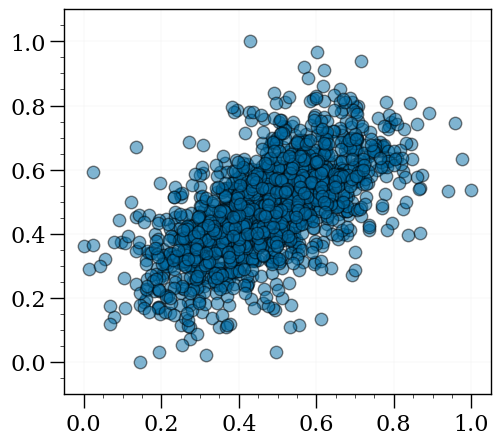

In [42]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [43]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [44]:
run(TrainingTensors, train_D, test_D, key, 'frank_5')

  0%|          | 1/10000 [01:26<238:59:40, 86.05s/it]

Iter 0. Loss [[0.38929546 0.239257   8.63668   ]]


  0%|          | 11/10000 [02:34<5:14:09,  1.89s/it]

Iter 10. Loss [[0.3799159  0.16367173 2.2762177 ]]


  0%|          | 21/10000 [02:38<59:57,  2.77it/s]  

Iter 20. Loss [[0.37485844 0.15192865 2.1915603 ]]


  0%|          | 31/10000 [02:41<56:34,  2.94it/s]

Iter 30. Loss [[0.34815434 0.10813589 2.1458163 ]]


  0%|          | 41/10000 [02:44<55:17,  3.00it/s]

Iter 40. Loss [[0.3437689  0.09975398 2.0969508 ]]


  1%|          | 51/10000 [02:48<1:01:31,  2.70it/s]

Iter 50. Loss [[0.33169422 0.09002919 2.0929213 ]]


  1%|          | 61/10000 [02:52<56:45,  2.92it/s]  

Iter 60. Loss [[0.33504534 0.09046251 2.0136452 ]]


  1%|          | 71/10000 [02:55<47:54,  3.45it/s]

Iter 70. Loss [[0.33485755 0.08896957 1.9276053 ]]


  1%|          | 81/10000 [02:58<1:03:36,  2.60it/s]

Iter 80. Loss [[0.32853237 0.08258917 1.847731  ]]


  1%|          | 91/10000 [03:03<58:38,  2.82it/s]  

Iter 90. Loss [[0.28323704 0.06360248 1.8325756 ]]


  1%|          | 101/10000 [03:06<1:06:56,  2.46it/s]

Iter 100. Loss [[0.19587503 0.06376439 1.6048028 ]]


  1%|          | 111/10000 [03:09<47:54,  3.44it/s]

Iter 110. Loss [[0.1464748  0.06469785 1.4019634 ]]


  1%|          | 121/10000 [03:13<57:14,  2.88it/s]

Iter 120. Loss [[0.20532691 0.05485706 1.4348502 ]]


  1%|▏         | 131/10000 [03:17<1:12:24,  2.27it/s]

Iter 130. Loss [[0.21245085 0.04906109 1.3502275 ]]


  1%|▏         | 141/10000 [03:20<51:55,  3.16it/s]

Iter 140. Loss [[0.1514194  0.04724077 1.1562177 ]]


  2%|▏         | 151/10000 [03:23<51:12,  3.21it/s]

Iter 150. Loss [[0.1310504  0.05096707 0.9108579 ]]


  2%|▏         | 161/10000 [03:27<52:02,  3.15it/s]

Iter 160. Loss [[0.1372873  0.04172767 0.76598585]]


  2%|▏         | 171/10000 [03:31<1:12:46,  2.25it/s]

Iter 170. Loss [[0.13081065 0.04700787 0.80936927]]


  2%|▏         | 181/10000 [03:34<49:29,  3.31it/s]

Iter 180. Loss [[0.13903643 0.03869582 0.68506527]]


  2%|▏         | 191/10000 [03:38<51:15,  3.19it/s]

Iter 190. Loss [[0.1318371 0.0377996 0.7340846]]


  2%|▏         | 201/10000 [03:41<1:18:52,  2.07it/s]

Iter 200. Loss [[0.11616659 0.04630514 1.0531638 ]]


  2%|▏         | 211/10000 [03:46<1:11:16,  2.29it/s]

Iter 210. Loss [[0.27673823 0.03626952 0.7839554 ]]


  2%|▏         | 221/10000 [03:49<48:47,  3.34it/s]

Iter 220. Loss [[0.12644991 0.047461   0.9397106 ]]


  2%|▏         | 231/10000 [03:52<1:00:45,  2.68it/s]

Iter 230. Loss [[0.13020645 0.08665867 1.5014249 ]]


  2%|▏         | 241/10000 [03:55<49:30,  3.29it/s]

Iter 240. Loss [[0.09350545 0.06703319 0.8846522 ]]


  3%|▎         | 251/10000 [04:00<1:12:00,  2.26it/s]

Iter 250. Loss [[0.0984176  0.19953644 2.9575856 ]]


  3%|▎         | 261/10000 [04:03<52:12,  3.11it/s]

Iter 260. Loss [[0.10863449 0.08564383 1.3178273 ]]


  3%|▎         | 271/10000 [04:06<45:55,  3.53it/s]

Iter 270. Loss [[0.21430752 0.03843214 1.1975025 ]]


  3%|▎         | 281/10000 [04:09<48:01,  3.37it/s]

Iter 280. Loss [[0.11996413 0.06127129 1.0029607 ]]


  3%|▎         | 291/10000 [04:14<1:13:53,  2.19it/s]

Iter 290. Loss [[0.127369   0.05512281 0.94785535]]


  3%|▎         | 301/10000 [04:17<59:02,  2.74it/s]  

Iter 300. Loss [[0.13710515 0.04708043 0.8428708 ]]


  3%|▎         | 311/10000 [04:20<49:07,  3.29it/s]

Iter 310. Loss [[0.13849775 0.0444279  0.75920004]]


  3%|▎         | 321/10000 [04:24<46:07,  3.50it/s]

Iter 320. Loss [[0.14706439 0.03899026 0.69581735]]


  3%|▎         | 331/10000 [04:28<1:19:29,  2.03it/s]

Iter 330. Loss [[0.14469178 0.03692184 0.6190146 ]]


  3%|▎         | 341/10000 [04:31<46:44,  3.44it/s]

Iter 340. Loss [[0.16519752 0.0325661  0.5175465 ]]


  4%|▎         | 351/10000 [04:34<50:09,  3.21it/s]

Iter 350. Loss [[0.15386622 0.03115865 0.4335636 ]]


  4%|▎         | 361/10000 [04:37<50:28,  3.18it/s]

Iter 360. Loss [[0.18333916 0.02995686 0.27658582]]


  4%|▎         | 371/10000 [04:41<1:03:32,  2.53it/s]

Iter 370. Loss [[0.18708158 0.03698507 0.20238149]]


  4%|▍         | 381/10000 [04:45<52:09,  3.07it/s]

Iter 380. Loss [[0.1547367  0.04276098 0.4562004 ]]


  4%|▍         | 391/10000 [04:48<51:44,  3.10it/s]

Iter 390. Loss [[0.22917454 0.03817149 0.13176979]]


  4%|▍         | 401/10000 [04:52<1:09:26,  2.30it/s]

Iter 400. Loss [[0.14514028 0.05058133 0.65802723]]


  4%|▍         | 411/10000 [04:55<1:08:09,  2.34it/s]

Iter 410. Loss [[0.13585432 0.04819353 0.78241503]]


  4%|▍         | 421/10000 [05:00<50:38,  3.15it/s]

Iter 420. Loss [[0.19224013 0.04182909 0.23120545]]


  4%|▍         | 431/10000 [05:03<57:38,  2.77it/s]  

Iter 430. Loss [[0.15789638 0.04553361 0.45323116]]


  4%|▍         | 441/10000 [05:06<45:17,  3.52it/s]

Iter 440. Loss [[0.10742697 0.27591452 5.3185163 ]]


  5%|▍         | 451/10000 [05:10<1:05:18,  2.44it/s]

Iter 450. Loss [[0.22551349 0.05837178 0.9697832 ]]


  5%|▍         | 461/10000 [05:14<1:01:42,  2.58it/s]

Iter 460. Loss [[0.18690653 0.05132252 0.4259518 ]]


  5%|▍         | 471/10000 [05:17<42:39,  3.72it/s]

Iter 470. Loss [[0.13248849 0.04568362 0.74735075]]


  5%|▍         | 481/10000 [05:20<43:04,  3.68it/s]

Iter 480. Loss [[0.22921906 0.02909957 0.52538425]]


  5%|▍         | 491/10000 [05:23<59:52,  2.65it/s]

Iter 490. Loss [[0.17093582 0.03675786 0.48350757]]


  5%|▌         | 501/10000 [05:28<1:16:35,  2.07it/s]

Iter 500. Loss [[0.16438603 0.03157064 0.45631072]]


  5%|▌         | 511/10000 [05:31<44:25,  3.56it/s]

Iter 510. Loss [[0.18163691 0.03215213 0.32503623]]


  5%|▌         | 521/10000 [05:34<45:50,  3.45it/s]

Iter 520. Loss [[0.22888088 0.04676411 0.3083131 ]]


  5%|▌         | 531/10000 [05:37<59:58,  2.63it/s]  

Iter 530. Loss [[0.1975824  0.04627061 0.2536475 ]]


  5%|▌         | 541/10000 [05:42<1:09:48,  2.26it/s]

Iter 540. Loss [[0.14662512 0.04255738 0.5827446 ]]


  6%|▌         | 551/10000 [05:46<50:17,  3.13it/s]

Iter 550. Loss [[0.20596969 0.05017934 0.06483013]]


  6%|▌         | 561/10000 [05:49<53:35,  2.94it/s]

Iter 560. Loss [[0.1875516  0.04749437 0.19565064]]


  6%|▌         | 571/10000 [05:52<45:06,  3.48it/s]

Iter 570. Loss [[0.1896876  0.05249655 0.17976497]]


  6%|▌         | 581/10000 [05:57<1:01:06,  2.57it/s]

Iter 580. Loss [[0.21513331 0.04992408 0.02804864]]


  6%|▌         | 591/10000 [06:00<48:47,  3.21it/s]

Iter 590. Loss [[ 0.22207695  0.05699694 -0.00954619]]


  6%|▌         | 601/10000 [06:04<1:13:47,  2.12it/s]

Iter 600. Loss [[ 0.41961658  0.9466538  10.882042  ]]


  6%|▌         | 611/10000 [06:06<48:33,  3.22it/s]

Iter 610. Loss [[0.0874629 0.2017707 4.194972 ]]


  6%|▌         | 621/10000 [06:11<1:03:14,  2.47it/s]

Iter 620. Loss [[0.11645673 0.28387004 6.732367  ]]


  6%|▋         | 631/10000 [06:14<56:32,  2.76it/s]  

Iter 630. Loss [[0.3008121  0.06230879 1.7024902 ]]


  6%|▋         | 641/10000 [06:17<49:00,  3.18it/s]

Iter 640. Loss [[0.23885776 0.0778022  1.9610479 ]]


  7%|▋         | 651/10000 [06:21<44:37,  3.49it/s]

Iter 650. Loss [[0.27876228 0.05457553 1.6373281 ]]


  7%|▋         | 661/10000 [06:25<1:19:38,  1.95it/s]

Iter 660. Loss [[0.24194662 0.05185211 1.4030973 ]]


  7%|▋         | 671/10000 [06:28<42:57,  3.62it/s]

Iter 670. Loss [[0.23629805 0.04607828 1.3228868 ]]


  7%|▋         | 681/10000 [06:31<48:33,  3.20it/s]

Iter 680. Loss [[0.21145856 0.04567557 1.1955017 ]]


  7%|▋         | 691/10000 [06:35<54:45,  2.83it/s]

Iter 690. Loss [[0.16361545 0.04572091 1.1266059 ]]


  7%|▋         | 701/10000 [06:39<1:06:54,  2.32it/s]

Iter 700. Loss [[0.166817   0.04442957 1.0962421 ]]


  7%|▋         | 711/10000 [06:43<45:07,  3.43it/s]

Iter 710. Loss [[0.13412309 0.048705   0.9445283 ]]


  7%|▋         | 721/10000 [06:46<51:36,  3.00it/s]

Iter 720. Loss [[0.11877128 0.06560147 1.5833746 ]]


  7%|▋         | 731/10000 [06:49<1:03:33,  2.43it/s]

Iter 730. Loss [[0.17832203 0.05805666 1.0887076 ]]


  7%|▋         | 741/10000 [06:53<1:08:08,  2.26it/s]

Iter 740. Loss [[0.2399542 0.0628299 1.0442116]]


  8%|▊         | 751/10000 [06:57<48:22,  3.19it/s]

Iter 750. Loss [[0.19991381 0.05612922 0.9144194 ]]


  8%|▊         | 761/10000 [07:00<1:02:50,  2.45it/s]

Iter 760. Loss [[0.20018756 0.05607466 0.8621864 ]]


  8%|▊         | 771/10000 [07:03<45:41,  3.37it/s]

Iter 770. Loss [[0.21877633 0.05793435 0.7972559 ]]


  8%|▊         | 781/10000 [07:08<1:11:57,  2.14it/s]

Iter 780. Loss [[0.21826337 0.05401119 0.801938  ]]


  8%|▊         | 791/10000 [07:12<1:03:25,  2.42it/s]

Iter 790. Loss [[0.21903099 0.04612758 0.7550027 ]]


  8%|▊         | 801/10000 [07:15<46:57,  3.27it/s]

Iter 800. Loss [[0.20827919 0.04283771 0.7318848 ]]


  8%|▊         | 811/10000 [07:18<46:55,  3.26it/s]

Iter 810. Loss [[0.22521144 0.04700992 0.6912365 ]]


  8%|▊         | 821/10000 [07:23<1:20:51,  1.89it/s]

Iter 820. Loss [[0.21654274 0.04030431 0.64026934]]


  8%|▊         | 831/10000 [07:26<45:53,  3.33it/s]

Iter 830. Loss [[0.22927698 0.03606274 0.60074294]]


  8%|▊         | 841/10000 [07:29<45:51,  3.33it/s]

Iter 840. Loss [[0.22928706 0.03564914 0.54184926]]


  9%|▊         | 851/10000 [07:33<49:30,  3.08it/s]

Iter 850. Loss [[0.22174856 0.03075451 0.48203823]]


  9%|▊         | 861/10000 [07:37<1:28:52,  1.71it/s]

Iter 860. Loss [[0.24253951 0.04420763 2.0449066 ]]


  9%|▊         | 871/10000 [07:40<44:28,  3.42it/s]

Iter 870. Loss [[0.26152053 0.03079163 0.61731315]]


  9%|▉         | 881/10000 [07:44<50:01,  3.04it/s]

Iter 880. Loss [[0.25983655 0.04002897 1.1407354 ]]


  9%|▉         | 891/10000 [07:47<53:32,  2.84it/s]

Iter 890. Loss [[0.24597587 0.02755171 0.6800085 ]]


  9%|▉         | 901/10000 [07:51<1:03:33,  2.39it/s]

Iter 900. Loss [[0.23909706 0.0281557  0.60409963]]


  9%|▉         | 911/10000 [07:55<48:09,  3.15it/s]

Iter 910. Loss [[0.2361289  0.03286641 0.51852435]]


  9%|▉         | 921/10000 [07:58<52:41,  2.87it/s]

Iter 920. Loss [[0.23141506 0.03493658 0.4820238 ]]


  9%|▉         | 931/10000 [08:01<44:09,  3.42it/s]

Iter 930. Loss [[0.20929855 0.03078636 0.4564875 ]]


  9%|▉         | 941/10000 [08:05<1:00:47,  2.48it/s]

Iter 940. Loss [[0.20965451 0.03004594 0.42571908]]


 10%|▉         | 951/10000 [08:09<52:18,  2.88it/s]

Iter 950. Loss [[0.19978018 0.0285779  0.414545  ]]


 10%|▉         | 961/10000 [08:12<1:00:05,  2.51it/s]

Iter 960. Loss [[0.21099612 0.02978318 0.39410782]]


 10%|▉         | 971/10000 [08:15<42:15,  3.56it/s]

Iter 970. Loss [[0.17174733 0.04286198 0.5375861 ]]


 10%|▉         | 981/10000 [08:18<56:29,  2.66it/s]

Iter 980. Loss [[0.18204533 0.03479465 0.3946558 ]]


 10%|▉         | 991/10000 [08:23<1:10:27,  2.13it/s]

Iter 990. Loss [[0.21974726 0.02934679 0.36395034]]


 10%|█         | 1001/10000 [08:26<45:42,  3.28it/s]

Iter 1000. Loss [[0.234688   0.03219516 0.347177  ]]


 10%|█         | 1011/10000 [08:29<47:40,  3.14it/s]

Iter 1010. Loss [[0.2162555  0.03226463 0.33555686]]


 10%|█         | 1021/10000 [08:34<1:13:56,  2.02it/s]

Iter 1020. Loss [[0.18932875 0.03420902 0.39560413]]


 10%|█         | 1031/10000 [08:37<49:28,  3.02it/s]

Iter 1030. Loss [[0.23649448 0.03606359 0.3524399 ]]


 10%|█         | 1041/10000 [08:41<41:38,  3.59it/s]

Iter 1040. Loss [[0.11565727 0.09327455 1.5071284 ]]


 11%|█         | 1051/10000 [08:44<44:36,  3.34it/s]

Iter 1050. Loss [[0.11409099 0.11346623 1.5295755 ]]


 11%|█         | 1061/10000 [08:47<44:12,  3.37it/s]

Iter 1060. Loss [[0.21624418 0.06843287 0.7164069 ]]


 11%|█         | 1071/10000 [08:52<56:44,  2.62it/s]  

Iter 1070. Loss [[0.19902168 0.06448568 0.8336246 ]]


 11%|█         | 1081/10000 [08:55<45:40,  3.25it/s]

Iter 1080. Loss [[0.20367998 0.03889059 0.66123545]]


 11%|█         | 1091/10000 [08:58<1:04:59,  2.28it/s]

Iter 1090. Loss [[0.24205428 0.02539461 0.45097908]]


 11%|█         | 1101/10000 [09:01<44:30,  3.33it/s]

Iter 1100. Loss [[0.27169964 0.0368094  0.51402897]]


 11%|█         | 1111/10000 [09:06<1:04:01,  2.31it/s]

Iter 1110. Loss [[0.26085344 0.03132852 0.3943282 ]]


 11%|█         | 1121/10000 [09:09<48:38,  3.04it/s]

Iter 1120. Loss [[0.21405004 0.03016221 0.510362  ]]


 11%|█▏        | 1131/10000 [09:12<38:38,  3.82it/s]

Iter 1130. Loss [[0.23020743 0.02890066 0.4316548 ]]


 11%|█▏        | 1141/10000 [09:15<40:10,  3.68it/s]

Iter 1140. Loss [[0.2530322  0.03442769 0.3404206 ]]


 12%|█▏        | 1151/10000 [09:19<1:11:24,  2.07it/s]

Iter 1150. Loss [[0.25640982 0.03275834 0.33294725]]


 12%|█▏        | 1161/10000 [09:22<41:25,  3.56it/s]

Iter 1160. Loss [[0.2503881  0.03196733 0.34415323]]


 12%|█▏        | 1171/10000 [09:25<39:52,  3.69it/s]

Iter 1170. Loss [[0.26117194 0.03371051 0.30607232]]


 12%|█▏        | 1181/10000 [09:28<43:24,  3.39it/s]

Iter 1180. Loss [[0.26725286 0.02934333 0.29920796]]


 12%|█▏        | 1191/10000 [09:32<1:14:45,  1.96it/s]

Iter 1190. Loss [[0.28303352 0.02936459 0.32062665]]


 12%|█▏        | 1201/10000 [09:36<49:27,  2.97it/s]

Iter 1200. Loss [[0.29280287 0.03516356 0.2952638 ]]


 12%|█▏        | 1211/10000 [09:39<43:36,  3.36it/s]

Iter 1210. Loss [[0.3146823  0.06133498 0.48470467]]


 12%|█▏        | 1221/10000 [09:42<52:35,  2.78it/s]

Iter 1220. Loss [[0.30889973 0.04624696 0.36496794]]


 12%|█▏        | 1231/10000 [09:45<44:25,  3.29it/s]

Iter 1230. Loss [[0.29009122 0.03762065 0.2523514 ]]


 12%|█▏        | 1241/10000 [09:50<1:03:33,  2.30it/s]

Iter 1240. Loss [[0.27573407 0.04085993 0.28850722]]


 13%|█▎        | 1251/10000 [09:53<59:17,  2.46it/s]  

Iter 1250. Loss [[0.28090426 0.03521185 0.29913297]]


 13%|█▎        | 1261/10000 [09:56<41:25,  3.52it/s]

Iter 1260. Loss [[0.28829563 0.03481699 0.2788763 ]]


 13%|█▎        | 1271/10000 [09:59<41:52,  3.47it/s]

Iter 1270. Loss [[0.29337406 0.04091723 0.2364805 ]]


 13%|█▎        | 1281/10000 [10:04<1:06:08,  2.20it/s]

Iter 1280. Loss [[0.29551405 0.04273648 0.21183746]]


 13%|█▎        | 1291/10000 [10:07<43:04,  3.37it/s]

Iter 1290. Loss [[0.2948105  0.03897766 0.2139283 ]]


 13%|█▎        | 1301/10000 [10:11<44:01,  3.29it/s]

Iter 1300. Loss [[0.2954707  0.03907114 0.19246769]]


 13%|█▎        | 1311/10000 [10:14<41:14,  3.51it/s]

Iter 1310. Loss [[0.29589733 0.03859068 0.18311577]]


 13%|█▎        | 1321/10000 [10:18<1:23:59,  1.72it/s]

Iter 1320. Loss [[0.2953947  0.03778666 0.17856176]]


 13%|█▎        | 1331/10000 [10:21<39:27,  3.66it/s]

Iter 1330. Loss [[0.29441735 0.03635933 0.17742246]]


 13%|█▎        | 1341/10000 [10:25<46:43,  3.09it/s]

Iter 1340. Loss [[0.29512134 0.03631523 0.17182544]]


 14%|█▎        | 1351/10000 [10:28<49:30,  2.91it/s]

Iter 1350. Loss [[0.29654178 0.03673776 0.16143379]]


 14%|█▎        | 1361/10000 [10:32<1:00:20,  2.39it/s]

Iter 1360. Loss [[0.2971394  0.0365211  0.15716471]]


 14%|█▎        | 1371/10000 [10:35<41:24,  3.47it/s]

Iter 1370. Loss [[0.29741973 0.03613176 0.15277942]]


 14%|█▍        | 1381/10000 [10:38<45:31,  3.16it/s]

Iter 1380. Loss [[0.28968596 0.0268803  0.26797417]]


 14%|█▍        | 1391/10000 [10:41<42:33,  3.37it/s]

Iter 1390. Loss [[0.3040356  0.03521756 0.16049205]]


 14%|█▍        | 1401/10000 [10:45<1:00:43,  2.36it/s]

Iter 1400. Loss [[ 0.18371361  0.30413425 19.7873    ]]


 14%|█▍        | 1411/10000 [10:49<48:14,  2.97it/s]

Iter 1410. Loss [[ 0.18292595  0.30413485 19.922022  ]]


 14%|█▍        | 1421/10000 [10:53<1:09:33,  2.06it/s]

Iter 1420. Loss [[ 0.18252155  0.30413476 19.902224  ]]


 14%|█▍        | 1431/10000 [10:56<43:45,  3.26it/s]

Iter 1430. Loss [[ 0.18221258  0.30413392 19.834326  ]]


 14%|█▍        | 1441/10000 [11:00<1:00:17,  2.37it/s]

Iter 1440. Loss [[ 0.18127729  0.3040932  18.603394  ]]


 15%|█▍        | 1451/10000 [11:04<54:37,  2.61it/s]

Iter 1450. Loss [[0.18427311 0.08605763 1.5400859 ]]


 15%|█▍        | 1461/10000 [11:06<38:17,  3.72it/s]

Iter 1460. Loss [[0.31315506 0.07740414 1.276015  ]]


 15%|█▍        | 1471/10000 [11:10<39:40,  3.58it/s]

Iter 1470. Loss [[0.29157043 0.06379889 1.4176579 ]]


 15%|█▍        | 1481/10000 [11:14<1:04:56,  2.19it/s]

Iter 1480. Loss [[0.3352222  0.08215031 1.0648444 ]]


 15%|█▍        | 1491/10000 [11:18<46:57,  3.02it/s]

Iter 1490. Loss [[0.3265306  0.07730325 1.0272843 ]]


 15%|█▌        | 1501/10000 [11:21<38:28,  3.68it/s]

Iter 1500. Loss [[0.3049799  0.07364938 1.1226459 ]]


 15%|█▌        | 1511/10000 [11:24<39:33,  3.58it/s]

Iter 1510. Loss [[0.27477756 0.04702262 1.0959438 ]]


 15%|█▌        | 1521/10000 [11:27<56:15,  2.51it/s]

Iter 1520. Loss [[0.2766025  0.03228615 0.93873125]]


 15%|█▌        | 1531/10000 [11:31<1:01:51,  2.28it/s]

Iter 1530. Loss [[0.2722361  0.03200344 1.1386886 ]]


 15%|█▌        | 1541/10000 [11:34<39:07,  3.60it/s]

Iter 1540. Loss [[0.26960713 0.04589245 0.99971586]]


 16%|█▌        | 1551/10000 [11:37<51:12,  2.75it/s]

Iter 1550. Loss [[0.29778638 0.04283104 0.9193699 ]]


 16%|█▌        | 1561/10000 [11:40<40:51,  3.44it/s]

Iter 1560. Loss [[0.29950416 0.03883702 0.87386394]]


 16%|█▌        | 1571/10000 [11:45<1:00:48,  2.31it/s]

Iter 1570. Loss [[0.30793828 0.03717226 0.7823103 ]]


 16%|█▌        | 1581/10000 [11:48<45:54,  3.06it/s]

Iter 1580. Loss [[0.30344573 0.02761734 0.68475485]]


 16%|█▌        | 1591/10000 [11:51<42:30,  3.30it/s]

Iter 1590. Loss [[0.28137812 0.03612456 0.7946216 ]]


 16%|█▌        | 1601/10000 [11:55<41:19,  3.39it/s]

Iter 1600. Loss [[0.29429826 0.02791897 0.73165095]]


 16%|█▌        | 1611/10000 [11:59<1:02:34,  2.23it/s]

Iter 1610. Loss [[0.31971294 0.03842078 0.7347993 ]]


 16%|█▌        | 1621/10000 [12:03<55:40,  2.51it/s]

Iter 1620. Loss [[0.28965777 0.03369486 0.7458391 ]]


 16%|█▋        | 1631/10000 [12:05<37:26,  3.73it/s]

Iter 1630. Loss [[0.27086425 0.05173881 0.92398125]]


 16%|█▋        | 1641/10000 [12:08<38:13,  3.64it/s]

Iter 1640. Loss [[0.2790557 0.0495317 0.8569713]]


 17%|█▋        | 1651/10000 [12:11<58:42,  2.37it/s]

Iter 1650. Loss [[0.29321438 0.04316784 0.7493651 ]]


 17%|█▋        | 1661/10000 [12:15<50:57,  2.73it/s]

Iter 1660. Loss [[0.3004515  0.03623073 0.6518031 ]]


 17%|█▋        | 1671/10000 [12:19<39:14,  3.54it/s]

Iter 1670. Loss [[0.30566475 0.03069865 0.5623796 ]]


 17%|█▋        | 1681/10000 [12:22<54:33,  2.54it/s]

Iter 1680. Loss [[0.30691433 0.0237314  0.4712965 ]]


 17%|█▋        | 1691/10000 [12:25<37:31,  3.69it/s]

Iter 1690. Loss [[0.30075443 0.01764323 0.930638  ]]


 17%|█▋        | 1701/10000 [12:30<1:00:58,  2.27it/s]

Iter 1700. Loss [[0.30808485 0.01728679 0.49534142]]


 17%|█▋        | 1711/10000 [12:33<42:34,  3.24it/s]

Iter 1710. Loss [[0.31727743 0.02729142 0.4494577 ]]


 17%|█▋        | 1721/10000 [12:35<37:34,  3.67it/s]

Iter 1720. Loss [[0.32228962 0.03170957 0.5002163 ]]


 17%|█▋        | 1731/10000 [12:39<40:36,  3.39it/s]

Iter 1730. Loss [[0.3177824  0.0278125  0.42695272]]


 17%|█▋        | 1741/10000 [12:43<1:04:53,  2.12it/s]

Iter 1740. Loss [[0.30859804 0.0247215  0.39223665]]


 18%|█▊        | 1751/10000 [12:46<49:52,  2.76it/s]

Iter 1750. Loss [[0.31108427 0.02480343 0.36608553]]


 18%|█▊        | 1761/10000 [12:49<36:06,  3.80it/s]

Iter 1760. Loss [[0.3123947  0.02426528 0.32760522]]


 18%|█▊        | 1771/10000 [12:52<38:02,  3.61it/s]

Iter 1770. Loss [[0.31148246 0.02507949 0.35619497]]


 18%|█▊        | 1781/10000 [12:56<1:01:55,  2.21it/s]

Iter 1780. Loss [[0.30418834 0.02631395 0.3505769 ]]


 18%|█▊        | 1791/10000 [12:59<42:40,  3.21it/s]

Iter 1790. Loss [[0.31272945 0.0252104  0.34460732]]


 18%|█▊        | 1801/10000 [13:03<37:10,  3.68it/s]

Iter 1800. Loss [[0.319676   0.03321377 0.33219033]]


 18%|█▊        | 1811/10000 [13:06<40:31,  3.37it/s]

Iter 1810. Loss [[0.22724262 0.12038878 3.9853184 ]]


 18%|█▊        | 1821/10000 [13:08<36:12,  3.76it/s]

Iter 1820. Loss [[0.24343064 0.04741017 0.7204095 ]]


 18%|█▊        | 1831/10000 [13:13<1:00:30,  2.25it/s]

Iter 1830. Loss [[0.29641083 0.0399794  0.53949136]]


 18%|█▊        | 1841/10000 [13:16<39:24,  3.45it/s]

Iter 1840. Loss [[0.29120925 0.02930791 0.50013685]]


 19%|█▊        | 1851/10000 [13:19<47:00,  2.89it/s]

Iter 1850. Loss [[0.29656735 0.02754904 0.45676893]]


 19%|█▊        | 1861/10000 [13:22<35:37,  3.81it/s]

Iter 1860. Loss [[0.30511492 0.02934645 0.4049576 ]]


 19%|█▊        | 1871/10000 [13:25<56:25,  2.40it/s]

Iter 1870. Loss [[0.30463994 0.02682799 0.38246784]]


 19%|█▉        | 1881/10000 [13:29<49:12,  2.75it/s]

Iter 1880. Loss [[0.30811313 0.02797971 0.35232568]]


 19%|█▉        | 1891/10000 [13:32<38:24,  3.52it/s]

Iter 1890. Loss [[0.30746624 0.02801654 0.38439298]]


 19%|█▉        | 1901/10000 [13:35<36:06,  3.74it/s]

Iter 1900. Loss [[0.30188885 0.02857272 0.38009456]]


 19%|█▉        | 1911/10000 [13:38<43:58,  3.07it/s]

Iter 1910. Loss [[0.30273828 0.03052627 0.34823185]]


 19%|█▉        | 1921/10000 [13:42<57:30,  2.34it/s]

Iter 1920. Loss [[0.30172434 0.0304975  0.39175847]]


 19%|█▉        | 1931/10000 [13:45<36:25,  3.69it/s]

Iter 1930. Loss [[0.302753   0.03239007 0.40437117]]


 19%|█▉        | 1941/10000 [13:49<40:51,  3.29it/s]

Iter 1940. Loss [[0.302903   0.03215812 0.39677206]]


 20%|█▉        | 1951/10000 [13:52<57:51,  2.32it/s]

Iter 1950. Loss [[0.3050474  0.02983036 0.35443315]]


 20%|█▉        | 1961/10000 [13:56<56:12,  2.38it/s]

Iter 1960. Loss [[0.30903175 0.02930995 0.33885342]]


 20%|█▉        | 1971/10000 [13:59<39:31,  3.39it/s]

Iter 1970. Loss [[0.3090134  0.02696442 0.33837366]]


 20%|█▉        | 1981/10000 [14:03<56:19,  2.37it/s]  

Iter 1980. Loss [[0.31202948 0.02714085 0.32663354]]


 20%|█▉        | 1991/10000 [14:05<40:10,  3.32it/s]

Iter 1990. Loss [[0.31503338 0.02814876 0.31479952]]


 20%|██        | 2001/10000 [14:10<55:55,  2.38it/s]

Iter 2000. Loss [[0.31462535 0.02724438 0.31565505]]


 20%|██        | 2011/10000 [14:13<43:36,  3.05it/s]

Iter 2010. Loss [[0.315284   0.02790962 0.308988  ]]


 20%|██        | 2021/10000 [14:16<34:57,  3.80it/s]

Iter 2020. Loss [[0.3156008  0.02788256 0.305557  ]]


 20%|██        | 2031/10000 [14:19<39:28,  3.36it/s]

Iter 2030. Loss [[0.31573996 0.02798778 0.3007446 ]]


 20%|██        | 2041/10000 [14:23<54:16,  2.44it/s]

Iter 2040. Loss [[0.31573227 0.02785029 0.29718846]]


 21%|██        | 2051/10000 [14:27<1:02:31,  2.12it/s]

Iter 2050. Loss [[0.31594473 0.02784558 0.29312333]]


 21%|██        | 2061/10000 [14:30<38:11,  3.46it/s]

Iter 2060. Loss [[0.31621906 0.02784998 0.289037  ]]


 21%|██        | 2071/10000 [14:33<37:30,  3.52it/s]

Iter 2070. Loss [[0.31644318 0.02777459 0.2853571 ]]


 21%|██        | 2081/10000 [14:36<52:23,  2.52it/s]

Iter 2080. Loss [[0.31666076 0.02766936 0.28131258]]


 21%|██        | 2091/10000 [14:41<57:38,  2.29it/s]

Iter 2090. Loss [[0.31687847 0.02749226 0.27754784]]


 21%|██        | 2101/10000 [14:44<41:01,  3.21it/s]

Iter 2100. Loss [[0.3171408  0.02732004 0.27462554]]


 21%|██        | 2111/10000 [14:47<40:24,  3.25it/s]

Iter 2110. Loss [[0.31748423 0.02726576 0.27108663]]


 21%|██        | 2121/10000 [14:50<37:52,  3.47it/s]

Iter 2120. Loss [[0.31756377 0.02717763 0.26970768]]


 21%|██▏       | 2131/10000 [14:55<58:00,  2.26it/s]

Iter 2130. Loss [[0.3178495  0.02720132 0.26676315]]


 21%|██▏       | 2141/10000 [14:58<40:15,  3.25it/s]

Iter 2140. Loss [[0.31801525 0.02725345 0.2649678 ]]


 22%|██▏       | 2151/10000 [15:01<50:12,  2.61it/s]

Iter 2150. Loss [[0.3182433  0.02732297 0.26259878]]


 22%|██▏       | 2161/10000 [15:04<37:38,  3.47it/s]

Iter 2160. Loss [[0.31853232 0.02736418 0.25971487]]


 22%|██▏       | 2171/10000 [15:08<55:18,  2.36it/s]

Iter 2170. Loss [[0.31849572 0.0278021  0.25747338]]


 22%|██▏       | 2181/10000 [15:12<50:14,  2.59it/s]

Iter 2180. Loss [[0.31846285 0.02682816 0.25947836]]


 22%|██▏       | 2191/10000 [15:14<34:54,  3.73it/s]

Iter 2190. Loss [[0.31890634 0.02721837 0.2545896 ]]


 22%|██▏       | 2201/10000 [15:18<39:25,  3.30it/s]

Iter 2200. Loss [[0.31870377 0.02660146 0.2545024 ]]


 22%|██▏       | 2211/10000 [15:21<48:31,  2.68it/s]

Iter 2210. Loss [[0.31900904 0.02667114 0.2506902 ]]


 22%|██▏       | 2221/10000 [15:25<49:44,  2.61it/s]

Iter 2220. Loss [[0.31927955 0.02642778 0.2483657 ]]


 22%|██▏       | 2231/10000 [15:28<40:44,  3.18it/s]

Iter 2230. Loss [[0.3194529  0.02624053 0.24553593]]


 22%|██▏       | 2241/10000 [15:32<38:28,  3.36it/s]

Iter 2240. Loss [[0.3195914  0.02590844 0.24276845]]


 23%|██▎       | 2251/10000 [15:35<50:06,  2.58it/s]

Iter 2250. Loss [[0.31981245 0.02556215 0.23880659]]


 23%|██▎       | 2261/10000 [15:39<55:07,  2.34it/s]

Iter 2260. Loss [[0.31639722 0.02891395 0.2447221 ]]


 23%|██▎       | 2271/10000 [15:42<37:40,  3.42it/s]

Iter 2270. Loss [[0.31597957 0.02348397 0.23761214]]


 23%|██▎       | 2281/10000 [15:45<53:07,  2.42it/s]  

Iter 2280. Loss [[0.32181644 0.02159393 0.20565401]]


 23%|██▎       | 2291/10000 [15:48<38:00,  3.38it/s]

Iter 2290. Loss [[0.32121205 0.01694693 0.17306986]]


 23%|██▎       | 2301/10000 [15:53<56:38,  2.27it/s]

Iter 2300. Loss [[0.32349885 0.01758648 1.6101085 ]]


 23%|██▎       | 2311/10000 [15:56<48:26,  2.65it/s]

Iter 2310. Loss [[0.30809823 0.04732327 0.6095778 ]]


 23%|██▎       | 2321/10000 [15:59<37:37,  3.40it/s]

Iter 2320. Loss [[0.3190509  0.02047865 1.2093275 ]]


 23%|██▎       | 2331/10000 [16:03<36:07,  3.54it/s]

Iter 2330. Loss [[0.3374851  0.04492246 0.48947394]]


 23%|██▎       | 2341/10000 [16:07<55:54,  2.28it/s]

Iter 2340. Loss [[0.33232015 0.02344152 0.32080385]]


 24%|██▎       | 2351/10000 [16:10<36:34,  3.49it/s]

Iter 2350. Loss [[0.329176  0.0215169 0.3217103]]


 24%|██▎       | 2361/10000 [16:13<34:30,  3.69it/s]

Iter 2360. Loss [[0.3307043  0.02707808 0.26572135]]


 24%|██▎       | 2371/10000 [16:16<38:10,  3.33it/s]

Iter 2370. Loss [[0.32692656 0.02381453 0.26706225]]


 24%|██▍       | 2381/10000 [16:19<53:14,  2.38it/s]

Iter 2380. Loss [[0.32664418 0.02550605 0.26009607]]


 24%|██▍       | 2391/10000 [16:23<49:39,  2.55it/s]

Iter 2390. Loss [[0.32740444 0.02315407 0.27102348]]


 24%|██▍       | 2401/10000 [16:26<35:21,  3.58it/s]

Iter 2400. Loss [[0.33370334 0.02616916 0.25970253]]


 24%|██▍       | 2411/10000 [16:29<43:09,  2.93it/s]

Iter 2410. Loss [[0.3336982  0.02426965 0.26385018]]


 24%|██▍       | 2421/10000 [16:32<33:31,  3.77it/s]

Iter 2420. Loss [[0.33288047 0.02411091 0.26112363]]


 24%|██▍       | 2431/10000 [16:36<53:42,  2.35it/s]

Iter 2430. Loss [[0.33299887 0.02396451 0.2575258 ]]


 24%|██▍       | 2441/10000 [16:40<38:33,  3.27it/s]

Iter 2440. Loss [[0.33364224 0.02375671 0.25365257]]


 25%|██▍       | 2451/10000 [16:43<33:27,  3.76it/s]

Iter 2450. Loss [[0.3339472 0.0235876 0.2500264]]


 25%|██▍       | 2461/10000 [16:46<33:33,  3.75it/s]

Iter 2460. Loss [[0.3343671  0.02414766 0.23495121]]


 25%|██▍       | 2471/10000 [16:49<49:46,  2.52it/s]

Iter 2470. Loss [[0.33441022 0.02266985 0.23654883]]


 25%|██▍       | 2481/10000 [16:53<55:02,  2.28it/s]  

Iter 2480. Loss [[0.3346678  0.022464   0.23317774]]


 25%|██▍       | 2491/10000 [16:56<36:36,  3.42it/s]

Iter 2490. Loss [[0.33478734 0.02231762 0.23032592]]


 25%|██▌       | 2501/10000 [16:59<34:33,  3.62it/s]

Iter 2500. Loss [[0.33505318 0.02177623 0.22948462]]


 25%|██▌       | 2511/10000 [17:02<39:36,  3.15it/s]

Iter 2510. Loss [[0.33520547 0.02151222 0.22772871]]


 25%|██▌       | 2521/10000 [17:07<53:59,  2.31it/s]

Iter 2520. Loss [[0.33534592 0.02117828 0.22634745]]


 25%|██▌       | 2531/10000 [17:10<34:57,  3.56it/s]

Iter 2530. Loss [[0.3355562  0.02088089 0.22481443]]


 25%|██▌       | 2541/10000 [17:13<40:26,  3.07it/s]

Iter 2540. Loss [[0.3357885  0.02062337 0.22347106]]


 26%|██▌       | 2551/10000 [17:15<32:34,  3.81it/s]

Iter 2550. Loss [[0.3359618  0.02032148 0.22278199]]


 26%|██▌       | 2561/10000 [17:19<51:35,  2.40it/s]

Iter 2560. Loss [[0.33616093 0.02009589 0.22151816]]


 26%|██▌       | 2571/10000 [17:23<38:11,  3.24it/s]

Iter 2570. Loss [[0.33632857 0.01985426 0.22083521]]


 26%|██▌       | 2581/10000 [17:27<44:57,  2.75it/s]

Iter 2580. Loss [[0.33598462 0.02493999 0.20563719]]


 26%|██▌       | 2591/10000 [17:29<33:54,  3.64it/s]

Iter 2590. Loss [[0.33602318 0.01878757 0.20957765]]


 26%|██▌       | 2601/10000 [17:33<47:06,  2.62it/s]

Iter 2600. Loss [[0.3324189  0.016666   0.24665734]]


 26%|██▌       | 2611/10000 [17:37<49:06,  2.51it/s]

Iter 2610. Loss [[0.33428684 0.0173825  0.21810998]]


 26%|██▌       | 2621/10000 [17:40<35:50,  3.43it/s]

Iter 2620. Loss [[0.3391425  0.01676492 0.22315235]]


 26%|██▋       | 2631/10000 [17:43<36:53,  3.33it/s]

Iter 2630. Loss [[0.3413155  0.01786481 0.20997408]]


 26%|██▋       | 2641/10000 [17:47<44:38,  2.75it/s]

Iter 2640. Loss [[0.3412876  0.01672982 0.21015002]]


 27%|██▋       | 2651/10000 [17:52<1:12:48,  1.68it/s]

Iter 2650. Loss [[0.34214112 0.01647878 0.20658392]]


 27%|██▋       | 2661/10000 [17:54<37:06,  3.30it/s]

Iter 2660. Loss [[0.34243718 0.01567401 0.2061689 ]]


 27%|██▋       | 2671/10000 [17:58<38:54,  3.14it/s]

Iter 2670. Loss [[0.34306705 0.01537685 0.2034364 ]]


 27%|██▋       | 2681/10000 [18:01<50:35,  2.41it/s]

Iter 2680. Loss [[0.34358752 0.0147931  0.20278762]]


 27%|██▋       | 2691/10000 [18:05<52:26,  2.32it/s]

Iter 2690. Loss [[0.34406146 0.01433545 0.20184082]]


 27%|██▋       | 2701/10000 [18:09<34:09,  3.56it/s]

Iter 2700. Loss [[0.34448162 0.01385587 0.20142913]]


 27%|██▋       | 2711/10000 [18:12<39:27,  3.08it/s]

Iter 2710. Loss [[0.34481883 0.01337429 0.20194796]]


 27%|██▋       | 2721/10000 [18:14<33:43,  3.60it/s]

Iter 2720. Loss [[0.34503886 0.0129529  0.20284843]]


 27%|██▋       | 2731/10000 [18:19<52:18,  2.32it/s]

Iter 2730. Loss [[0.34510368 0.01257983 0.20465775]]


 27%|██▋       | 2741/10000 [18:22<39:17,  3.08it/s]

Iter 2740. Loss [[0.344996   0.01227168 0.2065066 ]]


 28%|██▊       | 2751/10000 [18:25<33:22,  3.62it/s]

Iter 2750. Loss [[0.34497333 0.01216172 0.21602814]]


 28%|██▊       | 2761/10000 [18:28<33:51,  3.56it/s]

Iter 2760. Loss [[0.33808044 0.01819277 0.20549217]]


 28%|██▊       | 2771/10000 [18:32<51:17,  2.35it/s]

Iter 2770. Loss [[0.3479612  0.01505549 0.28593618]]


 28%|██▊       | 2781/10000 [18:36<52:47,  2.28it/s]

Iter 2780. Loss [[0.34512773 0.01398917 0.22256747]]


 28%|██▊       | 2791/10000 [18:39<32:17,  3.72it/s]

Iter 2790. Loss [[0.34130344 0.01591124 0.19377628]]


 28%|██▊       | 2801/10000 [18:42<35:54,  3.34it/s]

Iter 2800. Loss [[0.34741324 0.01406932 0.22332013]]


 28%|██▊       | 2811/10000 [18:46<59:19,  2.02it/s]

Iter 2810. Loss [[0.34601837 0.01449828 0.20209526]]


 28%|██▊       | 2821/10000 [18:50<45:05,  2.65it/s]

Iter 2820. Loss [[0.3443866  0.01359429 0.19212535]]


 28%|██▊       | 2831/10000 [18:53<36:02,  3.32it/s]

Iter 2830. Loss [[0.34455013 0.01344245 0.19244161]]


 28%|██▊       | 2841/10000 [18:56<39:11,  3.04it/s]

Iter 2840. Loss [[0.34455356 0.01321677 0.19221976]]


 29%|██▊       | 2851/10000 [18:59<32:07,  3.71it/s]

Iter 2850. Loss [[0.3447739  0.01269739 0.1918868 ]]


 29%|██▊       | 2861/10000 [19:03<52:27,  2.27it/s]

Iter 2860. Loss [[0.34491634 0.01156832 0.19057703]]


 29%|██▊       | 2871/10000 [19:07<36:43,  3.23it/s]

Iter 2870. Loss [[0.34465933 0.01053785 0.1909295 ]]


 29%|██▉       | 2881/10000 [19:10<47:03,  2.52it/s]

Iter 2880. Loss [[0.34450012 0.01623037 0.2216862 ]]


 29%|██▉       | 2891/10000 [19:12<31:57,  3.71it/s]

Iter 2890. Loss [[0.34399414 0.01389773 0.19690727]]


 29%|██▉       | 2901/10000 [19:16<51:34,  2.29it/s]

Iter 2900. Loss [[0.3429987  0.01580847 0.19012724]]


 29%|██▉       | 2911/10000 [19:21<50:16,  2.35it/s]

Iter 2910. Loss [[0.35075644 0.0141625  0.23250102]]


 29%|██▉       | 2921/10000 [19:23<31:59,  3.69it/s]

Iter 2920. Loss [[0.3440556  0.01392904 0.19592023]]


 29%|██▉       | 2931/10000 [19:26<32:49,  3.59it/s]

Iter 2930. Loss [[0.34666184 0.01766664 0.1901156 ]]


 29%|██▉       | 2941/10000 [19:30<51:20,  2.29it/s]

Iter 2940. Loss [[0.34353745 0.0127223  0.21030281]]


 30%|██▉       | 2951/10000 [19:34<40:52,  2.87it/s]

Iter 2950. Loss [[0.34987402 0.0235121  0.22539915]]


 30%|██▉       | 2961/10000 [19:37<32:48,  3.58it/s]

Iter 2960. Loss [[0.33532482 0.01707348 0.26469964]]


 30%|██▉       | 2971/10000 [19:40<36:19,  3.22it/s]

Iter 2970. Loss [[0.3441932  0.01229949 0.20509234]]


 30%|██▉       | 2981/10000 [19:43<32:01,  3.65it/s]

Iter 2980. Loss [[0.3447843  0.04360839 0.37430453]]


 30%|██▉       | 2991/10000 [19:47<51:33,  2.27it/s]

Iter 2990. Loss [[0.3557186  0.05153069 0.4271705 ]]


 30%|███       | 3001/10000 [19:51<38:50,  3.00it/s]

Iter 3000. Loss [[0.31928703 0.02837688 0.37955981]]


 30%|███       | 3011/10000 [19:54<55:27,  2.10it/s]

Iter 3010. Loss [[0.32729936 0.0223838  0.21588472]]


 30%|███       | 3021/10000 [19:57<34:56,  3.33it/s]

Iter 3020. Loss [[0.3452451  0.02737764 0.24690956]]


 30%|███       | 3031/10000 [20:01<52:21,  2.22it/s]

Iter 3030. Loss [[0.32924074 0.01799189 0.2466462 ]]


 30%|███       | 3041/10000 [20:05<41:38,  2.79it/s]

Iter 3040. Loss [[0.32551405 0.0195578  0.2348013 ]]


 31%|███       | 3051/10000 [20:07<31:33,  3.67it/s]

Iter 3050. Loss [[0.34126323 0.02866928 0.17707467]]


 31%|███       | 3061/10000 [20:11<35:35,  3.25it/s]

Iter 3060. Loss [[0.34265244 0.02083989 0.18859403]]


 31%|███       | 3071/10000 [20:14<51:31,  2.24it/s]

Iter 3070. Loss [[0.33223408 0.01750208 0.22083758]]


 31%|███       | 3081/10000 [20:18<34:56,  3.30it/s]

Iter 3080. Loss [[0.32393125 0.02117831 0.27143934]]


 31%|███       | 3091/10000 [20:21<31:29,  3.66it/s]

Iter 3090. Loss [[0.34318256 0.02934045 0.18049935]]


 31%|███       | 3101/10000 [20:25<39:25,  2.92it/s]

Iter 3100. Loss [[0.3436403  0.0203771  0.18862346]]


 31%|███       | 3111/10000 [20:27<37:08,  3.09it/s]

Iter 3110. Loss [[0.34229383 0.01664758 0.19720393]]


 31%|███       | 3121/10000 [20:32<41:35,  2.76it/s]

Iter 3120. Loss [[0.34254035 0.01650835 0.19263537]]


 31%|███▏      | 3131/10000 [20:35<33:05,  3.46it/s]

Iter 3130. Loss [[0.34337646 0.01755313 0.18174013]]


 31%|███▏      | 3141/10000 [20:38<41:36,  2.75it/s]

Iter 3140. Loss [[0.34375164 0.01698669 0.18063872]]


 32%|███▏      | 3151/10000 [20:41<32:03,  3.56it/s]

Iter 3150. Loss [[0.3440336  0.01652257 0.17957474]]


 32%|███▏      | 3161/10000 [20:46<51:09,  2.23it/s]

Iter 3160. Loss [[0.34436524 0.01646398 0.17678267]]


 32%|███▏      | 3171/10000 [20:49<38:00,  2.99it/s]

Iter 3170. Loss [[0.34467325 0.01607487 0.17604713]]


 32%|███▏      | 3181/10000 [20:52<30:34,  3.72it/s]

Iter 3180. Loss [[0.34499568 0.01585941 0.17475912]]


 32%|███▏      | 3191/10000 [20:55<33:06,  3.43it/s]

Iter 3190. Loss [[0.34527972 0.01561171 0.17387721]]


 32%|███▏      | 3201/10000 [20:59<50:30,  2.24it/s]

Iter 3200. Loss [[0.34552813 0.01534725 0.17351216]]


 32%|███▏      | 3211/10000 [21:02<33:19,  3.40it/s]

Iter 3210. Loss [[0.34577453 0.01512465 0.17305243]]


 32%|███▏      | 3221/10000 [21:05<30:51,  3.66it/s]

Iter 3220. Loss [[0.34593177 0.01482574 0.17316374]]


 32%|███▏      | 3231/10000 [21:08<32:53,  3.43it/s]

Iter 3230. Loss [[0.34612012 0.01459046 0.17294762]]


 32%|███▏      | 3241/10000 [21:12<47:46,  2.36it/s]

Iter 3240. Loss [[0.34627867 0.01432982 0.17315069]]


 33%|███▎      | 3251/10000 [21:16<40:34,  2.77it/s]

Iter 3250. Loss [[0.3425787  0.0142229  0.16868673]]


 33%|███▎      | 3261/10000 [21:19<31:40,  3.55it/s]

Iter 3260. Loss [[0.34481266 0.01658145 0.16329545]]


 33%|███▎      | 3271/10000 [21:22<37:18,  3.01it/s]

Iter 3270. Loss [[0.34505907 0.01218275 0.18535799]]


 33%|███▎      | 3281/10000 [21:25<30:02,  3.73it/s]

Iter 3280. Loss [[0.3392765  0.0398335  0.50438607]]


 33%|███▎      | 3291/10000 [21:29<48:59,  2.28it/s]

Iter 3290. Loss [[0.34349412 0.0207918  0.3379295 ]]


 33%|███▎      | 3301/10000 [21:32<34:18,  3.25it/s]

Iter 3300. Loss [[0.34339634 0.01682297 0.20149934]]


 33%|███▎      | 3311/10000 [21:35<29:44,  3.75it/s]

Iter 3310. Loss [[0.3407219  0.01763242 0.18289897]]


 33%|███▎      | 3321/10000 [21:38<31:56,  3.49it/s]

Iter 3320. Loss [[0.3405211  0.02888814 0.18330438]]


 33%|███▎      | 3331/10000 [21:42<47:55,  2.32it/s]

Iter 3330. Loss [[0.32968065 0.0186951  0.22080436]]


 33%|███▎      | 3341/10000 [21:46<48:10,  2.30it/s]

Iter 3340. Loss [[0.34326053 0.02362653 0.1796643 ]]


 34%|███▎      | 3351/10000 [21:49<31:13,  3.55it/s]

Iter 3350. Loss [[0.3427449 0.0174109 0.1838899]]


 34%|███▎      | 3361/10000 [21:52<31:16,  3.54it/s]

Iter 3360. Loss [[0.33680058 0.01560692 0.23312567]]


 34%|███▎      | 3371/10000 [21:57<54:30,  2.03it/s]

Iter 3370. Loss [[0.34632245 0.0217212  0.17981064]]


 34%|███▍      | 3381/10000 [22:00<34:32,  3.19it/s]

Iter 3380. Loss [[0.34464478 0.01706224 0.18147622]]


 34%|███▍      | 3391/10000 [22:03<32:38,  3.37it/s]

Iter 3390. Loss [[0.3419245  0.0169092  0.16108188]]


 34%|███▍      | 3401/10000 [22:07<35:35,  3.09it/s]

Iter 3400. Loss [[0.3450086  0.01908602 0.16175485]]


 34%|███▍      | 3411/10000 [22:10<35:11,  3.12it/s]

Iter 3410. Loss [[0.34582034 0.01585957 0.16814205]]


 34%|███▍      | 3421/10000 [22:14<40:14,  2.72it/s]

Iter 3420. Loss [[0.3465977  0.01243416 0.18842167]]


 34%|███▍      | 3431/10000 [22:17<31:58,  3.42it/s]

Iter 3430. Loss [[0.34888226 0.01328656 0.1777517 ]]


 34%|███▍      | 3441/10000 [22:20<42:33,  2.57it/s]

Iter 3440. Loss [[0.34782284 0.01250728 0.17504573]]


 35%|███▍      | 3451/10000 [22:23<31:23,  3.48it/s]

Iter 3450. Loss [[0.34976244 0.01258005 0.16363165]]


 35%|███▍      | 3461/10000 [22:27<47:50,  2.28it/s]

Iter 3460. Loss [[0.35025734 0.01227831 0.16063069]]


 35%|███▍      | 3471/10000 [22:31<36:35,  2.97it/s]

Iter 3470. Loss [[0.3505835  0.01231195 0.15866676]]


 35%|███▍      | 3481/10000 [22:33<29:57,  3.63it/s]

Iter 3480. Loss [[0.3502359  0.01155963 0.16135323]]


 35%|███▍      | 3491/10000 [22:36<30:20,  3.57it/s]

Iter 3490. Loss [[0.34956798 0.01152893 0.16569313]]


 35%|███▌      | 3501/10000 [22:40<47:47,  2.27it/s]

Iter 3500. Loss [[0.3486734  0.01140938 0.16619888]]


 35%|███▌      | 3511/10000 [22:44<33:12,  3.26it/s]

Iter 3510. Loss [[0.34969822 0.01168315 0.16286165]]


 35%|███▌      | 3521/10000 [22:47<29:49,  3.62it/s]

Iter 3520. Loss [[0.3497287  0.0109644  0.16405606]]


 35%|███▌      | 3531/10000 [22:50<32:11,  3.35it/s]

Iter 3530. Loss [[0.3501274  0.01099589 0.16216117]]


 35%|███▌      | 3541/10000 [22:54<1:00:53,  1.77it/s]

Iter 3540. Loss [[0.35036325 0.01076957 0.16275416]]


 36%|███▌      | 3551/10000 [22:58<38:56,  2.76it/s]

Iter 3550. Loss [[0.3505504  0.01063708 0.1622534 ]]


 36%|███▌      | 3561/10000 [23:01<31:25,  3.42it/s]

Iter 3560. Loss [[0.35098067 0.01048182 0.16163316]]


 36%|███▌      | 3571/10000 [23:04<37:30,  2.86it/s]

Iter 3570. Loss [[0.35144842 0.01030643 0.16090314]]


 36%|███▌      | 3581/10000 [23:07<30:04,  3.56it/s]

Iter 3580. Loss [[0.35250196 0.0100393  0.15703535]]


 36%|███▌      | 3591/10000 [23:11<47:39,  2.24it/s]

Iter 3590. Loss [[0.35221678 0.00989971 0.16822381]]


 36%|███▌      | 3601/10000 [23:15<36:17,  2.94it/s]

Iter 3600. Loss [[0.35204238 0.00967377 0.15980361]]


 36%|███▌      | 3611/10000 [23:18<28:30,  3.74it/s]

Iter 3610. Loss [[0.3524706  0.01011204 0.1542656 ]]


 36%|███▌      | 3621/10000 [23:21<28:49,  3.69it/s]

Iter 3620. Loss [[0.35311243 0.00986803 0.15631098]]


 36%|███▋      | 3631/10000 [23:25<47:01,  2.26it/s]

Iter 3630. Loss [[0.35286406 0.00929153 0.15670681]]


 36%|███▋      | 3641/10000 [23:29<44:22,  2.39it/s]

Iter 3640. Loss [[0.35182124 0.00891942 0.17115182]]


 37%|███▋      | 3651/10000 [23:32<29:54,  3.54it/s]

Iter 3650. Loss [[0.35226166 0.00931485 0.16192639]]


 37%|███▋      | 3661/10000 [23:35<31:47,  3.32it/s]

Iter 3660. Loss [[0.35390815 0.00960714 0.15442136]]


 37%|███▋      | 3671/10000 [23:39<53:38,  1.97it/s]

Iter 3670. Loss [[0.35460728 0.00929231 0.15283208]]


 37%|███▋      | 3681/10000 [23:43<31:16,  3.37it/s]

Iter 3680. Loss [[0.35473606 0.00928488 0.14677139]]


 37%|███▋      | 3691/10000 [23:46<28:42,  3.66it/s]

Iter 3690. Loss [[0.35514873 0.00901247 0.1442159 ]]


 37%|███▋      | 3701/10000 [23:49<32:37,  3.22it/s]

Iter 3700. Loss [[0.35563016 0.00893404 0.13894935]]


 37%|███▋      | 3711/10000 [23:52<38:47,  2.70it/s]

Iter 3710. Loss [[0.35724258 0.00925652 0.16167445]]


 37%|███▋      | 3721/10000 [23:57<34:02,  3.07it/s]

Iter 3720. Loss [[0.34499985 0.01328662 0.15566336]]


 37%|███▋      | 3731/10000 [24:00<31:02,  3.37it/s]

Iter 3730. Loss [[0.33928984 0.01654247 0.20124416]]


 37%|███▋      | 3741/10000 [24:03<48:19,  2.16it/s]

Iter 3740. Loss [[0.3409915  0.01474684 0.19323267]]


 38%|███▊      | 3751/10000 [24:06<35:43,  2.91it/s]

Iter 3750. Loss [[0.32672727 0.04643438 0.5415149 ]]


 38%|███▊      | 3761/10000 [24:11<38:48,  2.68it/s]

Iter 3760. Loss [[0.31936085 0.05199094 1.6409651 ]]


 38%|███▊      | 3771/10000 [24:14<39:26,  2.63it/s]

Iter 3770. Loss [[0.30335975 0.03446887 0.412606  ]]


 38%|███▊      | 3781/10000 [24:17<28:31,  3.63it/s]

Iter 3780. Loss [[0.33693284 0.0277426  0.19091882]]


 38%|███▊      | 3791/10000 [24:20<28:57,  3.57it/s]

Iter 3790. Loss [[0.34060466 0.01629817 0.1875568 ]]


 38%|███▊      | 3801/10000 [24:25<48:40,  2.12it/s]

Iter 3800. Loss [[0.34828463 0.01813654 0.19034554]]


 38%|███▊      | 3811/10000 [24:28<30:24,  3.39it/s]

Iter 3810. Loss [[0.3385691  0.01538319 0.25793996]]


 38%|███▊      | 3821/10000 [24:31<28:22,  3.63it/s]

Iter 3820. Loss [[0.3484583  0.02769687 0.18175033]]


 38%|███▊      | 3831/10000 [24:34<29:37,  3.47it/s]

Iter 3830. Loss [[0.340635   0.01399782 0.18529227]]


 38%|███▊      | 3841/10000 [24:38<54:45,  1.87it/s]

Iter 3840. Loss [[0.34698147 0.01695284 0.16598362]]


 39%|███▊      | 3851/10000 [24:41<32:04,  3.19it/s]

Iter 3850. Loss [[0.34828836 0.01392839 0.17012258]]


 39%|███▊      | 3861/10000 [24:45<29:32,  3.46it/s]

Iter 3860. Loss [[0.34936842 0.01326992 0.16770324]]


 39%|███▊      | 3871/10000 [24:48<40:01,  2.55it/s]

Iter 3870. Loss [[0.3494717  0.01385972 0.16072962]]


 39%|███▉      | 3881/10000 [24:52<43:09,  2.36it/s]

Iter 3880. Loss [[0.34942874 0.01325908 0.15994841]]


 39%|███▉      | 3891/10000 [24:56<30:24,  3.35it/s]

Iter 3890. Loss [[0.34970596 0.01247182 0.1598522 ]]


 39%|███▉      | 3901/10000 [24:59<31:49,  3.19it/s]

Iter 3900. Loss [[0.35008258 0.01213479 0.156815  ]]


 39%|███▉      | 3911/10000 [25:01<27:07,  3.74it/s]

Iter 3910. Loss [[0.35043254 0.01171019 0.15457383]]


 39%|███▉      | 3921/10000 [25:05<36:41,  2.76it/s]

Iter 3920. Loss [[0.350926   0.01131445 0.15172261]]


 39%|███▉      | 3931/10000 [25:09<36:42,  2.76it/s]

Iter 3930. Loss [[0.35157436 0.01080386 0.14943989]]


 39%|███▉      | 3941/10000 [25:12<39:25,  2.56it/s]

Iter 3940. Loss [[0.14343996 0.22425145 3.193046  ]]


 40%|███▉      | 3951/10000 [25:15<26:51,  3.75it/s]

Iter 3950. Loss [[0.22724855 0.09042918 1.0618435 ]]


 40%|███▉      | 3961/10000 [25:18<32:05,  3.14it/s]

Iter 3960. Loss [[0.3105805  0.04601658 0.34859756]]


 40%|███▉      | 3971/10000 [25:23<54:01,  1.86it/s]

Iter 3970. Loss [[0.33095437 0.03453976 0.32351014]]


 40%|███▉      | 3981/10000 [25:26<28:13,  3.55it/s]

Iter 3980. Loss [[0.33420593 0.0312285  0.28689778]]


 40%|███▉      | 3991/10000 [25:29<28:43,  3.49it/s]

Iter 3990. Loss [[0.32746184 0.02477511 0.23362386]]


 40%|████      | 4001/10000 [25:32<34:08,  2.93it/s]

Iter 4000. Loss [[0.32451063 0.0219781  0.25205752]]


 40%|████      | 4011/10000 [25:36<42:23,  2.35it/s]

Iter 4010. Loss [[0.32224667 0.02180062 0.28140798]]


 40%|████      | 4021/10000 [25:40<28:46,  3.46it/s]

Iter 4020. Loss [[0.31542477 0.02949101 0.3052582 ]]


 40%|████      | 4031/10000 [25:43<33:57,  2.93it/s]

Iter 4030. Loss [[0.32531044 0.03607313 0.25099525]]


 40%|████      | 4041/10000 [25:46<40:33,  2.45it/s]

Iter 4040. Loss [[0.3242618  0.02529722 0.24746944]]


 41%|████      | 4051/10000 [25:50<42:02,  2.36it/s]

Iter 4050. Loss [[0.3344592  0.02896744 0.204949  ]]


 41%|████      | 4061/10000 [25:54<31:44,  3.12it/s]

Iter 4060. Loss [[0.33562106 0.02582595 0.2216439 ]]


 41%|████      | 4071/10000 [25:58<41:38,  2.37it/s]

Iter 4070. Loss [[0.3363727  0.02451798 0.2182826 ]]


 41%|████      | 4081/10000 [26:00<27:04,  3.64it/s]

Iter 4080. Loss [[0.33652517 0.02392643 0.21828577]]


 41%|████      | 4091/10000 [26:04<41:30,  2.37it/s]

Iter 4090. Loss [[0.3282354  0.01980434 0.2584504 ]]


 41%|████      | 4101/10000 [26:08<36:50,  2.67it/s]

Iter 4100. Loss [[0.3361614  0.03274934 0.21603523]]


 41%|████      | 4111/10000 [26:11<29:17,  3.35it/s]

Iter 4110. Loss [[0.32994422 0.02565865 0.21659505]]


 41%|████      | 4121/10000 [26:14<27:15,  3.60it/s]

Iter 4120. Loss [[0.33201432 0.02683813 0.19857387]]


 41%|████▏     | 4131/10000 [26:18<45:55,  2.13it/s]

Iter 4130. Loss [[0.33073434 0.02479568 0.20560563]]


 41%|████▏     | 4141/10000 [26:22<33:48,  2.89it/s]

Iter 4140. Loss [[0.3348473  0.02985911 0.17912076]]


 42%|████▏     | 4151/10000 [26:25<26:45,  3.64it/s]

Iter 4150. Loss [[0.3332302  0.02498475 0.18976504]]


 42%|████▏     | 4161/10000 [26:28<28:21,  3.43it/s]

Iter 4160. Loss [[0.33461374 0.02299017 0.1802434 ]]


 42%|████▏     | 4171/10000 [26:32<38:15,  2.54it/s]

Iter 4170. Loss [[0.33550474 0.0211874  0.1817608 ]]


 42%|████▏     | 4181/10000 [26:36<40:49,  2.38it/s]

Iter 4180. Loss [[0.3359014  0.02043199 0.17659622]]


 42%|████▏     | 4191/10000 [26:39<31:53,  3.04it/s]

Iter 4190. Loss [[0.3359923  0.01989602 0.17519149]]


 42%|████▏     | 4201/10000 [26:43<33:14,  2.91it/s]

Iter 4200. Loss [[0.33573443 0.01951592 0.16573305]]


 42%|████▏     | 4211/10000 [26:45<27:07,  3.56it/s]

Iter 4210. Loss [[0.33088213 0.01733754 0.19645317]]


 42%|████▏     | 4221/10000 [26:50<41:31,  2.32it/s]

Iter 4220. Loss [[0.332101   0.01836672 0.19521916]]


 42%|████▏     | 4231/10000 [26:53<32:06,  2.99it/s]

Iter 4230. Loss [[0.3350193  0.01822142 0.19209325]]


 42%|████▏     | 4241/10000 [26:56<27:05,  3.54it/s]

Iter 4240. Loss [[0.33779162 0.02332047 0.17876005]]


 43%|████▎     | 4251/10000 [27:00<30:02,  3.19it/s]

Iter 4250. Loss [[0.34012654 0.02352969 0.1864192 ]]


 43%|████▎     | 4261/10000 [27:04<47:11,  2.03it/s]

Iter 4260. Loss [[0.34231406 0.02235285 0.19853792]]


 43%|████▎     | 4271/10000 [27:08<39:02,  2.45it/s]

Iter 4270. Loss [[0.34154156 0.02237776 0.18675768]]


 43%|████▎     | 4281/10000 [27:11<25:52,  3.68it/s]

Iter 4280. Loss [[0.32940102 0.02148533 0.20920698]]


 43%|████▎     | 4291/10000 [27:14<29:24,  3.23it/s]

Iter 4290. Loss [[0.33661178 0.01917423 0.16682108]]


 43%|████▎     | 4301/10000 [27:18<52:01,  1.83it/s]

Iter 4300. Loss [[0.3439774  0.03081036 0.19304715]]


 43%|████▎     | 4311/10000 [27:21<28:35,  3.32it/s]

Iter 4310. Loss [[0.3376257  0.01910235 0.16947486]]


 43%|████▎     | 4321/10000 [27:25<27:03,  3.50it/s]

Iter 4320. Loss [[0.33705842 0.01738781 0.17120829]]


 43%|████▎     | 4331/10000 [27:28<32:25,  2.91it/s]

Iter 4330. Loss [[0.3390164  0.02016585 0.15016945]]


 43%|████▎     | 4341/10000 [27:31<30:56,  3.05it/s]

Iter 4340. Loss [[0.34416974 0.01835993 0.17035268]]


 44%|████▎     | 4351/10000 [27:35<34:14,  2.75it/s]

Iter 4350. Loss [[0.34616145 0.01708877 0.17593656]]


 44%|████▎     | 4361/10000 [27:38<28:53,  3.25it/s]

Iter 4360. Loss [[0.34456712 0.01574108 0.15666096]]


 44%|████▎     | 4371/10000 [27:41<26:01,  3.61it/s]

Iter 4370. Loss [[0.34674355 0.01333196 0.17003788]]


 44%|████▍     | 4381/10000 [27:44<26:07,  3.59it/s]

Iter 4380. Loss [[0.34912908 0.02638138 0.2022316 ]]


 44%|████▍     | 4391/10000 [27:49<42:22,  2.21it/s]

Iter 4390. Loss [[0.35012713 0.01956383 0.16922645]]


 44%|████▍     | 4401/10000 [27:52<34:02,  2.74it/s]

Iter 4400. Loss [[0.3528723  0.01606729 0.19324206]]


 44%|████▍     | 4411/10000 [27:55<25:20,  3.68it/s]

Iter 4410. Loss [[0.34925288 0.03337874 0.26331067]]


 44%|████▍     | 4421/10000 [27:58<25:59,  3.58it/s]

Iter 4420. Loss [[0.3483513  0.01437705 0.17812353]]


 44%|████▍     | 4431/10000 [28:02<43:42,  2.12it/s]

Iter 4430. Loss [[0.34821934 0.01485324 0.16045105]]


 44%|████▍     | 4441/10000 [28:05<29:48,  3.11it/s]

Iter 4440. Loss [[0.34950072 0.01436404 0.16390584]]


 45%|████▍     | 4451/10000 [28:09<27:46,  3.33it/s]

Iter 4450. Loss [[0.3512359  0.0136197  0.16805606]]


 45%|████▍     | 4461/10000 [28:12<27:46,  3.32it/s]

Iter 4460. Loss [[0.35120517 0.01268819 0.16718778]]


 45%|████▍     | 4471/10000 [28:15<31:46,  2.90it/s]

Iter 4470. Loss [[0.35280105 0.01154635 0.17079496]]


 45%|████▍     | 4481/10000 [28:19<31:16,  2.94it/s]

Iter 4480. Loss [[0.35355926 0.01054841 0.16587079]]


 45%|████▍     | 4491/10000 [28:22<27:49,  3.30it/s]

Iter 4490. Loss [[0.35426202 0.00976426 0.16671464]]


 45%|████▌     | 4501/10000 [28:26<34:07,  2.69it/s]

Iter 4500. Loss [[0.35476464 0.0092844  0.17022535]]


 45%|████▌     | 4511/10000 [28:28<24:56,  3.67it/s]

Iter 4510. Loss [[0.35521013 0.00894821 0.17438252]]


 45%|████▌     | 4521/10000 [28:33<41:51,  2.18it/s]

Iter 4520. Loss [[0.35547796 0.00889289 0.17747945]]


 45%|████▌     | 4531/10000 [28:36<34:39,  2.63it/s]

Iter 4530. Loss [[0.3556435  0.00900969 0.17669925]]


 45%|████▌     | 4541/10000 [28:39<24:28,  3.72it/s]

Iter 4540. Loss [[0.3556287  0.00920336 0.17875382]]


 46%|████▌     | 4551/10000 [28:42<25:09,  3.61it/s]

Iter 4550. Loss [[0.3550378  0.00963198 0.16880511]]


 46%|████▌     | 4561/10000 [28:46<43:10,  2.10it/s]

Iter 4560. Loss [[0.35465163 0.00969379 0.17322168]]


 46%|████▌     | 4571/10000 [28:50<25:56,  3.49it/s]

Iter 4570. Loss [[0.355849   0.01113979 0.18699631]]


 46%|████▌     | 4581/10000 [28:53<28:13,  3.20it/s]

Iter 4580. Loss [[0.35632953 0.00872265 0.21477298]]


 46%|████▌     | 4591/10000 [28:57<30:39,  2.94it/s]

Iter 4590. Loss [[0.3525362  0.01020958 0.2077016 ]]


 46%|████▌     | 4601/10000 [29:01<40:07,  2.24it/s]

Iter 4600. Loss [[0.3563919  0.01045234 0.20718873]]


 46%|████▌     | 4611/10000 [29:04<27:08,  3.31it/s]

Iter 4610. Loss [[0.3581749  0.00968383 0.21044172]]


 46%|████▌     | 4621/10000 [29:07<26:59,  3.32it/s]

Iter 4620. Loss [[0.35853615 0.00891151 0.21068117]]


 46%|████▋     | 4631/10000 [29:11<35:31,  2.52it/s]

Iter 4630. Loss [[0.35938814 0.00908073 0.20675504]]


 46%|████▋     | 4641/10000 [29:14<35:21,  2.53it/s]

Iter 4640. Loss [[0.35902408 0.00829334 0.20646736]]


 47%|████▋     | 4651/10000 [29:18<29:02,  3.07it/s]

Iter 4650. Loss [[0.35929123 0.00819054 0.2027098 ]]


 47%|████▋     | 4661/10000 [29:21<29:32,  3.01it/s]

Iter 4660. Loss [[0.35907796 0.00777332 0.2018533 ]]


 47%|████▋     | 4671/10000 [29:24<25:18,  3.51it/s]

Iter 4670. Loss [[0.35900265 0.00769762 0.19643766]]


 47%|████▋     | 4681/10000 [29:27<28:35,  3.10it/s]

Iter 4680. Loss [[0.35904545 0.00761183 0.19343546]]


 47%|████▋     | 4691/10000 [29:32<36:48,  2.40it/s]

Iter 4690. Loss [[0.35892057 0.00750958 0.19842637]]


 47%|████▋     | 4701/10000 [29:34<24:58,  3.54it/s]

Iter 4700. Loss [[0.35948476 0.0077665  0.19384186]]


 47%|████▋     | 4711/10000 [29:38<25:10,  3.50it/s]

Iter 4710. Loss [[0.3592977  0.00721649 0.20336741]]


 47%|████▋     | 4721/10000 [29:41<25:41,  3.43it/s]

Iter 4720. Loss [[0.35855505 0.00786917 0.18491755]]


 47%|████▋     | 4731/10000 [29:45<51:53,  1.69it/s]

Iter 4730. Loss [[0.35846546 0.00635624 0.1851709 ]]


 47%|████▋     | 4741/10000 [29:48<26:12,  3.34it/s]

Iter 4740. Loss [[0.3580992  0.00563683 0.1692437 ]]


 48%|████▊     | 4751/10000 [29:52<25:46,  3.39it/s]

Iter 4750. Loss [[0.35762978 0.00543053 0.14174259]]


 48%|████▊     | 4761/10000 [29:55<32:36,  2.68it/s]

Iter 4760. Loss [[0.35190517 0.00878295 0.13247128]]


 48%|████▊     | 4771/10000 [29:59<37:53,  2.30it/s]

Iter 4770. Loss [[0.35974556 0.00605971 0.2425757 ]]


 48%|████▊     | 4781/10000 [30:03<25:06,  3.46it/s]

Iter 4780. Loss [[0.35298985 0.02153352 0.16056809]]


 48%|████▊     | 4791/10000 [30:06<28:50,  3.01it/s]

Iter 4790. Loss [[0.34192213 0.01756136 0.16022676]]


 48%|████▊     | 4801/10000 [30:09<25:02,  3.46it/s]

Iter 4800. Loss [[0.3471313  0.01406492 0.15464044]]


 48%|████▊     | 4811/10000 [30:13<35:51,  2.41it/s]

Iter 4810. Loss [[0.34872484 0.0140045  0.17004035]]


 48%|████▊     | 4821/10000 [30:17<26:58,  3.20it/s]

Iter 4820. Loss [[0.3509399  0.01391267 0.17948022]]


 48%|████▊     | 4831/10000 [30:20<41:08,  2.09it/s]

Iter 4830. Loss [[0.35095945 0.0136926  0.172915  ]]


 48%|████▊     | 4841/10000 [30:23<24:23,  3.53it/s]

Iter 4840. Loss [[0.3510505  0.01583182 0.16448218]]


 49%|████▊     | 4851/10000 [30:27<35:31,  2.42it/s]

Iter 4850. Loss [[0.351435   0.01163715 0.17246236]]


 49%|████▊     | 4861/10000 [30:31<34:06,  2.51it/s]

Iter 4860. Loss [[0.34246656 0.0309072  0.7254388 ]]


 49%|████▊     | 4871/10000 [30:34<23:39,  3.61it/s]

Iter 4870. Loss [[0.35701728 0.02715854 0.29362452]]


 49%|████▉     | 4881/10000 [30:37<23:51,  3.58it/s]

Iter 4880. Loss [[0.35408783 0.01808698 0.20685066]]


 49%|████▉     | 4891/10000 [30:40<31:39,  2.69it/s]

Iter 4890. Loss [[0.34930757 0.01455064 0.18036965]]


 49%|████▉     | 4901/10000 [30:45<36:49,  2.31it/s]

Iter 4900. Loss [[0.34983382 0.01418519 0.17590988]]


 49%|████▉     | 4911/10000 [30:48<23:32,  3.60it/s]

Iter 4910. Loss [[0.35208678 0.01458579 0.1602522 ]]


 49%|████▉     | 4921/10000 [30:51<26:17,  3.22it/s]

Iter 4920. Loss [[0.35229596 0.01251763 0.16589999]]


 49%|████▉     | 4931/10000 [30:54<35:40,  2.37it/s]

Iter 4930. Loss [[0.35307583 0.01238535 0.16451974]]


 49%|████▉     | 4941/10000 [30:58<37:09,  2.27it/s]

Iter 4940. Loss [[0.3526939  0.01207734 0.15656196]]


 50%|████▉     | 4951/10000 [31:02<24:25,  3.44it/s]

Iter 4950. Loss [[0.3530971  0.01113218 0.15662606]]


 50%|████▉     | 4961/10000 [31:05<31:00,  2.71it/s]

Iter 4960. Loss [[0.35312343 0.01094714 0.15962225]]


 50%|████▉     | 4971/10000 [31:08<23:16,  3.60it/s]

Iter 4970. Loss [[0.35323244 0.01087855 0.16357616]]


 50%|████▉     | 4981/10000 [31:13<37:00,  2.26it/s]

Iter 4980. Loss [[0.35305518 0.01113748 0.1609736 ]]


 50%|████▉     | 4991/10000 [31:16<27:40,  3.02it/s]

Iter 4990. Loss [[0.3535293  0.01094517 0.16185287]]


 50%|█████     | 5001/10000 [31:19<22:30,  3.70it/s]

Iter 5000. Loss [[0.35665792 0.01191761 0.1784515 ]]


 50%|█████     | 5011/10000 [31:22<22:55,  3.63it/s]

Iter 5010. Loss [[0.3523781  0.01084065 0.16646403]]


 50%|█████     | 5021/10000 [31:26<34:55,  2.38it/s]

Iter 5020. Loss [[0.35739353 0.01091929 0.19120793]]


 50%|█████     | 5031/10000 [31:30<37:22,  2.22it/s]

Iter 5030. Loss [[0.35850516 0.0110562  0.20068225]]


 50%|█████     | 5041/10000 [31:33<23:35,  3.50it/s]

Iter 5040. Loss [[0.35903573 0.01101519 0.19650972]]


 51%|█████     | 5051/10000 [31:36<23:23,  3.53it/s]

Iter 5050. Loss [[0.3594361  0.00990664 0.19837211]]


 51%|█████     | 5061/10000 [31:40<39:55,  2.06it/s]

Iter 5060. Loss [[0.35958236 0.00933312 0.19836687]]


 51%|█████     | 5071/10000 [31:44<27:05,  3.03it/s]

Iter 5070. Loss [[0.35981926 0.00900954 0.19686328]]


 51%|█████     | 5081/10000 [31:47<23:55,  3.43it/s]

Iter 5080. Loss [[0.35969532 0.00900367 0.19129181]]


 51%|█████     | 5091/10000 [31:50<28:06,  2.91it/s]

Iter 5090. Loss [[0.35772792 0.01111669 0.19741172]]


 51%|█████     | 5101/10000 [31:54<30:18,  2.69it/s]

Iter 5100. Loss [[0.35487133 0.01200965 0.16485891]]


 51%|█████     | 5111/10000 [31:58<27:53,  2.92it/s]

Iter 5110. Loss [[0.35514364 0.00946731 0.17831136]]


 51%|█████     | 5121/10000 [32:01<24:47,  3.28it/s]

Iter 5120. Loss [[0.3571849  0.01131783 0.16788314]]


 51%|█████▏    | 5131/10000 [32:05<37:47,  2.15it/s]

Iter 5130. Loss [[0.3561208  0.00906168 0.16000018]]


 51%|█████▏    | 5141/10000 [32:08<22:47,  3.55it/s]

Iter 5140. Loss [[0.35786268 0.00874862 0.1749824 ]]


 52%|█████▏    | 5151/10000 [32:12<35:42,  2.26it/s]

Iter 5150. Loss [[0.35847518 0.01018336 0.16839454]]


 52%|█████▏    | 5161/10000 [32:15<29:02,  2.78it/s]

Iter 5160. Loss [[0.35547313 0.02193335 0.46547297]]


 52%|█████▏    | 5171/10000 [32:18<21:33,  3.73it/s]

Iter 5170. Loss [[0.35978857 0.02338785 0.28232348]]


 52%|█████▏    | 5181/10000 [32:21<21:56,  3.66it/s]

Iter 5180. Loss [[0.35313806 0.01191536 0.19709435]]


 52%|█████▏    | 5191/10000 [32:25<36:52,  2.17it/s]

Iter 5190. Loss [[0.34704018 0.01336143 0.19647522]]


 52%|█████▏    | 5201/10000 [32:28<22:46,  3.51it/s]

Iter 5200. Loss [[0.35074723 0.01129866 0.17326461]]


 52%|█████▏    | 5211/10000 [32:31<21:57,  3.64it/s]

Iter 5210. Loss [[0.356365   0.01602416 0.17249979]]


 52%|█████▏    | 5221/10000 [32:35<23:06,  3.45it/s]

Iter 5220. Loss [[0.3557276  0.01075171 0.16511826]]


 52%|█████▏    | 5231/10000 [32:38<37:55,  2.10it/s]

Iter 5230. Loss [[0.3556352  0.00948716 0.17087723]]


 52%|█████▏    | 5241/10000 [32:42<28:01,  2.83it/s]

Iter 5240. Loss [[0.35685214 0.0123488  0.16163799]]


 53%|█████▎    | 5251/10000 [32:45<22:41,  3.49it/s]

Iter 5250. Loss [[0.35370222 0.00925178 0.17831282]]


 53%|█████▎    | 5261/10000 [32:48<27:39,  2.86it/s]

Iter 5260. Loss [[0.35289386 0.01031199 0.17464897]]


 53%|█████▎    | 5271/10000 [32:51<21:05,  3.74it/s]

Iter 5270. Loss [[0.35701084 0.00961789 0.17970242]]


 53%|█████▎    | 5281/10000 [32:55<35:28,  2.22it/s]

Iter 5280. Loss [[0.34561965 0.02244125 0.36571434]]


 53%|█████▎    | 5291/10000 [32:59<24:56,  3.15it/s]

Iter 5290. Loss [[0.35602817 0.02643582 0.32604522]]


 53%|█████▎    | 5301/10000 [33:01<22:51,  3.43it/s]

Iter 5300. Loss [[0.3523955  0.02784094 0.20210443]]


 53%|█████▎    | 5311/10000 [33:05<21:44,  3.59it/s]

Iter 5310. Loss [[0.34266943 0.01775113 0.16216365]]


 53%|█████▎    | 5321/10000 [33:09<35:20,  2.21it/s]

Iter 5320. Loss [[0.34187844 0.01702623 0.16419788]]


 53%|█████▎    | 5331/10000 [33:13<31:11,  2.49it/s]

Iter 5330. Loss [[0.32168034 0.04503105 0.5518422 ]]


 53%|█████▎    | 5341/10000 [33:15<20:47,  3.73it/s]

Iter 5340. Loss [[0.34369346 0.03882916 0.26948074]]


 54%|█████▎    | 5351/10000 [33:18<22:55,  3.38it/s]

Iter 5350. Loss [[0.34130824 0.0204985  0.1997061 ]]


 54%|█████▎    | 5361/10000 [33:22<36:22,  2.13it/s]

Iter 5360. Loss [[0.3464516  0.01959236 0.20181854]]


 54%|█████▎    | 5371/10000 [33:26<25:08,  3.07it/s]

Iter 5370. Loss [[0.3497394  0.02345078 0.1689458 ]]


 54%|█████▍    | 5381/10000 [33:29<21:36,  3.56it/s]

Iter 5380. Loss [[0.3453907  0.01542416 0.1899349 ]]


 54%|█████▍    | 5391/10000 [33:32<29:00,  2.65it/s]

Iter 5390. Loss [[0.3463239  0.01746948 0.16104075]]


 54%|█████▍    | 5401/10000 [33:35<21:06,  3.63it/s]

Iter 5400. Loss [[0.34587783 0.0170642  0.15780859]]


 54%|█████▍    | 5411/10000 [33:40<32:51,  2.33it/s]

Iter 5410. Loss [[0.33972487 0.01811663 0.16901302]]


 54%|█████▍    | 5421/10000 [33:43<24:50,  3.07it/s]

Iter 5420. Loss [[0.34250888 0.01800564 0.15412036]]


 54%|█████▍    | 5431/10000 [33:46<21:01,  3.62it/s]

Iter 5430. Loss [[0.3482876  0.0186527  0.16014156]]


 54%|█████▍    | 5441/10000 [33:49<20:34,  3.69it/s]

Iter 5440. Loss [[0.34954518 0.01537417 0.17859618]]


 55%|█████▍    | 5451/10000 [33:53<33:27,  2.27it/s]

Iter 5450. Loss [[0.3526236  0.01652507 0.17970604]]


 55%|█████▍    | 5461/10000 [33:57<37:00,  2.04it/s]

Iter 5460. Loss [[0.35293064 0.01515683 0.17913537]]


 55%|█████▍    | 5471/10000 [33:59<20:46,  3.63it/s]

Iter 5470. Loss [[0.35321885 0.01434927 0.17614473]]


 55%|█████▍    | 5481/10000 [34:03<23:00,  3.27it/s]

Iter 5480. Loss [[0.35372472 0.01337642 0.1746548 ]]


 55%|█████▍    | 5491/10000 [34:06<35:17,  2.13it/s]

Iter 5490. Loss [[0.35425898 0.01253638 0.1736569 ]]


 55%|█████▌    | 5501/10000 [34:10<22:34,  3.32it/s]

Iter 5500. Loss [[0.3547093  0.01193973 0.17223404]]


 55%|█████▌    | 5511/10000 [34:13<20:24,  3.67it/s]

Iter 5510. Loss [[0.35503277 0.01136839 0.17065641]]


 55%|█████▌    | 5521/10000 [34:16<23:01,  3.24it/s]

Iter 5520. Loss [[0.35520673 0.01089898 0.16959739]]


 55%|█████▌    | 5531/10000 [34:19<24:12,  3.08it/s]

Iter 5530. Loss [[0.3553063  0.01054858 0.16880782]]


 55%|█████▌    | 5541/10000 [34:24<27:30,  2.70it/s]

Iter 5540. Loss [[0.35586268 0.01054187 0.17974746]]


 56%|█████▌    | 5551/10000 [34:27<22:23,  3.31it/s]

Iter 5550. Loss [[0.35661355 0.01036559 0.16641307]]


 56%|█████▌    | 5561/10000 [34:30<32:15,  2.29it/s]

Iter 5560. Loss [[0.3557373  0.00971613 0.16728535]]


 56%|█████▌    | 5571/10000 [34:33<22:26,  3.29it/s]

Iter 5570. Loss [[0.35698578 0.00993775 0.16290781]]


 56%|█████▌    | 5581/10000 [34:38<35:49,  2.06it/s]

Iter 5580. Loss [[0.3571545  0.00942204 0.16436549]]


 56%|█████▌    | 5591/10000 [34:41<26:57,  2.73it/s]

Iter 5590. Loss [[0.35679835 0.00892866 0.16721627]]


 56%|█████▌    | 5601/10000 [34:43<19:47,  3.70it/s]

Iter 5600. Loss [[0.35726872 0.00913739 0.16535956]]


 56%|█████▌    | 5611/10000 [34:46<20:20,  3.60it/s]

Iter 5610. Loss [[0.35735688 0.00884818 0.16555421]]


 56%|█████▌    | 5621/10000 [34:50<34:58,  2.09it/s]

Iter 5620. Loss [[0.35766637 0.00886421 0.16462752]]


 56%|█████▋    | 5631/10000 [34:54<22:59,  3.17it/s]

Iter 5630. Loss [[0.35744533 0.00865856 0.16531494]]


 56%|█████▋    | 5641/10000 [34:57<22:32,  3.22it/s]

Iter 5640. Loss [[0.3575279  0.00873581 0.16389246]]


 57%|█████▋    | 5651/10000 [35:01<26:52,  2.70it/s]

Iter 5650. Loss [[0.35763133 0.00861494 0.16347745]]


 57%|█████▋    | 5661/10000 [35:04<29:28,  2.45it/s]

Iter 5660. Loss [[0.3576687  0.00858768 0.16267884]]


 57%|█████▋    | 5671/10000 [35:08<21:19,  3.38it/s]

Iter 5670. Loss [[0.35775796 0.00852674 0.16173396]]


 57%|█████▋    | 5681/10000 [35:12<21:37,  3.33it/s]

Iter 5680. Loss [[0.35779613 0.00850494 0.16073936]]


 57%|█████▋    | 5691/10000 [35:15<30:53,  2.32it/s]

Iter 5690. Loss [[0.35753202 0.00838249 0.1514048 ]]


 57%|█████▋    | 5701/10000 [35:18<25:42,  2.79it/s]

Iter 5700. Loss [[0.35796297 0.00850074 0.15769084]]


 57%|█████▋    | 5711/10000 [35:22<25:31,  2.80it/s]

Iter 5710. Loss [[0.35762602 0.00841566 0.1467074 ]]


 57%|█████▋    | 5721/10000 [35:25<23:46,  3.00it/s]

Iter 5720. Loss [[0.35776806 0.00832357 0.14430466]]


 57%|█████▋    | 5731/10000 [35:28<19:28,  3.65it/s]

Iter 5730. Loss [[0.35777095 0.00828786 0.14134987]]


 57%|█████▋    | 5741/10000 [35:31<19:54,  3.57it/s]

Iter 5740. Loss [[0.35816872 0.00831074 0.14500979]]


 58%|█████▊    | 5751/10000 [35:35<33:17,  2.13it/s]

Iter 5750. Loss [[0.36014417 0.00824815 0.1717535 ]]


 58%|█████▊    | 5761/10000 [35:38<20:43,  3.41it/s]

Iter 5760. Loss [[0.35984236 0.00759272 0.16705196]]


 58%|█████▊    | 5771/10000 [35:42<19:47,  3.56it/s]

Iter 5770. Loss [[0.35847235 0.00829669 0.14581372]]


 58%|█████▊    | 5781/10000 [35:45<20:48,  3.38it/s]

Iter 5780. Loss [[0.3615045  0.01041281 0.18068805]]


 58%|█████▊    | 5791/10000 [35:49<29:19,  2.39it/s]

Iter 5790. Loss [[0.35604912 0.00907993 0.15665743]]


 58%|█████▊    | 5801/10000 [35:53<21:32,  3.25it/s]

Iter 5800. Loss [[0.36140406 0.01477744 0.21140708]]


 58%|█████▊    | 5811/10000 [35:56<23:18,  3.00it/s]

Iter 5810. Loss [[0.3077329  0.08215018 0.8543755 ]]


 58%|█████▊    | 5821/10000 [35:59<26:12,  2.66it/s]

Iter 5820. Loss [[0.33511984 0.03331532 0.2547846 ]]


 58%|█████▊    | 5831/10000 [36:03<29:11,  2.38it/s]

Iter 5830. Loss [[0.3381888  0.02639656 0.22117087]]


 58%|█████▊    | 5841/10000 [36:07<22:10,  3.13it/s]

Iter 5840. Loss [[0.338968   0.02284195 0.25502336]]


 59%|█████▊    | 5851/10000 [36:10<23:12,  2.98it/s]

Iter 5850. Loss [[0.33551556 0.02001456 0.19088167]]


 59%|█████▊    | 5861/10000 [36:13<18:27,  3.74it/s]

Iter 5860. Loss [[0.33634058 0.02254219 0.15124735]]


 59%|█████▊    | 5871/10000 [36:16<26:15,  2.62it/s]

Iter 5870. Loss [[0.33739728 0.02228775 0.15738669]]


 59%|█████▉    | 5881/10000 [36:21<25:19,  2.71it/s]

Iter 5880. Loss [[0.3390325  0.02047119 0.15284447]]


 59%|█████▉    | 5891/10000 [36:24<18:41,  3.66it/s]

Iter 5890. Loss [[0.33990285 0.01957381 0.15142798]]


 59%|█████▉    | 5901/10000 [36:27<18:29,  3.69it/s]

Iter 5900. Loss [[0.3401488  0.01911819 0.14879268]]


 59%|█████▉    | 5911/10000 [36:30<21:42,  3.14it/s]

Iter 5910. Loss [[0.34048095 0.01884301 0.14452195]]


 59%|█████▉    | 5921/10000 [36:35<38:14,  1.78it/s]

Iter 5920. Loss [[0.34078002 0.01811233 0.14155857]]


 59%|█████▉    | 5931/10000 [36:38<19:56,  3.40it/s]

Iter 5930. Loss [[0.3406605  0.01693315 0.14107992]]


 59%|█████▉    | 5941/10000 [36:41<23:01,  2.94it/s]

Iter 5940. Loss [[0.3406872  0.01986576 0.16230448]]


 60%|█████▉    | 5951/10000 [36:45<24:46,  2.72it/s]

Iter 5950. Loss [[0.33400726 0.01798855 0.21224214]]


 60%|█████▉    | 5961/10000 [36:49<29:27,  2.29it/s]

Iter 5960. Loss [[0.34726    0.02758468 0.16896436]]


 60%|█████▉    | 5971/10000 [36:52<20:29,  3.28it/s]

Iter 5970. Loss [[0.34575844 0.01448172 0.16774961]]


 60%|█████▉    | 5981/10000 [36:56<24:20,  2.75it/s]

Iter 5980. Loss [[0.34745967 0.0136592  0.15787289]]


 60%|█████▉    | 5991/10000 [36:59<18:54,  3.53it/s]

Iter 5990. Loss [[0.35127935 0.01407403 0.16082214]]


 60%|██████    | 6001/10000 [37:03<29:26,  2.26it/s]

Iter 6000. Loss [[0.35287854 0.0253223  0.15531385]]


 60%|██████    | 6011/10000 [37:07<22:16,  2.98it/s]

Iter 6010. Loss [[0.34681255 0.01303061 0.13411395]]


 60%|██████    | 6021/10000 [37:10<29:41,  2.23it/s]

Iter 6020. Loss [[0.35052308 0.01245763 0.15785034]]


 60%|██████    | 6031/10000 [37:13<18:09,  3.64it/s]

Iter 6030. Loss [[0.35253763 0.01262275 0.13507399]]


 60%|██████    | 6041/10000 [37:17<30:21,  2.17it/s]

Iter 6040. Loss [[0.3514538  0.01123053 0.11073758]]


 61%|██████    | 6051/10000 [37:21<24:03,  2.74it/s]

Iter 6050. Loss [[0.35182014 0.01035847 0.1143387 ]]


 61%|██████    | 6061/10000 [37:24<17:28,  3.76it/s]

Iter 6060. Loss [[0.35534957 0.00945628 0.08706305]]


 61%|██████    | 6071/10000 [37:27<18:07,  3.61it/s]

Iter 6070. Loss [[0.3564968  0.00782203 0.06668783]]


 61%|██████    | 6081/10000 [37:31<29:48,  2.19it/s]

Iter 6080. Loss [[0.3572945  0.00967761 0.08547857]]


 61%|██████    | 6091/10000 [37:34<20:23,  3.19it/s]

Iter 6090. Loss [[ 0.35418394  0.00749959 -0.0067441 ]]


 61%|██████    | 6101/10000 [37:38<18:16,  3.56it/s]

Iter 6100. Loss [[0.35632    0.01109887 0.79823095]]


 61%|██████    | 6111/10000 [37:41<19:40,  3.29it/s]

Iter 6110. Loss [[0.35734475 0.00721218 0.01788919]]


 61%|██████    | 6121/10000 [37:44<31:04,  2.08it/s]

Iter 6120. Loss [[0.3596171  0.06979249 3.3584626 ]]


 61%|██████▏   | 6131/10000 [37:48<23:30,  2.74it/s]

Iter 6130. Loss [[0.35629472 0.00923914 0.75266635]]


 61%|██████▏   | 6141/10000 [37:52<19:22,  3.32it/s]

Iter 6140. Loss [[0.35917044 0.01169305 0.15220954]]


 62%|██████▏   | 6151/10000 [37:55<27:32,  2.33it/s]

Iter 6150. Loss [[0.3557163  0.01161714 0.12978022]]


 62%|██████▏   | 6161/10000 [37:58<17:16,  3.70it/s]

Iter 6160. Loss [[0.35825908 0.01152555 0.1160036 ]]


 62%|██████▏   | 6171/10000 [38:02<28:12,  2.26it/s]

Iter 6170. Loss [[0.35981372 0.00811132 0.12373077]]


 62%|██████▏   | 6181/10000 [38:06<21:47,  2.92it/s]

Iter 6180. Loss [[0.35799316 0.00805099 0.12415785]]


 62%|██████▏   | 6191/10000 [38:08<18:40,  3.40it/s]

Iter 6190. Loss [[0.3592088  0.00835607 0.14138539]]


 62%|██████▏   | 6201/10000 [38:12<18:30,  3.42it/s]

Iter 6200. Loss [[0.3596563  0.00861682 0.13090801]]


 62%|██████▏   | 6211/10000 [38:17<30:25,  2.08it/s]

Iter 6210. Loss [[0.35708526 0.00980877 0.13867344]]


 62%|██████▏   | 6221/10000 [38:19<17:23,  3.62it/s]

Iter 6220. Loss [[0.35723266 0.01040103 0.1469214 ]]


 62%|██████▏   | 6231/10000 [38:23<18:56,  3.32it/s]

Iter 6230. Loss [[0.35811943 0.01154628 0.13379532]]


 62%|██████▏   | 6241/10000 [38:26<18:30,  3.38it/s]

Iter 6240. Loss [[0.35801286 0.01112193 0.13851741]]


 63%|██████▎   | 6251/10000 [38:30<35:10,  1.78it/s]

Iter 6250. Loss [[0.35639963 0.01555821 0.17760094]]


 63%|██████▎   | 6261/10000 [38:34<18:00,  3.46it/s]

Iter 6260. Loss [[0.35792023 0.01133559 0.15861526]]


 63%|██████▎   | 6271/10000 [38:37<18:30,  3.36it/s]

Iter 6270. Loss [[0.35784188 0.01237762 0.09719413]]


 63%|██████▎   | 6281/10000 [38:40<22:15,  2.79it/s]

Iter 6280. Loss [[0.35799617 0.00951905 0.10459452]]


 63%|██████▎   | 6291/10000 [38:43<24:08,  2.56it/s]

Iter 6290. Loss [[0.35760543 0.00888544 0.10811178]]


 63%|██████▎   | 6301/10000 [38:47<19:35,  3.15it/s]

Iter 6300. Loss [[0.35839212 0.00924439 0.10283536]]


 63%|██████▎   | 6311/10000 [38:50<22:03,  2.79it/s]

Iter 6310. Loss [[0.3595388  0.00850032 0.11324333]]


 63%|██████▎   | 6321/10000 [38:53<18:12,  3.37it/s]

Iter 6320. Loss [[0.35921934 0.00731449 0.11723997]]


 63%|██████▎   | 6331/10000 [38:57<18:33,  3.29it/s]

Iter 6330. Loss [[0.36150238 0.01040636 0.10328054]]


 63%|██████▎   | 6341/10000 [39:01<25:08,  2.42it/s]

Iter 6340. Loss [[0.3617152  0.00768367 0.12558517]]


 64%|██████▎   | 6351/10000 [39:04<16:32,  3.68it/s]

Iter 6350. Loss [[0.35935962 0.00813249 0.13810049]]


 64%|██████▎   | 6361/10000 [39:07<17:06,  3.54it/s]

Iter 6360. Loss [[0.3298755  0.06231214 2.0393987 ]]


 64%|██████▎   | 6371/10000 [39:11<19:04,  3.17it/s]

Iter 6370. Loss [[0.30686945 0.06228056 0.6835297 ]]


 64%|██████▍   | 6381/10000 [39:15<35:48,  1.68it/s]

Iter 6380. Loss [[0.3366767  0.02470763 0.17518099]]


 64%|██████▍   | 6391/10000 [39:18<16:27,  3.65it/s]

Iter 6390. Loss [[0.34516796 0.03066077 0.20832127]]


 64%|██████▍   | 6401/10000 [39:21<16:46,  3.58it/s]

Iter 6400. Loss [[0.3432342  0.0404633  0.20705175]]


 64%|██████▍   | 6411/10000 [39:24<20:51,  2.87it/s]

Iter 6410. Loss [[0.32932267 0.02252023 0.23383027]]


 64%|██████▍   | 6421/10000 [39:27<24:03,  2.48it/s]

Iter 6420. Loss [[0.3415477  0.02990936 0.17793304]]


 64%|██████▍   | 6431/10000 [39:31<18:54,  3.15it/s]

Iter 6430. Loss [[0.33869478 0.01981459 0.18314102]]


 64%|██████▍   | 6441/10000 [39:35<20:01,  2.96it/s]

Iter 6440. Loss [[0.34178886 0.02093194 0.16509825]]


 65%|██████▍   | 6451/10000 [39:37<16:11,  3.65it/s]

Iter 6450. Loss [[0.3424443  0.01858193 0.16921936]]


 65%|██████▍   | 6461/10000 [39:41<25:01,  2.36it/s]

Iter 6460. Loss [[0.34371606 0.01614317 0.20084812]]


 65%|██████▍   | 6471/10000 [39:46<23:24,  2.51it/s]

Iter 6470. Loss [[0.34712285 0.02324812 0.24048755]]


 65%|██████▍   | 6481/10000 [39:49<18:50,  3.11it/s]

Iter 6480. Loss [[0.34379825 0.0262431  0.18217503]]


 65%|██████▍   | 6491/10000 [39:53<18:41,  3.13it/s]

Iter 6490. Loss [[0.32593513 0.02295162 0.29719195]]


 65%|██████▌   | 6501/10000 [39:57<28:53,  2.02it/s]

Iter 6500. Loss [[0.3424454  0.02889317 0.17894293]]


 65%|██████▌   | 6511/10000 [40:02<30:40,  1.90it/s]

Iter 6510. Loss [[0.34000453 0.01906953 0.18850668]]


 65%|██████▌   | 6521/10000 [40:05<16:53,  3.43it/s]

Iter 6520. Loss [[0.34162167 0.01787956 0.17935002]]


 65%|██████▌   | 6531/10000 [40:08<17:44,  3.26it/s]

Iter 6530. Loss [[0.34337187 0.01736572 0.17537235]]


 65%|██████▌   | 6541/10000 [40:13<30:58,  1.86it/s]

Iter 6540. Loss [[0.34629503 0.02096761 0.15799709]]


 66%|██████▌   | 6551/10000 [40:16<19:16,  2.98it/s]

Iter 6550. Loss [[0.33839232 0.01591489 0.2042065 ]]


 66%|██████▌   | 6561/10000 [40:20<17:25,  3.29it/s]

Iter 6560. Loss [[0.34416282 0.01666348 0.15551063]]


 66%|██████▌   | 6571/10000 [40:23<20:39,  2.77it/s]

Iter 6570. Loss [[0.34797996 0.01706778 0.15878865]]


 66%|██████▌   | 6581/10000 [40:27<24:48,  2.30it/s]

Iter 6580. Loss [[0.3492652  0.01491283 0.17486566]]


 66%|██████▌   | 6591/10000 [40:31<17:43,  3.21it/s]

Iter 6590. Loss [[0.35020927 0.01413021 0.17205046]]


 66%|██████▌   | 6601/10000 [40:34<17:45,  3.19it/s]

Iter 6600. Loss [[0.35066244 0.01408165 0.16616835]]


 66%|██████▌   | 6611/10000 [40:38<28:41,  1.97it/s]

Iter 6610. Loss [[0.35128808 0.01354961 0.16259699]]


 66%|██████▌   | 6621/10000 [40:42<27:18,  2.06it/s]

Iter 6620. Loss [[0.35202363 0.01281121 0.16174366]]


 66%|██████▋   | 6631/10000 [40:47<19:04,  2.94it/s]

Iter 6630. Loss [[0.35263538 0.01221484 0.16031131]]


 66%|██████▋   | 6641/10000 [40:50<20:19,  2.75it/s]

Iter 6640. Loss [[0.35295966 0.01172672 0.15991697]]


 67%|██████▋   | 6651/10000 [40:52<15:22,  3.63it/s]

Iter 6650. Loss [[0.3531973  0.01144396 0.15812284]]


 67%|██████▋   | 6661/10000 [40:56<23:31,  2.37it/s]

Iter 6660. Loss [[0.35358956 0.01094435 0.157876  ]]


 67%|██████▋   | 6671/10000 [41:00<19:36,  2.83it/s]

Iter 6670. Loss [[0.35400984 0.01068189 0.15681343]]


 67%|██████▋   | 6681/10000 [41:03<14:55,  3.71it/s]

Iter 6680. Loss [[0.3543369  0.01028406 0.15648566]]


 67%|██████▋   | 6691/10000 [41:06<15:57,  3.46it/s]

Iter 6690. Loss [[0.35467607 0.01006316 0.15549855]]


 67%|██████▋   | 6701/10000 [41:10<25:25,  2.16it/s]

Iter 6700. Loss [[0.35502377 0.00980502 0.15474719]]


 67%|██████▋   | 6711/10000 [41:14<18:47,  2.92it/s]

Iter 6710. Loss [[0.3552435  0.00957908 0.1542714 ]]


 67%|██████▋   | 6721/10000 [41:17<15:15,  3.58it/s]

Iter 6720. Loss [[0.35590708 0.0093244  0.15459956]]


 67%|██████▋   | 6731/10000 [41:20<16:35,  3.28it/s]

Iter 6730. Loss [[0.35646302 0.0092838  0.15449193]]


 67%|██████▋   | 6741/10000 [41:24<23:36,  2.30it/s]

Iter 6740. Loss [[0.35664508 0.00923215 0.15588284]]


 68%|██████▊   | 6751/10000 [41:28<23:50,  2.27it/s]

Iter 6750. Loss [[0.35676852 0.00915248 0.15574612]]


 68%|██████▊   | 6761/10000 [41:31<15:42,  3.44it/s]

Iter 6760. Loss [[0.3569359  0.00916762 0.15534978]]


 68%|██████▊   | 6771/10000 [41:35<19:40,  2.73it/s]

Iter 6770. Loss [[0.3570029  0.0091648  0.15547499]]


 68%|██████▊   | 6781/10000 [41:37<14:38,  3.67it/s]

Iter 6780. Loss [[0.35702533 0.00918836 0.15551597]]


 68%|██████▊   | 6791/10000 [41:42<23:01,  2.32it/s]

Iter 6790. Loss [[0.35703576 0.00925787 0.15661466]]


 68%|██████▊   | 6801/10000 [41:45<17:05,  3.12it/s]

Iter 6800. Loss [[0.35688317 0.00936701 0.15901396]]


 68%|██████▊   | 6811/10000 [41:48<14:21,  3.70it/s]

Iter 6810. Loss [[0.35663825 0.00963337 0.15784064]]


 68%|██████▊   | 6821/10000 [41:51<16:25,  3.23it/s]

Iter 6820. Loss [[0.35637093 0.00924908 0.16952245]]


 68%|██████▊   | 6831/10000 [41:56<24:51,  2.12it/s]

Iter 6830. Loss [[0.3559349  0.00940134 0.17400277]]


 68%|██████▊   | 6841/10000 [41:59<15:31,  3.39it/s]

Iter 6840. Loss [[0.3414997 0.02356   0.3000443]]


 69%|██████▊   | 6851/10000 [42:02<14:30,  3.62it/s]

Iter 6850. Loss [[0.27104673 0.12328732 1.3514538 ]]


 69%|██████▊   | 6861/10000 [42:05<15:22,  3.40it/s]

Iter 6860. Loss [[0.31070584 0.05131428 0.44308436]]


 69%|██████▊   | 6871/10000 [42:09<26:27,  1.97it/s]

Iter 6870. Loss [[0.3326345  0.03356773 0.20596077]]


 69%|██████▉   | 6881/10000 [42:13<18:21,  2.83it/s]

Iter 6880. Loss [[0.33666983 0.02938698 0.20965779]]


 69%|██████▉   | 6891/10000 [42:16<16:51,  3.07it/s]

Iter 6890. Loss [[0.33545998 0.02145937 0.18397415]]


 69%|██████▉   | 6901/10000 [42:20<19:39,  2.63it/s]

Iter 6900. Loss [[0.33931372 0.02087472 0.18305732]]


 69%|██████▉   | 6911/10000 [42:23<17:33,  2.93it/s]

Iter 6910. Loss [[0.34194794 0.02116836 0.17912337]]


 69%|██████▉   | 6921/10000 [42:27<18:23,  2.79it/s]

Iter 6920. Loss [[0.34261197 0.02057164 0.17959963]]


 69%|██████▉   | 6931/10000 [42:30<16:03,  3.18it/s]

Iter 6930. Loss [[0.34318596 0.02046275 0.17946415]]


 69%|██████▉   | 6941/10000 [42:33<14:06,  3.61it/s]

Iter 6940. Loss [[0.341855   0.0187368  0.17915457]]


 70%|██████▉   | 6951/10000 [42:36<14:49,  3.43it/s]

Iter 6950. Loss [[0.34350857 0.02058965 0.17254946]]


 70%|██████▉   | 6961/10000 [42:41<23:50,  2.12it/s]

Iter 6960. Loss [[0.34440508 0.02002229 0.16771643]]


 70%|██████▉   | 6971/10000 [42:45<24:51,  2.03it/s]

Iter 6970. Loss [[0.34550825 0.01903042 0.1640617 ]]


 70%|██████▉   | 6981/10000 [42:47<14:03,  3.58it/s]

Iter 6980. Loss [[0.3461624  0.01822995 0.1629418 ]]


 70%|██████▉   | 6991/10000 [42:51<15:33,  3.22it/s]

Iter 6990. Loss [[0.34657437 0.01783098 0.1603733 ]]


 70%|███████   | 7001/10000 [42:56<31:13,  1.60it/s]

Iter 7000. Loss [[0.34689248 0.01749085 0.15741195]]


 70%|███████   | 7011/10000 [42:59<15:06,  3.30it/s]

Iter 7010. Loss [[0.34718296 0.01705319 0.1556568 ]]


 70%|███████   | 7021/10000 [43:02<14:09,  3.51it/s]

Iter 7020. Loss [[0.34747902 0.01663077 0.15403165]]


 70%|███████   | 7031/10000 [43:05<16:47,  2.95it/s]

Iter 7030. Loss [[0.3477813  0.01626974 0.15249845]]


 70%|███████   | 7041/10000 [43:09<21:06,  2.34it/s]

Iter 7040. Loss [[0.34805086 0.01586345 0.15134497]]


 71%|███████   | 7051/10000 [43:12<14:09,  3.47it/s]

Iter 7050. Loss [[0.34801045 0.01514927 0.15182263]]


 71%|███████   | 7061/10000 [43:16<16:43,  2.93it/s]

Iter 7060. Loss [[0.3480215  0.01439036 0.15170649]]


 71%|███████   | 7071/10000 [43:19<13:23,  3.64it/s]

Iter 7070. Loss [[0.35122454 0.01383811 0.1719456 ]]


 71%|███████   | 7081/10000 [43:23<21:03,  2.31it/s]

Iter 7080. Loss [[0.34346437 0.01675383 0.15728547]]


 71%|███████   | 7091/10000 [43:27<15:19,  3.16it/s]

Iter 7090. Loss [[0.3384873  0.01792427 0.18911888]]


 71%|███████   | 7101/10000 [43:30<22:44,  2.12it/s]

Iter 7100. Loss [[0.3500917  0.01963822 0.1543818 ]]


 71%|███████   | 7111/10000 [43:33<13:24,  3.59it/s]

Iter 7110. Loss [[0.35125676 0.01329996 0.16465652]]


 71%|███████   | 7121/10000 [43:37<21:38,  2.22it/s]

Iter 7120. Loss [[0.3449884  0.01483699 0.15081915]]


 71%|███████▏  | 7131/10000 [43:41<17:43,  2.70it/s]

Iter 7130. Loss [[0.33754915 0.01841951 0.21765225]]


 71%|███████▏  | 7141/10000 [43:44<13:26,  3.55it/s]

Iter 7140. Loss [[0.35143566 0.03069623 0.19870698]]


 72%|███████▏  | 7151/10000 [43:47<13:18,  3.57it/s]

Iter 7150. Loss [[0.34263924 0.01392462 0.17911752]]


 72%|███████▏  | 7161/10000 [43:51<21:14,  2.23it/s]

Iter 7160. Loss [[0.3478381  0.01461769 0.13738008]]


 72%|███████▏  | 7171/10000 [43:55<16:17,  2.89it/s]

Iter 7170. Loss [[0.348935   0.01364514 0.15210958]]


 72%|███████▏  | 7181/10000 [43:58<13:07,  3.58it/s]

Iter 7180. Loss [[0.35209644 0.01478056 0.15131944]]


 72%|███████▏  | 7191/10000 [44:02<15:02,  3.11it/s]

Iter 7190. Loss [[0.35155168 0.01262188 0.15034957]]


 72%|███████▏  | 7201/10000 [44:06<25:02,  1.86it/s]

Iter 7200. Loss [[0.35085565 0.01313336 0.13165045]]


 72%|███████▏  | 7211/10000 [44:10<16:49,  2.76it/s]

Iter 7210. Loss [[0.35206833 0.01338446 0.12381973]]


 72%|███████▏  | 7221/10000 [44:13<13:26,  3.45it/s]

Iter 7220. Loss [[0.35304397 0.01160553 0.12519369]]


 72%|███████▏  | 7231/10000 [44:16<16:37,  2.78it/s]

Iter 7230. Loss [[0.35387188 0.01142778 0.11991303]]


 72%|███████▏  | 7241/10000 [44:19<12:34,  3.66it/s]

Iter 7240. Loss [[0.35457596 0.01122099 0.11540096]]


 73%|███████▎  | 7251/10000 [44:23<20:31,  2.23it/s]

Iter 7250. Loss [[0.35548893 0.01025792 0.12035155]]


 73%|███████▎  | 7261/10000 [44:27<17:05,  2.67it/s]

Iter 7260. Loss [[0.3566013  0.00908366 0.12261492]]


 73%|███████▎  | 7271/10000 [44:30<12:31,  3.63it/s]

Iter 7270. Loss [[0.36164013 0.00656793 0.14035481]]


 73%|███████▎  | 7281/10000 [44:33<12:33,  3.61it/s]

Iter 7280. Loss [[0.37971094 0.07870915 1.108912  ]]


 73%|███████▎  | 7291/10000 [44:37<21:05,  2.14it/s]

Iter 7290. Loss [[0.34684914 0.02449755 0.37163648]]


 73%|███████▎  | 7301/10000 [44:41<18:02,  2.49it/s]

Iter 7300. Loss [[0.34920943 0.01292386 0.15235882]]


 73%|███████▎  | 7311/10000 [44:43<12:12,  3.67it/s]

Iter 7310. Loss [[0.3553033  0.02454295 0.1633703 ]]


 73%|███████▎  | 7321/10000 [44:47<14:06,  3.17it/s]

Iter 7320. Loss [[0.34676206 0.01234215 0.15606533]]


 73%|███████▎  | 7331/10000 [44:51<23:34,  1.89it/s]

Iter 7330. Loss [[0.35229453 0.01373354 0.12168088]]


 73%|███████▎  | 7341/10000 [44:55<13:59,  3.17it/s]

Iter 7340. Loss [[0.3541671  0.01400664 0.13146067]]


 74%|███████▎  | 7351/10000 [44:58<13:16,  3.33it/s]

Iter 7350. Loss [[0.35377383 0.01434092 0.12403902]]


 74%|███████▎  | 7361/10000 [45:01<14:26,  3.05it/s]

Iter 7360. Loss [[0.35310468 0.01318935 0.1174828 ]]


 74%|███████▎  | 7371/10000 [45:05<17:33,  2.50it/s]

Iter 7370. Loss [[0.35375762 0.01236728 0.11686765]]


 74%|███████▍  | 7381/10000 [45:09<13:26,  3.25it/s]

Iter 7380. Loss [[0.3548576  0.01195296 0.11404791]]


 74%|███████▍  | 7391/10000 [45:12<13:28,  3.23it/s]

Iter 7390. Loss [[0.35552356 0.01122946 0.11093719]]


 74%|███████▍  | 7401/10000 [45:15<17:22,  2.49it/s]

Iter 7400. Loss [[0.35606408 0.01065823 0.10930888]]


 74%|███████▍  | 7411/10000 [45:18<14:00,  3.08it/s]

Iter 7410. Loss [[0.35681638 0.01024877 0.10674662]]


 74%|███████▍  | 7421/10000 [45:23<16:26,  2.61it/s]

Iter 7420. Loss [[0.35741416 0.00989817 0.10556582]]


 74%|███████▍  | 7431/10000 [45:26<14:19,  2.99it/s]

Iter 7430. Loss [[0.35782966 0.00961384 0.10452195]]


 74%|███████▍  | 7441/10000 [45:28<11:39,  3.66it/s]

Iter 7440. Loss [[0.3582464  0.00937626 0.10301609]]


 75%|███████▍  | 7451/10000 [45:32<13:03,  3.25it/s]

Iter 7450. Loss [[0.3585692  0.00915762 0.10273439]]


 75%|███████▍  | 7461/10000 [45:37<21:12,  2.00it/s]

Iter 7460. Loss [[0.35887852 0.0089631  0.10206231]]


 75%|███████▍  | 7471/10000 [45:39<11:37,  3.62it/s]

Iter 7470. Loss [[0.35919195 0.00880638 0.10121067]]


 75%|███████▍  | 7481/10000 [45:43<11:47,  3.56it/s]

Iter 7480. Loss [[0.35946825 0.00867176 0.10052443]]


 75%|███████▍  | 7491/10000 [45:46<14:16,  2.93it/s]

Iter 7490. Loss [[0.3597832  0.00854335 0.09933513]]


 75%|███████▌  | 7501/10000 [45:51<24:53,  1.67it/s]

Iter 7500. Loss [[0.36014488 0.00841622 0.09833977]]


 75%|███████▌  | 7511/10000 [45:54<12:44,  3.25it/s]

Iter 7510. Loss [[0.3605665  0.00827242 0.09722186]]


 75%|███████▌  | 7521/10000 [45:57<12:21,  3.34it/s]

Iter 7520. Loss [[0.3608878  0.00816906 0.09604073]]


 75%|███████▌  | 7531/10000 [46:00<15:52,  2.59it/s]

Iter 7530. Loss [[0.36129817 0.00804016 0.09491014]]


 75%|███████▌  | 7541/10000 [46:04<16:58,  2.41it/s]

Iter 7540. Loss [[0.36179024 0.00778826 0.09435773]]


 76%|███████▌  | 7551/10000 [46:08<12:38,  3.23it/s]

Iter 7550. Loss [[0.3622715  0.00769896 0.09395917]]


 76%|███████▌  | 7561/10000 [46:11<13:35,  2.99it/s]

Iter 7560. Loss [[0.36247504 0.00774469 0.09153572]]


 76%|███████▌  | 7571/10000 [46:14<11:12,  3.61it/s]

Iter 7570. Loss [[0.3639902  0.00730551 0.09003434]]


 76%|███████▌  | 7581/10000 [46:17<15:26,  2.61it/s]

Iter 7580. Loss [[0.3649112  0.00704198 0.08458401]]


 76%|███████▌  | 7591/10000 [46:21<15:02,  2.67it/s]

Iter 7590. Loss [[0.3631303  0.00835944 0.1145929 ]]


 76%|███████▌  | 7601/10000 [46:24<10:47,  3.71it/s]

Iter 7600. Loss [[0.35940057 0.00926337 0.11156245]]


 76%|███████▌  | 7611/10000 [46:27<11:03,  3.60it/s]

Iter 7610. Loss [[0.36503446 0.01367017 0.22011332]]


 76%|███████▌  | 7621/10000 [46:30<11:43,  3.38it/s]

Iter 7620. Loss [[0.3624536  0.00941974 0.12147822]]


 76%|███████▋  | 7631/10000 [46:35<23:03,  1.71it/s]

Iter 7630. Loss [[0.36076042 0.00976447 0.09579708]]


 76%|███████▋  | 7641/10000 [46:38<11:36,  3.39it/s]

Iter 7640. Loss [[0.36775383 0.00645316 0.10164981]]


 77%|███████▋  | 7651/10000 [46:41<11:11,  3.50it/s]

Iter 7650. Loss [[0.36844233 0.00560018 0.09587146]]


 77%|███████▋  | 7661/10000 [46:44<13:55,  2.80it/s]

Iter 7660. Loss [[0.37066755 0.007167   0.10577486]]


 77%|███████▋  | 7671/10000 [46:48<16:26,  2.36it/s]

Iter 7670. Loss [[0.371888   0.01382516 0.24194884]]


 77%|███████▋  | 7681/10000 [46:51<11:31,  3.35it/s]

Iter 7680. Loss [[0.3658867  0.01193094 0.09105658]]


 77%|███████▋  | 7691/10000 [46:55<12:12,  3.15it/s]

Iter 7690. Loss [[0.3714484  0.00593815 0.16972087]]


 77%|███████▋  | 7701/10000 [46:57<10:46,  3.56it/s]

Iter 7700. Loss [[0.37135333 0.00646149 0.11978182]]


 77%|███████▋  | 7711/10000 [47:01<14:55,  2.56it/s]

Iter 7710. Loss [[0.3682198  0.00625309 0.09530637]]


 77%|███████▋  | 7721/10000 [47:05<13:33,  2.80it/s]

Iter 7720. Loss [[0.36827716 0.00527387 0.08483175]]


 77%|███████▋  | 7731/10000 [47:09<15:20,  2.46it/s]

Iter 7730. Loss [[0.36230192 0.0117675  0.28231788]]


 77%|███████▋  | 7741/10000 [47:11<10:15,  3.67it/s]

Iter 7740. Loss [[0.3550622  0.01550996 0.16090055]]


 78%|███████▊  | 7751/10000 [47:15<12:10,  3.08it/s]

Iter 7750. Loss [[0.3520916  0.01782497 0.1224365 ]]


 78%|███████▊  | 7761/10000 [47:19<18:36,  2.01it/s]

Iter 7760. Loss [[0.3539593  0.01655344 0.11302216]]


 78%|███████▊  | 7771/10000 [47:22<10:24,  3.57it/s]

Iter 7770. Loss [[0.35597134 0.01380831 0.11373655]]


 78%|███████▊  | 7781/10000 [47:25<10:33,  3.50it/s]

Iter 7780. Loss [[0.35800692 0.01244925 0.11485036]]


 78%|███████▊  | 7791/10000 [47:28<12:14,  3.01it/s]

Iter 7790. Loss [[0.2948998  0.16941872 2.120784  ]]


 78%|███████▊  | 7801/10000 [47:32<15:35,  2.35it/s]

Iter 7800. Loss [[0.35388085 0.0797928  0.4735184 ]]


 78%|███████▊  | 7811/10000 [47:36<11:18,  3.23it/s]

Iter 7810. Loss [[0.31637913 0.03865762 0.44995663]]


 78%|███████▊  | 7821/10000 [47:39<12:47,  2.84it/s]

Iter 7820. Loss [[0.3423184  0.03852754 0.23953743]]


 78%|███████▊  | 7831/10000 [47:42<10:35,  3.41it/s]

Iter 7830. Loss [[0.21201664 0.17340092 2.2362642 ]]


 78%|███████▊  | 7841/10000 [47:47<15:42,  2.29it/s]

Iter 7840. Loss [[0.3124997  0.02813735 0.35351774]]


 79%|███████▊  | 7851/10000 [47:51<11:42,  3.06it/s]

Iter 7850. Loss [[0.34303242 0.06863594 0.38177183]]


 79%|███████▊  | 7861/10000 [47:54<14:17,  2.49it/s]

Iter 7860. Loss [[0.1688691  0.18305323 2.4459724 ]]


 79%|███████▊  | 7871/10000 [47:57<09:40,  3.67it/s]

Iter 7870. Loss [[0.14933239 0.20138867 2.774237  ]]


 79%|███████▉  | 7881/10000 [48:01<15:31,  2.28it/s]

Iter 7880. Loss [[0.19877975 0.13214411 1.7224678 ]]


 79%|███████▉  | 7891/10000 [48:05<14:31,  2.42it/s]

Iter 7890. Loss [[0.31742194 0.05458664 0.56317145]]


 79%|███████▉  | 7901/10000 [48:08<09:24,  3.72it/s]

Iter 7900. Loss [[0.29863563 0.03629281 0.47648078]]


 79%|███████▉  | 7911/10000 [48:11<10:53,  3.19it/s]

Iter 7910. Loss [[0.2932935  0.03553545 0.49966744]]


 79%|███████▉  | 7921/10000 [48:15<15:12,  2.28it/s]

Iter 7920. Loss [[0.3106215  0.03749911 0.4330234 ]]


 79%|███████▉  | 7931/10000 [48:19<10:58,  3.14it/s]

Iter 7930. Loss [[0.30920523 0.03431484 0.41470268]]


 79%|███████▉  | 7941/10000 [48:22<09:16,  3.70it/s]

Iter 7940. Loss [[0.3077325 0.0316831 0.4040533]]


 80%|███████▉  | 7951/10000 [48:25<10:06,  3.38it/s]

Iter 7950. Loss [[0.31214446 0.03185744 0.37938118]]


 80%|███████▉  | 7961/10000 [48:28<13:13,  2.57it/s]

Iter 7960. Loss [[0.3146617  0.03099055 0.3596315 ]]


 80%|███████▉  | 7971/10000 [48:32<14:35,  2.32it/s]

Iter 7970. Loss [[0.31647688 0.02974814 0.34123072]]


 80%|███████▉  | 7981/10000 [48:35<10:13,  3.29it/s]

Iter 7980. Loss [[0.31943667 0.02932148 0.31805685]]


 80%|███████▉  | 7991/10000 [48:39<11:54,  2.81it/s]

Iter 7990. Loss [[0.32191125 0.02839579 0.29709736]]


 80%|████████  | 8001/10000 [48:41<08:51,  3.76it/s]

Iter 8000. Loss [[0.32436264 0.02736734 0.27613342]]


 80%|████████  | 8011/10000 [48:45<14:22,  2.31it/s]

Iter 8010. Loss [[0.3272633  0.02655917 0.25372267]]


 80%|████████  | 8021/10000 [48:49<12:28,  2.64it/s]

Iter 8020. Loss [[0.3300031  0.02551989 0.2333216 ]]


 80%|████████  | 8031/10000 [48:52<09:17,  3.53it/s]

Iter 8030. Loss [[0.33227912 0.02438455 0.21963912]]


 80%|████████  | 8041/10000 [48:55<09:13,  3.54it/s]

Iter 8040. Loss [[0.33301157 0.02263237 0.21905926]]


 81%|████████  | 8051/10000 [48:59<13:49,  2.35it/s]

Iter 8050. Loss [[0.33371314 0.02180655 0.21836047]]


 81%|████████  | 8061/10000 [49:03<14:30,  2.23it/s]

Iter 8060. Loss [[0.3339551  0.02114373 0.21461019]]


 81%|████████  | 8071/10000 [49:06<08:37,  3.73it/s]

Iter 8070. Loss [[0.33415377 0.02091196 0.20811225]]


 81%|████████  | 8081/10000 [49:09<09:09,  3.49it/s]

Iter 8080. Loss [[0.33431745 0.02079212 0.20336263]]


 81%|████████  | 8091/10000 [49:12<10:58,  2.90it/s]

Iter 8090. Loss [[0.33446446 0.02085796 0.19995712]]


 81%|████████  | 8101/10000 [49:16<13:53,  2.28it/s]

Iter 8100. Loss [[0.3345775  0.02111846 0.19859488]]


 81%|████████  | 8111/10000 [49:20<09:42,  3.24it/s]

Iter 8110. Loss [[0.33470026 0.02150474 0.19697139]]


 81%|████████  | 8121/10000 [49:23<10:15,  3.05it/s]

Iter 8120. Loss [[0.3348203  0.02152859 0.19696926]]


 81%|████████▏ | 8131/10000 [49:25<08:27,  3.69it/s]

Iter 8130. Loss [[0.33498564 0.02129874 0.19479878]]


 81%|████████▏ | 8141/10000 [49:29<12:53,  2.40it/s]

Iter 8140. Loss [[0.33517554 0.02099643 0.1929425 ]]


 82%|████████▏ | 8151/10000 [49:33<10:06,  3.05it/s]

Iter 8150. Loss [[0.33530423 0.02069714 0.1904572 ]]


 82%|████████▏ | 8161/10000 [49:36<08:52,  3.45it/s]

Iter 8160. Loss [[0.33542374 0.02047113 0.18835379]]


 82%|████████▏ | 8171/10000 [49:39<08:30,  3.58it/s]

Iter 8170. Loss [[0.33562237 0.02025703 0.18620278]]


 82%|████████▏ | 8181/10000 [49:43<12:32,  2.42it/s]

Iter 8180. Loss [[0.33576816 0.01999711 0.1841693 ]]


 82%|████████▏ | 8191/10000 [49:47<14:07,  2.14it/s]

Iter 8190. Loss [[0.3358781  0.01972066 0.18194443]]


 82%|████████▏ | 8201/10000 [49:50<08:16,  3.63it/s]

Iter 8200. Loss [[0.33607885 0.01945104 0.17957295]]


 82%|████████▏ | 8211/10000 [49:53<08:45,  3.41it/s]

Iter 8210. Loss [[0.33635145 0.01916539 0.17768103]]


 82%|████████▏ | 8221/10000 [49:57<12:27,  2.38it/s]

Iter 8220. Loss [[0.3368957  0.01861338 0.17594942]]


 82%|████████▏ | 8231/10000 [50:01<13:02,  2.26it/s]

Iter 8230. Loss [[0.3318877  0.0171687  0.20533183]]


 82%|████████▏ | 8241/10000 [50:04<08:34,  3.42it/s]

Iter 8240. Loss [[0.33550367 0.01806876 0.1926274 ]]


 83%|████████▎ | 8251/10000 [50:07<09:03,  3.22it/s]

Iter 8250. Loss [[0.3382265  0.02030173 0.16618258]]


 83%|████████▎ | 8261/10000 [50:10<07:48,  3.71it/s]

Iter 8260. Loss [[0.34019524 0.01820922 0.19189738]]


 83%|████████▎ | 8271/10000 [50:14<12:09,  2.37it/s]

Iter 8270. Loss [[0.33361605 0.01644121 0.22442733]]


 83%|████████▎ | 8281/10000 [50:18<09:15,  3.10it/s]

Iter 8280. Loss [[0.3432061  0.02446141 0.16833532]]


 83%|████████▎ | 8291/10000 [50:21<11:00,  2.59it/s]

Iter 8290. Loss [[0.33933088 0.01694038 0.18493469]]


 83%|████████▎ | 8301/10000 [50:24<07:38,  3.70it/s]

Iter 8300. Loss [[0.3382608  0.01503455 0.17883089]]


 83%|████████▎ | 8311/10000 [50:27<10:24,  2.71it/s]

Iter 8310. Loss [[0.34233338 0.01555555 0.17568627]]


 83%|████████▎ | 8321/10000 [50:31<13:43,  2.04it/s]

Iter 8320. Loss [[0.34514835 0.01545467 0.18272941]]


 83%|████████▎ | 8331/10000 [50:34<07:30,  3.70it/s]

Iter 8330. Loss [[0.346112   0.01469213 0.18217462]]


 83%|████████▎ | 8341/10000 [50:37<07:44,  3.57it/s]

Iter 8340. Loss [[0.34840417 0.01486456 0.17512386]]


 84%|████████▎ | 8351/10000 [50:40<08:51,  3.10it/s]

Iter 8350. Loss [[0.3484829  0.01271104 0.17142658]]


 84%|████████▎ | 8361/10000 [50:44<11:32,  2.37it/s]

Iter 8360. Loss [[0.34964514 0.01146428 0.16332807]]


 84%|████████▎ | 8371/10000 [50:48<07:40,  3.54it/s]

Iter 8370. Loss [[0.35070202 0.00963927 0.15751222]]


 84%|████████▍ | 8381/10000 [50:51<09:10,  2.94it/s]

Iter 8380. Loss [[0.3520473  0.00857954 0.15134971]]


 84%|████████▍ | 8391/10000 [50:54<07:54,  3.39it/s]

Iter 8390. Loss [[0.35131398 0.00747114 0.1604682 ]]


 84%|████████▍ | 8401/10000 [50:58<11:17,  2.36it/s]

Iter 8400. Loss [[0.3497158  0.00758745 0.15855145]]


 84%|████████▍ | 8411/10000 [51:02<08:11,  3.23it/s]

Iter 8410. Loss [[0.35089058 0.00783516 0.14542934]]


 84%|████████▍ | 8421/10000 [51:05<10:13,  2.57it/s]

Iter 8420. Loss [[0.3532298  0.00817023 0.18074109]]


 84%|████████▍ | 8431/10000 [51:08<07:18,  3.58it/s]

Iter 8430. Loss [[0.34874815 0.00935237 0.17111745]]


 84%|████████▍ | 8441/10000 [51:11<09:56,  2.61it/s]

Iter 8440. Loss [[0.34102026 0.01400202 0.19020943]]


 85%|████████▍ | 8451/10000 [51:16<10:26,  2.47it/s]

Iter 8450. Loss [[0.3522366  0.00821507 0.14621386]]


 85%|████████▍ | 8461/10000 [51:18<06:56,  3.69it/s]

Iter 8460. Loss [[0.35386273 0.00901131 0.13616182]]


 85%|████████▍ | 8471/10000 [51:21<07:05,  3.59it/s]

Iter 8470. Loss [[0.35417533 0.00814006 0.14386614]]


 85%|████████▍ | 8481/10000 [51:24<07:52,  3.21it/s]

Iter 8480. Loss [[0.35417995 0.00819267 0.14625621]]


 85%|████████▍ | 8491/10000 [51:28<10:48,  2.33it/s]

Iter 8490. Loss [[0.35687685 0.00726557 0.16120201]]


 85%|████████▌ | 8501/10000 [51:32<07:02,  3.55it/s]

Iter 8500. Loss [[0.35463163 0.00662279 0.13727926]]


 85%|████████▌ | 8511/10000 [51:35<08:00,  3.10it/s]

Iter 8510. Loss [[0.3567751  0.00714186 0.13133767]]


 85%|████████▌ | 8521/10000 [51:38<09:58,  2.47it/s]

Iter 8520. Loss [[0.3574492  0.00640942 0.14245933]]


 85%|████████▌ | 8531/10000 [51:42<09:57,  2.46it/s]

Iter 8530. Loss [[0.35446593 0.00776247 0.11472581]]


 85%|████████▌ | 8541/10000 [51:46<07:25,  3.27it/s]

Iter 8540. Loss [[0.35375598 0.00728042 0.13929807]]


 86%|████████▌ | 8551/10000 [51:49<08:22,  2.88it/s]

Iter 8550. Loss [[0.35646805 0.0066347  0.1362797 ]]


 86%|████████▌ | 8561/10000 [51:51<06:24,  3.74it/s]

Iter 8560. Loss [[0.35575867 0.00836669 0.13590345]]


 86%|████████▌ | 8571/10000 [51:54<07:10,  3.32it/s]

Iter 8570. Loss [[0.35670906 0.00747178 0.13295178]]


 86%|████████▌ | 8581/10000 [51:59<10:42,  2.21it/s]

Iter 8580. Loss [[0.356437   0.00865875 0.1325415 ]]


 86%|████████▌ | 8591/10000 [52:02<06:32,  3.59it/s]

Iter 8590. Loss [[0.35846612 0.00865039 0.17499213]]


 86%|████████▌ | 8601/10000 [52:05<06:20,  3.68it/s]

Iter 8600. Loss [[0.35680053 0.01455125 0.17004651]]


 86%|████████▌ | 8611/10000 [52:08<06:46,  3.41it/s]

Iter 8610. Loss [[0.35537213 0.00772425 0.1307278 ]]


 86%|████████▌ | 8621/10000 [52:12<12:49,  1.79it/s]

Iter 8620. Loss [[0.35338372 0.01943447 0.32810977]]


 86%|████████▋ | 8631/10000 [52:15<06:36,  3.46it/s]

Iter 8630. Loss [[0.3542625  0.01428792 0.15231712]]


 86%|████████▋ | 8641/10000 [52:18<06:26,  3.52it/s]

Iter 8640. Loss [[0.34867162 0.01006799 0.14353912]]


 87%|████████▋ | 8651/10000 [52:22<07:55,  2.84it/s]

Iter 8650. Loss [[0.35228178 0.00879899 0.12225392]]


 87%|████████▋ | 8661/10000 [52:25<08:05,  2.76it/s]

Iter 8660. Loss [[0.35570773 0.00864176 0.14682756]]


 87%|████████▋ | 8671/10000 [52:29<07:49,  2.83it/s]

Iter 8670. Loss [[0.35570416 0.00915726 0.13751404]]


 87%|████████▋ | 8681/10000 [52:32<07:00,  3.14it/s]

Iter 8680. Loss [[0.35635334 0.00868365 0.13782631]]


 87%|████████▋ | 8691/10000 [52:35<05:53,  3.70it/s]

Iter 8690. Loss [[0.35659263 0.00799776 0.13977398]]


 87%|████████▋ | 8701/10000 [52:38<06:09,  3.51it/s]

Iter 8700. Loss [[0.35719287 0.00781931 0.13824941]]


 87%|████████▋ | 8711/10000 [52:43<10:20,  2.08it/s]

Iter 8710. Loss [[0.3578652  0.00745517 0.13815615]]


 87%|████████▋ | 8721/10000 [52:46<08:33,  2.49it/s]

Iter 8720. Loss [[0.35767463 0.00696967 0.1444776 ]]


 87%|████████▋ | 8731/10000 [52:49<05:48,  3.64it/s]

Iter 8730. Loss [[0.3577951  0.00735103 0.13899584]]


 87%|████████▋ | 8741/10000 [52:52<06:43,  3.12it/s]

Iter 8740. Loss [[0.35765657 0.00708013 0.13926053]]


 88%|████████▊ | 8751/10000 [52:56<10:58,  1.90it/s]

Iter 8750. Loss [[0.3578434  0.00722287 0.13731581]]


 88%|████████▊ | 8761/10000 [52:59<06:00,  3.44it/s]

Iter 8760. Loss [[0.35791072 0.00712578 0.13673422]]


 88%|████████▊ | 8771/10000 [53:02<05:45,  3.56it/s]

Iter 8770. Loss [[0.3580883  0.00716307 0.13545582]]


 88%|████████▊ | 8781/10000 [53:06<06:32,  3.10it/s]

Iter 8780. Loss [[0.35814828 0.00712508 0.1345926 ]]


 88%|████████▊ | 8791/10000 [53:09<07:12,  2.79it/s]

Iter 8790. Loss [[0.3582875  0.00711387 0.1342505 ]]


 88%|████████▊ | 8801/10000 [53:13<06:48,  2.93it/s]

Iter 8800. Loss [[0.35831454 0.00710736 0.13319196]]


 88%|████████▊ | 8811/10000 [53:16<06:23,  3.10it/s]

Iter 8810. Loss [[0.35839102 0.00707758 0.13243185]]


 88%|████████▊ | 8821/10000 [53:20<07:58,  2.46it/s]

Iter 8820. Loss [[0.35846752 0.00708133 0.13113466]]


 88%|████████▊ | 8831/10000 [53:22<05:17,  3.68it/s]

Iter 8830. Loss [[0.3585388  0.00706206 0.13004026]]


 88%|████████▊ | 8841/10000 [53:27<08:47,  2.20it/s]

Iter 8840. Loss [[0.35861012 0.00706698 0.12934741]]


 89%|████████▊ | 8851/10000 [53:30<06:47,  2.82it/s]

Iter 8850. Loss [[0.35863522 0.0070348  0.12797491]]


 89%|████████▊ | 8861/10000 [53:33<05:03,  3.75it/s]

Iter 8860. Loss [[0.3585669  0.00703229 0.1266985 ]]


 89%|████████▊ | 8871/10000 [53:36<05:20,  3.52it/s]

Iter 8870. Loss [[0.35959715 0.00685737 0.13067326]]


 89%|████████▉ | 8881/10000 [53:40<08:57,  2.08it/s]

Iter 8880. Loss [[0.33511722 0.04768874 2.0420704 ]]


 89%|████████▉ | 8891/10000 [53:43<05:40,  3.26it/s]

Iter 8890. Loss [[0.30896372 0.04562102 0.46701083]]


 89%|████████▉ | 8901/10000 [53:46<05:10,  3.54it/s]

Iter 8900. Loss [[0.2665081  0.04230602 0.5658933 ]]


 89%|████████▉ | 8911/10000 [53:50<06:07,  2.96it/s]

Iter 8910. Loss [[0.33085245 0.04142265 0.26122022]]


 89%|████████▉ | 8921/10000 [53:53<06:43,  2.67it/s]

Iter 8920. Loss [[0.31872052 0.03086761 0.3236261 ]]


 89%|████████▉ | 8931/10000 [53:57<05:53,  3.02it/s]

Iter 8930. Loss [[0.33046135 0.02958691 0.2228198 ]]


 89%|████████▉ | 8941/10000 [54:01<05:29,  3.21it/s]

Iter 8940. Loss [[0.33616173 0.03166229 0.1902637 ]]


 90%|████████▉ | 8951/10000 [54:04<06:51,  2.55it/s]

Iter 8950. Loss [[0.3344294  0.02496163 0.18402016]]


 90%|████████▉ | 8961/10000 [54:06<04:39,  3.72it/s]

Iter 8960. Loss [[0.33710083 0.02343475 0.16455182]]


 90%|████████▉ | 8971/10000 [54:11<07:24,  2.31it/s]

Iter 8970. Loss [[0.34019834 0.02310829 0.15276578]]


 90%|████████▉ | 8981/10000 [54:14<05:41,  2.99it/s]

Iter 8980. Loss [[0.34154207 0.02133051 0.14607699]]


 90%|████████▉ | 8991/10000 [54:17<04:32,  3.70it/s]

Iter 8990. Loss [[0.3417885  0.01932951 0.1488132 ]]


 90%|█████████ | 9001/10000 [54:20<04:50,  3.44it/s]

Iter 9000. Loss [[0.34168112 0.01835908 0.15190776]]


 90%|█████████ | 9011/10000 [54:24<07:55,  2.08it/s]

Iter 9010. Loss [[0.34206134 0.01848119 0.14860922]]


 90%|█████████ | 9021/10000 [54:27<04:35,  3.55it/s]

Iter 9020. Loss [[0.34246096 0.01874803 0.14479518]]


 90%|█████████ | 9031/10000 [54:31<04:26,  3.63it/s]

Iter 9030. Loss [[0.34277436 0.01873282 0.14278679]]


 90%|█████████ | 9041/10000 [54:34<04:48,  3.32it/s]

Iter 9040. Loss [[0.3430478  0.01849245 0.14175303]]


 91%|█████████ | 9051/10000 [54:37<08:12,  1.93it/s]

Iter 9050. Loss [[0.34333116 0.01821791 0.14078143]]


 91%|█████████ | 9061/10000 [54:41<04:57,  3.15it/s]

Iter 9060. Loss [[0.34365013 0.01800171 0.13942729]]


 91%|█████████ | 9071/10000 [54:44<05:01,  3.08it/s]

Iter 9070. Loss [[0.3438881  0.01774393 0.13860162]]


 91%|█████████ | 9081/10000 [54:48<05:35,  2.74it/s]

Iter 9080. Loss [[0.34421584 0.0175571  0.13681251]]


 91%|█████████ | 9091/10000 [54:51<04:50,  3.12it/s]

Iter 9090. Loss [[0.34452406 0.01719961 0.133272  ]]


 91%|█████████ | 9101/10000 [54:55<05:47,  2.59it/s]

Iter 9100. Loss [[0.34533373 0.01626105 0.13773413]]


 91%|█████████ | 9111/10000 [54:58<04:40,  3.16it/s]

Iter 9110. Loss [[0.34820157 0.01786129 0.12717627]]


 91%|█████████ | 9121/10000 [55:01<04:05,  3.59it/s]

Iter 9120. Loss [[0.3486567  0.01615769 0.12639734]]


 91%|█████████▏| 9131/10000 [55:04<04:00,  3.61it/s]

Iter 9130. Loss [[0.3498292  0.01537297 0.12426677]]


 91%|█████████▏| 9141/10000 [55:09<06:45,  2.12it/s]

Iter 9140. Loss [[0.3500298  0.01434617 0.12616517]]


 92%|█████████▏| 9151/10000 [55:12<03:55,  3.61it/s]

Iter 9150. Loss [[0.35129437 0.01353026 0.123644  ]]


 92%|█████████▏| 9161/10000 [55:15<03:49,  3.66it/s]

Iter 9160. Loss [[0.3521265  0.01252697 0.12267291]]


 92%|█████████▏| 9171/10000 [55:18<03:59,  3.47it/s]

Iter 9170. Loss [[0.35318825 0.01214776 0.1188411 ]]


 92%|█████████▏| 9181/10000 [55:22<06:53,  1.98it/s]

Iter 9180. Loss [[0.35354522 0.01172207 0.12185293]]


 92%|█████████▏| 9191/10000 [55:25<04:21,  3.10it/s]

Iter 9190. Loss [[0.3534733  0.01174531 0.1183799 ]]


 92%|█████████▏| 9201/10000 [55:28<03:47,  3.51it/s]

Iter 9200. Loss [[0.35354495 0.01160308 0.11809234]]


 92%|█████████▏| 9211/10000 [55:31<04:15,  3.09it/s]

Iter 9210. Loss [[0.35386738 0.0114123  0.11748861]]


 92%|█████████▏| 9221/10000 [55:34<03:34,  3.63it/s]

Iter 9220. Loss [[0.34902686 0.01327256 0.13865551]]


 92%|█████████▏| 9231/10000 [55:39<05:21,  2.39it/s]

Iter 9230. Loss [[0.35311612 0.01242329 0.11237834]]


 92%|█████████▏| 9241/10000 [55:42<03:45,  3.36it/s]

Iter 9240. Loss [[0.3560383  0.01199653 0.13820353]]


 93%|█████████▎| 9251/10000 [55:45<03:38,  3.43it/s]

Iter 9250. Loss [[0.35393375 0.01147038 0.11434566]]


 93%|█████████▎| 9261/10000 [55:48<03:42,  3.32it/s]

Iter 9260. Loss [[0.35049403 0.01070664 0.15422617]]


 93%|█████████▎| 9271/10000 [55:53<05:27,  2.23it/s]

Iter 9270. Loss [[0.35543543 0.01437543 0.14020494]]


 93%|█████████▎| 9281/10000 [55:56<04:44,  2.53it/s]

Iter 9280. Loss [[0.3539343  0.0125743  0.13442324]]


 93%|█████████▎| 9291/10000 [55:59<03:13,  3.67it/s]

Iter 9290. Loss [[0.35458693 0.01510764 0.11306131]]


 93%|█████████▎| 9301/10000 [56:02<03:32,  3.29it/s]

Iter 9300. Loss [[0.35332584 0.0132435  0.12087641]]


 93%|█████████▎| 9311/10000 [56:06<05:48,  1.98it/s]

Iter 9310. Loss [[0.35380945 0.01234165 0.11967021]]


 93%|█████████▎| 9321/10000 [56:09<03:26,  3.28it/s]

Iter 9320. Loss [[0.35312507 0.0109984  0.11942673]]


 93%|█████████▎| 9331/10000 [56:13<03:09,  3.53it/s]

Iter 9330. Loss [[0.3555997  0.01050798 0.11560742]]


 93%|█████████▎| 9341/10000 [56:16<03:31,  3.12it/s]

Iter 9340. Loss [[0.35791785 0.01093916 0.10986649]]


 94%|█████████▎| 9351/10000 [56:19<03:38,  2.97it/s]

Iter 9350. Loss [[0.35730433 0.00966811 0.11150555]]


 94%|█████████▎| 9361/10000 [56:23<03:47,  2.81it/s]

Iter 9360. Loss [[0.35813707 0.00960568 0.10887411]]


 94%|█████████▎| 9371/10000 [56:26<03:07,  3.36it/s]

Iter 9370. Loss [[0.35829842 0.00896283 0.10994783]]


 94%|█████████▍| 9381/10000 [56:30<04:02,  2.55it/s]

Iter 9380. Loss [[0.3585974  0.00869773 0.10936947]]


 94%|█████████▍| 9391/10000 [56:32<02:46,  3.67it/s]

Iter 9390. Loss [[0.35867345 0.0084116  0.10847911]]


 94%|█████████▍| 9401/10000 [56:36<04:17,  2.32it/s]

Iter 9400. Loss [[0.35874957 0.00827403 0.10481689]]


 94%|█████████▍| 9411/10000 [56:40<03:36,  2.73it/s]

Iter 9410. Loss [[0.3590234  0.00822795 0.1157784 ]]


 94%|█████████▍| 9421/10000 [56:43<02:37,  3.68it/s]

Iter 9420. Loss [[0.35855022 0.00911894 0.10501084]]


 94%|█████████▍| 9431/10000 [56:46<02:37,  3.62it/s]

Iter 9430. Loss [[0.3589615  0.00824664 0.10613777]]


 94%|█████████▍| 9441/10000 [56:49<04:01,  2.31it/s]

Iter 9440. Loss [[0.35950145 0.00854587 0.09937234]]


 95%|█████████▍| 9451/10000 [56:53<03:07,  2.93it/s]

Iter 9450. Loss [[0.3601254  0.00825881 0.09675024]]


 95%|█████████▍| 9461/10000 [56:57<02:45,  3.26it/s]

Iter 9460. Loss [[0.36031523 0.00785227 0.09454911]]


 95%|█████████▍| 9471/10000 [57:00<02:53,  3.04it/s]

Iter 9470. Loss [[0.3605019  0.00761017 0.10150876]]


 95%|█████████▍| 9481/10000 [57:03<04:04,  2.12it/s]

Iter 9480. Loss [[0.36084247 0.00733898 0.10055696]]


 95%|█████████▍| 9491/10000 [57:07<03:10,  2.67it/s]

Iter 9490. Loss [[0.36126325 0.007278   0.0965573 ]]


 95%|█████████▌| 9501/10000 [57:10<02:28,  3.36it/s]

Iter 9500. Loss [[0.35903144 0.00752635 0.0935253 ]]


 95%|█████████▌| 9511/10000 [57:14<02:55,  2.78it/s]

Iter 9510. Loss [[0.35695305 0.00865643 0.11489003]]


 95%|█████████▌| 9521/10000 [57:16<02:09,  3.69it/s]

Iter 9520. Loss [[0.36480027 0.00884839 0.17068742]]


 95%|█████████▌| 9531/10000 [57:21<03:18,  2.36it/s]

Iter 9530. Loss [[0.3599414  0.00734556 0.14177057]]


 95%|█████████▌| 9541/10000 [57:24<02:27,  3.11it/s]

Iter 9540. Loss [[0.3576552  0.0079621  0.11994381]]


 96%|█████████▌| 9551/10000 [57:27<02:08,  3.50it/s]

Iter 9550. Loss [[0.36027712 0.00812409 0.11378452]]


 96%|█████████▌| 9561/10000 [57:30<02:11,  3.33it/s]

Iter 9560. Loss [[0.36316156 0.01998519 0.1712892 ]]


 96%|█████████▌| 9571/10000 [57:34<03:06,  2.30it/s]

Iter 9570. Loss [[0.36177745 0.01418677 0.14569587]]


 96%|█████████▌| 9581/10000 [57:38<02:05,  3.35it/s]

Iter 9580. Loss [[0.3591239  0.00953782 0.11079603]]


 96%|█████████▌| 9591/10000 [57:41<01:53,  3.61it/s]

Iter 9590. Loss [[0.35974494 0.00804688 0.11612418]]


 96%|█████████▌| 9601/10000 [57:44<01:59,  3.33it/s]

Iter 9600. Loss [[0.36149746 0.00827919 0.132553  ]]


 96%|█████████▌| 9611/10000 [57:47<02:49,  2.30it/s]

Iter 9610. Loss [[0.35359606 0.01078834 0.13925605]]


 96%|█████████▌| 9621/10000 [57:52<02:20,  2.69it/s]

Iter 9620. Loss [[0.34896687 0.01715075 0.20789109]]


 96%|█████████▋| 9631/10000 [57:55<01:48,  3.41it/s]

Iter 9630. Loss [[0.35992548 0.01095328 0.12124425]]


 96%|█████████▋| 9641/10000 [57:58<02:00,  2.97it/s]

Iter 9640. Loss [[0.3606961  0.01140899 0.1381664 ]]


 97%|█████████▋| 9651/10000 [58:01<01:34,  3.68it/s]

Iter 9650. Loss [[0.35825747 0.00881    0.11684393]]


 97%|█████████▋| 9661/10000 [58:05<02:27,  2.30it/s]

Iter 9660. Loss [[0.35728616 0.01081651 0.09791318]]


 97%|█████████▋| 9671/10000 [58:09<01:39,  3.30it/s]

Iter 9670. Loss [[0.3112702  0.08009531 0.8221079 ]]


 97%|█████████▋| 9681/10000 [58:11<01:25,  3.72it/s]

Iter 9680. Loss [[0.248972   0.10680249 1.1311978 ]]


 97%|█████████▋| 9691/10000 [58:15<01:27,  3.52it/s]

Iter 9690. Loss [[0.28170294 0.07369208 0.69374585]]


 97%|█████████▋| 9701/10000 [58:19<02:16,  2.20it/s]

Iter 9700. Loss [[0.30107963 0.05539972 0.58755696]]


 97%|█████████▋| 9711/10000 [58:23<02:02,  2.36it/s]

Iter 9710. Loss [[0.30135503 0.05268673 0.5147858 ]]


 97%|█████████▋| 9721/10000 [58:25<01:16,  3.63it/s]

Iter 9720. Loss [[0.32606584 0.04421309 0.37926805]]


 97%|█████████▋| 9731/10000 [58:28<01:16,  3.52it/s]

Iter 9730. Loss [[0.33063564 0.03086891 0.23510876]]


 97%|█████████▋| 9741/10000 [58:32<02:01,  2.13it/s]

Iter 9740. Loss [[0.34376866 0.02686705 0.20573823]]


 98%|█████████▊| 9751/10000 [58:36<01:22,  3.00it/s]

Iter 9750. Loss [[0.34520483 0.0186823  0.21990672]]


 98%|█████████▊| 9761/10000 [58:39<01:07,  3.53it/s]

Iter 9760. Loss [[0.34268534 0.02291758 0.16779065]]


 98%|█████████▊| 9771/10000 [58:42<01:11,  3.22it/s]

Iter 9770. Loss [[0.33412263 0.01971031 0.19672026]]


 98%|█████████▊| 9781/10000 [58:45<00:59,  3.68it/s]

Iter 9780. Loss [[0.34211463 0.02503528 0.15812935]]


 98%|█████████▊| 9791/10000 [58:49<01:29,  2.35it/s]

Iter 9790. Loss [[0.3418866  0.01881347 0.1676038 ]]


 98%|█████████▊| 9801/10000 [58:53<01:06,  3.00it/s]

Iter 9800. Loss [[0.3451979  0.0207901  0.16880988]]


 98%|█████████▊| 9811/10000 [58:56<00:57,  3.30it/s]

Iter 9810. Loss [[0.34506384 0.01934053 0.17183341]]


 98%|█████████▊| 9821/10000 [58:59<00:49,  3.58it/s]

Iter 9820. Loss [[0.34512463 0.0189654  0.17063627]]


 98%|█████████▊| 9831/10000 [59:03<01:13,  2.29it/s]

Iter 9830. Loss [[0.34542888 0.01885919 0.16892226]]


 98%|█████████▊| 9841/10000 [59:07<00:58,  2.71it/s]

Iter 9840. Loss [[0.34576094 0.01871427 0.16718848]]


 99%|█████████▊| 9851/10000 [59:10<00:43,  3.41it/s]

Iter 9850. Loss [[0.34591722 0.01840109 0.16611148]]


 99%|█████████▊| 9861/10000 [59:13<00:39,  3.50it/s]

Iter 9860. Loss [[0.34604594 0.01811653 0.165398  ]]


 99%|█████████▊| 9871/10000 [59:16<00:57,  2.24it/s]

Iter 9870. Loss [[0.34619188 0.01785645 0.16411915]]


 99%|█████████▉| 9881/10000 [59:20<00:39,  3.05it/s]

Iter 9880. Loss [[0.34635663 0.01759831 0.16334374]]


 99%|█████████▉| 9891/10000 [59:23<00:31,  3.47it/s]

Iter 9890. Loss [[0.3464843  0.01733108 0.16295786]]


 99%|█████████▉| 9901/10000 [59:27<00:30,  3.22it/s]

Iter 9900. Loss [[0.34664524 0.0170998  0.16178164]]


 99%|█████████▉| 9911/10000 [59:29<00:25,  3.44it/s]

Iter 9910. Loss [[0.3468142  0.01682606 0.16114551]]


 99%|█████████▉| 9921/10000 [59:34<00:32,  2.39it/s]

Iter 9920. Loss [[0.34698126 0.01656659 0.16009405]]


 99%|█████████▉| 9931/10000 [59:37<00:20,  3.34it/s]

Iter 9930. Loss [[0.3471442  0.01632366 0.15917261]]


 99%|█████████▉| 9941/10000 [59:40<00:16,  3.50it/s]

Iter 9940. Loss [[0.34729716 0.0160676  0.15849654]]


100%|█████████▉| 9951/10000 [59:43<00:14,  3.44it/s]

Iter 9950. Loss [[0.34743962 0.01580836 0.15791304]]


100%|█████████▉| 9961/10000 [59:48<00:17,  2.18it/s]

Iter 9960. Loss [[0.34757334 0.01554755 0.15701498]]


100%|█████████▉| 9971/10000 [59:51<00:10,  2.71it/s]

Iter 9970. Loss [[0.34768924 0.01529006 0.15665418]]


100%|█████████▉| 9981/10000 [59:54<00:05,  3.40it/s]

Iter 9980. Loss [[0.34778056 0.01505423 0.15615477]]


100%|█████████▉| 9991/10000 [59:58<00:02,  3.21it/s]

Iter 9990. Loss [[0.34783784 0.01483332 0.15576798]]


100%|██████████| 10000/10000 [1:00:02<00:00,  2.78it/s]


## Frank $\theta = 10$

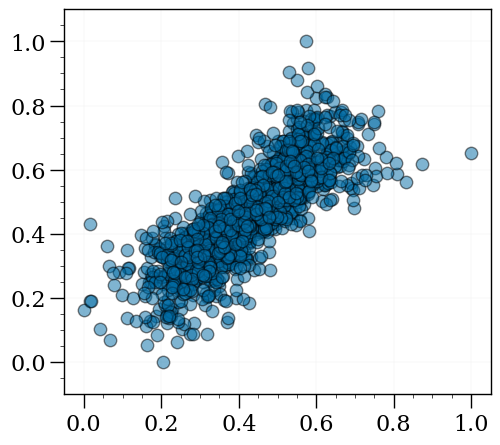

In [45]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [46]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [47]:
run(TrainingTensors, train_D, test_D, key, 'frank_10')

  0%|          | 1/10000 [01:04<178:22:01, 64.22s/it]

Iter 0. Loss [[0.34836045 0.2171772  8.834832  ]]


  0%|          | 11/10000 [02:07<4:25:18,  1.59s/it]

Iter 10. Loss [[0.35321188 0.21258055 1.7253785 ]]


  0%|          | 21/10000 [02:11<1:25:57,  1.93it/s]

Iter 20. Loss [[0.36305356 0.29985857 2.803649  ]]


  0%|          | 31/10000 [02:14<47:51,  3.47it/s]

Iter 30. Loss [[0.3521269  0.21133286 2.1007187 ]]


  0%|          | 41/10000 [02:18<53:55,  3.08it/s]

Iter 40. Loss [[0.33905828 0.14788999 1.7472124 ]]


  1%|          | 51/10000 [02:21<1:08:32,  2.42it/s]

Iter 50. Loss [[0.33308548 0.13443288 1.705183  ]]


  1%|          | 61/10000 [02:24<1:08:05,  2.43it/s]

Iter 60. Loss [[0.33450595 0.1387772  1.6732068 ]]


  1%|          | 71/10000 [02:29<59:56,  2.76it/s]  

Iter 70. Loss [[0.33623594 0.14366494 1.6034772 ]]


  1%|          | 81/10000 [02:31<45:38,  3.62it/s]

Iter 80. Loss [[0.33765727 0.14781648 1.5877205 ]]


  1%|          | 91/10000 [02:35<51:43,  3.19it/s]

Iter 90. Loss [[0.33817396 0.1488852  1.5346813 ]]


  1%|          | 101/10000 [02:38<1:16:22,  2.16it/s]

Iter 100. Loss [[0.33633617 0.14413996 1.495042  ]]


  1%|          | 111/10000 [02:42<56:38,  2.91it/s]  

Iter 110. Loss [[0.3340525  0.13969134 1.4950585 ]]


  1%|          | 121/10000 [02:45<48:32,  3.39it/s]

Iter 120. Loss [[0.33630386 0.14401753 1.4361373 ]]


  1%|▏         | 131/10000 [02:48<44:06,  3.73it/s]

Iter 130. Loss [[0.33550078 0.14159913 1.5325931 ]]


  1%|▏         | 141/10000 [02:51<45:38,  3.60it/s]

Iter 140. Loss [[0.33360395 0.13760768 1.546693  ]]


  2%|▏         | 151/10000 [02:56<1:20:50,  2.03it/s]

Iter 150. Loss [[0.3321513  0.13402903 1.5016493 ]]


  2%|▏         | 161/10000 [02:58<44:51,  3.66it/s]

Iter 160. Loss [[0.32753915 0.12522516 1.4902692 ]]


  2%|▏         | 171/10000 [03:02<47:04,  3.48it/s]

Iter 170. Loss [[0.3262472  0.12232941 1.4389956 ]]


  2%|▏         | 181/10000 [03:05<1:07:37,  2.42it/s]

Iter 180. Loss [[0.31666818 0.11114337 1.4311796 ]]


  2%|▏         | 191/10000 [03:08<1:08:31,  2.39it/s]

Iter 190. Loss [[0.30933192 0.10670716 1.3571655 ]]


  2%|▏         | 201/10000 [03:12<54:11,  3.01it/s]

Iter 200. Loss [[0.29285377 0.10856252 1.2945273 ]]


  2%|▏         | 211/10000 [03:15<43:28,  3.75it/s]

Iter 210. Loss [[0.25048763 0.0898681  1.2947409 ]]


  2%|▏         | 221/10000 [03:18<46:22,  3.51it/s]

Iter 220. Loss [[0.2437175  0.08145288 1.1603591 ]]


  2%|▏         | 231/10000 [03:21<1:12:46,  2.24it/s]

Iter 230. Loss [[0.23221892 0.09157    0.81250316]]


  2%|▏         | 241/10000 [03:25<59:15,  2.74it/s]  

Iter 240. Loss [[0.2199469  0.09641051 0.57144964]]


  3%|▎         | 251/10000 [03:29<48:22,  3.36it/s]

Iter 250. Loss [[0.19495733 0.07939392 0.40518433]]


  3%|▎         | 261/10000 [03:31<44:57,  3.61it/s]

Iter 260. Loss [[0.17659403 0.05528777 0.33344957]]


  3%|▎         | 271/10000 [03:35<44:54,  3.61it/s]

Iter 270. Loss [[0.176834   0.04742701 0.06971799]]


  3%|▎         | 281/10000 [03:39<1:23:46,  1.93it/s]

Iter 280. Loss [[ 0.21585755  0.04292725 -0.09897511]]


  3%|▎         | 291/10000 [03:42<49:15,  3.29it/s]

Iter 290. Loss [[0.24086523 0.05822667 0.7644214 ]]


  3%|▎         | 301/10000 [03:45<46:49,  3.45it/s]

Iter 300. Loss [[0.29944396 0.07261042 0.57638353]]


  3%|▎         | 311/10000 [03:48<1:06:11,  2.44it/s]

Iter 310. Loss [[0.2312084  0.04269008 0.17349249]]


  3%|▎         | 321/10000 [03:52<1:09:26,  2.32it/s]

Iter 320. Loss [[0.21971782 0.04915511 0.31396288]]


  3%|▎         | 331/10000 [03:56<52:57,  3.04it/s]

Iter 330. Loss [[ 0.19227575  0.04552164 -0.09618475]]


  3%|▎         | 341/10000 [03:59<44:24,  3.63it/s]

Iter 340. Loss [[ 0.14688575  0.05043584 -0.08457939]]


  4%|▎         | 351/10000 [04:02<45:42,  3.52it/s]

Iter 350. Loss [[0.12470518 0.08403118 0.30062056]]


  4%|▎         | 361/10000 [04:06<1:20:13,  2.00it/s]

Iter 360. Loss [[0.20143849 0.070923   0.14368083]]


  4%|▎         | 371/10000 [04:09<51:19,  3.13it/s]

Iter 370. Loss [[ 0.23414782  0.04738763 -0.03941934]]


  4%|▍         | 381/10000 [04:13<48:31,  3.30it/s]

Iter 380. Loss [[ 0.16242994  0.04449473 -0.2956671 ]]


  4%|▍         | 391/10000 [04:15<43:58,  3.64it/s]

Iter 390. Loss [[ 0.18399504  0.04995157 -0.44776314]]


  4%|▍         | 401/10000 [04:19<47:11,  3.39it/s]

Iter 400. Loss [[ 0.19197877  0.04837607 -0.5426115 ]]


  4%|▍         | 411/10000 [04:23<1:11:26,  2.24it/s]

Iter 410. Loss [[ 0.18566893  0.05045334 -0.6052521 ]]


  4%|▍         | 421/10000 [04:26<43:50,  3.64it/s]

Iter 420. Loss [[ 0.1938407   0.05424226 -0.69005954]]


  4%|▍         | 431/10000 [04:29<45:28,  3.51it/s]

Iter 430. Loss [[ 0.19413745  0.05720105 -0.72973317]]


  4%|▍         | 441/10000 [04:32<1:05:49,  2.42it/s]

Iter 440. Loss [[ 0.16427822  0.07705639 -0.4803317 ]]


  5%|▍         | 451/10000 [04:36<1:08:47,  2.31it/s]

Iter 450. Loss [[ 0.27617702  0.07323948 -0.46615967]]


  5%|▍         | 461/10000 [04:40<52:16,  3.04it/s]

Iter 460. Loss [[ 0.19859119  0.0526575  -0.6780962 ]]


  5%|▍         | 471/10000 [04:42<43:12,  3.68it/s]

Iter 470. Loss [[ 0.2572139   0.05100042 -0.4586231 ]]


  5%|▍         | 481/10000 [04:46<43:53,  3.61it/s]

Iter 480. Loss [[ 0.20798339  0.05353985 -0.71760106]]


  5%|▍         | 491/10000 [04:49<1:19:47,  1.99it/s]

Iter 490. Loss [[ 0.22018029  0.05663176 -0.8024559 ]]


  5%|▌         | 501/10000 [04:53<48:29,  3.27it/s]

Iter 500. Loss [[ 0.23544925  0.0539344  -0.7665681 ]]


  5%|▌         | 511/10000 [04:56<46:02,  3.43it/s]

Iter 510. Loss [[ 0.20821823  0.05816247 -0.7648307 ]]


  5%|▌         | 521/10000 [04:59<41:47,  3.78it/s]

Iter 520. Loss [[ 0.14876524  0.06573573 -0.3486027 ]]


  5%|▌         | 531/10000 [05:02<43:12,  3.65it/s]

Iter 530. Loss [[ 0.20461679  0.05821346 -0.694992  ]]


  5%|▌         | 541/10000 [05:06<1:08:17,  2.31it/s]

Iter 540. Loss [[ 0.25364536  0.06198447 -0.7181001 ]]


  6%|▌         | 551/10000 [05:09<43:33,  3.62it/s]

Iter 550. Loss [[ 0.21384491  0.06404106 -0.7942645 ]]


  6%|▌         | 561/10000 [05:12<44:18,  3.55it/s]

Iter 560. Loss [[ 0.252541    0.06399614 -0.8189383 ]]


  6%|▌         | 571/10000 [05:15<56:17,  2.79it/s]  

Iter 570. Loss [[ 0.16538218  0.08483203 -0.12431338]]


  6%|▌         | 581/10000 [05:19<1:07:42,  2.32it/s]

Iter 580. Loss [[0.11444642 0.14232644 0.69327945]]


  6%|▌         | 591/10000 [05:23<52:17,  3.00it/s]

Iter 590. Loss [[0.1276558  0.08158413 0.10946757]]


  6%|▌         | 601/10000 [05:26<43:14,  3.62it/s]

Iter 600. Loss [[ 0.19444554  0.05217086 -0.5741289 ]]


  6%|▌         | 611/10000 [05:29<44:15,  3.54it/s]

Iter 610. Loss [[ 0.21808755  0.04736523 -0.59472406]]


  6%|▌         | 621/10000 [05:33<1:13:27,  2.13it/s]

Iter 620. Loss [[ 0.20163327  0.05079442 -0.6716775 ]]


  6%|▋         | 631/10000 [05:36<47:42,  3.27it/s]

Iter 630. Loss [[ 0.19628821  0.05250308 -0.6798787 ]]


  6%|▋         | 641/10000 [05:39<44:53,  3.48it/s]

Iter 640. Loss [[ 0.20247862  0.05519955 -0.7676229 ]]


  7%|▋         | 651/10000 [05:43<1:03:19,  2.46it/s]

Iter 650. Loss [[ 0.20134531  0.05306319 -0.7327231 ]]


  7%|▋         | 661/10000 [05:45<45:54,  3.39it/s]

Iter 660. Loss [[ 0.20188178  0.05436888 -0.7505273 ]]


  7%|▋         | 671/10000 [05:50<1:05:18,  2.38it/s]

Iter 670. Loss [[ 0.2129799   0.05618832 -0.82464135]]


  7%|▋         | 681/10000 [05:53<42:19,  3.67it/s]

Iter 680. Loss [[ 0.1708883   0.06557442 -0.6422308 ]]


  7%|▋         | 691/10000 [05:56<43:53,  3.54it/s]

Iter 690. Loss [[ 0.16457988  0.06366797 -0.5420978 ]]


  7%|▋         | 701/10000 [05:59<57:41,  2.69it/s]  

Iter 700. Loss [[ 0.24952872  0.05935995 -0.78215665]]


  7%|▋         | 711/10000 [06:03<1:06:15,  2.34it/s]

Iter 710. Loss [[ 0.22149955  0.0572584  -0.89274186]]


  7%|▋         | 721/10000 [06:07<47:48,  3.23it/s]

Iter 720. Loss [[0.1123072  0.09832872 0.30406755]]


  7%|▋         | 731/10000 [06:10<43:27,  3.56it/s]

Iter 730. Loss [[ 0.15366423  0.06727035 -0.11647709]]


  7%|▋         | 741/10000 [06:13<43:44,  3.53it/s]

Iter 740. Loss [[ 0.25138295  0.06118618 -0.8118406 ]]


  8%|▊         | 751/10000 [06:17<1:16:48,  2.01it/s]

Iter 750. Loss [[0.14019774 0.3031047  6.039498  ]]


  8%|▊         | 761/10000 [06:20<46:36,  3.30it/s]

Iter 760. Loss [[0.315454   0.11980608 0.5492314 ]]


  8%|▊         | 771/10000 [06:24<43:56,  3.50it/s]

Iter 770. Loss [[0.24357459 0.04524732 0.13597527]]


  8%|▊         | 781/10000 [06:27<1:05:08,  2.36it/s]

Iter 780. Loss [[ 0.1789337   0.04191311 -0.13410527]]


  8%|▊         | 791/10000 [06:30<58:21,  2.63it/s]

Iter 790. Loss [[ 0.20631117  0.04279245 -0.37987483]]


  8%|▊         | 801/10000 [06:34<58:26,  2.62it/s]  

Iter 800. Loss [[ 0.20565681  0.0415027  -0.5049541 ]]


  8%|▊         | 811/10000 [06:37<42:15,  3.62it/s]

Iter 810. Loss [[ 0.20320947  0.04791867 -0.6080926 ]]


  8%|▊         | 821/10000 [06:40<42:55,  3.56it/s]

Iter 820. Loss [[ 0.204692   0.0522635 -0.7015227]]


  8%|▊         | 831/10000 [06:43<52:30,  2.91it/s]

Iter 830. Loss [[ 0.20264642  0.05665462 -0.7744374 ]]


  8%|▊         | 841/10000 [06:48<1:05:57,  2.31it/s]

Iter 840. Loss [[ 0.20779584  0.05763112 -0.7337622 ]]


  9%|▊         | 851/10000 [06:51<45:43,  3.33it/s]

Iter 850. Loss [[ 0.20399712  0.064147   -0.77880156]]


  9%|▊         | 861/10000 [06:54<40:52,  3.73it/s]

Iter 860. Loss [[ 0.20909385  0.06310374 -0.85466355]]


  9%|▊         | 871/10000 [06:57<42:18,  3.60it/s]

Iter 870. Loss [[ 0.23927665  0.06300658 -0.7613591 ]]


  9%|▉         | 881/10000 [07:01<1:13:01,  2.08it/s]

Iter 880. Loss [[0.32033223 0.24828638 3.2582097 ]]


  9%|▉         | 891/10000 [07:04<42:47,  3.55it/s]

Iter 890. Loss [[0.27917805 0.15247336 2.7642708 ]]


  9%|▉         | 901/10000 [07:07<43:09,  3.51it/s]

Iter 900. Loss [[0.31575128 0.2666351  0.17354992]]


  9%|▉         | 911/10000 [07:10<54:29,  2.78it/s]  

Iter 910. Loss [[0.3824425 1.0199065 9.880471 ]]


  9%|▉         | 921/10000 [07:14<59:06,  2.56it/s]

Iter 920. Loss [[0.10856694 0.24994333 3.425809  ]]


  9%|▉         | 931/10000 [07:18<50:55,  2.97it/s]

Iter 930. Loss [[0.16370568 0.09022731 0.7915179 ]]


  9%|▉         | 941/10000 [07:21<42:40,  3.54it/s]

Iter 940. Loss [[0.15124327 0.10281476 0.82828236]]


 10%|▉         | 951/10000 [07:24<42:27,  3.55it/s]

Iter 950. Loss [[0.21854453 0.0735202  0.5706187 ]]


 10%|▉         | 961/10000 [07:28<1:06:10,  2.28it/s]

Iter 960. Loss [[0.24232934 0.06448226 0.51186615]]


 10%|▉         | 971/10000 [07:32<55:04,  2.73it/s]  

Iter 970. Loss [[0.24344748 0.06644612 0.44239965]]


 10%|▉         | 981/10000 [07:35<43:16,  3.47it/s]

Iter 980. Loss [[0.23148048 0.0677719  0.2983189 ]]


 10%|▉         | 991/10000 [07:38<1:00:24,  2.49it/s]

Iter 990. Loss [[0.20435332 0.05967454 0.14755875]]


 10%|█         | 1001/10000 [07:41<40:23,  3.71it/s]

Iter 1000. Loss [[0.19366555 0.04968118 0.03309795]]


 10%|█         | 1011/10000 [07:45<1:12:25,  2.07it/s]

Iter 1010. Loss [[0.18310194 0.04461766 0.06787973]]


 10%|█         | 1021/10000 [07:48<42:14,  3.54it/s]

Iter 1020. Loss [[ 0.2178226   0.04543724 -0.19850643]]


 10%|█         | 1031/10000 [07:51<42:44,  3.50it/s]

Iter 1030. Loss [[ 0.19178198  0.04106215 -0.3125093 ]]


 10%|█         | 1041/10000 [07:54<54:46,  2.73it/s]

Iter 1040. Loss [[ 0.20339896  0.04484097 -0.438199  ]]


 11%|█         | 1051/10000 [07:58<1:00:37,  2.46it/s]

Iter 1050. Loss [[ 0.20240416  0.04444121 -0.5048671 ]]


 11%|█         | 1061/10000 [08:02<48:48,  3.05it/s]

Iter 1060. Loss [[ 0.20353584  0.0465225  -0.60020065]]


 11%|█         | 1071/10000 [08:04<40:11,  3.70it/s]

Iter 1070. Loss [[ 0.21956056  0.05535811 -0.7498274 ]]


 11%|█         | 1081/10000 [08:07<40:27,  3.67it/s]

Iter 1080. Loss [[ 0.21156336  0.05983403 -0.75726074]]


 11%|█         | 1091/10000 [08:11<1:08:32,  2.17it/s]

Iter 1090. Loss [[ 0.20620869  0.06516904 -0.78940445]]


 11%|█         | 1101/10000 [08:15<53:46,  2.76it/s]

Iter 1100. Loss [[ 0.21086614  0.06654429 -0.83139193]]


 11%|█         | 1111/10000 [08:18<43:11,  3.43it/s]

Iter 1110. Loss [[ 0.2100412   0.07192852 -0.8328154 ]]


 11%|█         | 1121/10000 [08:21<40:39,  3.64it/s]

Iter 1120. Loss [[ 0.2102483   0.06861337 -0.8434556 ]]


 11%|█▏        | 1131/10000 [08:24<40:03,  3.69it/s]

Iter 1130. Loss [[ 0.20788798  0.06812108 -0.82638234]]


 11%|█▏        | 1141/10000 [08:29<1:13:14,  2.02it/s]

Iter 1140. Loss [[ 0.21013927  0.07637268 -0.88423944]]


 12%|█▏        | 1151/10000 [08:32<42:15,  3.49it/s]

Iter 1150. Loss [[ 0.21099973  0.07750542 -0.887896  ]]


 12%|█▏        | 1161/10000 [08:35<42:13,  3.49it/s]

Iter 1160. Loss [[ 0.21300152  0.08078794 -0.9150555 ]]


 12%|█▏        | 1171/10000 [08:38<53:49,  2.73it/s]

Iter 1170. Loss [[ 0.2158351   0.08004388 -0.92777056]]


 12%|█▏        | 1181/10000 [08:42<1:00:32,  2.43it/s]

Iter 1180. Loss [[ 0.21153225  0.08564558 -0.92807096]]


 12%|█▏        | 1191/10000 [08:45<47:29,  3.09it/s]

Iter 1190. Loss [[ 0.2125182   0.08525304 -0.97024894]]


 12%|█▏        | 1201/10000 [08:48<41:10,  3.56it/s]

Iter 1200. Loss [[ 0.20683268  0.08645591 -0.93953854]]


 12%|█▏        | 1211/10000 [08:51<40:03,  3.66it/s]

Iter 1210. Loss [[ 0.19992967  0.08786082 -0.88207054]]


 12%|█▏        | 1221/10000 [08:55<1:02:03,  2.36it/s]

Iter 1220. Loss [[ 0.2069232   0.08756646 -0.95158845]]


 12%|█▏        | 1231/10000 [08:59<49:47,  2.94it/s]

Iter 1230. Loss [[ 0.20597528  0.08845373 -0.96038616]]


 12%|█▏        | 1241/10000 [09:02<42:33,  3.43it/s]

Iter 1240. Loss [[ 0.20014597  0.08932746 -0.90887433]]


 13%|█▎        | 1251/10000 [09:05<59:34,  2.45it/s]

Iter 1250. Loss [[ 0.18811831  0.08270759 -0.7858853 ]]


 13%|█▎        | 1261/10000 [09:08<39:42,  3.67it/s]

Iter 1260. Loss [[ 0.19943021  0.08649801 -0.88166696]]


 13%|█▎        | 1271/10000 [09:12<1:07:03,  2.17it/s]

Iter 1270. Loss [[ 0.15961482  1.502554   19.366158  ]]


 13%|█▎        | 1281/10000 [09:15<40:25,  3.60it/s]

Iter 1280. Loss [[ 0.15876164  0.30846888 19.931568  ]]


 13%|█▎        | 1291/10000 [09:18<40:48,  3.56it/s]

Iter 1290. Loss [[ 0.15729189  0.30846888 19.931568  ]]


 13%|█▎        | 1301/10000 [09:21<49:43,  2.92it/s]

Iter 1300. Loss [[ 0.15678145  0.30846888 19.931568  ]]


 13%|█▎        | 1311/10000 [09:25<1:00:13,  2.40it/s]

Iter 1310. Loss [[ 0.156597    0.30846888 19.931568  ]]


 13%|█▎        | 1321/10000 [09:29<44:37,  3.24it/s]

Iter 1320. Loss [[ 0.1565257   0.30846888 19.931568  ]]


 13%|█▎        | 1331/10000 [09:32<38:41,  3.73it/s]

Iter 1330. Loss [[ 0.15649392  0.30846888 19.931568  ]]


 13%|█▎        | 1341/10000 [09:35<40:06,  3.60it/s]

Iter 1340. Loss [[ 0.15647584  0.30846888 19.931568  ]]


 14%|█▎        | 1351/10000 [09:38<57:25,  2.51it/s]

Iter 1350. Loss [[ 0.15646262  0.30846888 19.931568  ]]


 14%|█▎        | 1361/10000 [09:42<52:51,  2.72it/s]

Iter 1360. Loss [[ 0.15645103  0.30846888 19.931568  ]]


 14%|█▎        | 1371/10000 [09:45<40:38,  3.54it/s]

Iter 1370. Loss [[ 0.15643995  0.30846888 19.931568  ]]


 14%|█▍        | 1381/10000 [09:48<57:59,  2.48it/s]

Iter 1380. Loss [[ 0.15642907  0.30846888 19.931568  ]]


 14%|█▍        | 1391/10000 [09:51<39:19,  3.65it/s]

Iter 1390. Loss [[ 0.1564181   0.30846888 19.931568  ]]


 14%|█▍        | 1401/10000 [09:55<1:06:05,  2.17it/s]

Iter 1400. Loss [[ 0.15640713  0.30846888 19.931568  ]]


 14%|█▍        | 1411/10000 [09:58<38:45,  3.69it/s]

Iter 1410. Loss [[ 0.15639612  0.30846888 19.931568  ]]


 14%|█▍        | 1421/10000 [10:01<39:02,  3.66it/s]

Iter 1420. Loss [[ 0.15638502  0.30846888 19.931568  ]]


 14%|█▍        | 1431/10000 [10:04<47:05,  3.03it/s]

Iter 1430. Loss [[ 0.1563738   0.30846888 19.931568  ]]


 14%|█▍        | 1441/10000 [10:08<53:14,  2.68it/s]

Iter 1440. Loss [[ 0.15636256  0.30846888 19.931568  ]]


 15%|█▍        | 1451/10000 [10:12<46:38,  3.06it/s]

Iter 1450. Loss [[ 0.1563512   0.30846888 19.931568  ]]


 15%|█▍        | 1461/10000 [10:15<59:18,  2.40it/s]

Iter 1460. Loss [[ 0.15633987  0.30846888 19.931568  ]]


 15%|█▍        | 1471/10000 [10:18<37:57,  3.74it/s]

Iter 1470. Loss [[ 0.15632837  0.30846888 19.931568  ]]


 15%|█▍        | 1481/10000 [10:21<46:04,  3.08it/s]

Iter 1480. Loss [[ 0.15631682  0.30846888 19.931568  ]]


 15%|█▍        | 1491/10000 [10:25<1:02:48,  2.26it/s]

Iter 1490. Loss [[ 0.15630522  0.30846888 19.931568  ]]


 15%|█▌        | 1501/10000 [10:28<39:16,  3.61it/s]

Iter 1500. Loss [[ 0.15629354  0.30846888 19.931568  ]]


 15%|█▌        | 1511/10000 [10:31<51:36,  2.74it/s]

Iter 1510. Loss [[ 0.15628177  0.30846888 19.931568  ]]


 15%|█▌        | 1521/10000 [10:34<38:12,  3.70it/s]

Iter 1520. Loss [[ 0.15626995  0.30846888 19.931568  ]]


 15%|█▌        | 1531/10000 [10:38<1:02:17,  2.27it/s]

Iter 1530. Loss [[ 0.15625805  0.30846888 19.931568  ]]


 15%|█▌        | 1541/10000 [10:41<40:08,  3.51it/s]

Iter 1540. Loss [[ 0.15624602  0.30846888 19.931568  ]]


 16%|█▌        | 1551/10000 [10:45<38:54,  3.62it/s]

Iter 1550. Loss [[ 0.15623401  0.30846888 19.931568  ]]


 16%|█▌        | 1561/10000 [10:48<46:56,  3.00it/s]

Iter 1560. Loss [[ 0.15622182  0.30846888 19.931568  ]]


 16%|█▌        | 1571/10000 [10:51<51:06,  2.75it/s]

Iter 1570. Loss [[ 0.15620956  0.30846888 19.931568  ]]


 16%|█▌        | 1581/10000 [10:55<45:48,  3.06it/s]

Iter 1580. Loss [[ 0.15619723  0.30846888 19.931568  ]]


 16%|█▌        | 1591/10000 [10:58<56:45,  2.47it/s]

Iter 1590. Loss [[ 0.15618487  0.30846888 19.931568  ]]


 16%|█▌        | 1601/10000 [11:01<37:51,  3.70it/s]

Iter 1600. Loss [[ 0.15617236  0.30846888 19.931568  ]]


 16%|█▌        | 1611/10000 [11:04<42:00,  3.33it/s]

Iter 1610. Loss [[ 0.15615986  0.30846888 19.931568  ]]


 16%|█▌        | 1621/10000 [11:08<1:00:15,  2.32it/s]

Iter 1620. Loss [[ 0.15614723  0.30846888 19.931568  ]]


 16%|█▋        | 1631/10000 [11:11<39:12,  3.56it/s]

Iter 1630. Loss [[ 0.15613456  0.30846888 19.931568  ]]


 16%|█▋        | 1641/10000 [11:14<47:47,  2.91it/s]

Iter 1640. Loss [[ 0.15612178  0.30846888 19.931568  ]]


 17%|█▋        | 1651/10000 [11:17<36:50,  3.78it/s]

Iter 1650. Loss [[ 0.15610892  0.30846888 19.931568  ]]


 17%|█▋        | 1661/10000 [11:21<1:01:30,  2.26it/s]

Iter 1660. Loss [[ 0.15609601  0.30846888 19.931568  ]]


 17%|█▋        | 1671/10000 [11:25<40:45,  3.41it/s]

Iter 1670. Loss [[ 0.15608296  0.30846888 19.931568  ]]


 17%|█▋        | 1681/10000 [11:28<38:04,  3.64it/s]

Iter 1680. Loss [[ 0.15606992  0.30846888 19.931568  ]]


 17%|█▋        | 1691/10000 [11:31<43:58,  3.15it/s]

Iter 1690. Loss [[ 0.15605672  0.30846888 19.931568  ]]


 17%|█▋        | 1701/10000 [11:34<44:19,  3.12it/s]

Iter 1700. Loss [[ 0.1560435   0.30846888 19.931568  ]]


 17%|█▋        | 1711/10000 [11:38<49:58,  2.76it/s]

Iter 1710. Loss [[ 0.15603015  0.30846888 19.931568  ]]


 17%|█▋        | 1721/10000 [11:41<50:25,  2.74it/s]

Iter 1720. Loss [[ 0.1560167   0.30846888 19.931568  ]]


 17%|█▋        | 1731/10000 [11:44<37:24,  3.68it/s]

Iter 1730. Loss [[ 0.15600322  0.30846888 19.931568  ]]


 17%|█▋        | 1741/10000 [11:47<41:17,  3.33it/s]

Iter 1740. Loss [[ 0.15598969  0.30846888 19.931568  ]]


 18%|█▊        | 1751/10000 [11:51<57:52,  2.38it/s]

Iter 1750. Loss [[ 0.15597606  0.30846888 19.931568  ]]


 18%|█▊        | 1761/10000 [11:54<38:37,  3.56it/s]

Iter 1760. Loss [[ 0.15596227  0.30846888 19.931568  ]]


 18%|█▊        | 1771/10000 [11:57<45:09,  3.04it/s]

Iter 1770. Loss [[ 0.15594845  0.30846888 19.931568  ]]


 18%|█▊        | 1781/10000 [12:00<37:01,  3.70it/s]

Iter 1780. Loss [[ 0.15593451  0.30846888 19.931568  ]]


 18%|█▊        | 1791/10000 [12:04<55:22,  2.47it/s]

Iter 1790. Loss [[ 0.15592057  0.30846888 19.931568  ]]


 18%|█▊        | 1801/10000 [12:08<1:03:06,  2.17it/s]

Iter 1800. Loss [[ 0.15590645  0.30846888 19.931568  ]]


 18%|█▊        | 1811/10000 [12:11<37:15,  3.66it/s]

Iter 1810. Loss [[ 0.15589231  0.30846888 19.931568  ]]


 18%|█▊        | 1821/10000 [12:14<41:15,  3.30it/s]

Iter 1820. Loss [[ 0.1558781   0.30846888 19.931568  ]]


 18%|█▊        | 1831/10000 [12:17<36:24,  3.74it/s]

Iter 1830. Loss [[ 0.1558637   0.30846888 19.931568  ]]


 18%|█▊        | 1841/10000 [12:21<59:38,  2.28it/s]

Iter 1840. Loss [[ 0.15584928  0.30846888 19.931568  ]]


 19%|█▊        | 1851/10000 [12:24<50:29,  2.69it/s]

Iter 1850. Loss [[ 0.15583481  0.30846888 19.931568  ]]


 19%|█▊        | 1861/10000 [12:27<37:31,  3.62it/s]

Iter 1860. Loss [[ 0.15582015  0.30846888 19.931568  ]]


 19%|█▊        | 1871/10000 [12:30<40:03,  3.38it/s]

Iter 1870. Loss [[ 0.15580548  0.30846888 19.931568  ]]


 19%|█▉        | 1881/10000 [12:34<57:51,  2.34it/s]

Iter 1880. Loss [[ 0.15579079  0.30846888 19.931568  ]]


 19%|█▉        | 1891/10000 [12:38<37:59,  3.56it/s]

Iter 1890. Loss [[ 0.15577593  0.30846888 19.931568  ]]


 19%|█▉        | 1901/10000 [12:41<44:40,  3.02it/s]

Iter 1900. Loss [[ 0.15576097  0.30846888 19.931568  ]]


 19%|█▉        | 1911/10000 [12:43<35:46,  3.77it/s]

Iter 1910. Loss [[ 0.15574603  0.30846888 19.931568  ]]


 19%|█▉        | 1921/10000 [12:47<53:27,  2.52it/s]

Iter 1920. Loss [[ 0.1557309   0.30846888 19.931568  ]]


 19%|█▉        | 1931/10000 [12:51<1:03:34,  2.12it/s]

Iter 1930. Loss [[ 0.15571572  0.30846888 19.931568  ]]


 19%|█▉        | 1941/10000 [12:54<36:18,  3.70it/s]

Iter 1940. Loss [[ 0.15570043  0.30846888 19.931568  ]]


 20%|█▉        | 1951/10000 [12:57<41:52,  3.20it/s]

Iter 1950. Loss [[ 0.15568513  0.30846888 19.931568  ]]


 20%|█▉        | 1961/10000 [13:00<36:04,  3.71it/s]

Iter 1960. Loss [[ 0.15566964  0.30846888 19.931568  ]]


 20%|█▉        | 1971/10000 [13:04<58:43,  2.28it/s]

Iter 1970. Loss [[ 0.15565401  0.30846888 19.931568  ]]


 20%|█▉        | 1981/10000 [13:08<48:58,  2.73it/s]

Iter 1980. Loss [[ 0.15563835  0.30846888 19.931568  ]]


 20%|█▉        | 1991/10000 [13:10<36:01,  3.70it/s]

Iter 1990. Loss [[ 0.15562265  0.30846888 19.931568  ]]


 20%|██        | 2001/10000 [13:13<40:01,  3.33it/s]

Iter 2000. Loss [[ 0.1556068   0.30846888 19.931568  ]]


 20%|██        | 2011/10000 [13:17<53:07,  2.51it/s]

Iter 2010. Loss [[ 0.1555909   0.30846888 19.931568  ]]


 20%|██        | 2021/10000 [13:21<40:38,  3.27it/s]

Iter 2020. Loss [[ 0.15557487  0.30846888 19.931568  ]]


 20%|██        | 2031/10000 [13:24<44:33,  2.98it/s]

Iter 2030. Loss [[ 0.15555875  0.30846888 19.931568  ]]


 20%|██        | 2041/10000 [13:26<36:08,  3.67it/s]

Iter 2040. Loss [[ 0.15554255  0.30846888 19.931568  ]]


 21%|██        | 2051/10000 [13:30<42:55,  3.09it/s]

Iter 2050. Loss [[ 0.15552631  0.30846888 19.931568  ]]


 21%|██        | 2061/10000 [13:34<57:09,  2.32it/s]

Iter 2060. Loss [[ 0.15550989  0.30846888 19.931568  ]]


 21%|██        | 2071/10000 [13:37<36:59,  3.57it/s]

Iter 2070. Loss [[ 0.15549347  0.30846888 19.931568  ]]


 21%|██        | 2081/10000 [13:40<41:54,  3.15it/s]

Iter 2080. Loss [[ 0.1554769   0.30846888 19.931568  ]]


 21%|██        | 2091/10000 [13:43<35:08,  3.75it/s]

Iter 2090. Loss [[ 0.15546025  0.30846888 19.931568  ]]


 21%|██        | 2101/10000 [13:47<56:24,  2.33it/s]

Iter 2100. Loss [[ 0.1554435   0.30846888 19.931568  ]]


 21%|██        | 2111/10000 [13:51<55:58,  2.35it/s]

Iter 2110. Loss [[ 0.15542664  0.30846888 19.931568  ]]


 21%|██        | 2121/10000 [13:53<35:40,  3.68it/s]

Iter 2120. Loss [[ 0.1554098   0.30846888 19.931568  ]]


 21%|██▏       | 2131/10000 [13:57<39:38,  3.31it/s]

Iter 2130. Loss [[ 0.15539269  0.30846888 19.931568  ]]


 21%|██▏       | 2141/10000 [14:00<46:59,  2.79it/s]

Iter 2140. Loss [[ 0.15537551  0.30846888 19.931568  ]]


 22%|██▏       | 2151/10000 [14:04<42:59,  3.04it/s]

Iter 2150. Loss [[ 0.1553583   0.30846888 19.931568  ]]


 22%|██▏       | 2161/10000 [14:07<44:18,  2.95it/s]

Iter 2160. Loss [[ 0.15534094  0.30846888 19.931568  ]]


 22%|██▏       | 2171/10000 [14:10<34:56,  3.73it/s]

Iter 2170. Loss [[ 0.1553235   0.30846888 19.931568  ]]


 22%|██▏       | 2181/10000 [14:13<38:32,  3.38it/s]

Iter 2180. Loss [[ 0.155306    0.30846888 19.931568  ]]


 22%|██▏       | 2191/10000 [14:17<56:47,  2.29it/s]

Iter 2190. Loss [[ 0.1552884   0.30846888 19.931568  ]]


 22%|██▏       | 2201/10000 [14:20<36:28,  3.56it/s]

Iter 2200. Loss [[ 0.15527067  0.30846888 19.931568  ]]


 22%|██▏       | 2211/10000 [14:24<41:10,  3.15it/s]

Iter 2210. Loss [[ 0.15525281  0.30846888 19.931568  ]]


 22%|██▏       | 2221/10000 [14:26<35:02,  3.70it/s]

Iter 2220. Loss [[ 0.15523493  0.30846888 19.931568  ]]


 22%|██▏       | 2231/10000 [14:30<55:35,  2.33it/s]

Iter 2230. Loss [[ 0.15521689  0.30846888 19.931568  ]]


 22%|██▏       | 2241/10000 [14:34<56:12,  2.30it/s]

Iter 2240. Loss [[ 0.15519874  0.30846888 19.931568  ]]


 23%|██▎       | 2251/10000 [14:37<34:54,  3.70it/s]

Iter 2250. Loss [[ 0.15518053  0.30846888 19.931568  ]]


 23%|██▎       | 2261/10000 [14:40<38:53,  3.32it/s]

Iter 2260. Loss [[ 0.15516217  0.30846888 19.931568  ]]


 23%|██▎       | 2271/10000 [14:43<42:31,  3.03it/s]

Iter 2270. Loss [[ 0.1551438   0.30846888 19.931568  ]]


 23%|██▎       | 2281/10000 [14:47<44:42,  2.88it/s]

Iter 2280. Loss [[ 0.15512528  0.30846888 19.931568  ]]


 23%|██▎       | 2291/10000 [14:51<47:11,  2.72it/s]

Iter 2290. Loss [[ 0.15510666  0.30846888 19.931568  ]]


 23%|██▎       | 2301/10000 [14:53<34:27,  3.72it/s]

Iter 2300. Loss [[ 0.15508795  0.30846888 19.931568  ]]


 23%|██▎       | 2311/10000 [14:56<37:20,  3.43it/s]

Iter 2310. Loss [[ 0.15506904  0.30846888 19.931568  ]]


 23%|██▎       | 2321/10000 [15:00<53:57,  2.37it/s]

Iter 2320. Loss [[ 0.15505014  0.30846888 19.931568  ]]


 23%|██▎       | 2331/10000 [15:04<36:04,  3.54it/s]

Iter 2330. Loss [[ 0.15503106  0.30846888 19.931568  ]]


 23%|██▎       | 2341/10000 [15:07<41:47,  3.05it/s]

Iter 2340. Loss [[ 0.15501189  0.30846888 19.931568  ]]


 24%|██▎       | 2351/10000 [15:09<33:56,  3.76it/s]

Iter 2350. Loss [[ 0.1549927   0.30846888 19.931568  ]]


 24%|██▎       | 2361/10000 [15:13<53:16,  2.39it/s]

Iter 2360. Loss [[ 0.15497327  0.30846888 19.931568  ]]


 24%|██▎       | 2371/10000 [15:17<38:27,  3.31it/s]

Iter 2370. Loss [[ 0.15495378  0.30846888 19.931568  ]]


 24%|██▍       | 2381/10000 [15:20<35:14,  3.60it/s]

Iter 2380. Loss [[ 0.15493424  0.30846888 19.931568  ]]


 24%|██▍       | 2391/10000 [15:23<40:34,  3.13it/s]

Iter 2390. Loss [[ 0.1549146   0.30846888 19.931568  ]]


 24%|██▍       | 2401/10000 [15:26<34:54,  3.63it/s]

Iter 2400. Loss [[ 0.15489481  0.30846888 19.931568  ]]


 24%|██▍       | 2411/10000 [15:30<50:10,  2.52it/s]

Iter 2410. Loss [[ 0.15487492  0.30846888 19.931568  ]]


 24%|██▍       | 2421/10000 [15:34<46:40,  2.71it/s]

Iter 2420. Loss [[ 0.1548549   0.30846888 19.931568  ]]


 24%|██▍       | 2431/10000 [15:36<34:25,  3.66it/s]

Iter 2430. Loss [[ 0.15483475  0.30846888 19.931568  ]]


 24%|██▍       | 2441/10000 [15:39<37:19,  3.38it/s]

Iter 2440. Loss [[ 0.15481459  0.30846888 19.931568  ]]


 25%|██▍       | 2451/10000 [15:43<53:40,  2.34it/s]

Iter 2450. Loss [[ 0.15479423  0.30846888 19.931568  ]]


 25%|██▍       | 2461/10000 [15:47<35:35,  3.53it/s]

Iter 2460. Loss [[ 0.1547738   0.30846888 19.931568  ]]


 25%|██▍       | 2471/10000 [15:50<41:56,  2.99it/s]

Iter 2470. Loss [[ 0.15475322  0.30846888 19.931568  ]]


 25%|██▍       | 2481/10000 [15:53<33:33,  3.74it/s]

Iter 2480. Loss [[ 0.15473248  0.30846888 19.931568  ]]


 25%|██▍       | 2491/10000 [15:56<51:26,  2.43it/s]

Iter 2490. Loss [[ 0.15471172  0.30846888 19.931568  ]]


 25%|██▌       | 2501/10000 [16:00<40:35,  3.08it/s]

Iter 2500. Loss [[ 0.15469085  0.30846888 19.931568  ]]


 25%|██▌       | 2511/10000 [16:03<34:28,  3.62it/s]

Iter 2510. Loss [[ 0.1546698   0.30846888 19.931568  ]]


 25%|██▌       | 2521/10000 [16:06<40:04,  3.11it/s]

Iter 2520. Loss [[ 0.15464866  0.30846888 19.931568  ]]


 25%|██▌       | 2531/10000 [16:09<33:26,  3.72it/s]

Iter 2530. Loss [[ 0.15462747  0.30846888 19.931568  ]]


 25%|██▌       | 2541/10000 [16:14<55:28,  2.24it/s]

Iter 2540. Loss [[ 0.15460613  0.30846888 19.931568  ]]


 26%|██▌       | 2551/10000 [16:17<51:33,  2.41it/s]

Iter 2550. Loss [[ 0.15458468  0.30846888 19.931568  ]]


 26%|██▌       | 2561/10000 [16:20<34:33,  3.59it/s]

Iter 2560. Loss [[ 0.1545631   0.30846888 19.931568  ]]


 26%|██▌       | 2571/10000 [16:23<37:34,  3.30it/s]

Iter 2570. Loss [[ 0.15454146  0.30846888 19.931568  ]]


 26%|██▌       | 2581/10000 [16:26<51:13,  2.41it/s]

Iter 2580. Loss [[ 0.15451962  0.30846888 19.931568  ]]


 26%|██▌       | 2591/10000 [16:30<36:09,  3.42it/s]

Iter 2590. Loss [[ 0.15449767  0.30846888 19.931568  ]]


 26%|██▌       | 2601/10000 [16:33<44:59,  2.74it/s]

Iter 2600. Loss [[ 0.15447558  0.30846888 19.931568  ]]


 26%|██▌       | 2611/10000 [16:36<33:19,  3.69it/s]

Iter 2610. Loss [[ 0.15445346  0.30846888 19.931568  ]]


 26%|██▌       | 2621/10000 [16:39<47:44,  2.58it/s]

Iter 2620. Loss [[ 0.15443109  0.30846888 19.931568  ]]


 26%|██▋       | 2631/10000 [16:43<43:46,  2.81it/s]

Iter 2630. Loss [[ 0.15440877  0.30846888 19.931568  ]]


 26%|██▋       | 2641/10000 [16:46<33:49,  3.63it/s]

Iter 2640. Loss [[ 0.15438622  0.30846888 19.931568  ]]


 27%|██▋       | 2651/10000 [16:50<39:10,  3.13it/s]

Iter 2650. Loss [[ 0.15436356  0.30846888 19.931568  ]]


 27%|██▋       | 2661/10000 [16:52<32:00,  3.82it/s]

Iter 2660. Loss [[ 0.15434079  0.30846888 19.931568  ]]


 27%|██▋       | 2671/10000 [16:57<55:44,  2.19it/s]

Iter 2670. Loss [[ 0.1543179   0.30846888 19.931568  ]]


 27%|██▋       | 2681/10000 [17:00<51:17,  2.38it/s]

Iter 2680. Loss [[ 0.15429494  0.30846888 19.931568  ]]


 27%|██▋       | 2691/10000 [17:03<32:45,  3.72it/s]

Iter 2690. Loss [[ 0.15427183  0.30846888 19.931568  ]]


 27%|██▋       | 2701/10000 [17:06<37:45,  3.22it/s]

Iter 2700. Loss [[ 0.15424857  0.30846888 19.931568  ]]


 27%|██▋       | 2711/10000 [17:09<47:30,  2.56it/s]

Iter 2710. Loss [[ 0.15422523  0.30846888 19.931568  ]]


 27%|██▋       | 2721/10000 [17:13<38:00,  3.19it/s]

Iter 2720. Loss [[ 0.15420167  0.30846888 19.931568  ]]


 27%|██▋       | 2731/10000 [17:17<52:18,  2.32it/s]

Iter 2730. Loss [[ 0.15417805  0.30846888 19.931568  ]]


 27%|██▋       | 2741/10000 [17:19<32:48,  3.69it/s]

Iter 2740. Loss [[ 0.15415432  0.30846888 19.931568  ]]


 28%|██▊       | 2751/10000 [17:23<46:24,  2.60it/s]

Iter 2750. Loss [[ 0.15413037  0.30846888 19.931568  ]]


 28%|██▊       | 2761/10000 [17:27<44:55,  2.69it/s]

Iter 2760. Loss [[ 0.15410636  0.30846888 19.931568  ]]


 28%|██▊       | 2771/10000 [17:30<34:14,  3.52it/s]

Iter 2770. Loss [[ 0.15408222  0.30846888 19.931568  ]]


 28%|██▊       | 2781/10000 [17:33<44:39,  2.69it/s]

Iter 2780. Loss [[ 0.15405801  0.30846888 19.931568  ]]


 28%|██▊       | 2791/10000 [17:36<32:22,  3.71it/s]

Iter 2790. Loss [[ 0.15403365  0.30846888 19.931568  ]]


 28%|██▊       | 2801/10000 [17:40<55:07,  2.18it/s]

Iter 2800. Loss [[ 0.15400915  0.30846888 19.931568  ]]


 28%|██▊       | 2811/10000 [17:43<32:28,  3.69it/s]

Iter 2810. Loss [[ 0.1539845   0.30846888 19.931568  ]]


 28%|██▊       | 2821/10000 [17:46<32:31,  3.68it/s]

Iter 2820. Loss [[ 0.15395966  0.30846888 19.931568  ]]


 28%|██▊       | 2831/10000 [17:49<39:45,  3.01it/s]

Iter 2830. Loss [[ 0.15393479  0.30846888 19.931568  ]]


 28%|██▊       | 2841/10000 [17:53<47:54,  2.49it/s]

Iter 2840. Loss [[ 0.15390977  0.30846888 19.931568  ]]


 29%|██▊       | 2851/10000 [17:57<36:55,  3.23it/s]

Iter 2850. Loss [[ 0.15388462  0.30846888 19.931568  ]]


 29%|██▊       | 2861/10000 [18:00<48:18,  2.46it/s]

Iter 2860. Loss [[ 0.15385932  0.30846888 19.931568  ]]


 29%|██▊       | 2871/10000 [18:02<31:58,  3.72it/s]

Iter 2870. Loss [[ 0.1538339   0.30846888 19.931568  ]]


 29%|██▉       | 2881/10000 [18:06<41:07,  2.88it/s]

Iter 2880. Loss [[ 0.1538083   0.30846888 19.931568  ]]


 29%|██▉       | 2891/10000 [18:10<50:41,  2.34it/s]

Iter 2890. Loss [[ 0.15378259  0.30846888 19.931568  ]]


 29%|██▉       | 2901/10000 [18:13<33:20,  3.55it/s]

Iter 2900. Loss [[ 0.15375677  0.30846888 19.931568  ]]


 29%|██▉       | 2911/10000 [18:16<43:23,  2.72it/s]

Iter 2910. Loss [[ 0.15373076  0.30846888 19.931568  ]]


 29%|██▉       | 2921/10000 [18:19<32:18,  3.65it/s]

Iter 2920. Loss [[ 0.15370467  0.30846888 19.931568  ]]


 29%|██▉       | 2931/10000 [18:23<52:58,  2.22it/s]

Iter 2930. Loss [[ 0.15367849  0.30846888 19.931568  ]]


 29%|██▉       | 2941/10000 [18:26<33:07,  3.55it/s]

Iter 2940. Loss [[ 0.15365206  0.30846888 19.931568  ]]


 30%|██▉       | 2951/10000 [18:29<32:14,  3.64it/s]

Iter 2950. Loss [[ 0.15362561  0.30846888 19.931568  ]]


 30%|██▉       | 2961/10000 [18:33<37:25,  3.13it/s]

Iter 2960. Loss [[ 0.15359892  0.30846888 19.931568  ]]


 30%|██▉       | 2971/10000 [18:36<44:36,  2.63it/s]

Iter 2970. Loss [[ 0.15357214  0.30846888 19.931568  ]]


 30%|██▉       | 2981/10000 [18:40<37:52,  3.09it/s]

Iter 2980. Loss [[ 0.1535452   0.30846888 19.931568  ]]


 30%|██▉       | 2991/10000 [18:43<47:13,  2.47it/s]

Iter 2990. Loss [[ 0.15351811  0.30846888 19.931568  ]]


 30%|███       | 3001/10000 [18:46<31:24,  3.71it/s]

Iter 3000. Loss [[ 0.15349087  0.30846888 19.931568  ]]


 30%|███       | 3011/10000 [18:49<36:29,  3.19it/s]

Iter 3010. Loss [[ 0.15346351  0.30846888 19.931568  ]]


 30%|███       | 3021/10000 [18:53<49:53,  2.33it/s]

Iter 3020. Loss [[ 0.15343605  0.30846888 19.931568  ]]


 30%|███       | 3031/10000 [18:56<33:29,  3.47it/s]

Iter 3030. Loss [[ 0.1534084   0.30846888 19.931568  ]]


 30%|███       | 3041/10000 [18:59<47:08,  2.46it/s]

Iter 3040. Loss [[ 0.15338065  0.30846888 19.931568  ]]


 31%|███       | 3051/10000 [19:02<32:03,  3.61it/s]

Iter 3050. Loss [[ 0.15335272  0.30846888 19.931568  ]]


 31%|███       | 3061/10000 [19:06<50:48,  2.28it/s]

Iter 3060. Loss [[ 0.1533246   0.30846888 19.931568  ]]


 31%|███       | 3071/10000 [19:09<33:14,  3.47it/s]

Iter 3070. Loss [[ 0.15329644  0.30846888 19.931568  ]]


 31%|███       | 3081/10000 [19:13<32:06,  3.59it/s]

Iter 3080. Loss [[ 0.15326807  0.30846888 19.931568  ]]


 31%|███       | 3091/10000 [19:16<39:41,  2.90it/s]

Iter 3090. Loss [[ 0.15323958  0.30846888 19.931568  ]]


 31%|███       | 3101/10000 [19:19<44:16,  2.60it/s]

Iter 3100. Loss [[ 0.1532109   0.30846888 19.931568  ]]


 31%|███       | 3111/10000 [19:23<39:10,  2.93it/s]

Iter 3110. Loss [[ 0.15318209  0.30846888 19.931568  ]]


 31%|███       | 3121/10000 [19:26<31:57,  3.59it/s]

Iter 3120. Loss [[ 0.1531531   0.30846888 19.931568  ]]


 31%|███▏      | 3131/10000 [19:29<32:04,  3.57it/s]

Iter 3130. Loss [[ 0.153124    0.30846888 19.931568  ]]


 31%|███▏      | 3141/10000 [19:33<45:58,  2.49it/s]

Iter 3140. Loss [[ 0.15309475  0.30846888 19.931568  ]]


 32%|███▏      | 3151/10000 [19:37<44:03,  2.59it/s]

Iter 3150. Loss [[ 0.15306538  0.30846888 19.931568  ]]


 32%|███▏      | 3161/10000 [19:40<32:39,  3.49it/s]

Iter 3160. Loss [[ 0.15303579  0.30846888 19.931568  ]]


 32%|███▏      | 3171/10000 [19:44<47:40,  2.39it/s]

Iter 3170. Loss [[ 0.15300608  0.30846888 19.931568  ]]


 32%|███▏      | 3181/10000 [19:46<33:16,  3.42it/s]

Iter 3180. Loss [[ 0.15297626  0.30846888 19.931568  ]]


 32%|███▏      | 3191/10000 [19:51<53:24,  2.12it/s]

Iter 3190. Loss [[ 0.15294626  0.30846888 19.931568  ]]


 32%|███▏      | 3201/10000 [19:54<32:11,  3.52it/s]

Iter 3200. Loss [[ 0.15291609  0.30846888 19.931568  ]]


 32%|███▏      | 3211/10000 [19:57<31:35,  3.58it/s]

Iter 3210. Loss [[ 0.15288572  0.30846888 19.931568  ]]


 32%|███▏      | 3221/10000 [20:01<39:28,  2.86it/s]

Iter 3220. Loss [[ 0.15285525  0.30846888 19.931568  ]]


 32%|███▏      | 3231/10000 [20:04<48:24,  2.33it/s]

Iter 3230. Loss [[ 0.15282463  0.30846888 19.931568  ]]


 32%|███▏      | 3241/10000 [20:08<36:16,  3.11it/s]

Iter 3240. Loss [[ 0.15279385  0.30846888 19.931568  ]]


 33%|███▎      | 3251/10000 [20:12<47:03,  2.39it/s]

Iter 3250. Loss [[ 0.15276292  0.30846888 19.931568  ]]


 33%|███▎      | 3261/10000 [20:14<31:05,  3.61it/s]

Iter 3260. Loss [[ 0.15273178  0.30846888 19.931568  ]]


 33%|███▎      | 3271/10000 [20:18<49:25,  2.27it/s]

Iter 3270. Loss [[ 0.15270051  0.30846888 19.931568  ]]


 33%|███▎      | 3281/10000 [20:22<34:18,  3.26it/s]

Iter 3280. Loss [[ 0.15266907  0.30846888 19.931568  ]]


 33%|███▎      | 3291/10000 [20:25<34:30,  3.24it/s]

Iter 3290. Loss [[ 0.1526375   0.30846888 19.931568  ]]


 33%|███▎      | 3301/10000 [20:28<41:10,  2.71it/s]

Iter 3300. Loss [[ 0.15260574  0.30846888 19.931568  ]]


 33%|███▎      | 3311/10000 [20:31<38:38,  2.89it/s]

Iter 3310. Loss [[ 0.15257381  0.30846888 19.931568  ]]


 33%|███▎      | 3321/10000 [20:36<39:14,  2.84it/s]

Iter 3320. Loss [[ 0.15254176  0.30846888 19.931568  ]]


 33%|███▎      | 3331/10000 [20:38<30:14,  3.68it/s]

Iter 3330. Loss [[ 0.1525095   0.30846888 19.931568  ]]


 33%|███▎      | 3341/10000 [20:42<31:17,  3.55it/s]

Iter 3340. Loss [[ 0.15247713  0.30846888 19.931568  ]]


 34%|███▎      | 3351/10000 [20:45<38:21,  2.89it/s]

Iter 3350. Loss [[ 0.15244456  0.30846888 19.931568  ]]


 34%|███▎      | 3361/10000 [20:49<48:32,  2.28it/s]

Iter 3360. Loss [[ 0.15241182  0.30846888 19.931568  ]]


 34%|███▎      | 3371/10000 [20:52<32:13,  3.43it/s]

Iter 3370. Loss [[ 0.15237887  0.30846888 19.931568  ]]


 34%|███▍      | 3381/10000 [20:56<56:04,  1.97it/s]

Iter 3380. Loss [[ 0.15234584  0.30846888 19.931568  ]]


 34%|███▍      | 3391/10000 [20:59<32:52,  3.35it/s]

Iter 3390. Loss [[ 0.15231265  0.30846888 19.931568  ]]


 34%|███▍      | 3401/10000 [21:03<52:10,  2.11it/s]

Iter 3400. Loss [[ 0.15227923  0.30846888 19.931568  ]]


 34%|███▍      | 3411/10000 [21:06<31:07,  3.53it/s]

Iter 3410. Loss [[ 0.1522457   0.30846888 19.931568  ]]


 34%|███▍      | 3421/10000 [21:10<31:17,  3.50it/s]

Iter 3420. Loss [[ 0.15221187  0.30846888 19.931568  ]]


 34%|███▍      | 3431/10000 [21:13<40:16,  2.72it/s]

Iter 3430. Loss [[ 0.15217797  0.30846888 19.931568  ]]


 34%|███▍      | 3441/10000 [21:16<46:01,  2.37it/s]

Iter 3440. Loss [[ 0.1521439   0.30846888 19.931568  ]]


 35%|███▍      | 3451/10000 [21:20<35:02,  3.11it/s]

Iter 3450. Loss [[ 0.15210964  0.30846888 19.931568  ]]


 35%|███▍      | 3461/10000 [21:23<29:29,  3.70it/s]

Iter 3460. Loss [[ 0.15207519  0.30846888 19.931568  ]]


 35%|███▍      | 3471/10000 [21:26<30:19,  3.59it/s]

Iter 3470. Loss [[ 0.1520406   0.30846888 19.931568  ]]


 35%|███▍      | 3481/10000 [21:30<43:27,  2.50it/s]

Iter 3480. Loss [[ 0.1520058   0.30846888 19.931568  ]]


 35%|███▍      | 3491/10000 [21:34<40:51,  2.66it/s]

Iter 3490. Loss [[ 0.15197086  0.30846888 19.931568  ]]


 35%|███▌      | 3501/10000 [21:37<31:02,  3.49it/s]

Iter 3500. Loss [[ 0.1519357   0.30846888 19.931568  ]]


 35%|███▌      | 3511/10000 [21:40<38:48,  2.79it/s]

Iter 3510. Loss [[ 0.15190037  0.30846888 19.931568  ]]


 35%|███▌      | 3521/10000 [21:43<29:28,  3.66it/s]

Iter 3520. Loss [[ 0.15186489  0.30846888 19.931568  ]]


 35%|███▌      | 3531/10000 [21:47<50:06,  2.15it/s]

Iter 3530. Loss [[ 0.15182918  0.30846888 19.931568  ]]


 35%|███▌      | 3541/10000 [21:50<30:17,  3.55it/s]

Iter 3540. Loss [[ 0.15179338  0.30846888 19.931568  ]]


 36%|███▌      | 3551/10000 [21:53<29:52,  3.60it/s]

Iter 3550. Loss [[ 0.15175737  0.30846888 19.931568  ]]


 36%|███▌      | 3561/10000 [21:56<36:24,  2.95it/s]

Iter 3560. Loss [[ 0.15172113  0.30846888 19.931568  ]]


 36%|███▌      | 3571/10000 [22:00<43:30,  2.46it/s]

Iter 3570. Loss [[ 0.15168475  0.30846888 19.931568  ]]


 36%|███▌      | 3581/10000 [22:04<32:58,  3.24it/s]

Iter 3580. Loss [[ 0.15164815  0.30846888 19.931568  ]]


 36%|███▌      | 3591/10000 [22:07<43:27,  2.46it/s]

Iter 3590. Loss [[ 0.15161142  0.30846888 19.931568  ]]


 36%|███▌      | 3601/10000 [22:09<28:46,  3.71it/s]

Iter 3600. Loss [[ 0.15157445  0.30846888 19.931568  ]]


 36%|███▌      | 3611/10000 [22:13<37:05,  2.87it/s]

Iter 3610. Loss [[ 0.15153728  0.30846888 19.931568  ]]


 36%|███▌      | 3621/10000 [22:17<45:54,  2.32it/s]

Iter 3620. Loss [[ 0.15149996  0.30846888 19.931568  ]]


 36%|███▋      | 3631/10000 [22:20<29:37,  3.58it/s]

Iter 3630. Loss [[ 0.15146245  0.30846888 19.931568  ]]


 36%|███▋      | 3641/10000 [22:23<41:30,  2.55it/s]

Iter 3640. Loss [[ 0.15142475  0.30846888 19.931568  ]]


 37%|███▋      | 3651/10000 [22:26<31:31,  3.36it/s]

Iter 3650. Loss [[ 0.15138686  0.30846888 19.931568  ]]


 37%|███▋      | 3661/10000 [22:31<49:15,  2.14it/s]

Iter 3660. Loss [[ 0.15134887  0.30846888 19.931568  ]]


 37%|███▋      | 3671/10000 [22:34<29:40,  3.55it/s]

Iter 3670. Loss [[ 0.15131056  0.30846888 19.931568  ]]


 37%|███▋      | 3681/10000 [22:37<29:35,  3.56it/s]

Iter 3680. Loss [[ 0.15127218  0.30846888 19.931568  ]]


 37%|███▋      | 3691/10000 [22:41<40:25,  2.60it/s]

Iter 3690. Loss [[ 0.15123345  0.30846888 19.931568  ]]


 37%|███▋      | 3701/10000 [22:44<45:28,  2.31it/s]

Iter 3700. Loss [[ 0.15119457  0.30846888 19.931568  ]]


 37%|███▋      | 3711/10000 [22:48<32:07,  3.26it/s]

Iter 3710. Loss [[ 0.15115555  0.30846888 19.931568  ]]


 37%|███▋      | 3721/10000 [22:51<43:23,  2.41it/s]

Iter 3720. Loss [[ 0.15111634  0.30846888 19.931568  ]]


 37%|███▋      | 3731/10000 [22:54<30:20,  3.44it/s]

Iter 3730. Loss [[ 0.15107691  0.30846888 19.931568  ]]


 37%|███▋      | 3741/10000 [22:58<46:39,  2.24it/s]

Iter 3740. Loss [[ 0.15103725  0.30846888 19.931568  ]]


 38%|███▊      | 3751/10000 [23:02<32:37,  3.19it/s]

Iter 3750. Loss [[ 0.15099744  0.30846888 19.931568  ]]


 38%|███▊      | 3761/10000 [23:05<29:10,  3.56it/s]

Iter 3760. Loss [[ 0.1509574   0.30846888 19.931568  ]]


 38%|███▊      | 3771/10000 [23:08<42:02,  2.47it/s]

Iter 3770. Loss [[ 0.1509172   0.30846888 19.931568  ]]


 38%|███▊      | 3781/10000 [23:12<40:45,  2.54it/s]

Iter 3780. Loss [[ 0.15087678  0.30846888 19.931568  ]]


 38%|███▊      | 3791/10000 [23:16<37:25,  2.77it/s]

Iter 3790. Loss [[ 0.15083611  0.30846888 19.931568  ]]


 38%|███▊      | 3801/10000 [23:19<28:52,  3.58it/s]

Iter 3800. Loss [[ 0.15079536  0.30846888 19.931568  ]]


 38%|███▊      | 3811/10000 [23:22<28:30,  3.62it/s]

Iter 3810. Loss [[ 0.15075426  0.30846888 19.931568  ]]


 38%|███▊      | 3821/10000 [23:25<38:39,  2.66it/s]

Iter 3820. Loss [[ 0.150713    0.30846888 19.931568  ]]


 38%|███▊      | 3831/10000 [23:30<44:57,  2.29it/s]

Iter 3830. Loss [[ 0.15067162  0.30846888 19.931568  ]]


 38%|███▊      | 3841/10000 [23:33<30:33,  3.36it/s]

Iter 3840. Loss [[ 0.15062992  0.30846888 19.931568  ]]


 39%|███▊      | 3851/10000 [23:36<41:48,  2.45it/s]

Iter 3850. Loss [[ 0.15058811  0.30846888 19.931568  ]]


 39%|███▊      | 3861/10000 [23:39<28:05,  3.64it/s]

Iter 3860. Loss [[ 0.15054597  0.30846888 19.931568  ]]


 39%|███▊      | 3871/10000 [23:43<46:41,  2.19it/s]

Iter 3870. Loss [[ 0.15050377  0.30846888 19.931568  ]]


 39%|███▉      | 3881/10000 [23:46<28:10,  3.62it/s]

Iter 3880. Loss [[ 0.1504613   0.30846888 19.931568  ]]


 39%|███▉      | 3891/10000 [23:49<28:14,  3.61it/s]

Iter 3890. Loss [[ 0.15041856  0.30846888 19.931568  ]]


 39%|███▉      | 3901/10000 [23:53<37:21,  2.72it/s]

Iter 3900. Loss [[ 0.15037572  0.30846888 19.931568  ]]


 39%|███▉      | 3911/10000 [23:56<41:01,  2.47it/s]

Iter 3910. Loss [[ 0.15033257  0.30846888 19.931568  ]]


 39%|███▉      | 3921/10000 [24:00<33:10,  3.05it/s]

Iter 3920. Loss [[ 0.15028924  0.30846888 19.931568  ]]


 39%|███▉      | 3931/10000 [24:03<27:13,  3.72it/s]

Iter 3930. Loss [[ 0.15024564  0.30846888 19.931568  ]]


 39%|███▉      | 3941/10000 [24:06<27:55,  3.62it/s]

Iter 3940. Loss [[ 0.15020192  0.30846888 19.931568  ]]


 40%|███▉      | 3951/10000 [24:10<41:58,  2.40it/s]

Iter 3950. Loss [[ 0.1501579   0.30846888 19.931568  ]]


 40%|███▉      | 3961/10000 [24:14<37:26,  2.69it/s]

Iter 3960. Loss [[ 0.15011373  0.30846888 19.931568  ]]


 40%|███▉      | 3971/10000 [24:17<29:03,  3.46it/s]

Iter 3970. Loss [[ 0.15006934  0.30846888 19.931568  ]]


 40%|███▉      | 3981/10000 [24:20<41:18,  2.43it/s]

Iter 3980. Loss [[ 0.15002476  0.30846888 19.931568  ]]


 40%|███▉      | 3991/10000 [24:23<30:00,  3.34it/s]

Iter 3990. Loss [[ 0.14997987  0.30846888 19.931568  ]]


 40%|████      | 4001/10000 [24:28<47:45,  2.09it/s]

Iter 4000. Loss [[ 0.14993478  0.30846888 19.931568  ]]


 40%|████      | 4011/10000 [24:31<27:26,  3.64it/s]

Iter 4010. Loss [[ 0.14988947  0.30846888 19.931568  ]]


 40%|████      | 4021/10000 [24:34<28:56,  3.44it/s]

Iter 4020. Loss [[ 0.149844    0.30846888 19.931568  ]]


 40%|████      | 4031/10000 [24:37<36:45,  2.71it/s]

Iter 4030. Loss [[ 0.14979826  0.30846888 19.931568  ]]


 40%|████      | 4041/10000 [24:41<41:41,  2.38it/s]

Iter 4040. Loss [[ 0.1497523   0.30846888 19.931568  ]]


 41%|████      | 4051/10000 [24:45<30:44,  3.22it/s]

Iter 4050. Loss [[ 0.14970608  0.30846888 19.931568  ]]


 41%|████      | 4061/10000 [24:47<26:27,  3.74it/s]

Iter 4060. Loss [[ 0.14965965  0.30846888 19.931568  ]]


 41%|████      | 4071/10000 [24:50<28:42,  3.44it/s]

Iter 4070. Loss [[ 0.14961302  0.30846888 19.931568  ]]


 41%|████      | 4081/10000 [24:54<45:22,  2.17it/s]

Iter 4080. Loss [[ 0.14956605  0.30846888 19.931568  ]]


 41%|████      | 4091/10000 [24:58<31:13,  3.15it/s]

Iter 4090. Loss [[ 0.14951904  0.30846888 19.931568  ]]


 41%|████      | 4101/10000 [25:01<28:04,  3.50it/s]

Iter 4100. Loss [[ 0.14947163  0.30846888 19.931568  ]]


 41%|████      | 4111/10000 [25:04<40:15,  2.44it/s]

Iter 4110. Loss [[ 0.14942412  0.30846888 19.931568  ]]


 41%|████      | 4121/10000 [25:07<27:27,  3.57it/s]

Iter 4120. Loss [[ 0.14937638  0.30846888 19.931568  ]]


 41%|████▏     | 4131/10000 [25:12<44:38,  2.19it/s]

Iter 4130. Loss [[ 0.14932826  0.30846888 19.931568  ]]


 41%|████▏     | 4141/10000 [25:14<27:28,  3.55it/s]

Iter 4140. Loss [[ 0.14927995  0.30846888 19.931568  ]]


 42%|████▏     | 4151/10000 [25:18<30:16,  3.22it/s]

Iter 4150. Loss [[ 0.14923145  0.30846888 19.931568  ]]


 42%|████▏     | 4161/10000 [25:21<36:20,  2.68it/s]

Iter 4160. Loss [[ 0.14918269  0.30846888 19.931568  ]]


 42%|████▏     | 4171/10000 [25:25<45:06,  2.15it/s]

Iter 4170. Loss [[ 0.14913379  0.30846888 19.931568  ]]


 42%|████▏     | 4181/10000 [25:29<31:10,  3.11it/s]

Iter 4180. Loss [[ 0.14908451  0.30846888 19.931568  ]]


 42%|████▏     | 4191/10000 [25:32<26:03,  3.71it/s]

Iter 4190. Loss [[ 0.14903508  0.30846888 19.931568  ]]


 42%|████▏     | 4201/10000 [25:35<27:05,  3.57it/s]

Iter 4200. Loss [[ 0.14898528  0.30846888 19.931568  ]]


 42%|████▏     | 4211/10000 [25:39<47:58,  2.01it/s]

Iter 4210. Loss [[ 0.14893535  0.30846888 19.931568  ]]


 42%|████▏     | 4221/10000 [25:42<28:30,  3.38it/s]

Iter 4220. Loss [[ 0.14888518  0.30846888 19.931568  ]]


 42%|████▏     | 4231/10000 [25:46<30:03,  3.20it/s]

Iter 4230. Loss [[ 0.14883478  0.30846888 19.931568  ]]


 42%|████▏     | 4241/10000 [25:49<44:06,  2.18it/s]

Iter 4240. Loss [[ 0.14878406  0.30846888 19.931568  ]]


 43%|████▎     | 4251/10000 [25:53<40:57,  2.34it/s]

Iter 4250. Loss [[ 0.14873311  0.30846888 19.931568  ]]


 43%|████▎     | 4261/10000 [25:57<32:53,  2.91it/s]

Iter 4260. Loss [[ 0.14868192  0.30846888 19.931568  ]]


 43%|████▎     | 4271/10000 [26:00<26:53,  3.55it/s]

Iter 4270. Loss [[ 0.14863051  0.30846888 19.931568  ]]


 43%|████▎     | 4281/10000 [26:03<29:23,  3.24it/s]

Iter 4280. Loss [[ 0.14857885  0.30846888 19.931568  ]]


 43%|████▎     | 4291/10000 [26:08<56:35,  1.68it/s]  

Iter 4290. Loss [[ 0.14852688  0.30846888 19.931568  ]]


 43%|████▎     | 4301/10000 [26:11<30:36,  3.10it/s]

Iter 4300. Loss [[ 0.1484747   0.30846888 19.931568  ]]


 43%|████▎     | 4311/10000 [26:15<30:57,  3.06it/s]

Iter 4310. Loss [[ 0.14842233  0.30846888 19.931568  ]]


 43%|████▎     | 4321/10000 [26:18<28:01,  3.38it/s]

Iter 4320. Loss [[ 0.14836963  0.30846888 19.931568  ]]


 43%|████▎     | 4331/10000 [26:22<39:19,  2.40it/s]

Iter 4330. Loss [[ 0.1483167   0.30846888 19.931568  ]]


 43%|████▎     | 4341/10000 [26:26<38:56,  2.42it/s]

Iter 4340. Loss [[ 0.14826345  0.30846888 19.931568  ]]


 44%|████▎     | 4351/10000 [26:29<30:05,  3.13it/s]

Iter 4350. Loss [[ 0.14820988  0.30846888 19.931568  ]]


 44%|████▎     | 4361/10000 [26:33<29:38,  3.17it/s]

Iter 4360. Loss [[ 0.14815626  0.30846888 19.931568  ]]


 44%|████▎     | 4371/10000 [26:37<54:54,  1.71it/s]

Iter 4370. Loss [[ 0.14810222  0.30846888 19.931568  ]]


 44%|████▍     | 4381/10000 [26:40<29:53,  3.13it/s]

Iter 4380. Loss [[ 0.14804801  0.30846888 19.931568  ]]


 44%|████▍     | 4391/10000 [26:44<31:34,  2.96it/s]

Iter 4390. Loss [[ 0.14799355  0.30846888 19.931568  ]]


 44%|████▍     | 4401/10000 [26:47<25:34,  3.65it/s]

Iter 4400. Loss [[ 0.14793873  0.30846888 19.931568  ]]


 44%|████▍     | 4411/10000 [26:50<36:12,  2.57it/s]

Iter 4410. Loss [[ 0.14788367  0.30846888 19.931568  ]]


 44%|████▍     | 4421/10000 [26:55<42:45,  2.17it/s]

Iter 4420. Loss [[ 0.14782843  0.30846888 19.931568  ]]


 44%|████▍     | 4431/10000 [26:58<25:28,  3.64it/s]

Iter 4430. Loss [[ 0.14777283  0.30846888 19.931568  ]]


 44%|████▍     | 4441/10000 [27:01<27:18,  3.39it/s]

Iter 4440. Loss [[ 0.14771697  0.30846888 19.931568  ]]


 45%|████▍     | 4451/10000 [27:03<24:51,  3.72it/s]

Iter 4450. Loss [[ 0.14766087  0.30846888 19.931568  ]]


 45%|████▍     | 4461/10000 [27:08<40:09,  2.30it/s]

Iter 4460. Loss [[ 0.14760454  0.30846888 19.931568  ]]


 45%|████▍     | 4471/10000 [27:11<32:03,  2.87it/s]

Iter 4470. Loss [[ 0.14754792  0.30846888 19.931568  ]]


 45%|████▍     | 4481/10000 [27:14<26:07,  3.52it/s]

Iter 4480. Loss [[ 0.14749092  0.30846888 19.931568  ]]


 45%|████▍     | 4491/10000 [27:17<26:48,  3.42it/s]

Iter 4490. Loss [[ 0.14743379  0.30846888 19.931568  ]]


 45%|████▌     | 4501/10000 [27:22<1:00:25,  1.52it/s]

Iter 4500. Loss [[ 0.14737631  0.30846888 19.931568  ]]


 45%|████▌     | 4511/10000 [27:25<29:51,  3.06it/s]

Iter 4510. Loss [[ 0.14731859  0.30846888 19.931568  ]]


 45%|████▌     | 4521/10000 [27:29<29:35,  3.09it/s]

Iter 4520. Loss [[ 0.14726056  0.30846888 19.931568  ]]


 45%|████▌     | 4531/10000 [27:31<25:09,  3.62it/s]

Iter 4530. Loss [[ 0.1472023   0.30846888 19.931568  ]]


 45%|████▌     | 4541/10000 [27:36<40:51,  2.23it/s]

Iter 4540. Loss [[ 0.14714365  0.30846888 19.931568  ]]


 46%|████▌     | 4551/10000 [27:40<36:22,  2.50it/s]

Iter 4550. Loss [[ 0.1470848   0.30846888 19.931568  ]]


 46%|████▌     | 4561/10000 [27:43<27:50,  3.26it/s]

Iter 4560. Loss [[ 0.14702569  0.30846888 19.931568  ]]


 46%|████▌     | 4571/10000 [27:46<30:47,  2.94it/s]

Iter 4570. Loss [[ 0.14696625  0.30846888 19.931568  ]]


 46%|████▌     | 4581/10000 [27:50<37:25,  2.41it/s]

Iter 4580. Loss [[ 0.14690655  0.30846888 19.931568  ]]


 46%|████▌     | 4591/10000 [27:54<26:38,  3.38it/s]

Iter 4590. Loss [[ 0.14684658  0.30846888 19.931568  ]]


 46%|████▌     | 4601/10000 [27:57<31:26,  2.86it/s]

Iter 4600. Loss [[ 0.14678627  0.30846888 19.931568  ]]


 46%|████▌     | 4611/10000 [28:00<25:41,  3.50it/s]

Iter 4610. Loss [[ 0.14672568  0.30846888 19.931568  ]]


 46%|████▌     | 4621/10000 [28:04<37:37,  2.38it/s]

Iter 4620. Loss [[ 0.14666484  0.30846888 19.931568  ]]


 46%|████▋     | 4631/10000 [28:08<41:15,  2.17it/s]

Iter 4630. Loss [[ 0.1466037   0.30846888 19.931568  ]]


 46%|████▋     | 4641/10000 [28:11<24:40,  3.62it/s]

Iter 4640. Loss [[ 0.14654224  0.30846888 19.931568  ]]


 47%|████▋     | 4651/10000 [28:14<28:35,  3.12it/s]

Iter 4650. Loss [[ 0.14648053  0.30846888 19.931568  ]]


 47%|████▋     | 4661/10000 [28:17<31:24,  2.83it/s]

Iter 4660. Loss [[ 0.14641848  0.30846888 19.931568  ]]


 47%|████▋     | 4671/10000 [28:22<31:47,  2.79it/s]

Iter 4670. Loss [[ 0.14635621  0.30846888 19.931568  ]]


 47%|████▋     | 4681/10000 [28:25<35:47,  2.48it/s]

Iter 4680. Loss [[ 0.14629361  0.30846888 19.931568  ]]


 47%|████▋     | 4691/10000 [28:29<27:25,  3.23it/s]

Iter 4690. Loss [[ 0.14623071  0.30846888 19.931568  ]]


 47%|████▋     | 4701/10000 [28:32<36:38,  2.41it/s]

Iter 4700. Loss [[ 0.14616749  0.30846888 19.931568  ]]


 47%|████▋     | 4711/10000 [28:37<31:45,  2.78it/s]

Iter 4710. Loss [[ 0.14610401  0.30846888 19.931568  ]]


 47%|████▋     | 4721/10000 [28:40<25:05,  3.51it/s]

Iter 4720. Loss [[ 0.14604016  0.30846888 19.931568  ]]


 47%|████▋     | 4731/10000 [28:43<28:43,  3.06it/s]

Iter 4730. Loss [[ 0.145976    0.30846888 19.931568  ]]


 47%|████▋     | 4741/10000 [28:46<25:09,  3.48it/s]

Iter 4740. Loss [[ 0.14591166  0.30846888 19.931568  ]]


 48%|████▊     | 4751/10000 [28:51<34:18,  2.55it/s]

Iter 4750. Loss [[ 0.14584695  0.30846888 19.931568  ]]


 48%|████▊     | 4761/10000 [28:54<36:29,  2.39it/s]

Iter 4760. Loss [[ 0.14578187  0.30846888 19.931568  ]]


 48%|████▊     | 4771/10000 [28:57<24:05,  3.62it/s]

Iter 4770. Loss [[ 0.14571653  0.30846888 19.931568  ]]


 48%|████▊     | 4781/10000 [29:00<26:29,  3.28it/s]

Iter 4780. Loss [[ 0.14565092  0.30846888 19.931568  ]]


 48%|████▊     | 4791/10000 [29:04<37:27,  2.32it/s]

Iter 4790. Loss [[ 0.14558494  0.30846888 19.931568  ]]


 48%|████▊     | 4801/10000 [29:07<26:29,  3.27it/s]

Iter 4800. Loss [[ 0.14551875  0.30846888 19.931568  ]]


 48%|████▊     | 4811/10000 [29:11<31:45,  2.72it/s]

Iter 4810. Loss [[ 0.14545214  0.30846888 19.931568  ]]


 48%|████▊     | 4821/10000 [29:13<23:43,  3.64it/s]

Iter 4820. Loss [[ 0.1453853   0.30846888 19.931568  ]]


 48%|████▊     | 4831/10000 [29:17<37:26,  2.30it/s]

Iter 4830. Loss [[ 0.14531808  0.30846888 19.931568  ]]


 48%|████▊     | 4841/10000 [29:21<26:53,  3.20it/s]

Iter 4840. Loss [[ 0.1452505   0.30846888 19.931568  ]]


 49%|████▊     | 4851/10000 [29:25<25:45,  3.33it/s]

Iter 4850. Loss [[ 0.14518267  0.30846888 19.931568  ]]


 49%|████▊     | 4861/10000 [29:28<30:32,  2.80it/s]

Iter 4860. Loss [[ 0.14511456  0.30846888 19.931568  ]]


 49%|████▊     | 4871/10000 [29:32<35:31,  2.41it/s]

Iter 4870. Loss [[ 0.14504609  0.30846888 19.931568  ]]


 49%|████▉     | 4881/10000 [29:36<27:45,  3.07it/s]

Iter 4880. Loss [[ 0.14497726  0.30846888 19.931568  ]]


 49%|████▉     | 4891/10000 [29:39<44:34,  1.91it/s]

Iter 4890. Loss [[ 0.14490816  0.30846888 19.931568  ]]


 49%|████▉     | 4901/10000 [29:42<24:02,  3.53it/s]

Iter 4900. Loss [[ 0.14483872  0.30846888 19.931568  ]]


 49%|████▉     | 4911/10000 [29:46<38:35,  2.20it/s]

Iter 4910. Loss [[ 0.14476898  0.30846888 19.931568  ]]


 49%|████▉     | 4921/10000 [29:50<29:46,  2.84it/s]

Iter 4920. Loss [[ 0.14469887  0.30846888 19.931568  ]]


 49%|████▉     | 4931/10000 [29:54<29:03,  2.91it/s]

Iter 4930. Loss [[ 0.14462845  0.30846888 19.931568  ]]


 49%|████▉     | 4941/10000 [29:58<31:11,  2.70it/s]

Iter 4940. Loss [[ 0.14455773  0.30846888 19.931568  ]]


 50%|████▉     | 4951/10000 [30:01<36:19,  2.32it/s]

Iter 4950. Loss [[ 0.14448665  0.30846888 19.931568  ]]


 50%|████▉     | 4961/10000 [30:05<27:31,  3.05it/s]

Iter 4960. Loss [[ 0.14441524  0.30846888 19.931568  ]]


 50%|████▉     | 4971/10000 [30:09<39:41,  2.11it/s]

Iter 4970. Loss [[ 0.14434348  0.30846888 19.931568  ]]


 50%|████▉     | 4981/10000 [30:12<25:31,  3.28it/s]

Iter 4980. Loss [[ 0.14427142  0.30846888 19.931568  ]]


 50%|████▉     | 4991/10000 [30:16<37:12,  2.24it/s]

Iter 4990. Loss [[ 0.14419909  0.30846888 19.931568  ]]


 50%|█████     | 5001/10000 [30:20<24:46,  3.36it/s]

Iter 5000. Loss [[ 0.14412631  0.30846888 19.931568  ]]


 50%|█████     | 5011/10000 [30:23<25:55,  3.21it/s]

Iter 5010. Loss [[ 0.1440532   0.30846888 19.931568  ]]


 50%|█████     | 5021/10000 [30:27<37:08,  2.23it/s]

Iter 5020. Loss [[ 0.14397979  0.30846888 19.931568  ]]


 50%|█████     | 5031/10000 [30:30<34:24,  2.41it/s]

Iter 5030. Loss [[ 0.14390606  0.30846888 19.931568  ]]


 50%|█████     | 5041/10000 [30:35<30:21,  2.72it/s]

Iter 5040. Loss [[ 0.143832    0.30846888 19.931568  ]]


 51%|█████     | 5051/10000 [30:38<23:55,  3.45it/s]

Iter 5050. Loss [[ 0.14375758  0.30846888 19.931568  ]]


 51%|█████     | 5061/10000 [30:41<24:55,  3.30it/s]

Iter 5060. Loss [[ 0.14368276  0.30846888 19.931568  ]]


 51%|█████     | 5071/10000 [30:45<43:18,  1.90it/s]

Iter 5070. Loss [[ 0.14360768  0.30846888 19.931568  ]]


 51%|█████     | 5081/10000 [30:49<25:04,  3.27it/s]

Iter 5080. Loss [[ 0.14353216  0.30846888 19.931568  ]]


 51%|█████     | 5091/10000 [30:52<23:45,  3.44it/s]

Iter 5090. Loss [[ 0.14345637  0.30846888 19.931568  ]]


 51%|█████     | 5101/10000 [30:54<22:16,  3.67it/s]

Iter 5100. Loss [[ 0.14338017  0.30846888 19.931568  ]]


 51%|█████     | 5111/10000 [30:58<30:30,  2.67it/s]

Iter 5110. Loss [[ 0.14330365  0.30846888 19.931568  ]]


 51%|█████     | 5121/10000 [31:03<35:08,  2.31it/s]

Iter 5120. Loss [[ 0.14322679  0.30846888 19.931568  ]]


 51%|█████▏    | 5131/10000 [31:06<25:52,  3.14it/s]

Iter 5130. Loss [[ 0.14314958  0.30846888 19.931568  ]]


 51%|█████▏    | 5141/10000 [31:09<23:50,  3.40it/s]

Iter 5140. Loss [[ 0.14307202  0.30846888 19.931568  ]]


 52%|█████▏    | 5151/10000 [31:12<25:36,  3.16it/s]

Iter 5150. Loss [[ 0.14299408  0.30846888 19.931568  ]]


 52%|█████▏    | 5161/10000 [31:17<29:01,  2.78it/s]

Iter 5160. Loss [[ 0.14291583  0.30846888 19.931568  ]]


 52%|█████▏    | 5171/10000 [31:20<26:40,  3.02it/s]

Iter 5170. Loss [[ 0.14283718  0.30846888 19.931568  ]]


 52%|█████▏    | 5181/10000 [31:23<22:58,  3.50it/s]

Iter 5180. Loss [[ 0.14275818  0.30846888 19.931568  ]]


 52%|█████▏    | 5191/10000 [31:27<34:14,  2.34it/s]

Iter 5190. Loss [[ 0.14267881  0.30846888 19.931568  ]]


 52%|█████▏    | 5201/10000 [31:32<41:17,  1.94it/s]

Iter 5200. Loss [[ 0.14259912  0.30846888 19.931568  ]]


 52%|█████▏    | 5211/10000 [31:35<23:52,  3.34it/s]

Iter 5210. Loss [[ 0.14251898  0.30846888 19.931568  ]]


 52%|█████▏    | 5221/10000 [31:39<26:52,  2.96it/s]

Iter 5220. Loss [[ 0.1424385   0.30846888 19.931568  ]]


 52%|█████▏    | 5231/10000 [31:42<28:57,  2.75it/s]

Iter 5230. Loss [[ 0.14235774  0.30846888 19.931568  ]]


 52%|█████▏    | 5241/10000 [31:46<28:44,  2.76it/s]

Iter 5240. Loss [[ 0.1422765   0.30846888 19.931568  ]]


 53%|█████▎    | 5251/10000 [31:50<30:14,  2.62it/s]

Iter 5250. Loss [[ 0.14219497  0.30846888 19.931568  ]]


 53%|█████▎    | 5261/10000 [31:52<22:20,  3.54it/s]

Iter 5260. Loss [[ 0.14211307  0.30846888 19.931568  ]]


 53%|█████▎    | 5271/10000 [31:56<26:49,  2.94it/s]

Iter 5270. Loss [[ 0.14203078  0.30846888 19.931568  ]]


 53%|█████▎    | 5281/10000 [32:00<34:19,  2.29it/s]

Iter 5280. Loss [[ 0.14194813  0.30846888 19.931568  ]]


 53%|█████▎    | 5291/10000 [32:04<24:45,  3.17it/s]

Iter 5290. Loss [[ 0.1418651   0.30846888 19.931568  ]]


 53%|█████▎    | 5301/10000 [32:07<34:32,  2.27it/s]

Iter 5300. Loss [[ 0.14178172  0.30846888 19.931568  ]]


 53%|█████▎    | 5311/10000 [32:10<24:12,  3.23it/s]

Iter 5310. Loss [[ 0.1416979   0.30846888 19.931568  ]]


 53%|█████▎    | 5321/10000 [32:15<31:55,  2.44it/s]

Iter 5320. Loss [[ 0.14161384  0.30846888 19.931568  ]]


 53%|█████▎    | 5331/10000 [32:18<22:56,  3.39it/s]

Iter 5330. Loss [[ 0.14152923  0.30846888 19.931568  ]]


 53%|█████▎    | 5341/10000 [32:22<21:50,  3.55it/s]

Iter 5340. Loss [[ 0.14144433  0.30846888 19.931568  ]]


 54%|█████▎    | 5351/10000 [32:26<37:55,  2.04it/s]

Iter 5350. Loss [[ 0.14135903  0.30846888 19.931568  ]]


 54%|█████▎    | 5361/10000 [32:30<30:29,  2.54it/s]

Iter 5360. Loss [[ 0.14127335  0.30846888 19.931568  ]]


 54%|█████▎    | 5371/10000 [32:33<22:50,  3.38it/s]

Iter 5370. Loss [[ 0.14118725  0.30846888 19.931568  ]]


 54%|█████▍    | 5381/10000 [32:36<21:33,  3.57it/s]

Iter 5380. Loss [[ 0.14110082  0.30846888 19.931568  ]]


 54%|█████▍    | 5391/10000 [32:39<22:28,  3.42it/s]

Iter 5390. Loss [[ 0.14101398  0.30846888 19.931568  ]]


 54%|█████▍    | 5401/10000 [32:44<36:02,  2.13it/s]

Iter 5400. Loss [[ 0.1409268   0.30846888 19.931568  ]]


 54%|█████▍    | 5411/10000 [32:47<21:30,  3.56it/s]

Iter 5410. Loss [[ 0.14083917  0.30846888 19.931568  ]]


 54%|█████▍    | 5421/10000 [32:51<22:48,  3.35it/s]

Iter 5420. Loss [[ 0.1407512   0.30846888 19.931568  ]]


 54%|█████▍    | 5431/10000 [32:54<28:16,  2.69it/s]

Iter 5430. Loss [[ 0.14066283  0.30846888 19.931568  ]]


 54%|█████▍    | 5441/10000 [32:58<33:15,  2.28it/s]

Iter 5440. Loss [[ 0.14057401  0.30846888 19.931568  ]]


 55%|█████▍    | 5451/10000 [33:02<26:59,  2.81it/s]

Iter 5450. Loss [[ 0.14048487  0.30846888 19.931568  ]]


 55%|█████▍    | 5461/10000 [33:05<23:39,  3.20it/s]

Iter 5460. Loss [[ 0.14039525  0.30846888 19.931568  ]]


 55%|█████▍    | 5471/10000 [33:09<24:48,  3.04it/s]

Iter 5470. Loss [[ 0.14030533  0.30846888 19.931568  ]]


 55%|█████▍    | 5481/10000 [33:14<36:18,  2.07it/s]

Iter 5480. Loss [[ 0.14021498  0.30846888 19.931568  ]]


 55%|█████▍    | 5491/10000 [33:16<22:42,  3.31it/s]

Iter 5490. Loss [[ 0.1401242   0.30846888 19.931568  ]]


 55%|█████▌    | 5501/10000 [33:20<22:52,  3.28it/s]

Iter 5500. Loss [[ 0.14003305  0.30846888 19.931568  ]]


 55%|█████▌    | 5511/10000 [33:23<20:33,  3.64it/s]

Iter 5510. Loss [[ 0.13994153  0.30846888 19.931568  ]]


 55%|█████▌    | 5521/10000 [33:28<34:25,  2.17it/s]

Iter 5520. Loss [[ 0.13984959  0.30846888 19.931568  ]]


 55%|█████▌    | 5531/10000 [33:32<28:25,  2.62it/s]

Iter 5530. Loss [[ 0.13975723  0.30846888 19.931568  ]]


 55%|█████▌    | 5541/10000 [33:35<22:25,  3.31it/s]

Iter 5540. Loss [[ 0.13966441  0.30846888 19.931568  ]]


 56%|█████▌    | 5551/10000 [33:39<28:59,  2.56it/s]

Iter 5550. Loss [[ 0.13957126  0.30846888 19.931568  ]]


 56%|█████▌    | 5561/10000 [33:43<41:46,  1.77it/s]

Iter 5560. Loss [[ 0.13947767  0.30846888 19.931568  ]]


 56%|█████▌    | 5571/10000 [33:46<22:48,  3.24it/s]

Iter 5570. Loss [[ 0.13938375  0.30846888 19.931568  ]]


 56%|█████▌    | 5581/10000 [33:50<25:59,  2.83it/s]

Iter 5580. Loss [[ 0.13928927  0.30846888 19.931568  ]]


 56%|█████▌    | 5591/10000 [33:53<27:18,  2.69it/s]

Iter 5590. Loss [[ 0.13919452  0.30846888 19.931568  ]]


 56%|█████▌    | 5601/10000 [33:58<25:11,  2.91it/s]

Iter 5600. Loss [[ 0.13909931  0.30846888 19.931568  ]]


 56%|█████▌    | 5611/10000 [34:01<27:03,  2.70it/s]

Iter 5610. Loss [[ 0.13900366  0.30846888 19.931568  ]]


 56%|█████▌    | 5621/10000 [34:04<21:44,  3.36it/s]

Iter 5620. Loss [[ 0.13890764  0.30846888 19.931568  ]]


 56%|█████▋    | 5631/10000 [34:08<31:02,  2.35it/s]

Iter 5630. Loss [[ 0.13881116  0.30846888 19.931568  ]]


 56%|█████▋    | 5641/10000 [34:13<26:58,  2.69it/s]

Iter 5640. Loss [[ 0.13871434  0.30846888 19.931568  ]]


 57%|█████▋    | 5651/10000 [34:16<23:09,  3.13it/s]

Iter 5650. Loss [[ 0.13861701  0.30846888 19.931568  ]]


 57%|█████▋    | 5661/10000 [34:20<28:39,  2.52it/s]

Iter 5660. Loss [[ 0.1385193   0.30846888 19.931568  ]]


 57%|█████▋    | 5671/10000 [34:23<30:42,  2.35it/s]

Iter 5670. Loss [[ 0.13842116  0.30846888 19.931568  ]]


 57%|█████▋    | 5681/10000 [34:28<23:44,  3.03it/s]

Iter 5680. Loss [[ 0.1383227   0.30846888 19.931568  ]]


 57%|█████▋    | 5691/10000 [34:31<21:49,  3.29it/s]

Iter 5690. Loss [[ 0.1382237   0.30846888 19.931568  ]]


 57%|█████▋    | 5701/10000 [34:34<21:27,  3.34it/s]

Iter 5700. Loss [[ 0.1381243   0.30846888 19.931568  ]]


 57%|█████▋    | 5711/10000 [34:39<36:11,  1.97it/s]

Iter 5710. Loss [[ 0.13802445  0.30846888 19.931568  ]]


 57%|█████▋    | 5721/10000 [34:43<23:33,  3.03it/s]

Iter 5720. Loss [[ 0.13792425  0.30846888 19.931568  ]]


 57%|█████▋    | 5731/10000 [34:46<22:23,  3.18it/s]

Iter 5730. Loss [[ 0.13782358  0.30846888 19.931568  ]]


 57%|█████▋    | 5741/10000 [34:49<26:30,  2.68it/s]

Iter 5740. Loss [[ 0.1377225   0.30846888 19.931568  ]]


 58%|█████▊    | 5751/10000 [34:53<31:35,  2.24it/s]

Iter 5750. Loss [[ 0.13762096  0.30846888 19.931568  ]]


 58%|█████▊    | 5761/10000 [34:57<24:56,  2.83it/s]

Iter 5760. Loss [[ 0.13751899  0.30846888 19.931568  ]]


 58%|█████▊    | 5771/10000 [35:00<22:12,  3.17it/s]

Iter 5770. Loss [[ 0.13741668  0.30846888 19.931568  ]]


 58%|█████▊    | 5781/10000 [35:04<21:06,  3.33it/s]

Iter 5780. Loss [[ 0.13731381  0.30846888 19.931568  ]]


 58%|█████▊    | 5791/10000 [35:08<33:40,  2.08it/s]

Iter 5790. Loss [[ 0.1372106   0.30846888 19.931568  ]]


 58%|█████▊    | 5801/10000 [35:12<23:13,  3.01it/s]

Iter 5800. Loss [[ 0.13710693  0.30846888 19.931568  ]]


 58%|█████▊    | 5811/10000 [35:15<22:40,  3.08it/s]

Iter 5810. Loss [[ 0.13700284  0.30846888 19.931568  ]]


 58%|█████▊    | 5821/10000 [35:19<29:43,  2.34it/s]

Iter 5820. Loss [[ 0.13689828  0.30846888 19.931568  ]]


 58%|█████▊    | 5831/10000 [35:23<34:05,  2.04it/s]

Iter 5830. Loss [[ 0.13679327  0.30846888 19.931568  ]]


 58%|█████▊    | 5841/10000 [35:27<26:52,  2.58it/s]

Iter 5840. Loss [[ 0.13668789  0.30846888 19.931568  ]]


 59%|█████▊    | 5851/10000 [35:30<21:04,  3.28it/s]

Iter 5850. Loss [[ 0.13658209  0.30846888 19.931568  ]]


 59%|█████▊    | 5861/10000 [35:34<22:02,  3.13it/s]

Iter 5860. Loss [[ 0.13647577  0.30846888 19.931568  ]]


 59%|█████▊    | 5871/10000 [35:39<39:30,  1.74it/s]

Iter 5870. Loss [[ 0.13636898  0.30846888 19.931568  ]]


 59%|█████▉    | 5881/10000 [35:42<22:00,  3.12it/s]

Iter 5880. Loss [[ 0.1362618   0.30846888 19.931568  ]]


 59%|█████▉    | 5891/10000 [35:46<23:16,  2.94it/s]

Iter 5890. Loss [[ 0.13615419  0.30846888 19.931568  ]]


 59%|█████▉    | 5901/10000 [35:50<40:27,  1.69it/s]

Iter 5900. Loss [[ 0.13604613  0.30846888 19.931568  ]]


 59%|█████▉    | 5911/10000 [35:55<27:17,  2.50it/s]

Iter 5910. Loss [[ 0.13593763  0.30846888 19.931568  ]]


 59%|█████▉    | 5921/10000 [35:58<23:42,  2.87it/s]

Iter 5920. Loss [[ 0.13582864  0.30846888 19.931568  ]]


 59%|█████▉    | 5931/10000 [36:01<20:21,  3.33it/s]

Iter 5930. Loss [[ 0.1357193   0.30846888 19.931568  ]]


 59%|█████▉    | 5941/10000 [36:06<30:29,  2.22it/s]

Iter 5940. Loss [[ 0.13560946  0.30846888 19.931568  ]]


 60%|█████▉    | 5951/10000 [36:10<29:40,  2.27it/s]

Iter 5950. Loss [[ 0.13549913  0.30846888 19.931568  ]]


 60%|█████▉    | 5961/10000 [36:13<19:28,  3.46it/s]

Iter 5960. Loss [[ 0.13538842  0.30846888 19.931568  ]]


 60%|█████▉    | 5971/10000 [36:16<20:28,  3.28it/s]

Iter 5970. Loss [[ 0.13527717  0.30846888 19.931568  ]]


 60%|█████▉    | 5981/10000 [36:19<24:02,  2.79it/s]

Iter 5980. Loss [[ 0.13516554  0.30846888 19.931568  ]]


 60%|█████▉    | 5991/10000 [36:24<22:54,  2.92it/s]

Iter 5990. Loss [[ 0.13505347  0.30846888 19.931568  ]]


 60%|██████    | 6001/10000 [36:27<21:56,  3.04it/s]

Iter 6000. Loss [[ 0.13494097  0.30846888 19.931568  ]]


 60%|██████    | 6011/10000 [36:30<20:38,  3.22it/s]

Iter 6010. Loss [[ 0.13482794  0.30846888 19.931568  ]]


 60%|██████    | 6021/10000 [36:34<21:45,  3.05it/s]

Iter 6020. Loss [[ 0.13471447  0.30846888 19.931568  ]]


 60%|██████    | 6031/10000 [36:38<37:26,  1.77it/s]

Iter 6030. Loss [[ 0.13460056  0.30846888 19.931568  ]]


 60%|██████    | 6041/10000 [36:41<18:32,  3.56it/s]

Iter 6040. Loss [[ 0.13448623  0.30846888 19.931568  ]]


 61%|██████    | 6051/10000 [36:44<21:26,  3.07it/s]

Iter 6050. Loss [[ 0.1343714   0.30846888 19.931568  ]]


 61%|██████    | 6061/10000 [36:47<18:02,  3.64it/s]

Iter 6060. Loss [[ 0.13425612  0.30846888 19.931568  ]]


 61%|██████    | 6071/10000 [36:52<29:49,  2.20it/s]

Iter 6070. Loss [[ 0.13414042  0.30846888 19.931568  ]]


 61%|██████    | 6081/10000 [36:55<25:34,  2.55it/s]

Iter 6080. Loss [[ 0.13402422  0.30846888 19.931568  ]]


 61%|██████    | 6091/10000 [36:58<17:46,  3.67it/s]

Iter 6090. Loss [[ 0.13390756  0.30846888 19.931568  ]]


 61%|██████    | 6101/10000 [37:01<19:05,  3.40it/s]

Iter 6100. Loss [[ 0.13379046  0.30846888 19.931568  ]]


 61%|██████    | 6111/10000 [37:05<27:39,  2.34it/s]

Iter 6110. Loss [[ 0.1336729   0.30846888 19.931568  ]]


 61%|██████    | 6121/10000 [37:09<19:28,  3.32it/s]

Iter 6120. Loss [[ 0.13355486  0.30846888 19.931568  ]]


 61%|██████▏   | 6131/10000 [37:12<27:06,  2.38it/s]

Iter 6130. Loss [[ 0.13343638  0.30846888 19.931568  ]]


 61%|██████▏   | 6141/10000 [37:15<20:36,  3.12it/s]

Iter 6140. Loss [[ 0.13331744  0.30846888 19.931568  ]]


 62%|██████▏   | 6151/10000 [37:20<29:47,  2.15it/s]

Iter 6150. Loss [[ 0.133198    0.30846888 19.931568  ]]


 62%|██████▏   | 6161/10000 [37:24<34:36,  1.85it/s]

Iter 6160. Loss [[ 0.13307817  0.30846888 19.931568  ]]


 62%|██████▏   | 6171/10000 [37:27<18:06,  3.52it/s]

Iter 6170. Loss [[ 0.13295785  0.30846888 19.931568  ]]


 62%|██████▏   | 6181/10000 [37:31<21:21,  2.98it/s]

Iter 6180. Loss [[ 0.13283703  0.30846888 19.931568  ]]


 62%|██████▏   | 6191/10000 [37:35<27:16,  2.33it/s]

Iter 6190. Loss [[ 0.13271573  0.30846888 19.931568  ]]


 62%|██████▏   | 6201/10000 [37:38<18:54,  3.35it/s]

Iter 6200. Loss [[ 0.13259397  0.30846888 19.931568  ]]


 62%|██████▏   | 6211/10000 [37:42<23:36,  2.67it/s]

Iter 6210. Loss [[ 0.13247178  0.30846888 19.931568  ]]


 62%|██████▏   | 6221/10000 [37:44<17:28,  3.60it/s]

Iter 6220. Loss [[ 0.13234915  0.30846888 19.931568  ]]


 62%|██████▏   | 6231/10000 [37:48<26:44,  2.35it/s]

Iter 6230. Loss [[ 0.13222602  0.30846888 19.931568  ]]


 62%|██████▏   | 6241/10000 [37:52<22:36,  2.77it/s]

Iter 6240. Loss [[ 0.13210241  0.30846888 19.931568  ]]


 63%|██████▎   | 6251/10000 [37:56<18:58,  3.29it/s]

Iter 6250. Loss [[ 0.1319784   0.30846888 19.931568  ]]


 63%|██████▎   | 6261/10000 [38:00<23:27,  2.66it/s]

Iter 6260. Loss [[ 0.1318538   0.30846888 19.931568  ]]


 63%|██████▎   | 6271/10000 [38:03<25:57,  2.39it/s]

Iter 6270. Loss [[ 0.13172884  0.30846888 19.931568  ]]


 63%|██████▎   | 6281/10000 [38:07<20:04,  3.09it/s]

Iter 6280. Loss [[ 0.13160338  0.30846888 19.931568  ]]


 63%|██████▎   | 6291/10000 [38:10<17:38,  3.50it/s]

Iter 6290. Loss [[ 0.13147745  0.30846888 19.931568  ]]


 63%|██████▎   | 6301/10000 [38:14<18:16,  3.37it/s]

Iter 6300. Loss [[ 0.13135102  0.30846888 19.931568  ]]


 63%|██████▎   | 6311/10000 [38:17<27:47,  2.21it/s]

Iter 6310. Loss [[ 0.13122417  0.30846888 19.931568  ]]


 63%|██████▎   | 6321/10000 [38:21<20:33,  2.98it/s]

Iter 6320. Loss [[ 0.13109683  0.30846888 19.931568  ]]


 63%|██████▎   | 6331/10000 [38:25<21:11,  2.89it/s]

Iter 6330. Loss [[ 0.13096906  0.30846888 19.931568  ]]


 63%|██████▎   | 6341/10000 [38:29<31:56,  1.91it/s]

Iter 6340. Loss [[ 0.13084076  0.30846888 19.931568  ]]


 64%|██████▎   | 6351/10000 [38:33<27:40,  2.20it/s]

Iter 6350. Loss [[ 0.130712    0.30846888 19.931568  ]]


 64%|██████▎   | 6361/10000 [38:37<22:08,  2.74it/s]

Iter 6360. Loss [[ 0.13058278  0.30846888 19.931568  ]]


 64%|██████▎   | 6371/10000 [38:40<19:01,  3.18it/s]

Iter 6370. Loss [[ 0.13045307  0.30846888 19.931568  ]]


 64%|██████▍   | 6381/10000 [38:44<18:45,  3.22it/s]

Iter 6380. Loss [[ 0.1303229   0.30846888 19.931568  ]]


 64%|██████▍   | 6391/10000 [38:48<33:14,  1.81it/s]

Iter 6390. Loss [[ 0.13019228  0.30846888 19.931568  ]]


 64%|██████▍   | 6401/10000 [38:51<17:20,  3.46it/s]

Iter 6400. Loss [[ 0.13006124  0.30846888 19.931568  ]]


 64%|██████▍   | 6411/10000 [38:55<17:39,  3.39it/s]

Iter 6410. Loss [[ 0.12992966  0.30846888 19.931568  ]]


 64%|██████▍   | 6421/10000 [38:57<16:17,  3.66it/s]

Iter 6420. Loss [[ 0.1297976   0.30846888 19.931568  ]]


 64%|██████▍   | 6431/10000 [39:01<23:26,  2.54it/s]

Iter 6430. Loss [[ 0.1296651   0.30846888 19.931568  ]]


 64%|██████▍   | 6441/10000 [39:06<23:06,  2.57it/s]

Iter 6440. Loss [[ 0.12953214  0.30846888 19.931568  ]]


 65%|██████▍   | 6451/10000 [39:08<16:45,  3.53it/s]

Iter 6450. Loss [[ 0.1293987   0.30846888 19.931568  ]]


 65%|██████▍   | 6461/10000 [39:12<17:59,  3.28it/s]

Iter 6460. Loss [[ 0.12926476  0.30846888 19.931568  ]]


 65%|██████▍   | 6471/10000 [39:16<31:15,  1.88it/s]

Iter 6470. Loss [[ 0.12913038  0.30846888 19.931568  ]]


 65%|██████▍   | 6481/10000 [39:20<20:27,  2.87it/s]

Iter 6480. Loss [[ 0.12899552  0.30846888 19.931568  ]]


 65%|██████▍   | 6491/10000 [39:23<17:44,  3.30it/s]

Iter 6490. Loss [[ 0.12886022  0.30846888 19.931568  ]]


 65%|██████▌   | 6501/10000 [39:26<17:41,  3.30it/s]

Iter 6500. Loss [[ 0.12872444  0.30846888 19.931568  ]]


 65%|██████▌   | 6511/10000 [39:29<16:08,  3.60it/s]

Iter 6510. Loss [[ 0.12858817  0.30846888 19.931568  ]]


 65%|██████▌   | 6521/10000 [39:34<29:33,  1.96it/s]

Iter 6520. Loss [[ 0.12845142  0.30846888 19.931568  ]]


 65%|██████▌   | 6531/10000 [39:36<16:10,  3.57it/s]

Iter 6530. Loss [[ 0.12831426  0.30846888 19.931568  ]]


 65%|██████▌   | 6541/10000 [39:40<17:47,  3.24it/s]

Iter 6540. Loss [[ 0.1281766   0.30846888 19.931568  ]]


 66%|██████▌   | 6551/10000 [39:43<17:48,  3.23it/s]

Iter 6550. Loss [[ 0.12803848  0.30846888 19.931568  ]]


 66%|██████▌   | 6561/10000 [39:48<25:21,  2.26it/s]

Iter 6560. Loss [[ 0.12789989  0.30846888 19.931568  ]]


 66%|██████▌   | 6571/10000 [39:51<19:13,  2.97it/s]

Iter 6570. Loss [[ 0.12776084  0.30846888 19.931568  ]]


 66%|██████▌   | 6581/10000 [39:54<16:05,  3.54it/s]

Iter 6580. Loss [[ 0.12762131  0.30846888 19.931568  ]]


 66%|██████▌   | 6591/10000 [39:57<16:25,  3.46it/s]

Iter 6590. Loss [[ 0.12748133  0.30846888 19.931568  ]]


 66%|██████▌   | 6601/10000 [40:02<31:19,  1.81it/s]

Iter 6600. Loss [[ 0.12734087  0.30846888 19.931568  ]]


 66%|██████▌   | 6611/10000 [40:05<16:17,  3.47it/s]

Iter 6610. Loss [[ 0.12719993  0.30846888 19.931568  ]]


 66%|██████▌   | 6621/10000 [40:08<17:01,  3.31it/s]

Iter 6620. Loss [[ 0.12705855  0.30846888 19.931568  ]]


 66%|██████▋   | 6631/10000 [40:11<15:20,  3.66it/s]

Iter 6630. Loss [[ 0.12691672  0.30846888 19.931568  ]]


 66%|██████▋   | 6641/10000 [40:15<24:06,  2.32it/s]

Iter 6640. Loss [[ 0.12677442  0.30846888 19.931568  ]]


 67%|██████▋   | 6651/10000 [40:19<22:02,  2.53it/s]

Iter 6650. Loss [[ 0.12663162  0.30846888 19.931568  ]]


 67%|██████▋   | 6661/10000 [40:22<15:24,  3.61it/s]

Iter 6660. Loss [[ 0.12648842  0.30846888 19.931568  ]]


 67%|██████▋   | 6671/10000 [40:25<17:58,  3.09it/s]

Iter 6670. Loss [[ 0.12634473  0.30846888 19.931568  ]]


 67%|██████▋   | 6681/10000 [40:28<19:20,  2.86it/s]

Iter 6680. Loss [[ 0.12620059  0.30846888 19.931568  ]]


 67%|██████▋   | 6691/10000 [40:33<19:28,  2.83it/s]

Iter 6690. Loss [[ 0.12605603  0.30846888 19.931568  ]]


 67%|██████▋   | 6701/10000 [40:36<18:05,  3.04it/s]

Iter 6700. Loss [[ 0.12591092  0.30846888 19.931568  ]]


 67%|██████▋   | 6711/10000 [40:39<14:56,  3.67it/s]

Iter 6710. Loss [[ 0.12576547  0.30846888 19.931568  ]]


 67%|██████▋   | 6721/10000 [40:42<15:36,  3.50it/s]

Iter 6720. Loss [[ 0.1256195   0.30846888 19.931568  ]]


 67%|██████▋   | 6731/10000 [40:47<30:08,  1.81it/s]

Iter 6730. Loss [[ 0.12547305  0.30846888 19.931568  ]]


 67%|██████▋   | 6741/10000 [40:49<15:35,  3.49it/s]

Iter 6740. Loss [[ 0.12532619  0.30846888 19.931568  ]]


 68%|██████▊   | 6751/10000 [40:53<15:56,  3.40it/s]

Iter 6750. Loss [[ 0.12517886  0.30846888 19.931568  ]]


 68%|██████▊   | 6761/10000 [40:56<15:28,  3.49it/s]

Iter 6760. Loss [[ 0.12503113  0.30846888 19.931568  ]]


 68%|██████▊   | 6771/10000 [41:00<23:25,  2.30it/s]

Iter 6770. Loss [[ 0.12488289  0.30846888 19.931568  ]]


 68%|██████▊   | 6781/10000 [41:04<19:10,  2.80it/s]

Iter 6780. Loss [[ 0.12473422  0.30846888 19.931568  ]]


 68%|██████▊   | 6791/10000 [41:06<14:58,  3.57it/s]

Iter 6790. Loss [[ 0.12458517  0.30846888 19.931568  ]]


 68%|██████▊   | 6801/10000 [41:10<15:45,  3.38it/s]

Iter 6800. Loss [[ 0.1244356   0.30846888 19.931568  ]]


 68%|██████▊   | 6811/10000 [41:13<30:02,  1.77it/s]

Iter 6810. Loss [[ 0.1242856   0.30846888 19.931568  ]]


 68%|██████▊   | 6821/10000 [41:17<16:44,  3.16it/s]

Iter 6820. Loss [[ 0.12413515  0.30846888 19.931568  ]]


 68%|██████▊   | 6831/10000 [41:21<17:23,  3.04it/s]

Iter 6830. Loss [[ 0.12398431  0.30846888 19.931568  ]]


 68%|██████▊   | 6841/10000 [41:24<16:25,  3.21it/s]

Iter 6840. Loss [[ 0.12383303  0.30846888 19.931568  ]]


 69%|██████▊   | 6851/10000 [41:28<22:18,  2.35it/s]

Iter 6850. Loss [[ 0.12368124  0.30846888 19.931568  ]]


 69%|██████▊   | 6861/10000 [41:32<22:22,  2.34it/s]

Iter 6860. Loss [[ 0.12352907  0.30846888 19.931568  ]]


 69%|██████▊   | 6871/10000 [41:35<16:17,  3.20it/s]

Iter 6870. Loss [[ 0.12337646  0.30846888 19.931568  ]]


 69%|██████▉   | 6881/10000 [41:38<16:10,  3.22it/s]

Iter 6880. Loss [[ 0.12322339  0.30846888 19.931568  ]]


 69%|██████▉   | 6891/10000 [41:41<16:35,  3.12it/s]

Iter 6890. Loss [[ 0.12306997  0.30846888 19.931568  ]]


 69%|██████▉   | 6901/10000 [41:46<18:59,  2.72it/s]

Iter 6900. Loss [[ 0.12291601  0.30846888 19.931568  ]]


 69%|██████▉   | 6911/10000 [41:49<18:20,  2.81it/s]

Iter 6910. Loss [[ 0.12276168  0.30846888 19.931568  ]]


 69%|██████▉   | 6921/10000 [41:52<15:39,  3.28it/s]

Iter 6920. Loss [[ 0.12260695  0.30846888 19.931568  ]]


 69%|██████▉   | 6931/10000 [41:56<17:42,  2.89it/s]

Iter 6930. Loss [[ 0.12245178  0.30846888 19.931568  ]]


 69%|██████▉   | 6941/10000 [42:00<22:17,  2.29it/s]

Iter 6940. Loss [[ 0.12229615  0.30846888 19.931568  ]]


 70%|██████▉   | 6951/10000 [42:03<14:37,  3.47it/s]

Iter 6950. Loss [[ 0.12214017  0.30846888 19.931568  ]]


 70%|██████▉   | 6961/10000 [42:07<18:00,  2.81it/s]

Iter 6960. Loss [[ 0.12198371  0.30846888 19.931568  ]]


 70%|██████▉   | 6971/10000 [42:09<14:05,  3.58it/s]

Iter 6970. Loss [[ 0.12182689  0.30846888 19.931568  ]]


 70%|██████▉   | 6981/10000 [42:14<22:23,  2.25it/s]

Iter 6980. Loss [[ 0.12166958  0.30846888 19.931568  ]]


 70%|██████▉   | 6991/10000 [42:17<20:58,  2.39it/s]

Iter 6990. Loss [[ 0.12151197  0.30846888 19.931568  ]]


 70%|███████   | 7001/10000 [42:20<13:58,  3.58it/s]

Iter 7000. Loss [[ 0.12135395  0.30846888 19.931568  ]]


 70%|███████   | 7011/10000 [42:24<17:56,  2.78it/s]

Iter 7010. Loss [[ 0.12119546  0.30846888 19.931568  ]]


 70%|███████   | 7021/10000 [42:28<21:43,  2.29it/s]

Iter 7020. Loss [[ 0.12103657  0.30846888 19.931568  ]]


 70%|███████   | 7031/10000 [42:32<14:34,  3.40it/s]

Iter 7030. Loss [[ 0.1208773   0.30846888 19.931568  ]]


 70%|███████   | 7041/10000 [42:35<18:24,  2.68it/s]

Iter 7040. Loss [[ 0.12071764  0.30846888 19.931568  ]]


 71%|███████   | 7051/10000 [42:38<13:34,  3.62it/s]

Iter 7050. Loss [[ 0.12055756  0.30846888 19.931568  ]]


 71%|███████   | 7061/10000 [42:42<21:52,  2.24it/s]

Iter 7060. Loss [[ 0.12039711  0.30846888 19.931568  ]]


 71%|███████   | 7071/10000 [42:45<14:39,  3.33it/s]

Iter 7070. Loss [[ 0.12023629  0.30846888 19.931568  ]]


 71%|███████   | 7081/10000 [42:49<13:43,  3.54it/s]

Iter 7080. Loss [[ 0.120075    0.30846888 19.931568  ]]


 71%|███████   | 7091/10000 [42:52<16:43,  2.90it/s]

Iter 7090. Loss [[ 0.11991344  0.30846888 19.931568  ]]


 71%|███████   | 7101/10000 [42:55<17:46,  2.72it/s]

Iter 7100. Loss [[ 0.11975142  0.30846888 19.931568  ]]


 71%|███████   | 7111/10000 [42:59<17:19,  2.78it/s]

Iter 7110. Loss [[ 0.1195891   0.30846888 19.931568  ]]


 71%|███████   | 7121/10000 [43:02<13:01,  3.68it/s]

Iter 7120. Loss [[ 0.11942631  0.30846888 19.931568  ]]


 71%|███████▏  | 7131/10000 [43:05<13:29,  3.54it/s]

Iter 7130. Loss [[ 0.11926319  0.30846888 19.931568  ]]


 71%|███████▏  | 7141/10000 [43:09<16:46,  2.84it/s]

Iter 7140. Loss [[ 0.1190997   0.30846888 19.931568  ]]


 72%|███████▏  | 7151/10000 [43:13<20:49,  2.28it/s]

Iter 7150. Loss [[ 0.11893589  0.30846888 19.931568  ]]


 72%|███████▏  | 7161/10000 [43:16<14:01,  3.37it/s]

Iter 7160. Loss [[ 0.11877168  0.30846888 19.931568  ]]


 72%|███████▏  | 7171/10000 [43:20<19:57,  2.36it/s]

Iter 7170. Loss [[ 0.1186071   0.30846888 19.931568  ]]


 72%|███████▏  | 7181/10000 [43:22<13:25,  3.50it/s]

Iter 7180. Loss [[ 0.11844222  0.30846888 19.931568  ]]


 72%|███████▏  | 7191/10000 [43:27<22:41,  2.06it/s]

Iter 7190. Loss [[ 0.1182769   0.30846888 19.931568  ]]


 72%|███████▏  | 7201/10000 [43:31<15:34,  3.00it/s]

Iter 7200. Loss [[ 0.1181113   0.30846888 19.931568  ]]


 72%|███████▏  | 7211/10000 [43:34<13:27,  3.45it/s]

Iter 7210. Loss [[ 0.11794531  0.30846888 19.931568  ]]


 72%|███████▏  | 7221/10000 [43:37<17:38,  2.63it/s]

Iter 7220. Loss [[ 0.11777902  0.30846888 19.931568  ]]


 72%|███████▏  | 7231/10000 [43:41<20:47,  2.22it/s]

Iter 7230. Loss [[ 0.11761241  0.30846888 19.931568  ]]


 72%|███████▏  | 7241/10000 [43:45<14:58,  3.07it/s]

Iter 7240. Loss [[ 0.11744542  0.30846888 19.931568  ]]


 73%|███████▎  | 7251/10000 [43:48<12:53,  3.55it/s]

Iter 7250. Loss [[ 0.11727811  0.30846888 19.931568  ]]


 73%|███████▎  | 7261/10000 [43:51<14:43,  3.10it/s]

Iter 7260. Loss [[ 0.11711049  0.30846888 19.931568  ]]


 73%|███████▎  | 7271/10000 [43:56<23:36,  1.93it/s]

Iter 7270. Loss [[ 0.11694255  0.30846888 19.931568  ]]


 73%|███████▎  | 7281/10000 [43:59<13:47,  3.29it/s]

Iter 7280. Loss [[ 0.11677425  0.30846888 19.931568  ]]


 73%|███████▎  | 7291/10000 [44:02<13:13,  3.41it/s]

Iter 7290. Loss [[ 0.11660567  0.30846888 19.931568  ]]


 73%|███████▎  | 7301/10000 [44:05<13:18,  3.38it/s]

Iter 7300. Loss [[ 0.11643677  0.30846888 19.931568  ]]


 73%|███████▎  | 7311/10000 [44:09<18:43,  2.39it/s]

Iter 7310. Loss [[ 0.11626757  0.30846888 19.931568  ]]


 73%|███████▎  | 7321/10000 [44:14<18:57,  2.35it/s]

Iter 7320. Loss [[ 0.11609811  0.30846888 19.931568  ]]


 73%|███████▎  | 7331/10000 [44:17<13:05,  3.40it/s]

Iter 7330. Loss [[ 0.1159283   0.30846888 19.931568  ]]


 73%|███████▎  | 7341/10000 [44:20<12:54,  3.43it/s]

Iter 7340. Loss [[ 0.1157582   0.30846888 19.931568  ]]


 74%|███████▎  | 7351/10000 [44:25<23:50,  1.85it/s]

Iter 7350. Loss [[ 0.11558781  0.30846888 19.931568  ]]


 74%|███████▎  | 7361/10000 [44:28<14:15,  3.08it/s]

Iter 7360. Loss [[ 0.11541714  0.30846888 19.931568  ]]


 74%|███████▎  | 7371/10000 [44:32<14:44,  2.97it/s]

Iter 7370. Loss [[ 0.11524624  0.30846888 19.931568  ]]


 74%|███████▍  | 7381/10000 [44:35<12:04,  3.61it/s]

Iter 7380. Loss [[ 0.115075    0.30846888 19.931568  ]]


 74%|███████▍  | 7391/10000 [44:39<19:32,  2.23it/s]

Iter 7390. Loss [[ 0.11490349  0.30846888 19.931568  ]]


 74%|███████▍  | 7401/10000 [44:43<16:35,  2.61it/s]

Iter 7400. Loss [[ 0.11473175  0.30846888 19.931568  ]]


 74%|███████▍  | 7411/10000 [44:46<12:48,  3.37it/s]

Iter 7410. Loss [[ 0.1145597   0.30846888 19.931568  ]]


 74%|███████▍  | 7421/10000 [44:49<12:38,  3.40it/s]

Iter 7420. Loss [[ 0.11438749  0.30846888 19.931568  ]]


 74%|███████▍  | 7431/10000 [44:52<21:01,  2.04it/s]

Iter 7430. Loss [[ 0.11421501  0.30846888 19.931568  ]]


 74%|███████▍  | 7441/10000 [44:57<16:08,  2.64it/s]

Iter 7440. Loss [[ 0.11404225  0.30846888 19.931568  ]]


 75%|███████▍  | 7451/10000 [45:00<13:02,  3.26it/s]

Iter 7450. Loss [[ 0.11386925  0.30846888 19.931568  ]]


 75%|███████▍  | 7461/10000 [45:02<11:29,  3.68it/s]

Iter 7460. Loss [[ 0.11369597  0.30846888 19.931568  ]]


 75%|███████▍  | 7471/10000 [45:06<11:55,  3.53it/s]

Iter 7470. Loss [[ 0.11352251  0.30846888 19.931568  ]]


 75%|███████▍  | 7481/10000 [45:10<23:01,  1.82it/s]

Iter 7480. Loss [[ 0.11334883  0.30846888 19.931568  ]]


 75%|███████▍  | 7491/10000 [45:13<11:56,  3.50it/s]

Iter 7490. Loss [[ 0.11317492  0.30846888 19.931568  ]]


 75%|███████▌  | 7501/10000 [45:16<13:05,  3.18it/s]

Iter 7500. Loss [[ 0.1130008   0.30846888 19.931568  ]]


 75%|███████▌  | 7511/10000 [45:19<11:30,  3.60it/s]

Iter 7510. Loss [[ 0.1128265   0.30846888 19.931568  ]]


 75%|███████▌  | 7521/10000 [45:23<17:51,  2.31it/s]

Iter 7520. Loss [[ 0.11265193  0.30846888 19.931568  ]]


 75%|███████▌  | 7531/10000 [45:28<15:12,  2.71it/s]

Iter 7530. Loss [[ 0.11247718  0.30846888 19.931568  ]]


 75%|███████▌  | 7541/10000 [45:30<11:50,  3.46it/s]

Iter 7540. Loss [[ 0.11230229  0.30846888 19.931568  ]]


 76%|███████▌  | 7551/10000 [45:34<13:16,  3.08it/s]

Iter 7550. Loss [[ 0.11212716  0.30846888 19.931568  ]]


 76%|███████▌  | 7561/10000 [45:38<23:36,  1.72it/s]

Iter 7560. Loss [[ 0.11195187  0.30846888 19.931568  ]]


 76%|███████▌  | 7571/10000 [45:42<13:14,  3.06it/s]

Iter 7570. Loss [[ 0.11177641  0.30846888 19.931568  ]]


 76%|███████▌  | 7581/10000 [45:45<13:15,  3.04it/s]

Iter 7580. Loss [[ 0.11160079  0.30846888 19.931568  ]]


 76%|███████▌  | 7591/10000 [45:48<10:54,  3.68it/s]

Iter 7590. Loss [[ 0.11142499  0.30846888 19.931568  ]]


 76%|███████▌  | 7601/10000 [45:52<17:45,  2.25it/s]

Iter 7600. Loss [[ 0.11124906  0.30846888 19.931568  ]]


 76%|███████▌  | 7611/10000 [45:56<16:25,  2.42it/s]

Iter 7610. Loss [[ 0.11107297  0.30846888 19.931568  ]]


 76%|███████▌  | 7621/10000 [45:59<11:09,  3.55it/s]

Iter 7620. Loss [[ 0.11089671  0.30846888 19.931568  ]]


 76%|███████▋  | 7631/10000 [46:02<11:34,  3.41it/s]

Iter 7630. Loss [[ 0.11072031  0.30846888 19.931568  ]]


 76%|███████▋  | 7641/10000 [46:05<12:31,  3.14it/s]

Iter 7640. Loss [[ 0.11054379  0.30846888 19.931568  ]]


 77%|███████▋  | 7651/10000 [46:10<15:11,  2.58it/s]

Iter 7650. Loss [[ 0.11036715  0.30846888 19.931568  ]]


 77%|███████▋  | 7661/10000 [46:13<13:15,  2.94it/s]

Iter 7660. Loss [[ 0.1101904   0.30846888 19.931568  ]]


 77%|███████▋  | 7671/10000 [46:16<11:02,  3.52it/s]

Iter 7670. Loss [[ 0.11001351  0.30846888 19.931568  ]]


 77%|███████▋  | 7681/10000 [46:19<11:15,  3.43it/s]

Iter 7680. Loss [[ 0.10983653  0.30846888 19.931568  ]]


 77%|███████▋  | 7691/10000 [46:24<21:29,  1.79it/s]

Iter 7690. Loss [[ 0.10965946  0.30846888 19.931568  ]]


 77%|███████▋  | 7701/10000 [46:27<11:38,  3.29it/s]

Iter 7700. Loss [[ 0.1094823   0.30846888 19.931568  ]]


 77%|███████▋  | 7711/10000 [46:30<11:28,  3.32it/s]

Iter 7710. Loss [[ 0.10930504  0.30846888 19.931568  ]]


 77%|███████▋  | 7721/10000 [46:33<10:33,  3.60it/s]

Iter 7720. Loss [[ 0.10912773  0.30846888 19.931568  ]]


 77%|███████▋  | 7731/10000 [46:38<17:21,  2.18it/s]

Iter 7730. Loss [[ 0.1089503   0.30846888 19.931568  ]]


 77%|███████▋  | 7741/10000 [46:42<13:46,  2.73it/s]

Iter 7740. Loss [[ 0.10877287  0.30846888 19.931568  ]]


 78%|███████▊  | 7751/10000 [46:44<10:37,  3.53it/s]

Iter 7750. Loss [[ 0.10859533  0.30846888 19.931568  ]]


 78%|███████▊  | 7761/10000 [46:48<11:34,  3.22it/s]

Iter 7760. Loss [[ 0.1084178   0.30846888 19.931568  ]]


 78%|███████▊  | 7771/10000 [46:52<22:24,  1.66it/s]

Iter 7770. Loss [[ 0.10824017  0.30846888 19.931568  ]]


 78%|███████▊  | 7781/10000 [46:55<10:50,  3.41it/s]

Iter 7780. Loss [[ 0.10806251  0.30846888 19.931568  ]]


 78%|███████▊  | 7791/10000 [46:59<11:24,  3.23it/s]

Iter 7790. Loss [[ 0.10788478  0.30846888 19.931568  ]]


 78%|███████▊  | 7801/10000 [47:01<10:35,  3.46it/s]

Iter 7800. Loss [[ 0.10770713  0.30846888 19.931568  ]]


 78%|███████▊  | 7811/10000 [47:06<15:51,  2.30it/s]

Iter 7810. Loss [[ 0.10752936  0.30846888 19.931568  ]]


 78%|███████▊  | 7821/10000 [47:10<16:45,  2.17it/s]

Iter 7820. Loss [[ 0.10735162  0.30846888 19.931568  ]]


 78%|███████▊  | 7831/10000 [47:13<11:47,  3.07it/s]

Iter 7830. Loss [[ 0.1071739   0.30846888 19.931568  ]]


 78%|███████▊  | 7841/10000 [47:17<10:44,  3.35it/s]

Iter 7840. Loss [[ 0.10699619  0.30846888 19.931568  ]]


 79%|███████▊  | 7851/10000 [47:20<14:50,  2.41it/s]

Iter 7850. Loss [[ 0.10681842  0.30846888 19.931568  ]]


 79%|███████▊  | 7861/10000 [47:24<10:51,  3.28it/s]

Iter 7860. Loss [[ 0.10664077  0.30846888 19.931568  ]]


 79%|███████▊  | 7871/10000 [47:28<11:52,  2.99it/s]

Iter 7870. Loss [[ 0.10646307  0.30846888 19.931568  ]]


 79%|███████▉  | 7881/10000 [47:30<09:36,  3.67it/s]

Iter 7880. Loss [[ 0.10628546  0.30846888 19.931568  ]]


 79%|███████▉  | 7891/10000 [47:34<14:11,  2.48it/s]

Iter 7890. Loss [[ 0.10610788  0.30846888 19.931568  ]]


 79%|███████▉  | 7901/10000 [47:39<15:55,  2.20it/s]

Iter 7900. Loss [[ 0.10593038  0.30846888 19.931568  ]]


 79%|███████▉  | 7911/10000 [47:41<09:56,  3.50it/s]

Iter 7910. Loss [[ 0.10575292  0.30846888 19.931568  ]]


 79%|███████▉  | 7921/10000 [47:45<12:26,  2.78it/s]

Iter 7920. Loss [[ 0.10557555  0.30846888 19.931568  ]]


 79%|███████▉  | 7931/10000 [47:48<11:16,  3.06it/s]

Iter 7930. Loss [[ 0.1053982   0.30846888 19.931568  ]]


 79%|███████▉  | 7941/10000 [47:53<12:22,  2.77it/s]

Iter 7940. Loss [[ 0.105221    0.30846888 19.931568  ]]


 80%|███████▉  | 7951/10000 [47:56<12:44,  2.68it/s]

Iter 7950. Loss [[ 0.10504386  0.30846888 19.931568  ]]


 80%|███████▉  | 7961/10000 [47:59<09:39,  3.52it/s]

Iter 7960. Loss [[ 0.10486685  0.30846888 19.931568  ]]


 80%|███████▉  | 7971/10000 [48:02<10:18,  3.28it/s]

Iter 7970. Loss [[ 0.10468997  0.30846888 19.931568  ]]


 80%|███████▉  | 7981/10000 [48:07<14:34,  2.31it/s]

Iter 7980. Loss [[ 0.10451312  0.30846888 19.931568  ]]


 80%|███████▉  | 7991/10000 [48:10<10:20,  3.24it/s]

Iter 7990. Loss [[ 0.10433649  0.30846888 19.931568  ]]


 80%|████████  | 8001/10000 [48:14<11:54,  2.80it/s]

Iter 8000. Loss [[ 0.10415995  0.30846888 19.931568  ]]


 80%|████████  | 8011/10000 [48:17<09:44,  3.40it/s]

Iter 8010. Loss [[ 0.10398357  0.30846888 19.931568  ]]


 80%|████████  | 8021/10000 [48:21<14:54,  2.21it/s]

Iter 8020. Loss [[ 0.10380729  0.30846888 19.931568  ]]


 80%|████████  | 8031/10000 [48:25<14:22,  2.28it/s]

Iter 8030. Loss [[ 0.10363121  0.30846888 19.931568  ]]


 80%|████████  | 8041/10000 [48:28<09:27,  3.45it/s]

Iter 8040. Loss [[ 0.10345529  0.30846888 19.931568  ]]


 81%|████████  | 8051/10000 [48:31<11:56,  2.72it/s]

Iter 8050. Loss [[ 0.10327954  0.30846888 19.931568  ]]


 81%|████████  | 8061/10000 [48:36<14:19,  2.26it/s]

Iter 8060. Loss [[ 0.10310402  0.30846888 19.931568  ]]


 81%|████████  | 8071/10000 [48:39<09:34,  3.36it/s]

Iter 8070. Loss [[ 0.10292862  0.30846888 19.931568  ]]


 81%|████████  | 8081/10000 [48:42<12:04,  2.65it/s]

Iter 8080. Loss [[ 0.1027535   0.30846888 19.931568  ]]


 81%|████████  | 8091/10000 [48:45<09:00,  3.53it/s]

Iter 8090. Loss [[ 0.10257857  0.30846888 19.931568  ]]


 81%|████████  | 8101/10000 [48:50<14:58,  2.11it/s]

Iter 8100. Loss [[ 0.10240385  0.30846888 19.931568  ]]


 81%|████████  | 8111/10000 [48:53<09:07,  3.45it/s]

Iter 8110. Loss [[ 0.10222933  0.30846888 19.931568  ]]


 81%|████████  | 8121/10000 [48:56<08:55,  3.51it/s]

Iter 8120. Loss [[ 0.10205507  0.30846888 19.931568  ]]


 81%|████████▏ | 8131/10000 [49:00<10:40,  2.92it/s]

Iter 8130. Loss [[ 0.10188104  0.30846888 19.931568  ]]


 81%|████████▏ | 8141/10000 [49:03<13:19,  2.32it/s]

Iter 8140. Loss [[ 0.10170723  0.30846888 19.931568  ]]


 82%|████████▏ | 8151/10000 [49:07<09:31,  3.23it/s]

Iter 8150. Loss [[ 0.10153375  0.30846888 19.931568  ]]


 82%|████████▏ | 8161/10000 [49:10<08:22,  3.66it/s]

Iter 8160. Loss [[ 0.10136054  0.30846888 19.931568  ]]


 82%|████████▏ | 8171/10000 [49:13<08:41,  3.51it/s]

Iter 8170. Loss [[ 0.10118757  0.30846888 19.931568  ]]


 82%|████████▏ | 8181/10000 [49:17<13:33,  2.24it/s]

Iter 8180. Loss [[ 0.10101493  0.30846888 19.931568  ]]


 82%|████████▏ | 8191/10000 [49:21<10:24,  2.90it/s]

Iter 8190. Loss [[ 0.10084258  0.30846888 19.931568  ]]


 82%|████████▏ | 8201/10000 [49:25<09:32,  3.14it/s]

Iter 8200. Loss [[ 0.10067051  0.30846888 19.931568  ]]


 82%|████████▏ | 8211/10000 [49:28<11:59,  2.49it/s]

Iter 8210. Loss [[ 0.10049876  0.30846888 19.931568  ]]


 82%|████████▏ | 8221/10000 [49:31<11:57,  2.48it/s]

Iter 8220. Loss [[ 0.10032735  0.30846888 19.931568  ]]


 82%|████████▏ | 8231/10000 [49:36<11:35,  2.54it/s]

Iter 8230. Loss [[ 0.10015628  0.30846888 19.931568  ]]


 82%|████████▏ | 8241/10000 [49:39<08:15,  3.55it/s]

Iter 8240. Loss [[ 0.09998553  0.30846888 19.931568  ]]


 83%|████████▎ | 8251/10000 [49:42<08:16,  3.52it/s]

Iter 8250. Loss [[ 0.09981515  0.30846888 19.931568  ]]


 83%|████████▎ | 8261/10000 [49:46<12:36,  2.30it/s]

Iter 8260. Loss [[ 0.09964512  0.30846888 19.931568  ]]


 83%|████████▎ | 8271/10000 [49:50<11:08,  2.59it/s]

Iter 8270. Loss [[ 0.09947544  0.30846888 19.931568  ]]


 83%|████████▎ | 8281/10000 [49:53<08:36,  3.33it/s]

Iter 8280. Loss [[ 0.09930617  0.30846888 19.931568  ]]


 83%|████████▎ | 8291/10000 [49:56<08:54,  3.20it/s]

Iter 8290. Loss [[ 0.09913728  0.30846888 19.931568  ]]


 83%|████████▎ | 8301/10000 [49:59<08:06,  3.49it/s]

Iter 8300. Loss [[ 0.09896877  0.30846888 19.931568  ]]


 83%|████████▎ | 8311/10000 [50:04<12:41,  2.22it/s]

Iter 8310. Loss [[ 0.09880065  0.30846888 19.931568  ]]


 83%|████████▎ | 8321/10000 [50:07<08:19,  3.36it/s]

Iter 8320. Loss [[ 0.09863295  0.30846888 19.931568  ]]


 83%|████████▎ | 8331/10000 [50:11<08:34,  3.24it/s]

Iter 8330. Loss [[ 0.09846575  0.30846888 19.931568  ]]


 83%|████████▎ | 8341/10000 [50:14<11:38,  2.38it/s]

Iter 8340. Loss [[ 0.09829885  0.30846888 19.931568  ]]


 84%|████████▎ | 8351/10000 [50:18<12:18,  2.23it/s]

Iter 8350. Loss [[ 0.09813249  0.30846888 19.931568  ]]


 84%|████████▎ | 8361/10000 [50:22<09:41,  2.82it/s]

Iter 8360. Loss [[ 0.09796653  0.30846888 19.931568  ]]


 84%|████████▎ | 8371/10000 [50:25<07:54,  3.43it/s]

Iter 8370. Loss [[ 0.09780104  0.30846888 19.931568  ]]


 84%|████████▍ | 8381/10000 [50:28<07:49,  3.45it/s]

Iter 8380. Loss [[ 0.09763604  0.30846888 19.931568  ]]


 84%|████████▍ | 8391/10000 [50:33<15:00,  1.79it/s]

Iter 8390. Loss [[ 0.09747148  0.30846888 19.931568  ]]


 84%|████████▍ | 8401/10000 [50:36<07:48,  3.41it/s]

Iter 8400. Loss [[ 0.09730738  0.30846888 19.931568  ]]


 84%|████████▍ | 8411/10000 [50:40<07:56,  3.33it/s]

Iter 8410. Loss [[ 0.09714382  0.30846888 19.931568  ]]


 84%|████████▍ | 8421/10000 [50:43<07:28,  3.52it/s]

Iter 8420. Loss [[ 0.09698074  0.30846888 19.931568  ]]


 84%|████████▍ | 8431/10000 [50:47<11:20,  2.30it/s]

Iter 8430. Loss [[ 0.09681821  0.30846888 19.931568  ]]


 84%|████████▍ | 8441/10000 [50:51<09:34,  2.72it/s]

Iter 8440. Loss [[ 0.09665615  0.30846888 19.931568  ]]


 85%|████████▍ | 8451/10000 [50:54<08:34,  3.01it/s]

Iter 8450. Loss [[ 0.09649462  0.30846888 19.931568  ]]


 85%|████████▍ | 8461/10000 [50:58<07:21,  3.49it/s]

Iter 8460. Loss [[ 0.09633364  0.30846888 19.931568  ]]


 85%|████████▍ | 8471/10000 [51:02<13:56,  1.83it/s]

Iter 8470. Loss [[ 0.0961732   0.30846888 19.931568  ]]


 85%|████████▍ | 8481/10000 [51:05<07:59,  3.17it/s]

Iter 8480. Loss [[ 0.0960133   0.30846888 19.931568  ]]


 85%|████████▍ | 8491/10000 [51:09<08:02,  3.13it/s]

Iter 8490. Loss [[ 0.09585396  0.30846888 19.931568  ]]


 85%|████████▌ | 8501/10000 [51:11<07:00,  3.57it/s]

Iter 8500. Loss [[ 0.09569523  0.30846888 19.931568  ]]


 85%|████████▌ | 8511/10000 [51:16<10:37,  2.33it/s]

Iter 8510. Loss [[ 0.09553701  0.30846888 19.931568  ]]


 85%|████████▌ | 8521/10000 [51:20<09:13,  2.67it/s]

Iter 8520. Loss [[ 0.09537946  0.30846888 19.931568  ]]


 85%|████████▌ | 8531/10000 [51:22<06:50,  3.58it/s]

Iter 8530. Loss [[ 0.09522244  0.30846888 19.931568  ]]


 85%|████████▌ | 8541/10000 [51:26<08:36,  2.83it/s]

Iter 8540. Loss [[ 0.09506605  0.30846888 19.931568  ]]


 86%|████████▌ | 8551/10000 [51:30<10:24,  2.32it/s]

Iter 8550. Loss [[ 0.09491026  0.30846888 19.931568  ]]


 86%|████████▌ | 8561/10000 [51:34<07:17,  3.29it/s]

Iter 8560. Loss [[ 0.09475507  0.30846888 19.931568  ]]


 86%|████████▌ | 8571/10000 [51:37<07:44,  3.08it/s]

Iter 8570. Loss [[ 0.09460051  0.30846888 19.931568  ]]


 86%|████████▌ | 8581/10000 [51:40<07:05,  3.33it/s]

Iter 8580. Loss [[ 0.09444658  0.30846888 19.931568  ]]


 86%|████████▌ | 8591/10000 [51:45<10:32,  2.23it/s]

Iter 8590. Loss [[ 0.09429333  0.30846888 19.931568  ]]


 86%|████████▌ | 8601/10000 [51:49<11:15,  2.07it/s]

Iter 8600. Loss [[ 0.09414068  0.30846888 19.931568  ]]


 86%|████████▌ | 8611/10000 [51:52<06:30,  3.56it/s]

Iter 8610. Loss [[ 0.09398875  0.30846888 19.931568  ]]


 86%|████████▌ | 8621/10000 [51:55<07:30,  3.06it/s]

Iter 8620. Loss [[ 0.09383745  0.30846888 19.931568  ]]


 86%|████████▋ | 8631/10000 [51:58<07:29,  3.05it/s]

Iter 8630. Loss [[ 0.09368681  0.30846888 19.931568  ]]


 86%|████████▋ | 8641/10000 [52:03<08:08,  2.78it/s]

Iter 8640. Loss [[ 0.0935369   0.30846888 19.931568  ]]


 87%|████████▋ | 8651/10000 [52:06<08:30,  2.64it/s]

Iter 8650. Loss [[ 0.09338759  0.30846888 19.931568  ]]


 87%|████████▋ | 8661/10000 [52:09<06:13,  3.58it/s]

Iter 8660. Loss [[ 0.09323905  0.30846888 19.931568  ]]


 87%|████████▋ | 8671/10000 [52:12<07:14,  3.06it/s]

Iter 8670. Loss [[ 0.09309123  0.30846888 19.931568  ]]


 87%|████████▋ | 8681/10000 [52:16<10:14,  2.15it/s]

Iter 8680. Loss [[ 0.09294406  0.30846888 19.931568  ]]


 87%|████████▋ | 8691/10000 [52:20<06:14,  3.49it/s]

Iter 8690. Loss [[ 0.09279764  0.30846888 19.931568  ]]


 87%|████████▋ | 8701/10000 [52:23<07:39,  2.83it/s]

Iter 8700. Loss [[ 0.09265193  0.30846888 19.931568  ]]


 87%|████████▋ | 8711/10000 [52:26<06:51,  3.13it/s]

Iter 8710. Loss [[ 0.09250694  0.30846888 19.931568  ]]


 87%|████████▋ | 8721/10000 [52:31<09:52,  2.16it/s]

Iter 8720. Loss [[ 0.09236273  0.30846888 19.931568  ]]


 87%|████████▋ | 8731/10000 [52:34<06:03,  3.49it/s]

Iter 8730. Loss [[ 0.09221927  0.30846888 19.931568  ]]


 87%|████████▋ | 8741/10000 [52:37<05:52,  3.57it/s]

Iter 8740. Loss [[ 0.09207649  0.30846888 19.931568  ]]


 88%|████████▊ | 8751/10000 [52:40<06:39,  3.13it/s]

Iter 8750. Loss [[ 0.09193453  0.30846888 19.931568  ]]


 88%|████████▊ | 8761/10000 [52:44<08:36,  2.40it/s]

Iter 8760. Loss [[ 0.09179331  0.30846888 19.931568  ]]


 88%|████████▊ | 8771/10000 [52:48<06:15,  3.27it/s]

Iter 8770. Loss [[ 0.09165286  0.30846888 19.931568  ]]


 88%|████████▊ | 8781/10000 [52:51<08:27,  2.40it/s]

Iter 8780. Loss [[ 0.09151324  0.30846888 19.931568  ]]


 88%|████████▊ | 8791/10000 [52:54<05:36,  3.60it/s]

Iter 8790. Loss [[ 0.09137435  0.30846888 19.931568  ]]


 88%|████████▊ | 8801/10000 [52:58<09:28,  2.11it/s]

Iter 8800. Loss [[ 0.09123624  0.30846888 19.931568  ]]


 88%|████████▊ | 8811/10000 [53:02<06:20,  3.12it/s]

Iter 8810. Loss [[ 0.09109896  0.30846888 19.931568  ]]


 88%|████████▊ | 8821/10000 [53:05<05:46,  3.40it/s]

Iter 8820. Loss [[ 0.09096246  0.30846888 19.931568  ]]


 88%|████████▊ | 8831/10000 [53:09<07:41,  2.53it/s]

Iter 8830. Loss [[ 0.09082681  0.30846888 19.931568  ]]


 88%|████████▊ | 8841/10000 [53:12<07:07,  2.71it/s]

Iter 8840. Loss [[ 0.09069193  0.30846888 19.931568  ]]


 89%|████████▊ | 8851/10000 [53:17<07:27,  2.57it/s]

Iter 8850. Loss [[ 0.09055793  0.30846888 19.931568  ]]


 89%|████████▊ | 8861/10000 [53:19<05:39,  3.36it/s]

Iter 8860. Loss [[ 0.09042468  0.30846888 19.931568  ]]


 89%|████████▊ | 8871/10000 [53:23<05:19,  3.53it/s]

Iter 8870. Loss [[ 0.09029232  0.30846888 19.931568  ]]


 89%|████████▉ | 8881/10000 [53:27<08:54,  2.09it/s]

Iter 8880. Loss [[ 0.09016078  0.30846888 19.931568  ]]


 89%|████████▉ | 8891/10000 [53:31<07:04,  2.61it/s]

Iter 8890. Loss [[ 0.09003011  0.30846888 19.931568  ]]


 89%|████████▉ | 8901/10000 [53:35<05:40,  3.23it/s]

Iter 8900. Loss [[ 0.08990024  0.30846888 19.931568  ]]


 89%|████████▉ | 8911/10000 [53:38<07:47,  2.33it/s]

Iter 8910. Loss [[ 0.08977123  0.30846888 19.931568  ]]


 89%|████████▉ | 8921/10000 [53:41<07:04,  2.54it/s]

Iter 8920. Loss [[ 0.08964305  0.30846888 19.931568  ]]


 89%|████████▉ | 8931/10000 [53:46<06:51,  2.59it/s]

Iter 8930. Loss [[ 0.08951579  0.30846888 19.931568  ]]


 89%|████████▉ | 8941/10000 [53:49<05:28,  3.23it/s]

Iter 8940. Loss [[ 0.08938938  0.30846888 19.931568  ]]


 90%|████████▉ | 8951/10000 [53:52<05:08,  3.40it/s]

Iter 8950. Loss [[ 0.08926378  0.30846888 19.931568  ]]


 90%|████████▉ | 8961/10000 [53:55<07:34,  2.29it/s]

Iter 8960. Loss [[ 0.08913916  0.30846888 19.931568  ]]


 90%|████████▉ | 8971/10000 [54:00<07:09,  2.39it/s]

Iter 8970. Loss [[ 0.08901534  0.30846888 19.931568  ]]


 90%|████████▉ | 8981/10000 [54:03<05:49,  2.91it/s]

Iter 8980. Loss [[ 0.08889244  0.30846888 19.931568  ]]


 90%|████████▉ | 8991/10000 [54:06<04:42,  3.57it/s]

Iter 8990. Loss [[ 0.08877041  0.30846888 19.931568  ]]


 90%|█████████ | 9001/10000 [54:09<04:44,  3.51it/s]

Iter 9000. Loss [[ 0.08864929  0.30846888 19.931568  ]]


 90%|█████████ | 9011/10000 [54:14<08:52,  1.86it/s]

Iter 9010. Loss [[ 0.08852904  0.30846888 19.931568  ]]


 90%|█████████ | 9021/10000 [54:17<04:53,  3.33it/s]

Iter 9020. Loss [[ 0.08840967  0.30846888 19.931568  ]]


 90%|█████████ | 9031/10000 [54:21<04:58,  3.25it/s]

Iter 9030. Loss [[ 0.08829128  0.30846888 19.931568  ]]


 90%|█████████ | 9041/10000 [54:24<08:41,  1.84it/s]

Iter 9040. Loss [[ 0.08817374  0.30846888 19.931568  ]]


 91%|█████████ | 9051/10000 [54:29<06:57,  2.27it/s]

Iter 9050. Loss [[ 0.08805711  0.30846888 19.931568  ]]


 91%|█████████ | 9061/10000 [54:32<05:17,  2.96it/s]

Iter 9060. Loss [[ 0.0879414   0.30846888 19.931568  ]]


 91%|█████████ | 9071/10000 [54:35<04:30,  3.44it/s]

Iter 9070. Loss [[ 0.0878266   0.30846888 19.931568  ]]


 91%|█████████ | 9081/10000 [54:38<04:32,  3.37it/s]

Iter 9080. Loss [[ 0.08771273  0.30846888 19.931568  ]]


 91%|█████████ | 9091/10000 [54:43<08:36,  1.76it/s]

Iter 9090. Loss [[ 0.08759981  0.30846888 19.931568  ]]


 91%|█████████ | 9101/10000 [54:46<04:29,  3.34it/s]

Iter 9100. Loss [[ 0.08748774  0.30846888 19.931568  ]]


 91%|█████████ | 9111/10000 [54:49<04:26,  3.34it/s]

Iter 9110. Loss [[ 0.08737665  0.30846888 19.931568  ]]


 91%|█████████ | 9121/10000 [54:52<04:03,  3.61it/s]

Iter 9120. Loss [[ 0.08726644  0.30846888 19.931568  ]]


 91%|█████████▏| 9131/10000 [54:56<06:14,  2.32it/s]

Iter 9130. Loss [[ 0.0871572   0.30846888 19.931568  ]]


 91%|█████████▏| 9141/10000 [55:01<06:04,  2.35it/s]

Iter 9140. Loss [[ 0.08704887  0.30846888 19.931568  ]]


 92%|█████████▏| 9151/10000 [55:03<03:57,  3.58it/s]

Iter 9150. Loss [[ 0.08694149  0.30846888 19.931568  ]]


 92%|█████████▏| 9161/10000 [55:07<04:15,  3.29it/s]

Iter 9160. Loss [[ 0.08683501  0.30846888 19.931568  ]]


 92%|█████████▏| 9171/10000 [55:10<05:07,  2.69it/s]

Iter 9170. Loss [[ 0.0867295   0.30846888 19.931568  ]]


 92%|█████████▏| 9181/10000 [55:14<04:38,  2.94it/s]

Iter 9180. Loss [[ 0.08662492  0.30846888 19.931568  ]]


 92%|█████████▏| 9191/10000 [55:17<04:22,  3.08it/s]

Iter 9190. Loss [[ 0.08652128  0.30846888 19.931568  ]]


 92%|█████████▏| 9201/10000 [55:20<03:43,  3.57it/s]

Iter 9200. Loss [[ 0.08641857  0.30846888 19.931568  ]]


 92%|█████████▏| 9211/10000 [55:24<04:40,  2.81it/s]

Iter 9210. Loss [[ 0.08631679  0.30846888 19.931568  ]]


 92%|█████████▏| 9221/10000 [55:28<07:25,  1.75it/s]

Iter 9220. Loss [[ 0.086216    0.30846888 19.931568  ]]


 92%|█████████▏| 9231/10000 [55:31<03:45,  3.41it/s]

Iter 9230. Loss [[ 0.0861161   0.30846888 19.931568  ]]


 92%|█████████▏| 9241/10000 [55:35<03:58,  3.18it/s]

Iter 9240. Loss [[ 0.08601721  0.30846888 19.931568  ]]


 93%|█████████▎| 9251/10000 [55:37<03:26,  3.63it/s]

Iter 9250. Loss [[ 0.08591919  0.30846888 19.931568  ]]


 93%|█████████▎| 9261/10000 [55:42<05:32,  2.22it/s]

Iter 9260. Loss [[ 0.08582212  0.30846888 19.931568  ]]


 93%|█████████▎| 9271/10000 [55:45<04:16,  2.84it/s]

Iter 9270. Loss [[ 0.08572603  0.30846888 19.931568  ]]


 93%|█████████▎| 9281/10000 [55:48<03:27,  3.46it/s]

Iter 9280. Loss [[ 0.08563083  0.30846888 19.931568  ]]


 93%|█████████▎| 9291/10000 [55:52<03:29,  3.39it/s]

Iter 9290. Loss [[ 0.08553663  0.30846888 19.931568  ]]


 93%|█████████▎| 9301/10000 [55:55<04:58,  2.34it/s]

Iter 9300. Loss [[ 0.08544334  0.30846888 19.931568  ]]


 93%|█████████▎| 9311/10000 [55:59<03:39,  3.14it/s]

Iter 9310. Loss [[ 0.08535101  0.30846888 19.931568  ]]


 93%|█████████▎| 9321/10000 [56:03<03:38,  3.10it/s]

Iter 9320. Loss [[ 0.0852596   0.30846888 19.931568  ]]


 93%|█████████▎| 9331/10000 [56:05<03:23,  3.29it/s]

Iter 9330. Loss [[ 0.08516917  0.30846888 19.931568  ]]


 93%|█████████▎| 9341/10000 [56:09<04:43,  2.32it/s]

Iter 9340. Loss [[ 0.08507966  0.30846888 19.931568  ]]


 94%|█████████▎| 9351/10000 [56:14<05:06,  2.11it/s]

Iter 9350. Loss [[ 0.08499105  0.30846888 19.931568  ]]


 94%|█████████▎| 9361/10000 [56:17<02:59,  3.56it/s]

Iter 9360. Loss [[ 0.08490343  0.30846888 19.931568  ]]


 94%|█████████▎| 9371/10000 [56:20<03:25,  3.07it/s]

Iter 9370. Loss [[ 0.08481673  0.30846888 19.931568  ]]


 94%|█████████▍| 9381/10000 [56:23<03:58,  2.59it/s]

Iter 9380. Loss [[ 0.08473095  0.30846888 19.931568  ]]


 94%|█████████▍| 9391/10000 [56:28<03:32,  2.86it/s]

Iter 9390. Loss [[ 0.08464611  0.30846888 19.931568  ]]


 94%|█████████▍| 9401/10000 [56:31<04:38,  2.15it/s]

Iter 9400. Loss [[ 0.0845622   0.30846888 19.931568  ]]


 94%|█████████▍| 9411/10000 [56:34<02:45,  3.56it/s]

Iter 9410. Loss [[ 0.08447923  0.30846888 19.931568  ]]


 94%|█████████▍| 9421/10000 [56:38<03:46,  2.56it/s]

Iter 9420. Loss [[ 0.08439719  0.30846888 19.931568  ]]


 94%|█████████▍| 9431/10000 [56:42<03:36,  2.63it/s]

Iter 9430. Loss [[ 0.08431607  0.30846888 19.931568  ]]


 94%|█████████▍| 9441/10000 [56:45<02:42,  3.45it/s]

Iter 9440. Loss [[ 0.08423588  0.30846888 19.931568  ]]


 95%|█████████▍| 9451/10000 [56:48<03:00,  3.05it/s]

Iter 9450. Loss [[ 0.08415659  0.30846888 19.931568  ]]


 95%|█████████▍| 9461/10000 [56:51<02:42,  3.31it/s]

Iter 9460. Loss [[ 0.08407827  0.30846888 19.931568  ]]


 95%|█████████▍| 9471/10000 [56:56<04:00,  2.20it/s]

Iter 9470. Loss [[ 0.0840008   0.30846888 19.931568  ]]


 95%|█████████▍| 9481/10000 [56:59<03:48,  2.27it/s]

Iter 9480. Loss [[ 0.08392426  0.30846888 19.931568  ]]


 95%|█████████▍| 9491/10000 [57:03<02:27,  3.44it/s]

Iter 9490. Loss [[ 0.08384867  0.30846888 19.931568  ]]


 95%|█████████▌| 9501/10000 [57:06<02:34,  3.22it/s]

Iter 9500. Loss [[ 0.08377396  0.30846888 19.931568  ]]


 95%|█████████▌| 9511/10000 [57:10<03:28,  2.34it/s]

Iter 9510. Loss [[ 0.08370014  0.30846888 19.931568  ]]


 95%|█████████▌| 9521/10000 [57:13<02:24,  3.31it/s]

Iter 9520. Loss [[ 0.08362726  0.30846888 19.931568  ]]


 95%|█████████▌| 9531/10000 [57:17<03:04,  2.54it/s]

Iter 9530. Loss [[ 0.08355524  0.30846888 19.931568  ]]


 95%|█████████▌| 9541/10000 [57:20<02:16,  3.37it/s]

Iter 9540. Loss [[ 0.08348414  0.30846888 19.931568  ]]


 96%|█████████▌| 9551/10000 [57:24<03:26,  2.17it/s]

Iter 9550. Loss [[ 0.08341391  0.30846888 19.931568  ]]


 96%|█████████▌| 9561/10000 [57:28<02:13,  3.30it/s]

Iter 9560. Loss [[ 0.08334459  0.30846888 19.931568  ]]


 96%|█████████▌| 9571/10000 [57:31<02:11,  3.26it/s]

Iter 9570. Loss [[ 0.08327615  0.30846888 19.931568  ]]


 96%|█████████▌| 9581/10000 [57:34<02:26,  2.86it/s]

Iter 9580. Loss [[ 0.08320855  0.30846888 19.931568  ]]


 96%|█████████▌| 9591/10000 [57:38<02:52,  2.37it/s]

Iter 9590. Loss [[ 0.08314184  0.30846888 19.931568  ]]


 96%|█████████▌| 9601/10000 [57:42<02:09,  3.08it/s]

Iter 9600. Loss [[ 0.08307602  0.30846888 19.931568  ]]


 96%|█████████▌| 9611/10000 [57:45<01:53,  3.44it/s]

Iter 9610. Loss [[ 0.08301105  0.30846888 19.931568  ]]


 96%|█████████▌| 9621/10000 [57:48<01:46,  3.57it/s]

Iter 9620. Loss [[ 0.08294698  0.30846888 19.931568  ]]


 96%|█████████▋| 9631/10000 [57:52<02:51,  2.16it/s]

Iter 9630. Loss [[ 0.08288373  0.30846888 19.931568  ]]


 96%|█████████▋| 9641/10000 [57:56<01:56,  3.07it/s]

Iter 9640. Loss [[ 0.08282132  0.30846888 19.931568  ]]


 97%|█████████▋| 9651/10000 [57:59<01:46,  3.27it/s]

Iter 9650. Loss [[ 0.08275979  0.30846888 19.931568  ]]


 97%|█████████▋| 9661/10000 [58:03<02:30,  2.25it/s]

Iter 9660. Loss [[ 0.08269908  0.30846888 19.931568  ]]


 97%|█████████▋| 9671/10000 [58:06<02:05,  2.61it/s]

Iter 9670. Loss [[ 0.08263924  0.30846888 19.931568  ]]


 97%|█████████▋| 9681/10000 [58:10<01:57,  2.71it/s]

Iter 9680. Loss [[ 0.08258018  0.30846888 19.931568  ]]


 97%|█████████▋| 9691/10000 [58:13<01:24,  3.67it/s]

Iter 9690. Loss [[ 0.08252204  0.30846888 19.931568  ]]


 97%|█████████▋| 9701/10000 [58:17<01:29,  3.36it/s]

Iter 9700. Loss [[ 0.08246465  0.30846888 19.931568  ]]


 97%|█████████▋| 9711/10000 [58:20<02:19,  2.07it/s]

Iter 9710. Loss [[ 0.08240812  0.30846888 19.931568  ]]


 97%|█████████▋| 9721/10000 [58:24<01:50,  2.54it/s]

Iter 9720. Loss [[ 0.08235238  0.30846888 19.931568  ]]


 97%|█████████▋| 9731/10000 [58:28<01:32,  2.91it/s]

Iter 9730. Loss [[ 0.08229744  0.30846888 19.931568  ]]


 97%|█████████▋| 9741/10000 [58:31<01:11,  3.64it/s]

Iter 9740. Loss [[ 0.08224331  0.30846888 19.931568  ]]


 98%|█████████▊| 9751/10000 [58:34<01:12,  3.45it/s]

Iter 9750. Loss [[ 0.08218996  0.30846888 19.931568  ]]


 98%|█████████▊| 9761/10000 [58:39<01:53,  2.10it/s]

Iter 9760. Loss [[ 0.08213742  0.30846888 19.931568  ]]


 98%|█████████▊| 9771/10000 [58:42<01:06,  3.45it/s]

Iter 9770. Loss [[ 0.08208567  0.30846888 19.931568  ]]


 98%|█████████▊| 9781/10000 [58:45<01:03,  3.47it/s]

Iter 9780. Loss [[ 0.08203469  0.30846888 19.931568  ]]


 98%|█████████▊| 9791/10000 [58:48<01:26,  2.41it/s]

Iter 9790. Loss [[ 0.0819845   0.30846888 19.931568  ]]


 98%|█████████▊| 9801/10000 [58:52<01:27,  2.28it/s]

Iter 9800. Loss [[ 0.08193503  0.30846888 19.931568  ]]


 98%|█████████▊| 9811/10000 [58:56<01:00,  3.13it/s]

Iter 9810. Loss [[ 0.08188637  0.30846888 19.931568  ]]


 98%|█████████▊| 9821/10000 [58:59<00:50,  3.54it/s]

Iter 9820. Loss [[ 0.08183843  0.30846888 19.931568  ]]


 98%|█████████▊| 9831/10000 [59:02<00:47,  3.53it/s]

Iter 9830. Loss [[ 0.08179128  0.30846888 19.931568  ]]


 98%|█████████▊| 9841/10000 [59:06<01:17,  2.06it/s]

Iter 9840. Loss [[ 0.08174488  0.30846888 19.931568  ]]


 99%|█████████▊| 9851/10000 [59:09<00:45,  3.30it/s]

Iter 9850. Loss [[ 0.08169918  0.30846888 19.931568  ]]


 99%|█████████▊| 9861/10000 [59:13<00:40,  3.39it/s]

Iter 9860. Loss [[ 0.08165419  0.30846888 19.931568  ]]


 99%|█████████▊| 9871/10000 [59:16<00:53,  2.40it/s]

Iter 9870. Loss [[ 0.08160997  0.30846888 19.931568  ]]


 99%|█████████▉| 9881/10000 [59:19<00:41,  2.84it/s]

Iter 9880. Loss [[ 0.08156648  0.30846888 19.931568  ]]


 99%|█████████▉| 9891/10000 [59:23<00:41,  2.61it/s]

Iter 9890. Loss [[ 0.08152366  0.30846888 19.931568  ]]


 99%|█████████▉| 9901/10000 [59:26<00:27,  3.58it/s]

Iter 9900. Loss [[ 0.08148155  0.30846888 19.931568  ]]


 99%|█████████▉| 9911/10000 [59:29<00:24,  3.56it/s]

Iter 9910. Loss [[ 0.08144014  0.30846888 19.931568  ]]


 99%|█████████▉| 9921/10000 [59:33<00:29,  2.66it/s]

Iter 9920. Loss [[ 0.08139946  0.30846888 19.931568  ]]


 99%|█████████▉| 9931/10000 [59:37<00:30,  2.26it/s]

Iter 9930. Loss [[ 0.08135942  0.30846888 19.931568  ]]


 99%|█████████▉| 9941/10000 [59:41<00:19,  3.08it/s]

Iter 9940. Loss [[ 0.08132008  0.30846888 19.931568  ]]


100%|█████████▉| 9951/10000 [59:43<00:13,  3.62it/s]

Iter 9950. Loss [[ 0.08128142  0.30846888 19.931568  ]]


100%|█████████▉| 9961/10000 [59:47<00:11,  3.39it/s]

Iter 9960. Loss [[ 0.0812434   0.30846888 19.931568  ]]


100%|█████████▉| 9971/10000 [59:51<00:14,  2.05it/s]

Iter 9970. Loss [[ 0.08120608  0.30846888 19.931568  ]]


100%|█████████▉| 9981/10000 [59:55<00:06,  3.13it/s]

Iter 9980. Loss [[ 0.08116936  0.30846888 19.931568  ]]


100%|█████████▉| 9991/10000 [59:58<00:02,  3.35it/s]

Iter 9990. Loss [[ 0.08113329  0.30846888 19.931568  ]]


100%|██████████| 10000/10000 [1:00:01<00:00,  2.78it/s]
